In [ ]:
#!git clone https://github.com/smaltsev/face-recognition.git

In [1]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [2]:
# !pip install dlib

In [3]:
import sys
sys.path.insert(0, "face-recognition")

In [4]:
from model import create_model

nn4_small2 = create_model()

Using TensorFlow backend.


In [5]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [6]:
# from data import triplet_generator

# # triplet_generator() creates a generator that continuously returns 
# # ([a_batch, p_batch, n_batch], None) tuples where a_batch, p_batch 
# # and n_batch are batches of anchor, positive and negative RGB images 
# # each having a shape of (batch_size, 96, 96, 3).
# generator = triplet_generator() 

# nn4_small2_train.compile(loss=None, optimizer='adam')
# nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)

# # Please note that the current implementation of the generator only generates 
# # random image data. The main goal of this code snippet is to demonstrate 
# # the general setup for model training. In the following, we will anyway 
# # use a pre-trained model so we don't need a generator here that operates 
# # on real training data. I'll maybe provide a fully functional generator
# # later.

In [7]:
path=os.getcwd()

In [8]:
nn4_small2_pretrained = create_model()
# nn4_small2_pretrained.load_weights('face-recognition/weights/nn4.small2.v1.h5')
nn4_small2_pretrained.load_weights('weights\\nn4.small2.v1.h5')

In [9]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
#     for i in os.listdir(path):
#        for f in os.listdir(os.path.join(path, i)):
    for f in os.listdir(path):
        # Check file extension. Allow only jpg/jpeg' files.
        ext = os.path.splitext(f)[1]
        if ext == '.jpg' or ext == '.jpeg':
            metadata.append(IdentityMetadata(path, "", f))
    return np.array(metadata)

# metadata = load_metadata('face-recognition/images')
metadata = load_metadata('images10k')

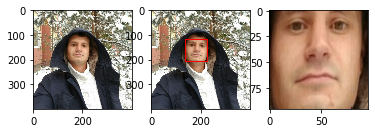

In [10]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    if img is None:
        return None
    if img.size ==0 :
        return None
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image 
jc_orig = load_image(metadata[2].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

In [ ]:
cntr =0;
for m in metadata:
    # m = metadata[2]

    if m.file[-6]!='3':
        continue
    print(m)
    # Load an image 
    jc_orig = load_image(m.image_path())

    if jc_orig is None:
        continue
    # Detect face and return bounding box
#         bb = alignment.getLargestFaceBoundingBox(jc_orig)
    bbs = alignment.getAllFaceBoundingBoxes(jc_orig)
    if len(bbs) == 0:
        jc_orig=jc_orig[...,::-1]
        outpath="notrecognized\\"+m.file.split('\\')[-1]
        retval=cv2.imwrite(outpath,jc_orig)
        continue
        
    jc_float=np.float32(jc_orig)
    for bb in bbs:
        lndmrks = alignment.findLandmarks(jc_orig,bb)
        print(lndmrks)
        figure = plt.figure(figsize=[20,20])
    #     plt.subplot(111)
        for (x, y) in lndmrks:
            cv2.circle(jc_float, (x, y), 2, (0, 255, 0), 2)
    #     plt.imshow(jc_orig)
    jc_float=jc_float[...,::-1]
    outpath="lndmrks\\"+m.file.split('\\')[-1]
    print('saving to '+outpath)
    retval=cv2.imwrite(outpath,jc_float)


        # Transform image using specified face landmark indices and crop image to 96x96
        #     jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    cntr+=1
    print(cntr)
    
#     # Show original image
#     plt.subplot(131)
#     plt.imshow(jc_orig)

#     # Show original image with bounding box
#     plt.subplot(132)
#     plt.imshow(jc_orig)
#     plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

#     # Show aligned image
#     plt.subplot(133)
#     plt.imshow(jc_aligned);

images10k\1-3.jpeg
[(137, 148), (137, 160), (137, 172), (138, 185), (141, 197), (148, 206), (158, 212), (170, 215), (183, 215), (196, 214), (207, 212), (217, 206), (222, 198), (225, 187), (226, 176), (228, 166), (228, 155), (146, 134), (154, 129), (163, 126), (172, 127), (180, 131), (195, 133), (203, 131), (211, 132), (218, 135), (224, 140), (186, 140), (186, 146), (186, 151), (186, 157), (175, 167), (180, 168), (185, 169), (189, 169), (194, 168), (156, 141), (162, 139), (168, 140), (174, 143), (167, 144), (161, 143), (196, 145), (203, 142), (209, 143), (214, 146), (208, 147), (202, 147), (163, 182), (171, 178), (178, 177), (184, 179), (190, 177), (196, 180), (203, 184), (196, 185), (189, 185), (183, 185), (178, 185), (171, 184), (166, 182), (178, 180), (184, 181), (190, 181), (200, 183), (189, 181), (184, 181), (178, 180)]
saving to lndmrks\1-3.jpeg
1
images10k\10-3.jpeg
images10k\100-3.jpeg
[(110, 118), (112, 128), (115, 138), (119, 147), (123, 156), (129, 163), (136, 168), (145, 171

[(249, 142), (249, 146), (250, 151), (251, 155), (253, 159), (256, 162), (260, 165), (264, 167), (269, 167), (274, 166), (278, 163), (283, 161), (286, 157), (288, 153), (289, 148), (289, 142), (289, 137), (251, 137), (252, 134), (255, 133), (258, 132), (261, 133), (269, 131), (272, 130), (276, 129), (279, 130), (282, 132), (265, 136), (265, 139), (265, 142), (265, 145), (263, 148), (264, 148), (266, 149), (268, 148), (270, 147), (255, 139), (257, 137), (259, 137), (261, 138), (259, 138), (257, 139), (271, 136), (273, 134), (276, 134), (278, 135), (276, 136), (274, 136), (259, 155), (262, 153), (265, 152), (267, 152), (269, 151), (272, 151), (276, 152), (273, 155), (270, 156), (267, 157), (265, 157), (262, 157), (260, 154), (265, 153), (267, 153), (269, 153), (275, 153), (269, 154), (267, 155), (265, 155)]
saving to lndmrks\1010-3.jpeg
9
images10k\1011-3.jpeg
[(143, 69), (139, 75), (136, 82), (134, 89), (132, 97), (132, 105), (133, 112), (135, 118), (140, 123), (146, 127), (155, 128), (

[(143, 158), (141, 179), (140, 201), (142, 222), (148, 243), (158, 260), (172, 275), (189, 288), (211, 293), (233, 292), (253, 282), (271, 270), (284, 255), (292, 236), (296, 215), (299, 195), (301, 174), (158, 137), (171, 130), (186, 130), (200, 133), (214, 141), (242, 145), (254, 140), (268, 139), (281, 143), (291, 152), (226, 157), (224, 173), (223, 189), (221, 205), (203, 211), (211, 215), (219, 218), (228, 216), (237, 214), (174, 153), (183, 147), (195, 148), (203, 159), (192, 159), (181, 158), (246, 164), (256, 156), (267, 156), (275, 164), (266, 167), (256, 166), (182, 231), (198, 231), (211, 231), (219, 234), (228, 233), (240, 235), (254, 237), (239, 246), (226, 249), (217, 249), (207, 247), (196, 241), (188, 233), (210, 238), (219, 240), (227, 240), (248, 239), (227, 239), (218, 239), (209, 237)]
saving to lndmrks\1022-3.jpeg
18
images10k\1023-3.jpeg
images10k\1024-3.jpeg


C:\Users\cod-malcevsu\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[(95, 140), (97, 154), (101, 168), (104, 181), (110, 194), (118, 205), (128, 214), (140, 220), (154, 221), (167, 216), (176, 207), (182, 196), (187, 183), (190, 170), (191, 156), (193, 143), (193, 130), (103, 129), (110, 123), (118, 122), (128, 123), (136, 126), (152, 126), (159, 122), (168, 120), (177, 120), (184, 124), (146, 136), (147, 147), (149, 158), (150, 169), (138, 171), (144, 174), (150, 176), (155, 174), (159, 171), (113, 137), (119, 133), (126, 133), (132, 138), (126, 139), (118, 139), (158, 137), (165, 131), (172, 130), (177, 134), (172, 137), (165, 138), (126, 184), (135, 182), (143, 182), (149, 183), (155, 181), (163, 180), (169, 181), (164, 192), (157, 197), (150, 199), (144, 199), (135, 195), (129, 185), (143, 185), (149, 186), (155, 184), (166, 182), (156, 191), (150, 193), (143, 192)]
saving to lndmrks\1024-3.jpeg
19
images10k\1025-3.jpeg
[(120, 81), (113, 91), (107, 102), (103, 114), (99, 126), (98, 140), (97, 152), (99, 164), (108, 172), (123, 180), (143, 185), (16

[(165, 156), (166, 160), (168, 163), (169, 167), (171, 170), (174, 172), (177, 174), (181, 176), (184, 175), (187, 174), (189, 171), (191, 168), (192, 164), (193, 161), (192, 156), (192, 152), (191, 148), (167, 153), (168, 151), (171, 150), (173, 150), (176, 151), (181, 149), (183, 148), (185, 147), (188, 146), (190, 147), (179, 153), (180, 156), (181, 159), (181, 163), (179, 163), (180, 164), (182, 164), (183, 163), (184, 162), (170, 155), (171, 153), (173, 153), (175, 154), (173, 155), (172, 155), (183, 152), (184, 150), (186, 150), (188, 151), (187, 152), (185, 152), (178, 168), (179, 167), (181, 166), (182, 166), (184, 165), (185, 165), (187, 166), (186, 168), (185, 169), (183, 170), (182, 170), (180, 169), (178, 168), (181, 167), (183, 167), (184, 167), (186, 166), (184, 167), (183, 168), (181, 168)]
saving to lndmrks\1035-3.jpeg
29
images10k\1036-3.jpeg
images10k\1037-3.jpeg
images10k\1038-3.jpeg
images10k\1039-3.jpeg
[(161, 62), (166, 68), (172, 74), (178, 78), (185, 81), (194, 

images10k\1049-3.jpeg
[(227, 188), (228, 198), (230, 209), (232, 219), (237, 229), (243, 238), (250, 246), (259, 253), (268, 255), (278, 252), (287, 246), (295, 237), (301, 227), (305, 217), (308, 205), (309, 193), (310, 181), (231, 182), (237, 179), (243, 180), (250, 182), (257, 184), (269, 183), (276, 180), (284, 177), (291, 177), (298, 180), (263, 189), (263, 196), (263, 203), (263, 210), (256, 213), (260, 214), (264, 216), (269, 214), (273, 212), (240, 189), (244, 187), (248, 187), (253, 190), (248, 190), (244, 190), (276, 189), (280, 186), (284, 186), (289, 187), (285, 189), (280, 189), (250, 225), (256, 223), (261, 222), (265, 222), (270, 221), (276, 222), (283, 223), (277, 230), (271, 234), (266, 235), (261, 234), (256, 231), (253, 225), (261, 224), (265, 224), (270, 223), (281, 224), (270, 229), (266, 230), (261, 229)]
[(145, 184), (142, 193), (139, 202), (137, 211), (138, 221), (141, 230), (146, 237), (153, 243), (162, 247), (171, 249), (180, 248), (189, 245), (196, 240), (200

[(182, 125), (190, 143), (198, 160), (207, 177), (219, 191), (235, 203), (255, 211), (275, 216), (294, 214), (309, 206), (319, 190), (328, 173), (333, 155), (335, 136), (334, 117), (331, 97), (326, 77), (187, 105), (193, 93), (206, 85), (221, 83), (236, 84), (267, 75), (278, 65), (290, 57), (304, 54), (316, 60), (256, 94), (261, 107), (265, 121), (270, 134), (256, 148), (265, 148), (274, 147), (280, 143), (286, 138), (207, 113), (215, 105), (225, 101), (236, 105), (228, 110), (217, 113), (277, 92), (285, 81), (295, 78), (305, 81), (298, 87), (288, 90), (242, 172), (254, 168), (267, 163), (276, 163), (284, 158), (296, 156), (309, 153), (301, 167), (292, 176), (283, 180), (273, 182), (258, 180), (247, 172), (269, 172), (278, 170), (286, 167), (304, 155), (288, 165), (280, 169), (271, 170)]
[(27, 265), (27, 280), (29, 294), (33, 307), (40, 319), (53, 326), (69, 331), (85, 334), (101, 336), (114, 333), (123, 328), (131, 321), (137, 311), (139, 299), (141, 287), (141, 276), (139, 264), (52,

53
images10k\1068-3.jpeg
images10k\1069-3.jpeg
images10k\107-3.jpeg
images10k\1070-3.jpeg
images10k\1071-3.jpeg
[(226, 348), (229, 371), (234, 393), (239, 415), (246, 437), (259, 453), (278, 465), (300, 472), (327, 472), (354, 469), (375, 461), (391, 445), (400, 425), (401, 401), (401, 376), (402, 352), (400, 329), (236, 308), (244, 293), (259, 286), (276, 285), (293, 289), (320, 287), (337, 282), (355, 278), (372, 281), (385, 292), (310, 308), (310, 318), (311, 328), (312, 339), (298, 363), (307, 364), (316, 365), (325, 362), (334, 360), (253, 326), (263, 319), (274, 318), (288, 322), (276, 326), (264, 328), (336, 318), (347, 311), (359, 310), (370, 315), (360, 319), (348, 320), (285, 407), (296, 391), (309, 383), (320, 385), (331, 382), (347, 387), (364, 399), (350, 405), (335, 407), (323, 408), (312, 409), (298, 410), (291, 405), (310, 397), (321, 397), (332, 395), (357, 399), (333, 395), (322, 397), (311, 397)]
[(166, 172), (167, 187), (170, 202), (175, 216), (182, 229), (192, 240)

[(72, 153), (67, 193), (66, 233), (67, 273), (75, 311), (89, 347), (109, 374), (132, 393), (162, 400), (197, 403), (235, 395), (268, 377), (295, 351), (318, 322), (336, 290), (350, 254), (361, 217), (88, 133), (112, 121), (142, 125), (168, 136), (193, 152), (250, 162), (280, 157), (311, 158), (339, 167), (356, 185), (213, 185), (208, 215), (202, 245), (197, 275), (165, 279), (177, 288), (190, 297), (206, 296), (222, 292), (111, 164), (131, 158), (153, 163), (169, 182), (147, 183), (125, 178), (258, 200), (280, 188), (303, 192), (318, 206), (301, 212), (278, 208), (130, 320), (150, 320), (170, 321), (183, 328), (198, 327), (216, 335), (233, 346), (210, 357), (189, 359), (174, 357), (159, 352), (143, 340), (138, 323), (167, 332), (181, 337), (195, 338), (225, 345), (193, 342), (179, 340), (164, 335)]
saving to lndmrks\108-3.jpeg
61
images10k\1080-3.jpeg
images10k\1081-3.jpeg
[(284, 195), (287, 201), (290, 207), (293, 212), (298, 216), (304, 220), (310, 222), (316, 223), (323, 222), (328,

[(83, 194), (84, 203), (86, 212), (88, 221), (93, 228), (100, 234), (108, 239), (117, 242), (126, 241), (133, 238), (137, 232), (141, 225), (144, 218), (146, 211), (147, 203), (147, 196), (147, 189), (94, 190), (99, 187), (105, 186), (112, 186), (118, 188), (129, 187), (133, 184), (137, 183), (142, 182), (145, 183), (124, 193), (125, 199), (126, 205), (127, 212), (118, 214), (122, 215), (126, 216), (129, 214), (131, 212), (101, 195), (105, 193), (109, 192), (113, 195), (109, 196), (105, 196), (129, 192), (133, 189), (136, 188), (140, 189), (137, 192), (134, 192), (110, 223), (116, 222), (122, 221), (125, 221), (129, 220), (132, 219), (136, 218), (133, 223), (130, 226), (126, 227), (123, 227), (117, 227), (112, 223), (122, 223), (126, 223), (129, 222), (134, 219), (129, 222), (126, 223), (122, 223)]
[(289, 55), (289, 63), (290, 70), (293, 77), (298, 83), (305, 87), (313, 90), (320, 93), (327, 93), (332, 91), (336, 86), (339, 80), (341, 75), (343, 69), (344, 63), (343, 58), (342, 52), (2

[(67, 172), (72, 211), (84, 249), (96, 285), (110, 320), (128, 351), (152, 379), (180, 397), (211, 398), (240, 387), (264, 362), (281, 330), (293, 295), (303, 261), (311, 225), (320, 189), (322, 149), (72, 158), (89, 146), (112, 147), (135, 153), (156, 164), (211, 157), (233, 142), (257, 131), (283, 125), (306, 134), (182, 188), (182, 219), (182, 249), (182, 279), (165, 291), (175, 295), (187, 297), (199, 291), (212, 286), (96, 187), (112, 179), (133, 177), (150, 190), (132, 198), (111, 199), (226, 183), (242, 168), (262, 165), (278, 170), (266, 185), (245, 188), (156, 345), (168, 337), (182, 329), (191, 331), (201, 325), (215, 329), (230, 333), (220, 350), (208, 362), (196, 366), (185, 367), (170, 362), (164, 345), (183, 344), (192, 343), (202, 340), (222, 335), (204, 339), (194, 343), (184, 344)]
saving to lndmrks\1098-3.jpeg
77
images10k\1099-3.jpeg
[(166, 155), (166, 165), (166, 175), (167, 186), (170, 197), (177, 205), (186, 212), (196, 218), (207, 220), (218, 219), (228, 215), (2

[(175, 167), (175, 177), (176, 186), (179, 196), (184, 205), (190, 212), (196, 219), (203, 226), (213, 227), (222, 226), (231, 220), (239, 212), (246, 204), (250, 194), (253, 184), (255, 173), (255, 163), (180, 160), (185, 157), (190, 158), (196, 159), (201, 161), (216, 161), (222, 157), (229, 155), (236, 155), (242, 158), (208, 168), (208, 176), (208, 183), (208, 191), (202, 193), (205, 194), (209, 196), (213, 194), (217, 193), (186, 168), (190, 166), (195, 166), (199, 170), (195, 170), (190, 170), (220, 169), (225, 166), (230, 166), (234, 168), (230, 170), (225, 170), (196, 202), (202, 203), (206, 202), (210, 203), (213, 202), (219, 202), (227, 201), (220, 206), (214, 210), (210, 211), (206, 210), (202, 208), (198, 203), (206, 205), (210, 205), (214, 204), (225, 201), (214, 205), (210, 206), (207, 205)]
saving to lndmrks\111-3.jpeg
86
images10k\1110-3.jpeg
images10k\1111-3.jpeg
images10k\1112-3.jpeg
[(136, 131), (137, 140), (138, 150), (140, 159), (143, 168), (148, 175), (154, 181), 

[(268, 146), (263, 156), (259, 167), (257, 179), (257, 189), (260, 199), (266, 207), (272, 214), (279, 219), (286, 220), (293, 217), (299, 214), (306, 210), (312, 205), (318, 200), (323, 195), (327, 190), (288, 148), (296, 149), (304, 152), (310, 158), (314, 164), (324, 170), (328, 171), (332, 174), (334, 176), (334, 179), (315, 173), (312, 179), (310, 184), (308, 190), (296, 190), (299, 193), (301, 195), (304, 196), (306, 197), (292, 160), (297, 160), (301, 164), (303, 169), (298, 167), (294, 164), (317, 179), (321, 178), (325, 180), (325, 184), (323, 184), (319, 182), (280, 196), (287, 198), (293, 200), (295, 203), (298, 204), (298, 206), (298, 209), (294, 209), (291, 208), (289, 207), (286, 204), (283, 201), (282, 197), (291, 203), (293, 205), (295, 206), (296, 208), (295, 205), (292, 203), (290, 201)]
saving to lndmrks\1124-3.jpeg
96
images10k\1125-3.jpeg
[(111, 137), (111, 163), (111, 189), (116, 213), (127, 233), (142, 249), (160, 261), (178, 271), (196, 277), (214, 277), (229, 2

[(185, 117), (186, 126), (187, 136), (190, 145), (195, 154), (201, 163), (207, 170), (214, 176), (223, 178), (234, 178), (244, 173), (252, 166), (257, 156), (260, 145), (260, 132), (259, 120), (258, 108), (193, 99), (196, 96), (200, 94), (205, 94), (209, 96), (222, 93), (228, 90), (236, 89), (243, 90), (249, 95), (216, 104), (216, 111), (216, 118), (216, 124), (211, 130), (215, 130), (219, 131), (223, 130), (226, 129), (200, 108), (203, 105), (207, 105), (210, 107), (207, 108), (203, 108), (229, 105), (233, 102), (237, 102), (241, 103), (238, 105), (233, 106), (208, 146), (210, 142), (215, 140), (219, 140), (223, 139), (231, 140), (237, 143), (233, 153), (226, 157), (221, 158), (217, 158), (211, 155), (210, 147), (215, 143), (219, 143), (224, 143), (235, 144), (225, 152), (220, 153), (216, 152)]
saving to lndmrks\1132-3.jpeg
105
images10k\1133-3.jpeg
[(168, 102), (171, 112), (174, 121), (177, 130), (182, 138), (190, 144), (198, 149), (208, 152), (218, 151), (228, 148), (235, 142), (241

[(134, 156), (138, 167), (143, 177), (148, 187), (153, 195), (162, 202), (172, 207), (183, 211), (194, 209), (203, 205), (210, 197), (217, 189), (221, 179), (222, 168), (221, 157), (219, 145), (216, 133), (138, 154), (142, 149), (149, 146), (156, 145), (164, 146), (179, 141), (185, 137), (192, 134), (199, 132), (207, 133), (174, 150), (176, 158), (178, 165), (181, 173), (174, 177), (178, 177), (183, 177), (187, 174), (190, 172), (150, 157), (153, 154), (159, 152), (164, 154), (160, 157), (155, 158), (185, 148), (189, 144), (194, 142), (199, 143), (196, 146), (191, 148), (170, 188), (176, 186), (182, 184), (186, 183), (190, 180), (196, 178), (202, 174), (199, 182), (195, 187), (190, 190), (186, 191), (178, 191), (173, 188), (182, 186), (187, 185), (191, 183), (200, 176), (193, 181), (188, 184), (184, 185)]
saving to lndmrks\1146-3.jpeg
114
images10k\1147-3.jpeg
[(180, 174), (181, 183), (182, 192), (185, 201), (190, 209), (197, 215), (206, 220), (215, 223), (224, 224), (235, 222), (243, 

images10k\1159-3.jpeg
[(185, 54), (176, 63), (169, 73), (167, 84), (163, 96), (159, 110), (156, 123), (155, 134), (162, 143), (176, 150), (196, 154), (216, 154), (234, 152), (250, 145), (261, 133), (270, 120), (278, 106), (186, 33), (191, 34), (195, 38), (198, 44), (199, 51), (213, 59), (224, 60), (235, 65), (243, 74), (248, 84), (198, 65), (190, 71), (182, 78), (174, 84), (171, 88), (172, 92), (175, 96), (180, 98), (186, 100), (185, 52), (189, 51), (193, 55), (195, 61), (190, 60), (186, 57), (213, 77), (221, 76), (227, 81), (232, 88), (224, 86), (218, 82), (169, 106), (168, 103), (171, 104), (173, 108), (177, 109), (185, 116), (195, 127), (181, 123), (172, 119), (168, 116), (166, 113), (166, 108), (170, 107), (169, 110), (171, 113), (176, 116), (191, 124), (175, 113), (171, 110), (169, 107)]
saving to lndmrks\1159-3.jpeg
124
images10k\116-3.jpeg
[(144, 89), (143, 99), (144, 109), (146, 119), (149, 129), (154, 137), (160, 145), (166, 153), (176, 155), (186, 154), (196, 148), (205, 140)

[(103, 274), (103, 299), (105, 325), (111, 351), (124, 377), (141, 400), (157, 423), (176, 444), (199, 449), (224, 444), (246, 425), (267, 403), (285, 380), (298, 354), (304, 326), (306, 297), (306, 269), (107, 248), (118, 241), (132, 241), (146, 244), (160, 252), (217, 251), (233, 243), (250, 239), (266, 239), (282, 245), (189, 274), (188, 299), (187, 323), (186, 347), (167, 348), (177, 353), (189, 358), (202, 353), (214, 347), (125, 275), (136, 268), (149, 269), (162, 279), (148, 279), (135, 279), (225, 278), (237, 268), (251, 267), (264, 273), (252, 277), (239, 278), (146, 362), (161, 365), (179, 367), (193, 369), (207, 367), (229, 363), (253, 360), (233, 391), (211, 404), (195, 406), (180, 405), (162, 392), (152, 366), (179, 373), (193, 375), (208, 373), (247, 364), (209, 390), (195, 392), (180, 390)]
saving to lndmrks\1172-3.jpeg
133
images10k\1173-3.jpeg
images10k\1174-3.jpeg
[(153, 122), (152, 127), (151, 132), (150, 137), (151, 142), (152, 147), (154, 151), (157, 155), (160, 15

[(238, 61), (238, 64), (237, 68), (238, 71), (239, 75), (240, 78), (243, 81), (245, 84), (248, 85), (252, 85), (257, 84), (261, 82), (265, 79), (268, 76), (269, 71), (270, 66), (271, 61), (239, 57), (240, 56), (242, 55), (244, 56), (246, 57), (251, 56), (254, 55), (257, 55), (260, 56), (263, 57), (248, 60), (247, 62), (247, 65), (246, 67), (244, 69), (245, 70), (247, 70), (249, 70), (251, 69), (241, 60), (242, 60), (244, 60), (246, 61), (244, 61), (242, 61), (254, 61), (256, 59), (257, 60), (259, 60), (257, 61), (256, 61), (243, 73), (244, 72), (246, 72), (248, 72), (250, 72), (253, 72), (257, 73), (254, 75), (250, 77), (248, 77), (246, 77), (244, 76), (244, 73), (246, 73), (248, 73), (250, 73), (256, 73), (250, 75), (248, 75), (246, 75)]
[(158, 27), (158, 32), (158, 37), (158, 42), (159, 46), (161, 50), (164, 54), (168, 57), (173, 59), (177, 59), (182, 57), (186, 54), (189, 51), (191, 47), (192, 43), (193, 39), (195, 35), (163, 27), (166, 25), (170, 25), (173, 27), (176, 28), (182, 30

[(179, 107), (180, 116), (181, 124), (182, 132), (185, 140), (190, 146), (197, 150), (206, 153), (215, 154), (224, 153), (232, 150), (238, 145), (242, 139), (244, 131), (246, 124), (247, 116), (248, 108), (186, 98), (191, 93), (198, 91), (205, 91), (212, 93), (221, 94), (227, 92), (234, 92), (241, 94), (245, 99), (217, 101), (217, 107), (217, 112), (218, 117), (211, 123), (214, 124), (217, 125), (220, 124), (223, 123), (194, 105), (198, 102), (203, 102), (207, 105), (203, 107), (198, 107), (225, 106), (230, 103), (235, 103), (238, 106), (235, 108), (230, 107), (204, 135), (209, 131), (214, 130), (217, 130), (220, 130), (224, 131), (229, 135), (224, 137), (220, 137), (217, 138), (214, 137), (209, 137), (206, 134), (214, 133), (217, 133), (220, 133), (227, 134), (220, 133), (217, 134), (214, 133)]
saving to lndmrks\1192-3.jpeg
147
images10k\1193-3.jpeg
[(131, 65), (132, 76), (134, 87), (137, 97), (141, 105), (148, 113), (157, 119), (167, 122), (177, 123), (185, 120), (191, 114), (196, 10

[(96, 136), (99, 149), (103, 163), (108, 175), (116, 186), (126, 194), (138, 200), (151, 204), (162, 203), (170, 199), (176, 191), (181, 181), (185, 171), (187, 160), (188, 149), (188, 138), (187, 128), (115, 130), (122, 125), (131, 123), (141, 123), (150, 126), (164, 124), (169, 120), (175, 117), (181, 115), (185, 118), (159, 135), (161, 143), (164, 151), (166, 160), (154, 166), (159, 167), (164, 167), (168, 165), (171, 163), (126, 139), (131, 135), (138, 134), (144, 139), (138, 141), (132, 141), (165, 135), (169, 129), (175, 128), (180, 130), (177, 134), (171, 136), (143, 181), (152, 179), (159, 177), (163, 177), (166, 175), (170, 175), (174, 175), (171, 181), (168, 184), (164, 186), (160, 187), (152, 186), (147, 181), (160, 180), (164, 180), (167, 179), (171, 177), (167, 179), (164, 181), (160, 182)]
saving to lndmrks\120-3.jpeg
155
images10k\1200-3.jpeg
[(121, 174), (122, 181), (123, 189), (125, 196), (127, 203), (132, 208), (138, 213), (146, 216), (155, 216), (163, 214), (170, 210

[(120, 107), (120, 120), (123, 133), (125, 145), (129, 157), (136, 167), (146, 175), (157, 183), (169, 186), (182, 184), (196, 178), (208, 170), (218, 159), (222, 146), (225, 131), (227, 116), (227, 101), (123, 96), (131, 92), (140, 93), (148, 96), (156, 100), (172, 99), (181, 94), (191, 90), (201, 89), (211, 93), (165, 108), (165, 117), (165, 127), (165, 137), (156, 140), (161, 143), (166, 144), (171, 143), (176, 141), (134, 108), (140, 105), (146, 106), (152, 110), (145, 110), (139, 110), (181, 109), (187, 105), (194, 105), (201, 107), (195, 109), (188, 110), (147, 151), (154, 150), (161, 150), (166, 151), (171, 150), (179, 152), (189, 153), (179, 159), (171, 161), (165, 161), (159, 160), (153, 157), (150, 152), (160, 154), (166, 155), (171, 155), (186, 154), (171, 154), (165, 155), (160, 154)]
[(33, 185), (36, 196), (38, 207), (41, 217), (47, 226), (55, 233), (65, 239), (75, 244), (85, 245), (96, 243), (105, 237), (114, 230), (121, 221), (126, 210), (127, 198), (127, 185), (127, 173

[(134, 114), (131, 127), (129, 140), (129, 154), (132, 166), (138, 177), (147, 186), (157, 194), (166, 197), (175, 196), (182, 190), (189, 183), (195, 176), (201, 169), (205, 161), (209, 153), (211, 144), (153, 118), (161, 116), (168, 116), (175, 119), (182, 123), (197, 128), (203, 128), (208, 128), (212, 129), (214, 133), (188, 134), (187, 142), (186, 150), (185, 159), (173, 159), (177, 162), (180, 164), (184, 164), (187, 163), (159, 127), (165, 126), (171, 127), (174, 132), (169, 132), (163, 131), (192, 137), (197, 134), (203, 135), (205, 138), (202, 140), (197, 139), (159, 168), (166, 170), (173, 171), (177, 173), (180, 172), (184, 173), (186, 174), (182, 179), (178, 181), (174, 180), (170, 179), (164, 175), (162, 169), (172, 174), (176, 175), (179, 175), (184, 175), (179, 175), (176, 175), (172, 174)]
saving to lndmrks\1223-3.jpeg
172
images10k\1224-3.jpeg
images10k\1225-3.jpeg
[(132, 166), (133, 172), (134, 177), (136, 183), (139, 187), (144, 191), (150, 194), (156, 195), (161, 19

[(151, 127), (152, 131), (153, 136), (154, 140), (156, 144), (160, 146), (165, 148), (169, 150), (173, 150), (177, 149), (179, 146), (182, 143), (184, 140), (185, 136), (185, 132), (184, 129), (184, 125), (158, 124), (160, 122), (163, 121), (166, 121), (169, 122), (173, 122), (176, 121), (178, 121), (181, 121), (182, 123), (172, 124), (172, 127), (172, 129), (173, 132), (169, 133), (170, 134), (172, 134), (174, 133), (175, 133), (162, 125), (164, 125), (166, 124), (167, 125), (166, 125), (164, 125), (174, 125), (176, 124), (177, 124), (179, 125), (177, 125), (176, 125), (166, 138), (168, 137), (171, 136), (172, 136), (174, 136), (176, 136), (178, 137), (176, 140), (175, 141), (173, 141), (171, 141), (168, 140), (167, 138), (171, 137), (172, 137), (174, 137), (177, 137), (174, 139), (173, 139), (171, 139)]
saving to lndmrks\1233-3.jpeg
180
images10k\1234-3.jpeg
[(292, 118), (292, 126), (293, 135), (295, 143), (300, 150), (307, 155), (315, 159), (323, 161), (330, 161), (335, 158), (337, 

[(43, 149), (43, 162), (45, 175), (51, 188), (59, 200), (68, 211), (77, 221), (89, 228), (102, 229), (114, 224), (124, 215), (133, 203), (140, 190), (144, 176), (145, 160), (144, 144), (141, 129), (47, 124), (50, 114), (57, 109), (64, 108), (71, 112), (92, 106), (98, 100), (106, 97), (115, 99), (121, 106), (83, 127), (84, 136), (86, 145), (87, 154), (80, 164), (85, 165), (90, 166), (95, 163), (100, 161), (56, 136), (60, 129), (66, 128), (72, 133), (67, 136), (61, 137), (98, 127), (102, 120), (109, 118), (115, 122), (111, 126), (104, 128), (73, 191), (77, 182), (86, 178), (91, 178), (97, 177), (106, 178), (114, 184), (108, 196), (100, 201), (94, 203), (88, 203), (79, 200), (76, 190), (87, 184), (92, 184), (98, 183), (111, 185), (98, 194), (92, 196), (87, 196)]
saving to lndmrks\1244-3.jpeg
190
images10k\1245-3.jpeg
[(170, 67), (169, 72), (170, 78), (172, 84), (175, 90), (178, 95), (181, 101), (185, 105), (191, 105), (196, 103), (201, 99), (205, 94), (209, 89), (213, 84), (215, 77), (214

images10k\1253-3.jpeg
[(128, 188), (131, 216), (135, 246), (144, 274), (164, 296), (191, 313), (221, 323), (251, 328), (275, 326), (289, 314), (292, 294), (292, 272), (294, 252), (295, 232), (295, 214), (293, 197), (289, 180), (186, 184), (203, 170), (225, 163), (248, 163), (267, 170), (279, 171), (286, 164), (294, 161), (302, 160), (304, 164), (276, 184), (283, 200), (291, 216), (298, 233), (265, 247), (276, 248), (287, 250), (295, 245), (300, 238), (210, 188), (222, 184), (233, 182), (242, 188), (233, 192), (222, 192), (279, 184), (286, 178), (294, 176), (298, 180), (295, 184), (287, 185), (239, 279), (259, 272), (276, 267), (285, 268), (291, 264), (294, 263), (293, 265), (293, 272), (290, 279), (283, 282), (273, 284), (258, 284), (244, 278), (275, 273), (285, 272), (291, 269), (292, 266), (290, 270), (283, 274), (274, 275)]
saving to lndmrks\1253-3.jpeg
198
images10k\1254-3.jpeg
images10k\1255-3.jpeg
[(158, 162), (160, 177), (163, 191), (167, 205), (173, 218), (182, 229), (194, 238)

[(169, 189), (167, 202), (166, 215), (166, 228), (169, 240), (176, 251), (184, 261), (194, 269), (205, 272), (215, 272), (225, 266), (233, 258), (241, 249), (245, 239), (249, 228), (252, 217), (254, 206), (183, 190), (190, 186), (198, 186), (206, 189), (214, 193), (227, 195), (235, 193), (242, 193), (249, 196), (251, 202), (219, 201), (218, 209), (217, 217), (217, 225), (204, 227), (209, 230), (214, 232), (219, 231), (223, 230), (191, 196), (196, 195), (202, 196), (206, 200), (200, 199), (195, 198), (227, 204), (233, 201), (238, 202), (242, 205), (238, 206), (232, 205), (193, 239), (200, 238), (207, 239), (211, 241), (216, 240), (221, 242), (225, 245), (220, 248), (214, 250), (209, 249), (204, 248), (198, 244), (195, 240), (206, 242), (210, 244), (216, 244), (223, 245), (215, 244), (210, 244), (205, 242)]
saving to lndmrks\1264-3.jpeg
207
images10k\1265-3.jpeg
[(228, 149), (228, 152), (228, 156), (229, 159), (230, 162), (232, 165), (235, 167), (239, 169), (243, 169), (247, 169), (252, 

[(147, 112), (147, 127), (148, 141), (150, 155), (153, 170), (159, 183), (168, 195), (178, 204), (191, 208), (206, 207), (221, 200), (235, 191), (246, 180), (252, 165), (256, 150), (260, 133), (263, 117), (150, 106), (158, 104), (167, 107), (175, 111), (183, 116), (203, 118), (215, 113), (225, 111), (236, 110), (247, 113), (193, 127), (192, 138), (191, 149), (190, 160), (181, 163), (185, 166), (190, 168), (197, 166), (202, 164), (159, 122), (165, 119), (173, 121), (180, 127), (172, 128), (164, 126), (211, 129), (219, 124), (227, 123), (234, 127), (228, 131), (219, 131), (172, 174), (179, 174), (186, 175), (191, 176), (197, 175), (207, 176), (217, 177), (206, 184), (197, 188), (190, 188), (185, 187), (178, 182), (175, 176), (186, 179), (191, 181), (197, 180), (213, 178), (197, 180), (191, 181), (185, 179)]
saving to lndmrks\1275-3.jpeg
217
images10k\1276-3.jpeg
[(175, 226), (178, 244), (183, 262), (190, 279), (197, 296), (209, 312), (226, 325), (246, 334), (269, 333), (291, 325), (310, 

[(226, 141), (223, 152), (220, 163), (220, 175), (221, 185), (226, 195), (233, 202), (241, 208), (250, 212), (258, 213), (267, 210), (275, 206), (282, 201), (287, 194), (291, 187), (294, 180), (297, 172), (245, 140), (253, 139), (261, 141), (267, 144), (272, 149), (282, 155), (287, 156), (292, 157), (296, 160), (298, 164), (275, 159), (274, 164), (273, 169), (272, 174), (261, 177), (264, 179), (266, 181), (269, 182), (272, 182), (251, 149), (256, 148), (261, 150), (263, 155), (258, 155), (254, 152), (279, 163), (283, 161), (287, 163), (290, 167), (286, 167), (282, 166), (248, 185), (256, 185), (262, 185), (264, 187), (267, 188), (269, 191), (270, 194), (266, 196), (262, 196), (260, 195), (257, 193), (252, 190), (250, 186), (260, 189), (263, 190), (266, 191), (268, 194), (264, 191), (262, 190), (259, 189)]
saving to lndmrks\1283-3.jpeg
225
images10k\1284-3.jpeg
[(156, 178), (157, 193), (158, 209), (160, 224), (163, 239), (170, 252), (180, 264), (192, 275), (207, 281), (226, 280), (249, 

[(212, 57), (210, 65), (208, 73), (208, 81), (209, 90), (212, 97), (215, 104), (219, 111), (225, 116), (233, 117), (245, 116), (258, 114), (269, 109), (278, 101), (282, 91), (285, 80), (288, 69), (215, 48), (220, 47), (225, 49), (230, 52), (233, 56), (245, 58), (251, 56), (257, 56), (263, 58), (269, 60), (237, 63), (234, 69), (232, 74), (229, 80), (225, 81), (227, 84), (230, 86), (234, 86), (239, 85), (220, 57), (224, 57), (227, 58), (231, 62), (226, 61), (222, 59), (247, 66), (252, 64), (256, 65), (260, 67), (255, 68), (251, 67), (219, 87), (223, 87), (227, 88), (230, 90), (234, 90), (240, 92), (248, 95), (239, 100), (232, 101), (228, 100), (224, 98), (221, 94), (221, 88), (226, 90), (229, 91), (233, 92), (247, 95), (232, 98), (229, 97), (225, 95)]
saving to lndmrks\1293-3.jpeg
232
images10k\1294-3.jpeg
[(149, 189), (149, 213), (151, 235), (152, 258), (155, 280), (163, 300), (176, 316), (192, 329), (213, 336), (235, 336), (256, 328), (275, 315), (290, 299), (299, 280), (306, 258), (31

[(208, 180), (210, 191), (214, 201), (219, 212), (224, 222), (229, 231), (237, 239), (246, 244), (257, 245), (269, 242), (280, 234), (290, 226), (296, 214), (299, 201), (300, 188), (301, 174), (300, 160), (211, 169), (214, 163), (220, 161), (227, 162), (234, 163), (252, 158), (258, 152), (266, 148), (275, 148), (283, 151), (243, 170), (244, 178), (244, 187), (244, 196), (240, 202), (243, 203), (247, 204), (252, 202), (256, 199), (219, 177), (223, 173), (229, 171), (235, 175), (230, 177), (224, 178), (258, 169), (263, 164), (269, 162), (275, 164), (270, 168), (264, 169), (237, 218), (241, 215), (245, 212), (250, 213), (254, 210), (261, 210), (270, 211), (263, 217), (257, 221), (252, 223), (248, 223), (243, 222), (239, 218), (246, 217), (250, 216), (255, 215), (268, 212), (255, 215), (251, 217), (247, 217)]
saving to lndmrks\1303-3.jpeg
241
images10k\1304-3.jpeg
[(92, 204), (101, 226), (112, 246), (125, 266), (139, 283), (155, 299), (173, 313), (191, 324), (212, 323), (234, 313), (254, 2

248
images10k\1315-3.jpeg
[(244, 130), (246, 137), (249, 143), (252, 150), (255, 157), (261, 162), (268, 166), (275, 169), (283, 168), (291, 165), (296, 159), (301, 152), (305, 144), (306, 136), (305, 128), (303, 120), (301, 112), (244, 121), (246, 117), (250, 114), (255, 113), (260, 114), (272, 110), (277, 106), (282, 103), (287, 103), (292, 105), (268, 118), (269, 123), (270, 128), (271, 133), (268, 139), (270, 139), (273, 139), (276, 137), (278, 135), (252, 126), (254, 123), (257, 122), (261, 123), (258, 124), (255, 126), (278, 117), (281, 115), (285, 114), (288, 114), (285, 116), (282, 117), (264, 151), (267, 147), (272, 144), (275, 144), (279, 142), (284, 141), (290, 142), (286, 148), (282, 152), (278, 153), (274, 154), (269, 154), (266, 150), (272, 147), (276, 146), (280, 145), (288, 143), (281, 148), (277, 149), (273, 150)]
[(118, 100), (117, 110), (117, 121), (117, 130), (120, 140), (126, 148), (133, 155), (142, 160), (151, 162), (161, 162), (168, 158), (174, 152), (178, 145), 

255
images10k\1325-3.jpeg
images10k\1326-3.jpeg
images10k\1327-3.jpeg
images10k\1328-3.jpeg
images10k\1329-3.jpeg
images10k\133-3.jpeg
[(37, 115), (34, 136), (32, 158), (35, 181), (42, 202), (52, 223), (63, 243), (77, 262), (96, 270), (118, 270), (140, 258), (159, 242), (177, 223), (189, 202), (195, 178), (199, 152), (200, 128), (54, 110), (64, 106), (76, 108), (86, 113), (96, 119), (112, 121), (124, 116), (138, 115), (150, 117), (162, 123), (104, 138), (99, 152), (95, 167), (90, 182), (79, 187), (85, 193), (92, 197), (101, 195), (109, 192), (67, 130), (74, 129), (82, 130), (88, 135), (80, 136), (73, 134), (121, 139), (129, 135), (137, 136), (146, 137), (137, 141), (129, 141), (72, 210), (79, 209), (86, 211), (92, 214), (100, 214), (111, 215), (125, 217), (111, 228), (100, 229), (93, 228), (86, 225), (79, 219), (75, 211), (86, 215), (92, 217), (99, 217), (121, 217), (100, 222), (93, 221), (87, 218)]
saving to lndmrks\133-3.jpeg
256
images10k\1330-3.jpeg
[(28, 226), (29, 247), (32, 266)

[(156, 104), (157, 120), (158, 135), (159, 151), (163, 166), (170, 179), (181, 189), (193, 197), (207, 199), (222, 198), (234, 191), (245, 183), (254, 171), (258, 157), (261, 141), (264, 126), (267, 110), (166, 103), (174, 96), (184, 95), (195, 97), (204, 102), (221, 103), (232, 100), (242, 99), (252, 101), (258, 108), (212, 111), (211, 120), (211, 130), (210, 140), (199, 144), (205, 146), (210, 148), (216, 146), (221, 145), (180, 109), (186, 106), (193, 106), (199, 111), (193, 113), (185, 112), (225, 112), (231, 108), (239, 108), (244, 112), (239, 115), (232, 114), (188, 157), (196, 156), (204, 156), (209, 158), (216, 157), (223, 158), (231, 160), (223, 165), (215, 167), (208, 167), (202, 166), (195, 163), (191, 158), (203, 161), (209, 162), (215, 162), (228, 160), (215, 161), (209, 161), (203, 160)]
saving to lndmrks\1338-3.jpeg
264
images10k\1339-3.jpeg
[(117, 122), (116, 142), (118, 162), (122, 182), (130, 199), (142, 213), (155, 224), (170, 233), (185, 236), (200, 233), (213, 224)

270
images10k\1345-3.jpeg
images10k\1346-3.jpeg
[(132, 215), (134, 235), (138, 255), (142, 274), (149, 292), (161, 307), (177, 318), (196, 326), (215, 327), (232, 323), (247, 313), (258, 299), (266, 283), (269, 264), (271, 246), (273, 228), (273, 211), (147, 200), (155, 188), (169, 183), (184, 183), (199, 187), (221, 187), (234, 182), (247, 180), (260, 184), (266, 196), (211, 200), (212, 213), (213, 225), (214, 238), (198, 250), (205, 252), (213, 254), (220, 251), (227, 248), (163, 208), (171, 203), (180, 202), (189, 206), (180, 208), (171, 209), (228, 204), (236, 200), (244, 200), (252, 204), (245, 206), (236, 206), (187, 278), (197, 272), (205, 270), (213, 272), (220, 270), (228, 271), (237, 275), (229, 278), (221, 280), (214, 280), (207, 280), (198, 280), (191, 277), (206, 274), (213, 275), (220, 274), (234, 274), (220, 274), (214, 275), (206, 274)]
saving to lndmrks\1346-3.jpeg
271
images10k\1347-3.jpeg
images10k\1348-3.jpeg
images10k\1349-3.jpeg
[(8, 147), (6, 165), (5, 182), (7, 

[(189, 74), (186, 79), (183, 83), (180, 88), (178, 94), (178, 99), (178, 105), (180, 110), (184, 115), (189, 118), (196, 119), (203, 118), (209, 116), (215, 114), (219, 110), (223, 105), (226, 100), (194, 70), (196, 69), (199, 70), (201, 72), (203, 75), (210, 80), (214, 81), (218, 84), (220, 88), (221, 93), (203, 82), (201, 85), (198, 87), (196, 90), (192, 91), (193, 93), (194, 95), (197, 95), (199, 96), (194, 76), (196, 76), (198, 78), (199, 80), (197, 79), (195, 77), (208, 87), (211, 88), (213, 90), (215, 93), (212, 91), (210, 89), (186, 94), (189, 95), (191, 96), (193, 98), (195, 99), (198, 101), (201, 105), (196, 106), (192, 105), (189, 103), (188, 101), (186, 98), (187, 95), (190, 98), (192, 99), (194, 100), (200, 104), (193, 103), (191, 102), (189, 100)]
saving to lndmrks\1357-3.jpeg
278
images10k\1358-3.jpeg
[(191, 192), (192, 197), (193, 202), (194, 207), (196, 212), (199, 216), (203, 218), (208, 220), (214, 221), (219, 220), (225, 217), (230, 214), (234, 210), (235, 205), (236

[(107, 159), (108, 168), (111, 176), (113, 184), (117, 192), (122, 199), (128, 204), (136, 208), (143, 209), (150, 206), (157, 200), (163, 194), (167, 185), (169, 176), (170, 167), (170, 157), (169, 148), (110, 153), (113, 150), (117, 149), (122, 149), (127, 150), (139, 148), (144, 145), (149, 143), (154, 142), (159, 144), (134, 156), (135, 163), (136, 169), (137, 176), (132, 179), (135, 180), (138, 181), (141, 179), (144, 177), (116, 159), (119, 157), (123, 157), (127, 159), (123, 160), (119, 161), (144, 156), (147, 153), (151, 152), (154, 152), (152, 155), (148, 156), (128, 191), (132, 189), (136, 187), (139, 187), (142, 186), (147, 185), (151, 185), (148, 190), (144, 193), (141, 195), (137, 195), (133, 194), (130, 191), (136, 190), (139, 190), (143, 189), (150, 186), (143, 189), (140, 190), (137, 191)]
saving to lndmrks\1368-3.jpeg
287
images10k\1369-3.jpeg
[(148, 176), (149, 182), (151, 187), (153, 192), (155, 197), (157, 202), (161, 206), (165, 209), (170, 210), (176, 209), (182, 

[(184, 134), (184, 138), (185, 142), (186, 146), (187, 151), (190, 154), (193, 157), (197, 160), (201, 161), (206, 160), (211, 158), (215, 155), (219, 151), (221, 147), (222, 141), (222, 136), (222, 131), (186, 130), (188, 129), (190, 129), (193, 129), (196, 130), (202, 129), (205, 128), (209, 127), (212, 127), (216, 128), (199, 133), (199, 136), (199, 139), (199, 143), (197, 145), (198, 145), (200, 146), (202, 145), (204, 144), (189, 133), (191, 132), (193, 132), (195, 133), (193, 133), (191, 133), (205, 132), (207, 130), (209, 130), (212, 131), (210, 131), (207, 132), (194, 150), (196, 149), (199, 148), (200, 149), (202, 148), (205, 149), (209, 149), (206, 152), (202, 153), (201, 153), (199, 153), (196, 152), (195, 150), (199, 150), (200, 150), (202, 150), (208, 149), (202, 150), (200, 150), (199, 150)]
saving to lndmrks\1376-3.jpeg
294
images10k\1377-3.jpeg
images10k\1378-3.jpeg
[(107, 174), (109, 211), (115, 247), (123, 282), (141, 313), (167, 339), (199, 358), (233, 372), (266, 37

images10k\1388-3.jpeg
[(148, 142), (149, 147), (149, 152), (150, 156), (152, 160), (155, 163), (159, 165), (163, 167), (167, 168), (171, 168), (175, 166), (179, 164), (182, 161), (184, 157), (185, 153), (186, 149), (187, 145), (153, 139), (156, 137), (159, 137), (163, 137), (167, 139), (172, 139), (175, 139), (179, 139), (182, 139), (184, 141), (169, 143), (169, 145), (169, 148), (168, 150), (164, 152), (166, 153), (168, 153), (170, 153), (172, 153), (157, 142), (159, 141), (162, 141), (163, 143), (161, 144), (159, 143), (173, 144), (175, 142), (178, 143), (180, 144), (178, 145), (175, 145), (160, 157), (163, 156), (166, 156), (167, 157), (169, 156), (172, 157), (175, 158), (172, 159), (169, 159), (167, 159), (165, 159), (163, 158), (161, 157), (166, 157), (167, 158), (169, 158), (173, 158), (169, 158), (167, 158), (166, 157)]
[(82, 88), (80, 96), (79, 105), (79, 113), (83, 121), (88, 127), (94, 132), (100, 137), (105, 139), (110, 138), (113, 134), (117, 129), (121, 125), (126, 120), (

[(206, 251), (206, 262), (207, 272), (207, 283), (210, 293), (214, 302), (221, 310), (229, 316), (240, 318), (251, 317), (262, 312), (271, 306), (278, 298), (282, 288), (284, 277), (285, 266), (286, 255), (211, 245), (215, 239), (222, 237), (229, 237), (236, 241), (250, 241), (257, 238), (265, 238), (272, 241), (277, 246), (242, 248), (242, 254), (242, 261), (241, 268), (234, 274), (238, 275), (241, 276), (246, 275), (249, 275), (219, 249), (223, 247), (228, 247), (232, 250), (227, 250), (223, 250), (254, 251), (259, 248), (263, 248), (267, 251), (263, 252), (259, 251), (225, 289), (230, 287), (236, 286), (241, 288), (246, 286), (251, 288), (257, 291), (251, 293), (245, 295), (239, 295), (235, 295), (229, 294), (227, 289), (236, 289), (241, 290), (246, 289), (255, 291), (245, 290), (240, 291), (235, 290)]
[(88, 274), (90, 284), (92, 294), (94, 303), (98, 312), (104, 319), (113, 324), (121, 328), (129, 329), (137, 328), (145, 323), (153, 317), (158, 309), (161, 300), (163, 290), (164, 2

[(104, 124), (102, 153), (103, 182), (104, 210), (111, 235), (125, 257), (141, 276), (161, 295), (183, 304), (206, 303), (230, 290), (253, 277), (272, 258), (284, 234), (292, 209), (300, 181), (305, 152), (125, 114), (141, 110), (159, 113), (175, 121), (189, 132), (226, 139), (243, 132), (260, 128), (278, 130), (291, 141), (203, 156), (200, 176), (198, 195), (195, 215), (176, 218), (184, 223), (193, 228), (203, 226), (213, 223), (140, 145), (153, 143), (168, 145), (177, 156), (164, 158), (150, 155), (231, 163), (244, 157), (258, 157), (268, 164), (257, 170), (243, 169), (154, 239), (170, 241), (182, 243), (192, 247), (202, 246), (214, 248), (228, 250), (212, 261), (199, 265), (188, 265), (178, 262), (167, 252), (161, 241), (181, 251), (191, 254), (201, 254), (221, 251), (200, 251), (190, 251), (180, 248)]
saving to lndmrks\1407-3.jpeg
319
images10k\1408-3.jpeg
[(167, 152), (168, 171), (172, 189), (175, 207), (181, 223), (190, 238), (203, 251), (218, 261), (233, 263), (248, 259), (261, 

[(94, 170), (95, 198), (97, 225), (102, 252), (111, 279), (125, 302), (146, 322), (170, 338), (200, 342), (230, 339), (254, 324), (273, 305), (286, 282), (295, 257), (301, 230), (304, 202), (305, 174), (106, 156), (118, 143), (137, 138), (156, 140), (175, 147), (224, 149), (243, 142), (262, 141), (280, 145), (291, 159), (199, 176), (199, 197), (198, 218), (198, 239), (174, 250), (186, 253), (198, 256), (210, 253), (222, 250), (130, 178), (142, 171), (156, 171), (168, 180), (155, 184), (141, 184), (230, 181), (241, 172), (256, 172), (267, 179), (256, 185), (242, 185), (153, 278), (172, 280), (187, 279), (199, 282), (209, 279), (226, 280), (246, 280), (228, 292), (212, 295), (200, 296), (188, 295), (172, 290), (160, 281), (187, 287), (199, 289), (210, 287), (239, 281), (211, 281), (200, 283), (188, 281)]
saving to lndmrks\1418-3.jpeg
329
images10k\1419-3.jpeg
[(83, 228), (82, 247), (83, 266), (86, 285), (92, 303), (102, 317), (115, 331), (130, 342), (147, 347), (166, 345), (184, 337), (2

[(156, 125), (160, 131), (163, 136), (167, 141), (172, 145), (177, 148), (184, 150), (192, 151), (199, 148), (205, 144), (208, 138), (211, 133), (213, 127), (212, 120), (209, 112), (206, 106), (203, 99), (155, 117), (156, 113), (159, 110), (163, 109), (167, 108), (178, 103), (181, 99), (185, 96), (189, 94), (195, 95), (175, 109), (177, 113), (179, 117), (181, 121), (178, 125), (181, 125), (184, 124), (186, 122), (188, 119), (161, 118), (163, 115), (166, 113), (169, 113), (167, 115), (164, 117), (183, 106), (185, 103), (188, 101), (192, 101), (190, 103), (187, 105), (178, 135), (180, 130), (183, 128), (186, 127), (189, 125), (194, 123), (199, 123), (197, 129), (194, 132), (191, 135), (188, 136), (183, 137), (180, 134), (184, 129), (187, 128), (191, 126), (198, 124), (192, 130), (189, 132), (186, 133)]
saving to lndmrks\143-3.jpeg
338
images10k\1430-3.jpeg
[(169, 151), (171, 161), (175, 171), (182, 180), (188, 189), (195, 198), (202, 205), (211, 211), (221, 212), (233, 208), (245, 200), 

[(267, 335), (269, 341), (272, 346), (274, 351), (279, 355), (285, 356), (292, 356), (298, 356), (303, 355), (307, 353), (310, 351), (314, 349), (316, 345), (317, 341), (316, 336), (315, 331), (314, 327), (274, 329), (278, 326), (282, 324), (287, 322), (292, 323), (299, 322), (303, 320), (306, 319), (310, 319), (313, 321), (297, 328), (299, 330), (300, 333), (301, 335), (297, 341), (299, 341), (301, 340), (303, 340), (304, 339), (281, 332), (284, 330), (287, 329), (290, 331), (288, 332), (284, 333), (301, 329), (303, 326), (306, 325), (309, 326), (307, 328), (304, 329), (293, 350), (297, 348), (300, 346), (302, 346), (303, 345), (305, 345), (307, 347), (306, 347), (304, 348), (303, 348), (301, 349), (298, 349), (294, 349), (300, 347), (302, 347), (303, 346), (306, 346), (303, 346), (302, 346), (300, 347)]
saving to lndmrks\1441-3.jpeg
345
images10k\1442-3.jpeg
[(113, 146), (114, 167), (117, 188), (120, 210), (127, 230), (137, 249), (152, 263), (169, 274), (189, 277), (209, 273), (227, 

[(126, 135), (129, 150), (133, 166), (139, 181), (146, 195), (156, 208), (169, 219), (183, 227), (199, 229), (215, 225), (227, 214), (237, 200), (245, 184), (250, 167), (253, 150), (254, 132), (252, 115), (131, 118), (137, 108), (147, 104), (158, 104), (169, 107), (190, 103), (201, 95), (214, 92), (227, 94), (237, 102), (182, 118), (183, 129), (184, 139), (185, 150), (176, 164), (182, 165), (188, 166), (195, 163), (200, 160), (145, 128), (151, 122), (159, 121), (167, 126), (160, 128), (151, 130), (200, 121), (207, 113), (216, 112), (224, 116), (218, 120), (209, 121), (168, 187), (177, 183), (185, 179), (191, 180), (198, 177), (209, 178), (220, 180), (211, 188), (203, 193), (195, 195), (188, 195), (179, 193), (172, 187), (186, 186), (192, 185), (199, 183), (217, 181), (200, 184), (193, 185), (187, 185)]
saving to lndmrks\1456-3.jpeg
354
images10k\1457-3.jpeg
[(159, 112), (159, 116), (160, 120), (161, 123), (162, 127), (164, 130), (167, 133), (171, 135), (174, 136), (178, 135), (181, 133

[(184, 134), (184, 142), (185, 150), (187, 158), (189, 166), (193, 174), (198, 180), (204, 186), (211, 187), (220, 186), (229, 182), (238, 177), (245, 170), (250, 162), (252, 152), (253, 142), (253, 132), (185, 126), (187, 122), (192, 122), (197, 122), (201, 125), (214, 124), (220, 121), (227, 120), (234, 121), (239, 125), (207, 131), (206, 137), (204, 144), (203, 150), (200, 154), (203, 156), (206, 157), (210, 155), (214, 153), (191, 132), (194, 130), (198, 130), (202, 133), (198, 134), (193, 134), (218, 132), (222, 129), (227, 129), (231, 131), (227, 132), (223, 132), (198, 165), (201, 164), (205, 163), (208, 164), (212, 163), (218, 163), (225, 164), (219, 167), (213, 169), (209, 170), (205, 170), (202, 169), (200, 166), (205, 166), (208, 166), (212, 166), (223, 164), (212, 165), (208, 166), (205, 166)]
saving to lndmrks\1470-3.jpeg
363
images10k\1471-3.jpeg
[(138, 82), (141, 101), (146, 119), (150, 136), (157, 151), (168, 164), (184, 172), (200, 178), (218, 178), (235, 175), (249, 1

images10k\1484-3.jpeg
[(89, 186), (94, 226), (104, 264), (113, 300), (128, 334), (151, 363), (181, 387), (217, 401), (252, 403), (279, 394), (297, 370), (312, 341), (325, 310), (334, 277), (342, 245), (346, 212), (342, 179), (131, 163), (152, 149), (178, 144), (205, 147), (230, 155), (278, 148), (294, 137), (312, 130), (330, 129), (343, 140), (256, 183), (261, 211), (266, 239), (272, 267), (237, 282), (251, 286), (264, 289), (275, 285), (284, 278), (159, 189), (175, 176), (196, 176), (213, 191), (195, 196), (175, 197), (276, 185), (290, 167), (309, 164), (322, 174), (312, 185), (294, 187), (209, 328), (231, 319), (250, 313), (262, 316), (273, 311), (284, 314), (293, 321), (285, 335), (274, 345), (261, 348), (248, 348), (229, 342), (218, 328), (249, 326), (262, 327), (273, 325), (286, 323), (273, 323), (261, 327), (249, 327)]
saving to lndmrks\1484-3.jpeg
372
images10k\1485-3.jpeg
[(39, 78), (34, 96), (30, 114), (27, 134), (29, 153), (36, 170), (47, 184), (60, 196), (76, 204), (91, 206)

[(184, 233), (182, 241), (181, 249), (181, 257), (183, 265), (187, 272), (193, 278), (200, 282), (208, 284), (217, 285), (225, 282), (231, 277), (236, 272), (239, 265), (241, 258), (243, 251), (245, 243), (193, 230), (197, 227), (203, 227), (209, 229), (214, 232), (221, 235), (226, 233), (232, 234), (237, 236), (240, 240), (217, 237), (216, 242), (215, 246), (215, 251), (206, 253), (210, 255), (213, 257), (217, 256), (221, 255), (198, 234), (202, 233), (205, 233), (208, 236), (205, 235), (201, 235), (223, 239), (227, 238), (230, 239), (233, 241), (230, 241), (226, 240), (199, 261), (205, 260), (209, 261), (213, 262), (216, 262), (220, 263), (224, 266), (219, 267), (215, 267), (211, 267), (208, 266), (204, 264), (201, 262), (209, 263), (212, 264), (216, 264), (222, 265), (215, 264), (212, 264), (208, 263)]
saving to lndmrks\1494-3.jpeg
380
images10k\1495-3.jpeg
[(155, 129), (159, 145), (164, 162), (171, 176), (184, 188), (200, 195), (218, 200), (236, 203), (249, 200), (258, 193), (262, 

images10k\1503-3.jpeg
[(116, 181), (117, 185), (118, 189), (119, 193), (120, 196), (123, 199), (126, 201), (129, 203), (133, 203), (136, 202), (139, 200), (141, 197), (143, 193), (144, 190), (144, 186), (144, 182), (144, 178), (120, 182), (122, 181), (124, 180), (126, 180), (128, 181), (132, 180), (134, 179), (136, 179), (138, 179), (140, 180), (130, 182), (130, 185), (130, 188), (131, 191), (128, 191), (129, 192), (131, 192), (132, 192), (134, 191), (122, 183), (124, 183), (125, 182), (127, 183), (125, 184), (124, 184), (133, 182), (135, 181), (136, 181), (138, 182), (137, 182), (135, 183), (127, 195), (129, 195), (130, 194), (132, 194), (133, 194), (134, 194), (136, 194), (135, 195), (133, 196), (132, 197), (131, 197), (129, 196), (128, 195), (130, 195), (132, 195), (133, 195), (136, 194), (133, 195), (132, 195), (131, 195)]
saving to lndmrks\1503-3.jpeg
388
images10k\1504-3.jpeg
images10k\1505-3.jpeg
[(131, 187), (133, 201), (135, 215), (139, 228), (146, 240), (156, 250), (168, 258)

[(127, 193), (127, 218), (132, 243), (139, 268), (153, 288), (172, 304), (192, 316), (213, 325), (230, 326), (243, 321), (254, 307), (264, 289), (273, 271), (281, 253), (288, 235), (291, 216), (291, 197), (155, 185), (173, 179), (191, 179), (209, 185), (226, 193), (255, 192), (265, 184), (276, 178), (287, 174), (296, 177), (241, 207), (242, 223), (244, 239), (245, 256), (224, 262), (232, 264), (240, 267), (247, 264), (253, 259), (176, 204), (187, 198), (200, 198), (211, 207), (199, 210), (186, 209), (253, 204), (263, 194), (274, 193), (283, 197), (276, 204), (265, 205), (200, 283), (217, 281), (229, 279), (237, 281), (243, 278), (251, 280), (258, 281), (251, 292), (244, 298), (236, 300), (228, 300), (215, 295), (206, 284), (229, 286), (236, 287), (243, 285), (254, 283), (244, 285), (237, 287), (229, 286)]
[(123, 121), (124, 125), (124, 129), (126, 133), (127, 136), (130, 139), (133, 141), (136, 143), (140, 143), (144, 142), (148, 140), (152, 137), (154, 134), (156, 131), (157, 127), (1

[(136, 108), (136, 121), (138, 134), (140, 146), (144, 158), (152, 168), (161, 177), (171, 183), (183, 185), (195, 182), (207, 175), (217, 166), (225, 156), (231, 144), (233, 131), (234, 118), (234, 105), (143, 103), (148, 97), (155, 95), (164, 96), (172, 98), (188, 98), (196, 95), (205, 94), (214, 96), (221, 102), (180, 105), (180, 113), (179, 120), (179, 128), (171, 135), (175, 137), (180, 138), (186, 136), (191, 134), (153, 109), (158, 105), (164, 105), (169, 108), (164, 109), (158, 110), (193, 108), (199, 104), (205, 104), (211, 107), (206, 108), (199, 108), (160, 147), (167, 145), (174, 144), (180, 145), (187, 144), (195, 145), (204, 146), (195, 155), (187, 159), (180, 160), (173, 160), (166, 156), (162, 147), (174, 148), (181, 148), (187, 147), (201, 147), (186, 154), (180, 155), (173, 154)]
saving to lndmrks\1526-3.jpeg
404
images10k\1527-3.jpeg
[(169, 220), (169, 226), (170, 232), (171, 237), (173, 243), (176, 247), (180, 251), (184, 254), (190, 255), (195, 253), (201, 250), (2

images10k\1536-3.jpeg
[(156, 200), (157, 210), (158, 220), (160, 230), (164, 239), (170, 247), (178, 254), (188, 258), (198, 260), (208, 258), (218, 254), (227, 248), (232, 240), (236, 230), (237, 220), (238, 209), (238, 199), (166, 189), (171, 185), (178, 184), (185, 184), (191, 187), (203, 187), (209, 184), (216, 184), (223, 186), (227, 190), (197, 194), (197, 200), (197, 207), (197, 213), (190, 219), (193, 220), (198, 221), (202, 220), (206, 219), (174, 195), (178, 192), (182, 192), (187, 196), (182, 196), (177, 196), (206, 196), (211, 193), (216, 193), (220, 195), (216, 197), (211, 197), (182, 232), (189, 230), (194, 229), (198, 230), (201, 229), (207, 230), (215, 232), (207, 235), (202, 236), (198, 236), (194, 236), (189, 235), (185, 232), (194, 232), (198, 232), (202, 232), (212, 232), (202, 233), (198, 233), (194, 232)]
saving to lndmrks\1536-3.jpeg
412
images10k\1537-3.jpeg
images10k\1538-3.jpeg
[(173, 83), (173, 87), (174, 91), (176, 95), (178, 99), (181, 102), (185, 104), (19

418
images10k\1545-3.jpeg
[(159, 114), (160, 120), (161, 127), (162, 132), (165, 138), (168, 143), (172, 148), (178, 151), (184, 152), (190, 151), (196, 147), (200, 142), (204, 137), (206, 131), (207, 125), (207, 118), (207, 111), (160, 111), (162, 107), (166, 105), (171, 105), (176, 107), (182, 106), (187, 104), (193, 102), (198, 103), (202, 107), (180, 111), (180, 115), (180, 120), (180, 124), (175, 127), (178, 127), (181, 128), (184, 127), (187, 126), (165, 113), (168, 111), (171, 111), (174, 112), (171, 113), (168, 113), (188, 111), (190, 109), (193, 109), (196, 110), (194, 111), (191, 111), (171, 133), (175, 132), (178, 132), (181, 132), (184, 131), (189, 131), (194, 132), (189, 136), (185, 138), (182, 139), (178, 138), (175, 137), (172, 133), (178, 133), (181, 134), (185, 133), (192, 132), (185, 135), (181, 136), (178, 135)]
saving to lndmrks\1545-3.jpeg
419
images10k\1546-3.jpeg
images10k\1547-3.jpeg
[(113, 203), (112, 217), (113, 232), (116, 246), (123, 259), (134, 269), (148, 

[(163, 210), (163, 216), (165, 223), (168, 229), (172, 236), (176, 242), (179, 247), (183, 253), (189, 254), (197, 253), (206, 250), (214, 245), (220, 238), (224, 229), (224, 218), (224, 208), (223, 197), (158, 197), (159, 194), (162, 194), (165, 195), (168, 196), (180, 193), (185, 190), (191, 190), (197, 190), (203, 192), (175, 203), (175, 209), (175, 215), (175, 222), (174, 225), (176, 226), (179, 227), (182, 225), (185, 224), (164, 204), (166, 201), (169, 201), (172, 204), (169, 205), (166, 205), (186, 202), (189, 198), (193, 198), (198, 200), (194, 202), (190, 202), (176, 232), (177, 232), (179, 231), (181, 232), (184, 231), (190, 231), (198, 230), (192, 235), (187, 238), (183, 238), (181, 238), (179, 236), (178, 233), (180, 234), (182, 234), (185, 234), (196, 231), (185, 234), (182, 234), (180, 234)]
saving to lndmrks\1557-3.jpeg
427
images10k\1558-3.jpeg
images10k\1559-3.jpeg
[(89, 158), (99, 202), (114, 242), (131, 282), (152, 317), (181, 344), (216, 364), (255, 378), (294, 378)

[(264, 220), (266, 229), (268, 237), (271, 245), (275, 253), (281, 259), (288, 264), (295, 268), (303, 270), (311, 269), (320, 265), (329, 259), (336, 251), (339, 242), (340, 231), (340, 220), (340, 209), (265, 210), (268, 206), (273, 204), (279, 205), (285, 206), (298, 206), (305, 202), (312, 201), (320, 201), (327, 204), (293, 214), (293, 219), (294, 224), (294, 229), (290, 235), (293, 236), (296, 236), (300, 235), (303, 234), (273, 217), (277, 214), (282, 213), (286, 217), (282, 218), (277, 218), (305, 215), (309, 211), (314, 210), (319, 212), (315, 215), (309, 216), (285, 247), (290, 245), (294, 243), (298, 243), (301, 242), (308, 243), (316, 244), (310, 250), (304, 252), (300, 253), (296, 253), (291, 251), (288, 248), (294, 246), (298, 246), (302, 245), (314, 245), (303, 248), (299, 249), (295, 249)]
[(159, 86), (161, 100), (164, 114), (167, 128), (173, 141), (182, 151), (193, 161), (205, 168), (217, 170), (229, 167), (239, 157), (248, 147), (254, 135), (257, 122), (258, 109), (25

[(136, 206), (136, 212), (136, 217), (137, 223), (139, 229), (142, 233), (147, 237), (152, 241), (157, 242), (162, 241), (167, 238), (171, 235), (174, 230), (177, 225), (178, 221), (179, 216), (179, 211), (142, 205), (145, 203), (149, 203), (154, 203), (158, 205), (163, 205), (167, 204), (171, 204), (175, 205), (178, 208), (161, 208), (160, 212), (160, 216), (160, 220), (155, 221), (157, 222), (160, 223), (162, 222), (165, 221), (146, 208), (149, 207), (151, 207), (154, 209), (151, 209), (149, 209), (166, 209), (168, 209), (171, 209), (173, 210), (171, 210), (168, 210), (150, 225), (154, 225), (158, 225), (160, 226), (162, 226), (165, 226), (168, 227), (164, 229), (162, 230), (159, 230), (157, 229), (154, 228), (151, 225), (157, 226), (160, 226), (162, 226), (166, 227), (162, 228), (159, 228), (157, 227)]
saving to lndmrks\1579-3.jpeg
442
images10k\158-3.jpeg
[(162, 76), (161, 79), (161, 81), (162, 85), (162, 88), (163, 91), (165, 94), (167, 96), (171, 96), (175, 96), (179, 96), (183, 

451
images10k\159-3.jpeg
images10k\1590-3.jpeg
[(94, 279), (100, 309), (110, 337), (120, 365), (133, 391), (149, 414), (171, 431), (197, 442), (226, 443), (252, 434), (274, 416), (291, 394), (302, 367), (307, 338), (310, 309), (312, 280), (310, 251), (113, 252), (126, 240), (146, 236), (166, 240), (185, 248), (222, 240), (237, 227), (256, 219), (275, 219), (291, 229), (206, 266), (208, 287), (211, 308), (214, 329), (194, 344), (205, 348), (216, 350), (226, 345), (234, 340), (138, 278), (151, 271), (166, 269), (179, 277), (166, 281), (151, 283), (235, 271), (249, 261), (263, 258), (275, 262), (266, 270), (251, 272), (178, 385), (194, 379), (207, 374), (218, 376), (228, 372), (242, 373), (259, 376), (245, 387), (233, 392), (222, 395), (211, 395), (196, 393), (185, 384), (208, 381), (219, 382), (230, 379), (253, 377), (230, 378), (219, 381), (209, 381)]
saving to lndmrks\1590-3.jpeg
452
images10k\1591-3.jpeg
[(92, 250), (92, 275), (98, 300), (105, 325), (113, 349), (126, 371), (144, 389),

[(152, 140), (152, 153), (153, 167), (156, 181), (161, 195), (169, 206), (179, 217), (188, 227), (201, 230), (216, 227), (231, 219), (247, 210), (260, 198), (269, 184), (273, 167), (275, 148), (275, 129), (152, 128), (157, 124), (165, 125), (172, 127), (180, 130), (200, 127), (211, 121), (223, 117), (235, 118), (247, 122), (191, 139), (190, 149), (188, 160), (187, 170), (181, 176), (185, 178), (192, 179), (199, 177), (206, 174), (161, 140), (166, 136), (174, 136), (181, 141), (174, 143), (166, 143), (211, 138), (218, 132), (227, 131), (235, 134), (228, 138), (219, 139), (176, 193), (181, 190), (187, 188), (193, 189), (200, 187), (210, 188), (223, 190), (211, 196), (202, 199), (195, 200), (188, 200), (183, 198), (179, 194), (188, 193), (194, 193), (200, 193), (219, 190), (201, 193), (194, 194), (188, 193)]
saving to lndmrks\1602-3.jpeg
460
images10k\1603-3.jpeg
[(103, 150), (105, 158), (107, 165), (109, 172), (112, 178), (117, 183), (124, 186), (132, 188), (139, 188), (146, 186), (151, 

[(153, 191), (153, 210), (155, 228), (157, 247), (162, 265), (172, 281), (186, 293), (204, 303), (224, 306), (244, 303), (263, 294), (281, 282), (294, 266), (301, 247), (303, 226), (305, 206), (305, 184), (161, 177), (168, 164), (182, 160), (197, 160), (212, 163), (231, 162), (246, 158), (262, 158), (277, 162), (287, 172), (220, 175), (220, 191), (220, 206), (220, 223), (205, 227), (213, 231), (221, 234), (231, 230), (240, 226), (177, 183), (184, 177), (193, 176), (202, 181), (193, 183), (185, 184), (243, 179), (252, 175), (261, 176), (269, 180), (261, 181), (252, 181), (191, 253), (203, 250), (214, 248), (224, 250), (233, 247), (245, 247), (257, 248), (245, 254), (234, 257), (224, 259), (214, 259), (204, 258), (195, 253), (214, 252), (224, 252), (234, 251), (253, 249), (234, 250), (224, 252), (214, 251)]
saving to lndmrks\1612-3.jpeg
470
images10k\1613-3.jpeg
[(126, 132), (125, 145), (125, 158), (126, 171), (130, 183), (136, 194), (144, 203), (154, 210), (165, 212), (178, 211), (190, 

[(179, 195), (180, 201), (180, 206), (181, 211), (184, 216), (188, 219), (193, 222), (198, 223), (203, 223), (207, 222), (209, 219), (211, 215), (213, 211), (214, 207), (214, 203), (214, 199), (214, 196), (189, 192), (191, 190), (195, 188), (198, 188), (202, 190), (207, 190), (209, 189), (211, 188), (213, 188), (214, 190), (205, 194), (205, 197), (206, 200), (207, 203), (201, 206), (203, 207), (205, 207), (207, 206), (208, 205), (192, 195), (194, 194), (196, 194), (198, 195), (196, 196), (194, 196), (207, 195), (209, 193), (211, 193), (212, 194), (211, 195), (209, 195), (196, 212), (200, 211), (203, 210), (205, 211), (206, 210), (207, 210), (208, 211), (207, 213), (206, 214), (204, 215), (202, 215), (199, 214), (197, 212), (203, 212), (205, 212), (206, 211), (207, 211), (206, 212), (204, 212), (203, 212)]
saving to lndmrks\1622-3.jpeg
480
images10k\1623-3.jpeg
[(127, 189), (128, 203), (129, 218), (131, 232), (135, 245), (144, 256), (156, 263), (171, 268), (185, 269), (200, 267), (214, 

[(117, 248), (117, 253), (118, 257), (119, 262), (122, 267), (126, 270), (130, 274), (134, 277), (139, 278), (144, 276), (148, 272), (153, 268), (156, 263), (158, 257), (158, 252), (157, 246), (155, 240), (118, 246), (120, 243), (123, 242), (127, 243), (130, 243), (133, 242), (137, 241), (141, 240), (144, 241), (148, 242), (133, 245), (133, 249), (134, 252), (134, 256), (131, 258), (133, 258), (135, 259), (137, 258), (139, 257), (122, 246), (124, 245), (127, 245), (129, 246), (127, 246), (125, 247), (138, 245), (140, 244), (142, 244), (145, 244), (142, 245), (140, 245), (128, 262), (131, 262), (134, 261), (136, 262), (138, 261), (142, 261), (146, 260), (142, 264), (139, 267), (136, 267), (134, 267), (131, 266), (129, 262), (134, 263), (136, 263), (138, 262), (144, 261), (138, 264), (136, 264), (134, 264)]
saving to lndmrks\163-3.jpeg
487
images10k\1630-3.jpeg
images10k\1631-3.jpeg
[(164, 156), (174, 170), (185, 182), (195, 192), (207, 200), (221, 206), (237, 209), (252, 211), (267, 207

images10k\1641-3.jpeg
images10k\1642-3.jpeg
[(179, 195), (180, 201), (180, 206), (181, 211), (184, 216), (188, 219), (193, 222), (198, 223), (203, 223), (207, 222), (209, 219), (211, 215), (213, 211), (214, 207), (214, 203), (214, 199), (214, 196), (189, 192), (191, 190), (195, 188), (198, 188), (202, 190), (207, 190), (209, 189), (211, 188), (213, 188), (214, 190), (205, 194), (205, 197), (206, 200), (207, 203), (201, 206), (203, 207), (205, 207), (207, 206), (208, 205), (192, 195), (194, 194), (196, 194), (198, 195), (196, 196), (194, 196), (207, 195), (209, 193), (211, 193), (212, 194), (211, 195), (209, 195), (196, 212), (200, 211), (203, 210), (205, 211), (206, 210), (207, 210), (208, 211), (207, 213), (206, 214), (204, 215), (202, 215), (199, 214), (197, 212), (203, 212), (205, 212), (206, 211), (207, 211), (206, 212), (204, 212), (203, 212)]
saving to lndmrks\1642-3.jpeg
496
images10k\1643-3.jpeg
images10k\1644-3.jpeg
images10k\1645-3.jpeg
images10k\1646-3.jpeg
[(169, 114), (170

images10k\1662-3.jpeg
images10k\1663-3.jpeg
[(163, 120), (164, 129), (166, 137), (169, 144), (172, 151), (176, 158), (182, 162), (189, 165), (196, 166), (203, 164), (209, 160), (215, 156), (219, 149), (221, 142), (223, 134), (224, 126), (224, 117), (167, 114), (170, 110), (175, 108), (182, 108), (187, 109), (197, 109), (203, 106), (209, 105), (215, 107), (219, 112), (192, 116), (193, 120), (193, 124), (193, 128), (188, 134), (190, 135), (193, 135), (196, 135), (199, 134), (175, 118), (178, 116), (182, 116), (185, 118), (182, 119), (178, 120), (201, 117), (204, 114), (208, 114), (211, 116), (208, 118), (204, 118), (184, 148), (188, 145), (191, 144), (194, 144), (197, 143), (200, 144), (205, 146), (201, 148), (197, 149), (195, 150), (192, 150), (188, 150), (186, 148), (191, 146), (194, 146), (197, 146), (203, 146), (197, 146), (194, 146), (192, 146)]
saving to lndmrks\1663-3.jpeg
504
images10k\1664-3.jpeg
[(190, 125), (190, 132), (190, 138), (192, 145), (194, 152), (198, 158), (203, 163)

513
images10k\1676-3.jpeg
images10k\1677-3.jpeg
[(183, 75), (183, 86), (184, 96), (186, 107), (189, 116), (194, 125), (201, 132), (210, 137), (219, 139), (228, 138), (237, 133), (244, 127), (249, 120), (253, 111), (256, 102), (258, 93), (259, 83), (193, 70), (200, 68), (208, 68), (214, 71), (220, 75), (235, 75), (241, 73), (246, 70), (252, 70), (256, 73), (227, 80), (227, 87), (226, 94), (226, 102), (216, 103), (220, 105), (224, 107), (229, 106), (232, 104), (201, 78), (206, 76), (211, 77), (215, 81), (210, 81), (205, 80), (236, 82), (240, 79), (245, 79), (249, 81), (245, 83), (241, 83), (203, 109), (211, 110), (218, 111), (223, 112), (227, 112), (233, 112), (239, 112), (232, 118), (226, 121), (221, 121), (217, 120), (210, 117), (205, 110), (218, 114), (222, 115), (227, 114), (237, 113), (227, 116), (222, 116), (217, 115)]
saving to lndmrks\1677-3.jpeg
514
images10k\1678-3.jpeg
[(156, 155), (158, 166), (162, 177), (167, 187), (174, 196), (183, 204), (195, 210), (209, 214), (220, 213), 

[(73, 248), (71, 276), (73, 304), (77, 332), (86, 360), (100, 385), (120, 406), (142, 423), (169, 429), (199, 427), (230, 415), (262, 400), (286, 377), (302, 348), (311, 316), (315, 283), (317, 249), (81, 218), (91, 201), (111, 194), (133, 197), (154, 202), (196, 200), (221, 192), (246, 192), (271, 201), (287, 219), (174, 229), (172, 247), (170, 266), (168, 285), (147, 306), (158, 309), (171, 311), (185, 309), (199, 307), (103, 237), (115, 229), (131, 228), (146, 237), (131, 241), (115, 242), (213, 236), (229, 228), (245, 229), (259, 236), (245, 241), (228, 241), (138, 357), (150, 347), (163, 341), (172, 344), (182, 342), (198, 348), (215, 358), (197, 365), (181, 367), (170, 367), (161, 366), (149, 364), (144, 356), (162, 352), (172, 353), (182, 353), (208, 357), (181, 354), (171, 354), (162, 353)]
saving to lndmrks\1683-3.jpeg
521
images10k\1684-3.jpeg
images10k\1685-3.jpeg
[(119, 152), (120, 167), (121, 181), (124, 196), (131, 209), (140, 220), (153, 228), (167, 235), (182, 236), (19

[(169, 109), (158, 130), (149, 152), (144, 173), (143, 194), (147, 215), (154, 234), (164, 251), (179, 262), (197, 267), (217, 263), (236, 258), (254, 250), (270, 239), (285, 226), (299, 212), (311, 198), (194, 111), (211, 112), (227, 119), (239, 129), (249, 141), (274, 157), (289, 160), (302, 165), (312, 172), (315, 183), (252, 159), (243, 173), (235, 188), (227, 202), (205, 194), (211, 201), (217, 208), (227, 211), (235, 212), (199, 130), (211, 131), (221, 138), (224, 149), (215, 145), (205, 138), (267, 172), (278, 169), (287, 175), (292, 183), (284, 183), (274, 178), (175, 202), (190, 206), (203, 213), (210, 220), (220, 223), (229, 229), (236, 235), (221, 242), (207, 241), (197, 237), (188, 231), (180, 219), (178, 205), (199, 217), (207, 223), (216, 226), (232, 234), (213, 232), (203, 230), (195, 223)]
saving to lndmrks\1691-3.jpeg
528
images10k\1692-3.jpeg
images10k\1693-3.jpeg
[(174, 170), (177, 174), (179, 177), (181, 181), (184, 184), (188, 186), (192, 187), (197, 188), (201, 18

[(219, 154), (219, 160), (220, 165), (221, 171), (224, 175), (229, 179), (233, 183), (238, 186), (245, 186), (251, 185), (257, 181), (262, 178), (267, 174), (270, 169), (271, 163), (271, 157), (271, 151), (221, 148), (224, 145), (229, 144), (234, 144), (238, 146), (247, 145), (251, 142), (256, 141), (260, 142), (265, 144), (242, 151), (243, 154), (243, 158), (243, 162), (237, 165), (240, 166), (243, 166), (246, 165), (249, 164), (226, 152), (229, 151), (232, 151), (236, 152), (233, 153), (229, 153), (250, 151), (253, 149), (256, 148), (259, 149), (256, 150), (253, 151), (231, 172), (236, 171), (240, 170), (244, 170), (247, 169), (252, 169), (258, 170), (253, 174), (248, 177), (244, 177), (241, 178), (236, 176), (232, 172), (240, 171), (244, 171), (247, 171), (256, 170), (248, 174), (244, 175), (241, 175)]
saving to lndmrks\1701-3.jpeg
538
images10k\1702-3.jpeg
[(211, 110), (211, 116), (212, 122), (212, 127), (214, 133), (217, 137), (222, 140), (228, 143), (234, 143), (239, 142), (244, 

[(124, 67), (128, 74), (131, 81), (135, 87), (139, 93), (145, 97), (152, 101), (161, 102), (168, 102), (175, 98), (180, 93), (184, 87), (187, 81), (188, 74), (187, 66), (186, 59), (185, 51), (128, 60), (132, 54), (138, 51), (145, 50), (152, 50), (157, 48), (162, 45), (168, 43), (174, 43), (180, 46), (156, 55), (157, 60), (159, 65), (160, 69), (155, 74), (158, 75), (162, 75), (165, 73), (167, 71), (137, 63), (140, 61), (144, 60), (148, 60), (145, 62), (141, 63), (163, 56), (166, 53), (170, 52), (174, 53), (171, 55), (167, 56), (151, 85), (156, 82), (160, 80), (163, 80), (165, 78), (169, 78), (174, 79), (171, 82), (168, 85), (165, 86), (162, 86), (158, 87), (154, 85), (160, 82), (163, 81), (166, 80), (172, 79), (166, 81), (164, 82), (161, 83)]
saving to lndmrks\1710-3.jpeg
547
images10k\1711-3.jpeg
[(135, 241), (138, 273), (146, 304), (154, 332), (167, 358), (189, 378), (214, 394), (242, 402), (266, 401), (285, 392), (297, 376), (308, 357), (320, 337), (329, 317), (335, 296), (339, 276),

[(57, 113), (57, 127), (58, 141), (61, 155), (68, 168), (78, 179), (91, 188), (104, 195), (117, 196), (128, 194), (138, 187), (147, 177), (154, 166), (159, 154), (162, 141), (163, 128), (162, 116), (77, 107), (86, 104), (96, 104), (105, 105), (114, 109), (128, 110), (135, 107), (142, 105), (150, 105), (156, 108), (121, 117), (122, 126), (123, 135), (124, 144), (109, 147), (115, 150), (121, 152), (127, 150), (132, 148), (87, 115), (94, 113), (100, 113), (106, 117), (99, 118), (93, 117), (131, 118), (137, 115), (143, 115), (148, 117), (143, 119), (137, 119), (97, 161), (106, 160), (114, 159), (120, 160), (124, 159), (130, 160), (136, 162), (130, 166), (125, 169), (120, 169), (114, 169), (106, 166), (100, 162), (114, 163), (120, 164), (124, 163), (134, 162), (124, 163), (120, 164), (114, 163)]
saving to lndmrks\1724-3.jpeg
555
images10k\1725-3.jpeg
[(91, 131), (91, 150), (93, 168), (98, 186), (106, 202), (118, 216), (134, 228), (149, 239), (165, 243), (180, 241), (194, 231), (207, 219), (

[(172, 142), (173, 162), (176, 183), (181, 202), (190, 220), (205, 234), (222, 246), (240, 255), (257, 255), (274, 251), (286, 239), (298, 227), (308, 212), (312, 194), (314, 175), (316, 156), (315, 138), (193, 135), (204, 129), (217, 128), (230, 130), (243, 134), (270, 132), (282, 128), (294, 125), (305, 125), (312, 132), (257, 145), (258, 155), (259, 167), (260, 178), (246, 189), (253, 190), (259, 191), (265, 189), (271, 187), (210, 148), (218, 144), (228, 144), (236, 149), (228, 152), (218, 153), (273, 147), (281, 140), (290, 140), (298, 143), (292, 148), (283, 149), (232, 212), (243, 209), (253, 207), (260, 208), (266, 206), (274, 208), (281, 208), (274, 215), (268, 218), (260, 219), (253, 219), (244, 217), (236, 212), (253, 212), (260, 212), (267, 211), (278, 209), (267, 210), (260, 212), (253, 211)]
saving to lndmrks\174-3.jpeg
564
images10k\1740-3.jpeg
images10k\1741-3.jpeg
[(222, 98), (220, 116), (220, 132), (220, 149), (224, 165), (232, 179), (240, 191), (250, 201), (261, 205)

[(184, 189), (184, 198), (185, 207), (187, 216), (190, 225), (195, 232), (202, 238), (211, 243), (220, 244), (231, 242), (241, 238), (251, 232), (258, 225), (262, 215), (264, 204), (265, 194), (266, 182), (187, 180), (190, 175), (196, 173), (203, 174), (209, 176), (222, 174), (229, 171), (237, 170), (245, 171), (251, 176), (216, 184), (215, 191), (215, 198), (214, 206), (210, 211), (213, 212), (216, 213), (220, 211), (224, 210), (194, 187), (198, 184), (204, 183), (208, 187), (204, 188), (198, 188), (228, 185), (233, 181), (238, 181), (243, 183), (239, 185), (233, 186), (206, 222), (210, 220), (214, 219), (218, 220), (221, 219), (227, 219), (234, 220), (228, 225), (222, 227), (218, 227), (214, 227), (210, 226), (208, 222), (214, 222), (218, 222), (222, 222), (232, 221), (222, 223), (218, 223), (214, 223)]
saving to lndmrks\1750-3.jpeg
573
images10k\1751-3.jpeg
[(153, 133), (155, 143), (159, 154), (164, 164), (169, 174), (175, 182), (183, 191), (192, 198), (202, 200), (213, 196), (223, 

[(170, 110), (170, 123), (171, 135), (172, 147), (176, 159), (182, 169), (190, 179), (200, 187), (211, 190), (221, 187), (229, 180), (236, 171), (242, 161), (247, 151), (250, 140), (252, 128), (252, 117), (175, 103), (182, 100), (190, 101), (198, 104), (205, 109), (225, 110), (232, 107), (239, 106), (245, 105), (250, 109), (215, 118), (215, 128), (214, 138), (214, 148), (201, 148), (207, 151), (213, 153), (219, 151), (224, 149), (183, 113), (189, 112), (195, 113), (200, 117), (194, 117), (188, 116), (227, 119), (233, 116), (238, 116), (243, 118), (239, 120), (233, 120), (188, 152), (197, 154), (206, 156), (212, 157), (219, 156), (226, 155), (233, 154), (226, 165), (219, 170), (212, 170), (205, 169), (196, 164), (191, 153), (205, 157), (212, 159), (219, 158), (230, 155), (219, 164), (212, 165), (205, 164)]
saving to lndmrks\1766-3.jpeg
582
images10k\1767-3.jpeg
[(149, 229), (151, 236), (153, 244), (155, 251), (160, 256), (167, 260), (175, 262), (182, 264), (189, 264), (192, 261), (193, 

[(165, 133), (166, 141), (167, 148), (169, 156), (171, 164), (174, 172), (180, 178), (187, 184), (196, 186), (206, 185), (216, 182), (224, 177), (231, 170), (234, 161), (235, 151), (237, 141), (237, 130), (166, 128), (171, 124), (177, 124), (184, 124), (191, 126), (198, 126), (205, 124), (213, 124), (221, 125), (228, 128), (194, 130), (194, 135), (194, 140), (193, 145), (189, 151), (191, 152), (195, 153), (199, 152), (202, 151), (175, 131), (178, 130), (182, 130), (187, 132), (182, 132), (178, 133), (206, 132), (210, 130), (215, 130), (219, 132), (215, 133), (210, 133), (184, 163), (188, 161), (192, 160), (195, 161), (198, 160), (203, 161), (209, 163), (204, 165), (199, 166), (195, 166), (192, 166), (189, 165), (186, 163), (192, 162), (195, 163), (198, 163), (207, 163), (198, 163), (195, 163), (192, 163)]
saving to lndmrks\1781-3.jpeg
593
images10k\1782-3.jpeg
images10k\1783-3.jpeg
images10k\1784-3.jpeg
[(127, 176), (132, 202), (138, 229), (148, 254), (164, 277), (185, 296), (210, 310)

[(176, 78), (178, 88), (180, 98), (182, 107), (186, 116), (192, 124), (199, 131), (208, 137), (218, 139), (227, 136), (236, 130), (245, 123), (251, 114), (255, 104), (257, 93), (258, 82), (259, 70), (180, 73), (184, 68), (191, 65), (198, 67), (205, 69), (216, 68), (224, 65), (232, 63), (241, 65), (247, 70), (212, 75), (212, 83), (213, 90), (213, 98), (205, 100), (210, 102), (214, 104), (219, 102), (223, 100), (188, 77), (193, 74), (198, 74), (203, 77), (198, 78), (193, 78), (223, 76), (228, 71), (233, 71), (238, 74), (234, 75), (228, 76), (198, 111), (205, 111), (210, 111), (215, 111), (219, 110), (226, 110), (233, 110), (226, 115), (220, 117), (215, 118), (210, 118), (204, 116), (201, 112), (210, 113), (215, 113), (219, 112), (230, 110), (219, 114), (215, 115), (210, 115)]
saving to lndmrks\1792-3.jpeg
602
images10k\1793-3.jpeg
[(223, 65), (222, 68), (221, 72), (221, 75), (221, 79), (222, 82), (224, 85), (226, 88), (228, 89), (232, 90), (236, 89), (240, 88), (243, 86), (245, 83), (246

[(227, 179), (227, 186), (228, 192), (230, 198), (232, 204), (236, 209), (241, 214), (247, 217), (253, 218), (259, 217), (264, 212), (267, 207), (270, 202), (271, 196), (272, 190), (272, 184), (272, 178), (233, 179), (236, 177), (240, 176), (244, 176), (248, 177), (257, 176), (261, 175), (264, 175), (268, 175), (270, 178), (253, 182), (253, 186), (254, 190), (254, 195), (249, 197), (251, 197), (254, 198), (256, 197), (257, 196), (238, 182), (241, 181), (244, 181), (246, 182), (244, 183), (241, 183), (258, 182), (260, 180), (263, 180), (265, 181), (263, 182), (261, 182), (244, 203), (248, 203), (251, 202), (253, 203), (255, 202), (258, 203), (261, 203), (259, 206), (256, 208), (253, 208), (251, 208), (248, 207), (246, 204), (251, 204), (253, 205), (255, 204), (260, 204), (255, 204), (253, 205), (251, 205)]
saving to lndmrks\1807-3.jpeg
612
images10k\1808-3.jpeg
[(187, 277), (187, 283), (188, 289), (189, 294), (191, 300), (193, 304), (197, 309), (201, 312), (207, 313), (213, 313), (219, 

[(252, 182), (252, 185), (252, 189), (253, 192), (254, 196), (256, 199), (258, 202), (260, 205), (263, 205), (267, 204), (272, 203), (277, 201), (282, 198), (285, 194), (286, 188), (286, 183), (285, 178), (250, 176), (251, 175), (252, 174), (254, 174), (256, 174), (260, 172), (263, 170), (267, 170), (271, 170), (274, 172), (258, 177), (257, 180), (256, 182), (255, 185), (255, 188), (256, 189), (258, 189), (259, 188), (261, 188), (252, 180), (253, 178), (255, 178), (256, 179), (255, 180), (253, 180), (264, 177), (265, 175), (268, 175), (270, 176), (268, 177), (266, 177), (256, 195), (256, 193), (257, 192), (258, 192), (259, 191), (263, 192), (267, 193), (264, 195), (261, 196), (259, 196), (258, 196), (257, 196), (257, 195), (258, 194), (259, 193), (260, 193), (266, 193), (260, 194), (259, 194), (258, 194)]
[(292, 202), (290, 205), (290, 209), (290, 213), (290, 217), (290, 221), (290, 226), (290, 231), (293, 233), (298, 233), (304, 232), (311, 230), (317, 226), (322, 222), (324, 216), (3

[(154, 153), (156, 172), (161, 189), (167, 207), (176, 222), (189, 234), (204, 243), (220, 249), (235, 249), (248, 243), (258, 230), (267, 216), (274, 201), (278, 185), (280, 168), (281, 152), (279, 134), (165, 137), (174, 129), (185, 126), (196, 126), (207, 128), (236, 123), (246, 117), (256, 114), (266, 115), (273, 121), (224, 142), (226, 156), (228, 170), (229, 184), (215, 190), (222, 192), (230, 193), (237, 190), (243, 186), (180, 149), (188, 143), (197, 143), (206, 148), (197, 150), (188, 151), (239, 142), (247, 134), (255, 132), (263, 135), (257, 139), (249, 141), (200, 206), (212, 205), (224, 203), (230, 204), (237, 201), (247, 200), (257, 198), (249, 209), (241, 216), (233, 219), (226, 219), (214, 216), (204, 207), (224, 210), (231, 210), (238, 207), (253, 200), (239, 207), (232, 210), (225, 210)]
saving to lndmrks\1825-3.jpeg
627
images10k\1826-3.jpeg
[(116, 139), (116, 148), (117, 157), (119, 166), (123, 174), (131, 180), (139, 185), (149, 189), (158, 189), (165, 188), (171, 

635
images10k\1835-3.jpeg
[(143, 71), (142, 83), (142, 94), (141, 106), (141, 117), (145, 128), (151, 137), (158, 146), (168, 151), (180, 152), (193, 148), (205, 143), (215, 135), (222, 126), (226, 114), (230, 103), (233, 90), (148, 66), (154, 63), (161, 63), (168, 66), (174, 70), (191, 73), (199, 71), (208, 72), (215, 75), (221, 81), (179, 81), (177, 90), (175, 99), (172, 109), (165, 108), (168, 111), (172, 114), (178, 113), (184, 112), (155, 76), (160, 73), (165, 75), (169, 80), (164, 79), (158, 78), (194, 85), (200, 81), (205, 82), (210, 86), (205, 87), (199, 86), (157, 116), (163, 116), (169, 116), (173, 118), (179, 118), (187, 120), (196, 123), (185, 131), (177, 132), (171, 131), (166, 129), (161, 124), (160, 117), (168, 119), (173, 121), (178, 121), (193, 123), (178, 127), (172, 126), (167, 124)]
saving to lndmrks\1835-3.jpeg
636
images10k\1836-3.jpeg
[(132, 174), (138, 192), (146, 208), (155, 223), (166, 238), (180, 250), (194, 260), (209, 266), (225, 265), (240, 259), (252, 245

images10k\1846-3.jpeg
[(107, 230), (108, 252), (111, 273), (115, 293), (124, 312), (138, 329), (153, 344), (172, 356), (192, 360), (213, 357), (232, 345), (247, 328), (258, 309), (266, 289), (270, 269), (274, 248), (274, 226), (113, 206), (124, 195), (141, 192), (157, 196), (173, 202), (199, 201), (213, 193), (229, 189), (246, 192), (260, 201), (186, 221), (186, 240), (186, 259), (186, 279), (167, 282), (177, 285), (187, 289), (198, 285), (208, 280), (130, 224), (140, 218), (151, 219), (162, 227), (150, 228), (139, 228), (212, 225), (222, 216), (234, 214), (245, 220), (235, 225), (224, 226), (150, 301), (164, 298), (178, 298), (189, 300), (200, 297), (216, 296), (233, 297), (219, 315), (204, 324), (191, 326), (179, 325), (164, 318), (155, 302), (178, 304), (189, 305), (201, 303), (227, 299), (202, 313), (190, 315), (179, 314)]
saving to lndmrks\1846-3.jpeg
646
images10k\1847-3.jpeg
images10k\1848-3.jpeg
images10k\1849-3.jpeg
[(185, 112), (185, 117), (186, 123), (187, 128), (189, 133), 

images10k\1857-3.jpeg
images10k\1858-3.jpeg
images10k\1859-3.jpeg
[(263, 213), (263, 218), (264, 222), (265, 227), (267, 230), (271, 234), (274, 236), (278, 239), (282, 240), (286, 239), (291, 237), (295, 234), (298, 230), (301, 226), (301, 221), (301, 215), (301, 210), (264, 211), (266, 209), (269, 209), (272, 210), (275, 211), (280, 210), (284, 208), (287, 208), (291, 208), (294, 209), (278, 213), (278, 216), (278, 218), (278, 221), (275, 223), (277, 224), (279, 224), (281, 223), (283, 223), (268, 214), (270, 213), (272, 213), (274, 214), (272, 214), (270, 214), (284, 213), (286, 211), (288, 211), (290, 212), (288, 213), (286, 213), (273, 228), (275, 227), (277, 226), (279, 227), (281, 226), (285, 227), (289, 227), (285, 230), (282, 231), (280, 232), (278, 231), (275, 230), (274, 228), (277, 228), (279, 228), (281, 228), (287, 227), (282, 229), (280, 229), (278, 229)]
[(203, 195), (204, 199), (204, 204), (205, 209), (206, 213), (210, 217), (214, 220), (219, 223), (224, 224), (230, 22

[(133, 97), (134, 106), (136, 114), (137, 123), (140, 131), (145, 139), (152, 144), (160, 148), (167, 149), (175, 148), (182, 144), (188, 139), (192, 131), (195, 123), (196, 114), (197, 105), (198, 97), (141, 94), (146, 92), (152, 92), (157, 93), (163, 95), (171, 96), (176, 93), (182, 92), (187, 92), (192, 95), (167, 99), (167, 104), (167, 108), (167, 114), (162, 118), (164, 119), (167, 120), (170, 119), (173, 118), (148, 99), (151, 97), (155, 97), (159, 99), (155, 100), (151, 101), (175, 100), (178, 97), (182, 97), (186, 99), (182, 101), (178, 101), (157, 130), (161, 128), (165, 127), (167, 128), (170, 127), (173, 128), (176, 130), (173, 132), (170, 133), (167, 133), (165, 133), (161, 132), (159, 130), (165, 129), (167, 129), (170, 129), (174, 130), (170, 130), (167, 130), (165, 130)]
saving to lndmrks\1866-3.jpeg
659
images10k\1867-3.jpeg
images10k\1868-3.jpeg
[(126, 177), (128, 202), (131, 226), (136, 251), (148, 275), (167, 294), (189, 309), (214, 319), (240, 320), (263, 314), (278

[(245, 49), (245, 54), (246, 58), (246, 62), (248, 66), (250, 69), (253, 71), (257, 73), (261, 73), (265, 73), (269, 71), (272, 69), (275, 66), (277, 62), (278, 58), (279, 54), (279, 49), (247, 45), (250, 43), (252, 43), (256, 43), (259, 44), (264, 44), (267, 43), (270, 43), (273, 44), (275, 45), (262, 47), (262, 49), (262, 52), (261, 55), (258, 57), (260, 58), (261, 58), (263, 58), (264, 57), (251, 48), (253, 47), (255, 47), (257, 48), (255, 49), (252, 49), (266, 48), (268, 47), (270, 47), (272, 48), (270, 49), (268, 49), (255, 63), (257, 62), (259, 61), (261, 62), (263, 61), (265, 62), (267, 64), (265, 66), (263, 66), (261, 66), (259, 66), (257, 65), (256, 64), (259, 63), (261, 63), (263, 63), (266, 64), (263, 64), (261, 64), (259, 64)]
saving to lndmrks\1876-3.jpeg
667
images10k\1877-3.jpeg
images10k\1878-3.jpeg
[(203, 195), (202, 211), (204, 227), (208, 243), (214, 260), (221, 275), (231, 289), (240, 301), (255, 305), (273, 303), (292, 292), (311, 279), (330, 265), (343, 247), (349

674
images10k\1887-3.jpeg
[(109, 211), (107, 227), (107, 244), (110, 262), (116, 280), (124, 296), (137, 310), (153, 320), (174, 322), (197, 319), (219, 310), (240, 299), (255, 283), (263, 263), (266, 242), (267, 222), (267, 201), (112, 184), (118, 174), (129, 168), (141, 167), (153, 170), (183, 169), (198, 162), (215, 160), (230, 165), (242, 175), (167, 191), (166, 202), (165, 212), (164, 223), (153, 240), (160, 242), (167, 243), (176, 240), (185, 237), (124, 205), (131, 199), (141, 198), (152, 202), (142, 205), (132, 206), (194, 198), (205, 192), (216, 192), (226, 196), (216, 199), (206, 200), (139, 266), (150, 260), (160, 256), (169, 257), (178, 254), (193, 256), (210, 261), (194, 268), (180, 272), (170, 273), (161, 273), (151, 273), (145, 266), (161, 265), (169, 265), (179, 263), (204, 261), (178, 263), (169, 264), (161, 265)]
saving to lndmrks\1887-3.jpeg
675
images10k\1888-3.jpeg
[(104, 357), (109, 378), (116, 398), (126, 416), (139, 433), (154, 448), (168, 463), (183, 478), (203

[(150, 197), (152, 209), (155, 221), (160, 232), (170, 241), (182, 246), (195, 249), (208, 251), (218, 249), (225, 245), (228, 237), (231, 228), (232, 219), (232, 210), (232, 201), (230, 193), (227, 185), (173, 182), (179, 177), (187, 174), (195, 173), (202, 176), (217, 175), (219, 172), (223, 170), (226, 169), (228, 170), (211, 184), (214, 191), (218, 197), (222, 203), (209, 212), (214, 213), (218, 213), (221, 211), (224, 209), (183, 189), (188, 186), (193, 185), (197, 188), (193, 189), (188, 190), (215, 185), (219, 182), (223, 181), (225, 182), (223, 185), (220, 185), (200, 228), (208, 224), (215, 221), (218, 222), (221, 220), (224, 220), (226, 222), (225, 226), (223, 229), (220, 231), (216, 232), (209, 231), (203, 227), (215, 225), (219, 225), (221, 224), (224, 222), (222, 223), (219, 225), (216, 225)]
saving to lndmrks\1906-3.jpeg
685
images10k\1907-3.jpeg
[(183, 149), (184, 161), (185, 172), (187, 184), (191, 196), (197, 206), (206, 215), (216, 222), (228, 225), (241, 223), (252, 

[(151, 31), (152, 35), (152, 39), (153, 42), (155, 46), (156, 49), (159, 51), (162, 53), (166, 53), (169, 53), (171, 51), (174, 48), (175, 45), (177, 42), (177, 38), (178, 35), (178, 31), (154, 29), (155, 28), (157, 28), (160, 28), (162, 29), (166, 28), (168, 26), (170, 26), (173, 26), (174, 28), (164, 31), (164, 33), (165, 36), (165, 38), (162, 40), (163, 41), (165, 41), (166, 40), (167, 40), (156, 32), (158, 31), (159, 31), (161, 32), (159, 32), (158, 32), (168, 32), (169, 30), (171, 30), (172, 31), (171, 32), (169, 32), (160, 45), (162, 43), (163, 43), (165, 43), (166, 43), (168, 43), (170, 44), (168, 46), (167, 46), (165, 47), (164, 47), (162, 46), (161, 45), (164, 44), (165, 44), (166, 44), (169, 44), (166, 45), (165, 45), (164, 45)]
[(46, 125), (48, 131), (49, 138), (52, 143), (56, 147), (63, 150), (70, 152), (77, 154), (82, 153), (86, 151), (87, 146), (88, 141), (88, 136), (88, 131), (88, 127), (87, 123), (85, 119), (61, 121), (64, 118), (67, 116), (71, 116), (75, 116), (81, 115

[(83, 118), (79, 141), (77, 164), (77, 189), (83, 210), (93, 231), (105, 250), (119, 266), (136, 274), (154, 274), (173, 263), (191, 252), (208, 238), (222, 221), (233, 202), (243, 183), (251, 162), (103, 122), (120, 121), (136, 127), (150, 134), (162, 145), (191, 153), (206, 149), (221, 149), (234, 151), (245, 156), (173, 161), (169, 179), (165, 197), (161, 214), (141, 208), (148, 214), (156, 220), (167, 219), (175, 216), (119, 144), (131, 148), (142, 151), (149, 156), (139, 155), (128, 152), (194, 166), (207, 166), (217, 169), (226, 170), (216, 173), (205, 171), (117, 213), (131, 218), (144, 222), (152, 227), (163, 227), (173, 228), (184, 229), (170, 243), (157, 248), (146, 248), (136, 244), (125, 233), (122, 217), (143, 228), (151, 231), (162, 231), (178, 230), (160, 236), (149, 236), (140, 232)]
saving to lndmrks\1927-3.jpeg
703
images10k\1928-3.jpeg
[(83, 172), (88, 199), (94, 226), (104, 250), (121, 270), (146, 284), (174, 295), (201, 301), (225, 301), (243, 294), (254, 278), (26

[(171, 95), (169, 105), (167, 116), (167, 127), (169, 137), (173, 146), (179, 155), (187, 161), (196, 165), (207, 167), (217, 166), (227, 162), (234, 156), (240, 149), (245, 140), (248, 130), (250, 121), (184, 86), (191, 83), (199, 84), (205, 87), (212, 92), (228, 95), (235, 95), (241, 96), (246, 98), (249, 103), (217, 102), (216, 109), (214, 116), (212, 123), (202, 125), (206, 128), (209, 130), (213, 130), (217, 130), (190, 97), (196, 96), (201, 97), (204, 102), (199, 102), (194, 100), (226, 108), (232, 106), (237, 107), (241, 111), (236, 111), (231, 110), (187, 132), (195, 133), (203, 134), (207, 136), (212, 137), (218, 139), (223, 142), (215, 146), (208, 146), (203, 146), (198, 144), (192, 139), (189, 133), (202, 138), (206, 140), (211, 141), (221, 143), (210, 141), (205, 140), (200, 139)]
saving to lndmrks\1937-3.jpeg
712
images10k\1938-3.jpeg
[(151, 216), (150, 227), (152, 239), (157, 252), (160, 265), (165, 278), (170, 290), (178, 300), (191, 304), (205, 304), (218, 297), (230, 2

719
images10k\1948-3.jpeg
[(64, 83), (65, 97), (66, 112), (69, 126), (75, 139), (86, 150), (99, 159), (113, 165), (126, 165), (135, 161), (138, 152), (141, 142), (143, 132), (146, 123), (148, 114), (149, 105), (148, 96), (89, 84), (98, 81), (108, 80), (117, 82), (126, 86), (138, 87), (143, 85), (147, 83), (151, 82), (154, 84), (133, 95), (135, 104), (137, 112), (139, 121), (123, 125), (128, 127), (134, 129), (138, 127), (141, 124), (99, 93), (105, 91), (111, 91), (115, 95), (110, 96), (104, 95), (136, 96), (141, 92), (145, 92), (148, 94), (146, 96), (141, 97), (109, 138), (119, 137), (127, 137), (131, 137), (134, 137), (137, 137), (138, 139), (136, 144), (133, 147), (130, 147), (126, 147), (118, 144), (112, 139), (127, 139), (130, 140), (134, 139), (136, 140), (134, 142), (130, 143), (126, 142)]
saving to lndmrks\1948-3.jpeg
720
images10k\1949-3.jpeg
images10k\195-3.jpeg
images10k\1950-3.jpeg
[(112, 63), (112, 71), (113, 80), (114, 89), (116, 97), (120, 104), (127, 109), (134, 113), (1

[(155, 110), (146, 125), (140, 141), (138, 157), (139, 173), (140, 189), (141, 206), (144, 222), (154, 233), (171, 240), (195, 241), (218, 238), (240, 231), (257, 218), (270, 201), (281, 182), (291, 161), (159, 84), (167, 82), (176, 85), (183, 91), (189, 100), (214, 106), (230, 105), (246, 108), (260, 117), (270, 129), (192, 121), (185, 131), (177, 141), (169, 151), (162, 160), (166, 165), (170, 169), (177, 170), (186, 171), (161, 108), (167, 103), (177, 107), (181, 120), (172, 118), (163, 115), (218, 132), (228, 125), (239, 128), (247, 138), (237, 140), (226, 137), (151, 186), (156, 182), (161, 181), (165, 185), (172, 186), (183, 194), (196, 205), (179, 208), (166, 206), (160, 203), (155, 200), (152, 194), (155, 188), (160, 190), (164, 193), (170, 195), (191, 203), (169, 196), (163, 193), (158, 190)]
saving to lndmrks\1959-3.jpeg
728
images10k\196-3.jpeg
images10k\1960-3.jpeg
images10k\1961-3.jpeg
[(2, 202), (3, 230), (7, 258), (10, 285), (18, 312), (32, 335), (55, 351), (79, 363), (1

737
images10k\197-3.jpeg
[(158, 121), (159, 130), (160, 138), (162, 147), (165, 155), (170, 162), (177, 168), (185, 172), (195, 173), (205, 171), (213, 165), (221, 159), (226, 151), (228, 142), (229, 132), (229, 123), (229, 114), (162, 117), (165, 112), (171, 110), (178, 110), (184, 111), (193, 110), (200, 108), (207, 107), (214, 108), (219, 112), (189, 116), (189, 122), (189, 128), (190, 134), (184, 139), (187, 140), (191, 141), (195, 140), (199, 138), (169, 119), (173, 117), (177, 117), (182, 119), (177, 120), (173, 120), (199, 117), (203, 115), (208, 114), (212, 116), (208, 117), (204, 117), (178, 150), (184, 150), (188, 149), (192, 150), (196, 148), (202, 148), (208, 147), (203, 152), (198, 155), (193, 156), (189, 156), (184, 154), (180, 151), (189, 151), (193, 151), (197, 150), (206, 148), (197, 151), (193, 152), (189, 151)]
[(130, 221), (130, 227), (130, 232), (131, 238), (134, 243), (138, 248), (142, 252), (146, 256), (151, 258), (157, 258), (165, 256), (172, 253), (179, 249), (

[(103, 111), (104, 121), (105, 131), (107, 141), (110, 150), (116, 158), (123, 165), (131, 170), (139, 172), (148, 171), (156, 166), (165, 159), (171, 152), (175, 143), (178, 133), (179, 123), (181, 113), (113, 104), (118, 100), (123, 99), (130, 100), (135, 103), (149, 104), (155, 101), (162, 100), (168, 101), (173, 104), (143, 112), (143, 119), (143, 125), (143, 132), (135, 136), (138, 138), (142, 139), (146, 138), (149, 136), (119, 112), (123, 109), (129, 110), (133, 114), (128, 114), (123, 114), (152, 114), (156, 110), (162, 110), (166, 113), (162, 115), (157, 115), (128, 147), (133, 146), (138, 146), (141, 147), (145, 146), (149, 147), (155, 147), (149, 151), (144, 153), (141, 154), (138, 153), (133, 151), (130, 148), (138, 149), (141, 149), (144, 149), (153, 148), (144, 149), (141, 150), (138, 149)]
saving to lndmrks\1979-3.jpeg
744
images10k\198-3.jpeg
[(80, 216), (83, 244), (90, 272), (101, 299), (117, 323), (139, 342), (162, 359), (186, 373), (210, 374), (233, 365), (255, 345),

[(39, 157), (41, 170), (44, 183), (49, 194), (57, 204), (68, 211), (79, 217), (91, 222), (101, 222), (110, 219), (117, 211), (124, 204), (130, 196), (133, 186), (134, 176), (134, 166), (133, 156), (54, 149), (63, 145), (72, 144), (81, 145), (89, 148), (107, 148), (114, 145), (120, 143), (127, 144), (131, 147), (101, 158), (102, 164), (104, 171), (106, 177), (94, 185), (99, 185), (104, 186), (108, 185), (111, 183), (67, 158), (72, 155), (79, 155), (85, 160), (79, 161), (72, 161), (109, 159), (112, 153), (119, 152), (123, 156), (120, 158), (114, 159), (82, 199), (92, 197), (99, 194), (104, 195), (108, 193), (113, 194), (118, 195), (113, 200), (109, 204), (105, 205), (100, 205), (92, 203), (85, 199), (100, 198), (104, 198), (108, 197), (115, 196), (109, 197), (105, 198), (100, 199)]
[(138, 220), (136, 229), (135, 238), (136, 247), (138, 255), (143, 262), (148, 269), (153, 275), (159, 280), (167, 281), (178, 279), (188, 275), (197, 268), (204, 260), (209, 251), (214, 240), (217, 229), (139

[(157, 139), (156, 150), (157, 161), (158, 172), (162, 182), (169, 191), (176, 198), (185, 203), (195, 204), (204, 201), (210, 193), (217, 185), (223, 177), (228, 168), (230, 159), (231, 150), (231, 142), (172, 126), (178, 123), (184, 121), (191, 122), (198, 125), (212, 126), (218, 123), (223, 123), (228, 124), (230, 128), (205, 135), (206, 140), (206, 146), (207, 151), (196, 160), (200, 160), (204, 161), (207, 160), (211, 159), (179, 136), (185, 135), (189, 135), (194, 138), (189, 138), (184, 138), (213, 138), (217, 136), (221, 136), (224, 138), (221, 139), (217, 139), (181, 171), (190, 169), (198, 168), (203, 169), (207, 168), (212, 169), (215, 171), (210, 179), (205, 182), (201, 183), (196, 183), (188, 179), (183, 171), (198, 171), (202, 172), (207, 171), (213, 172), (206, 178), (201, 179), (197, 178)]
saving to lndmrks\2-3.jpeg
760
images10k\20-3.jpeg
[(167, 73), (167, 78), (167, 83), (167, 89), (169, 93), (173, 98), (177, 101), (181, 104), (186, 105), (190, 104), (193, 101), (196,

768
images10k\2007-3.jpeg
[(257, 32), (257, 35), (257, 39), (258, 43), (259, 46), (260, 50), (263, 52), (265, 55), (269, 55), (273, 55), (278, 53), (282, 51), (285, 47), (287, 43), (288, 39), (289, 34), (289, 29), (257, 28), (258, 26), (260, 25), (263, 26), (265, 27), (269, 26), (273, 25), (276, 24), (279, 25), (282, 26), (267, 29), (267, 32), (266, 34), (266, 37), (265, 39), (266, 39), (267, 40), (269, 39), (270, 39), (260, 30), (262, 29), (264, 29), (265, 30), (264, 31), (262, 31), (273, 30), (275, 28), (277, 28), (278, 29), (277, 30), (275, 30), (264, 45), (265, 44), (267, 43), (268, 44), (270, 43), (272, 43), (275, 44), (272, 46), (270, 46), (268, 46), (267, 46), (265, 46), (265, 45), (267, 44), (268, 44), (270, 44), (274, 44), (270, 45), (268, 45), (267, 45)]
[(199, 167), (199, 170), (199, 173), (200, 177), (201, 180), (202, 183), (204, 186), (206, 189), (209, 189), (212, 189), (216, 188), (219, 186), (221, 183), (223, 180), (224, 177), (225, 173), (225, 170), (200, 163), (202, 16

[(201, 124), (200, 134), (200, 144), (200, 154), (203, 163), (209, 171), (217, 178), (226, 184), (236, 187), (246, 188), (254, 184), (262, 179), (267, 172), (269, 164), (272, 156), (273, 148), (275, 140), (217, 118), (223, 115), (230, 114), (237, 115), (243, 119), (254, 123), (260, 123), (265, 124), (270, 127), (272, 132), (248, 128), (247, 134), (247, 140), (247, 145), (238, 149), (241, 151), (244, 152), (247, 152), (250, 152), (224, 125), (229, 124), (233, 125), (236, 129), (232, 128), (228, 127), (253, 133), (257, 132), (262, 133), (264, 136), (261, 136), (257, 135), (225, 158), (232, 158), (239, 159), (242, 161), (246, 160), (251, 162), (254, 165), (249, 170), (244, 171), (240, 170), (236, 169), (230, 165), (227, 159), (238, 161), (242, 162), (246, 162), (252, 165), (245, 166), (241, 166), (237, 164)]
saving to lndmrks\2018-3.jpeg
774
images10k\2019-3.jpeg
images10k\202-3.jpeg
[(204, 171), (206, 177), (209, 182), (213, 187), (217, 192), (221, 196), (226, 200), (232, 202), (238, 201

779
images10k\2025-3.jpeg
images10k\2026-3.jpeg
[(102, 198), (105, 217), (108, 237), (113, 256), (124, 272), (140, 284), (158, 293), (176, 303), (194, 307), (212, 304), (228, 293), (242, 281), (255, 267), (262, 250), (265, 234), (268, 217), (271, 199), (119, 169), (131, 160), (146, 156), (162, 159), (176, 166), (215, 168), (227, 162), (241, 161), (253, 166), (262, 176), (195, 184), (196, 191), (196, 198), (197, 206), (182, 221), (189, 222), (195, 223), (202, 222), (208, 221), (139, 190), (150, 187), (161, 187), (171, 193), (161, 194), (149, 194), (215, 193), (226, 189), (236, 190), (245, 194), (235, 196), (225, 196), (160, 241), (174, 232), (188, 228), (197, 229), (205, 229), (219, 233), (231, 242), (219, 261), (205, 268), (196, 269), (187, 268), (174, 261), (165, 242), (188, 234), (197, 235), (205, 235), (227, 243), (206, 261), (197, 262), (188, 260)]
saving to lndmrks\2026-3.jpeg
780
images10k\2027-3.jpeg
[(156, 129), (156, 141), (158, 152), (159, 164), (162, 176), (168, 186), (178, 

788
images10k\2036-3.jpeg
[(120, 199), (119, 204), (120, 209), (120, 214), (122, 219), (125, 223), (129, 226), (134, 228), (139, 228), (143, 227), (148, 226), (152, 223), (155, 219), (157, 215), (158, 210), (159, 205), (159, 200), (124, 192), (127, 190), (130, 189), (134, 190), (137, 191), (142, 192), (145, 190), (148, 190), (152, 191), (154, 193), (139, 195), (139, 198), (139, 201), (139, 205), (135, 207), (137, 208), (139, 209), (141, 208), (143, 207), (127, 196), (130, 195), (132, 195), (134, 197), (132, 197), (129, 197), (144, 197), (146, 195), (148, 196), (150, 197), (149, 197), (146, 197), (130, 215), (133, 213), (136, 212), (139, 213), (141, 212), (144, 213), (147, 214), (144, 217), (141, 218), (139, 218), (136, 218), (133, 217), (131, 215), (136, 214), (139, 215), (141, 214), (146, 215), (141, 215), (139, 215), (136, 215)]
saving to lndmrks\2036-3.jpeg
789
images10k\2037-3.jpeg
images10k\2038-3.jpeg
[(107, 92), (110, 102), (113, 112), (117, 122), (122, 130), (130, 137), (139, 1

[(182, 102), (182, 110), (182, 118), (182, 126), (184, 135), (187, 142), (193, 149), (200, 154), (209, 156), (218, 155), (226, 152), (233, 147), (238, 141), (241, 133), (242, 125), (244, 117), (246, 109), (189, 100), (194, 98), (200, 98), (205, 100), (210, 103), (219, 105), (225, 103), (230, 102), (236, 103), (240, 106), (214, 107), (214, 113), (213, 118), (213, 124), (206, 125), (209, 127), (212, 128), (216, 128), (219, 126), (195, 106), (199, 105), (202, 105), (205, 107), (201, 107), (198, 107), (222, 109), (226, 108), (229, 108), (233, 110), (229, 110), (226, 110), (197, 133), (203, 134), (208, 134), (211, 135), (215, 135), (219, 135), (225, 136), (219, 139), (214, 140), (210, 140), (206, 139), (202, 137), (199, 134), (207, 136), (211, 137), (214, 137), (223, 136), (214, 137), (211, 137), (207, 136)]
saving to lndmrks\2049-3.jpeg
799
images10k\205-3.jpeg
[(91, 204), (90, 227), (91, 251), (93, 274), (99, 297), (111, 317), (131, 331), (155, 342), (181, 344), (207, 342), (229, 332), (2

[(144, 92), (145, 100), (146, 107), (148, 114), (151, 121), (156, 126), (163, 130), (171, 132), (177, 132), (183, 131), (190, 128), (196, 124), (200, 118), (202, 111), (203, 104), (203, 97), (203, 90), (152, 83), (156, 80), (161, 78), (166, 78), (170, 80), (179, 80), (183, 78), (188, 77), (192, 79), (196, 82), (175, 86), (175, 91), (175, 95), (176, 100), (170, 104), (173, 105), (176, 106), (179, 105), (181, 104), (158, 88), (161, 87), (164, 87), (167, 88), (164, 89), (161, 89), (182, 88), (185, 86), (188, 86), (190, 88), (188, 88), (185, 88), (163, 112), (169, 111), (173, 111), (176, 111), (179, 110), (183, 111), (188, 112), (183, 114), (179, 115), (176, 116), (173, 116), (169, 115), (165, 113), (173, 113), (176, 113), (179, 112), (186, 112), (179, 113), (176, 113), (173, 113)]
saving to lndmrks\2059-3.jpeg
807
images10k\206-3.jpeg
images10k\2060-3.jpeg
[(91, 257), (93, 281), (95, 304), (99, 326), (106, 347), (120, 365), (139, 378), (160, 388), (182, 392), (205, 389), (228, 380), (249,

815
images10k\2069-3.jpeg
[(100, 175), (104, 199), (110, 223), (116, 245), (125, 266), (139, 284), (155, 300), (173, 311), (192, 313), (211, 308), (228, 295), (244, 278), (255, 259), (263, 237), (266, 213), (268, 188), (268, 164), (111, 174), (121, 166), (135, 164), (149, 165), (163, 170), (191, 166), (204, 159), (219, 155), (234, 155), (247, 161), (179, 183), (180, 200), (181, 218), (183, 235), (167, 242), (175, 245), (184, 247), (192, 244), (199, 241), (129, 186), (138, 180), (150, 180), (160, 187), (150, 189), (138, 190), (200, 183), (209, 174), (220, 173), (231, 177), (222, 182), (211, 183), (155, 265), (166, 265), (177, 264), (185, 266), (193, 263), (205, 263), (218, 262), (207, 273), (195, 278), (186, 279), (178, 278), (167, 273), (159, 266), (177, 269), (185, 270), (194, 268), (214, 264), (194, 269), (186, 270), (178, 269)]
saving to lndmrks\2069-3.jpeg
816
images10k\207-3.jpeg
[(291, 207), (292, 211), (293, 213), (294, 216), (296, 219), (298, 222), (300, 223), (303, 224), (307,

[(157, 92), (158, 103), (160, 115), (162, 125), (165, 136), (171, 145), (178, 152), (187, 157), (197, 158), (206, 156), (215, 150), (221, 143), (226, 134), (229, 124), (231, 113), (232, 103), (232, 92), (165, 89), (169, 85), (176, 84), (183, 85), (189, 88), (202, 88), (209, 84), (215, 83), (222, 85), (226, 90), (196, 96), (196, 103), (197, 109), (197, 115), (188, 119), (193, 121), (197, 123), (201, 121), (205, 120), (172, 96), (176, 94), (182, 94), (186, 98), (181, 99), (176, 99), (205, 98), (210, 94), (215, 93), (219, 96), (215, 98), (210, 99), (181, 132), (188, 130), (193, 130), (197, 131), (201, 130), (206, 131), (211, 132), (206, 137), (201, 139), (197, 139), (193, 139), (188, 137), (183, 132), (193, 132), (197, 133), (201, 133), (209, 132), (201, 135), (197, 135), (193, 135)]
saving to lndmrks\2081-3.jpeg
826
images10k\2082-3.jpeg
images10k\2083-3.jpeg
images10k\2084-3.jpeg
[(7, 178), (6, 199), (9, 220), (17, 243), (27, 264), (40, 285), (54, 305), (72, 321), (96, 327), (125, 324),

images10k\2094-3.jpeg
[(130, 188), (131, 206), (134, 224), (136, 241), (142, 257), (152, 270), (164, 282), (179, 290), (196, 293), (214, 290), (229, 281), (241, 269), (251, 254), (257, 237), (260, 219), (260, 200), (261, 182), (135, 184), (142, 174), (155, 172), (168, 173), (180, 177), (197, 178), (209, 172), (223, 170), (237, 173), (247, 182), (189, 189), (190, 200), (191, 211), (193, 223), (177, 230), (184, 233), (192, 234), (200, 233), (207, 231), (152, 188), (159, 184), (167, 184), (175, 189), (167, 190), (158, 190), (206, 190), (215, 185), (224, 185), (231, 188), (224, 191), (215, 191), (168, 251), (178, 248), (186, 246), (193, 248), (199, 246), (208, 247), (216, 250), (208, 257), (199, 260), (192, 261), (185, 260), (177, 257), (172, 251), (186, 250), (192, 250), (199, 250), (212, 250), (199, 252), (192, 254), (185, 253)]
saving to lndmrks\2094-3.jpeg
836
images10k\2095-3.jpeg
[(80, 138), (78, 148), (78, 158), (77, 168), (79, 178), (83, 187), (88, 195), (95, 202), (103, 206), (112

[(90, 73), (94, 84), (99, 93), (104, 102), (111, 110), (120, 116), (130, 120), (140, 122), (150, 121), (156, 115), (161, 108), (168, 100), (172, 90), (174, 79), (173, 68), (172, 56), (169, 45), (93, 63), (97, 58), (103, 55), (110, 54), (118, 55), (132, 49), (137, 43), (143, 39), (150, 36), (158, 37), (127, 61), (130, 68), (132, 76), (134, 84), (128, 90), (133, 90), (137, 89), (141, 86), (144, 83), (103, 69), (107, 66), (112, 64), (118, 66), (113, 68), (108, 70), (139, 58), (143, 52), (148, 50), (154, 50), (150, 54), (145, 57), (123, 100), (129, 98), (135, 96), (140, 95), (144, 92), (152, 90), (160, 87), (156, 99), (150, 106), (145, 108), (140, 109), (132, 108), (125, 100), (137, 99), (141, 98), (146, 95), (158, 89), (148, 102), (143, 104), (138, 105)]
saving to lndmrks\2105-3.jpeg
844
images10k\2106-3.jpeg
images10k\2107-3.jpeg
images10k\2108-3.jpeg
[(117, 138), (120, 169), (126, 199), (133, 229), (146, 256), (164, 279), (186, 298), (210, 312), (233, 315), (254, 308), (271, 290), (286,

[(210, 81), (210, 86), (211, 91), (211, 96), (212, 101), (214, 106), (217, 111), (221, 114), (226, 115), (232, 115), (238, 113), (244, 111), (249, 107), (252, 102), (254, 97), (256, 91), (257, 84), (211, 78), (213, 74), (217, 73), (221, 73), (225, 74), (230, 74), (235, 73), (240, 73), (245, 75), (249, 78), (227, 78), (226, 81), (226, 84), (225, 87), (222, 91), (224, 92), (226, 92), (228, 92), (231, 91), (215, 80), (217, 78), (220, 78), (223, 79), (220, 80), (218, 80), (234, 79), (237, 78), (240, 78), (242, 80), (239, 80), (237, 80), (220, 100), (222, 97), (224, 95), (226, 96), (228, 95), (231, 96), (235, 99), (231, 101), (229, 102), (226, 102), (224, 102), (222, 101), (221, 99), (224, 98), (226, 98), (228, 97), (233, 99), (228, 98), (226, 99), (224, 99)]
saving to lndmrks\2116-3.jpeg
853
images10k\2117-3.jpeg
[(188, 166), (186, 184), (184, 201), (183, 219), (185, 235), (191, 250), (200, 262), (210, 273), (224, 280), (240, 281), (257, 277), (274, 271), (288, 262), (298, 249), (306, 234)

[(171, 66), (172, 75), (173, 83), (175, 91), (177, 99), (181, 105), (187, 111), (194, 117), (202, 119), (211, 117), (219, 113), (227, 107), (233, 100), (236, 91), (237, 83), (239, 73), (239, 64), (175, 60), (179, 57), (185, 56), (190, 56), (196, 58), (209, 57), (215, 55), (221, 54), (228, 55), (232, 58), (202, 64), (202, 70), (202, 76), (202, 82), (197, 86), (199, 87), (203, 88), (206, 87), (209, 86), (182, 66), (186, 63), (190, 63), (194, 66), (190, 67), (186, 67), (212, 66), (216, 63), (221, 62), (224, 64), (221, 66), (217, 66), (191, 96), (196, 94), (200, 94), (203, 94), (206, 94), (211, 94), (216, 96), (210, 99), (206, 100), (202, 101), (200, 100), (195, 99), (193, 96), (200, 96), (203, 96), (206, 96), (214, 96), (206, 96), (202, 97), (200, 96)]
saving to lndmrks\2130-3.jpeg
861
images10k\2131-3.jpeg
[(184, 158), (185, 166), (186, 173), (187, 180), (191, 187), (195, 193), (201, 198), (207, 202), (214, 203), (220, 201), (226, 197), (231, 192), (236, 185), (239, 179), (241, 171), (24

[(180, 85), (178, 95), (176, 105), (176, 116), (179, 125), (184, 133), (192, 138), (201, 142), (209, 144), (218, 144), (226, 140), (233, 135), (237, 128), (241, 120), (244, 112), (246, 104), (247, 96), (193, 74), (198, 71), (204, 71), (210, 73), (215, 77), (226, 79), (231, 77), (236, 77), (241, 80), (244, 84), (219, 84), (218, 90), (218, 96), (217, 102), (210, 106), (212, 108), (215, 109), (218, 109), (221, 108), (198, 81), (202, 80), (206, 80), (210, 84), (205, 83), (201, 82), (226, 87), (230, 85), (234, 85), (237, 88), (233, 88), (230, 88), (201, 118), (206, 116), (211, 115), (215, 117), (218, 116), (222, 119), (225, 122), (221, 125), (217, 126), (213, 126), (209, 125), (205, 123), (203, 118), (211, 119), (214, 120), (217, 120), (223, 122), (217, 122), (214, 122), (210, 121)]
saving to lndmrks\2147-3.jpeg
872
images10k\2148-3.jpeg
[(54, 209), (53, 230), (54, 251), (56, 273), (60, 293), (70, 312), (84, 326), (101, 338), (121, 342), (141, 339), (160, 329), (177, 317), (189, 301), (195,

[(254, 116), (254, 119), (255, 122), (257, 125), (259, 127), (261, 130), (263, 132), (266, 134), (268, 134), (272, 133), (275, 131), (279, 129), (282, 125), (284, 122), (284, 117), (284, 113), (284, 109), (253, 113), (255, 112), (256, 112), (258, 112), (260, 112), (265, 111), (267, 109), (270, 108), (273, 108), (276, 109), (263, 114), (263, 117), (263, 119), (263, 122), (261, 123), (262, 124), (264, 124), (266, 124), (268, 123), (256, 115), (257, 114), (259, 113), (261, 114), (259, 115), (257, 115), (268, 113), (269, 111), (271, 111), (273, 111), (272, 113), (270, 113), (262, 127), (263, 127), (264, 126), (265, 127), (267, 126), (270, 126), (273, 125), (271, 127), (268, 129), (266, 129), (265, 129), (264, 128), (263, 127), (265, 127), (266, 127), (267, 127), (272, 125), (267, 127), (266, 127), (265, 127)]
saving to lndmrks\2157-3.jpeg
882
images10k\2158-3.jpeg
[(127, 169), (132, 185), (139, 201), (145, 216), (154, 229), (166, 240), (180, 249), (195, 256), (209, 255), (220, 249), (228, 

[(86, 159), (84, 190), (86, 220), (89, 250), (95, 282), (107, 313), (127, 339), (154, 360), (190, 367), (228, 364), (261, 349), (289, 328), (308, 299), (317, 264), (323, 228), (325, 194), (325, 160), (100, 137), (113, 117), (135, 109), (159, 111), (181, 120), (216, 117), (238, 108), (263, 106), (286, 113), (299, 131), (197, 141), (197, 163), (196, 184), (196, 208), (167, 226), (182, 231), (198, 235), (214, 230), (228, 225), (123, 152), (136, 144), (151, 143), (166, 151), (152, 155), (136, 156), (233, 149), (249, 140), (264, 140), (277, 147), (264, 152), (249, 152), (148, 275), (165, 265), (181, 260), (194, 264), (209, 261), (227, 265), (246, 273), (226, 282), (209, 287), (193, 289), (180, 288), (164, 284), (156, 274), (181, 270), (194, 272), (209, 270), (238, 273), (209, 272), (194, 275), (181, 273)]
saving to lndmrks\2169-3.jpeg
892
images10k\217-3.jpeg
images10k\2170-3.jpeg
[(148, 131), (149, 144), (152, 158), (155, 170), (162, 181), (173, 190), (185, 196), (198, 200), (210, 199), (2

saving to lndmrks\2178-3.jpeg
899
images10k\2179-3.jpeg
[(173, 153), (174, 164), (176, 175), (178, 185), (181, 195), (186, 204), (193, 211), (201, 217), (210, 218), (220, 216), (227, 210), (233, 202), (237, 194), (240, 184), (242, 175), (244, 164), (245, 154), (181, 157), (186, 154), (192, 154), (199, 156), (205, 158), (215, 158), (221, 155), (227, 153), (234, 153), (238, 155), (210, 162), (210, 169), (210, 176), (210, 184), (201, 184), (205, 186), (210, 188), (214, 186), (218, 184), (188, 161), (192, 160), (196, 160), (200, 162), (196, 162), (192, 163), (219, 161), (223, 159), (228, 159), (231, 160), (228, 161), (224, 162), (197, 195), (201, 194), (206, 194), (209, 195), (213, 194), (217, 194), (222, 193), (218, 200), (214, 202), (210, 203), (206, 202), (201, 200), (198, 195), (206, 195), (209, 196), (213, 195), (220, 194), (213, 198), (210, 199), (206, 199)]
saving to lndmrks\2179-3.jpeg
900
images10k\218-3.jpeg
[(268, 128), (267, 136), (267, 143), (270, 151), (274, 158), (278, 164),

[(75, 252), (78, 274), (83, 294), (89, 314), (100, 331), (115, 345), (131, 357), (149, 365), (168, 366), (183, 361), (197, 348), (207, 333), (214, 317), (219, 299), (222, 282), (223, 265), (223, 247), (96, 241), (107, 232), (122, 229), (136, 231), (149, 236), (174, 235), (184, 229), (196, 226), (209, 227), (218, 234), (163, 251), (164, 264), (166, 276), (167, 289), (150, 298), (158, 300), (167, 302), (174, 300), (180, 296), (112, 257), (121, 253), (131, 252), (140, 257), (131, 261), (121, 261), (180, 254), (189, 249), (198, 248), (207, 251), (200, 256), (190, 257), (138, 323), (150, 318), (160, 315), (167, 316), (174, 314), (182, 316), (191, 320), (183, 327), (176, 331), (168, 332), (161, 332), (151, 330), (144, 323), (160, 322), (167, 322), (174, 321), (187, 320), (175, 321), (168, 322), (161, 322)]
saving to lndmrks\2194-3.jpeg
909
images10k\2195-3.jpeg
images10k\2196-3.jpeg
[(94, 182), (97, 198), (100, 213), (105, 227), (112, 240), (124, 251), (138, 259), (153, 264), (167, 264), (17

[(179, 185), (179, 195), (181, 205), (184, 216), (187, 225), (192, 235), (198, 243), (206, 250), (216, 253), (229, 252), (243, 247), (259, 241), (271, 233), (280, 221), (284, 207), (285, 193), (286, 178), (173, 161), (178, 157), (186, 155), (194, 156), (202, 158), (221, 160), (230, 158), (242, 158), (252, 161), (262, 165), (209, 168), (208, 176), (207, 184), (205, 192), (202, 202), (205, 203), (209, 204), (214, 203), (219, 201), (182, 174), (187, 170), (194, 171), (200, 174), (194, 176), (187, 176), (229, 175), (235, 171), (242, 171), (249, 175), (242, 177), (235, 177), (199, 222), (203, 217), (208, 215), (213, 216), (217, 215), (225, 216), (236, 220), (226, 224), (218, 226), (213, 226), (209, 225), (204, 224), (202, 221), (208, 220), (213, 220), (217, 219), (232, 220), (217, 220), (213, 220), (209, 220)]
saving to lndmrks\2203-3.jpeg
915
images10k\2204-3.jpeg
[(158, 113), (160, 122), (161, 130), (163, 139), (166, 146), (172, 153), (180, 157), (188, 160), (197, 160), (206, 158), (213, 

[(221, 191), (221, 197), (223, 202), (224, 208), (226, 214), (229, 219), (233, 223), (237, 227), (242, 228), (248, 226), (254, 222), (259, 217), (263, 212), (265, 205), (266, 198), (266, 192), (266, 184), (221, 187), (222, 185), (226, 184), (229, 184), (233, 185), (240, 184), (245, 182), (249, 181), (254, 181), (258, 183), (237, 188), (237, 192), (236, 196), (236, 201), (234, 205), (236, 205), (238, 206), (240, 205), (242, 204), (225, 190), (227, 188), (230, 188), (233, 190), (230, 191), (227, 191), (244, 188), (247, 185), (250, 185), (253, 187), (251, 188), (248, 188), (232, 213), (234, 212), (237, 212), (239, 212), (241, 211), (245, 211), (249, 211), (245, 214), (242, 215), (239, 216), (237, 216), (235, 215), (233, 213), (237, 213), (239, 213), (241, 213), (248, 211), (241, 213), (239, 214), (237, 213)]
[(146, 164), (147, 169), (148, 173), (149, 178), (151, 183), (154, 186), (158, 190), (162, 192), (167, 193), (171, 192), (175, 189), (179, 186), (181, 182), (183, 178), (184, 173), (1

932
images10k\2226-3.jpeg
[(86, 184), (87, 210), (89, 238), (92, 264), (96, 290), (108, 313), (124, 333), (141, 350), (164, 357), (192, 356), (220, 344), (247, 328), (269, 308), (281, 284), (288, 256), (294, 228), (298, 199), (99, 169), (112, 160), (128, 158), (145, 162), (160, 169), (192, 171), (211, 164), (232, 163), (251, 169), (266, 182), (172, 188), (169, 207), (165, 226), (162, 246), (149, 256), (156, 260), (165, 263), (174, 262), (183, 259), (119, 186), (130, 182), (143, 182), (151, 191), (140, 194), (127, 193), (202, 194), (214, 187), (227, 188), (238, 196), (227, 200), (213, 199), (134, 290), (144, 287), (155, 286), (165, 289), (174, 287), (187, 290), (202, 293), (186, 302), (173, 305), (163, 306), (153, 305), (143, 300), (139, 291), (155, 292), (165, 294), (174, 293), (197, 294), (174, 293), (164, 295), (154, 292)]
saving to lndmrks\2226-3.jpeg
933
images10k\2227-3.jpeg
[(119, 169), (119, 179), (119, 189), (121, 198), (124, 207), (131, 215), (139, 221), (147, 226), (157, 228)

[(245, 106), (247, 113), (249, 120), (252, 127), (256, 134), (261, 139), (266, 144), (271, 148), (278, 149), (286, 147), (294, 141), (302, 135), (310, 128), (314, 119), (316, 109), (315, 98), (315, 87), (243, 97), (244, 93), (247, 91), (251, 91), (256, 91), (266, 88), (272, 84), (279, 81), (287, 81), (294, 84), (262, 96), (263, 103), (263, 109), (263, 115), (262, 119), (264, 120), (267, 120), (270, 118), (273, 117), (250, 102), (252, 100), (255, 98), (259, 100), (256, 101), (252, 102), (276, 95), (278, 92), (282, 90), (287, 91), (284, 93), (280, 94), (262, 131), (264, 128), (266, 126), (268, 126), (271, 124), (276, 125), (282, 125), (277, 128), (273, 130), (270, 131), (268, 132), (265, 132), (263, 130), (267, 128), (269, 128), (272, 127), (280, 126), (272, 127), (269, 128), (267, 129)]
[(174, 106), (174, 115), (176, 124), (178, 132), (182, 139), (189, 145), (198, 149), (207, 152), (215, 152), (221, 149), (225, 143), (228, 136), (231, 130), (232, 123), (234, 116), (234, 110), (233, 104)

images10k\2251-3.jpeg
[(77, 222), (75, 237), (73, 255), (77, 275), (84, 296), (92, 316), (103, 336), (115, 355), (136, 361), (164, 356), (195, 342), (225, 325), (252, 304), (268, 277), (277, 246), (279, 213), (278, 181), (63, 189), (65, 178), (72, 173), (83, 172), (93, 176), (123, 166), (142, 154), (165, 148), (188, 153), (208, 165), (109, 200), (105, 214), (100, 226), (94, 238), (94, 259), (101, 262), (110, 264), (120, 260), (132, 256), (80, 220), (85, 214), (94, 211), (105, 211), (96, 218), (87, 221), (147, 202), (158, 195), (170, 195), (185, 196), (172, 202), (159, 205), (98, 304), (100, 292), (104, 285), (112, 286), (120, 281), (138, 283), (162, 290), (142, 299), (128, 304), (119, 307), (111, 308), (104, 307), (102, 302), (107, 293), (115, 292), (123, 290), (154, 290), (124, 292), (115, 294), (108, 295)]
saving to lndmrks\2251-3.jpeg
950
images10k\2252-3.jpeg
[(185, 174), (183, 179), (181, 184), (181, 189), (180, 194), (181, 200), (182, 205), (185, 210), (189, 213), (194, 214), (20

[(151, 140), (151, 150), (151, 161), (154, 170), (159, 178), (167, 184), (177, 189), (186, 192), (195, 193), (202, 192), (206, 186), (210, 178), (213, 170), (214, 161), (215, 152), (215, 144), (214, 136), (167, 135), (173, 132), (179, 132), (186, 132), (192, 133), (198, 133), (203, 131), (207, 129), (212, 129), (214, 132), (196, 137), (197, 143), (199, 150), (200, 156), (189, 159), (194, 160), (198, 162), (201, 160), (204, 158), (174, 138), (178, 137), (181, 136), (184, 137), (181, 138), (178, 138), (200, 137), (203, 135), (206, 135), (209, 136), (206, 136), (203, 137), (181, 169), (186, 166), (192, 165), (196, 166), (200, 165), (203, 165), (205, 167), (203, 171), (200, 173), (196, 174), (192, 174), (186, 172), (183, 169), (192, 167), (196, 167), (200, 167), (203, 167), (200, 170), (196, 171), (192, 170)]
saving to lndmrks\226-3.jpeg
958
images10k\2260-3.jpeg
images10k\2261-3.jpeg
[(130, 264), (129, 268), (129, 273), (129, 277), (130, 281), (132, 285), (136, 287), (140, 289), (144, 290

965
images10k\2276-3.jpeg
images10k\2277-3.jpeg
[(19, 46), (19, 52), (20, 58), (22, 64), (24, 69), (28, 74), (34, 77), (39, 80), (44, 80), (49, 78), (54, 75), (59, 71), (62, 66), (65, 60), (66, 54), (66, 48), (66, 41), (20, 41), (22, 38), (26, 37), (30, 37), (34, 39), (45, 38), (49, 36), (53, 34), (57, 35), (60, 37), (40, 43), (40, 47), (41, 50), (41, 54), (37, 58), (39, 58), (42, 59), (44, 58), (46, 57), (25, 46), (28, 45), (30, 45), (34, 46), (31, 47), (28, 47), (47, 44), (50, 43), (53, 42), (55, 43), (53, 44), (50, 44), (31, 64), (36, 63), (39, 63), (42, 63), (45, 62), (49, 62), (53, 62), (49, 65), (45, 67), (42, 67), (40, 67), (36, 66), (33, 65), (40, 64), (42, 64), (45, 64), (52, 63), (45, 64), (42, 64), (40, 64)]
saving to lndmrks\2277-3.jpeg
966
images10k\2278-3.jpeg
images10k\2279-3.jpeg
images10k\228-3.jpeg
[(54, 138), (54, 149), (54, 160), (56, 171), (61, 181), (69, 189), (78, 195), (88, 200), (96, 201), (103, 200), (109, 194), (114, 189), (119, 182), (123, 174), (126, 165), 

images10k\2288-3.jpeg
[(151, 163), (152, 168), (153, 173), (155, 178), (157, 182), (161, 185), (166, 187), (170, 189), (175, 189), (180, 188), (184, 186), (187, 182), (189, 178), (190, 173), (190, 168), (189, 164), (189, 159), (156, 159), (158, 156), (161, 155), (165, 155), (168, 155), (174, 155), (177, 153), (180, 153), (183, 153), (185, 155), (172, 159), (173, 162), (173, 165), (174, 168), (170, 171), (172, 171), (174, 171), (175, 171), (177, 170), (161, 161), (162, 160), (165, 159), (167, 160), (165, 161), (163, 161), (176, 159), (178, 158), (180, 158), (182, 159), (180, 159), (178, 160), (167, 177), (170, 176), (172, 175), (174, 175), (176, 175), (178, 175), (180, 176), (179, 177), (177, 178), (175, 178), (173, 179), (170, 178), (168, 177), (172, 177), (174, 177), (176, 176), (179, 176), (176, 176), (174, 176), (173, 177)]
saving to lndmrks\2288-3.jpeg
971
images10k\2289-3.jpeg
images10k\229-3.jpeg
[(170, 212), (170, 217), (170, 222), (171, 227), (173, 232), (175, 237), (179, 241),

[(182, 154), (181, 160), (181, 167), (183, 174), (184, 181), (187, 188), (190, 194), (194, 199), (200, 201), (207, 200), (215, 197), (223, 193), (229, 188), (234, 181), (237, 172), (239, 163), (240, 154), (182, 143), (184, 140), (187, 140), (191, 141), (194, 143), (207, 142), (212, 139), (217, 139), (223, 140), (227, 143), (200, 150), (199, 154), (198, 159), (197, 163), (194, 167), (196, 169), (198, 169), (201, 169), (204, 168), (186, 151), (189, 148), (192, 148), (195, 151), (192, 152), (189, 152), (210, 151), (213, 148), (217, 148), (221, 151), (218, 152), (213, 152), (191, 179), (193, 176), (196, 175), (198, 175), (201, 175), (206, 176), (211, 180), (206, 182), (201, 184), (198, 184), (196, 183), (193, 182), (193, 179), (196, 178), (198, 178), (201, 178), (209, 180), (201, 180), (198, 180), (196, 179)]
saving to lndmrks\2300-3.jpeg
981
images10k\2301-3.jpeg
[(91, 175), (90, 188), (91, 201), (94, 215), (100, 226), (110, 235), (121, 243), (133, 248), (144, 248), (152, 245), (155, 237)

[(216, 149), (216, 155), (217, 161), (218, 167), (219, 173), (221, 178), (225, 182), (230, 184), (235, 185), (242, 185), (248, 183), (254, 180), (257, 175), (260, 169), (261, 163), (263, 156), (263, 149), (217, 141), (219, 138), (222, 136), (226, 135), (229, 137), (240, 136), (244, 134), (249, 134), (253, 136), (256, 140), (234, 144), (234, 148), (233, 152), (233, 156), (230, 161), (232, 161), (234, 162), (236, 161), (239, 161), (221, 147), (224, 144), (227, 144), (230, 147), (227, 148), (224, 148), (242, 146), (245, 143), (248, 143), (251, 146), (248, 147), (245, 147), (226, 170), (229, 168), (232, 167), (234, 168), (237, 167), (241, 168), (246, 169), (241, 172), (237, 173), (234, 173), (232, 173), (229, 172), (228, 170), (232, 170), (234, 170), (237, 170), (244, 169), (237, 170), (234, 170), (232, 170)]
saving to lndmrks\2311-3.jpeg
990
images10k\2312-3.jpeg
[(86, 172), (81, 203), (81, 232), (83, 261), (87, 289), (98, 315), (112, 338), (126, 357), (146, 366), (168, 367), (192, 356), 

images10k\2323-3.jpeg
images10k\2324-3.jpeg
images10k\2325-3.jpeg
[(171, 79), (171, 83), (171, 87), (172, 91), (173, 95), (174, 98), (177, 102), (180, 104), (183, 106), (187, 106), (191, 104), (194, 101), (197, 98), (198, 95), (200, 91), (201, 87), (202, 82), (174, 77), (176, 76), (180, 76), (183, 77), (186, 79), (189, 79), (192, 79), (195, 78), (198, 79), (200, 81), (187, 81), (186, 83), (186, 85), (185, 88), (182, 89), (184, 90), (185, 91), (187, 91), (188, 90), (177, 80), (179, 80), (181, 80), (182, 81), (180, 81), (178, 81), (191, 82), (193, 81), (195, 82), (196, 83), (195, 83), (193, 83), (179, 94), (181, 93), (183, 93), (185, 93), (187, 93), (189, 94), (191, 96), (189, 98), (186, 98), (184, 98), (182, 98), (181, 96), (180, 94), (183, 94), (185, 94), (186, 94), (190, 96), (186, 97), (185, 97), (183, 96)]
saving to lndmrks\2325-3.jpeg
1000
images10k\2326-3.jpeg
images10k\2327-3.jpeg
[(64, 170), (66, 201), (72, 232), (78, 261), (87, 289), (103, 314), (123, 334), (146, 349), (170, 35

images10k\2339-3.jpeg
[(155, 193), (155, 204), (155, 214), (156, 225), (159, 235), (164, 244), (171, 252), (179, 259), (189, 262), (200, 261), (209, 256), (218, 250), (224, 241), (229, 232), (231, 221), (233, 211), (235, 199), (163, 188), (168, 185), (175, 186), (181, 188), (187, 192), (203, 193), (210, 191), (216, 189), (223, 189), (228, 194), (195, 199), (194, 205), (194, 212), (193, 219), (185, 222), (189, 224), (192, 225), (197, 224), (200, 223), (171, 197), (176, 195), (181, 196), (185, 199), (180, 200), (175, 199), (204, 201), (209, 198), (214, 199), (218, 201), (214, 203), (209, 202), (179, 234), (184, 232), (188, 232), (192, 233), (195, 233), (199, 234), (203, 238), (199, 241), (194, 242), (190, 242), (187, 241), (183, 238), (181, 235), (188, 235), (191, 236), (195, 236), (201, 237), (194, 236), (191, 236), (188, 236)]
saving to lndmrks\2339-3.jpeg
1009
images10k\234-3.jpeg
[(257, 95), (258, 100), (259, 104), (260, 108), (262, 112), (264, 116), (267, 119), (271, 122), (275, 123

[(172, 70), (173, 78), (174, 86), (175, 93), (177, 99), (181, 105), (186, 110), (191, 115), (197, 116), (203, 115), (209, 112), (214, 107), (218, 102), (221, 96), (223, 89), (225, 82), (226, 74), (179, 71), (183, 69), (188, 68), (193, 69), (198, 71), (205, 72), (209, 70), (214, 70), (218, 71), (221, 74), (201, 76), (200, 82), (200, 87), (200, 93), (194, 93), (196, 94), (199, 96), (202, 95), (205, 93), (184, 75), (188, 74), (191, 74), (194, 76), (191, 76), (187, 76), (207, 77), (210, 75), (213, 75), (216, 77), (213, 78), (210, 78), (189, 98), (193, 98), (196, 98), (199, 99), (201, 98), (204, 99), (208, 99), (204, 102), (201, 104), (198, 104), (195, 103), (192, 101), (190, 98), (196, 100), (199, 100), (201, 100), (206, 100), (201, 101), (198, 101), (196, 100)]
saving to lndmrks\2348-3.jpeg
1018
images10k\2349-3.jpeg
[(197, 211), (197, 217), (197, 223), (198, 229), (200, 235), (203, 240), (207, 244), (212, 247), (218, 249), (224, 248), (230, 246), (235, 242), (238, 238), (240, 232), (242,

[(128, 167), (127, 192), (130, 218), (133, 243), (138, 267), (149, 290), (163, 309), (177, 326), (194, 334), (213, 333), (234, 323), (254, 309), (270, 292), (284, 269), (295, 243), (302, 217), (305, 191), (137, 134), (148, 125), (162, 124), (175, 130), (186, 138), (225, 143), (243, 142), (260, 143), (276, 150), (287, 162), (206, 169), (204, 187), (201, 205), (199, 223), (183, 234), (190, 238), (196, 241), (204, 242), (211, 242), (155, 159), (164, 152), (177, 154), (185, 168), (174, 170), (161, 168), (231, 177), (243, 167), (257, 169), (266, 180), (256, 186), (242, 184), (169, 272), (178, 268), (187, 266), (192, 270), (198, 269), (209, 277), (218, 286), (206, 291), (195, 292), (189, 291), (183, 288), (175, 282), (173, 273), (186, 275), (191, 278), (197, 278), (212, 284), (196, 280), (190, 279), (185, 276)]
saving to lndmrks\2357-3.jpeg
1027
images10k\2358-3.jpeg
[(154, 174), (154, 183), (156, 191), (158, 200), (161, 208), (166, 216), (172, 222), (179, 226), (188, 227), (198, 225), (207,

images10k\2372-3.jpeg
[(42, 80), (42, 90), (43, 101), (44, 111), (48, 120), (54, 128), (63, 133), (72, 139), (81, 140), (90, 139), (97, 134), (104, 128), (109, 121), (112, 113), (114, 104), (116, 94), (116, 85), (50, 77), (55, 72), (63, 71), (70, 73), (77, 75), (91, 77), (97, 75), (104, 75), (110, 77), (114, 83), (84, 82), (84, 89), (84, 96), (84, 102), (75, 105), (79, 106), (83, 108), (87, 107), (91, 106), (59, 81), (64, 79), (68, 79), (72, 83), (67, 83), (63, 83), (93, 85), (97, 82), (101, 82), (105, 85), (101, 86), (97, 86), (65, 113), (72, 114), (78, 114), (83, 116), (87, 115), (92, 116), (98, 116), (91, 120), (86, 121), (82, 121), (77, 120), (71, 117), (67, 114), (78, 116), (83, 117), (87, 117), (96, 116), (87, 117), (82, 117), (78, 116)]
saving to lndmrks\2372-3.jpeg
1036
images10k\2373-3.jpeg
images10k\2374-3.jpeg
[(144, 181), (146, 196), (148, 212), (153, 227), (160, 240), (172, 251), (184, 259), (196, 268), (210, 270), (224, 267), (235, 258), (246, 247), (254, 235), (259, 220)

saving to lndmrks\2380-3.jpeg
1043
images10k\2381-3.jpeg
[(195, 309), (199, 328), (206, 347), (214, 365), (227, 379), (243, 388), (263, 395), (284, 398), (303, 397), (318, 390), (327, 379), (335, 366), (339, 351), (342, 335), (343, 317), (342, 299), (337, 282), (216, 274), (227, 267), (240, 263), (253, 262), (266, 265), (296, 264), (305, 257), (315, 254), (326, 254), (334, 260), (286, 279), (290, 291), (294, 302), (299, 314), (280, 325), (289, 327), (297, 328), (304, 325), (309, 321), (234, 287), (243, 282), (252, 281), (261, 286), (253, 288), (243, 289), (300, 282), (308, 274), (316, 273), (324, 277), (318, 281), (309, 282), (269, 352), (281, 345), (292, 340), (299, 341), (305, 338), (313, 341), (319, 346), (314, 355), (308, 359), (302, 361), (294, 361), (283, 359), (274, 352), (292, 348), (299, 348), (305, 347), (315, 347), (306, 347), (301, 349), (293, 349)]
saving to lndmrks\2381-3.jpeg
1044
images10k\2382-3.jpeg
images10k\2383-3.jpeg
[(154, 104), (155, 114), (158, 125), (163, 134)

images10k\2396-3.jpeg
[(163, 89), (164, 95), (165, 100), (166, 106), (168, 110), (171, 115), (175, 118), (180, 121), (186, 121), (192, 120), (199, 117), (204, 112), (208, 108), (209, 102), (210, 96), (210, 90), (210, 84), (165, 84), (167, 81), (170, 80), (174, 79), (178, 80), (183, 79), (188, 77), (193, 76), (197, 78), (201, 80), (180, 82), (180, 86), (180, 90), (180, 94), (177, 97), (179, 98), (182, 99), (185, 97), (187, 96), (169, 86), (171, 84), (173, 83), (176, 85), (174, 85), (171, 86), (188, 83), (191, 81), (194, 80), (197, 82), (194, 82), (191, 83), (174, 105), (176, 103), (180, 102), (183, 102), (186, 101), (191, 101), (196, 102), (192, 107), (187, 109), (184, 110), (181, 110), (177, 109), (175, 105), (180, 103), (183, 103), (186, 102), (194, 102), (187, 107), (184, 108), (180, 108)]
saving to lndmrks\2396-3.jpeg
1053
images10k\2397-3.jpeg
images10k\2398-3.jpeg
[(210, 154), (211, 165), (213, 175), (215, 185), (218, 194), (224, 203), (231, 209), (240, 214), (249, 216), (259, 214

[(117, 273), (118, 284), (119, 294), (121, 303), (127, 311), (135, 318), (145, 322), (154, 326), (164, 327), (172, 325), (181, 321), (189, 316), (196, 310), (200, 302), (202, 292), (202, 282), (202, 273), (133, 264), (139, 259), (145, 258), (152, 259), (158, 261), (171, 261), (176, 257), (182, 256), (188, 258), (192, 262), (165, 269), (165, 274), (166, 279), (166, 284), (157, 290), (162, 291), (166, 292), (170, 291), (173, 290), (141, 272), (146, 270), (150, 270), (155, 272), (150, 273), (146, 273), (173, 272), (178, 269), (182, 269), (186, 271), (182, 272), (178, 272), (148, 301), (156, 298), (162, 297), (166, 297), (169, 297), (175, 298), (181, 300), (175, 304), (169, 306), (165, 306), (161, 306), (155, 304), (151, 301), (162, 300), (166, 300), (169, 300), (178, 301), (169, 302), (165, 303), (162, 302)]
saving to lndmrks\2402-3.jpeg
1059
images10k\2403-3.jpeg
[(135, 174), (135, 177), (136, 180), (137, 184), (138, 187), (140, 190), (143, 193), (146, 194), (151, 194), (155, 193), (159,

images10k\2419-3.jpeg
[(127, 196), (128, 217), (129, 237), (132, 257), (139, 275), (150, 291), (167, 303), (185, 311), (205, 314), (226, 311), (245, 303), (263, 292), (276, 277), (284, 260), (289, 240), (292, 221), (294, 201), (148, 174), (160, 169), (174, 168), (187, 171), (200, 177), (224, 176), (238, 171), (252, 169), (267, 172), (277, 180), (212, 194), (211, 207), (211, 220), (210, 233), (196, 243), (202, 246), (210, 249), (217, 247), (223, 245), (163, 197), (172, 191), (182, 192), (191, 200), (181, 202), (171, 201), (231, 200), (240, 192), (251, 192), (259, 198), (252, 203), (241, 203), (176, 268), (189, 266), (201, 265), (208, 267), (215, 266), (226, 269), (240, 270), (226, 278), (214, 281), (206, 281), (198, 280), (187, 276), (180, 269), (200, 272), (208, 273), (215, 273), (235, 271), (214, 272), (207, 272), (199, 271)]
saving to lndmrks\2419-3.jpeg
1068
images10k\242-3.jpeg
[(133, 135), (129, 154), (127, 173), (127, 192), (131, 210), (139, 226), (149, 240), (161, 256), (178, 26

1076
images10k\243-3.jpeg
[(222, 147), (221, 157), (221, 168), (221, 178), (225, 188), (233, 196), (242, 202), (253, 208), (264, 211), (274, 211), (282, 207), (288, 202), (293, 195), (296, 187), (298, 179), (300, 171), (300, 164), (239, 138), (246, 132), (254, 129), (263, 130), (271, 135), (286, 137), (293, 136), (299, 139), (304, 145), (304, 152), (278, 147), (278, 153), (278, 160), (278, 166), (265, 169), (270, 171), (274, 174), (278, 174), (281, 173), (249, 144), (254, 142), (260, 143), (264, 147), (259, 147), (254, 146), (283, 152), (289, 151), (293, 152), (297, 156), (293, 156), (288, 155), (250, 179), (258, 177), (266, 177), (271, 179), (276, 180), (280, 183), (282, 187), (277, 191), (273, 192), (268, 191), (263, 190), (256, 186), (252, 180), (265, 181), (270, 182), (275, 183), (280, 187), (274, 187), (269, 187), (264, 185)]
[(134, 105), (132, 118), (131, 131), (132, 144), (137, 156), (145, 166), (156, 175), (167, 183), (179, 187), (190, 186), (198, 179), (205, 171), (212, 162), 

[(53, 125), (56, 144), (61, 162), (67, 181), (74, 199), (89, 214), (109, 224), (131, 227), (153, 227), (171, 222), (185, 211), (194, 195), (199, 176), (202, 158), (205, 140), (205, 123), (201, 105), (66, 99), (74, 89), (87, 83), (102, 83), (115, 87), (142, 84), (154, 79), (167, 76), (180, 80), (189, 88), (133, 103), (135, 116), (138, 129), (141, 142), (123, 155), (132, 157), (141, 158), (149, 155), (155, 151), (81, 116), (90, 112), (100, 111), (111, 115), (101, 118), (90, 119), (151, 111), (161, 106), (170, 106), (178, 109), (171, 112), (162, 113), (108, 181), (123, 177), (135, 174), (143, 174), (150, 171), (161, 172), (174, 173), (164, 179), (154, 182), (146, 184), (139, 185), (126, 185), (113, 182), (136, 180), (144, 180), (151, 177), (170, 174), (152, 176), (145, 178), (137, 179)]
[(227, 222), (237, 235), (246, 247), (256, 258), (268, 267), (282, 272), (299, 274), (316, 274), (331, 269), (344, 261), (353, 250), (360, 239), (364, 225), (364, 209), (359, 193), (354, 178), (348, 162), 

images10k\2458-3.jpeg
[(96, 259), (105, 290), (118, 320), (133, 349), (151, 375), (173, 399), (197, 420), (223, 435), (252, 436), (279, 422), (294, 395), (306, 363), (313, 330), (316, 296), (316, 264), (316, 234), (313, 202), (97, 227), (106, 211), (124, 204), (145, 204), (164, 211), (201, 200), (220, 190), (242, 186), (265, 185), (286, 193), (189, 216), (193, 231), (196, 246), (200, 262), (186, 289), (198, 290), (210, 290), (221, 283), (231, 277), (124, 240), (134, 232), (148, 229), (164, 232), (151, 239), (137, 242), (224, 222), (237, 215), (251, 213), (266, 216), (254, 222), (240, 223), (180, 344), (190, 324), (207, 313), (220, 312), (232, 306), (255, 306), (273, 317), (266, 352), (248, 371), (234, 377), (220, 380), (199, 371), (186, 343), (210, 323), (222, 320), (235, 316), (266, 319), (242, 355), (229, 361), (215, 362)]
saving to lndmrks\2458-3.jpeg
1094
images10k\2459-3.jpeg
images10k\246-3.jpeg
[(52, 242), (57, 255), (64, 268), (73, 280), (83, 291), (95, 300), (105, 309), (117, 

[(149, 166), (150, 174), (153, 182), (155, 189), (158, 196), (162, 202), (168, 206), (176, 208), (184, 207), (191, 205), (198, 201), (204, 195), (208, 188), (210, 180), (209, 171), (208, 163), (208, 155), (151, 155), (154, 151), (158, 150), (163, 150), (168, 151), (177, 150), (182, 147), (187, 145), (192, 144), (197, 146), (173, 156), (174, 162), (175, 168), (176, 173), (172, 179), (174, 180), (177, 180), (180, 178), (183, 177), (156, 161), (159, 158), (163, 158), (167, 160), (163, 162), (160, 162), (182, 157), (185, 153), (189, 152), (193, 154), (190, 156), (186, 157), (169, 191), (172, 187), (176, 185), (179, 185), (182, 184), (186, 184), (191, 186), (187, 189), (184, 191), (180, 192), (177, 193), (173, 193), (170, 191), (176, 189), (179, 188), (182, 187), (189, 186), (183, 188), (180, 189), (176, 189)]
saving to lndmrks\2469-3.jpeg
1103
images10k\247-3.jpeg
[(94, 63), (97, 89), (102, 114), (111, 137), (127, 157), (148, 171), (171, 183), (195, 190), (216, 190), (228, 183), (234, 168)

images10k\2484-3.jpeg
images10k\2485-3.jpeg
images10k\2486-3.jpeg
[(255, 56), (255, 63), (255, 69), (255, 76), (256, 82), (260, 87), (264, 92), (270, 94), (277, 96), (284, 95), (291, 93), (297, 89), (301, 84), (303, 79), (305, 73), (306, 67), (306, 61), (262, 52), (265, 48), (269, 46), (274, 46), (278, 48), (286, 49), (290, 48), (295, 48), (299, 50), (301, 54), (282, 52), (281, 56), (281, 60), (280, 65), (275, 68), (277, 69), (280, 70), (283, 69), (286, 68), (267, 54), (269, 52), (272, 52), (275, 54), (272, 54), (269, 54), (288, 55), (291, 53), (294, 54), (296, 56), (293, 56), (290, 56), (269, 77), (273, 75), (277, 74), (279, 75), (282, 75), (285, 76), (289, 78), (285, 80), (281, 80), (279, 80), (276, 80), (273, 79), (271, 77), (277, 76), (279, 77), (282, 77), (288, 78), (282, 78), (279, 78), (276, 77)]
saving to lndmrks\2486-3.jpeg
1112
images10k\2487-3.jpeg
[(136, 109), (139, 131), (146, 153), (154, 173), (164, 192), (178, 207), (196, 218), (214, 227), (232, 227), (247, 222), (262, 2

images10k\2498-3.jpeg
images10k\2499-3.jpeg
[(178, 62), (177, 71), (177, 81), (177, 90), (179, 100), (184, 109), (189, 117), (197, 124), (207, 127), (217, 127), (226, 121), (234, 115), (240, 107), (244, 98), (246, 89), (247, 79), (249, 70), (185, 59), (189, 54), (195, 53), (202, 56), (208, 58), (218, 60), (225, 58), (231, 58), (238, 60), (241, 66), (212, 67), (212, 72), (211, 78), (210, 83), (203, 86), (207, 88), (210, 90), (214, 89), (217, 88), (192, 65), (196, 63), (200, 64), (204, 67), (200, 68), (195, 67), (221, 69), (225, 67), (229, 68), (233, 70), (229, 71), (225, 71), (194, 95), (199, 94), (205, 94), (209, 95), (214, 95), (219, 97), (224, 100), (219, 104), (212, 106), (208, 106), (203, 105), (198, 101), (196, 96), (205, 96), (209, 97), (213, 97), (222, 100), (213, 103), (208, 103), (204, 102)]
saving to lndmrks\2499-3.jpeg
1120
images10k\25-3.jpeg
[(180, 245), (181, 251), (181, 256), (182, 262), (184, 268), (188, 272), (192, 276), (197, 279), (202, 280), (208, 279), (213, 276), 

1125
images10k\2505-3.jpeg
[(193, 76), (188, 90), (185, 105), (182, 120), (182, 134), (186, 148), (190, 161), (196, 174), (206, 182), (220, 185), (235, 181), (250, 176), (265, 168), (276, 158), (284, 145), (293, 131), (300, 116), (200, 70), (208, 67), (217, 71), (224, 78), (230, 86), (249, 92), (261, 91), (272, 92), (283, 97), (289, 105), (236, 97), (231, 109), (226, 120), (221, 132), (212, 128), (215, 133), (219, 138), (226, 138), (232, 138), (206, 83), (212, 82), (219, 86), (223, 92), (216, 90), (210, 87), (253, 104), (261, 103), (268, 105), (273, 111), (266, 110), (259, 108), (199, 133), (207, 137), (213, 141), (218, 145), (225, 146), (235, 149), (244, 153), (232, 160), (220, 161), (213, 159), (207, 155), (202, 146), (202, 136), (212, 143), (217, 147), (224, 148), (241, 153), (222, 155), (215, 153), (210, 149)]
saving to lndmrks\2505-3.jpeg
1126
images10k\2506-3.jpeg
images10k\2507-3.jpeg
[(247, 189), (248, 196), (248, 202), (249, 209), (251, 215), (255, 220), (261, 224), (267, 227)

images10k\252-3.jpeg
images10k\2520-3.jpeg
images10k\2521-3.jpeg
[(191, 129), (190, 135), (190, 142), (191, 148), (192, 153), (194, 159), (197, 163), (202, 166), (208, 168), (214, 168), (221, 166), (228, 163), (234, 159), (237, 154), (239, 147), (241, 140), (243, 134), (192, 119), (195, 117), (198, 117), (202, 117), (205, 119), (217, 120), (222, 118), (227, 118), (233, 120), (236, 124), (211, 126), (210, 129), (209, 131), (208, 134), (205, 139), (207, 140), (208, 141), (211, 141), (214, 140), (196, 127), (199, 125), (203, 125), (206, 128), (203, 128), (199, 128), (219, 129), (223, 128), (227, 128), (230, 130), (226, 131), (223, 131), (200, 148), (202, 146), (205, 145), (208, 146), (211, 146), (215, 148), (220, 151), (214, 154), (209, 155), (207, 154), (204, 154), (201, 152), (201, 149), (205, 148), (208, 148), (210, 149), (218, 151), (210, 151), (207, 151), (205, 150)]
saving to lndmrks\2521-3.jpeg
1135
images10k\2522-3.jpeg
[(151, 103), (149, 113), (146, 123), (145, 134), (147, 144), 

saving to lndmrks\2534-3.jpeg
1144
images10k\2535-3.jpeg
[(269, 293), (271, 296), (274, 298), (276, 301), (279, 303), (283, 304), (287, 304), (291, 304), (295, 303), (298, 300), (300, 297), (302, 293), (303, 289), (302, 285), (300, 281), (298, 277), (297, 273), (268, 289), (268, 286), (270, 284), (272, 282), (275, 281), (282, 277), (283, 274), (286, 272), (288, 271), (291, 272), (280, 281), (281, 284), (283, 286), (284, 288), (283, 292), (285, 291), (286, 291), (288, 289), (289, 288), (272, 288), (273, 286), (275, 285), (277, 285), (276, 286), (274, 288), (285, 279), (286, 277), (288, 275), (290, 275), (289, 277), (287, 278), (284, 297), (285, 296), (287, 294), (288, 293), (290, 292), (293, 291), (296, 289), (295, 293), (293, 296), (291, 297), (290, 298), (287, 298), (285, 297), (288, 295), (289, 294), (291, 293), (295, 290), (291, 294), (290, 296), (288, 296)]
[(209, 322), (211, 327), (213, 332), (216, 336), (219, 340), (223, 342), (228, 345), (233, 346), (238, 345), (242, 342), (244,

1153
images10k\2548-3.jpeg
[(157, 62), (157, 68), (157, 74), (158, 81), (160, 87), (163, 92), (168, 97), (173, 101), (180, 103), (187, 102), (192, 98), (196, 94), (200, 88), (202, 83), (203, 77), (204, 71), (205, 65), (162, 61), (166, 59), (171, 58), (175, 59), (179, 61), (186, 61), (190, 60), (195, 59), (199, 60), (202, 64), (183, 65), (183, 69), (183, 73), (183, 77), (177, 79), (179, 80), (182, 81), (185, 80), (187, 80), (167, 64), (170, 63), (173, 63), (176, 65), (173, 65), (170, 65), (188, 66), (191, 64), (194, 64), (197, 66), (194, 66), (191, 66), (171, 84), (176, 84), (179, 84), (182, 85), (184, 85), (187, 85), (190, 86), (187, 89), (184, 90), (181, 90), (179, 90), (175, 88), (173, 85), (179, 86), (181, 86), (184, 86), (189, 86), (184, 87), (181, 87), (179, 87)]
saving to lndmrks\2548-3.jpeg
1154
images10k\2549-3.jpeg
[(179, 179), (178, 192), (180, 205), (186, 217), (193, 229), (202, 238), (210, 248), (217, 257), (228, 260), (240, 258), (252, 252), (264, 244), (275, 233), (284, 2

[(192, 116), (191, 126), (192, 136), (192, 146), (193, 157), (197, 168), (203, 177), (211, 184), (223, 186), (238, 185), (254, 181), (268, 175), (279, 166), (286, 154), (289, 141), (291, 127), (293, 113), (189, 105), (192, 98), (199, 94), (207, 93), (216, 95), (230, 94), (241, 92), (253, 92), (263, 95), (272, 102), (221, 105), (220, 112), (218, 119), (216, 126), (211, 136), (215, 137), (219, 138), (225, 136), (231, 134), (198, 111), (202, 107), (208, 107), (214, 110), (208, 111), (202, 111), (241, 108), (247, 105), (253, 105), (260, 108), (253, 109), (247, 109), (204, 154), (210, 150), (215, 147), (220, 147), (226, 146), (234, 147), (247, 150), (236, 152), (227, 153), (221, 153), (216, 154), (210, 156), (207, 154), (216, 151), (221, 151), (226, 150), (243, 150), (226, 149), (221, 149), (216, 150)]
saving to lndmrks\2558-3.jpeg
1162
images10k\2559-3.jpeg
images10k\256-3.jpeg
[(175, 162), (177, 173), (179, 184), (182, 194), (187, 203), (195, 210), (206, 214), (217, 216), (228, 215), (238

[(145, 131), (140, 149), (137, 167), (137, 185), (140, 202), (146, 218), (155, 233), (165, 247), (179, 256), (198, 258), (219, 253), (239, 245), (257, 234), (270, 218), (279, 200), (287, 181), (293, 161), (156, 110), (167, 107), (179, 110), (189, 116), (197, 123), (222, 129), (236, 126), (251, 126), (266, 132), (276, 141), (206, 139), (202, 152), (198, 166), (194, 180), (181, 183), (187, 187), (193, 191), (201, 191), (210, 190), (164, 129), (174, 128), (183, 130), (190, 138), (180, 137), (171, 134), (228, 146), (238, 142), (248, 144), (256, 150), (246, 151), (237, 149), (166, 204), (174, 202), (184, 201), (191, 205), (199, 205), (211, 209), (223, 216), (208, 222), (196, 224), (187, 223), (179, 220), (172, 213), (170, 206), (182, 210), (190, 212), (199, 213), (218, 215), (197, 213), (189, 212), (181, 209)]
saving to lndmrks\2573-3.jpeg
1173
images10k\2574-3.jpeg
images10k\2575-3.jpeg
images10k\2576-3.jpeg
images10k\2577-3.jpeg
[(-1, 191), (-1, 207), (1, 223), (4, 239), (9, 254), (20, 26

[(193, 125), (192, 128), (191, 132), (191, 137), (192, 140), (192, 145), (193, 148), (195, 151), (198, 153), (204, 153), (210, 153), (217, 152), (223, 149), (227, 145), (229, 139), (230, 133), (231, 126), (192, 119), (193, 117), (195, 117), (197, 118), (199, 119), (202, 119), (206, 118), (211, 117), (215, 119), (218, 121), (200, 122), (198, 125), (196, 128), (194, 131), (193, 133), (195, 134), (197, 135), (200, 134), (203, 134), (194, 122), (195, 121), (197, 121), (199, 123), (197, 123), (195, 123), (206, 123), (208, 122), (211, 122), (213, 123), (211, 124), (208, 124), (193, 140), (194, 138), (195, 137), (197, 138), (199, 138), (203, 138), (208, 140), (203, 141), (199, 142), (197, 142), (195, 142), (194, 141), (194, 140), (195, 139), (197, 139), (199, 139), (206, 140), (199, 140), (197, 140), (195, 140)]
saving to lndmrks\2586-3.jpeg
1180
images10k\2587-3.jpeg
[(161, 124), (164, 139), (168, 152), (171, 165), (177, 177), (185, 186), (195, 192), (207, 196), (220, 197), (232, 193), (243,

[(210, 81), (212, 89), (213, 97), (215, 105), (217, 112), (221, 118), (226, 123), (233, 128), (240, 129), (248, 128), (255, 124), (260, 119), (264, 112), (266, 105), (267, 98), (268, 90), (270, 81), (216, 78), (220, 74), (226, 72), (232, 72), (238, 75), (244, 75), (249, 73), (255, 73), (261, 75), (265, 79), (240, 80), (240, 85), (240, 91), (240, 96), (234, 99), (237, 101), (240, 102), (243, 101), (246, 99), (223, 82), (226, 80), (229, 80), (233, 82), (229, 82), (226, 82), (248, 82), (251, 80), (255, 80), (258, 82), (255, 83), (251, 83), (229, 108), (233, 107), (237, 106), (240, 107), (243, 106), (247, 107), (251, 108), (247, 111), (243, 112), (240, 112), (237, 112), (233, 111), (231, 108), (237, 108), (240, 109), (243, 108), (249, 108), (243, 109), (240, 109), (237, 109)]
[(109, 120), (108, 128), (107, 135), (107, 142), (109, 149), (114, 155), (120, 160), (126, 164), (132, 167), (138, 167), (143, 164), (147, 160), (150, 156), (153, 150), (156, 145), (158, 140), (158, 134), (122, 115), 

images10k\261-3.jpeg
[(125, 54), (123, 77), (123, 100), (128, 123), (139, 142), (155, 156), (173, 167), (191, 176), (206, 178), (218, 175), (227, 163), (236, 151), (245, 139), (254, 126), (261, 113), (264, 99), (264, 85), (163, 37), (178, 31), (194, 31), (209, 36), (223, 45), (247, 55), (254, 51), (262, 50), (269, 51), (272, 58), (233, 67), (233, 82), (234, 97), (235, 111), (212, 115), (219, 119), (226, 122), (232, 121), (237, 118), (177, 59), (188, 55), (198, 58), (205, 66), (195, 67), (185, 64), (239, 74), (248, 68), (256, 70), (260, 76), (255, 79), (247, 77), (186, 132), (202, 132), (215, 132), (222, 134), (227, 133), (231, 135), (232, 138), (228, 144), (223, 147), (217, 147), (210, 146), (199, 141), (191, 133), (214, 138), (220, 139), (226, 139), (229, 138), (225, 138), (220, 139), (213, 137)]
saving to lndmrks\261-3.jpeg
1197
images10k\2610-3.jpeg
images10k\2611-3.jpeg
images10k\2612-3.jpeg
[(136, 118), (136, 134), (137, 150), (139, 167), (143, 183), (151, 197), (162, 209), (175, 

[(187, 83), (187, 88), (187, 93), (188, 98), (189, 102), (192, 105), (197, 106), (202, 107), (207, 107), (213, 107), (219, 107), (225, 106), (229, 104), (231, 100), (233, 96), (233, 91), (234, 86), (192, 75), (194, 71), (198, 68), (203, 67), (207, 69), (213, 69), (218, 68), (223, 69), (227, 72), (229, 76), (209, 73), (209, 73), (209, 74), (209, 75), (204, 81), (206, 81), (209, 81), (211, 81), (213, 81), (197, 76), (199, 75), (202, 75), (204, 76), (202, 76), (199, 76), (216, 77), (219, 76), (221, 76), (224, 77), (221, 77), (218, 76), (198, 90), (202, 86), (206, 83), (208, 84), (211, 84), (215, 86), (218, 91), (215, 94), (211, 94), (208, 94), (205, 94), (201, 94), (199, 90), (206, 86), (208, 86), (211, 86), (217, 90), (211, 92), (208, 92), (205, 92)]
saving to lndmrks\2623-3.jpeg
1205
images10k\2624-3.jpeg
images10k\2625-3.jpeg
[(141, 206), (142, 219), (145, 234), (149, 248), (154, 260), (162, 271), (174, 279), (187, 285), (202, 287), (215, 286), (228, 279), (238, 271), (245, 260), (250,

images10k\2634-3.jpeg
images10k\2635-3.jpeg
[(185, 123), (184, 139), (186, 154), (187, 169), (192, 183), (200, 195), (211, 204), (223, 209), (236, 213), (248, 212), (259, 207), (268, 199), (275, 189), (280, 177), (284, 165), (287, 152), (289, 138), (205, 112), (214, 107), (225, 106), (235, 110), (243, 116), (259, 119), (268, 117), (276, 116), (284, 119), (288, 126), (250, 125), (249, 135), (249, 145), (248, 154), (235, 159), (240, 161), (245, 163), (250, 163), (254, 162), (214, 122), (221, 119), (228, 120), (233, 126), (226, 126), (220, 125), (260, 130), (267, 126), (274, 127), (278, 131), (273, 133), (267, 132), (221, 176), (231, 173), (239, 172), (243, 174), (247, 174), (252, 176), (256, 180), (250, 182), (245, 182), (240, 181), (235, 180), (229, 179), (224, 176), (238, 176), (242, 177), (246, 177), (253, 180), (246, 177), (241, 177), (237, 176)]
saving to lndmrks\2635-3.jpeg
1214
images10k\2636-3.jpeg
[(61, 199), (64, 225), (68, 249), (74, 273), (81, 296), (94, 318), (114, 335), (13

[(57, 271), (59, 296), (62, 320), (67, 344), (77, 366), (93, 385), (112, 402), (133, 415), (155, 419), (174, 413), (189, 398), (202, 381), (213, 363), (221, 343), (225, 322), (226, 301), (226, 280), (80, 256), (94, 249), (111, 247), (129, 249), (145, 255), (174, 258), (187, 253), (201, 252), (213, 254), (222, 262), (160, 272), (160, 288), (160, 304), (161, 320), (139, 328), (149, 331), (158, 335), (166, 332), (174, 330), (99, 271), (110, 265), (122, 266), (132, 274), (121, 274), (110, 274), (178, 277), (189, 269), (200, 269), (208, 275), (200, 278), (190, 278), (115, 348), (131, 347), (147, 348), (156, 350), (166, 349), (178, 350), (189, 351), (178, 368), (166, 373), (155, 374), (145, 372), (130, 365), (120, 350), (146, 352), (156, 354), (166, 353), (184, 353), (166, 363), (156, 364), (146, 362)]
[(230, 302), (234, 323), (240, 342), (247, 361), (257, 378), (271, 393), (287, 406), (304, 419), (325, 421), (345, 416), (363, 403), (380, 389), (393, 371), (399, 349), (401, 324), (401, 299),

[(141, 171), (141, 180), (142, 189), (144, 198), (148, 206), (153, 213), (160, 220), (166, 226), (174, 228), (183, 227), (192, 222), (201, 215), (209, 207), (214, 198), (216, 187), (217, 177), (218, 166), (143, 165), (146, 161), (152, 160), (158, 161), (163, 164), (177, 162), (183, 159), (190, 157), (197, 158), (203, 161), (170, 170), (170, 178), (170, 186), (169, 194), (164, 195), (167, 197), (171, 198), (175, 197), (179, 195), (149, 171), (153, 168), (158, 168), (162, 171), (158, 172), (153, 172), (182, 170), (187, 166), (192, 166), (196, 168), (192, 170), (187, 170), (160, 204), (164, 203), (168, 202), (172, 203), (176, 202), (183, 203), (191, 203), (184, 208), (177, 210), (172, 210), (168, 210), (164, 208), (162, 204), (168, 205), (172, 206), (176, 205), (189, 204), (176, 206), (172, 206), (168, 206)]
saving to lndmrks\2659-3.jpeg
1231
images10k\266-3.jpeg
[(42, 151), (40, 182), (41, 214), (46, 242), (58, 269), (77, 291), (97, 312), (120, 329), (143, 334), (161, 327), (173, 310), (

[(145, 148), (143, 158), (145, 169), (148, 179), (153, 189), (158, 200), (162, 210), (166, 220), (173, 223), (184, 222), (197, 216), (209, 209), (221, 201), (229, 189), (233, 175), (234, 160), (233, 145), (139, 130), (142, 131), (146, 132), (149, 135), (154, 138), (169, 138), (178, 134), (188, 133), (197, 135), (206, 139), (162, 150), (160, 159), (158, 168), (156, 177), (152, 180), (155, 183), (160, 185), (165, 184), (171, 183), (147, 145), (149, 142), (153, 143), (158, 148), (153, 149), (148, 148), (178, 150), (182, 145), (189, 146), (196, 149), (189, 152), (183, 152), (158, 195), (157, 192), (160, 192), (163, 194), (166, 193), (175, 195), (185, 197), (176, 202), (168, 205), (164, 204), (161, 203), (158, 199), (159, 195), (161, 197), (163, 198), (167, 198), (181, 197), (167, 197), (164, 197), (161, 196)]
saving to lndmrks\2673-3.jpeg
1242
images10k\2674-3.jpeg
images10k\2675-3.jpeg
[(108, 114), (107, 126), (106, 136), (106, 147), (107, 157), (110, 167), (116, 176), (124, 183), (133, 1

1250
images10k\2685-3.jpeg
images10k\2686-3.jpeg
images10k\2687-3.jpeg
[(176, 102), (177, 112), (178, 121), (181, 131), (184, 140), (190, 148), (198, 155), (207, 159), (217, 160), (228, 159), (237, 153), (246, 147), (251, 138), (254, 128), (255, 118), (255, 108), (256, 97), (182, 94), (187, 89), (193, 88), (199, 89), (206, 92), (220, 91), (227, 88), (234, 87), (241, 88), (246, 93), (213, 98), (213, 104), (214, 109), (214, 115), (207, 121), (210, 122), (215, 123), (218, 122), (222, 120), (190, 101), (194, 98), (199, 98), (203, 101), (199, 102), (194, 102), (225, 100), (229, 97), (234, 97), (239, 99), (234, 100), (230, 101), (199, 133), (205, 130), (211, 128), (215, 129), (220, 128), (226, 129), (232, 132), (227, 138), (221, 140), (216, 141), (211, 141), (205, 139), (201, 133), (211, 131), (215, 131), (220, 131), (230, 132), (220, 136), (215, 136), (211, 136)]
saving to lndmrks\2687-3.jpeg
1251
images10k\2688-3.jpeg
[(160, 195), (167, 213), (174, 232), (184, 250), (198, 264), (216, 274),

images10k\27-3.jpeg
images10k\270-3.jpeg
[(165, 148), (165, 158), (165, 167), (167, 176), (169, 185), (173, 194), (180, 201), (187, 207), (195, 209), (204, 208), (212, 203), (219, 196), (224, 189), (228, 181), (230, 173), (232, 165), (234, 156), (175, 146), (179, 143), (185, 143), (191, 144), (196, 147), (206, 148), (212, 147), (217, 147), (222, 148), (226, 152), (200, 152), (200, 159), (199, 165), (199, 172), (192, 173), (195, 175), (198, 177), (202, 176), (205, 175), (181, 150), (185, 149), (188, 149), (192, 152), (188, 152), (184, 151), (209, 154), (213, 153), (217, 153), (220, 156), (216, 156), (212, 155), (185, 183), (190, 182), (194, 182), (198, 183), (202, 183), (206, 184), (209, 186), (205, 189), (201, 190), (197, 190), (193, 189), (189, 187), (187, 183), (194, 184), (198, 185), (201, 185), (208, 186), (201, 186), (197, 186), (194, 185)]
saving to lndmrks\270-3.jpeg
1261
images10k\2700-3.jpeg
[(269, 15), (259, 33), (251, 52), (245, 70), (241, 90), (240, 110), (244, 126), (251, 

images10k\2715-3.jpeg
[(139, 49), (140, 53), (141, 58), (142, 63), (144, 67), (146, 71), (150, 74), (155, 76), (160, 76), (166, 75), (171, 73), (176, 69), (179, 65), (180, 59), (180, 53), (180, 48), (180, 42), (140, 40), (142, 38), (145, 37), (148, 37), (151, 38), (158, 37), (161, 34), (165, 33), (169, 33), (172, 35), (155, 41), (155, 44), (156, 48), (156, 51), (153, 55), (155, 56), (157, 56), (159, 55), (160, 54), (144, 45), (146, 43), (148, 42), (151, 43), (149, 44), (146, 45), (162, 42), (164, 40), (166, 39), (169, 41), (167, 42), (164, 42), (152, 63), (154, 61), (156, 60), (157, 60), (159, 59), (162, 60), (166, 61), (163, 63), (160, 64), (158, 65), (156, 65), (154, 64), (153, 63), (156, 61), (158, 61), (159, 61), (165, 61), (160, 62), (158, 62), (156, 62)]
saving to lndmrks\2715-3.jpeg
1271
images10k\2716-3.jpeg
[(99, 139), (100, 168), (104, 196), (109, 223), (120, 249), (136, 270), (157, 288), (180, 304), (205, 309), (231, 304), (257, 290), (281, 270), (301, 246), (311, 218), (316

[(163, 113), (165, 121), (168, 130), (172, 138), (177, 145), (184, 151), (192, 155), (201, 157), (209, 156), (218, 152), (225, 146), (232, 140), (236, 131), (238, 122), (238, 111), (236, 101), (234, 90), (167, 107), (169, 103), (173, 101), (178, 101), (184, 102), (196, 99), (200, 94), (205, 91), (212, 89), (218, 90), (192, 105), (193, 111), (195, 117), (196, 123), (191, 127), (195, 128), (199, 128), (202, 126), (205, 124), (175, 110), (177, 108), (181, 106), (185, 107), (182, 108), (178, 110), (201, 102), (204, 99), (208, 98), (212, 98), (209, 99), (205, 101), (190, 139), (193, 136), (196, 134), (200, 134), (203, 133), (208, 132), (214, 132), (210, 136), (206, 139), (203, 141), (199, 141), (195, 141), (192, 139), (197, 137), (201, 136), (204, 135), (212, 132), (205, 135), (202, 137), (198, 137)]
[(144, 308), (145, 314), (146, 320), (148, 325), (151, 330), (156, 334), (163, 336), (169, 338), (175, 338), (181, 337), (186, 334), (190, 331), (193, 327), (194, 322), (195, 317), (195, 312), 

1288
images10k\2738-3.jpeg
images10k\2739-3.jpeg
images10k\274-3.jpeg
[(138, 174), (141, 194), (146, 214), (152, 232), (160, 249), (173, 264), (190, 274), (207, 283), (225, 285), (242, 280), (259, 271), (274, 258), (284, 242), (289, 223), (292, 203), (294, 182), (294, 161), (150, 151), (160, 144), (174, 140), (188, 140), (201, 145), (229, 142), (243, 134), (259, 131), (275, 134), (287, 144), (216, 163), (217, 176), (218, 190), (219, 203), (203, 217), (212, 218), (221, 220), (230, 217), (238, 214), (166, 170), (176, 165), (187, 164), (197, 170), (187, 172), (176, 173), (238, 167), (248, 158), (260, 157), (270, 162), (261, 166), (249, 167), (190, 243), (203, 240), (214, 237), (223, 239), (230, 235), (240, 237), (253, 239), (242, 248), (232, 252), (224, 254), (216, 254), (204, 252), (195, 244), (215, 244), (223, 244), (230, 243), (247, 240), (231, 242), (223, 244), (215, 244)]
saving to lndmrks\274-3.jpeg
1289
images10k\2740-3.jpeg
[(188, 241), (188, 246), (189, 252), (191, 258), (193, 26

[(140, 147), (141, 157), (142, 166), (145, 175), (149, 182), (156, 188), (164, 193), (172, 196), (179, 198), (186, 196), (191, 192), (197, 188), (202, 182), (204, 175), (206, 169), (206, 162), (207, 155), (154, 143), (160, 138), (167, 137), (175, 137), (182, 140), (192, 143), (197, 142), (202, 142), (206, 145), (207, 149), (187, 148), (188, 152), (188, 156), (189, 160), (179, 165), (183, 166), (186, 167), (189, 167), (192, 166), (163, 148), (168, 146), (172, 146), (175, 149), (171, 149), (167, 149), (191, 152), (195, 150), (198, 150), (202, 153), (198, 153), (195, 153), (165, 173), (173, 172), (180, 172), (184, 173), (187, 173), (191, 175), (193, 177), (190, 182), (186, 184), (182, 183), (178, 183), (172, 180), (167, 174), (180, 174), (184, 175), (187, 175), (192, 177), (186, 180), (183, 180), (179, 180)]
[(233, 146), (233, 155), (234, 165), (235, 174), (237, 183), (241, 191), (247, 198), (254, 203), (263, 204), (274, 203), (286, 200), (297, 195), (306, 188), (311, 178), (314, 167), (3

[(47, 190), (55, 202), (62, 212), (72, 221), (82, 228), (94, 233), (109, 234), (122, 234), (134, 231), (144, 225), (151, 218), (158, 210), (162, 199), (162, 187), (161, 175), (159, 163), (156, 151), (52, 183), (57, 174), (65, 169), (76, 167), (86, 166), (103, 159), (111, 154), (121, 151), (131, 149), (142, 150), (99, 170), (103, 177), (106, 183), (110, 190), (102, 198), (108, 198), (114, 197), (118, 194), (121, 191), (65, 186), (70, 181), (77, 178), (86, 179), (80, 182), (72, 185), (117, 169), (121, 164), (128, 162), (136, 162), (131, 166), (124, 168), (101, 213), (106, 207), (111, 202), (116, 201), (121, 198), (128, 198), (137, 200), (133, 205), (128, 210), (123, 212), (118, 214), (110, 214), (103, 212), (113, 206), (118, 205), (123, 203), (134, 201), (124, 204), (120, 207), (115, 208)]
saving to lndmrks\2767-3.jpeg
1308
images10k\2768-3.jpeg
[(125, 65), (126, 71), (126, 77), (128, 82), (130, 87), (134, 92), (139, 95), (145, 97), (150, 98), (155, 97), (158, 94), (162, 91), (164, 87), 

[(70, 223), (70, 227), (70, 232), (71, 236), (72, 240), (75, 243), (79, 246), (84, 249), (89, 250), (93, 249), (97, 247), (100, 244), (103, 240), (104, 236), (105, 232), (106, 227), (105, 223), (73, 217), (76, 215), (79, 215), (83, 216), (86, 217), (93, 217), (96, 216), (99, 215), (102, 216), (104, 218), (90, 221), (90, 224), (90, 227), (90, 231), (86, 233), (88, 233), (90, 234), (92, 233), (93, 233), (77, 221), (79, 220), (82, 220), (84, 221), (81, 221), (79, 221), (94, 222), (96, 220), (98, 220), (100, 221), (98, 222), (96, 222), (80, 236), (84, 236), (87, 236), (90, 237), (92, 236), (95, 237), (98, 237), (95, 240), (92, 242), (89, 242), (87, 242), (84, 240), (81, 237), (87, 238), (89, 238), (92, 238), (96, 237), (92, 239), (89, 239), (87, 239)]
saving to lndmrks\2775-3.jpeg
1315
images10k\2776-3.jpeg
[(93, 123), (96, 132), (98, 139), (102, 147), (108, 152), (118, 156), (129, 157), (139, 159), (147, 159), (153, 157), (155, 152), (157, 146), (157, 140), (157, 134), (156, 128), (153, 1

[(176, 197), (177, 202), (178, 207), (179, 211), (181, 215), (183, 218), (186, 221), (189, 223), (194, 224), (198, 223), (202, 221), (205, 218), (207, 214), (208, 209), (209, 205), (210, 200), (211, 196), (179, 194), (181, 192), (184, 191), (187, 191), (190, 192), (196, 192), (199, 190), (202, 190), (205, 191), (207, 193), (193, 195), (193, 198), (193, 200), (193, 203), (190, 206), (192, 206), (193, 207), (195, 206), (196, 206), (183, 196), (184, 195), (186, 195), (188, 196), (186, 196), (184, 196), (198, 196), (199, 194), (201, 194), (203, 195), (202, 195), (200, 196), (187, 212), (189, 210), (191, 210), (193, 210), (195, 210), (197, 210), (200, 212), (197, 213), (195, 214), (193, 214), (191, 214), (189, 213), (188, 212), (191, 211), (193, 211), (195, 211), (199, 212), (195, 212), (193, 212), (191, 212)]
saving to lndmrks\2789-3.jpeg
1324
images10k\279-3.jpeg
images10k\2790-3.jpeg
[(127, 92), (133, 105), (139, 116), (146, 127), (155, 137), (168, 143), (183, 147), (199, 146), (215, 142

[(155, 137), (156, 151), (157, 166), (161, 180), (171, 191), (184, 199), (199, 205), (214, 209), (226, 209), (234, 205), (238, 195), (241, 184), (243, 173), (245, 163), (245, 152), (244, 143), (241, 134), (188, 133), (195, 126), (205, 122), (215, 122), (224, 124), (231, 122), (236, 119), (240, 117), (245, 116), (248, 118), (230, 133), (233, 140), (236, 148), (240, 155), (224, 162), (230, 163), (235, 165), (240, 162), (242, 159), (199, 138), (205, 136), (211, 134), (214, 136), (211, 139), (205, 140), (233, 133), (236, 130), (240, 128), (242, 130), (241, 133), (237, 134), (210, 179), (219, 174), (228, 172), (232, 172), (236, 171), (238, 172), (238, 175), (237, 180), (235, 185), (231, 186), (227, 187), (219, 184), (214, 178), (228, 176), (232, 176), (235, 175), (236, 176), (235, 178), (231, 180), (228, 180)]
saving to lndmrks\280-3.jpeg
1333
images10k\2800-3.jpeg
[(162, 65), (161, 71), (162, 77), (165, 84), (168, 90), (171, 96), (175, 102), (179, 106), (185, 107), (192, 106), (198, 102), 

[(194, 98), (195, 103), (196, 109), (197, 115), (198, 121), (201, 126), (205, 131), (209, 135), (215, 136), (221, 135), (226, 131), (229, 127), (232, 121), (234, 116), (236, 110), (237, 104), (238, 98), (199, 94), (201, 92), (205, 91), (209, 91), (212, 93), (219, 93), (223, 92), (227, 91), (231, 92), (234, 95), (216, 96), (216, 100), (216, 103), (216, 107), (212, 111), (213, 112), (215, 112), (217, 112), (219, 111), (203, 98), (205, 97), (208, 96), (210, 98), (207, 98), (205, 98), (222, 98), (224, 97), (226, 97), (229, 98), (226, 98), (224, 98), (208, 120), (210, 119), (213, 118), (215, 119), (217, 118), (220, 119), (223, 120), (220, 123), (217, 124), (215, 124), (213, 124), (210, 123), (209, 120), (213, 120), (215, 120), (217, 120), (221, 121), (217, 121), (215, 122), (213, 121)]
[(274, 148), (275, 153), (276, 157), (278, 161), (281, 165), (284, 168), (289, 170), (293, 171), (298, 170), (301, 168), (304, 165), (307, 162), (308, 158), (309, 153), (309, 149), (308, 145), (308, 141), (27

saving to lndmrks\2818-3.jpeg
1347
images10k\2819-3.jpeg
images10k\282-3.jpeg
images10k\2820-3.jpeg
images10k\2821-3.jpeg
[(173, 163), (173, 169), (173, 173), (174, 178), (175, 183), (178, 187), (182, 189), (187, 191), (192, 192), (197, 191), (203, 190), (207, 188), (210, 184), (212, 179), (212, 174), (212, 169), (213, 164), (176, 158), (179, 155), (182, 154), (185, 155), (189, 156), (196, 155), (199, 154), (203, 154), (206, 155), (208, 158), (192, 160), (192, 163), (192, 166), (191, 170), (188, 172), (190, 173), (192, 173), (194, 173), (196, 172), (181, 161), (183, 160), (185, 160), (187, 161), (185, 161), (183, 161), (197, 161), (200, 160), (202, 160), (204, 161), (202, 161), (200, 161), (184, 178), (187, 176), (190, 176), (192, 176), (194, 176), (197, 177), (200, 179), (197, 180), (194, 180), (191, 180), (189, 180), (187, 179), (185, 178), (189, 178), (192, 178), (194, 178), (199, 178), (194, 178), (191, 178), (189, 178)]
saving to lndmrks\2821-3.jpeg
1348
images10k\2822-3.jpeg
imag

[(142, 159), (141, 173), (141, 186), (142, 200), (149, 212), (160, 221), (172, 227), (185, 231), (195, 233), (203, 231), (207, 223), (211, 216), (214, 207), (217, 199), (220, 191), (221, 184), (221, 177), (175, 153), (185, 150), (195, 150), (204, 152), (211, 158), (220, 162), (222, 161), (226, 160), (228, 160), (229, 162), (214, 167), (215, 174), (217, 180), (218, 187), (202, 191), (207, 193), (212, 194), (215, 194), (217, 192), (183, 162), (189, 161), (194, 162), (198, 165), (193, 165), (188, 164), (215, 168), (219, 166), (223, 167), (225, 170), (222, 170), (219, 169), (183, 200), (194, 199), (204, 200), (209, 201), (212, 200), (214, 201), (213, 203), (212, 208), (210, 210), (206, 210), (201, 210), (192, 207), (186, 201), (203, 202), (207, 203), (211, 203), (211, 203), (211, 204), (207, 205), (202, 205)]
saving to lndmrks\2833-3.jpeg
1356
images10k\2834-3.jpeg
[(163, 167), (163, 171), (164, 174), (164, 178), (166, 181), (168, 184), (170, 187), (174, 189), (178, 189), (181, 188), (185,

[(204, 40), (205, 46), (207, 51), (208, 57), (211, 62), (214, 67), (218, 71), (222, 74), (227, 75), (233, 74), (239, 71), (244, 66), (249, 61), (252, 54), (252, 47), (253, 41), (253, 34), (204, 36), (206, 33), (211, 32), (215, 32), (219, 34), (226, 33), (231, 31), (236, 30), (242, 30), (246, 33), (223, 38), (223, 43), (223, 48), (223, 52), (219, 54), (222, 55), (224, 56), (227, 54), (230, 53), (209, 40), (212, 38), (214, 38), (218, 39), (215, 40), (212, 41), (231, 38), (234, 37), (237, 36), (240, 37), (237, 39), (234, 39), (217, 60), (220, 59), (223, 59), (225, 59), (228, 59), (232, 59), (237, 58), (232, 63), (229, 65), (226, 65), (223, 65), (221, 63), (219, 60), (223, 60), (225, 60), (228, 60), (235, 58), (228, 62), (226, 62), (223, 62)]
saving to lndmrks\2847-3.jpeg
1367
images10k\2848-3.jpeg
[(76, 113), (78, 141), (81, 167), (86, 193), (94, 218), (109, 240), (128, 259), (148, 275), (172, 278), (195, 275), (214, 260), (233, 243), (249, 223), (259, 200), (265, 175), (271, 149), (275, 

images10k\2858-3.jpeg
images10k\2859-3.jpeg
[(218, 226), (218, 233), (218, 241), (220, 249), (223, 256), (228, 263), (233, 268), (241, 272), (249, 273), (257, 271), (264, 267), (269, 261), (273, 254), (276, 247), (277, 239), (278, 231), (277, 222), (221, 218), (224, 214), (229, 212), (234, 212), (239, 214), (250, 213), (255, 211), (261, 210), (266, 212), (270, 216), (245, 220), (245, 226), (245, 232), (246, 238), (239, 241), (242, 242), (246, 243), (250, 242), (253, 240), (227, 223), (230, 220), (234, 220), (238, 222), (234, 223), (230, 223), (254, 221), (257, 219), (261, 219), (265, 220), (261, 221), (257, 222), (235, 251), (239, 249), (243, 248), (246, 249), (250, 248), (254, 249), (260, 250), (255, 254), (251, 256), (247, 256), (243, 256), (239, 255), (236, 252), (243, 251), (247, 251), (250, 251), (257, 251), (250, 252), (247, 252), (243, 252)]
saving to lndmrks\2859-3.jpeg
1375
images10k\286-3.jpeg
images10k\2860-3.jpeg
[(104, 157), (105, 171), (107, 185), (110, 199), (115, 211), 

[(129, 130), (130, 150), (134, 169), (139, 188), (146, 205), (158, 221), (173, 233), (190, 243), (208, 245), (225, 241), (241, 230), (253, 217), (261, 200), (266, 182), (269, 164), (272, 145), (273, 126), (135, 111), (146, 103), (161, 103), (175, 108), (187, 115), (213, 114), (226, 106), (241, 101), (256, 102), (267, 110), (201, 128), (201, 144), (201, 159), (202, 174), (188, 181), (195, 184), (203, 186), (211, 183), (218, 180), (149, 128), (158, 124), (169, 124), (180, 131), (169, 133), (157, 133), (223, 130), (233, 123), (244, 122), (253, 127), (245, 132), (234, 132), (178, 206), (187, 201), (197, 197), (205, 199), (211, 196), (222, 199), (234, 202), (224, 212), (214, 216), (207, 217), (198, 217), (189, 214), (182, 206), (197, 205), (205, 206), (212, 204), (229, 203), (213, 204), (206, 206), (198, 205)]
saving to lndmrks\2869-3.jpeg
1383
images10k\287-3.jpeg
[(166, 206), (176, 235), (188, 264), (200, 291), (219, 312), (244, 326), (276, 334), (309, 334), (337, 326), (356, 313), (365, 

images10k\2879-3.jpeg
[(148, 209), (147, 229), (149, 249), (153, 268), (158, 287), (166, 306), (176, 322), (186, 337), (205, 343), (228, 341), (251, 331), (275, 318), (297, 301), (313, 278), (319, 251), (321, 222), (322, 194), (146, 199), (151, 194), (162, 196), (173, 200), (183, 205), (213, 201), (228, 193), (244, 189), (262, 189), (278, 193), (197, 218), (195, 233), (192, 248), (188, 263), (180, 268), (187, 275), (196, 278), (207, 274), (218, 270), (160, 216), (168, 212), (178, 212), (187, 218), (177, 221), (167, 221), (229, 217), (238, 211), (249, 210), (260, 213), (250, 219), (239, 219), (178, 293), (184, 292), (191, 291), (197, 294), (204, 292), (218, 294), (234, 297), (219, 306), (205, 310), (196, 311), (190, 309), (184, 303), (183, 294), (191, 297), (197, 299), (205, 299), (229, 298), (205, 299), (197, 299), (190, 297)]
saving to lndmrks\2879-3.jpeg
1390
images10k\288-3.jpeg
[(114, 284), (122, 309), (131, 332), (143, 355), (157, 376), (174, 394), (193, 409), (216, 422), (241, 42

images10k\2898-3.jpeg
[(110, 127), (115, 135), (120, 143), (126, 151), (134, 157), (146, 159), (159, 159), (173, 157), (186, 152), (195, 146), (201, 139), (205, 132), (206, 123), (203, 113), (198, 104), (193, 95), (188, 87), (118, 109), (121, 100), (128, 94), (136, 90), (146, 89), (152, 84), (158, 79), (164, 75), (172, 75), (177, 78), (155, 95), (159, 100), (163, 105), (167, 110), (160, 122), (165, 120), (170, 119), (172, 116), (175, 114), (130, 113), (133, 109), (137, 106), (144, 104), (140, 108), (135, 111), (164, 94), (167, 92), (171, 90), (176, 89), (173, 92), (169, 93), (158, 139), (163, 132), (168, 127), (173, 126), (175, 123), (181, 122), (187, 123), (184, 125), (181, 127), (178, 129), (174, 131), (167, 135), (160, 137), (170, 132), (174, 130), (177, 128), (185, 124), (179, 123), (175, 125), (171, 127)]
saving to lndmrks\2898-3.jpeg
1400
images10k\2899-3.jpeg
[(195, 145), (196, 149), (197, 153), (198, 157), (200, 161), (202, 165), (206, 168), (210, 170), (214, 170), (217, 169), 

[(234, 122), (234, 127), (234, 133), (236, 138), (238, 142), (241, 147), (244, 152), (248, 155), (252, 157), (259, 155), (267, 152), (274, 148), (281, 143), (285, 137), (286, 129), (286, 122), (285, 114), (232, 114), (233, 111), (236, 110), (239, 111), (241, 112), (248, 110), (253, 107), (258, 105), (264, 106), (269, 109), (245, 117), (244, 121), (244, 125), (243, 129), (242, 133), (244, 134), (246, 135), (249, 133), (252, 132), (236, 121), (238, 118), (241, 118), (244, 120), (241, 121), (238, 121), (254, 117), (257, 114), (260, 114), (264, 116), (261, 117), (258, 118), (243, 142), (243, 140), (246, 139), (248, 139), (251, 138), (256, 138), (262, 138), (257, 141), (253, 144), (250, 145), (248, 145), (245, 145), (244, 142), (246, 142), (249, 141), (251, 141), (260, 138), (252, 141), (249, 141), (247, 142)]
saving to lndmrks\291-3.jpeg
1410
images10k\2910-3.jpeg
[(112, 119), (117, 127), (122, 134), (128, 140), (136, 145), (144, 149), (153, 152), (161, 153), (170, 150), (178, 144), (184, 

[(109, 165), (105, 192), (106, 219), (108, 246), (114, 271), (126, 295), (139, 316), (156, 335), (178, 344), (202, 344), (226, 333), (249, 319), (269, 301), (283, 278), (293, 253), (301, 226), (306, 198), (115, 156), (129, 149), (148, 154), (165, 162), (180, 173), (223, 180), (242, 174), (261, 172), (280, 174), (294, 184), (198, 197), (195, 219), (192, 240), (188, 262), (168, 264), (177, 270), (186, 275), (198, 274), (209, 271), (133, 182), (145, 177), (161, 181), (172, 195), (157, 195), (141, 192), (228, 204), (242, 194), (258, 196), (269, 205), (258, 211), (242, 209), (150, 285), (164, 285), (177, 286), (185, 291), (195, 290), (209, 294), (224, 299), (207, 310), (192, 313), (181, 312), (171, 309), (160, 300), (157, 288), (175, 294), (184, 298), (194, 298), (217, 299), (193, 298), (183, 297), (174, 294)]
saving to lndmrks\2924-3.jpeg
1419
images10k\2925-3.jpeg
images10k\2926-3.jpeg
[(56, 135), (58, 149), (60, 162), (62, 175), (65, 187), (73, 196), (83, 202), (95, 208), (105, 210), (11

[(211, 140), (206, 154), (202, 168), (200, 182), (200, 196), (202, 210), (207, 223), (215, 234), (227, 241), (241, 243), (255, 239), (266, 233), (276, 225), (285, 215), (292, 204), (298, 194), (303, 183), (225, 139), (234, 138), (243, 141), (250, 146), (257, 152), (274, 158), (283, 158), (290, 160), (297, 162), (301, 168), (261, 164), (257, 174), (254, 183), (250, 193), (239, 194), (242, 198), (246, 201), (251, 202), (256, 202), (230, 154), (237, 153), (244, 155), (247, 160), (241, 160), (235, 158), (272, 170), (280, 169), (286, 171), (290, 176), (285, 177), (278, 174), (225, 208), (233, 209), (239, 211), (242, 214), (247, 215), (251, 219), (256, 224), (247, 224), (240, 221), (236, 219), (232, 216), (228, 213), (228, 209), (237, 215), (241, 218), (245, 219), (253, 223), (243, 215), (239, 213), (235, 211)]
saving to lndmrks\2937-3.jpeg
1429
images10k\2938-3.jpeg
[(271, 71), (272, 75), (273, 79), (274, 82), (275, 86), (278, 89), (281, 91), (284, 92), (288, 93), (292, 92), (296, 89), (299

[(133, 198), (131, 208), (131, 220), (133, 232), (135, 244), (137, 257), (141, 268), (145, 279), (155, 283), (169, 282), (187, 277), (204, 268), (219, 258), (231, 244), (236, 228), (238, 210), (239, 192), (129, 184), (131, 182), (135, 183), (140, 185), (144, 187), (154, 184), (164, 181), (175, 179), (187, 180), (198, 183), (147, 195), (144, 201), (140, 208), (137, 215), (135, 222), (139, 226), (144, 227), (151, 225), (158, 223), (134, 196), (136, 193), (141, 193), (145, 195), (141, 197), (136, 198), (167, 193), (171, 190), (177, 190), (184, 192), (177, 194), (171, 194), (144, 247), (141, 241), (143, 238), (146, 239), (150, 238), (159, 240), (169, 246), (161, 252), (153, 255), (149, 255), (145, 255), (143, 252), (146, 246), (144, 242), (147, 242), (151, 242), (166, 246), (152, 249), (148, 250), (145, 249)]
saving to lndmrks\2946-3.jpeg
1437
images10k\2947-3.jpeg
[(92, 151), (91, 169), (90, 187), (92, 205), (98, 221), (110, 235), (125, 245), (142, 254), (158, 257), (172, 254), (181, 244)

1446
images10k\2959-3.jpeg
[(115, 245), (117, 268), (119, 289), (123, 310), (130, 330), (141, 347), (158, 358), (179, 366), (202, 368), (226, 366), (249, 357), (271, 347), (287, 331), (295, 310), (297, 287), (300, 262), (301, 237), (125, 227), (132, 210), (148, 199), (167, 198), (185, 201), (213, 197), (231, 189), (251, 187), (270, 194), (281, 212), (200, 212), (200, 222), (199, 233), (198, 245), (182, 262), (191, 265), (201, 266), (211, 264), (222, 261), (148, 227), (156, 221), (167, 219), (177, 222), (168, 225), (157, 227), (229, 218), (239, 211), (250, 211), (259, 216), (250, 218), (239, 219), (170, 301), (180, 289), (191, 284), (200, 286), (210, 284), (224, 288), (239, 298), (225, 303), (212, 305), (202, 305), (193, 305), (182, 304), (176, 298), (192, 291), (201, 292), (210, 290), (234, 296), (211, 296), (202, 297), (192, 296)]
saving to lndmrks\2959-3.jpeg
1447
images10k\296-3.jpeg
images10k\2960-3.jpeg
images10k\2961-3.jpeg
[(114, 170), (116, 193), (120, 216), (126, 238), (137, 2

[(167, 111), (168, 117), (169, 122), (171, 127), (173, 132), (176, 136), (180, 138), (185, 139), (190, 140), (195, 139), (200, 137), (204, 135), (207, 131), (208, 126), (209, 121), (210, 115), (211, 110), (172, 102), (174, 99), (178, 97), (182, 97), (185, 99), (193, 99), (196, 97), (200, 97), (204, 98), (206, 101), (190, 104), (190, 108), (190, 111), (190, 114), (187, 118), (189, 119), (190, 119), (192, 119), (194, 118), (177, 107), (179, 105), (182, 105), (184, 107), (182, 107), (179, 107), (195, 106), (197, 104), (200, 104), (202, 106), (200, 107), (197, 107), (183, 127), (185, 125), (188, 124), (190, 124), (192, 124), (195, 125), (197, 127), (195, 128), (193, 128), (190, 129), (188, 129), (186, 128), (184, 127), (188, 126), (190, 126), (192, 126), (196, 127), (192, 126), (190, 126), (188, 126)]
saving to lndmrks\2971-3.jpeg
1457
images10k\2972-3.jpeg
images10k\2973-3.jpeg
images10k\2974-3.jpeg
[(86, 230), (85, 263), (86, 295), (94, 325), (112, 349), (138, 368), (167, 380), (197, 389

[(154, 87), (154, 91), (155, 95), (156, 99), (158, 103), (160, 106), (163, 109), (167, 111), (171, 111), (175, 110), (178, 108), (180, 105), (182, 101), (182, 97), (183, 92), (183, 88), (182, 84), (156, 86), (157, 84), (160, 83), (163, 83), (165, 84), (170, 83), (172, 82), (175, 81), (178, 81), (179, 83), (168, 86), (168, 89), (168, 92), (169, 95), (166, 97), (168, 98), (169, 98), (171, 97), (172, 96), (159, 87), (161, 87), (162, 86), (164, 87), (163, 88), (161, 88), (172, 86), (173, 85), (175, 85), (177, 85), (175, 86), (173, 86), (164, 103), (166, 102), (168, 102), (170, 102), (171, 101), (173, 101), (175, 101), (174, 103), (172, 104), (170, 104), (168, 104), (167, 104), (165, 103), (168, 102), (170, 102), (171, 102), (175, 101), (172, 102), (170, 102), (168, 102)]
[(159, 174), (159, 177), (160, 180), (161, 183), (162, 186), (164, 188), (167, 190), (170, 191), (174, 192), (178, 190), (182, 189), (186, 187), (188, 184), (189, 180), (190, 176), (190, 172), (189, 167), (158, 169), (158,

images10k\2992-3.jpeg
images10k\2993-3.jpeg
images10k\2994-3.jpeg
[(141, 172), (143, 186), (147, 199), (151, 211), (158, 222), (168, 231), (180, 237), (193, 241), (206, 241), (218, 236), (229, 228), (238, 218), (244, 206), (246, 193), (246, 179), (244, 165), (242, 152), (148, 160), (154, 155), (162, 152), (171, 151), (180, 152), (198, 148), (207, 144), (215, 141), (224, 139), (232, 143), (192, 161), (194, 170), (196, 180), (198, 190), (188, 196), (194, 197), (199, 198), (203, 195), (207, 193), (160, 167), (165, 163), (171, 161), (178, 165), (172, 167), (166, 168), (205, 160), (210, 153), (217, 151), (223, 154), (218, 157), (212, 158), (181, 212), (188, 208), (195, 206), (200, 206), (205, 204), (212, 204), (220, 204), (214, 211), (208, 215), (202, 216), (197, 217), (189, 216), (184, 211), (195, 210), (201, 210), (206, 209), (218, 205), (206, 208), (201, 210), (196, 210)]
saving to lndmrks\2994-3.jpeg
1474
images10k\2995-3.jpeg
images10k\2996-3.jpeg
images10k\2997-3.jpeg
[(199, 167), (19

images10k\3007-3.jpeg
[(158, 354), (159, 362), (160, 371), (162, 379), (164, 388), (168, 396), (174, 403), (181, 407), (191, 408), (201, 407), (209, 402), (215, 396), (220, 387), (222, 378), (224, 369), (225, 359), (224, 350), (162, 346), (165, 342), (171, 341), (177, 342), (183, 344), (194, 343), (200, 340), (206, 338), (212, 338), (217, 342), (189, 349), (189, 354), (189, 359), (189, 364), (183, 371), (186, 372), (190, 372), (193, 371), (197, 370), (168, 352), (171, 350), (176, 349), (180, 352), (176, 353), (171, 353), (199, 350), (203, 347), (207, 347), (211, 349), (208, 350), (203, 351), (178, 385), (182, 382), (187, 379), (190, 380), (194, 379), (199, 381), (204, 384), (200, 388), (195, 390), (191, 390), (187, 390), (182, 388), (180, 385), (187, 384), (190, 384), (194, 383), (202, 384), (194, 384), (191, 385), (187, 384)]
saving to lndmrks\3007-3.jpeg
1483
images10k\3008-3.jpeg
images10k\3009-3.jpeg
[(170, 174), (170, 187), (172, 200), (174, 213), (179, 225), (187, 234), (196, 242

[(97, 173), (99, 194), (102, 215), (108, 235), (116, 255), (128, 272), (143, 285), (160, 295), (179, 298), (199, 294), (216, 283), (229, 268), (240, 250), (246, 230), (249, 210), (253, 190), (254, 169), (109, 155), (118, 142), (133, 136), (149, 139), (164, 144), (188, 144), (202, 139), (218, 137), (232, 142), (240, 154), (177, 161), (177, 175), (178, 188), (178, 203), (161, 217), (169, 219), (178, 221), (187, 219), (195, 217), (125, 167), (134, 160), (145, 160), (155, 168), (145, 171), (133, 171), (196, 168), (206, 160), (217, 160), (225, 167), (217, 171), (207, 170), (148, 247), (160, 241), (170, 237), (178, 240), (186, 238), (196, 241), (206, 246), (196, 251), (186, 255), (178, 256), (170, 256), (160, 253), (153, 246), (170, 244), (178, 245), (186, 244), (202, 246), (186, 245), (178, 247), (170, 246)]
saving to lndmrks\3020-3.jpeg
1493
images10k\3021-3.jpeg
[(90, 180), (85, 205), (81, 229), (77, 255), (78, 281), (87, 304), (101, 324), (119, 342), (141, 354), (167, 359), (196, 354), (

images10k\3031-3.jpeg
[(128, 161), (129, 170), (129, 179), (132, 189), (136, 198), (143, 206), (152, 212), (162, 216), (174, 217), (189, 215), (203, 212), (215, 207), (225, 199), (230, 188), (230, 176), (230, 164), (230, 153), (131, 144), (134, 137), (141, 132), (149, 131), (158, 132), (175, 131), (185, 128), (196, 128), (205, 132), (212, 139), (166, 144), (166, 149), (165, 154), (165, 160), (158, 172), (163, 172), (168, 172), (173, 171), (178, 170), (140, 152), (145, 149), (151, 148), (156, 151), (151, 152), (145, 152), (183, 149), (189, 145), (195, 145), (201, 147), (195, 148), (189, 149), (149, 189), (157, 185), (164, 182), (169, 183), (175, 181), (186, 182), (198, 185), (187, 191), (177, 193), (171, 195), (166, 195), (158, 194), (153, 190), (165, 188), (170, 188), (175, 186), (194, 186), (176, 187), (170, 188), (165, 188)]
[(96, 320), (96, 339), (100, 357), (105, 375), (115, 392), (127, 407), (140, 421), (154, 434), (171, 436), (187, 431), (199, 418), (211, 404), (222, 389), (230, 

[(188, 344), (187, 350), (187, 357), (188, 363), (189, 370), (192, 376), (195, 381), (199, 387), (205, 389), (212, 389), (220, 387), (227, 383), (233, 377), (236, 370), (238, 363), (239, 355), (240, 346), (189, 337), (191, 333), (195, 333), (198, 334), (202, 336), (209, 337), (214, 335), (220, 334), (225, 336), (230, 340), (205, 342), (204, 346), (203, 350), (202, 355), (199, 359), (201, 360), (203, 361), (206, 361), (209, 360), (192, 342), (194, 340), (198, 340), (201, 343), (197, 343), (194, 343), (213, 344), (216, 341), (220, 341), (224, 344), (220, 345), (216, 345), (196, 367), (198, 365), (201, 364), (203, 365), (206, 365), (211, 366), (216, 369), (211, 372), (206, 373), (203, 373), (200, 372), (198, 370), (198, 367), (201, 367), (203, 368), (206, 368), (214, 369), (206, 369), (203, 369), (201, 368)]
saving to lndmrks\3048-3.jpeg
1510
images10k\3049-3.jpeg
[(173, 46), (173, 51), (174, 56), (174, 60), (176, 64), (178, 68), (182, 70), (187, 72), (192, 72), (196, 72), (199, 69), (202

images10k\3058-3.jpeg
[(11, 202), (9, 219), (11, 236), (16, 253), (22, 270), (28, 286), (37, 303), (47, 318), (62, 325), (82, 325), (105, 315), (125, 301), (142, 284), (156, 265), (165, 243), (169, 220), (171, 196), (8, 182), (13, 176), (22, 177), (32, 181), (40, 186), (68, 184), (82, 179), (97, 178), (112, 180), (127, 185), (52, 199), (49, 213), (46, 226), (42, 240), (38, 248), (43, 252), (49, 253), (57, 251), (65, 249), (20, 199), (26, 196), (34, 197), (43, 202), (34, 204), (25, 204), (82, 202), (89, 199), (99, 199), (109, 202), (100, 206), (90, 206), (39, 272), (40, 270), (46, 268), (51, 270), (58, 269), (71, 271), (86, 274), (73, 284), (60, 287), (53, 288), (47, 286), (42, 282), (42, 274), (46, 275), (52, 276), (59, 275), (81, 275), (59, 277), (52, 277), (47, 275)]
saving to lndmrks\3058-3.jpeg
1520
images10k\3059-3.jpeg
images10k\306-3.jpeg
[(341, 94), (340, 98), (339, 103), (339, 108), (340, 112), (341, 117), (342, 122), (343, 127), (348, 130), (354, 131), (361, 130), (368, 128),

[(127, 88), (128, 94), (130, 100), (132, 106), (135, 112), (138, 116), (143, 120), (148, 123), (153, 124), (157, 123), (161, 119), (165, 115), (167, 110), (169, 105), (171, 99), (172, 93), (173, 87), (133, 86), (137, 85), (141, 85), (145, 86), (148, 87), (158, 87), (161, 85), (164, 83), (167, 83), (170, 84), (153, 91), (153, 96), (154, 101), (154, 106), (149, 107), (152, 108), (154, 109), (156, 108), (158, 107), (138, 91), (141, 90), (144, 90), (146, 92), (143, 93), (140, 93), (158, 91), (161, 89), (164, 88), (166, 90), (164, 92), (161, 92), (145, 111), (148, 112), (151, 111), (153, 112), (155, 112), (158, 112), (161, 112), (158, 115), (155, 116), (153, 116), (151, 116), (148, 115), (146, 112), (151, 113), (153, 114), (155, 113), (159, 113), (155, 113), (153, 114), (151, 113)]
saving to lndmrks\307-3.jpeg
1528
images10k\3070-3.jpeg
[(237, 85), (234, 97), (231, 110), (229, 123), (229, 136), (233, 148), (238, 159), (245, 169), (254, 175), (266, 176), (280, 173), (294, 168), (305, 161), (

images10k\3080-3.jpeg
[(196, 117), (197, 123), (198, 129), (199, 135), (202, 141), (205, 146), (210, 151), (215, 154), (221, 155), (227, 153), (233, 149), (239, 145), (243, 140), (246, 134), (248, 128), (249, 121), (249, 114), (198, 115), (202, 112), (207, 110), (212, 110), (217, 111), (223, 111), (228, 110), (234, 110), (239, 110), (243, 113), (220, 117), (220, 120), (220, 124), (220, 128), (215, 131), (218, 132), (221, 133), (223, 132), (226, 131), (204, 119), (207, 118), (210, 117), (214, 118), (211, 119), (207, 120), (227, 118), (231, 116), (234, 116), (237, 117), (234, 118), (231, 118), (211, 139), (215, 137), (218, 137), (220, 137), (223, 137), (227, 137), (231, 139), (227, 142), (223, 143), (221, 143), (218, 143), (215, 142), (213, 139), (218, 138), (221, 139), (223, 138), (229, 139), (223, 140), (220, 140), (218, 140)]
saving to lndmrks\3080-3.jpeg
1535
images10k\3081-3.jpeg
[(189, 186), (189, 193), (190, 200), (192, 207), (194, 214), (197, 220), (202, 225), (208, 229), (215, 2

[(152, 103), (151, 114), (150, 125), (150, 136), (151, 147), (155, 158), (160, 169), (167, 179), (177, 185), (191, 186), (205, 182), (218, 175), (229, 166), (236, 154), (241, 142), (244, 128), (247, 114), (155, 99), (160, 93), (168, 92), (176, 92), (183, 96), (196, 98), (206, 96), (216, 98), (226, 103), (232, 110), (188, 106), (187, 116), (184, 125), (182, 135), (174, 137), (178, 141), (182, 144), (188, 143), (194, 141), (163, 104), (168, 101), (175, 101), (180, 107), (173, 107), (167, 106), (202, 111), (208, 107), (215, 108), (220, 112), (215, 113), (208, 113), (165, 147), (170, 148), (176, 149), (181, 151), (186, 151), (194, 153), (203, 156), (193, 161), (184, 161), (179, 161), (173, 159), (169, 154), (168, 149), (175, 152), (180, 155), (186, 155), (200, 156), (185, 155), (180, 155), (175, 153)]
saving to lndmrks\3092-3.jpeg
1542
images10k\3093-3.jpeg
images10k\3094-3.jpeg
images10k\3095-3.jpeg
[(238, 140), (239, 152), (241, 164), (243, 176), (247, 187), (254, 197), (261, 205), (270,

[(108, 131), (111, 147), (115, 163), (120, 178), (126, 192), (137, 202), (152, 209), (168, 214), (182, 215), (196, 212), (208, 206), (218, 197), (225, 185), (228, 172), (230, 157), (232, 142), (233, 126), (124, 112), (132, 105), (143, 102), (155, 102), (166, 105), (192, 104), (201, 101), (211, 100), (220, 102), (227, 108), (179, 117), (180, 128), (181, 138), (183, 149), (169, 156), (176, 158), (182, 159), (188, 157), (193, 155), (138, 122), (145, 117), (153, 117), (161, 122), (153, 123), (145, 124), (194, 121), (202, 115), (209, 114), (216, 119), (210, 121), (202, 121), (157, 176), (167, 171), (176, 169), (182, 170), (188, 168), (196, 169), (205, 173), (197, 178), (190, 180), (183, 181), (177, 181), (167, 180), (161, 176), (176, 175), (182, 175), (188, 174), (201, 174), (189, 173), (183, 174), (176, 174)]
saving to lndmrks\3106-3.jpeg
1553
images10k\3107-3.jpeg
images10k\3108-3.jpeg
[(63, 172), (71, 192), (80, 211), (91, 228), (108, 240), (130, 248), (153, 251), (177, 251), (193, 245),

[(196, 121), (196, 125), (197, 130), (199, 135), (201, 139), (204, 143), (208, 146), (212, 149), (216, 149), (221, 147), (225, 144), (229, 141), (233, 136), (235, 132), (236, 126), (235, 120), (234, 115), (197, 116), (197, 112), (200, 111), (203, 112), (205, 113), (213, 111), (215, 109), (219, 108), (223, 108), (226, 110), (209, 116), (210, 120), (210, 125), (210, 129), (208, 131), (209, 132), (212, 132), (214, 131), (216, 130), (200, 118), (202, 116), (204, 116), (206, 118), (204, 118), (202, 119), (216, 116), (218, 113), (220, 113), (223, 114), (221, 115), (218, 115), (207, 138), (209, 136), (211, 135), (213, 136), (215, 135), (219, 134), (222, 134), (220, 137), (217, 138), (214, 139), (212, 139), (210, 139), (208, 138), (211, 137), (213, 137), (216, 136), (221, 134), (216, 137), (214, 137), (212, 137)]
[(287, 145), (284, 161), (284, 178), (286, 194), (290, 210), (298, 224), (306, 237), (315, 249), (327, 254), (340, 256), (355, 252), (369, 245), (382, 235), (392, 223), (399, 207), (4

[(321, 88), (323, 96), (324, 104), (326, 112), (330, 119), (336, 126), (343, 130), (350, 133), (358, 134), (366, 132), (372, 128), (378, 122), (382, 115), (384, 107), (385, 98), (385, 89), (385, 81), (328, 76), (331, 72), (336, 70), (341, 70), (346, 71), (353, 69), (358, 67), (363, 65), (369, 65), (373, 68), (350, 75), (351, 79), (351, 83), (351, 87), (346, 94), (349, 95), (353, 95), (356, 94), (359, 93), (333, 82), (336, 80), (339, 79), (343, 79), (340, 81), (337, 82), (359, 77), (361, 75), (365, 74), (368, 76), (365, 76), (362, 77), (344, 112), (346, 105), (350, 102), (353, 102), (357, 101), (362, 103), (365, 109), (363, 114), (359, 117), (355, 117), (351, 118), (347, 116), (345, 111), (350, 105), (354, 105), (357, 104), (363, 109), (358, 112), (354, 113), (350, 113)]
[(16, 282), (18, 293), (19, 304), (23, 315), (30, 324), (39, 331), (49, 336), (59, 340), (69, 340), (78, 337), (85, 330), (90, 323), (95, 314), (97, 304), (97, 293), (97, 282), (95, 272), (31, 274), (36, 269), (44, 266)

images10k\3142-3.jpeg
images10k\3143-3.jpeg
[(85, 257), (100, 271), (116, 284), (133, 293), (152, 300), (171, 303), (192, 302), (213, 297), (231, 285), (243, 270), (252, 252), (257, 234), (258, 213), (253, 190), (243, 166), (229, 145), (214, 124), (68, 224), (64, 207), (70, 193), (80, 182), (95, 175), (119, 148), (128, 133), (141, 121), (158, 114), (175, 116), (121, 178), (130, 190), (139, 202), (148, 213), (151, 235), (159, 230), (166, 225), (170, 216), (173, 208), (91, 223), (92, 213), (99, 204), (111, 199), (106, 209), (99, 218), (150, 163), (151, 151), (160, 143), (172, 139), (168, 148), (160, 156), (167, 271), (166, 254), (169, 241), (176, 236), (181, 228), (193, 222), (209, 219), (207, 229), (202, 239), (196, 247), (190, 254), (180, 263), (170, 265), (176, 247), (182, 241), (187, 234), (205, 222), (192, 233), (186, 240), (180, 246)]
saving to lndmrks\3143-3.jpeg
1578
images10k\3144-3.jpeg
[(35, 58), (36, 63), (36, 67), (38, 72), (41, 76), (44, 79), (49, 81), (54, 82), (58, 82), (

images10k\3157-3.jpeg
images10k\3158-3.jpeg
[(145, 150), (148, 163), (152, 176), (157, 188), (165, 200), (174, 210), (186, 218), (198, 225), (210, 226), (222, 222), (232, 213), (241, 203), (247, 191), (251, 177), (252, 161), (251, 146), (250, 130), (148, 144), (153, 139), (161, 137), (170, 138), (179, 141), (197, 138), (205, 132), (214, 128), (225, 126), (234, 129), (190, 148), (191, 158), (193, 169), (194, 179), (186, 183), (191, 185), (197, 186), (203, 183), (208, 180), (161, 150), (166, 147), (172, 146), (178, 149), (172, 150), (167, 151), (206, 144), (211, 140), (217, 138), (224, 139), (219, 142), (213, 143), (183, 198), (189, 197), (194, 196), (199, 197), (204, 195), (212, 194), (222, 192), (215, 199), (208, 204), (203, 205), (197, 205), (190, 202), (186, 198), (195, 199), (200, 200), (205, 198), (219, 193), (206, 198), (201, 200), (196, 199)]
saving to lndmrks\3158-3.jpeg
1587
images10k\3159-3.jpeg
images10k\316-3.jpeg
images10k\3160-3.jpeg
[(54, 172), (56, 187), (60, 202), (65, 

[(151, 151), (152, 162), (154, 173), (156, 184), (161, 195), (167, 205), (176, 214), (187, 221), (198, 223), (209, 220), (220, 213), (230, 203), (238, 192), (243, 178), (246, 166), (247, 152), (248, 139), (151, 140), (155, 133), (163, 131), (173, 131), (182, 134), (197, 133), (206, 128), (216, 125), (227, 127), (235, 132), (190, 140), (190, 149), (190, 158), (190, 167), (183, 175), (187, 176), (192, 177), (197, 175), (202, 173), (161, 146), (166, 143), (172, 142), (178, 145), (172, 147), (166, 148), (204, 143), (210, 138), (216, 138), (222, 140), (217, 142), (210, 143), (174, 189), (181, 184), (188, 182), (193, 183), (198, 181), (208, 182), (217, 184), (210, 194), (201, 201), (195, 203), (190, 202), (182, 199), (177, 189), (188, 186), (193, 186), (199, 185), (215, 185), (200, 194), (195, 196), (189, 196)]
saving to lndmrks\3170-3.jpeg
1596
images10k\3171-3.jpeg
[(225, 72), (228, 81), (231, 90), (234, 99), (239, 106), (244, 113), (251, 119), (259, 122), (267, 123), (275, 120), (281, 115

[(174, 108), (175, 120), (177, 132), (180, 144), (184, 155), (192, 164), (203, 170), (215, 175), (229, 176), (241, 173), (252, 167), (261, 159), (267, 148), (270, 136), (271, 123), (271, 111), (271, 98), (184, 96), (188, 89), (196, 86), (204, 86), (212, 89), (230, 87), (237, 83), (245, 81), (253, 83), (257, 89), (222, 98), (222, 105), (223, 112), (223, 119), (214, 126), (219, 128), (224, 129), (229, 127), (234, 125), (195, 104), (200, 101), (205, 100), (211, 103), (206, 104), (200, 105), (233, 101), (238, 97), (244, 97), (248, 99), (244, 101), (239, 101), (209, 144), (215, 140), (220, 138), (225, 139), (229, 138), (235, 139), (242, 142), (236, 146), (230, 148), (225, 149), (221, 149), (215, 147), (212, 144), (221, 142), (225, 142), (229, 142), (239, 143), (229, 144), (225, 144), (221, 144)]
saving to lndmrks\3184-3.jpeg
1606
images10k\3185-3.jpeg
[(107, 119), (92, 145), (78, 174), (69, 206), (64, 239), (67, 270), (76, 295), (87, 318), (108, 335), (137, 346), (168, 347), (202, 345), (23

images10k\3197-3.jpeg
images10k\3198-3.jpeg
images10k\3199-3.jpeg
[(126, 145), (126, 162), (127, 178), (130, 193), (135, 208), (143, 220), (154, 230), (167, 238), (182, 240), (196, 237), (208, 228), (219, 217), (228, 205), (234, 190), (238, 175), (241, 160), (242, 144), (134, 128), (142, 122), (153, 120), (165, 123), (174, 129), (195, 128), (205, 123), (216, 119), (227, 121), (236, 128), (184, 142), (183, 153), (183, 164), (182, 175), (169, 179), (175, 182), (182, 185), (190, 182), (196, 180), (146, 141), (153, 137), (160, 137), (168, 143), (160, 144), (152, 144), (200, 142), (207, 136), (215, 136), (222, 140), (215, 143), (208, 143), (156, 196), (166, 194), (176, 192), (182, 193), (189, 192), (198, 193), (208, 197), (198, 208), (189, 212), (182, 213), (175, 212), (165, 208), (159, 197), (175, 196), (182, 197), (189, 196), (204, 197), (189, 206), (182, 207), (175, 206)]
saving to lndmrks\3199-3.jpeg
1616
images10k\32-3.jpeg
images10k\320-3.jpeg
images10k\3200-3.jpeg
images10k\3201-3.jp

[(41, 348), (41, 355), (42, 362), (42, 369), (44, 376), (48, 382), (52, 387), (58, 391), (65, 393), (72, 393), (79, 390), (87, 386), (93, 382), (97, 375), (99, 368), (101, 361), (102, 354), (46, 342), (49, 339), (54, 338), (59, 339), (64, 341), (76, 343), (81, 341), (86, 341), (91, 343), (95, 347), (69, 349), (69, 352), (68, 356), (68, 360), (63, 365), (65, 366), (68, 366), (70, 366), (73, 366), (52, 349), (55, 347), (59, 347), (62, 350), (59, 351), (55, 350), (77, 351), (81, 349), (85, 349), (88, 352), (85, 353), (81, 353), (55, 373), (60, 372), (65, 372), (68, 373), (71, 372), (75, 373), (80, 374), (75, 377), (70, 377), (67, 377), (64, 377), (59, 376), (56, 373), (65, 374), (67, 375), (71, 375), (79, 375), (70, 375), (67, 375), (64, 374)]
[(284, 253), (284, 260), (284, 267), (284, 273), (286, 279), (289, 284), (294, 288), (298, 291), (302, 293), (307, 293), (314, 291), (322, 289), (328, 285), (333, 280), (335, 273), (337, 266), (339, 258), (287, 249), (291, 247), (295, 247), (299, 24

[(173, 150), (173, 161), (176, 171), (181, 182), (186, 192), (193, 202), (201, 210), (210, 218), (222, 219), (234, 216), (247, 209), (258, 200), (267, 189), (272, 175), (273, 160), (273, 145), (271, 130), (170, 132), (173, 125), (179, 122), (186, 121), (194, 122), (213, 117), (223, 110), (233, 108), (243, 109), (253, 113), (205, 134), (205, 143), (205, 151), (205, 160), (200, 169), (205, 170), (210, 171), (215, 168), (221, 166), (179, 143), (183, 137), (190, 136), (197, 140), (191, 143), (184, 144), (224, 133), (230, 126), (237, 124), (244, 127), (239, 131), (232, 133), (197, 187), (201, 182), (206, 179), (211, 180), (217, 177), (228, 178), (240, 180), (231, 188), (221, 193), (215, 195), (209, 195), (203, 192), (200, 187), (207, 186), (212, 186), (219, 184), (237, 181), (219, 185), (213, 186), (208, 186)]
saving to lndmrks\3218-3.jpeg
1630
images10k\3219-3.jpeg
[(143, 229), (150, 246), (158, 262), (168, 278), (178, 293), (190, 306), (205, 316), (222, 322), (241, 321), (260, 315), (277,

1636
images10k\3224-3.jpeg
[(193, 172), (194, 179), (196, 187), (199, 194), (202, 201), (207, 207), (213, 212), (219, 216), (226, 217), (233, 215), (240, 211), (246, 205), (252, 199), (254, 191), (255, 183), (256, 175), (256, 167), (196, 166), (199, 161), (203, 159), (209, 159), (214, 161), (227, 159), (233, 157), (239, 156), (245, 158), (248, 162), (221, 166), (222, 171), (222, 176), (222, 182), (216, 185), (219, 186), (223, 187), (226, 185), (229, 184), (204, 169), (206, 167), (210, 167), (213, 169), (210, 170), (207, 170), (230, 167), (233, 164), (237, 164), (241, 166), (238, 167), (234, 167), (211, 194), (214, 192), (219, 191), (223, 191), (228, 190), (233, 190), (239, 192), (234, 198), (229, 201), (224, 202), (220, 202), (215, 199), (212, 195), (219, 193), (224, 193), (228, 192), (237, 193), (228, 198), (224, 199), (220, 199)]
[(122, 187), (123, 195), (124, 204), (125, 212), (128, 220), (133, 227), (139, 233), (146, 237), (154, 238), (162, 236), (167, 231), (172, 225), (176, 220),

images10k\3235-3.jpeg
[(195, 84), (194, 92), (195, 100), (195, 109), (197, 117), (201, 124), (207, 129), (214, 133), (222, 134), (231, 134), (240, 131), (248, 127), (253, 120), (257, 112), (258, 103), (259, 94), (259, 85), (200, 74), (203, 70), (209, 69), (214, 70), (219, 73), (231, 73), (236, 70), (242, 69), (247, 70), (251, 74), (224, 80), (223, 85), (223, 91), (222, 97), (215, 99), (219, 101), (223, 103), (227, 102), (231, 100), (205, 81), (209, 80), (213, 80), (217, 82), (213, 83), (209, 82), (233, 82), (237, 80), (241, 80), (245, 81), (241, 82), (237, 82), (210, 112), (215, 109), (219, 108), (223, 109), (227, 108), (232, 110), (237, 113), (231, 115), (226, 116), (222, 116), (218, 115), (214, 114), (213, 112), (219, 112), (223, 112), (227, 112), (235, 113), (226, 112), (222, 112), (218, 112)]
saving to lndmrks\3235-3.jpeg
1645
images10k\3236-3.jpeg
[(231, 196), (231, 204), (233, 214), (237, 225), (242, 236), (247, 245), (251, 254), (257, 260), (265, 261), (276, 258), (289, 254), (3

images10k\3247-3.jpeg
[(84, 111), (83, 115), (82, 119), (80, 123), (80, 127), (81, 131), (83, 134), (86, 137), (90, 139), (94, 141), (99, 140), (102, 139), (105, 136), (107, 133), (109, 130), (110, 126), (112, 123), (88, 111), (90, 110), (93, 110), (96, 112), (98, 114), (102, 116), (105, 116), (108, 116), (110, 118), (111, 120), (99, 116), (98, 118), (97, 121), (96, 124), (92, 123), (93, 125), (95, 126), (97, 126), (99, 126), (90, 113), (92, 113), (93, 114), (95, 115), (93, 114), (91, 114), (103, 118), (105, 118), (106, 119), (108, 120), (106, 120), (104, 119), (86, 126), (89, 126), (92, 127), (94, 128), (96, 128), (99, 130), (101, 132), (97, 132), (94, 132), (92, 131), (90, 130), (88, 129), (87, 127), (92, 128), (94, 129), (96, 130), (100, 131), (95, 130), (93, 129), (91, 128)]
[(148, 221), (149, 226), (150, 230), (151, 235), (154, 238), (157, 241), (162, 243), (167, 244), (172, 243), (176, 242), (179, 240), (182, 238), (183, 234), (183, 230), (183, 226), (182, 222), (182, 218), (154,

[(107, 177), (110, 188), (113, 198), (116, 208), (122, 216), (129, 224), (138, 230), (147, 235), (158, 235), (168, 232), (176, 223), (183, 214), (188, 204), (191, 193), (192, 181), (192, 169), (191, 158), (112, 171), (118, 168), (124, 168), (130, 169), (136, 170), (152, 167), (158, 163), (164, 160), (171, 158), (179, 158), (146, 174), (147, 181), (148, 189), (149, 197), (142, 200), (146, 202), (151, 202), (155, 200), (159, 198), (121, 177), (126, 175), (131, 173), (135, 175), (131, 177), (126, 178), (158, 171), (161, 167), (166, 166), (171, 167), (168, 169), (163, 171), (138, 213), (143, 210), (149, 209), (153, 209), (157, 207), (163, 207), (169, 207), (164, 213), (159, 217), (155, 218), (150, 219), (144, 217), (141, 213), (149, 213), (154, 212), (158, 211), (167, 208), (158, 211), (154, 212), (150, 212)]
saving to lndmrks\3259-3.jpeg
1663
images10k\326-3.jpeg
[(159, 142), (162, 151), (166, 159), (170, 166), (174, 173), (181, 178), (189, 182), (197, 186), (206, 186), (214, 182), (221, 

images10k\3273-3.jpeg
[(261, 185), (260, 197), (260, 210), (261, 223), (264, 236), (269, 248), (277, 259), (286, 267), (299, 270), (316, 270), (335, 265), (353, 258), (369, 247), (380, 233), (385, 215), (388, 197), (390, 179), (260, 168), (264, 163), (272, 162), (280, 163), (288, 166), (306, 164), (318, 159), (332, 158), (345, 160), (357, 165), (296, 178), (294, 185), (292, 192), (289, 200), (285, 212), (289, 214), (293, 215), (299, 214), (306, 213), (269, 183), (274, 179), (282, 178), (288, 183), (281, 185), (274, 185), (319, 181), (326, 176), (335, 175), (343, 179), (335, 183), (327, 183), (280, 235), (284, 230), (289, 226), (293, 227), (298, 226), (308, 229), (320, 235), (308, 239), (299, 242), (293, 242), (289, 241), (284, 239), (283, 235), (289, 233), (293, 233), (298, 233), (316, 235), (298, 234), (293, 234), (289, 233)]
[(173, 162), (174, 173), (175, 184), (177, 195), (182, 205), (189, 213), (198, 218), (208, 223), (218, 225), (229, 223), (239, 218), (248, 212), (255, 205), (260

[(133, 208), (134, 223), (137, 237), (142, 252), (148, 265), (157, 277), (169, 286), (183, 294), (199, 295), (215, 292), (227, 283), (236, 272), (243, 258), (247, 243), (250, 228), (251, 212), (251, 196), (141, 192), (146, 183), (155, 178), (166, 178), (177, 180), (198, 177), (209, 172), (221, 171), (232, 175), (239, 182), (190, 192), (190, 203), (191, 214), (191, 225), (180, 232), (186, 234), (193, 235), (199, 233), (205, 230), (154, 201), (160, 196), (167, 195), (174, 197), (168, 199), (161, 201), (207, 194), (213, 190), (220, 190), (227, 192), (221, 194), (214, 194), (174, 255), (181, 250), (188, 247), (194, 248), (200, 246), (208, 247), (217, 251), (209, 255), (202, 258), (196, 260), (190, 260), (183, 258), (177, 254), (189, 252), (194, 252), (200, 250), (214, 251), (201, 251), (195, 252), (189, 252)]
saving to lndmrks\3284-3.jpeg
1679
images10k\3285-3.jpeg
images10k\3286-3.jpeg
[(176, 259), (177, 263), (178, 268), (179, 272), (181, 276), (184, 279), (187, 282), (191, 284), (195, 2

saving to lndmrks\3294-3.jpeg
1688
images10k\3295-3.jpeg
[(170, 108), (170, 120), (171, 132), (173, 143), (177, 154), (184, 163), (193, 171), (203, 177), (214, 178), (224, 176), (231, 169), (238, 162), (243, 153), (245, 143), (247, 134), (248, 124), (248, 115), (185, 108), (191, 104), (199, 103), (207, 104), (214, 107), (226, 107), (232, 105), (239, 104), (244, 105), (247, 110), (220, 115), (220, 122), (221, 129), (221, 137), (210, 140), (214, 142), (219, 144), (224, 142), (227, 140), (194, 114), (199, 113), (203, 113), (207, 116), (203, 116), (198, 115), (228, 116), (233, 115), (237, 114), (240, 116), (237, 117), (233, 117), (199, 150), (207, 149), (213, 149), (218, 151), (222, 149), (227, 150), (231, 150), (226, 155), (222, 157), (217, 158), (212, 157), (206, 155), (202, 150), (213, 152), (218, 152), (222, 152), (229, 151), (222, 152), (218, 153), (213, 152)]
saving to lndmrks\3295-3.jpeg
1689
images10k\3296-3.jpeg
[(133, 74), (134, 86), (136, 97), (140, 109), (146, 119), (154, 127),

[(179, 243), (180, 253), (182, 263), (184, 272), (189, 280), (195, 286), (204, 291), (212, 294), (220, 295), (227, 293), (233, 289), (238, 283), (243, 277), (245, 269), (247, 261), (249, 253), (251, 244), (189, 239), (195, 235), (202, 233), (209, 234), (216, 237), (230, 237), (235, 234), (241, 234), (246, 235), (249, 239), (223, 244), (223, 249), (224, 254), (224, 259), (217, 265), (220, 265), (223, 266), (226, 265), (228, 265), (198, 244), (203, 242), (208, 242), (212, 246), (207, 247), (202, 247), (230, 246), (234, 242), (239, 242), (242, 244), (239, 247), (234, 247), (207, 275), (214, 274), (219, 273), (222, 274), (225, 273), (229, 274), (234, 275), (229, 279), (225, 280), (222, 281), (218, 280), (213, 279), (209, 275), (219, 276), (222, 276), (225, 276), (232, 275), (225, 277), (222, 277), (219, 277)]
saving to lndmrks\3310-3.jpeg
1699
images10k\3311-3.jpeg
[(62, 198), (65, 231), (73, 262), (84, 291), (102, 318), (128, 340), (157, 356), (189, 366), (217, 364), (238, 354), (250, 334

[(181, 78), (182, 83), (182, 86), (184, 90), (185, 93), (188, 96), (192, 98), (195, 100), (199, 100), (202, 99), (205, 97), (208, 95), (210, 91), (212, 88), (212, 84), (212, 80), (212, 76), (184, 77), (187, 75), (190, 74), (193, 74), (196, 75), (198, 74), (201, 73), (204, 72), (207, 72), (209, 74), (197, 77), (198, 80), (198, 82), (198, 85), (195, 87), (196, 87), (198, 88), (200, 87), (201, 86), (188, 79), (190, 78), (191, 77), (193, 78), (192, 78), (190, 79), (201, 77), (203, 76), (204, 76), (206, 76), (205, 76), (203, 77), (193, 91), (195, 90), (197, 90), (198, 90), (200, 90), (202, 89), (204, 89), (202, 91), (201, 92), (199, 93), (197, 93), (195, 92), (194, 91), (197, 91), (199, 91), (200, 90), (203, 90), (200, 91), (199, 92), (197, 91)]
saving to lndmrks\3320-3.jpeg
1708
images10k\3321-3.jpeg
[(111, 210), (111, 215), (112, 219), (113, 224), (115, 229), (117, 232), (121, 236), (125, 238), (129, 239), (134, 238), (139, 236), (143, 233), (145, 229), (147, 224), (148, 219), (149, 214),

[(24, 197), (23, 211), (24, 225), (28, 238), (32, 251), (39, 263), (47, 274), (55, 285), (67, 290), (80, 289), (95, 283), (109, 274), (121, 262), (129, 248), (133, 231), (135, 214), (136, 196), (25, 186), (31, 182), (39, 183), (47, 185), (55, 189), (76, 191), (86, 187), (97, 185), (107, 186), (117, 190), (65, 201), (64, 211), (63, 222), (62, 233), (55, 237), (59, 239), (64, 241), (71, 240), (77, 238), (35, 197), (41, 195), (48, 195), (55, 201), (47, 201), (40, 200), (82, 202), (89, 197), (96, 197), (104, 200), (97, 203), (89, 203), (44, 247), (52, 247), (60, 246), (66, 248), (73, 247), (84, 248), (97, 250), (85, 261), (73, 266), (66, 266), (59, 265), (52, 258), (48, 249), (60, 250), (66, 252), (73, 251), (95, 250), (73, 258), (66, 258), (59, 256)]
[(265, 159), (267, 174), (271, 187), (275, 201), (279, 215), (289, 227), (300, 237), (314, 244), (330, 245), (346, 240), (360, 231), (373, 219), (383, 206), (386, 191), (387, 174), (386, 159), (384, 143), (271, 154), (276, 147), (285, 143), (

images10k\3343-3.jpeg
[(157, 95), (156, 101), (157, 107), (159, 113), (161, 120), (164, 126), (167, 133), (170, 138), (176, 139), (185, 138), (195, 135), (206, 130), (215, 123), (221, 114), (224, 103), (224, 93), (224, 82), (153, 85), (154, 82), (157, 81), (161, 81), (165, 81), (170, 79), (176, 76), (184, 75), (192, 76), (199, 79), (167, 87), (166, 92), (164, 96), (162, 101), (163, 108), (165, 109), (168, 109), (171, 108), (175, 107), (157, 92), (159, 89), (162, 88), (166, 90), (163, 92), (160, 93), (179, 87), (182, 84), (187, 83), (193, 85), (188, 87), (183, 88), (166, 120), (165, 116), (166, 114), (169, 115), (171, 114), (177, 114), (185, 117), (178, 120), (173, 121), (171, 122), (168, 122), (167, 121), (167, 119), (167, 117), (169, 117), (172, 117), (182, 117), (172, 117), (170, 118), (168, 118)]
saving to lndmrks\3343-3.jpeg
1726
images10k\3344-3.jpeg
[(53, 194), (54, 216), (58, 237), (64, 258), (74, 276), (87, 292), (102, 306), (119, 317), (139, 319), (158, 316), (175, 304), (188,

images10k\3355-3.jpeg
images10k\3356-3.jpeg
images10k\3357-3.jpeg
images10k\3358-3.jpeg
images10k\3359-3.jpeg
[(168, 143), (170, 147), (173, 151), (176, 155), (180, 159), (185, 161), (189, 164), (194, 165), (200, 164), (204, 161), (207, 156), (210, 151), (212, 145), (212, 139), (211, 132), (209, 127), (207, 121), (167, 139), (168, 136), (170, 134), (174, 133), (177, 132), (184, 128), (187, 125), (190, 123), (194, 121), (198, 121), (182, 133), (184, 137), (185, 141), (187, 145), (185, 148), (187, 148), (189, 148), (191, 146), (193, 144), (172, 139), (173, 137), (176, 135), (179, 136), (177, 138), (174, 139), (189, 131), (191, 128), (193, 126), (196, 126), (194, 128), (192, 130), (185, 154), (187, 152), (189, 151), (191, 150), (194, 148), (198, 146), (202, 145), (200, 150), (197, 154), (195, 155), (192, 156), (189, 156), (186, 154), (190, 152), (192, 151), (195, 150), (201, 146), (196, 152), (193, 153), (191, 154)]
saving to lndmrks\3359-3.jpeg
1734
images10k\336-3.jpeg
images10k\3360-3.

[(162, 267), (163, 274), (164, 281), (166, 288), (169, 294), (174, 299), (181, 302), (188, 304), (195, 304), (201, 303), (206, 300), (209, 295), (211, 290), (212, 284), (213, 278), (214, 272), (213, 266), (174, 259), (178, 256), (182, 255), (187, 255), (192, 256), (200, 256), (204, 254), (207, 254), (210, 255), (212, 257), (196, 262), (197, 266), (198, 270), (198, 274), (192, 278), (195, 279), (197, 280), (199, 279), (201, 278), (179, 264), (182, 262), (185, 262), (188, 264), (185, 265), (182, 265), (200, 264), (203, 261), (206, 261), (208, 263), (206, 264), (203, 265), (185, 287), (190, 285), (194, 284), (196, 285), (199, 284), (201, 285), (203, 288), (201, 289), (199, 290), (196, 291), (194, 290), (189, 289), (187, 287), (194, 287), (196, 287), (199, 287), (202, 288), (199, 287), (196, 287), (194, 287)]
[(47, 251), (48, 256), (48, 260), (49, 264), (51, 268), (55, 271), (59, 274), (63, 275), (68, 275), (71, 274), (74, 272), (76, 269), (77, 266), (78, 262), (79, 258), (79, 254), (78, 2

[(208, 130), (209, 139), (212, 147), (214, 156), (218, 163), (225, 170), (232, 175), (240, 180), (247, 180), (254, 177), (260, 172), (265, 165), (270, 158), (272, 151), (273, 142), (272, 133), (271, 124), (213, 125), (217, 122), (222, 120), (228, 120), (233, 122), (245, 118), (250, 115), (255, 114), (260, 115), (265, 117), (240, 128), (241, 134), (241, 141), (242, 148), (236, 151), (239, 152), (243, 153), (246, 151), (248, 149), (220, 130), (223, 127), (228, 127), (231, 130), (228, 131), (223, 131), (248, 127), (252, 123), (256, 122), (260, 125), (257, 127), (253, 127), (231, 160), (236, 159), (240, 158), (243, 158), (246, 157), (251, 157), (256, 157), (252, 162), (248, 165), (244, 165), (241, 166), (236, 164), (233, 161), (240, 160), (244, 160), (247, 160), (254, 158), (247, 160), (244, 161), (241, 161)]
saving to lndmrks\3380-3.jpeg
1746
images10k\3381-3.jpeg
images10k\3382-3.jpeg
[(262, 142), (261, 149), (261, 157), (262, 164), (263, 171), (265, 177), (269, 183), (273, 188), (278, 1

[(200, 113), (196, 124), (193, 135), (191, 146), (192, 156), (195, 167), (199, 176), (204, 184), (211, 189), (220, 192), (229, 190), (238, 187), (246, 183), (255, 177), (262, 171), (268, 163), (273, 153), (211, 111), (219, 111), (227, 114), (233, 119), (239, 125), (249, 132), (257, 134), (264, 137), (269, 140), (271, 146), (240, 136), (238, 143), (235, 150), (232, 157), (221, 155), (224, 158), (228, 161), (233, 162), (238, 163), (215, 123), (220, 124), (225, 127), (228, 131), (223, 130), (218, 127), (248, 142), (254, 142), (259, 145), (262, 149), (257, 148), (252, 146), (209, 162), (217, 164), (223, 166), (225, 168), (229, 169), (233, 173), (237, 176), (229, 177), (224, 176), (220, 175), (217, 172), (212, 167), (211, 163), (221, 169), (224, 171), (228, 172), (235, 175), (226, 172), (223, 170), (219, 168)]
saving to lndmrks\3394-3.jpeg
1756
images10k\3395-3.jpeg
[(172, 165), (175, 176), (179, 187), (183, 197), (189, 207), (198, 215), (207, 222), (217, 229), (228, 230), (240, 226), (251,

[(134, 125), (134, 141), (136, 157), (139, 173), (147, 188), (157, 201), (170, 211), (184, 219), (200, 219), (213, 214), (225, 204), (235, 192), (242, 179), (248, 165), (250, 150), (250, 136), (249, 121), (143, 111), (154, 105), (167, 104), (179, 106), (190, 110), (204, 109), (212, 105), (222, 103), (233, 102), (242, 106), (197, 117), (198, 129), (200, 140), (201, 152), (187, 156), (193, 159), (199, 160), (205, 158), (211, 155), (156, 119), (163, 115), (172, 115), (180, 120), (172, 122), (163, 123), (211, 118), (218, 113), (226, 112), (232, 116), (227, 119), (219, 120), (170, 175), (182, 170), (192, 167), (200, 168), (208, 166), (216, 167), (223, 172), (216, 181), (208, 185), (200, 187), (192, 187), (182, 185), (174, 176), (192, 171), (200, 172), (208, 170), (220, 173), (208, 179), (200, 181), (192, 181)]
saving to lndmrks\3406-3.jpeg
1765
images10k\3407-3.jpeg
images10k\3408-3.jpeg
images10k\3409-3.jpeg
images10k\341-3.jpeg
[(77, 77), (77, 88), (77, 99), (78, 110), (83, 120), (90, 128

images10k\342-3.jpeg
images10k\3420-3.jpeg
[(142, 73), (142, 85), (142, 97), (142, 109), (144, 121), (150, 131), (159, 138), (169, 145), (181, 148), (193, 148), (205, 144), (214, 138), (222, 130), (226, 121), (229, 110), (232, 99), (234, 88), (155, 60), (162, 57), (170, 57), (178, 59), (184, 64), (203, 66), (210, 64), (217, 64), (224, 66), (228, 72), (192, 75), (191, 83), (190, 90), (189, 98), (179, 103), (183, 106), (187, 107), (192, 107), (197, 106), (163, 73), (168, 70), (174, 72), (179, 77), (173, 76), (167, 75), (202, 81), (208, 77), (213, 78), (218, 82), (213, 83), (207, 82), (168, 116), (176, 115), (183, 115), (187, 117), (191, 116), (196, 119), (202, 122), (195, 124), (189, 125), (184, 125), (180, 123), (174, 120), (170, 116), (182, 118), (186, 120), (190, 120), (200, 121), (190, 120), (185, 120), (181, 119)]
saving to lndmrks\3420-3.jpeg
1771
images10k\3421-3.jpeg
images10k\3422-3.jpeg
[(178, 130), (176, 136), (174, 142), (173, 149), (174, 155), (176, 161), (180, 165), (185, 1

[(158, 141), (162, 153), (167, 164), (172, 174), (178, 184), (186, 193), (195, 201), (205, 208), (215, 210), (226, 206), (235, 197), (243, 187), (249, 175), (252, 162), (251, 148), (251, 134), (250, 121), (160, 139), (164, 135), (171, 134), (178, 134), (185, 135), (203, 132), (210, 127), (218, 124), (226, 123), (235, 125), (196, 144), (198, 153), (200, 162), (201, 171), (196, 175), (200, 176), (204, 176), (208, 174), (212, 171), (171, 147), (175, 144), (181, 143), (187, 147), (181, 149), (175, 150), (209, 142), (213, 137), (220, 135), (226, 136), (222, 141), (215, 142), (194, 186), (199, 185), (202, 183), (207, 184), (210, 182), (217, 180), (226, 178), (220, 186), (214, 190), (210, 192), (205, 192), (200, 190), (197, 186), (203, 186), (208, 186), (211, 185), (223, 179), (212, 185), (209, 186), (204, 186)]
saving to lndmrks\3432-3.jpeg
1780
images10k\3433-3.jpeg
[(155, 90), (156, 96), (158, 102), (160, 108), (162, 113), (165, 118), (169, 123), (175, 125), (181, 126), (187, 124), (192, 1

[(122, 241), (124, 259), (129, 277), (135, 295), (144, 313), (157, 328), (171, 342), (188, 352), (209, 352), (228, 345), (243, 329), (254, 310), (260, 289), (261, 266), (259, 245), (257, 225), (253, 206), (127, 229), (132, 219), (143, 213), (156, 211), (169, 212), (190, 206), (202, 197), (215, 192), (229, 191), (240, 198), (182, 225), (184, 241), (186, 256), (187, 273), (176, 280), (184, 283), (193, 285), (202, 280), (210, 274), (141, 239), (147, 233), (156, 231), (166, 233), (158, 237), (149, 240), (204, 223), (212, 216), (221, 213), (229, 214), (223, 220), (214, 223), (170, 306), (178, 302), (187, 299), (195, 300), (202, 296), (214, 295), (228, 294), (217, 306), (207, 313), (199, 315), (191, 316), (180, 313), (175, 306), (188, 306), (196, 306), (204, 304), (223, 296), (205, 304), (197, 306), (189, 307)]
saving to lndmrks\3442-3.jpeg
1789
images10k\3443-3.jpeg
images10k\3444-3.jpeg
images10k\3445-3.jpeg
[(103, 79), (102, 87), (102, 95), (102, 103), (105, 110), (109, 116), (115, 122), 

[(177, 80), (172, 91), (168, 103), (166, 114), (165, 127), (166, 140), (169, 152), (171, 164), (179, 174), (192, 180), (209, 181), (225, 178), (239, 171), (250, 162), (259, 150), (268, 137), (275, 124), (183, 71), (190, 70), (197, 75), (203, 80), (207, 87), (222, 94), (233, 96), (244, 99), (253, 105), (259, 112), (211, 98), (205, 107), (200, 115), (195, 124), (187, 122), (189, 127), (193, 131), (200, 132), (206, 134), (186, 84), (192, 83), (198, 86), (201, 93), (195, 91), (189, 88), (224, 107), (232, 106), (239, 109), (244, 115), (237, 114), (230, 111), (179, 129), (184, 130), (189, 133), (192, 137), (199, 139), (208, 144), (216, 151), (203, 155), (192, 154), (186, 151), (181, 146), (179, 138), (181, 132), (187, 136), (191, 140), (197, 142), (213, 150), (195, 148), (189, 145), (184, 141)]
saving to lndmrks\3454-3.jpeg
1798
images10k\3455-3.jpeg
[(65, 212), (66, 231), (69, 250), (72, 268), (76, 287), (83, 304), (93, 318), (104, 332), (121, 337), (137, 334), (152, 323), (166, 310), (177,

[(113, 76), (113, 82), (114, 87), (115, 92), (118, 96), (122, 99), (127, 101), (132, 103), (138, 103), (143, 103), (145, 101), (147, 98), (149, 95), (149, 91), (150, 87), (150, 83), (150, 79), (121, 70), (124, 68), (128, 68), (132, 68), (136, 70), (142, 71), (144, 71), (147, 71), (149, 72), (150, 74), (139, 74), (140, 77), (140, 79), (141, 82), (136, 85), (138, 85), (140, 86), (141, 86), (142, 85), (126, 74), (128, 73), (131, 73), (132, 75), (130, 75), (128, 75), (142, 76), (144, 75), (146, 76), (148, 77), (146, 78), (144, 77), (132, 91), (135, 90), (138, 90), (139, 91), (141, 90), (143, 92), (144, 93), (142, 94), (141, 94), (139, 94), (137, 93), (135, 93), (133, 92), (138, 92), (139, 92), (141, 92), (143, 93), (141, 92), (139, 92), (138, 91)]
[(209, 215), (210, 225), (212, 236), (217, 246), (223, 256), (231, 264), (239, 271), (248, 275), (258, 275), (266, 272), (273, 265), (278, 256), (283, 246), (286, 235), (285, 223), (284, 212), (282, 200), (213, 211), (218, 206), (225, 204), (233,

1813
images10k\3477-3.jpeg
[(182, 116), (179, 126), (178, 137), (177, 148), (177, 159), (179, 169), (184, 179), (190, 186), (199, 190), (211, 192), (223, 190), (235, 186), (244, 180), (252, 171), (257, 160), (261, 149), (265, 139), (184, 108), (189, 104), (195, 104), (202, 106), (208, 110), (224, 113), (232, 112), (240, 113), (248, 117), (253, 123), (212, 121), (210, 127), (207, 133), (204, 138), (199, 145), (202, 147), (204, 149), (209, 149), (213, 149), (189, 117), (194, 114), (200, 116), (204, 121), (198, 121), (193, 120), (226, 126), (232, 122), (237, 124), (242, 128), (237, 129), (231, 128), (190, 158), (195, 157), (200, 156), (204, 158), (208, 158), (214, 161), (221, 165), (213, 168), (205, 168), (201, 167), (197, 166), (193, 163), (193, 159), (199, 160), (203, 162), (207, 162), (219, 165), (207, 163), (202, 162), (198, 161)]
[(93, 94), (91, 107), (90, 120), (91, 132), (94, 144), (101, 155), (111, 163), (122, 170), (133, 173), (144, 174), (154, 168), (164, 162), (171, 154), (176,

[(201, 117), (202, 124), (205, 132), (210, 140), (215, 147), (221, 154), (227, 159), (234, 165), (242, 165), (251, 162), (260, 155), (269, 147), (276, 136), (281, 125), (281, 112), (279, 99), (276, 87), (198, 104), (199, 101), (202, 100), (206, 101), (210, 102), (223, 96), (228, 91), (235, 87), (242, 86), (249, 87), (219, 109), (219, 116), (219, 124), (220, 131), (219, 135), (222, 137), (226, 137), (230, 134), (234, 131), (204, 113), (207, 109), (211, 108), (216, 111), (212, 113), (207, 114), (233, 105), (235, 100), (240, 98), (245, 99), (243, 102), (237, 104), (224, 145), (224, 144), (227, 142), (230, 142), (234, 140), (241, 138), (250, 136), (244, 143), (239, 148), (235, 149), (231, 150), (227, 149), (225, 146), (228, 145), (231, 145), (235, 143), (248, 138), (236, 144), (232, 145), (229, 145)]
saving to lndmrks\3486-3.jpeg
1823
images10k\3487-3.jpeg
[(175, 153), (179, 159), (183, 166), (187, 171), (192, 176), (198, 180), (205, 183), (214, 184), (221, 182), (228, 177), (232, 171), (2

[(184, 259), (183, 263), (184, 268), (186, 274), (188, 280), (190, 287), (192, 293), (196, 298), (201, 299), (209, 297), (218, 293), (226, 288), (234, 282), (238, 274), (239, 264), (238, 254), (237, 245), (179, 251), (178, 249), (180, 248), (182, 248), (184, 248), (193, 245), (197, 242), (203, 240), (209, 241), (215, 243), (188, 253), (187, 257), (186, 261), (185, 266), (186, 270), (188, 271), (190, 271), (192, 270), (195, 269), (183, 256), (183, 253), (185, 253), (188, 255), (186, 256), (183, 256), (199, 252), (201, 248), (204, 248), (208, 248), (205, 251), (202, 252), (190, 281), (189, 279), (189, 278), (191, 278), (193, 277), (199, 276), (206, 277), (201, 280), (196, 283), (194, 284), (193, 284), (191, 283), (191, 281), (191, 280), (192, 279), (194, 279), (204, 277), (195, 280), (193, 281), (192, 281)]
saving to lndmrks\3498-3.jpeg
1832
images10k\3499-3.jpeg
[(84, 184), (89, 207), (95, 228), (101, 249), (111, 269), (127, 284), (144, 297), (163, 307), (183, 308), (204, 302), (225, 29

[(188, 121), (190, 136), (195, 152), (200, 166), (209, 178), (220, 189), (233, 197), (247, 203), (260, 204), (271, 199), (281, 188), (290, 177), (296, 164), (299, 150), (300, 135), (301, 121), (300, 106), (199, 110), (207, 104), (217, 103), (227, 105), (237, 108), (255, 106), (264, 100), (273, 95), (283, 93), (292, 96), (247, 116), (249, 127), (251, 137), (252, 148), (242, 155), (248, 156), (253, 156), (258, 154), (263, 151), (212, 121), (217, 118), (224, 117), (231, 120), (224, 121), (218, 122), (263, 115), (269, 110), (275, 108), (281, 110), (277, 112), (270, 114), (234, 171), (242, 169), (248, 166), (254, 166), (259, 164), (266, 164), (275, 164), (268, 170), (262, 174), (257, 175), (251, 176), (243, 175), (237, 171), (249, 169), (255, 169), (260, 167), (272, 165), (261, 167), (256, 169), (250, 170)]
saving to lndmrks\3514-3.jpeg
1842
images10k\3515-3.jpeg
[(188, 100), (188, 106), (188, 111), (189, 117), (191, 123), (194, 127), (199, 130), (205, 132), (211, 133), (217, 132), (222, 13

[(313, 85), (314, 93), (316, 101), (320, 110), (324, 117), (328, 124), (332, 131), (338, 137), (345, 138), (355, 136), (364, 130), (374, 123), (381, 114), (385, 103), (386, 92), (385, 79), (383, 67), (310, 79), (311, 76), (315, 76), (320, 77), (324, 78), (330, 75), (337, 70), (346, 67), (355, 66), (363, 69), (329, 82), (328, 88), (327, 95), (326, 102), (325, 105), (328, 106), (332, 106), (336, 104), (340, 102), (315, 85), (317, 83), (321, 82), (325, 83), (322, 85), (318, 86), (343, 79), (346, 76), (350, 75), (355, 75), (351, 78), (347, 79), (330, 118), (331, 116), (332, 114), (335, 114), (338, 113), (344, 112), (351, 112), (346, 116), (342, 119), (338, 120), (335, 120), (333, 120), (331, 118), (333, 116), (336, 116), (339, 115), (349, 113), (340, 114), (337, 115), (334, 116)]
saving to lndmrks\3525-3.jpeg
1851
images10k\3526-3.jpeg
[(110, 234), (111, 255), (115, 276), (117, 297), (121, 318), (129, 338), (142, 353), (159, 365), (179, 369), (199, 366), (217, 355), (232, 341), (242, 322),

images10k\3538-3.jpeg
[(144, 150), (141, 166), (139, 183), (137, 199), (138, 215), (144, 230), (152, 243), (163, 253), (176, 259), (190, 260), (202, 254), (213, 247), (223, 238), (230, 227), (237, 215), (244, 203), (249, 190), (160, 146), (171, 141), (183, 142), (195, 148), (203, 156), (218, 164), (228, 163), (238, 165), (247, 170), (250, 179), (207, 171), (205, 180), (203, 188), (200, 198), (183, 201), (189, 204), (195, 208), (201, 209), (207, 209), (169, 159), (177, 158), (184, 161), (189, 168), (182, 167), (174, 164), (218, 178), (225, 176), (232, 179), (236, 184), (230, 184), (224, 182), (164, 216), (176, 216), (186, 217), (190, 220), (197, 221), (202, 226), (207, 231), (198, 235), (190, 236), (184, 234), (179, 232), (171, 226), (168, 217), (184, 222), (189, 225), (195, 226), (204, 230), (193, 229), (187, 228), (182, 225)]
saving to lndmrks\3538-3.jpeg
1861
images10k\3539-3.jpeg
[(149, 168), (149, 184), (150, 199), (152, 214), (156, 230), (165, 244), (177, 255), (193, 265), (211, 2

[(99, 148), (100, 164), (103, 179), (105, 193), (112, 207), (122, 217), (134, 226), (146, 234), (159, 237), (172, 234), (185, 226), (196, 215), (205, 202), (211, 186), (214, 171), (216, 155), (217, 138), (103, 137), (110, 130), (122, 129), (133, 132), (143, 137), (159, 136), (169, 130), (180, 127), (192, 127), (202, 131), (151, 144), (151, 155), (152, 166), (152, 177), (142, 182), (147, 184), (153, 185), (159, 183), (165, 180), (116, 144), (122, 141), (130, 141), (136, 145), (130, 147), (122, 147), (167, 143), (174, 139), (181, 138), (188, 141), (182, 144), (175, 145), (131, 196), (139, 193), (148, 192), (154, 193), (161, 191), (171, 192), (180, 194), (172, 206), (163, 210), (155, 211), (148, 211), (140, 206), (134, 196), (148, 196), (154, 196), (161, 195), (177, 195), (162, 203), (155, 204), (148, 203)]
saving to lndmrks\3547-3.jpeg
1869
images10k\3548-3.jpeg
images10k\3549-3.jpeg
[(84, 163), (89, 181), (96, 197), (106, 210), (120, 220), (136, 228), (152, 234), (169, 236), (183, 232),

images10k\3557-3.jpeg
[(128, 171), (129, 190), (131, 208), (135, 227), (141, 243), (153, 255), (170, 263), (187, 269), (207, 269), (227, 266), (243, 258), (257, 248), (267, 235), (271, 218), (273, 200), (274, 182), (273, 164), (141, 157), (150, 146), (166, 142), (181, 145), (195, 151), (215, 150), (226, 143), (238, 139), (251, 141), (260, 150), (204, 159), (205, 170), (205, 181), (206, 192), (187, 203), (196, 205), (206, 207), (215, 204), (224, 201), (157, 165), (165, 161), (174, 160), (182, 165), (173, 166), (165, 166), (224, 164), (231, 159), (239, 159), (246, 162), (239, 164), (232, 164), (175, 229), (187, 222), (198, 219), (207, 220), (215, 218), (226, 220), (237, 224), (227, 229), (217, 233), (208, 234), (199, 234), (188, 233), (180, 229), (198, 226), (207, 225), (216, 224), (234, 224), (216, 225), (208, 226), (199, 226)]
saving to lndmrks\3557-3.jpeg
1876
images10k\3558-3.jpeg
[(190, 109), (193, 115), (197, 120), (201, 125), (206, 129), (211, 132), (218, 134), (225, 136), (232, 1

[(138, 130), (141, 138), (144, 147), (148, 156), (154, 164), (160, 171), (168, 177), (178, 180), (189, 178), (201, 172), (210, 165), (219, 156), (224, 145), (226, 133), (224, 121), (221, 110), (218, 99), (140, 121), (139, 114), (143, 108), (150, 105), (157, 105), (168, 99), (174, 94), (182, 90), (190, 90), (197, 93), (164, 108), (165, 114), (166, 119), (167, 125), (165, 135), (169, 135), (173, 134), (177, 131), (181, 128), (147, 123), (150, 118), (154, 116), (160, 116), (156, 119), (152, 122), (178, 107), (182, 103), (186, 101), (191, 102), (188, 104), (183, 106), (164, 153), (167, 146), (172, 142), (177, 141), (181, 138), (190, 136), (199, 136), (194, 144), (187, 150), (182, 153), (177, 155), (171, 156), (166, 151), (173, 144), (178, 142), (183, 140), (197, 137), (185, 147), (180, 150), (175, 151)]
saving to lndmrks\3571-3.jpeg
1884
images10k\3572-3.jpeg
[(150, 173), (152, 183), (154, 193), (158, 203), (161, 212), (166, 220), (173, 226), (182, 230), (192, 231), (202, 229), (211, 224),

images10k\3585-3.jpeg
[(138, 133), (139, 138), (140, 142), (141, 146), (144, 150), (147, 153), (151, 155), (155, 157), (159, 157), (163, 156), (166, 153), (168, 150), (170, 147), (171, 143), (171, 139), (171, 135), (171, 131), (144, 131), (146, 129), (148, 129), (151, 128), (154, 129), (160, 128), (162, 127), (165, 126), (167, 126), (169, 128), (157, 132), (158, 135), (158, 138), (158, 141), (155, 143), (157, 143), (158, 143), (160, 142), (161, 142), (147, 134), (149, 133), (151, 133), (152, 134), (151, 134), (149, 134), (161, 133), (163, 131), (165, 131), (166, 131), (165, 132), (163, 132), (151, 146), (154, 146), (157, 145), (158, 145), (160, 145), (162, 144), (165, 144), (163, 148), (161, 150), (159, 150), (157, 151), (154, 150), (152, 147), (157, 146), (159, 146), (160, 146), (164, 145), (161, 148), (159, 148), (157, 149)]
saving to lndmrks\3585-3.jpeg
1893
images10k\3586-3.jpeg
[(183, 114), (183, 131), (183, 150), (186, 168), (193, 184), (205, 197), (219, 209), (236, 216), (252, 2

[(106, 142), (108, 163), (112, 183), (116, 203), (122, 221), (132, 237), (144, 253), (157, 267), (172, 272), (190, 270), (206, 259), (220, 247), (233, 233), (242, 216), (248, 198), (254, 178), (258, 156), (113, 138), (124, 133), (137, 136), (150, 139), (162, 146), (199, 148), (212, 143), (226, 142), (239, 143), (249, 149), (179, 162), (178, 178), (177, 193), (176, 209), (161, 210), (167, 214), (175, 218), (183, 216), (191, 213), (130, 155), (139, 151), (149, 153), (157, 162), (147, 162), (137, 160), (202, 166), (211, 158), (221, 158), (230, 163), (222, 167), (212, 167), (148, 228), (158, 228), (166, 229), (173, 232), (181, 231), (191, 233), (203, 233), (190, 242), (180, 245), (172, 245), (164, 243), (156, 237), (152, 229), (166, 234), (173, 236), (181, 236), (198, 234), (180, 235), (172, 235), (165, 233)]
saving to lndmrks\3594-3.jpeg
1901
images10k\3595-3.jpeg
images10k\3596-3.jpeg
images10k\3597-3.jpeg
[(122, 171), (122, 196), (122, 222), (125, 247), (134, 271), (147, 290), (167, 302

images10k\3608-3.jpeg
[(217, 205), (225, 221), (234, 235), (243, 248), (254, 258), (269, 265), (286, 269), (304, 270), (320, 266), (331, 257), (338, 243), (344, 230), (346, 215), (344, 199), (340, 184), (336, 168), (331, 153), (226, 186), (232, 178), (240, 172), (251, 170), (261, 170), (283, 161), (290, 153), (299, 147), (309, 143), (319, 145), (280, 177), (285, 188), (290, 199), (295, 210), (286, 221), (293, 220), (299, 219), (303, 215), (306, 210), (243, 195), (248, 188), (255, 185), (264, 188), (258, 192), (250, 195), (294, 174), (297, 166), (305, 162), (312, 163), (308, 169), (301, 172), (280, 243), (289, 238), (297, 233), (304, 232), (308, 228), (315, 225), (323, 222), (321, 232), (316, 239), (311, 243), (305, 246), (294, 247), (284, 242), (299, 238), (305, 236), (310, 232), (320, 225), (312, 231), (307, 235), (301, 237)]
[(98, 253), (102, 267), (107, 280), (113, 292), (120, 303), (131, 312), (142, 319), (153, 324), (165, 324), (175, 320), (185, 312), (194, 302), (201, 291), (204,

images10k\3615-3.jpeg
images10k\3616-3.jpeg
images10k\3617-3.jpeg
images10k\3618-3.jpeg
[(122, 103), (122, 135), (125, 165), (129, 194), (134, 224), (146, 250), (163, 271), (184, 288), (209, 294), (233, 293), (254, 281), (273, 266), (289, 246), (300, 222), (312, 198), (323, 172), (330, 142), (142, 102), (162, 94), (184, 98), (204, 107), (224, 118), (261, 124), (281, 120), (299, 117), (318, 118), (330, 130), (236, 142), (234, 165), (231, 188), (229, 210), (204, 211), (214, 217), (225, 221), (236, 219), (247, 215), (164, 128), (179, 123), (194, 126), (205, 140), (190, 140), (174, 137), (262, 148), (276, 137), (291, 138), (302, 147), (290, 152), (275, 151), (182, 234), (197, 234), (212, 234), (223, 238), (235, 236), (247, 239), (258, 242), (245, 255), (232, 261), (219, 262), (207, 259), (193, 250), (187, 237), (211, 244), (222, 246), (234, 245), (252, 244), (234, 246), (222, 247), (210, 244)]
saving to lndmrks\3618-3.jpeg
1917
images10k\3619-3.jpeg
[(96, 128), (94, 152), (93, 177), (98, 2

images10k\3631-3.jpeg
images10k\3632-3.jpeg
[(160, 126), (160, 131), (161, 136), (161, 141), (162, 146), (165, 150), (169, 154), (174, 157), (179, 158), (185, 157), (190, 154), (195, 150), (198, 146), (200, 141), (201, 136), (201, 131), (201, 125), (163, 120), (165, 118), (168, 117), (171, 118), (173, 119), (181, 118), (184, 116), (187, 116), (191, 116), (194, 119), (177, 123), (177, 126), (177, 130), (177, 134), (173, 136), (175, 137), (177, 137), (180, 137), (182, 136), (166, 125), (168, 123), (170, 123), (173, 125), (170, 125), (168, 125), (183, 124), (185, 123), (188, 122), (190, 124), (188, 124), (185, 125), (170, 142), (172, 140), (175, 140), (178, 140), (180, 139), (184, 140), (188, 141), (185, 146), (181, 148), (178, 148), (175, 148), (172, 146), (171, 142), (175, 141), (178, 142), (180, 141), (187, 141), (181, 145), (178, 145), (176, 145)]
saving to lndmrks\3632-3.jpeg
1926
images10k\3633-3.jpeg
[(133, 215), (134, 231), (136, 248), (139, 264), (145, 279), (154, 293), (165, 304

[(134, 156), (135, 172), (137, 187), (139, 203), (142, 219), (148, 233), (156, 246), (168, 256), (182, 259), (199, 258), (215, 249), (229, 237), (240, 223), (246, 208), (249, 192), (251, 175), (253, 158), (137, 149), (143, 141), (154, 140), (164, 143), (174, 148), (192, 149), (204, 145), (215, 143), (227, 144), (236, 152), (184, 160), (184, 172), (184, 184), (183, 197), (172, 200), (177, 203), (183, 205), (189, 203), (195, 201), (148, 158), (154, 154), (162, 154), (169, 160), (161, 162), (153, 162), (202, 162), (209, 157), (217, 156), (223, 161), (218, 165), (209, 164), (161, 219), (170, 218), (176, 218), (181, 220), (187, 219), (195, 221), (205, 222), (194, 228), (186, 230), (180, 230), (174, 229), (168, 225), (164, 219), (176, 222), (181, 223), (187, 223), (201, 223), (186, 222), (181, 222), (175, 221)]
saving to lndmrks\3646-3.jpeg
1936
images10k\3647-3.jpeg
[(43, 164), (45, 198), (49, 231), (56, 263), (70, 293), (93, 316), (125, 332), (158, 343), (193, 345), (224, 336), (247, 317),

[(11, 186), (7, 216), (8, 246), (14, 279), (21, 311), (36, 341), (61, 361), (88, 380), (122, 393), (169, 401), (229, 400), (292, 392), (339, 369), (372, 334), (391, 290), (403, 244), (412, 195), (-3, 133), (9, 121), (31, 122), (54, 127), (75, 137), (131, 138), (182, 136), (230, 140), (276, 153), (314, 173), (105, 179), (95, 201), (85, 223), (75, 246), (63, 269), (75, 274), (90, 279), (111, 279), (134, 280), (17, 180), (32, 173), (55, 174), (76, 185), (53, 189), (30, 188), (187, 194), (213, 188), (240, 195), (268, 206), (238, 209), (210, 204), (66, 326), (74, 317), (84, 312), (94, 317), (108, 315), (137, 327), (178, 342), (139, 335), (111, 329), (98, 326), (87, 323), (77, 321), (75, 326), (85, 327), (96, 330), (109, 330), (163, 337), (110, 312), (98, 309), (87, 305)]
saving to lndmrks\3661-3.jpeg
1947
images10k\3662-3.jpeg
images10k\3663-3.jpeg
[(111, 195), (111, 214), (113, 233), (116, 250), (122, 267), (130, 282), (143, 295), (157, 304), (173, 308), (189, 306), (205, 297), (220, 285),

1954
images10k\3674-3.jpeg
images10k\3675-3.jpeg
[(156, 141), (156, 159), (158, 177), (160, 194), (165, 210), (175, 225), (187, 237), (201, 247), (216, 250), (231, 247), (246, 238), (260, 228), (271, 216), (279, 201), (283, 185), (286, 168), (287, 149), (168, 132), (178, 128), (190, 128), (201, 132), (211, 137), (235, 138), (245, 133), (255, 130), (266, 130), (275, 135), (223, 148), (222, 161), (222, 175), (221, 189), (208, 193), (214, 196), (220, 199), (227, 196), (233, 194), (181, 144), (189, 140), (198, 141), (205, 149), (196, 150), (187, 149), (240, 151), (247, 143), (256, 143), (264, 147), (257, 152), (248, 152), (192, 208), (204, 209), (213, 208), (219, 210), (225, 209), (233, 210), (243, 210), (233, 218), (225, 221), (218, 222), (211, 221), (203, 216), (197, 209), (213, 213), (219, 214), (225, 213), (239, 211), (225, 214), (218, 214), (212, 213)]
saving to lndmrks\3675-3.jpeg
1955
images10k\3676-3.jpeg
images10k\3677-3.jpeg
[(122, 84), (119, 98), (118, 112), (117, 125), (118, 13

images10k\3688-3.jpeg
[(190, 177), (191, 184), (193, 190), (195, 197), (198, 203), (204, 208), (211, 211), (219, 212), (227, 212), (235, 209), (243, 206), (250, 202), (255, 195), (257, 187), (257, 179), (256, 171), (255, 163), (193, 169), (195, 162), (199, 158), (206, 156), (212, 156), (219, 155), (225, 152), (232, 151), (239, 153), (244, 158), (216, 161), (217, 165), (217, 169), (217, 173), (214, 182), (217, 182), (220, 182), (223, 181), (226, 179), (200, 169), (202, 166), (206, 164), (210, 166), (207, 168), (203, 169), (226, 163), (230, 159), (233, 159), (237, 161), (234, 162), (230, 162), (212, 195), (215, 192), (219, 190), (221, 190), (224, 189), (229, 189), (236, 189), (231, 191), (226, 192), (223, 193), (220, 193), (217, 195), (213, 194), (219, 191), (222, 191), (225, 190), (234, 189), (225, 190), (222, 191), (219, 191)]
saving to lndmrks\3688-3.jpeg
1963
images10k\3689-3.jpeg
[(145, 157), (145, 161), (146, 165), (148, 170), (150, 174), (153, 177), (157, 180), (161, 182), (165, 1

[(176, 24), (171, 40), (167, 56), (165, 72), (166, 87), (170, 101), (176, 114), (185, 123), (197, 131), (210, 135), (224, 133), (236, 128), (247, 120), (257, 112), (266, 101), (275, 90), (281, 77), (200, 20), (211, 18), (222, 20), (231, 26), (239, 34), (251, 42), (261, 44), (271, 48), (277, 55), (280, 64), (241, 48), (237, 58), (233, 68), (229, 78), (212, 75), (217, 80), (222, 85), (229, 86), (235, 86), (207, 31), (215, 31), (222, 35), (225, 42), (219, 39), (212, 36), (250, 56), (258, 55), (263, 59), (267, 65), (261, 64), (255, 60), (196, 82), (206, 85), (214, 88), (218, 92), (224, 94), (228, 98), (232, 105), (222, 104), (216, 102), (210, 99), (205, 96), (200, 89), (199, 84), (211, 92), (216, 95), (221, 97), (228, 103), (219, 97), (214, 95), (209, 91)]
saving to lndmrks\3696-3.jpeg
1971
images10k\3697-3.jpeg
[(150, 168), (149, 183), (149, 198), (152, 213), (157, 225), (167, 237), (178, 246), (190, 253), (202, 254), (212, 252), (219, 244), (225, 235), (230, 225), (235, 215), (239, 205),

[(77, 181), (79, 216), (85, 252), (93, 285), (103, 317), (122, 344), (145, 364), (171, 379), (202, 382), (233, 375), (257, 357), (280, 336), (296, 309), (305, 279), (313, 248), (320, 216), (324, 183), (90, 159), (105, 142), (129, 137), (153, 139), (176, 149), (219, 149), (242, 141), (267, 140), (290, 146), (306, 163), (197, 174), (197, 200), (197, 226), (197, 253), (171, 268), (184, 272), (197, 275), (211, 272), (223, 267), (115, 181), (130, 172), (148, 172), (164, 183), (148, 186), (130, 187), (230, 182), (248, 171), (264, 172), (278, 180), (265, 186), (247, 185), (152, 314), (170, 310), (186, 306), (198, 310), (212, 305), (227, 308), (244, 309), (228, 322), (212, 328), (198, 330), (185, 329), (169, 324), (158, 314), (186, 315), (198, 316), (212, 313), (238, 310), (212, 314), (198, 317), (186, 316)]
saving to lndmrks\3710-3.jpeg
1981
images10k\3711-3.jpeg
[(156, 283), (158, 292), (159, 300), (162, 308), (166, 316), (173, 321), (182, 325), (191, 327), (199, 326), (205, 322), (209, 317)

[(168, 90), (169, 98), (171, 106), (173, 113), (176, 120), (180, 126), (186, 130), (193, 133), (201, 133), (209, 132), (217, 129), (223, 124), (227, 118), (230, 111), (231, 103), (232, 95), (233, 86), (173, 83), (177, 79), (182, 77), (188, 77), (193, 78), (202, 78), (207, 76), (213, 75), (219, 77), (223, 80), (198, 83), (198, 88), (198, 93), (198, 98), (193, 103), (196, 104), (199, 104), (202, 103), (205, 102), (180, 86), (183, 84), (187, 83), (190, 86), (187, 86), (183, 86), (207, 85), (210, 82), (214, 82), (217, 84), (214, 85), (210, 85), (188, 114), (192, 111), (196, 110), (199, 111), (203, 110), (207, 111), (212, 113), (207, 115), (203, 115), (200, 116), (196, 116), (192, 115), (189, 113), (196, 113), (199, 113), (203, 113), (211, 113), (203, 113), (200, 113), (196, 113)]
saving to lndmrks\3721-3.jpeg
1990
images10k\3722-3.jpeg
[(213, 184), (214, 189), (215, 195), (216, 200), (218, 206), (221, 210), (226, 214), (230, 217), (235, 219), (241, 218), (245, 214), (249, 210), (252, 205),

[(104, 371), (107, 388), (111, 405), (117, 421), (126, 435), (140, 446), (155, 455), (171, 460), (185, 458), (196, 452), (204, 441), (212, 429), (218, 416), (222, 402), (223, 387), (222, 373), (221, 358), (125, 363), (133, 357), (143, 353), (155, 354), (165, 357), (188, 353), (195, 348), (203, 344), (211, 343), (217, 347), (179, 366), (181, 378), (183, 390), (186, 402), (172, 409), (178, 411), (185, 412), (190, 408), (194, 405), (139, 373), (146, 368), (154, 367), (161, 371), (155, 373), (147, 374), (191, 365), (196, 359), (203, 357), (209, 360), (205, 363), (198, 365), (162, 430), (171, 426), (180, 422), (185, 423), (191, 420), (196, 420), (202, 421), (197, 428), (193, 434), (187, 437), (181, 438), (172, 436), (165, 430), (180, 428), (186, 427), (191, 425), (198, 423), (192, 426), (186, 428), (180, 429)]
saving to lndmrks\3732-3.jpeg
1998
images10k\3733-3.jpeg
[(84, 215), (87, 245), (93, 274), (102, 303), (116, 331), (134, 355), (158, 373), (186, 385), (215, 387), (243, 379), (265, 36

[(151, 102), (150, 111), (151, 120), (153, 129), (156, 138), (160, 147), (164, 154), (171, 160), (180, 161), (191, 160), (202, 156), (212, 150), (221, 142), (227, 133), (230, 121), (231, 109), (231, 97), (152, 87), (155, 84), (159, 83), (165, 83), (169, 85), (181, 82), (187, 79), (195, 78), (203, 79), (209, 83), (174, 91), (173, 97), (172, 104), (170, 110), (168, 118), (171, 119), (174, 120), (178, 118), (182, 117), (157, 97), (160, 93), (165, 93), (170, 96), (166, 97), (161, 98), (187, 93), (192, 90), (197, 89), (201, 92), (197, 94), (192, 94), (166, 134), (167, 130), (171, 128), (175, 129), (179, 128), (186, 129), (194, 132), (187, 137), (180, 139), (176, 140), (172, 139), (168, 138), (168, 134), (171, 133), (175, 133), (179, 132), (191, 132), (180, 134), (175, 134), (172, 134)]
saving to lndmrks\3745-3.jpeg
2008
images10k\3746-3.jpeg
images10k\3747-3.jpeg
[(164, 68), (164, 78), (165, 88), (168, 98), (174, 106), (182, 112), (191, 116), (200, 119), (209, 120), (217, 119), (223, 114), 

[(178, 224), (178, 228), (178, 232), (179, 237), (180, 241), (182, 245), (184, 248), (188, 250), (191, 251), (195, 251), (199, 250), (202, 247), (205, 244), (207, 241), (208, 237), (209, 233), (210, 229), (183, 220), (185, 219), (188, 219), (191, 219), (193, 221), (200, 222), (202, 221), (205, 221), (207, 222), (208, 224), (196, 225), (196, 228), (196, 231), (196, 234), (191, 235), (193, 236), (195, 237), (197, 236), (198, 236), (185, 224), (187, 224), (189, 224), (191, 225), (189, 225), (187, 225), (200, 226), (202, 226), (204, 226), (205, 227), (203, 228), (202, 227), (187, 239), (190, 239), (192, 239), (194, 240), (196, 240), (197, 240), (199, 241), (197, 242), (195, 242), (193, 242), (191, 241), (189, 240), (188, 239), (192, 240), (193, 241), (195, 241), (198, 241), (195, 240), (193, 240), (191, 240)]
saving to lndmrks\3756-3.jpeg
2017
images10k\3757-3.jpeg
[(171, 129), (172, 139), (173, 148), (174, 158), (177, 168), (181, 176), (188, 183), (198, 189), (210, 191), (221, 190), (230,

images10k\377-3.jpeg
[(116, 195), (122, 228), (131, 259), (146, 289), (168, 313), (196, 330), (227, 342), (258, 348), (282, 344), (298, 333), (306, 313), (314, 290), (321, 265), (324, 239), (326, 214), (323, 190), (316, 168), (159, 160), (175, 149), (195, 142), (217, 143), (237, 149), (277, 147), (287, 139), (298, 132), (309, 130), (317, 137), (261, 171), (267, 189), (274, 207), (281, 226), (254, 246), (265, 247), (276, 246), (284, 242), (291, 236), (187, 181), (199, 173), (213, 171), (226, 178), (214, 183), (200, 185), (276, 170), (284, 161), (296, 159), (305, 163), (298, 169), (287, 171), (236, 291), (255, 281), (271, 272), (280, 273), (287, 268), (294, 269), (298, 274), (297, 284), (292, 293), (284, 297), (274, 298), (257, 298), (243, 290), (271, 282), (280, 281), (288, 277), (294, 275), (289, 278), (282, 282), (273, 284)]
saving to lndmrks\377-3.jpeg
2027
images10k\3770-3.jpeg
images10k\3771-3.jpeg
images10k\3772-3.jpeg
[(129, 213), (129, 224), (130, 235), (130, 246), (134, 256), (

[(239, 98), (239, 103), (240, 109), (241, 114), (243, 119), (246, 123), (251, 127), (256, 129), (263, 130), (270, 129), (276, 126), (280, 122), (284, 117), (285, 111), (286, 106), (286, 100), (286, 94), (243, 94), (245, 91), (249, 89), (254, 89), (258, 90), (264, 90), (268, 88), (273, 88), (277, 88), (280, 91), (261, 93), (261, 96), (261, 99), (261, 103), (256, 106), (259, 107), (262, 108), (265, 107), (267, 106), (248, 96), (250, 94), (253, 94), (255, 95), (253, 95), (250, 95), (268, 94), (270, 92), (273, 92), (275, 93), (273, 94), (270, 94), (252, 114), (255, 112), (259, 111), (262, 112), (265, 111), (269, 111), (273, 112), (269, 115), (266, 116), (263, 116), (260, 117), (256, 116), (253, 114), (259, 113), (262, 113), (265, 113), (272, 112), (265, 114), (262, 114), (259, 114)]
saving to lndmrks\3783-3.jpeg
2036
images10k\3784-3.jpeg
[(179, 116), (180, 125), (182, 135), (183, 145), (186, 154), (192, 162), (199, 170), (206, 176), (216, 178), (226, 176), (236, 170), (245, 164), (252, 15

images10k\3794-3.jpeg
images10k\3795-3.jpeg
images10k\3796-3.jpeg
[(159, 175), (159, 202), (161, 228), (168, 253), (185, 273), (207, 288), (229, 299), (252, 307), (269, 305), (280, 295), (284, 278), (291, 260), (297, 247), (304, 232), (309, 215), (309, 200), (307, 186), (207, 169), (222, 159), (239, 156), (256, 160), (271, 169), (294, 170), (302, 165), (309, 161), (315, 159), (317, 164), (283, 187), (287, 202), (291, 216), (296, 230), (266, 238), (276, 240), (286, 242), (293, 240), (299, 236), (227, 184), (238, 181), (248, 180), (255, 186), (247, 188), (237, 187), (290, 185), (297, 179), (304, 178), (307, 182), (304, 185), (297, 186), (238, 260), (256, 259), (272, 257), (278, 257), (283, 255), (287, 255), (287, 257), (285, 265), (282, 272), (276, 275), (269, 276), (254, 272), (241, 261), (272, 262), (278, 262), (283, 260), (284, 258), (282, 261), (278, 264), (271, 265)]
saving to lndmrks\3796-3.jpeg
2044
images10k\3797-3.jpeg
[(136, 191), (135, 209), (135, 227), (135, 244), (140, 261),

images10k\3812-3.jpeg
[(142, 133), (142, 138), (143, 144), (144, 149), (146, 154), (150, 158), (154, 161), (159, 164), (164, 165), (171, 165), (177, 163), (182, 160), (186, 155), (188, 150), (190, 144), (190, 138), (191, 131), (145, 126), (148, 124), (151, 124), (155, 125), (158, 126), (168, 126), (172, 124), (176, 123), (181, 123), (184, 126), (163, 130), (163, 134), (163, 139), (163, 143), (159, 145), (161, 146), (163, 147), (166, 146), (168, 145), (149, 131), (152, 130), (155, 130), (157, 132), (154, 132), (152, 132), (171, 131), (174, 130), (177, 129), (179, 131), (177, 132), (174, 132), (155, 151), (158, 150), (161, 150), (164, 151), (167, 150), (170, 150), (175, 150), (171, 153), (167, 154), (164, 154), (161, 154), (159, 153), (157, 151), (161, 152), (164, 152), (167, 152), (173, 151), (167, 152), (164, 152), (161, 151)]
[(239, 144), (238, 150), (238, 157), (240, 163), (243, 168), (247, 171), (252, 175), (256, 177), (261, 178), (264, 177), (266, 174), (269, 171), (272, 168), (275

images10k\3823-3.jpeg
[(7, 88), (3, 105), (0, 122), (-1, 139), (1, 156), (10, 170), (22, 182), (35, 191), (49, 197), (65, 199), (80, 196), (95, 190), (107, 182), (116, 170), (123, 158), (130, 146), (136, 132), (30, 80), (43, 73), (57, 74), (70, 79), (81, 87), (93, 96), (105, 96), (117, 99), (127, 104), (133, 114), (82, 103), (79, 113), (77, 122), (74, 132), (57, 138), (63, 141), (69, 144), (75, 145), (82, 145), (40, 95), (49, 94), (56, 97), (62, 103), (54, 102), (46, 99), (95, 114), (103, 112), (111, 115), (117, 120), (109, 120), (101, 117), (40, 155), (51, 154), (60, 154), (65, 157), (70, 157), (76, 162), (83, 170), (73, 172), (65, 171), (60, 169), (54, 167), (47, 162), (43, 156), (58, 159), (63, 161), (68, 163), (79, 168), (68, 163), (62, 162), (57, 160)]
saving to lndmrks\3823-3.jpeg
2062
images10k\3824-3.jpeg
[(182, 182), (187, 195), (192, 208), (198, 221), (208, 231), (220, 237), (233, 242), (246, 246), (258, 244), (267, 238), (273, 228), (279, 215), (283, 202), (283, 188), (282, 

[(176, 89), (176, 94), (177, 100), (178, 105), (179, 109), (183, 113), (188, 115), (193, 116), (198, 116), (203, 116), (207, 114), (210, 111), (213, 107), (213, 103), (214, 98), (214, 94), (213, 89), (183, 85), (185, 83), (189, 82), (192, 83), (196, 84), (200, 84), (203, 83), (206, 83), (209, 84), (211, 85), (198, 86), (199, 89), (199, 91), (200, 94), (195, 97), (197, 98), (199, 98), (201, 98), (202, 97), (187, 88), (189, 87), (191, 87), (193, 87), (191, 88), (189, 88), (202, 88), (204, 87), (206, 87), (208, 88), (206, 88), (204, 88), (190, 105), (194, 104), (197, 103), (199, 103), (201, 103), (203, 104), (205, 105), (203, 106), (201, 106), (199, 106), (197, 106), (194, 106), (192, 105), (197, 104), (199, 104), (201, 104), (204, 105), (201, 104), (199, 104), (197, 104)]
saving to lndmrks\3830-3.jpeg
2068
images10k\3831-3.jpeg
images10k\3832-3.jpeg
images10k\3833-3.jpeg
images10k\3834-3.jpeg
[(320, 127), (320, 130), (320, 134), (320, 137), (321, 140), (323, 143), (326, 145), (329, 147),

[(146, 78), (148, 84), (150, 90), (152, 95), (156, 100), (160, 105), (164, 108), (168, 112), (173, 112), (178, 110), (183, 106), (186, 101), (190, 95), (192, 89), (193, 82), (192, 74), (191, 67), (147, 76), (148, 74), (152, 74), (155, 74), (158, 75), (166, 74), (169, 72), (173, 70), (178, 69), (182, 69), (163, 78), (164, 83), (164, 88), (165, 93), (162, 94), (164, 95), (167, 95), (169, 94), (172, 92), (152, 79), (154, 78), (156, 77), (159, 79), (156, 79), (154, 79), (170, 76), (172, 75), (175, 74), (178, 74), (175, 75), (173, 76), (162, 100), (164, 100), (167, 99), (169, 99), (171, 98), (175, 97), (180, 96), (177, 100), (174, 103), (171, 104), (169, 104), (166, 103), (163, 101), (167, 100), (169, 100), (172, 99), (179, 96), (173, 100), (170, 101), (168, 101)]
saving to lndmrks\384-3.jpeg
2075
images10k\3840-3.jpeg
[(175, 231), (174, 251), (176, 270), (183, 288), (196, 305), (208, 323), (216, 340), (223, 360), (237, 369), (257, 366), (280, 353), (303, 338), (326, 320), (340, 299), (345,

images10k\3852-3.jpeg
[(84, 135), (84, 140), (84, 144), (84, 148), (85, 152), (88, 156), (90, 159), (94, 161), (98, 162), (102, 161), (106, 160), (109, 157), (112, 154), (114, 150), (115, 147), (116, 143), (117, 138), (87, 133), (89, 131), (92, 131), (96, 132), (98, 133), (102, 134), (105, 133), (108, 133), (111, 134), (113, 137), (100, 135), (99, 138), (99, 141), (99, 144), (95, 146), (97, 146), (99, 147), (100, 147), (102, 146), (90, 135), (92, 134), (94, 135), (96, 136), (94, 136), (92, 136), (104, 137), (106, 136), (108, 136), (110, 138), (108, 138), (106, 137), (92, 150), (95, 149), (97, 149), (99, 149), (101, 149), (103, 150), (106, 151), (103, 152), (100, 153), (98, 153), (97, 153), (94, 152), (93, 150), (97, 150), (99, 150), (101, 150), (105, 151), (101, 151), (99, 151), (97, 151)]
saving to lndmrks\3852-3.jpeg
2083
images10k\3853-3.jpeg
images10k\3854-3.jpeg
[(239, 105), (239, 111), (240, 117), (242, 123), (244, 128), (247, 132), (252, 136), (257, 138), (263, 139), (268, 139),

[(181, 234), (181, 242), (182, 250), (184, 257), (187, 264), (191, 269), (198, 273), (204, 276), (209, 277), (215, 276), (220, 273), (226, 270), (230, 265), (233, 259), (234, 252), (235, 246), (235, 239), (188, 230), (192, 228), (198, 228), (203, 230), (207, 232), (216, 232), (221, 231), (225, 230), (230, 230), (233, 233), (212, 238), (212, 242), (212, 246), (212, 251), (206, 254), (209, 255), (211, 255), (213, 255), (216, 255), (193, 236), (197, 234), (201, 235), (203, 238), (200, 238), (196, 238), (218, 239), (221, 236), (224, 236), (227, 238), (225, 239), (221, 239), (202, 263), (206, 262), (209, 260), (211, 261), (213, 261), (215, 262), (218, 264), (215, 266), (212, 267), (210, 267), (208, 267), (205, 265), (204, 263), (209, 262), (210, 263), (213, 263), (216, 264), (213, 264), (210, 264), (209, 263)]
[(164, 95), (164, 103), (164, 112), (165, 121), (167, 129), (171, 136), (178, 142), (185, 147), (192, 149), (201, 148), (209, 145), (218, 141), (224, 134), (228, 126), (230, 118), (23

[(178, 230), (178, 234), (179, 238), (180, 242), (182, 245), (184, 248), (187, 250), (191, 252), (195, 252), (199, 251), (202, 249), (205, 247), (207, 244), (208, 240), (208, 236), (208, 232), (208, 228), (181, 227), (183, 225), (185, 224), (188, 225), (190, 225), (195, 225), (197, 224), (200, 224), (202, 224), (204, 226), (193, 228), (193, 230), (193, 232), (193, 235), (191, 237), (192, 238), (193, 238), (195, 237), (196, 237), (184, 229), (185, 228), (187, 228), (189, 229), (187, 230), (186, 230), (197, 229), (198, 228), (200, 228), (202, 228), (200, 229), (198, 229), (189, 243), (191, 242), (193, 241), (194, 241), (195, 241), (197, 241), (199, 242), (197, 244), (196, 244), (194, 244), (193, 244), (191, 244), (190, 243), (193, 243), (194, 242), (195, 242), (198, 242), (195, 242), (194, 243), (193, 243)]
saving to lndmrks\3873-3.jpeg
2098
images10k\3874-3.jpeg
images10k\3875-3.jpeg
images10k\3876-3.jpeg
[(99, 177), (98, 203), (99, 228), (101, 254), (105, 280), (117, 301), (136, 319), 

[(85, 160), (85, 176), (85, 192), (89, 207), (97, 220), (110, 229), (124, 236), (139, 240), (151, 241), (159, 238), (164, 229), (170, 219), (176, 210), (181, 200), (185, 190), (187, 180), (186, 170), (116, 146), (127, 143), (139, 143), (149, 146), (159, 152), (172, 153), (177, 149), (182, 147), (187, 146), (191, 149), (164, 164), (165, 172), (167, 181), (168, 190), (156, 195), (160, 197), (163, 198), (166, 197), (169, 195), (127, 163), (135, 162), (142, 162), (146, 165), (141, 166), (134, 166), (169, 166), (175, 164), (180, 164), (182, 166), (179, 168), (175, 168), (140, 209), (151, 208), (160, 207), (164, 208), (167, 207), (170, 208), (170, 210), (167, 215), (164, 219), (160, 220), (156, 219), (148, 217), (144, 210), (158, 211), (162, 211), (165, 211), (168, 210), (165, 212), (162, 212), (158, 212)]
saving to lndmrks\3891-3.jpeg
2109
images10k\3892-3.jpeg
images10k\3893-3.jpeg
[(83, 180), (82, 191), (82, 203), (83, 214), (87, 224), (94, 232), (102, 239), (112, 244), (122, 246), (131, 

2115
images10k\3901-3.jpeg
[(225, 175), (229, 193), (233, 209), (238, 225), (247, 239), (259, 251), (275, 260), (294, 267), (315, 267), (334, 261), (350, 249), (363, 236), (372, 221), (374, 202), (372, 182), (370, 163), (368, 144), (228, 157), (233, 145), (245, 138), (258, 134), (273, 135), (298, 128), (310, 121), (325, 118), (340, 120), (351, 129), (287, 143), (289, 154), (290, 165), (292, 177), (279, 190), (288, 190), (297, 191), (305, 187), (313, 183), (245, 158), (252, 152), (260, 149), (269, 152), (262, 154), (253, 156), (310, 143), (318, 136), (327, 134), (336, 137), (328, 139), (320, 140), (267, 217), (277, 211), (289, 206), (299, 207), (309, 203), (324, 202), (339, 201), (328, 213), (315, 219), (305, 222), (295, 224), (281, 223), (272, 217), (290, 214), (301, 213), (311, 211), (334, 204), (312, 211), (303, 214), (292, 215)]
[(47, 132), (45, 151), (45, 170), (46, 188), (49, 205), (57, 222), (68, 237), (80, 249), (95, 256), (113, 256), (130, 249), (145, 239), (158, 227), (167, 21

[(127, 195), (127, 216), (128, 236), (129, 257), (134, 277), (143, 297), (156, 312), (172, 323), (191, 326), (211, 323), (227, 312), (242, 298), (254, 281), (262, 262), (267, 243), (271, 224), (273, 202), (141, 194), (150, 187), (163, 186), (175, 190), (187, 196), (210, 198), (222, 192), (235, 189), (249, 190), (258, 198), (199, 206), (198, 219), (196, 233), (195, 246), (183, 252), (189, 255), (195, 258), (202, 256), (209, 253), (154, 206), (163, 203), (172, 204), (180, 208), (171, 211), (162, 210), (218, 209), (227, 206), (236, 206), (243, 209), (236, 213), (227, 212), (169, 277), (179, 273), (188, 270), (195, 273), (202, 271), (210, 273), (218, 279), (210, 285), (201, 287), (194, 287), (187, 286), (178, 284), (173, 277), (188, 277), (195, 278), (202, 278), (215, 279), (202, 278), (195, 279), (188, 278)]
saving to lndmrks\3911-3.jpeg
2124
images10k\3912-3.jpeg
[(149, 140), (146, 161), (145, 183), (150, 204), (160, 221), (174, 235), (188, 247), (204, 255), (218, 257), (231, 253), (240,

images10k\3928-3.jpeg
[(132, 118), (133, 138), (135, 157), (137, 177), (142, 196), (150, 213), (162, 227), (177, 237), (196, 240), (215, 237), (233, 227), (249, 215), (260, 198), (267, 180), (271, 161), (274, 143), (277, 123), (143, 108), (151, 99), (162, 96), (175, 98), (186, 103), (212, 102), (225, 98), (238, 98), (250, 101), (259, 110), (199, 115), (198, 127), (198, 140), (198, 153), (185, 161), (190, 164), (197, 166), (204, 164), (210, 162), (156, 116), (163, 111), (173, 112), (181, 117), (172, 119), (163, 120), (219, 118), (228, 113), (237, 114), (244, 120), (237, 123), (228, 121), (173, 187), (181, 182), (190, 181), (196, 182), (204, 181), (212, 183), (220, 189), (211, 192), (202, 193), (195, 193), (188, 193), (180, 191), (177, 187), (189, 186), (196, 186), (204, 186), (215, 188), (203, 187), (195, 188), (189, 187)]
saving to lndmrks\3928-3.jpeg
2135
images10k\3929-3.jpeg
[(230, 175), (231, 181), (231, 187), (232, 193), (233, 198), (236, 204), (240, 208), (246, 211), (252, 212), 

[(149, 129), (151, 139), (154, 148), (156, 158), (160, 167), (165, 175), (174, 180), (184, 185), (193, 186), (203, 183), (212, 178), (219, 171), (224, 163), (227, 152), (227, 141), (227, 131), (225, 121), (152, 116), (156, 110), (162, 107), (170, 107), (177, 109), (197, 107), (202, 103), (209, 102), (215, 103), (220, 107), (188, 118), (189, 125), (189, 132), (190, 139), (181, 145), (186, 146), (190, 147), (195, 145), (199, 143), (161, 123), (166, 119), (171, 119), (176, 122), (171, 123), (166, 124), (199, 120), (204, 115), (210, 114), (214, 117), (210, 119), (205, 120), (172, 157), (179, 154), (186, 153), (191, 153), (196, 152), (203, 152), (211, 154), (205, 160), (198, 163), (192, 164), (187, 164), (179, 162), (175, 157), (186, 156), (191, 156), (197, 155), (209, 155), (197, 158), (192, 159), (186, 159)]
saving to lndmrks\3935-3.jpeg
2142
images10k\3936-3.jpeg
images10k\3937-3.jpeg
[(71, 477), (79, 502), (90, 526), (103, 548), (118, 568), (136, 586), (156, 601), (178, 613), (202, 613)

2151
images10k\3948-3.jpeg
images10k\3949-3.jpeg
[(129, 172), (129, 182), (131, 190), (133, 199), (136, 208), (142, 216), (148, 223), (156, 229), (165, 231), (174, 229), (183, 223), (193, 217), (200, 209), (205, 199), (207, 189), (208, 179), (208, 168), (129, 165), (133, 160), (140, 159), (147, 160), (153, 163), (164, 163), (171, 159), (179, 157), (188, 157), (195, 161), (159, 169), (159, 175), (158, 182), (158, 189), (153, 194), (156, 195), (160, 196), (165, 194), (169, 193), (137, 170), (141, 167), (146, 167), (151, 170), (146, 171), (141, 171), (172, 169), (176, 165), (181, 165), (186, 167), (182, 169), (177, 170), (145, 202), (150, 202), (157, 201), (161, 201), (166, 200), (174, 200), (182, 201), (175, 208), (167, 212), (162, 213), (157, 212), (151, 209), (148, 203), (157, 204), (161, 204), (166, 204), (179, 201), (167, 206), (162, 206), (157, 206)]
saving to lndmrks\3949-3.jpeg
2152
images10k\395-3.jpeg
images10k\3950-3.jpeg
[(228, 119), (228, 130), (228, 140), (230, 151), (233, 1

[(176, 191), (177, 198), (179, 205), (182, 212), (185, 219), (189, 225), (195, 230), (202, 234), (209, 235), (216, 233), (222, 228), (228, 222), (231, 215), (233, 208), (234, 200), (234, 192), (234, 185), (181, 185), (184, 181), (188, 179), (193, 178), (198, 179), (208, 178), (213, 176), (218, 175), (223, 177), (227, 180), (203, 184), (204, 190), (204, 196), (204, 202), (200, 206), (202, 207), (205, 207), (208, 206), (211, 205), (187, 188), (190, 185), (193, 185), (196, 187), (193, 188), (190, 188), (212, 185), (215, 182), (218, 182), (221, 184), (219, 185), (215, 185), (195, 215), (199, 214), (203, 213), (206, 214), (209, 212), (214, 212), (219, 212), (215, 217), (211, 219), (207, 220), (204, 220), (200, 218), (197, 216), (203, 215), (206, 215), (209, 215), (218, 213), (210, 215), (207, 216), (203, 216)]
saving to lndmrks\3960-3.jpeg
2160
images10k\3961-3.jpeg
images10k\3962-3.jpeg
[(163, 61), (163, 70), (163, 79), (164, 87), (168, 95), (174, 102), (180, 109), (187, 114), (195, 115), 

images10k\3976-3.jpeg
[(183, 75), (181, 81), (180, 88), (180, 94), (182, 101), (185, 106), (189, 111), (194, 115), (199, 118), (204, 119), (209, 117), (213, 114), (218, 110), (221, 106), (224, 101), (226, 96), (228, 91), (194, 72), (199, 71), (203, 72), (207, 74), (210, 77), (219, 81), (223, 81), (226, 81), (228, 83), (230, 85), (213, 83), (212, 87), (211, 91), (211, 95), (203, 94), (206, 96), (208, 98), (211, 98), (213, 98), (198, 78), (201, 78), (203, 79), (205, 81), (202, 80), (200, 79), (217, 86), (220, 85), (223, 86), (224, 88), (222, 88), (220, 87), (193, 96), (198, 97), (203, 99), (206, 100), (209, 101), (212, 102), (215, 104), (210, 108), (206, 109), (203, 108), (200, 106), (196, 103), (194, 97), (202, 99), (205, 101), (208, 101), (213, 104), (207, 107), (204, 106), (201, 105)]
saving to lndmrks\3976-3.jpeg
2170
images10k\3977-3.jpeg
[(128, 165), (124, 188), (121, 211), (121, 234), (128, 257), (141, 277), (159, 295), (178, 309), (200, 315), (221, 315), (235, 305), (247, 291), (

[(116, 187), (112, 218), (110, 250), (115, 281), (130, 307), (152, 326), (177, 342), (202, 355), (225, 361), (242, 359), (255, 345), (267, 328), (277, 310), (287, 292), (294, 273), (297, 255), (298, 238), (185, 165), (207, 159), (228, 160), (248, 167), (264, 180), (296, 193), (305, 192), (312, 193), (317, 198), (316, 205), (276, 218), (277, 231), (280, 244), (284, 257), (245, 269), (257, 275), (268, 280), (278, 279), (286, 276), (203, 199), (218, 197), (230, 200), (238, 210), (227, 211), (214, 207), (281, 225), (291, 223), (300, 226), (302, 233), (297, 236), (288, 232), (219, 302), (241, 299), (258, 298), (264, 303), (269, 302), (272, 309), (269, 317), (265, 321), (260, 322), (254, 322), (247, 319), (234, 312), (226, 304), (254, 309), (260, 311), (265, 313), (266, 315), (264, 310), (259, 309), (253, 307)]
saving to lndmrks\3986-3.jpeg
2177
images10k\3987-3.jpeg
images10k\3988-3.jpeg
images10k\3989-3.jpeg
[(125, 168), (125, 175), (127, 181), (129, 187), (134, 192), (140, 195), (146, 197

[(134, 109), (134, 117), (134, 125), (134, 133), (136, 142), (139, 150), (145, 156), (152, 161), (161, 163), (170, 163), (178, 160), (186, 156), (192, 150), (196, 143), (198, 135), (199, 127), (201, 119), (142, 104), (147, 101), (152, 100), (157, 100), (162, 103), (175, 105), (181, 103), (186, 105), (191, 107), (194, 111), (167, 111), (166, 116), (165, 122), (164, 127), (158, 131), (161, 133), (164, 134), (168, 133), (171, 132), (148, 110), (151, 109), (155, 110), (159, 112), (155, 112), (151, 112), (176, 114), (180, 113), (184, 114), (187, 116), (184, 116), (180, 115), (150, 140), (156, 139), (160, 139), (164, 140), (168, 140), (172, 141), (177, 143), (172, 146), (167, 147), (163, 146), (159, 146), (155, 144), (152, 141), (160, 141), (164, 142), (167, 142), (175, 143), (167, 143), (163, 143), (160, 142)]
[(213, 126), (208, 134), (203, 141), (200, 150), (198, 159), (199, 167), (201, 175), (204, 182), (209, 188), (217, 191), (225, 192), (233, 190), (239, 186), (246, 182), (252, 177), (2

images10k\4011-3.jpeg
[(145, 110), (146, 118), (147, 126), (148, 133), (152, 140), (157, 147), (165, 151), (172, 155), (180, 156), (186, 154), (191, 149), (196, 143), (199, 136), (201, 129), (202, 122), (204, 115), (204, 108), (156, 107), (161, 105), (166, 104), (171, 104), (176, 106), (187, 106), (191, 104), (195, 102), (199, 102), (202, 104), (182, 112), (182, 117), (183, 123), (184, 128), (177, 131), (180, 132), (183, 132), (185, 132), (187, 130), (162, 113), (166, 111), (170, 111), (172, 114), (169, 114), (165, 114), (188, 113), (190, 109), (194, 109), (197, 110), (195, 112), (191, 113), (170, 140), (175, 138), (179, 137), (182, 138), (184, 137), (187, 138), (189, 140), (187, 143), (185, 145), (182, 145), (179, 145), (175, 144), (172, 141), (179, 140), (182, 140), (185, 140), (188, 140), (184, 140), (182, 141), (179, 141)]
saving to lndmrks\4011-3.jpeg
2192
images10k\4012-3.jpeg
[(189, 88), (189, 92), (189, 95), (190, 99), (191, 102), (193, 106), (195, 108), (198, 111), (201, 112),

images10k\4028-3.jpeg
[(174, 154), (176, 159), (178, 163), (180, 167), (182, 171), (185, 175), (189, 177), (193, 179), (198, 179), (203, 177), (207, 174), (210, 170), (212, 166), (213, 161), (213, 157), (213, 152), (213, 147), (176, 151), (178, 148), (182, 147), (186, 147), (190, 148), (195, 147), (198, 145), (202, 144), (206, 143), (209, 145), (192, 150), (193, 153), (193, 156), (194, 159), (191, 162), (193, 162), (195, 163), (197, 161), (199, 160), (180, 153), (182, 151), (185, 151), (187, 151), (185, 152), (183, 153), (198, 150), (201, 148), (203, 147), (206, 148), (203, 149), (201, 149), (186, 166), (190, 166), (193, 165), (195, 166), (197, 165), (201, 164), (205, 163), (202, 166), (199, 168), (197, 169), (194, 169), (191, 169), (188, 167), (193, 167), (196, 167), (198, 166), (204, 164), (198, 166), (196, 167), (194, 167)]
[(238, 124), (238, 129), (239, 134), (240, 138), (241, 143), (243, 147), (246, 150), (250, 153), (255, 153), (260, 153), (265, 151), (270, 148), (273, 145), (275

[(172, 162), (174, 182), (178, 201), (181, 221), (187, 239), (199, 255), (216, 265), (235, 273), (253, 275), (270, 272), (285, 263), (298, 251), (307, 237), (313, 220), (316, 202), (319, 185), (321, 167), (190, 142), (202, 136), (216, 134), (229, 137), (242, 143), (270, 145), (281, 140), (293, 139), (304, 142), (313, 149), (257, 157), (258, 171), (259, 184), (260, 198), (244, 204), (251, 207), (258, 210), (264, 207), (269, 204), (204, 158), (213, 152), (224, 154), (233, 161), (223, 163), (213, 162), (274, 163), (283, 156), (293, 156), (301, 163), (293, 165), (284, 165), (225, 227), (238, 223), (249, 222), (257, 224), (264, 221), (272, 222), (279, 225), (271, 232), (264, 236), (256, 238), (248, 237), (237, 235), (230, 227), (249, 229), (256, 229), (264, 228), (274, 226), (264, 227), (256, 229), (249, 228)]
saving to lndmrks\4036-3.jpeg
2209
images10k\4037-3.jpeg
[(268, 94), (269, 99), (270, 104), (271, 109), (273, 113), (275, 116), (279, 119), (283, 121), (289, 121), (294, 120), (298, 1

[(49, 166), (51, 180), (53, 193), (56, 206), (62, 218), (71, 228), (81, 236), (93, 244), (105, 246), (116, 244), (126, 236), (135, 226), (142, 215), (146, 202), (148, 188), (149, 175), (149, 161), (58, 163), (65, 160), (73, 159), (82, 161), (90, 164), (108, 161), (115, 157), (123, 154), (131, 153), (139, 156), (100, 171), (102, 181), (102, 190), (104, 200), (94, 203), (99, 205), (105, 206), (110, 204), (114, 201), (70, 176), (75, 175), (81, 174), (87, 174), (81, 176), (76, 177), (113, 172), (118, 170), (124, 170), (129, 169), (124, 172), (119, 173), (83, 212), (92, 213), (100, 213), (105, 214), (111, 212), (118, 211), (126, 209), (119, 218), (112, 222), (106, 223), (101, 223), (92, 220), (86, 213), (100, 216), (106, 216), (111, 215), (124, 211), (111, 217), (106, 218), (100, 218)]
saving to lndmrks\4044-3.jpeg
2218
images10k\4045-3.jpeg
[(189, 53), (190, 57), (190, 61), (192, 65), (194, 68), (198, 70), (203, 72), (207, 73), (211, 73), (213, 72), (215, 69), (216, 66), (217, 64), (218, 6

images10k\4055-3.jpeg
images10k\4056-3.jpeg
[(132, 238), (133, 252), (136, 266), (140, 279), (148, 290), (159, 299), (172, 305), (185, 310), (197, 311), (207, 308), (216, 302), (224, 294), (230, 285), (234, 275), (236, 264), (237, 254), (237, 243), (153, 227), (162, 222), (174, 219), (186, 220), (197, 223), (208, 223), (216, 221), (225, 221), (233, 223), (238, 229), (202, 235), (203, 242), (205, 248), (206, 255), (194, 263), (199, 264), (203, 265), (207, 264), (210, 263), (166, 236), (172, 233), (180, 233), (185, 238), (179, 240), (172, 239), (211, 239), (216, 234), (223, 234), (227, 238), (223, 241), (217, 241), (184, 281), (192, 277), (199, 274), (203, 275), (206, 274), (210, 277), (213, 281), (209, 284), (206, 286), (202, 286), (198, 286), (192, 285), (187, 281), (199, 280), (203, 280), (206, 280), (211, 281), (206, 280), (203, 280), (199, 280)]
saving to lndmrks\4056-3.jpeg
2225
images10k\4057-3.jpeg
images10k\4058-3.jpeg
images10k\4059-3.jpeg
[(232, 114), (229, 120), (225, 125), (

[(182, 183), (186, 212), (191, 241), (199, 268), (212, 292), (231, 312), (253, 329), (276, 341), (298, 344), (317, 338), (334, 321), (351, 302), (364, 280), (372, 255), (377, 230), (380, 204), (381, 177), (210, 190), (226, 182), (244, 181), (264, 185), (282, 191), (309, 187), (325, 179), (342, 174), (359, 171), (372, 179), (297, 201), (298, 220), (299, 238), (300, 258), (275, 256), (286, 263), (299, 267), (310, 263), (320, 256), (235, 201), (246, 196), (258, 196), (269, 202), (258, 204), (246, 204), (318, 198), (328, 191), (340, 190), (351, 193), (342, 198), (330, 199), (260, 277), (274, 274), (288, 274), (297, 276), (307, 274), (318, 276), (329, 277), (318, 296), (307, 304), (297, 306), (286, 304), (272, 295), (266, 279), (288, 278), (298, 280), (307, 279), (323, 280), (306, 292), (297, 293), (287, 292)]
saving to lndmrks\4073-3.jpeg
2235
images10k\4074-3.jpeg
images10k\4075-3.jpeg
[(59, 163), (62, 185), (66, 207), (72, 230), (80, 250), (94, 266), (116, 277), (144, 283), (174, 282), (

[(125, 109), (125, 113), (126, 116), (126, 120), (127, 124), (128, 128), (131, 131), (135, 133), (140, 134), (145, 133), (149, 132), (153, 129), (156, 126), (157, 122), (158, 117), (159, 113), (159, 109), (127, 107), (129, 105), (132, 104), (136, 105), (139, 107), (143, 106), (146, 105), (149, 104), (153, 105), (155, 107), (140, 108), (140, 111), (140, 114), (140, 117), (136, 118), (138, 119), (140, 120), (142, 119), (144, 118), (131, 109), (133, 108), (135, 108), (137, 109), (135, 109), (133, 109), (145, 109), (147, 108), (149, 108), (151, 109), (150, 109), (148, 109), (134, 123), (136, 122), (139, 122), (140, 123), (142, 122), (144, 123), (147, 123), (144, 125), (142, 125), (140, 125), (138, 125), (136, 125), (135, 123), (138, 123), (140, 123), (142, 123), (146, 123), (142, 124), (140, 124), (138, 124)]
saving to lndmrks\4088-3.jpeg
2245
images10k\4089-3.jpeg
[(125, 149), (129, 164), (134, 178), (140, 191), (147, 204), (156, 216), (166, 227), (177, 237), (189, 239), (202, 235), (214,

[(154, 143), (156, 152), (157, 161), (159, 169), (162, 177), (166, 185), (172, 191), (178, 197), (186, 197), (194, 196), (201, 191), (208, 184), (213, 177), (216, 168), (218, 159), (219, 149), (219, 139), (158, 142), (162, 137), (167, 136), (173, 137), (178, 139), (190, 137), (196, 135), (202, 134), (207, 134), (211, 138), (185, 144), (185, 150), (185, 157), (185, 164), (179, 166), (182, 168), (186, 169), (189, 167), (192, 166), (165, 146), (168, 144), (173, 144), (176, 146), (173, 148), (169, 148), (194, 145), (197, 142), (201, 142), (205, 144), (202, 146), (198, 146), (172, 176), (177, 175), (182, 175), (185, 175), (189, 175), (194, 175), (199, 175), (194, 179), (189, 182), (185, 182), (182, 182), (177, 180), (174, 176), (182, 177), (185, 178), (189, 177), (197, 176), (189, 178), (185, 179), (182, 178)]
saving to lndmrks\41-3.jpeg
2254
images10k\410-3.jpeg
[(183, 222), (182, 225), (182, 230), (183, 234), (184, 237), (185, 241), (187, 245), (190, 248), (192, 249), (196, 249), (200, 24

images10k\4110-3.jpeg
[(134, 152), (134, 165), (135, 177), (141, 189), (148, 200), (156, 211), (164, 222), (173, 231), (185, 233), (199, 230), (214, 223), (227, 214), (238, 203), (245, 188), (247, 171), (247, 154), (246, 137), (132, 134), (136, 127), (143, 124), (152, 123), (160, 125), (175, 119), (187, 112), (200, 108), (214, 110), (224, 117), (168, 136), (168, 147), (167, 158), (166, 169), (161, 177), (166, 179), (172, 180), (178, 177), (184, 174), (141, 145), (146, 140), (153, 139), (160, 143), (154, 145), (147, 146), (189, 137), (196, 130), (204, 128), (213, 131), (206, 135), (198, 136), (157, 196), (161, 193), (167, 191), (173, 192), (180, 189), (191, 189), (206, 188), (194, 198), (184, 204), (177, 206), (170, 206), (163, 204), (160, 197), (168, 197), (174, 197), (181, 195), (202, 190), (182, 196), (175, 198), (169, 198)]
saving to lndmrks\4110-3.jpeg
2263
images10k\4111-3.jpeg
[(226, 196), (226, 200), (227, 203), (228, 207), (229, 210), (232, 213), (234, 216), (237, 218), (241, 2

images10k\4124-3.jpeg
[(157, 195), (158, 204), (160, 214), (163, 223), (167, 232), (174, 239), (183, 243), (194, 246), (204, 245), (214, 243), (223, 239), (231, 233), (236, 224), (238, 215), (238, 204), (237, 194), (236, 184), (166, 184), (171, 178), (177, 175), (185, 174), (192, 175), (200, 174), (207, 171), (214, 170), (221, 172), (227, 176), (198, 180), (199, 186), (200, 191), (201, 197), (193, 205), (197, 206), (202, 206), (205, 205), (209, 203), (174, 187), (178, 184), (182, 182), (188, 185), (183, 186), (178, 187), (207, 182), (211, 179), (216, 178), (220, 180), (216, 181), (212, 182), (187, 221), (192, 217), (198, 214), (201, 215), (205, 213), (210, 215), (216, 217), (211, 219), (206, 221), (203, 222), (199, 222), (193, 222), (189, 220), (198, 217), (202, 217), (205, 217), (214, 217), (205, 217), (202, 218), (198, 218)]
saving to lndmrks\4124-3.jpeg
2272
images10k\4125-3.jpeg
[(221, 57), (221, 62), (222, 68), (224, 74), (226, 79), (229, 84), (233, 88), (238, 90), (244, 90), (250

images10k\414-3.jpeg
[(118, 189), (118, 196), (117, 203), (118, 210), (121, 217), (126, 222), (133, 226), (139, 229), (146, 231), (152, 231), (157, 228), (162, 224), (165, 219), (167, 214), (169, 209), (170, 203), (170, 198), (130, 186), (135, 184), (140, 184), (145, 185), (150, 187), (157, 189), (161, 188), (165, 188), (169, 190), (170, 193), (153, 193), (153, 197), (153, 201), (153, 206), (145, 208), (148, 209), (151, 210), (154, 210), (156, 209), (135, 190), (139, 190), (142, 190), (144, 193), (141, 192), (138, 192), (157, 195), (160, 193), (163, 194), (165, 196), (163, 196), (160, 196), (137, 211), (143, 212), (147, 212), (150, 213), (152, 213), (155, 214), (158, 215), (154, 217), (151, 218), (149, 218), (146, 217), (142, 215), (138, 212), (147, 214), (150, 215), (152, 215), (157, 215), (152, 215), (149, 215), (146, 214)]
[(177, 100), (178, 106), (179, 112), (180, 118), (182, 124), (186, 129), (191, 132), (197, 135), (204, 136), (209, 135), (215, 133), (220, 129), (224, 125), (226,

images10k\4153-3.jpeg
images10k\4154-3.jpeg
[(239, 127), (242, 133), (246, 140), (250, 146), (257, 151), (265, 154), (274, 155), (283, 155), (290, 153), (295, 148), (296, 142), (297, 135), (297, 127), (296, 120), (294, 113), (291, 106), (287, 100), (247, 118), (250, 114), (254, 110), (259, 108), (264, 107), (271, 103), (273, 99), (276, 96), (280, 94), (284, 94), (271, 110), (274, 114), (276, 118), (279, 122), (273, 129), (277, 128), (281, 128), (283, 125), (285, 123), (255, 120), (257, 117), (260, 115), (264, 115), (261, 117), (258, 119), (276, 108), (277, 105), (280, 103), (283, 102), (282, 104), (279, 106), (270, 139), (274, 136), (279, 133), (282, 132), (284, 130), (287, 128), (291, 127), (290, 133), (288, 137), (286, 139), (283, 141), (277, 141), (272, 139), (280, 135), (283, 134), (285, 132), (290, 128), (286, 134), (284, 136), (281, 137)]
saving to lndmrks\4154-3.jpeg
2291
images10k\4155-3.jpeg
images10k\4156-3.jpeg
[(150, 76), (150, 83), (150, 91), (152, 98), (154, 105), (159, 1

[(223, 103), (223, 112), (224, 120), (225, 129), (227, 137), (231, 144), (237, 151), (243, 157), (251, 160), (259, 158), (268, 153), (276, 147), (282, 140), (286, 131), (288, 122), (290, 112), (291, 102), (227, 97), (231, 93), (236, 92), (242, 93), (247, 95), (260, 95), (265, 93), (272, 92), (277, 94), (282, 98), (253, 102), (253, 109), (252, 116), (252, 123), (245, 124), (248, 126), (252, 127), (256, 126), (259, 125), (234, 102), (238, 100), (242, 100), (246, 103), (242, 103), (237, 103), (262, 104), (266, 100), (271, 100), (275, 103), (271, 104), (267, 104), (237, 131), (242, 130), (247, 130), (252, 131), (256, 131), (263, 131), (269, 133), (263, 140), (256, 143), (251, 143), (246, 142), (241, 139), (239, 132), (247, 132), (251, 133), (256, 133), (267, 133), (256, 139), (251, 139), (247, 138)]
[(132, 88), (132, 100), (133, 112), (135, 123), (139, 133), (146, 141), (154, 148), (164, 152), (174, 154), (183, 152), (190, 147), (197, 140), (202, 132), (206, 123), (208, 114), (210, 105), (

images10k\4175-3.jpeg
[(127, 158), (128, 178), (131, 197), (134, 216), (139, 236), (149, 254), (164, 270), (182, 282), (205, 284), (230, 280), (253, 270), (275, 258), (291, 240), (299, 218), (301, 195), (302, 173), (302, 150), (138, 147), (147, 136), (161, 132), (176, 133), (191, 136), (217, 132), (232, 126), (249, 123), (265, 125), (277, 134), (203, 146), (203, 155), (203, 165), (203, 176), (189, 191), (197, 193), (205, 194), (213, 192), (221, 189), (155, 156), (164, 151), (174, 150), (183, 153), (174, 156), (165, 157), (230, 149), (239, 144), (249, 143), (259, 146), (250, 149), (240, 149), (175, 225), (185, 216), (197, 211), (204, 212), (212, 210), (225, 214), (240, 220), (226, 230), (213, 235), (204, 237), (196, 236), (185, 233), (181, 224), (197, 217), (204, 217), (212, 216), (233, 220), (212, 226), (204, 228), (196, 227)]
saving to lndmrks\4175-3.jpeg
2308
images10k\4176-3.jpeg
[(196, 108), (196, 121), (197, 136), (201, 149), (209, 161), (222, 169), (236, 176), (249, 180), (260, 1

[(49, 208), (55, 225), (63, 241), (73, 257), (85, 272), (100, 285), (114, 296), (131, 303), (150, 301), (166, 292), (178, 275), (188, 256), (197, 236), (201, 214), (200, 193), (196, 172), (190, 151), (48, 189), (52, 179), (63, 174), (75, 172), (88, 173), (111, 163), (122, 151), (136, 143), (151, 140), (166, 145), (105, 183), (110, 197), (114, 211), (119, 225), (108, 236), (116, 237), (124, 237), (131, 232), (137, 226), (64, 202), (70, 196), (79, 192), (91, 193), (82, 198), (73, 202), (127, 178), (134, 171), (144, 168), (155, 168), (147, 173), (137, 176), (106, 263), (113, 256), (121, 251), (129, 251), (134, 246), (145, 243), (159, 241), (152, 257), (143, 267), (136, 271), (129, 273), (118, 271), (110, 262), (123, 257), (131, 255), (137, 252), (154, 244), (139, 256), (133, 260), (125, 262)]
saving to lndmrks\419-3.jpeg
2317
images10k\4190-3.jpeg
images10k\4191-3.jpeg
images10k\4192-3.jpeg
images10k\4193-3.jpeg
[(62, 174), (63, 178), (65, 182), (66, 185), (69, 188), (72, 191), (75, 193),

2325
images10k\4203-3.jpeg
[(161, 150), (162, 168), (166, 186), (171, 204), (178, 220), (188, 235), (198, 248), (210, 259), (226, 263), (244, 261), (260, 251), (276, 239), (290, 225), (299, 208), (304, 188), (307, 167), (308, 146), (164, 136), (172, 130), (183, 129), (194, 130), (205, 134), (238, 133), (250, 128), (263, 124), (277, 125), (290, 131), (220, 153), (220, 168), (219, 183), (219, 198), (206, 204), (213, 207), (221, 209), (229, 206), (238, 203), (175, 154), (183, 148), (194, 149), (203, 156), (193, 158), (182, 158), (245, 155), (254, 146), (265, 145), (274, 151), (266, 156), (255, 157), (197, 219), (207, 219), (216, 218), (223, 220), (231, 218), (243, 218), (257, 218), (244, 229), (231, 233), (223, 234), (215, 233), (206, 229), (201, 220), (215, 224), (223, 225), (231, 224), (252, 220), (231, 224), (223, 225), (216, 224)]
saving to lndmrks\4203-3.jpeg
2326
images10k\4204-3.jpeg
[(184, 181), (181, 187), (179, 194), (178, 201), (177, 208), (177, 216), (179, 223), (182, 228), (1

images10k\4215-3.jpeg
[(159, 107), (159, 113), (159, 119), (160, 124), (162, 129), (165, 134), (169, 139), (173, 143), (178, 144), (184, 143), (189, 140), (195, 136), (199, 132), (202, 126), (204, 120), (204, 114), (204, 108), (163, 101), (165, 99), (168, 98), (171, 99), (174, 101), (184, 100), (188, 98), (192, 97), (195, 99), (198, 101), (179, 106), (179, 110), (178, 113), (178, 117), (175, 120), (177, 120), (179, 121), (181, 120), (183, 120), (167, 107), (169, 105), (172, 105), (175, 107), (172, 108), (169, 107), (185, 107), (188, 105), (191, 104), (194, 106), (191, 107), (188, 107), (171, 126), (174, 125), (177, 124), (179, 125), (181, 125), (185, 126), (188, 127), (184, 132), (181, 135), (178, 135), (176, 134), (173, 132), (172, 127), (177, 126), (179, 127), (181, 127), (187, 127), (181, 132), (178, 132), (176, 131)]
saving to lndmrks\4215-3.jpeg
2335
images10k\4216-3.jpeg
images10k\4217-3.jpeg
[(143, 164), (145, 171), (148, 177), (151, 183), (156, 189), (163, 193), (170, 195), (17

[(76, 62), (76, 72), (76, 83), (77, 92), (82, 101), (90, 108), (98, 113), (107, 118), (115, 120), (123, 120), (129, 116), (135, 110), (140, 103), (143, 96), (145, 89), (146, 82), (146, 75), (94, 52), (101, 50), (108, 50), (114, 52), (120, 56), (130, 58), (135, 57), (140, 59), (144, 61), (145, 65), (125, 65), (125, 69), (126, 74), (126, 79), (115, 83), (119, 85), (123, 87), (126, 86), (128, 86), (100, 63), (105, 62), (109, 64), (113, 66), (109, 66), (104, 64), (130, 70), (134, 70), (138, 70), (140, 72), (137, 72), (134, 71), (101, 92), (109, 90), (117, 90), (121, 92), (125, 92), (129, 95), (131, 98), (127, 105), (122, 107), (118, 106), (114, 105), (107, 101), (102, 93), (116, 93), (120, 94), (124, 95), (130, 98), (123, 102), (119, 102), (115, 100)]
[(162, 92), (163, 100), (165, 109), (167, 117), (170, 125), (176, 132), (183, 136), (192, 140), (201, 140), (209, 137), (217, 132), (224, 126), (228, 119), (229, 110), (229, 101), (228, 93), (228, 85), (165, 85), (168, 80), (174, 78), (181, 7

images10k\4248-3.jpeg
[(131, 110), (131, 116), (132, 122), (134, 128), (137, 133), (142, 137), (147, 141), (152, 144), (158, 145), (163, 143), (166, 138), (169, 133), (171, 128), (173, 123), (174, 117), (175, 112), (174, 107), (137, 106), (141, 105), (144, 105), (148, 106), (151, 107), (161, 106), (163, 104), (166, 103), (169, 102), (172, 103), (156, 109), (157, 114), (157, 118), (158, 122), (153, 124), (155, 125), (158, 126), (160, 124), (161, 123), (142, 109), (145, 108), (148, 108), (150, 110), (147, 110), (145, 110), (162, 109), (164, 107), (166, 107), (168, 107), (167, 108), (164, 109), (148, 131), (152, 130), (155, 130), (158, 131), (160, 130), (163, 130), (165, 130), (163, 133), (161, 135), (158, 136), (155, 136), (151, 135), (149, 132), (155, 132), (158, 132), (160, 131), (164, 130), (160, 132), (158, 133), (155, 133)]
saving to lndmrks\4248-3.jpeg
2354
images10k\4249-3.jpeg
[(191, 239), (193, 245), (194, 251), (197, 257), (199, 262), (203, 267), (208, 270), (214, 273), (221, 2

[(206, 132), (205, 140), (205, 148), (207, 156), (209, 164), (212, 171), (215, 179), (219, 186), (226, 189), (234, 189), (244, 185), (253, 180), (260, 173), (266, 165), (269, 155), (272, 145), (274, 135), (208, 127), (210, 123), (215, 123), (221, 125), (225, 128), (236, 128), (243, 126), (249, 126), (256, 128), (261, 131), (229, 133), (228, 140), (226, 146), (225, 152), (221, 155), (223, 156), (226, 158), (230, 157), (234, 156), (213, 131), (216, 129), (221, 129), (224, 133), (220, 133), (216, 133), (240, 135), (244, 132), (249, 132), (252, 135), (249, 137), (244, 136), (217, 165), (220, 164), (224, 164), (227, 165), (230, 165), (235, 166), (240, 168), (234, 170), (229, 171), (225, 171), (223, 170), (220, 168), (219, 165), (224, 166), (226, 167), (230, 167), (238, 168), (229, 167), (226, 167), (223, 166)]
saving to lndmrks\4255-3.jpeg
2359
images10k\4256-3.jpeg
[(118, 190), (118, 210), (119, 231), (122, 251), (128, 271), (136, 289), (147, 305), (161, 322), (181, 330), (204, 329), (227,

[(17, 125), (15, 161), (15, 198), (23, 233), (42, 265), (70, 292), (101, 312), (132, 329), (162, 336), (187, 328), (207, 307), (228, 284), (246, 261), (260, 237), (271, 211), (274, 184), (274, 156), (66, 109), (90, 99), (118, 102), (144, 111), (168, 126), (197, 131), (217, 125), (237, 123), (255, 127), (267, 139), (183, 152), (183, 176), (185, 199), (186, 222), (145, 227), (160, 235), (177, 243), (192, 240), (205, 234), (94, 134), (110, 129), (128, 133), (142, 147), (125, 147), (107, 144), (202, 158), (216, 148), (230, 150), (242, 160), (231, 164), (217, 162), (110, 253), (138, 259), (163, 262), (174, 267), (186, 265), (200, 266), (215, 263), (198, 278), (183, 287), (170, 287), (157, 284), (136, 273), (118, 257), (161, 269), (173, 271), (185, 271), (207, 266), (184, 273), (172, 273), (160, 270)]
saving to lndmrks\4267-3.jpeg
2369
images10k\4268-3.jpeg
images10k\4269-3.jpeg
[(212, 239), (212, 245), (213, 252), (214, 258), (216, 264), (220, 268), (225, 272), (230, 274), (236, 274), (242,

[(287, 182), (290, 191), (294, 198), (298, 205), (304, 211), (311, 216), (319, 219), (328, 221), (335, 220), (340, 217), (344, 211), (346, 205), (348, 198), (349, 192), (349, 185), (348, 178), (346, 171), (297, 178), (301, 174), (307, 171), (313, 170), (320, 170), (330, 168), (334, 166), (338, 164), (343, 164), (345, 167), (327, 175), (329, 180), (331, 184), (332, 189), (326, 194), (329, 194), (332, 194), (334, 193), (336, 192), (307, 181), (310, 178), (314, 177), (317, 179), (314, 181), (311, 182), (332, 175), (334, 172), (338, 171), (341, 172), (339, 174), (335, 175), (323, 207), (327, 204), (330, 202), (333, 202), (334, 201), (337, 201), (339, 203), (338, 205), (336, 206), (334, 206), (332, 207), (328, 207), (325, 206), (331, 203), (333, 203), (335, 202), (337, 203), (335, 203), (333, 203), (331, 204)]
[(139, 114), (140, 120), (142, 125), (145, 130), (149, 135), (153, 139), (158, 141), (164, 144), (170, 143), (177, 141), (184, 137), (191, 133), (196, 127), (199, 120), (199, 111), (1

[(224, 49), (225, 57), (225, 64), (226, 71), (229, 78), (233, 85), (238, 90), (244, 93), (250, 95), (257, 93), (262, 89), (267, 84), (271, 78), (274, 72), (276, 65), (277, 58), (278, 51), (232, 48), (237, 47), (241, 47), (246, 48), (249, 50), (258, 51), (262, 48), (266, 47), (271, 47), (274, 49), (254, 55), (253, 60), (253, 65), (253, 70), (248, 71), (250, 73), (253, 74), (255, 73), (257, 72), (238, 53), (241, 52), (244, 52), (247, 55), (244, 55), (240, 55), (259, 55), (262, 52), (265, 52), (268, 54), (266, 55), (263, 56), (240, 76), (245, 76), (249, 76), (252, 77), (255, 76), (258, 77), (262, 77), (258, 81), (254, 83), (251, 84), (248, 83), (244, 81), (242, 77), (249, 78), (252, 78), (254, 78), (260, 78), (254, 80), (251, 80), (248, 80)]
saving to lndmrks\4290-3.jpeg
2385
images10k\4291-3.jpeg
[(222, 165), (227, 179), (232, 193), (238, 206), (245, 217), (256, 227), (270, 235), (283, 242), (297, 242), (309, 236), (319, 226), (329, 214), (336, 201), (339, 186), (339, 170), (338, 155), (

[(108, 295), (109, 304), (112, 312), (116, 321), (120, 330), (125, 337), (131, 343), (137, 350), (145, 350), (156, 347), (166, 341), (177, 334), (186, 324), (190, 313), (191, 300), (190, 288), (189, 275), (107, 281), (109, 277), (112, 275), (117, 274), (123, 275), (132, 271), (139, 266), (148, 264), (157, 264), (166, 266), (129, 278), (129, 284), (128, 289), (128, 295), (126, 304), (129, 305), (133, 306), (138, 303), (142, 301), (113, 289), (116, 286), (120, 285), (124, 284), (121, 287), (117, 288), (144, 280), (147, 278), (152, 278), (158, 278), (153, 280), (148, 281), (126, 322), (128, 316), (131, 313), (136, 313), (140, 311), (148, 312), (159, 313), (151, 319), (144, 323), (140, 325), (135, 326), (130, 325), (128, 321), (133, 318), (137, 317), (141, 316), (156, 314), (142, 319), (138, 320), (134, 321)]
saving to lndmrks\430-3.jpeg
2393
images10k\4300-3.jpeg
[(171, 137), (167, 151), (166, 166), (166, 180), (167, 195), (169, 210), (174, 223), (181, 233), (193, 238), (209, 241), (228, 

[(131, 120), (130, 128), (129, 137), (129, 145), (131, 153), (135, 160), (141, 166), (147, 171), (154, 174), (162, 175), (169, 172), (175, 169), (181, 165), (185, 159), (188, 153), (192, 146), (194, 138), (142, 119), (148, 118), (154, 118), (160, 120), (164, 124), (175, 127), (180, 127), (185, 128), (189, 130), (192, 134), (168, 131), (166, 135), (165, 140), (164, 145), (156, 147), (159, 149), (162, 151), (165, 151), (168, 150), (148, 125), (152, 124), (156, 125), (159, 129), (155, 129), (151, 127), (173, 134), (177, 132), (181, 133), (184, 136), (181, 136), (177, 135), (148, 153), (153, 153), (157, 153), (160, 155), (163, 155), (167, 157), (170, 159), (165, 160), (162, 160), (158, 159), (155, 158), (152, 156), (150, 153), (157, 155), (160, 156), (163, 157), (169, 159), (162, 157), (160, 156), (156, 155)]
saving to lndmrks\4308-3.jpeg
2401
images10k\4309-3.jpeg
[(121, 235), (126, 246), (132, 255), (139, 264), (147, 272), (157, 278), (169, 283), (180, 287), (191, 285), (200, 279), (206,

[(45, 127), (43, 149), (42, 171), (43, 194), (50, 214), (60, 232), (74, 245), (90, 255), (107, 259), (125, 259), (140, 252), (155, 242), (165, 228), (174, 211), (178, 193), (182, 174), (184, 154), (64, 127), (75, 120), (90, 123), (104, 127), (117, 134), (137, 139), (150, 136), (164, 135), (178, 138), (183, 150), (126, 145), (124, 157), (123, 170), (122, 183), (103, 186), (111, 190), (119, 194), (127, 193), (135, 190), (79, 138), (89, 137), (96, 138), (104, 142), (96, 141), (87, 139), (142, 148), (151, 147), (159, 149), (165, 152), (157, 151), (149, 149), (89, 205), (101, 203), (111, 205), (118, 207), (125, 207), (133, 208), (140, 211), (131, 219), (122, 221), (114, 220), (107, 219), (98, 215), (93, 205), (110, 207), (117, 208), (124, 208), (137, 210), (123, 213), (116, 213), (108, 212)]
saving to lndmrks\4321-3.jpeg
2410
images10k\4322-3.jpeg
[(32, 177), (34, 201), (38, 226), (47, 249), (62, 268), (85, 280), (109, 288), (136, 290), (158, 287), (172, 280), (178, 265), (183, 247), (188, 

images10k\4330-3.jpeg
[(172, 132), (173, 137), (174, 141), (176, 145), (178, 148), (182, 151), (186, 153), (190, 155), (195, 155), (198, 153), (200, 149), (202, 146), (204, 142), (205, 138), (205, 134), (205, 130), (204, 126), (176, 130), (178, 128), (180, 128), (184, 127), (187, 128), (192, 127), (193, 126), (196, 125), (198, 124), (201, 125), (190, 130), (190, 133), (191, 136), (192, 139), (189, 140), (190, 141), (192, 141), (194, 140), (195, 139), (180, 132), (181, 131), (183, 130), (185, 131), (184, 131), (182, 132), (193, 129), (195, 128), (197, 127), (199, 127), (197, 128), (195, 129), (185, 144), (188, 144), (191, 143), (192, 143), (194, 142), (196, 142), (199, 141), (197, 144), (195, 147), (193, 148), (192, 148), (188, 147), (186, 144), (191, 144), (193, 144), (194, 143), (198, 141), (194, 145), (193, 145), (191, 146)]
saving to lndmrks\4330-3.jpeg
2418
images10k\4331-3.jpeg
images10k\4332-3.jpeg
[(213, 203), (214, 210), (216, 216), (217, 222), (220, 228), (224, 232), (229, 235

images10k\4341-3.jpeg
[(215, 129), (216, 140), (218, 150), (221, 160), (225, 169), (233, 174), (244, 179), (256, 182), (266, 183), (275, 181), (282, 176), (288, 169), (291, 161), (292, 153), (293, 144), (294, 136), (293, 128), (231, 113), (236, 107), (245, 103), (253, 103), (261, 107), (272, 108), (277, 105), (283, 105), (289, 109), (291, 115), (268, 115), (269, 120), (271, 125), (272, 130), (261, 138), (266, 139), (270, 140), (272, 139), (275, 138), (240, 119), (244, 117), (249, 117), (253, 120), (249, 120), (244, 120), (274, 121), (279, 119), (283, 119), (286, 122), (283, 122), (279, 122), (251, 154), (259, 148), (266, 146), (270, 147), (273, 146), (278, 148), (281, 154), (277, 156), (273, 156), (269, 156), (265, 156), (259, 156), (254, 153), (266, 150), (269, 150), (273, 150), (279, 154), (273, 151), (269, 152), (266, 152)]
saving to lndmrks\4341-3.jpeg
2424
images10k\4342-3.jpeg
images10k\4343-3.jpeg
[(286, 122), (286, 126), (288, 129), (289, 133), (292, 136), (294, 140), (297, 143

images10k\4352-3.jpeg
[(143, 228), (145, 241), (148, 253), (152, 266), (156, 276), (164, 286), (174, 294), (185, 300), (197, 300), (209, 297), (219, 289), (227, 279), (233, 268), (234, 254), (234, 241), (234, 228), (234, 214), (147, 222), (151, 216), (159, 213), (167, 214), (174, 216), (192, 213), (199, 209), (207, 206), (215, 206), (222, 210), (184, 221), (185, 230), (186, 239), (187, 248), (179, 254), (184, 255), (188, 255), (193, 254), (197, 252), (157, 227), (162, 223), (168, 222), (174, 225), (168, 227), (162, 228), (197, 221), (202, 216), (209, 216), (214, 218), (210, 221), (204, 221), (176, 271), (180, 268), (186, 265), (191, 266), (195, 264), (202, 265), (209, 267), (204, 273), (198, 278), (193, 279), (188, 280), (181, 277), (178, 271), (187, 270), (191, 270), (196, 268), (206, 267), (197, 271), (192, 273), (187, 273)]
saving to lndmrks\4352-3.jpeg
2434
images10k\4353-3.jpeg
[(182, 127), (183, 138), (184, 149), (186, 160), (189, 170), (196, 178), (206, 184), (215, 189), (226, 1

[(124, 117), (117, 131), (111, 147), (109, 165), (108, 183), (110, 201), (113, 218), (118, 236), (130, 249), (149, 255), (174, 253), (198, 247), (221, 237), (239, 223), (252, 204), (261, 183), (268, 161), (123, 98), (130, 96), (139, 101), (146, 109), (152, 118), (174, 126), (190, 124), (206, 127), (220, 135), (231, 146), (158, 135), (152, 146), (146, 156), (139, 168), (130, 171), (134, 177), (140, 182), (149, 184), (159, 185), (129, 119), (135, 116), (143, 120), (148, 130), (140, 127), (132, 124), (183, 146), (193, 142), (203, 147), (211, 156), (200, 155), (190, 151), (126, 188), (130, 187), (135, 189), (140, 193), (146, 195), (159, 202), (174, 212), (156, 217), (141, 217), (134, 214), (129, 209), (126, 199), (129, 191), (134, 197), (138, 200), (145, 204), (169, 210), (143, 205), (137, 202), (132, 197)]
saving to lndmrks\4365-3.jpeg
2443
images10k\4366-3.jpeg
[(91, 79), (91, 86), (91, 93), (92, 100), (95, 107), (100, 112), (107, 115), (113, 119), (121, 120), (128, 119), (135, 115), (14

[(241, 336), (243, 342), (245, 349), (250, 355), (255, 361), (260, 367), (265, 372), (271, 377), (277, 378), (285, 375), (291, 369), (297, 362), (302, 354), (304, 345), (304, 335), (301, 324), (298, 314), (239, 325), (239, 324), (241, 324), (243, 325), (245, 326), (257, 322), (261, 318), (265, 315), (270, 313), (276, 313), (254, 331), (255, 337), (255, 343), (256, 349), (255, 351), (257, 353), (260, 352), (263, 350), (267, 348), (244, 333), (245, 330), (249, 330), (252, 332), (249, 333), (246, 334), (264, 328), (266, 324), (270, 323), (274, 324), (271, 326), (267, 328), (261, 361), (261, 359), (262, 357), (264, 357), (266, 356), (272, 354), (278, 353), (276, 360), (271, 364), (269, 365), (267, 366), (264, 365), (262, 361), (263, 361), (265, 360), (267, 359), (277, 354), (269, 359), (267, 360), (265, 361)]
saving to lndmrks\4375-3.jpeg
2452
images10k\4376-3.jpeg
[(131, 110), (127, 127), (126, 145), (125, 163), (128, 181), (133, 197), (141, 213), (151, 228), (165, 237), (184, 240), (207,

images10k\4385-3.jpeg
images10k\4386-3.jpeg
[(140, 148), (141, 165), (144, 182), (149, 198), (157, 213), (168, 226), (182, 237), (197, 243), (212, 244), (225, 241), (236, 233), (246, 222), (253, 208), (258, 192), (260, 175), (261, 159), (260, 144), (158, 133), (169, 129), (181, 129), (192, 132), (202, 136), (220, 135), (227, 132), (235, 130), (243, 129), (250, 131), (211, 147), (212, 157), (212, 167), (213, 177), (201, 187), (207, 188), (212, 189), (218, 187), (222, 186), (170, 148), (178, 146), (186, 146), (192, 150), (185, 151), (177, 151), (224, 149), (230, 145), (237, 145), (242, 147), (237, 150), (231, 151), (192, 211), (201, 206), (208, 202), (213, 202), (217, 201), (223, 203), (228, 207), (224, 212), (219, 215), (214, 216), (209, 217), (201, 215), (196, 211), (208, 208), (213, 207), (217, 207), (224, 207), (218, 206), (214, 207), (209, 208)]
saving to lndmrks\4386-3.jpeg
2460
images10k\4387-3.jpeg
images10k\4388-3.jpeg
[(98, 281), (96, 299), (95, 316), (97, 334), (103, 349), (11

images10k\4396-3.jpeg
[(173, 121), (170, 136), (169, 150), (170, 165), (173, 180), (180, 192), (191, 202), (203, 209), (216, 213), (230, 212), (244, 208), (255, 201), (264, 191), (270, 180), (274, 167), (277, 155), (280, 141), (186, 107), (194, 102), (204, 102), (214, 105), (223, 111), (247, 114), (256, 111), (266, 111), (274, 114), (277, 122), (233, 123), (231, 133), (230, 143), (229, 153), (213, 156), (219, 159), (226, 162), (233, 162), (239, 160), (195, 120), (202, 117), (209, 118), (215, 124), (208, 123), (201, 122), (246, 129), (254, 125), (261, 126), (266, 131), (260, 132), (253, 130), (199, 172), (208, 170), (217, 170), (223, 173), (229, 172), (236, 175), (244, 179), (235, 184), (227, 185), (220, 185), (214, 183), (206, 178), (203, 173), (217, 175), (222, 177), (228, 177), (241, 178), (228, 179), (222, 178), (216, 177)]
[(7, 135), (8, 141), (9, 146), (10, 151), (14, 156), (18, 159), (24, 162), (29, 164), (34, 164), (38, 163), (40, 160), (41, 155), (41, 151), (42, 147), (42, 143)

2477
images10k\4410-3.jpeg
[(189, 48), (189, 55), (189, 62), (190, 69), (192, 75), (195, 81), (200, 86), (206, 90), (213, 92), (219, 91), (225, 88), (230, 84), (234, 79), (237, 73), (238, 67), (239, 61), (240, 54), (196, 48), (200, 46), (205, 47), (209, 49), (213, 51), (220, 52), (225, 49), (229, 48), (234, 49), (237, 52), (216, 55), (216, 59), (216, 63), (216, 67), (210, 68), (213, 69), (215, 70), (218, 70), (220, 69), (201, 53), (204, 52), (207, 53), (210, 55), (207, 55), (204, 54), (222, 56), (226, 54), (228, 54), (231, 56), (229, 56), (226, 56), (203, 73), (208, 73), (212, 73), (215, 74), (217, 73), (221, 74), (226, 74), (221, 78), (217, 80), (214, 81), (211, 80), (207, 78), (205, 73), (212, 75), (215, 75), (217, 75), (224, 74), (217, 78), (214, 78), (212, 77)]
saving to lndmrks\4410-3.jpeg
2478
images10k\4411-3.jpeg
images10k\4412-3.jpeg
[(79, 164), (79, 184), (78, 206), (79, 230), (84, 252), (96, 272), (111, 287), (131, 299), (157, 301), (185, 298), (212, 290), (235, 276), (254, 

[(119, 225), (119, 230), (120, 235), (121, 240), (123, 245), (126, 249), (129, 253), (133, 256), (138, 257), (143, 257), (147, 254), (151, 250), (153, 246), (155, 241), (156, 236), (157, 231), (157, 226), (121, 222), (124, 220), (128, 220), (131, 221), (134, 222), (141, 222), (144, 221), (147, 220), (151, 221), (153, 223), (138, 224), (138, 227), (138, 230), (138, 233), (133, 236), (135, 236), (138, 237), (140, 237), (142, 236), (125, 225), (128, 224), (130, 224), (132, 225), (130, 226), (127, 225), (143, 226), (145, 224), (147, 224), (150, 225), (148, 226), (145, 226), (131, 243), (133, 241), (136, 241), (138, 242), (140, 241), (142, 242), (145, 243), (142, 245), (140, 246), (138, 246), (136, 246), (133, 245), (132, 243), (136, 243), (138, 243), (140, 243), (144, 243), (140, 244), (138, 244), (136, 244)]
saving to lndmrks\4421-3.jpeg
2489
images10k\4422-3.jpeg
images10k\4423-3.jpeg
[(144, 159), (145, 190), (148, 221), (152, 252), (164, 280), (185, 304), (211, 322), (239, 337), (267, 3

images10k\4439-3.jpeg
images10k\444-3.jpeg
[(18, 43), (18, 51), (18, 59), (19, 66), (22, 73), (27, 78), (34, 82), (42, 86), (49, 87), (57, 87), (64, 84), (70, 81), (75, 76), (78, 69), (79, 63), (80, 56), (81, 49), (28, 39), (33, 36), (39, 35), (45, 37), (50, 39), (59, 40), (64, 39), (69, 39), (74, 40), (77, 44), (54, 44), (54, 48), (53, 52), (53, 57), (46, 61), (49, 62), (52, 63), (55, 62), (58, 61), (34, 42), (38, 41), (42, 41), (45, 44), (41, 44), (37, 44), (61, 46), (65, 43), (68, 44), (71, 46), (68, 47), (64, 46), (40, 70), (45, 68), (49, 66), (52, 67), (55, 67), (59, 68), (62, 72), (59, 73), (55, 74), (52, 74), (48, 73), (44, 72), (42, 70), (49, 69), (52, 70), (55, 70), (60, 71), (55, 70), (52, 70), (49, 69)]
saving to lndmrks\444-3.jpeg
2499
images10k\4440-3.jpeg
[(174, 212), (177, 230), (182, 247), (188, 264), (196, 280), (206, 293), (218, 304), (232, 312), (248, 312), (265, 307), (282, 298), (298, 285), (311, 268), (318, 248), (321, 226), (320, 203), (318, 179), (173, 193), (17

[(193, 189), (191, 215), (192, 242), (197, 268), (210, 290), (229, 308), (251, 324), (274, 335), (295, 338), (313, 331), (323, 314), (332, 297), (342, 280), (350, 262), (355, 245), (357, 227), (357, 209), (238, 199), (255, 192), (273, 191), (291, 193), (307, 200), (333, 201), (342, 196), (351, 191), (360, 188), (365, 192), (318, 214), (320, 234), (321, 253), (323, 273), (293, 272), (304, 277), (315, 281), (325, 277), (332, 269), (260, 212), (271, 210), (281, 209), (289, 213), (280, 215), (270, 215), (329, 211), (337, 206), (345, 204), (351, 206), (345, 211), (337, 211), (265, 283), (285, 289), (300, 291), (309, 293), (316, 291), (322, 287), (327, 282), (321, 293), (314, 300), (307, 303), (297, 303), (282, 296), (270, 285), (299, 294), (308, 295), (315, 293), (324, 285), (315, 292), (308, 295), (299, 294)]
saving to lndmrks\4454-3.jpeg
2510
images10k\4455-3.jpeg
[(98, 190), (103, 212), (108, 234), (115, 256), (126, 276), (142, 293), (161, 306), (181, 315), (204, 314), (225, 308), (244, 

images10k\4468-3.jpeg
[(148, 146), (145, 161), (143, 176), (143, 192), (145, 207), (152, 218), (167, 224), (184, 227), (205, 229), (226, 230), (248, 230), (268, 227), (280, 218), (286, 205), (289, 189), (292, 174), (293, 158), (159, 114), (165, 103), (175, 97), (188, 95), (199, 101), (230, 103), (243, 99), (257, 103), (269, 111), (275, 123), (212, 121), (210, 127), (207, 134), (205, 141), (194, 158), (200, 160), (206, 161), (213, 161), (220, 161), (171, 128), (177, 119), (187, 120), (196, 129), (186, 128), (177, 128), (232, 131), (241, 123), (251, 124), (259, 134), (250, 133), (240, 132), (180, 188), (190, 176), (199, 172), (205, 174), (212, 173), (223, 179), (236, 192), (222, 190), (211, 189), (204, 189), (197, 188), (188, 188), (184, 186), (198, 180), (205, 180), (212, 181), (231, 189), (211, 182), (204, 181), (198, 181)]
saving to lndmrks\4468-3.jpeg
2520
images10k\4469-3.jpeg
[(79, 191), (80, 201), (82, 209), (84, 218), (89, 226), (95, 233), (102, 239), (110, 243), (119, 244), (127

images10k\4478-3.jpeg
images10k\4479-3.jpeg
images10k\448-3.jpeg
[(162, 176), (160, 197), (161, 219), (162, 241), (167, 263), (175, 284), (186, 304), (203, 319), (226, 324), (251, 322), (274, 308), (292, 291), (306, 271), (315, 248), (321, 224), (325, 201), (327, 177), (175, 153), (182, 144), (194, 140), (207, 143), (218, 149), (248, 148), (261, 142), (276, 142), (289, 147), (298, 157), (231, 169), (229, 187), (227, 204), (225, 222), (211, 229), (219, 234), (227, 237), (236, 234), (245, 230), (188, 172), (196, 168), (206, 168), (214, 172), (205, 174), (196, 174), (254, 173), (264, 169), (273, 170), (281, 175), (272, 177), (263, 176), (203, 261), (211, 255), (219, 254), (227, 256), (235, 255), (245, 257), (257, 263), (244, 267), (234, 270), (226, 270), (218, 269), (210, 267), (207, 261), (219, 261), (226, 262), (235, 262), (251, 263), (234, 260), (226, 261), (219, 260)]
saving to lndmrks\448-3.jpeg
2527
images10k\4480-3.jpeg
[(144, 163), (143, 184), (143, 206), (144, 228), (151, 248), (

images10k\4490-3.jpeg
[(160, 69), (160, 73), (160, 78), (161, 82), (162, 86), (164, 90), (166, 93), (168, 95), (172, 96), (176, 96), (180, 94), (185, 91), (188, 88), (190, 84), (192, 80), (193, 75), (194, 70), (160, 65), (162, 63), (164, 63), (166, 64), (168, 65), (174, 65), (177, 64), (180, 63), (184, 64), (187, 66), (171, 68), (171, 71), (170, 74), (170, 77), (168, 79), (169, 80), (171, 80), (172, 80), (174, 80), (163, 69), (164, 67), (166, 68), (168, 69), (166, 69), (164, 69), (177, 69), (179, 68), (181, 68), (183, 69), (181, 70), (179, 70), (167, 85), (168, 84), (169, 84), (171, 84), (172, 84), (175, 85), (177, 86), (175, 87), (172, 87), (171, 87), (169, 87), (168, 86), (167, 85), (169, 85), (171, 85), (172, 85), (176, 86), (172, 85), (171, 86), (169, 85)]
saving to lndmrks\4490-3.jpeg
2537
images10k\4491-3.jpeg
[(88, 108), (89, 125), (91, 142), (93, 159), (99, 175), (109, 189), (122, 199), (137, 208), (154, 210), (171, 209), (186, 202), (199, 191), (208, 177), (213, 160), (216, 14

[(77, 218), (84, 248), (92, 277), (103, 304), (120, 328), (141, 349), (165, 364), (190, 375), (214, 377), (234, 369), (250, 355), (266, 338), (278, 318), (287, 295), (291, 269), (294, 243), (295, 217), (117, 217), (134, 212), (151, 210), (169, 213), (185, 218), (235, 215), (249, 206), (264, 200), (279, 199), (290, 207), (210, 241), (213, 262), (216, 282), (219, 301), (194, 306), (205, 309), (216, 313), (226, 307), (234, 301), (138, 240), (152, 232), (167, 233), (179, 245), (166, 248), (150, 248), (233, 239), (245, 225), (259, 223), (271, 229), (262, 238), (247, 240), (173, 328), (191, 326), (206, 323), (217, 324), (227, 319), (237, 316), (248, 315), (240, 330), (231, 340), (220, 343), (208, 344), (192, 339), (179, 328), (206, 331), (217, 330), (228, 327), (244, 318), (229, 327), (218, 331), (207, 331)]
saving to lndmrks\4500-3.jpeg
2546
images10k\4501-3.jpeg
[(156, 161), (154, 178), (154, 195), (155, 212), (159, 228), (167, 243), (176, 256), (187, 267), (200, 272), (215, 270), (227, 26

[(123, 154), (124, 163), (125, 171), (128, 179), (133, 186), (140, 191), (148, 195), (156, 198), (164, 199), (170, 197), (175, 192), (178, 187), (181, 180), (182, 173), (183, 167), (183, 160), (183, 154), (136, 146), (141, 143), (146, 142), (152, 143), (157, 146), (169, 146), (172, 143), (176, 142), (179, 142), (181, 145), (163, 152), (164, 158), (165, 163), (166, 168), (158, 172), (161, 173), (165, 174), (167, 173), (169, 172), (142, 154), (146, 152), (150, 152), (153, 154), (150, 155), (146, 155), (168, 154), (171, 151), (175, 151), (177, 153), (175, 155), (171, 155), (150, 181), (157, 181), (161, 180), (164, 181), (166, 180), (169, 181), (172, 182), (169, 184), (166, 185), (164, 186), (161, 185), (157, 184), (152, 182), (161, 182), (164, 183), (166, 182), (170, 182), (166, 182), (164, 183), (161, 182)]
saving to lndmrks\4510-3.jpeg
2555
images10k\4511-3.jpeg
images10k\4512-3.jpeg
images10k\4513-3.jpeg
images10k\4514-3.jpeg
images10k\4515-3.jpeg
[(161, 157), (159, 165), (158, 172), (

2564
images10k\4525-3.jpeg
images10k\4526-3.jpeg
[(153, 172), (156, 179), (159, 185), (163, 191), (168, 197), (173, 202), (179, 206), (185, 210), (191, 210), (197, 208), (203, 203), (209, 197), (213, 189), (215, 181), (215, 172), (215, 163), (214, 154), (154, 167), (156, 164), (160, 163), (165, 163), (170, 165), (182, 162), (186, 158), (192, 154), (198, 154), (204, 155), (177, 168), (178, 174), (179, 180), (181, 187), (178, 189), (180, 190), (183, 190), (186, 188), (188, 186), (161, 171), (163, 168), (167, 168), (171, 170), (167, 172), (163, 173), (187, 166), (190, 162), (194, 160), (198, 161), (195, 164), (191, 165), (177, 197), (180, 197), (183, 196), (186, 196), (188, 194), (193, 192), (199, 189), (195, 195), (191, 199), (188, 200), (185, 200), (182, 200), (178, 197), (183, 197), (186, 197), (189, 195), (197, 191), (189, 195), (187, 197), (184, 197)]
saving to lndmrks\4526-3.jpeg
2565
images10k\4527-3.jpeg
[(120, 141), (115, 168), (114, 193), (114, 219), (116, 244), (125, 268), (140

[(97, 116), (98, 132), (99, 147), (103, 162), (111, 175), (123, 184), (138, 190), (153, 195), (166, 195), (176, 191), (183, 182), (188, 172), (192, 163), (195, 153), (196, 143), (196, 133), (196, 122), (121, 115), (129, 110), (139, 108), (150, 109), (158, 113), (174, 114), (180, 111), (187, 109), (193, 110), (195, 115), (167, 122), (168, 131), (169, 141), (171, 151), (156, 153), (162, 156), (168, 158), (173, 156), (177, 152), (132, 121), (138, 119), (144, 119), (150, 122), (144, 123), (138, 123), (173, 123), (178, 119), (183, 119), (187, 121), (184, 123), (179, 123), (144, 164), (155, 164), (163, 164), (167, 165), (171, 163), (175, 163), (180, 162), (175, 167), (173, 169), (168, 171), (163, 170), (155, 169), (147, 164), (163, 166), (167, 166), (172, 165), (177, 163), (172, 165), (168, 166), (163, 166)]
saving to lndmrks\4538-3.jpeg
2575
images10k\4539-3.jpeg
[(197, 114), (199, 122), (203, 130), (207, 138), (211, 146), (216, 152), (223, 158), (231, 161), (241, 160), (251, 156), (259, 15

[(139, 154), (144, 169), (150, 184), (159, 198), (171, 209), (185, 217), (202, 221), (218, 222), (233, 220), (243, 213), (249, 202), (253, 189), (256, 174), (257, 160), (257, 147), (254, 134), (247, 122), (156, 128), (162, 120), (172, 115), (183, 114), (193, 116), (216, 112), (222, 106), (229, 103), (237, 102), (243, 106), (210, 127), (214, 135), (219, 143), (223, 151), (208, 163), (216, 163), (224, 163), (228, 160), (232, 156), (170, 139), (176, 133), (183, 131), (191, 134), (185, 137), (177, 139), (220, 127), (225, 121), (231, 119), (237, 122), (233, 124), (227, 126), (193, 187), (204, 178), (217, 172), (225, 171), (230, 168), (237, 168), (243, 172), (241, 186), (235, 194), (229, 197), (221, 198), (207, 196), (196, 186), (218, 177), (226, 175), (231, 173), (240, 173), (232, 185), (227, 188), (219, 190)]
saving to lndmrks\4544-3.jpeg
2580
images10k\4545-3.jpeg
[(164, 217), (164, 222), (164, 227), (164, 233), (166, 238), (168, 243), (171, 247), (175, 250), (180, 250), (185, 250), (191,

2589
images10k\4560-3.jpeg
[(144, 83), (144, 93), (145, 105), (147, 116), (150, 127), (156, 136), (165, 143), (175, 149), (184, 151), (193, 150), (201, 146), (207, 139), (212, 131), (216, 122), (219, 114), (220, 105), (221, 96), (160, 78), (167, 75), (176, 76), (183, 79), (190, 83), (201, 85), (207, 83), (213, 82), (219, 82), (223, 86), (196, 89), (196, 96), (196, 103), (196, 110), (185, 113), (189, 115), (193, 117), (196, 117), (199, 117), (167, 84), (172, 82), (178, 84), (182, 89), (176, 90), (171, 89), (203, 93), (208, 90), (213, 90), (216, 95), (213, 97), (208, 96), (174, 125), (183, 124), (189, 124), (192, 125), (195, 125), (200, 128), (203, 133), (197, 134), (192, 134), (189, 133), (185, 132), (180, 129), (177, 126), (188, 128), (192, 129), (195, 130), (201, 132), (193, 129), (190, 128), (187, 127)]
saving to lndmrks\4560-3.jpeg
2590
images10k\4561-3.jpeg
images10k\4562-3.jpeg
[(213, 87), (214, 91), (214, 94), (215, 98), (216, 101), (218, 104), (220, 106), (223, 108), (226, 109),

images10k\4571-3.jpeg
[(126, 52), (126, 59), (127, 66), (128, 73), (131, 79), (135, 84), (140, 89), (147, 93), (153, 94), (159, 92), (164, 88), (168, 83), (172, 77), (174, 71), (175, 64), (176, 58), (176, 51), (131, 43), (135, 40), (140, 39), (145, 39), (149, 41), (158, 42), (162, 40), (167, 40), (171, 41), (174, 44), (154, 48), (155, 53), (155, 59), (155, 64), (149, 66), (152, 67), (154, 68), (157, 67), (159, 66), (136, 49), (140, 47), (143, 47), (146, 50), (143, 50), (139, 50), (160, 50), (163, 47), (166, 47), (169, 49), (166, 50), (163, 50), (140, 73), (145, 71), (150, 71), (154, 71), (157, 71), (162, 71), (165, 73), (161, 78), (157, 80), (153, 81), (150, 80), (145, 78), (141, 73), (150, 73), (154, 74), (157, 73), (163, 73), (157, 77), (153, 77), (150, 77)]
saving to lndmrks\4571-3.jpeg
2598
images10k\4572-3.jpeg
images10k\4573-3.jpeg
[(110, 209), (117, 230), (124, 251), (132, 272), (143, 290), (159, 304), (180, 315), (203, 322), (227, 322), (249, 313), (268, 299), (283, 281), (292,

images10k\4583-3.jpeg
[(138, 196), (141, 208), (145, 219), (150, 230), (157, 238), (167, 244), (179, 248), (191, 251), (203, 251), (214, 248), (223, 241), (230, 233), (234, 223), (235, 211), (234, 200), (233, 189), (231, 178), (146, 181), (151, 173), (159, 169), (168, 169), (177, 171), (194, 167), (201, 163), (209, 162), (216, 164), (222, 170), (187, 177), (188, 183), (190, 188), (191, 193), (183, 203), (188, 203), (193, 203), (197, 202), (200, 200), (160, 185), (164, 181), (169, 180), (174, 182), (169, 184), (165, 185), (199, 179), (203, 175), (208, 175), (213, 177), (209, 179), (204, 179), (180, 221), (185, 215), (190, 212), (195, 212), (200, 211), (206, 213), (212, 217), (208, 221), (203, 222), (198, 223), (193, 223), (187, 222), (183, 220), (191, 217), (196, 216), (201, 215), (209, 217), (202, 217), (197, 217), (192, 217)]
saving to lndmrks\4583-3.jpeg
2607
images10k\4584-3.jpeg
[(157, 180), (157, 191), (157, 202), (157, 213), (160, 223), (165, 233), (173, 242), (182, 250), (194, 2

[(265, 133), (264, 138), (265, 144), (266, 150), (267, 156), (269, 161), (272, 165), (276, 168), (281, 169), (287, 169), (292, 166), (296, 162), (299, 158), (302, 153), (304, 147), (305, 142), (306, 137), (268, 125), (272, 124), (275, 125), (279, 126), (282, 129), (291, 130), (294, 128), (297, 127), (301, 127), (304, 129), (286, 133), (285, 138), (285, 142), (285, 146), (281, 148), (282, 149), (284, 150), (286, 150), (288, 149), (272, 132), (274, 130), (277, 131), (280, 134), (277, 134), (274, 133), (291, 135), (294, 132), (297, 133), (299, 135), (297, 136), (294, 136), (275, 155), (279, 154), (282, 154), (284, 155), (286, 154), (288, 155), (291, 157), (288, 159), (285, 160), (283, 160), (281, 159), (278, 157), (277, 155), (282, 156), (284, 157), (286, 157), (289, 157), (285, 156), (283, 157), (281, 156)]
saving to lndmrks\4596-3.jpeg
2616
images10k\4597-3.jpeg
[(209, 166), (208, 176), (208, 186), (210, 196), (212, 205), (215, 215), (219, 224), (226, 230), (234, 232), (243, 231), (252,

[(261, 202), (261, 210), (261, 218), (261, 226), (263, 233), (266, 240), (271, 246), (277, 252), (284, 255), (292, 255), (299, 252), (306, 249), (312, 243), (316, 237), (320, 229), (323, 222), (326, 214), (270, 203), (276, 201), (282, 201), (288, 203), (294, 206), (304, 207), (310, 205), (316, 206), (321, 208), (324, 212), (297, 211), (296, 215), (296, 220), (295, 225), (287, 226), (290, 228), (293, 230), (297, 230), (300, 229), (275, 209), (279, 208), (283, 209), (287, 211), (283, 211), (279, 211), (305, 213), (310, 212), (314, 213), (317, 215), (313, 215), (309, 214), (280, 233), (286, 233), (289, 234), (292, 235), (295, 235), (298, 236), (301, 239), (297, 241), (293, 241), (290, 240), (287, 239), (284, 237), (283, 234), (289, 236), (291, 237), (295, 237), (299, 239), (294, 237), (291, 237), (288, 236)]
saving to lndmrks\4610-3.jpeg
2626
images10k\4611-3.jpeg
images10k\4612-3.jpeg
[(91, 162), (92, 186), (95, 210), (100, 235), (110, 258), (123, 280), (138, 301), (157, 315), (182, 318)

[(142, 194), (144, 199), (146, 204), (148, 209), (151, 212), (155, 215), (159, 218), (164, 220), (169, 220), (173, 218), (176, 214), (179, 210), (180, 204), (181, 199), (182, 193), (182, 187), (181, 181), (144, 188), (147, 186), (150, 185), (153, 185), (156, 186), (164, 184), (166, 182), (170, 180), (173, 180), (177, 181), (161, 188), (162, 193), (163, 197), (164, 202), (161, 203), (163, 204), (165, 204), (167, 203), (169, 202), (149, 191), (151, 189), (153, 189), (156, 190), (154, 191), (151, 192), (166, 188), (168, 185), (171, 185), (173, 185), (172, 186), (169, 187), (158, 209), (161, 208), (164, 208), (166, 208), (168, 207), (170, 206), (174, 205), (172, 209), (169, 211), (167, 212), (165, 212), (162, 211), (159, 209), (164, 209), (166, 209), (168, 208), (173, 206), (168, 208), (166, 209), (164, 209)]
saving to lndmrks\4621-3.jpeg
2634
images10k\4622-3.jpeg
images10k\4623-3.jpeg
images10k\4624-3.jpeg
images10k\4625-3.jpeg
[(127, 211), (128, 229), (131, 246), (134, 263), (138, 281),

[(184, 99), (184, 106), (185, 113), (186, 120), (189, 127), (192, 133), (196, 138), (202, 141), (208, 142), (216, 140), (224, 137), (231, 132), (236, 126), (238, 119), (239, 111), (240, 103), (239, 95), (186, 91), (188, 87), (192, 85), (196, 85), (201, 87), (209, 86), (213, 83), (219, 83), (224, 84), (227, 87), (205, 93), (204, 98), (204, 103), (204, 107), (200, 113), (202, 114), (205, 114), (208, 113), (211, 112), (191, 96), (193, 94), (196, 94), (199, 96), (196, 97), (193, 97), (213, 94), (216, 91), (219, 91), (222, 93), (220, 94), (216, 95), (198, 124), (201, 122), (203, 121), (206, 121), (209, 120), (213, 121), (218, 122), (214, 124), (210, 125), (207, 126), (204, 126), (201, 126), (199, 124), (204, 123), (206, 123), (209, 122), (217, 122), (209, 123), (207, 123), (204, 123)]
saving to lndmrks\4630-3.jpeg
2640
images10k\4631-3.jpeg
[(98, 176), (102, 197), (110, 217), (120, 235), (132, 253), (147, 270), (165, 284), (184, 294), (204, 293), (224, 283), (243, 266), (259, 245), (271, 22

images10k\4641-3.jpeg
images10k\4642-3.jpeg
[(170, 167), (170, 176), (171, 185), (174, 194), (177, 203), (182, 210), (189, 215), (197, 219), (206, 220), (214, 218), (221, 213), (226, 207), (229, 199), (231, 191), (231, 183), (232, 175), (232, 167), (176, 153), (180, 148), (185, 146), (191, 148), (196, 151), (205, 152), (210, 149), (216, 148), (221, 150), (225, 154), (201, 158), (201, 161), (201, 165), (202, 168), (195, 176), (199, 177), (202, 178), (205, 177), (208, 176), (182, 160), (185, 157), (188, 157), (192, 160), (188, 161), (185, 161), (209, 160), (213, 158), (216, 158), (219, 161), (216, 161), (213, 161), (190, 195), (194, 186), (199, 183), (202, 184), (206, 183), (211, 186), (215, 195), (212, 198), (207, 200), (203, 200), (200, 200), (195, 198), (192, 194), (199, 187), (203, 187), (206, 187), (213, 194), (206, 195), (203, 196), (199, 195)]
saving to lndmrks\4642-3.jpeg
2649
images10k\4643-3.jpeg
[(85, 230), (85, 252), (90, 273), (99, 294), (109, 314), (122, 332), (133, 350), (

[(196, 289), (195, 298), (195, 307), (196, 316), (200, 325), (206, 332), (213, 337), (221, 342), (229, 344), (237, 343), (243, 339), (249, 333), (253, 326), (256, 318), (258, 310), (259, 302), (259, 294), (209, 281), (213, 277), (220, 276), (226, 277), (232, 280), (242, 282), (247, 280), (252, 280), (256, 283), (258, 287), (237, 287), (237, 292), (237, 297), (237, 302), (229, 306), (232, 308), (235, 309), (237, 308), (240, 308), (216, 286), (220, 285), (224, 285), (227, 287), (223, 288), (219, 288), (242, 290), (246, 288), (250, 289), (252, 291), (249, 292), (246, 291), (221, 317), (226, 316), (231, 315), (234, 316), (236, 316), (240, 317), (243, 320), (239, 322), (235, 323), (233, 322), (230, 322), (226, 320), (223, 317), (231, 317), (233, 318), (236, 318), (241, 320), (236, 319), (233, 318), (231, 318)]
saving to lndmrks\4653-3.jpeg
2658
images10k\4654-3.jpeg
[(23, 174), (29, 215), (37, 256), (50, 293), (77, 322), (114, 341), (155, 354), (193, 365), (226, 362), (250, 349), (267, 323)

[(84, 280), (86, 284), (89, 288), (91, 291), (94, 295), (97, 297), (101, 299), (105, 300), (110, 299), (114, 297), (118, 293), (120, 289), (122, 284), (122, 279), (121, 273), (120, 268), (118, 263), (82, 277), (83, 273), (86, 271), (90, 270), (94, 270), (97, 268), (100, 265), (104, 263), (108, 261), (112, 262), (97, 272), (98, 275), (99, 277), (100, 280), (98, 284), (100, 284), (102, 283), (103, 282), (105, 281), (87, 278), (89, 276), (91, 275), (94, 275), (92, 277), (89, 278), (103, 270), (104, 268), (106, 267), (109, 267), (108, 269), (105, 270), (99, 292), (100, 289), (102, 287), (103, 287), (105, 286), (107, 285), (110, 285), (109, 287), (107, 289), (106, 290), (104, 290), (102, 291), (100, 291), (102, 289), (104, 288), (105, 287), (109, 286), (106, 287), (104, 288), (103, 288)]
saving to lndmrks\4662-3.jpeg
2668
images10k\4663-3.jpeg
images10k\4664-3.jpeg
images10k\4665-3.jpeg
[(158, 116), (157, 122), (157, 127), (156, 133), (157, 139), (159, 143), (163, 147), (167, 150), (172, 15

images10k\4676-3.jpeg
[(26, 220), (22, 238), (18, 257), (17, 276), (22, 293), (32, 308), (47, 320), (64, 329), (82, 334), (99, 333), (114, 326), (127, 316), (137, 305), (146, 292), (151, 279), (155, 265), (157, 251), (46, 204), (58, 197), (72, 197), (86, 201), (96, 210), (115, 216), (127, 214), (139, 216), (150, 221), (154, 232), (105, 225), (102, 232), (101, 239), (99, 247), (80, 258), (87, 261), (94, 264), (101, 265), (108, 265), (57, 217), (66, 215), (74, 217), (80, 224), (72, 222), (64, 220), (118, 234), (127, 230), (134, 233), (140, 239), (133, 238), (126, 236), (55, 276), (71, 274), (85, 273), (91, 277), (99, 277), (109, 283), (119, 289), (106, 294), (95, 294), (87, 292), (79, 290), (67, 285), (59, 277), (83, 282), (90, 284), (98, 285), (115, 289), (97, 286), (89, 284), (82, 283)]
[(195, 107), (199, 126), (204, 143), (210, 159), (219, 175), (230, 190), (241, 205), (255, 218), (272, 221), (288, 216), (301, 204), (311, 187), (320, 169), (326, 150), (329, 131), (331, 110), (332, 89)

images10k\4687-3.jpeg
images10k\4688-3.jpeg
[(209, 125), (209, 132), (210, 139), (211, 145), (213, 151), (217, 157), (221, 161), (226, 165), (232, 166), (237, 166), (241, 162), (245, 158), (249, 152), (251, 147), (252, 140), (254, 134), (254, 128), (216, 124), (220, 122), (224, 122), (227, 124), (231, 125), (238, 125), (242, 124), (245, 123), (249, 124), (251, 126), (235, 130), (235, 134), (235, 139), (235, 143), (230, 145), (232, 146), (234, 147), (236, 146), (238, 145), (220, 130), (223, 129), (226, 130), (228, 130), (225, 131), (223, 131), (239, 131), (242, 130), (244, 130), (247, 131), (244, 132), (242, 132), (226, 152), (229, 151), (231, 150), (233, 151), (235, 151), (237, 152), (239, 153), (236, 156), (234, 157), (232, 157), (230, 156), (228, 155), (227, 152), (231, 152), (233, 152), (234, 153), (238, 153), (234, 154), (233, 154), (231, 153)]
[(156, 164), (155, 170), (155, 176), (155, 182), (156, 188), (157, 194), (160, 199), (164, 203), (167, 205), (171, 204), (175, 202), (179, 

2693
images10k\4703-3.jpeg
[(136, 70), (137, 73), (139, 76), (141, 79), (143, 82), (145, 84), (148, 86), (152, 87), (156, 86), (160, 84), (162, 82), (164, 79), (165, 75), (165, 71), (165, 67), (164, 63), (163, 59), (137, 66), (138, 64), (140, 63), (142, 63), (145, 62), (149, 61), (150, 59), (153, 58), (155, 57), (158, 58), (147, 64), (148, 66), (149, 68), (149, 71), (148, 73), (149, 73), (151, 73), (152, 72), (153, 71), (140, 68), (142, 67), (143, 66), (145, 67), (144, 67), (142, 68), (152, 64), (153, 63), (154, 62), (156, 62), (155, 63), (153, 64), (148, 79), (149, 77), (150, 76), (152, 76), (153, 75), (155, 74), (158, 75), (156, 77), (155, 78), (154, 79), (152, 79), (150, 79), (149, 78), (151, 77), (152, 77), (154, 76), (157, 75), (154, 77), (153, 77), (151, 78)]
saving to lndmrks\4703-3.jpeg
2694
images10k\4704-3.jpeg
[(197, 94), (196, 104), (196, 115), (198, 125), (201, 134), (206, 143), (213, 151), (221, 157), (230, 159), (239, 159), (249, 155), (258, 149), (266, 141), (271, 131),

[(119, 227), (117, 244), (116, 261), (119, 278), (125, 293), (132, 308), (139, 322), (147, 335), (159, 342), (172, 342), (187, 334), (199, 324), (212, 313), (222, 298), (227, 283), (233, 266), (237, 249), (129, 213), (139, 210), (149, 212), (159, 217), (167, 225), (193, 232), (203, 229), (214, 229), (224, 231), (231, 238), (178, 240), (176, 255), (174, 270), (172, 284), (156, 281), (162, 286), (170, 291), (178, 290), (185, 287), (137, 231), (146, 229), (153, 232), (160, 239), (151, 237), (143, 235), (195, 247), (204, 244), (212, 245), (219, 250), (211, 251), (203, 249), (138, 289), (150, 291), (160, 294), (167, 298), (175, 298), (185, 299), (194, 301), (183, 314), (171, 318), (163, 318), (155, 315), (146, 305), (142, 291), (159, 298), (166, 301), (174, 302), (190, 302), (173, 309), (165, 308), (157, 305)]
saving to lndmrks\4715-3.jpeg
2703
images10k\4716-3.jpeg
images10k\4717-3.jpeg
[(78, 174), (86, 186), (96, 196), (106, 205), (118, 213), (131, 218), (145, 222), (160, 223), (173, 217)

[(172, 75), (173, 84), (174, 92), (175, 100), (177, 108), (182, 114), (188, 120), (195, 124), (204, 125), (213, 123), (220, 119), (226, 113), (229, 106), (231, 98), (232, 90), (233, 82), (233, 75), (180, 68), (184, 64), (189, 63), (195, 64), (200, 66), (210, 67), (215, 65), (220, 64), (225, 65), (228, 68), (205, 72), (205, 77), (205, 83), (205, 88), (200, 92), (202, 93), (205, 94), (208, 93), (210, 91), (186, 74), (189, 72), (193, 72), (197, 74), (193, 75), (189, 75), (212, 74), (216, 72), (219, 72), (222, 74), (219, 75), (216, 75), (194, 104), (198, 101), (202, 100), (205, 100), (208, 99), (212, 100), (216, 103), (212, 106), (208, 107), (205, 107), (202, 107), (198, 106), (196, 104), (202, 102), (205, 103), (208, 102), (214, 103), (208, 103), (205, 103), (202, 103)]
saving to lndmrks\4723-3.jpeg
2711
images10k\4724-3.jpeg
images10k\4725-3.jpeg
[(198, 45), (197, 54), (196, 64), (197, 73), (198, 83), (201, 91), (204, 99), (208, 107), (216, 111), (226, 113), (239, 110), (250, 105), (260,

[(82, 158), (83, 176), (85, 194), (89, 212), (96, 229), (108, 244), (122, 257), (134, 271), (151, 275), (169, 273), (186, 261), (200, 246), (212, 229), (219, 210), (222, 189), (224, 167), (225, 146), (83, 145), (90, 137), (101, 137), (112, 141), (124, 146), (153, 147), (167, 140), (181, 135), (197, 135), (209, 142), (138, 160), (138, 176), (138, 192), (138, 208), (124, 208), (132, 212), (141, 216), (151, 212), (160, 207), (97, 159), (104, 154), (114, 155), (123, 163), (113, 165), (103, 164), (162, 163), (172, 154), (183, 153), (192, 158), (184, 163), (173, 164), (113, 223), (123, 223), (133, 223), (143, 225), (154, 222), (170, 221), (185, 221), (173, 242), (157, 251), (146, 253), (135, 251), (123, 241), (118, 225), (134, 227), (143, 229), (154, 227), (181, 223), (156, 241), (145, 243), (135, 240)]
saving to lndmrks\4734-3.jpeg
2721
images10k\4735-3.jpeg
[(140, 124), (136, 150), (134, 177), (135, 204), (144, 228), (159, 248), (179, 264), (200, 276), (222, 281), (243, 280), (260, 268), (

[(116, 169), (116, 174), (117, 179), (119, 183), (121, 187), (124, 191), (126, 195), (129, 198), (132, 198), (134, 197), (136, 194), (138, 190), (141, 186), (143, 183), (145, 179), (145, 175), (145, 171), (119, 167), (122, 166), (125, 166), (128, 167), (131, 168), (135, 168), (137, 166), (140, 166), (142, 166), (144, 166), (133, 171), (133, 176), (133, 181), (133, 186), (129, 185), (131, 186), (133, 187), (135, 186), (136, 185), (122, 170), (124, 170), (127, 170), (128, 171), (126, 172), (124, 171), (136, 171), (138, 169), (140, 169), (142, 170), (140, 171), (138, 171), (126, 190), (129, 190), (131, 190), (132, 191), (134, 190), (135, 190), (136, 189), (135, 191), (134, 192), (132, 193), (130, 193), (128, 191), (127, 190), (131, 191), (132, 192), (133, 191), (135, 190), (133, 190), (132, 190), (131, 190)]
saving to lndmrks\4741-3.jpeg
2728
images10k\4742-3.jpeg
[(192, 349), (193, 354), (194, 359), (195, 363), (198, 367), (201, 371), (205, 374), (209, 376), (213, 376), (217, 375), (220,

[(139, 101), (140, 109), (142, 118), (144, 127), (148, 135), (154, 142), (162, 148), (171, 152), (182, 152), (194, 149), (205, 143), (216, 136), (224, 128), (228, 117), (229, 105), (227, 93), (225, 81), (139, 94), (140, 89), (145, 86), (151, 85), (157, 86), (170, 82), (177, 78), (185, 75), (193, 76), (202, 79), (165, 90), (166, 97), (166, 104), (166, 111), (162, 115), (165, 117), (170, 118), (175, 115), (180, 112), (146, 97), (150, 94), (155, 92), (159, 94), (155, 96), (151, 98), (179, 89), (183, 85), (188, 84), (194, 86), (190, 88), (185, 89), (161, 127), (164, 125), (169, 123), (173, 123), (177, 121), (185, 120), (194, 120), (187, 125), (180, 128), (175, 130), (171, 130), (166, 130), (163, 127), (169, 126), (173, 126), (178, 124), (192, 121), (179, 125), (174, 126), (170, 126)]
saving to lndmrks\4758-3.jpeg
2737
images10k\4759-3.jpeg
images10k\476-3.jpeg
[(128, 126), (125, 144), (124, 163), (125, 182), (131, 199), (141, 213), (154, 223), (169, 232), (184, 237), (198, 236), (212, 230)

2744
images10k\4768-3.jpeg
[(45, 169), (46, 209), (48, 249), (52, 289), (65, 325), (90, 355), (116, 382), (149, 401), (182, 404), (213, 397), (235, 372), (256, 345), (276, 318), (292, 287), (304, 255), (312, 221), (315, 186), (67, 160), (93, 150), (122, 150), (150, 157), (176, 168), (234, 169), (255, 160), (276, 154), (296, 151), (312, 161), (204, 195), (205, 225), (207, 256), (208, 285), (172, 292), (186, 297), (199, 302), (212, 298), (222, 291), (97, 189), (116, 180), (138, 181), (155, 196), (135, 201), (113, 200), (233, 195), (250, 181), (270, 180), (284, 188), (272, 198), (252, 199), (132, 321), (159, 322), (182, 321), (194, 324), (206, 320), (219, 321), (234, 322), (218, 338), (205, 348), (191, 350), (178, 349), (156, 342), (141, 323), (181, 332), (193, 334), (205, 331), (226, 325), (205, 329), (193, 332), (180, 332)]
saving to lndmrks\4768-3.jpeg
2745
images10k\4769-3.jpeg
[(186, 243), (186, 247), (186, 251), (187, 255), (188, 259), (190, 262), (193, 264), (197, 266), (201, 267),

[(103, 219), (106, 246), (111, 273), (119, 297), (130, 319), (143, 339), (158, 356), (176, 369), (195, 372), (214, 367), (230, 353), (244, 335), (257, 314), (267, 290), (273, 267), (276, 241), (277, 215), (118, 237), (131, 232), (147, 232), (163, 236), (178, 244), (205, 245), (220, 238), (235, 233), (251, 232), (264, 236), (192, 260), (192, 281), (192, 303), (192, 324), (172, 318), (181, 326), (193, 332), (204, 326), (213, 318), (137, 249), (147, 246), (159, 247), (170, 255), (158, 256), (146, 256), (212, 255), (223, 247), (235, 245), (246, 248), (237, 255), (224, 256), (163, 337), (176, 343), (184, 345), (192, 347), (199, 345), (207, 342), (219, 336), (208, 343), (200, 346), (192, 347), (185, 347), (175, 343), (168, 339), (184, 347), (192, 349), (199, 347), (214, 338), (199, 337), (192, 339), (185, 338)]
saving to lndmrks\4780-3.jpeg
2754
images10k\4781-3.jpeg
images10k\4782-3.jpeg
images10k\4783-3.jpeg
images10k\4784-3.jpeg
[(61, 126), (61, 161), (67, 196), (76, 229), (90, 259), (109

2761
images10k\4792-3.jpeg
[(63, 221), (72, 239), (82, 257), (93, 273), (108, 288), (128, 298), (150, 304), (171, 309), (191, 304), (206, 293), (215, 275), (223, 257), (228, 237), (229, 217), (227, 198), (221, 179), (214, 161), (70, 196), (78, 185), (92, 178), (108, 175), (125, 176), (151, 166), (162, 154), (175, 146), (190, 141), (204, 146), (143, 184), (149, 197), (155, 211), (161, 224), (142, 235), (153, 235), (164, 235), (173, 229), (180, 222), (91, 204), (98, 196), (108, 193), (120, 196), (111, 200), (100, 204), (163, 180), (170, 169), (180, 165), (190, 166), (184, 172), (174, 176), (125, 261), (140, 252), (156, 246), (168, 244), (177, 238), (190, 234), (203, 232), (197, 253), (187, 265), (176, 270), (165, 273), (146, 272), (129, 260), (158, 250), (170, 248), (180, 243), (198, 236), (183, 254), (172, 260), (161, 263)]
[(324, 186), (324, 190), (324, 194), (324, 198), (326, 202), (329, 205), (332, 208), (336, 211), (339, 211), (342, 211), (345, 208), (347, 205), (348, 202), (350, 19

[(193, 151), (195, 162), (197, 174), (201, 186), (207, 196), (216, 204), (227, 211), (237, 216), (248, 217), (259, 213), (268, 206), (276, 197), (282, 186), (284, 174), (285, 162), (284, 149), (283, 136), (199, 147), (204, 143), (211, 142), (219, 143), (227, 144), (240, 142), (247, 137), (255, 134), (263, 133), (271, 135), (234, 151), (234, 160), (235, 168), (236, 176), (229, 182), (233, 183), (238, 183), (242, 181), (246, 179), (208, 154), (213, 152), (218, 151), (224, 154), (218, 155), (213, 156), (246, 150), (251, 146), (257, 144), (262, 145), (258, 149), (252, 150), (225, 196), (231, 195), (235, 193), (240, 194), (243, 191), (250, 191), (258, 189), (252, 195), (247, 199), (243, 200), (238, 201), (232, 200), (228, 196), (236, 196), (240, 196), (244, 194), (255, 190), (245, 195), (241, 196), (237, 197)]
saving to lndmrks\480-3.jpeg
2770
images10k\4800-3.jpeg
[(96, 171), (97, 191), (101, 210), (111, 228), (123, 246), (135, 262), (146, 278), (156, 294), (172, 299), (192, 297), (214, 28

[(25, 121), (23, 143), (22, 165), (25, 186), (33, 205), (48, 222), (64, 236), (81, 248), (98, 251), (114, 247), (127, 234), (140, 222), (152, 210), (161, 196), (167, 180), (170, 165), (171, 149), (54, 120), (67, 116), (81, 116), (94, 121), (107, 127), (134, 131), (145, 127), (155, 127), (164, 128), (169, 134), (119, 145), (119, 158), (119, 172), (118, 186), (99, 189), (106, 192), (113, 196), (120, 194), (126, 191), (69, 137), (78, 136), (88, 138), (95, 144), (86, 145), (77, 143), (131, 149), (139, 144), (148, 145), (155, 148), (148, 152), (140, 151), (70, 197), (86, 198), (100, 200), (108, 202), (117, 202), (125, 201), (133, 202), (124, 216), (115, 222), (106, 223), (96, 222), (82, 214), (74, 199), (99, 204), (108, 206), (116, 205), (128, 204), (116, 213), (107, 215), (98, 213)]
[(152, 212), (155, 229), (159, 244), (163, 260), (171, 274), (181, 286), (194, 296), (207, 305), (222, 307), (237, 303), (249, 292), (260, 280), (270, 267), (275, 252), (276, 235), (278, 219), (279, 201), (159,

2784
images10k\4817-3.jpeg
images10k\4818-3.jpeg
[(79, 67), (81, 93), (84, 120), (91, 146), (105, 167), (127, 181), (153, 190), (179, 195), (203, 195), (221, 189), (232, 174), (240, 155), (244, 136), (248, 119), (253, 102), (251, 85), (247, 68), (118, 26), (134, 20), (151, 19), (167, 25), (183, 34), (217, 38), (226, 32), (236, 27), (244, 27), (252, 31), (202, 57), (206, 68), (210, 80), (214, 92), (191, 111), (200, 112), (208, 113), (214, 111), (219, 109), (136, 55), (148, 47), (160, 48), (170, 60), (158, 62), (146, 60), (214, 63), (223, 53), (234, 52), (239, 61), (234, 65), (224, 65), (167, 142), (186, 135), (202, 130), (210, 132), (218, 130), (225, 132), (228, 141), (224, 147), (218, 152), (210, 153), (201, 153), (185, 149), (173, 143), (201, 141), (210, 141), (217, 140), (225, 141), (218, 139), (210, 140), (202, 139)]
saving to lndmrks\4818-3.jpeg
2785
images10k\4819-3.jpeg
images10k\482-3.jpeg
images10k\4820-3.jpeg
[(109, 147), (106, 174), (107, 202), (109, 230), (114, 256), (123, 2

images10k\4836-3.jpeg
images10k\4837-3.jpeg
[(177, 56), (179, 61), (182, 66), (186, 71), (189, 76), (193, 79), (199, 81), (205, 82), (212, 81), (219, 78), (224, 75), (227, 70), (229, 64), (230, 57), (229, 50), (227, 43), (225, 37), (175, 43), (176, 38), (180, 35), (184, 33), (189, 33), (196, 29), (200, 26), (206, 25), (212, 25), (217, 28), (194, 34), (195, 38), (196, 41), (198, 45), (196, 52), (198, 52), (201, 51), (203, 50), (206, 48), (181, 44), (183, 41), (186, 39), (190, 40), (187, 42), (184, 43), (203, 35), (205, 32), (208, 31), (212, 32), (209, 33), (206, 34), (196, 66), (198, 59), (201, 56), (204, 56), (206, 54), (211, 54), (216, 57), (214, 61), (210, 63), (207, 65), (204, 66), (200, 66), (198, 65), (202, 59), (205, 58), (207, 57), (214, 57), (208, 60), (206, 62), (203, 63)]
saving to lndmrks\4837-3.jpeg
2796
images10k\4838-3.jpeg
images10k\4839-3.jpeg
[(176, 219), (176, 225), (176, 230), (177, 236), (179, 241), (182, 245), (185, 249), (189, 252), (194, 253), (199, 253), (203, 2

images10k\4851-3.jpeg
[(46, 149), (48, 189), (53, 229), (63, 268), (85, 300), (115, 325), (147, 349), (180, 369), (211, 374), (237, 366), (255, 342), (274, 317), (293, 291), (308, 263), (319, 234), (323, 204), (323, 174), (104, 138), (130, 128), (160, 128), (187, 136), (214, 149), (261, 151), (279, 140), (297, 133), (316, 131), (329, 140), (237, 175), (239, 202), (242, 229), (244, 256), (207, 264), (221, 269), (234, 275), (246, 271), (255, 265), (136, 172), (155, 164), (175, 165), (190, 178), (172, 182), (152, 181), (256, 179), (271, 165), (290, 163), (303, 172), (292, 181), (274, 182), (163, 291), (190, 289), (213, 288), (226, 292), (239, 288), (252, 291), (260, 295), (249, 312), (237, 322), (223, 325), (208, 323), (186, 312), (172, 294), (211, 300), (225, 302), (238, 300), (252, 298), (238, 299), (224, 302), (210, 300)]
saving to lndmrks\4851-3.jpeg
2804
images10k\4852-3.jpeg
[(140, 56), (141, 61), (142, 66), (144, 71), (147, 75), (151, 78), (155, 82), (159, 85), (163, 86), (169, 86)

[(254, 81), (255, 94), (258, 107), (261, 120), (265, 132), (272, 143), (282, 151), (294, 157), (309, 157), (324, 153), (338, 146), (352, 138), (363, 126), (368, 111), (369, 95), (368, 78), (368, 62), (255, 74), (258, 65), (267, 61), (277, 59), (286, 61), (303, 57), (313, 51), (325, 48), (337, 48), (347, 53), (295, 69), (295, 77), (295, 85), (294, 93), (288, 104), (293, 104), (299, 104), (305, 101), (311, 99), (267, 79), (272, 75), (278, 73), (285, 76), (279, 78), (272, 79), (314, 69), (320, 65), (327, 63), (334, 64), (328, 67), (321, 68), (280, 120), (287, 118), (294, 115), (300, 115), (306, 113), (316, 111), (329, 110), (318, 117), (309, 121), (303, 123), (296, 124), (289, 125), (283, 121), (294, 119), (301, 118), (307, 116), (325, 112), (308, 116), (302, 118), (295, 119)]
[(172, 152), (171, 165), (172, 177), (174, 190), (177, 202), (185, 213), (195, 221), (206, 229), (218, 231), (230, 230), (240, 223), (249, 215), (257, 205), (261, 194), (263, 182), (265, 170), (265, 158), (185, 144)

images10k\4877-3.jpeg
[(162, 194), (164, 198), (166, 202), (168, 205), (172, 208), (175, 210), (179, 212), (184, 213), (188, 212), (191, 210), (193, 207), (195, 203), (196, 199), (197, 194), (196, 189), (195, 185), (193, 180), (163, 191), (164, 188), (166, 186), (169, 185), (173, 185), (178, 182), (180, 180), (183, 179), (186, 178), (190, 179), (177, 188), (179, 190), (180, 193), (181, 196), (178, 198), (180, 198), (182, 198), (184, 197), (185, 196), (167, 193), (169, 191), (171, 190), (173, 190), (172, 192), (169, 193), (182, 187), (183, 185), (186, 184), (188, 184), (187, 185), (184, 186), (177, 205), (179, 203), (181, 201), (183, 201), (184, 200), (187, 200), (189, 200), (188, 203), (186, 204), (184, 205), (183, 206), (180, 206), (178, 205), (182, 203), (183, 202), (185, 202), (188, 201), (185, 202), (184, 203), (182, 203)]
saving to lndmrks\4877-3.jpeg
2822
images10k\4878-3.jpeg
[(164, 150), (159, 161), (157, 173), (158, 185), (157, 199), (158, 213), (160, 229), (162, 242), (171, 2

[(209, 59), (203, 69), (198, 78), (194, 89), (192, 99), (192, 108), (195, 115), (199, 122), (205, 129), (214, 133), (226, 136), (238, 138), (248, 136), (258, 132), (266, 126), (274, 120), (281, 112), (221, 56), (228, 56), (235, 59), (239, 64), (243, 70), (256, 78), (264, 80), (271, 85), (276, 91), (276, 98), (244, 80), (239, 85), (235, 90), (230, 95), (223, 94), (224, 97), (225, 100), (229, 103), (232, 104), (222, 67), (227, 67), (231, 70), (233, 76), (228, 74), (224, 71), (251, 89), (257, 88), (262, 92), (264, 97), (259, 96), (255, 93), (211, 101), (216, 102), (220, 104), (221, 107), (224, 109), (227, 115), (230, 122), (222, 119), (217, 115), (214, 112), (212, 109), (211, 106), (212, 102), (218, 107), (219, 110), (222, 112), (228, 120), (220, 111), (217, 109), (216, 106)]
saving to lndmrks\4892-3.jpeg
2831
images10k\4893-3.jpeg
images10k\4894-3.jpeg
images10k\4895-3.jpeg
[(157, 78), (157, 86), (158, 95), (159, 103), (163, 110), (168, 116), (174, 121), (180, 125), (187, 126), (193, 124

[(159, 143), (161, 155), (163, 166), (166, 177), (173, 186), (182, 193), (194, 198), (206, 202), (218, 201), (229, 198), (237, 190), (245, 182), (250, 172), (251, 161), (251, 150), (250, 140), (248, 129), (171, 136), (176, 131), (184, 130), (191, 131), (199, 132), (214, 130), (220, 126), (227, 123), (235, 122), (241, 126), (208, 139), (209, 146), (211, 153), (212, 160), (203, 166), (208, 166), (213, 166), (217, 165), (221, 163), (180, 143), (185, 141), (190, 140), (195, 142), (190, 144), (185, 145), (218, 138), (223, 135), (228, 134), (233, 135), (229, 138), (224, 139), (195, 177), (202, 176), (208, 175), (213, 175), (218, 173), (224, 173), (230, 171), (225, 177), (220, 179), (215, 180), (210, 181), (203, 180), (198, 177), (209, 177), (214, 177), (218, 176), (228, 173), (219, 176), (214, 177), (209, 177)]
saving to lndmrks\4905-3.jpeg
2840
images10k\4906-3.jpeg
images10k\4907-3.jpeg
images10k\4908-3.jpeg
[(131, 93), (128, 110), (126, 128), (127, 146), (131, 163), (139, 179), (151, 191)

images10k\4919-3.jpeg
[(96, 176), (96, 205), (97, 232), (100, 259), (108, 282), (122, 304), (141, 320), (161, 335), (184, 341), (207, 339), (231, 328), (254, 313), (273, 293), (284, 270), (290, 244), (296, 217), (300, 189), (114, 160), (128, 152), (146, 151), (164, 153), (181, 161), (222, 167), (238, 162), (256, 160), (273, 162), (287, 171), (199, 189), (198, 209), (196, 229), (195, 249), (175, 257), (184, 261), (193, 265), (203, 262), (213, 259), (134, 187), (146, 184), (158, 185), (170, 192), (157, 191), (145, 191), (227, 196), (241, 191), (254, 191), (265, 195), (253, 198), (240, 197), (152, 280), (168, 277), (181, 275), (191, 279), (201, 277), (214, 281), (228, 286), (213, 298), (198, 301), (188, 301), (177, 299), (165, 293), (158, 281), (180, 285), (190, 286), (200, 287), (221, 287), (199, 286), (189, 285), (179, 284)]
saving to lndmrks\4919-3.jpeg
2850
images10k\492-3.jpeg
images10k\4920-3.jpeg
[(161, 283), (161, 307), (162, 331), (164, 355), (170, 379), (183, 401), (200, 419), (

[(170, 151), (170, 157), (170, 163), (171, 169), (173, 174), (175, 179), (179, 183), (183, 186), (188, 187), (194, 187), (198, 184), (203, 181), (206, 176), (208, 171), (210, 166), (211, 160), (212, 154), (173, 148), (176, 147), (180, 147), (184, 148), (187, 149), (195, 150), (199, 149), (202, 148), (206, 149), (209, 150), (191, 153), (190, 157), (190, 161), (190, 165), (186, 167), (187, 168), (189, 169), (192, 168), (194, 168), (177, 152), (180, 151), (182, 151), (185, 153), (182, 153), (180, 153), (197, 154), (199, 152), (202, 152), (204, 154), (202, 154), (199, 154), (182, 174), (185, 173), (187, 173), (189, 174), (191, 173), (194, 174), (197, 175), (194, 176), (191, 177), (189, 177), (187, 177), (185, 176), (183, 174), (187, 175), (189, 175), (191, 175), (195, 175), (191, 174), (189, 174), (187, 174)]
saving to lndmrks\493-3.jpeg
2859
images10k\4930-3.jpeg
images10k\4931-3.jpeg
images10k\4932-3.jpeg
images10k\4933-3.jpeg
[(124, 146), (125, 162), (127, 177), (129, 192), (134, 207), 

[(86, 214), (89, 242), (95, 269), (103, 295), (113, 319), (126, 341), (141, 361), (160, 376), (180, 380), (202, 375), (220, 362), (234, 344), (246, 322), (257, 299), (263, 273), (267, 247), (269, 220), (90, 198), (102, 185), (120, 182), (138, 185), (156, 194), (200, 192), (216, 184), (233, 180), (251, 183), (263, 195), (178, 215), (178, 238), (178, 260), (178, 283), (158, 288), (167, 292), (177, 296), (189, 292), (199, 288), (112, 216), (123, 209), (137, 210), (149, 220), (136, 223), (122, 222), (207, 219), (219, 209), (233, 208), (244, 215), (234, 222), (220, 222), (143, 312), (156, 312), (168, 312), (179, 315), (190, 313), (203, 313), (219, 313), (204, 328), (191, 334), (179, 336), (167, 334), (155, 326), (149, 314), (168, 319), (179, 322), (190, 320), (212, 315), (190, 321), (179, 323), (168, 320)]
saving to lndmrks\4948-3.jpeg
2869
images10k\4949-3.jpeg
[(188, 135), (189, 146), (190, 155), (192, 166), (195, 175), (201, 183), (210, 188), (221, 191), (232, 191), (243, 189), (253, 184

[(109, 123), (110, 144), (115, 164), (122, 184), (129, 204), (138, 222), (153, 238), (169, 250), (188, 254), (210, 251), (232, 243), (253, 230), (270, 213), (281, 192), (288, 168), (293, 143), (295, 118), (112, 100), (121, 92), (134, 91), (147, 94), (161, 100), (195, 97), (212, 90), (229, 87), (247, 88), (264, 94), (178, 117), (177, 133), (176, 149), (175, 164), (166, 176), (172, 179), (179, 181), (188, 178), (196, 175), (130, 120), (138, 113), (150, 113), (161, 122), (149, 125), (137, 125), (209, 119), (218, 110), (231, 109), (243, 115), (233, 121), (220, 122), (156, 203), (164, 197), (174, 194), (182, 196), (190, 194), (204, 197), (219, 201), (205, 212), (191, 218), (182, 219), (173, 217), (164, 212), (161, 203), (174, 203), (182, 204), (190, 203), (213, 202), (190, 204), (181, 205), (173, 203)]
saving to lndmrks\496-3.jpeg
2879
images10k\4960-3.jpeg
[(160, 214), (162, 229), (166, 243), (170, 257), (176, 269), (184, 280), (197, 287), (211, 291), (227, 291), (241, 287), (253, 280), (2

[(127, 158), (128, 163), (130, 168), (131, 173), (134, 177), (138, 180), (143, 182), (147, 184), (152, 184), (156, 182), (159, 179), (161, 175), (163, 172), (165, 168), (165, 163), (165, 159), (164, 154), (130, 154), (133, 152), (136, 151), (139, 151), (143, 152), (149, 151), (152, 149), (155, 148), (158, 148), (161, 149), (147, 155), (147, 159), (148, 162), (149, 166), (145, 169), (147, 169), (149, 169), (151, 168), (152, 167), (134, 157), (136, 156), (139, 156), (141, 157), (139, 158), (136, 158), (152, 156), (154, 154), (156, 153), (159, 154), (157, 155), (154, 156), (142, 174), (145, 173), (148, 172), (150, 173), (151, 172), (154, 172), (156, 172), (155, 175), (153, 176), (151, 177), (149, 177), (146, 176), (144, 174), (148, 174), (150, 174), (152, 174), (155, 172), (152, 174), (150, 174), (148, 174)]
saving to lndmrks\4969-3.jpeg
2887
images10k\497-3.jpeg
images10k\4970-3.jpeg
[(108, 159), (110, 170), (114, 180), (118, 190), (123, 198), (131, 206), (139, 212), (148, 217), (157, 21

[(171, 175), (172, 191), (174, 207), (178, 223), (184, 237), (192, 250), (203, 261), (217, 269), (230, 270), (244, 266), (255, 257), (264, 245), (272, 232), (276, 217), (278, 202), (280, 187), (280, 171), (183, 173), (192, 170), (201, 170), (210, 172), (218, 175), (238, 173), (246, 167), (255, 164), (264, 163), (271, 166), (229, 182), (229, 194), (230, 206), (230, 218), (217, 217), (223, 220), (230, 223), (237, 220), (243, 216), (194, 183), (200, 181), (207, 181), (213, 183), (207, 183), (200, 184), (242, 181), (249, 177), (255, 176), (261, 178), (255, 179), (249, 180), (200, 227), (211, 228), (222, 229), (229, 230), (237, 228), (246, 226), (255, 224), (247, 238), (238, 244), (230, 245), (222, 245), (211, 240), (203, 228), (222, 231), (230, 231), (237, 230), (252, 226), (237, 238), (230, 240), (222, 240)]
saving to lndmrks\4980-3.jpeg
2895
images10k\4981-3.jpeg
images10k\4982-3.jpeg
[(109, 161), (110, 176), (113, 191), (118, 206), (123, 221), (132, 233), (144, 243), (159, 252), (176, 2

images10k\4992-3.jpeg
images10k\4993-3.jpeg
images10k\4994-3.jpeg
[(117, 182), (119, 195), (123, 206), (127, 218), (134, 229), (143, 239), (153, 248), (164, 254), (177, 255), (189, 250), (200, 241), (207, 229), (213, 216), (217, 203), (218, 188), (217, 174), (215, 159), (118, 176), (120, 169), (127, 166), (135, 167), (142, 168), (159, 165), (167, 160), (176, 156), (186, 155), (196, 158), (153, 174), (155, 185), (157, 194), (158, 205), (150, 208), (156, 210), (162, 211), (168, 208), (173, 203), (129, 179), (133, 176), (139, 175), (145, 178), (139, 179), (134, 180), (169, 172), (175, 167), (181, 165), (187, 166), (183, 169), (176, 171), (149, 222), (154, 219), (159, 218), (165, 218), (170, 215), (179, 213), (188, 212), (182, 220), (175, 226), (169, 228), (162, 229), (156, 226), (152, 222), (159, 221), (165, 220), (172, 218), (185, 213), (173, 220), (167, 223), (161, 223)]
saving to lndmrks\4994-3.jpeg
2902
images10k\4995-3.jpeg
images10k\4996-3.jpeg
[(72, 223), (73, 231), (75, 239), (76,

[(100, 122), (97, 143), (95, 164), (97, 185), (105, 202), (120, 216), (140, 227), (159, 236), (177, 240), (192, 238), (200, 228), (207, 215), (214, 204), (221, 192), (228, 179), (231, 167), (231, 155), (153, 109), (167, 103), (182, 102), (197, 106), (208, 113), (228, 118), (234, 114), (240, 114), (245, 118), (245, 125), (216, 133), (219, 145), (222, 157), (225, 168), (198, 178), (206, 180), (212, 183), (217, 183), (222, 181), (165, 127), (175, 123), (184, 124), (189, 132), (182, 133), (173, 131), (220, 139), (228, 134), (235, 135), (237, 142), (233, 144), (227, 143), (175, 198), (192, 196), (205, 194), (209, 196), (211, 195), (212, 200), (207, 207), (206, 208), (204, 209), (201, 209), (197, 208), (187, 205), (180, 198), (203, 200), (206, 201), (209, 201), (205, 205), (206, 202), (204, 202), (201, 201)]
saving to lndmrks\5000-3.jpeg
2908
images10k\5001-3.jpeg
[(216, 180), (220, 192), (224, 203), (230, 213), (237, 223), (246, 230), (259, 234), (271, 236), (283, 233), (292, 229), (299, 22

2914
images10k\5011-3.jpeg
[(118, 153), (119, 175), (122, 197), (126, 218), (134, 239), (147, 258), (163, 273), (180, 286), (200, 290), (219, 287), (237, 275), (251, 259), (261, 241), (267, 221), (272, 201), (275, 181), (275, 159), (131, 145), (141, 132), (157, 128), (174, 131), (189, 138), (207, 139), (222, 134), (238, 132), (254, 136), (262, 148), (197, 156), (197, 172), (197, 189), (196, 205), (178, 210), (187, 214), (197, 218), (207, 214), (215, 210), (147, 156), (157, 151), (167, 152), (177, 159), (166, 160), (156, 159), (219, 162), (229, 155), (239, 155), (247, 160), (239, 163), (229, 163), (166, 233), (178, 230), (190, 228), (198, 231), (207, 228), (219, 229), (231, 232), (219, 243), (208, 249), (199, 250), (190, 249), (178, 244), (170, 234), (189, 236), (198, 237), (207, 236), (226, 233), (207, 238), (198, 240), (190, 238)]
saving to lndmrks\5011-3.jpeg
2915
images10k\5012-3.jpeg
images10k\5013-3.jpeg
[(145, 100), (147, 112), (150, 124), (153, 134), (159, 144), (166, 153), (175

[(147, 80), (145, 86), (144, 93), (144, 100), (146, 106), (150, 110), (154, 114), (159, 118), (164, 120), (168, 120), (171, 117), (175, 114), (178, 110), (181, 107), (183, 103), (185, 98), (186, 94), (158, 76), (162, 75), (167, 76), (171, 78), (174, 82), (180, 85), (183, 84), (185, 85), (187, 86), (188, 88), (176, 88), (176, 91), (175, 94), (175, 98), (168, 100), (170, 101), (172, 102), (174, 102), (175, 102), (161, 82), (164, 82), (167, 83), (169, 86), (166, 86), (163, 84), (178, 90), (180, 89), (183, 90), (184, 92), (182, 92), (180, 92), (160, 105), (165, 105), (169, 105), (170, 107), (172, 107), (174, 108), (174, 110), (172, 112), (170, 112), (168, 112), (166, 111), (163, 109), (162, 106), (168, 107), (170, 108), (172, 109), (173, 110), (171, 109), (169, 109), (168, 108)]
saving to lndmrks\5023-3.jpeg
2925
images10k\5024-3.jpeg
images10k\5025-3.jpeg
[(70, 197), (78, 208), (87, 218), (97, 227), (107, 235), (117, 242), (131, 246), (146, 247), (159, 242), (170, 233), (177, 222), (182, 

images10k\5035-3.jpeg
[(178, 107), (180, 114), (183, 121), (185, 128), (188, 134), (193, 138), (199, 141), (206, 143), (213, 143), (218, 141), (222, 137), (225, 132), (227, 127), (228, 121), (229, 115), (229, 109), (228, 103), (186, 103), (190, 100), (194, 98), (199, 98), (204, 99), (213, 98), (217, 96), (220, 94), (224, 94), (227, 96), (210, 104), (211, 108), (212, 113), (213, 118), (207, 122), (210, 122), (212, 123), (214, 121), (216, 120), (192, 107), (195, 104), (199, 104), (202, 106), (199, 107), (196, 107), (214, 104), (217, 101), (220, 100), (223, 102), (221, 103), (218, 104), (202, 129), (206, 129), (210, 128), (212, 128), (215, 127), (217, 127), (220, 127), (218, 129), (215, 131), (213, 132), (211, 132), (207, 131), (203, 129), (210, 129), (213, 129), (215, 128), (219, 127), (215, 128), (213, 129), (211, 129)]
saving to lndmrks\5035-3.jpeg
2933
images10k\5036-3.jpeg
[(174, 200), (175, 207), (177, 212), (178, 218), (180, 223), (184, 226), (189, 229), (193, 231), (198, 232), (20

images10k\5045-3.jpeg
images10k\5046-3.jpeg
images10k\5047-3.jpeg
[(148, 249), (148, 260), (148, 272), (150, 283), (153, 293), (160, 302), (169, 308), (179, 314), (189, 315), (198, 314), (206, 308), (214, 301), (219, 293), (223, 284), (226, 275), (228, 265), (229, 256), (162, 246), (169, 244), (177, 244), (184, 245), (191, 248), (202, 249), (208, 247), (215, 247), (221, 247), (225, 251), (196, 255), (196, 263), (196, 270), (196, 277), (186, 280), (190, 282), (194, 283), (198, 282), (202, 281), (170, 253), (175, 251), (180, 252), (184, 256), (179, 256), (174, 256), (204, 257), (208, 254), (213, 254), (217, 257), (214, 258), (209, 258), (177, 291), (184, 290), (190, 290), (193, 291), (197, 290), (201, 291), (205, 292), (200, 296), (196, 298), (192, 298), (188, 298), (183, 295), (179, 291), (189, 293), (193, 293), (197, 293), (203, 293), (196, 293), (193, 294), (189, 293)]
saving to lndmrks\5047-3.jpeg
2942
images10k\5048-3.jpeg
[(110, 92), (110, 103), (109, 114), (111, 125), (115, 134), 

images10k\5056-3.jpeg
[(198, 130), (192, 149), (189, 169), (189, 189), (190, 208), (194, 228), (198, 247), (204, 268), (218, 280), (241, 284), (270, 281), (299, 274), (325, 263), (346, 245), (359, 222), (370, 197), (378, 170), (193, 100), (200, 96), (211, 99), (220, 108), (229, 119), (268, 128), (287, 124), (307, 126), (325, 134), (339, 146), (243, 144), (236, 160), (228, 176), (220, 193), (212, 195), (217, 201), (224, 205), (235, 206), (247, 206), (201, 129), (209, 125), (220, 130), (229, 141), (217, 140), (205, 137), (276, 155), (289, 149), (303, 153), (313, 162), (301, 163), (287, 160), (204, 213), (212, 214), (219, 216), (226, 220), (235, 221), (253, 227), (275, 233), (251, 244), (232, 246), (222, 244), (213, 238), (208, 228), (209, 217), (217, 222), (225, 225), (234, 228), (269, 233), (233, 234), (224, 231), (216, 227)]
saving to lndmrks\5056-3.jpeg
2949
images10k\5057-3.jpeg
[(203, 139), (205, 148), (206, 157), (208, 166), (212, 174), (218, 181), (226, 186), (235, 189), (246, 189

[(132, 126), (131, 132), (131, 137), (131, 142), (132, 147), (135, 152), (139, 156), (143, 160), (148, 161), (153, 162), (157, 159), (160, 156), (162, 152), (164, 147), (166, 143), (167, 139), (168, 135), (140, 123), (143, 121), (146, 121), (150, 122), (153, 124), (159, 125), (162, 125), (165, 125), (167, 126), (168, 129), (155, 129), (155, 131), (155, 134), (155, 137), (150, 140), (152, 141), (153, 142), (155, 142), (157, 142), (143, 127), (145, 126), (148, 127), (149, 128), (147, 129), (145, 128), (159, 131), (161, 130), (163, 131), (164, 133), (163, 133), (161, 132), (144, 147), (148, 145), (151, 146), (153, 146), (155, 147), (157, 148), (158, 152), (156, 152), (153, 152), (151, 151), (149, 150), (147, 149), (146, 147), (150, 147), (152, 148), (154, 148), (157, 151), (154, 150), (152, 149), (150, 148)]
[(217, 155), (216, 160), (215, 165), (214, 170), (214, 175), (216, 179), (218, 183), (222, 186), (226, 188), (231, 189), (236, 188), (241, 186), (244, 183), (247, 180), (249, 176), (2

[(138, 121), (136, 130), (134, 140), (133, 150), (133, 160), (136, 169), (141, 178), (148, 185), (156, 190), (165, 191), (175, 189), (184, 184), (191, 178), (197, 170), (202, 162), (206, 153), (210, 143), (144, 117), (150, 114), (156, 115), (162, 119), (167, 125), (181, 128), (188, 127), (195, 128), (201, 131), (204, 137), (171, 133), (169, 140), (167, 147), (165, 154), (157, 154), (160, 156), (163, 159), (168, 159), (172, 159), (150, 126), (154, 125), (159, 127), (162, 132), (157, 131), (153, 129), (180, 138), (186, 136), (190, 138), (194, 141), (189, 141), (185, 140), (149, 159), (155, 161), (160, 162), (163, 164), (167, 165), (172, 167), (177, 169), (170, 172), (164, 172), (160, 171), (157, 169), (153, 165), (151, 161), (159, 165), (162, 167), (166, 167), (175, 168), (165, 167), (161, 166), (158, 165)]
saving to lndmrks\5066-3.jpeg
2959
images10k\5067-3.jpeg
images10k\5068-3.jpeg
[(43, 171), (43, 178), (44, 184), (45, 190), (47, 197), (50, 202), (55, 205), (61, 208), (67, 209), (74,

[(297, 157), (298, 165), (299, 173), (300, 181), (303, 189), (307, 195), (314, 200), (321, 202), (329, 203), (337, 202), (344, 200), (350, 196), (354, 190), (357, 183), (359, 176), (360, 169), (361, 161), (305, 151), (309, 148), (315, 147), (321, 148), (326, 150), (336, 150), (341, 148), (346, 148), (351, 148), (355, 151), (331, 158), (331, 163), (330, 169), (330, 174), (324, 177), (327, 178), (330, 179), (333, 179), (335, 178), (311, 160), (315, 159), (318, 159), (322, 160), (318, 161), (314, 161), (338, 160), (342, 159), (346, 159), (349, 160), (346, 161), (342, 161), (318, 186), (323, 185), (326, 184), (329, 185), (332, 184), (336, 185), (340, 185), (336, 188), (332, 189), (329, 190), (326, 190), (323, 188), (320, 186), (326, 186), (329, 187), (332, 187), (339, 186), (332, 186), (329, 187), (327, 186)]
saving to lndmrks\5070-3.jpeg
2963
images10k\5071-3.jpeg
[(204, 134), (204, 139), (204, 144), (205, 149), (206, 153), (208, 157), (212, 160), (216, 162), (220, 164), (224, 163), (228,

images10k\5085-3.jpeg
images10k\5086-3.jpeg
images10k\5087-3.jpeg
images10k\5088-3.jpeg
images10k\5089-3.jpeg
[(113, 83), (114, 90), (116, 98), (118, 104), (121, 110), (125, 116), (131, 120), (137, 124), (144, 124), (149, 122), (154, 117), (157, 111), (160, 105), (161, 98), (162, 92), (162, 85), (162, 78), (117, 85), (121, 82), (125, 81), (130, 81), (135, 83), (141, 82), (145, 80), (149, 78), (154, 78), (157, 79), (139, 85), (139, 90), (140, 95), (141, 100), (135, 102), (138, 103), (141, 104), (144, 102), (146, 101), (123, 87), (126, 85), (129, 85), (132, 86), (129, 87), (126, 87), (144, 85), (147, 83), (150, 82), (153, 83), (150, 84), (148, 85), (131, 108), (136, 109), (139, 108), (142, 108), (144, 107), (148, 107), (152, 105), (148, 109), (146, 112), (143, 112), (140, 113), (136, 112), (133, 109), (139, 109), (142, 109), (145, 109), (150, 106), (145, 109), (142, 110), (140, 110)]
[(162, 130), (163, 135), (164, 140), (166, 144), (168, 148), (171, 152), (175, 154), (179, 157), (183, 15

[(196, 97), (197, 103), (198, 108), (200, 114), (202, 119), (206, 124), (210, 128), (215, 131), (221, 131), (227, 129), (232, 125), (237, 120), (241, 115), (243, 109), (243, 102), (242, 95), (241, 89), (197, 95), (199, 91), (202, 90), (207, 89), (211, 90), (215, 89), (219, 87), (224, 86), (229, 86), (233, 88), (213, 93), (214, 98), (214, 102), (214, 106), (211, 109), (213, 110), (216, 110), (219, 108), (221, 107), (202, 96), (204, 94), (207, 93), (210, 95), (207, 96), (204, 96), (220, 93), (222, 90), (225, 90), (228, 91), (226, 92), (223, 93), (210, 116), (212, 114), (215, 113), (217, 113), (219, 112), (223, 112), (228, 112), (224, 116), (221, 118), (218, 119), (216, 119), (213, 118), (211, 116), (215, 115), (217, 114), (220, 114), (226, 113), (220, 115), (218, 116), (215, 116)]
saving to lndmrks\5098-3.jpeg
2981
images10k\5099-3.jpeg
[(151, 158), (144, 167), (139, 178), (136, 188), (135, 198), (136, 207), (139, 215), (143, 223), (150, 229), (160, 234), (173, 234), (185, 234), (195, 23

images10k\5107-3.jpeg
[(155, 189), (156, 198), (158, 208), (160, 217), (164, 227), (170, 235), (178, 241), (187, 247), (197, 248), (206, 246), (214, 239), (221, 232), (226, 224), (229, 214), (229, 205), (229, 195), (229, 185), (162, 184), (165, 178), (172, 175), (179, 174), (186, 175), (195, 175), (202, 172), (210, 172), (217, 174), (221, 180), (191, 182), (192, 189), (192, 196), (193, 203), (185, 207), (189, 209), (194, 210), (198, 208), (202, 206), (169, 185), (173, 183), (177, 182), (182, 185), (178, 185), (174, 185), (202, 183), (206, 180), (210, 180), (214, 183), (210, 183), (206, 183), (180, 221), (185, 218), (190, 217), (194, 217), (199, 216), (204, 217), (210, 218), (205, 222), (200, 224), (196, 225), (191, 225), (186, 224), (182, 221), (191, 219), (195, 219), (199, 218), (208, 218), (199, 221), (195, 222), (191, 222)]
[(32, 244), (33, 252), (33, 260), (35, 268), (37, 275), (41, 281), (48, 285), (55, 288), (63, 290), (71, 289), (79, 287), (86, 283), (90, 278), (94, 271), (96, 2

images10k\5116-3.jpeg
images10k\5117-3.jpeg
[(180, 60), (180, 65), (181, 69), (181, 73), (182, 77), (185, 81), (189, 84), (193, 85), (198, 86), (203, 85), (208, 83), (212, 81), (214, 77), (215, 72), (215, 68), (216, 64), (215, 60), (184, 56), (186, 53), (188, 52), (192, 52), (195, 53), (200, 53), (203, 52), (206, 52), (209, 53), (211, 55), (197, 57), (197, 59), (197, 62), (197, 65), (194, 68), (196, 68), (198, 69), (199, 68), (201, 68), (187, 58), (189, 57), (191, 57), (193, 58), (191, 58), (189, 58), (202, 58), (204, 56), (206, 56), (208, 57), (206, 58), (204, 58), (190, 73), (193, 72), (196, 72), (198, 72), (200, 71), (203, 72), (206, 72), (203, 74), (200, 75), (198, 76), (196, 76), (193, 75), (191, 73), (196, 73), (198, 73), (200, 73), (205, 72), (200, 74), (198, 74), (196, 74)]
saving to lndmrks\5117-3.jpeg
2997
images10k\5118-3.jpeg
[(262, 284), (262, 287), (263, 290), (264, 294), (265, 296), (268, 299), (270, 301), (273, 303), (276, 303), (279, 303), (282, 301), (284, 299), (286,

saving to lndmrks\5129-3.jpeg
3005
images10k\513-3.jpeg
[(85, 215), (85, 220), (84, 225), (85, 230), (86, 235), (87, 240), (90, 244), (93, 247), (98, 248), (102, 248), (106, 245), (108, 241), (110, 236), (112, 231), (113, 227), (113, 222), (114, 218), (90, 214), (92, 213), (94, 213), (97, 214), (99, 216), (103, 216), (106, 216), (108, 215), (110, 215), (111, 217), (101, 218), (101, 222), (101, 225), (100, 229), (96, 229), (98, 230), (100, 231), (101, 231), (103, 230), (92, 217), (94, 216), (95, 217), (97, 218), (95, 218), (93, 218), (104, 219), (106, 218), (107, 218), (108, 219), (107, 219), (106, 219), (92, 235), (95, 234), (97, 234), (99, 235), (101, 235), (103, 236), (105, 237), (103, 239), (101, 240), (99, 240), (96, 239), (94, 238), (93, 235), (97, 236), (99, 236), (101, 236), (104, 237), (101, 238), (99, 238), (97, 237)]
saving to lndmrks\513-3.jpeg
3006
images10k\5130-3.jpeg
[(79, 300), (76, 329), (75, 358), (76, 387), (82, 416), (94, 442), (111, 464), (131, 483), (157, 493), (1

saving to lndmrks\514-3.jpeg
3014
images10k\5140-3.jpeg
images10k\5141-3.jpeg
[(183, 211), (184, 230), (188, 249), (194, 268), (201, 285), (210, 301), (221, 316), (234, 327), (250, 331), (267, 328), (283, 318), (296, 305), (307, 289), (315, 272), (321, 253), (324, 232), (325, 212), (192, 199), (201, 193), (211, 194), (222, 197), (233, 201), (257, 200), (269, 195), (282, 192), (295, 193), (306, 199), (246, 211), (246, 224), (245, 238), (245, 251), (233, 259), (239, 262), (246, 263), (253, 261), (259, 259), (206, 210), (213, 206), (222, 206), (229, 212), (222, 215), (212, 215), (266, 213), (274, 207), (283, 207), (291, 211), (284, 215), (274, 215), (227, 284), (234, 281), (240, 279), (246, 281), (253, 279), (262, 282), (272, 284), (262, 290), (254, 293), (247, 294), (240, 293), (234, 290), (230, 285), (240, 285), (246, 285), (253, 285), (268, 285), (253, 285), (247, 285), (241, 285)]
saving to lndmrks\5141-3.jpeg
3015
images10k\5142-3.jpeg
[(109, 127), (107, 144), (105, 161), (104, 179),

images10k\5151-3.jpeg
[(181, 56), (181, 64), (181, 71), (183, 79), (186, 86), (190, 93), (195, 99), (201, 104), (209, 106), (217, 104), (223, 100), (228, 95), (233, 89), (236, 82), (238, 75), (239, 69), (240, 62), (188, 51), (193, 47), (199, 46), (205, 46), (210, 49), (216, 50), (222, 48), (228, 49), (233, 51), (236, 56), (213, 55), (213, 60), (212, 65), (212, 70), (204, 73), (208, 74), (211, 76), (215, 75), (218, 74), (194, 56), (198, 55), (201, 55), (205, 57), (201, 57), (198, 57), (219, 58), (223, 57), (226, 58), (229, 60), (226, 60), (223, 59), (197, 81), (203, 79), (208, 79), (211, 80), (214, 80), (219, 81), (223, 83), (218, 89), (214, 90), (210, 90), (206, 90), (202, 87), (199, 81), (207, 81), (210, 82), (214, 82), (221, 84), (214, 87), (210, 87), (207, 86)]
saving to lndmrks\5151-3.jpeg
3023
images10k\5152-3.jpeg
[(205, 106), (206, 111), (207, 115), (208, 120), (210, 124), (213, 128), (218, 130), (223, 132), (228, 132), (232, 130), (237, 127), (240, 124), (243, 119), (244, 114),

[(108, 191), (110, 208), (112, 224), (114, 242), (119, 258), (129, 272), (143, 282), (159, 291), (179, 292), (199, 290), (219, 282), (236, 273), (248, 260), (253, 243), (255, 224), (257, 206), (258, 187), (116, 170), (121, 158), (134, 152), (149, 152), (161, 157), (186, 156), (200, 151), (215, 151), (230, 156), (238, 168), (173, 173), (172, 184), (171, 195), (171, 207), (158, 218), (165, 220), (173, 223), (182, 219), (191, 216), (131, 180), (139, 176), (147, 175), (155, 180), (147, 180), (139, 181), (198, 179), (206, 174), (215, 175), (222, 179), (214, 180), (206, 179), (146, 243), (159, 240), (168, 238), (176, 239), (184, 237), (196, 239), (210, 242), (196, 247), (185, 249), (176, 250), (168, 249), (159, 247), (152, 243), (168, 243), (176, 243), (184, 242), (205, 242), (184, 243), (176, 243), (168, 243)]
saving to lndmrks\5164-3.jpeg
3033
images10k\5165-3.jpeg
images10k\5166-3.jpeg
[(118, 159), (121, 179), (127, 198), (134, 215), (142, 230), (154, 245), (169, 258), (186, 268), (204, 2

[(136, 114), (134, 141), (134, 168), (137, 195), (146, 220), (162, 240), (181, 257), (203, 271), (224, 277), (244, 276), (262, 264), (277, 250), (290, 234), (300, 216), (309, 197), (315, 177), (317, 156), (176, 92), (194, 88), (212, 89), (230, 96), (245, 107), (281, 114), (293, 111), (304, 109), (316, 111), (323, 120), (258, 136), (256, 153), (255, 170), (255, 187), (230, 194), (238, 199), (247, 204), (255, 203), (262, 200), (188, 123), (201, 116), (216, 120), (225, 135), (211, 136), (197, 132), (275, 144), (287, 134), (300, 134), (308, 145), (300, 151), (287, 149), (199, 217), (217, 217), (234, 218), (242, 221), (250, 220), (259, 225), (266, 230), (255, 239), (245, 242), (236, 241), (227, 239), (213, 231), (205, 220), (231, 227), (240, 229), (248, 229), (261, 230), (247, 229), (240, 229), (231, 227)]
saving to lndmrks\5174-3.jpeg
3043
images10k\5175-3.jpeg
[(162, 123), (163, 132), (164, 141), (166, 151), (168, 159), (174, 168), (181, 174), (189, 180), (198, 182), (207, 180), (215, 175

[(139, 162), (142, 193), (149, 223), (160, 251), (175, 276), (193, 295), (213, 313), (234, 326), (258, 328), (282, 322), (301, 304), (319, 283), (336, 259), (348, 232), (355, 203), (359, 173), (359, 143), (150, 126), (166, 113), (187, 110), (209, 111), (231, 118), (282, 118), (301, 108), (321, 102), (342, 102), (356, 114), (257, 142), (257, 169), (257, 197), (257, 224), (232, 230), (244, 235), (259, 240), (271, 233), (283, 227), (176, 148), (191, 137), (208, 137), (223, 149), (208, 153), (190, 154), (289, 144), (303, 129), (320, 127), (333, 136), (323, 144), (306, 146), (210, 262), (229, 263), (247, 261), (260, 264), (272, 259), (288, 259), (305, 259), (289, 278), (274, 288), (261, 291), (247, 290), (229, 281), (217, 265), (248, 269), (260, 270), (273, 268), (297, 263), (273, 269), (260, 272), (247, 271)]
saving to lndmrks\5182-3.jpeg
3051
images10k\5183-3.jpeg
images10k\5184-3.jpeg
[(205, 113), (206, 118), (207, 122), (209, 127), (211, 131), (214, 135), (218, 138), (222, 141), (227, 1

[(77, 102), (78, 111), (80, 120), (83, 129), (88, 136), (96, 142), (105, 146), (115, 149), (123, 149), (130, 145), (133, 139), (137, 132), (139, 125), (141, 117), (142, 109), (140, 103), (138, 96), (93, 98), (98, 95), (104, 94), (111, 93), (117, 94), (125, 93), (128, 90), (131, 88), (135, 86), (138, 87), (122, 101), (124, 105), (126, 110), (128, 115), (118, 121), (122, 121), (126, 121), (129, 120), (132, 118), (100, 104), (103, 102), (108, 101), (111, 103), (108, 104), (104, 105), (126, 100), (129, 97), (133, 96), (136, 97), (134, 99), (130, 100), (108, 130), (115, 128), (122, 126), (125, 127), (128, 125), (131, 125), (134, 125), (132, 130), (129, 134), (126, 135), (122, 136), (115, 134), (110, 130), (122, 129), (125, 129), (128, 128), (132, 126), (128, 130), (125, 131), (122, 132)]
saving to lndmrks\5196-3.jpeg
3059
images10k\5197-3.jpeg
[(128, 134), (127, 148), (127, 162), (127, 175), (131, 187), (138, 198), (147, 206), (157, 213), (168, 216), (179, 216), (189, 211), (198, 204), (206

[(136, 94), (137, 107), (138, 119), (140, 132), (146, 143), (154, 152), (165, 160), (176, 165), (187, 167), (196, 165), (204, 157), (212, 149), (218, 140), (222, 130), (224, 119), (225, 108), (224, 97), (151, 85), (158, 83), (166, 83), (174, 83), (181, 86), (198, 87), (204, 84), (210, 84), (216, 84), (221, 87), (190, 96), (190, 104), (191, 111), (192, 119), (181, 124), (186, 126), (190, 127), (194, 126), (198, 124), (160, 95), (166, 92), (172, 93), (177, 98), (171, 98), (165, 98), (198, 98), (203, 93), (209, 93), (214, 96), (210, 98), (204, 99), (169, 136), (178, 134), (185, 133), (189, 134), (193, 133), (198, 134), (203, 136), (198, 141), (193, 144), (189, 144), (185, 144), (178, 141), (172, 136), (185, 138), (189, 138), (193, 138), (201, 137), (193, 138), (189, 138), (185, 138)]
saving to lndmrks\5207-3.jpeg
3067
images10k\5208-3.jpeg
images10k\5209-3.jpeg
images10k\521-3.jpeg
[(211, 267), (208, 281), (206, 295), (207, 310), (209, 325), (213, 340), (218, 353), (224, 366), (235, 373),

[(142, 62), (142, 70), (143, 79), (145, 87), (148, 95), (153, 102), (159, 107), (166, 111), (173, 112), (181, 111), (189, 108), (195, 103), (200, 97), (204, 90), (206, 81), (208, 73), (209, 64), (148, 53), (152, 49), (157, 48), (163, 49), (168, 52), (179, 52), (185, 50), (191, 49), (197, 52), (201, 56), (173, 60), (172, 66), (171, 71), (171, 77), (166, 80), (168, 82), (172, 83), (175, 82), (179, 81), (153, 60), (157, 58), (161, 58), (165, 61), (161, 62), (156, 61), (182, 62), (186, 59), (191, 59), (195, 62), (191, 63), (186, 63), (159, 89), (164, 87), (169, 86), (172, 87), (176, 86), (182, 87), (188, 90), (182, 95), (177, 97), (172, 97), (168, 97), (163, 94), (161, 89), (169, 89), (172, 89), (176, 89), (186, 90), (177, 94), (173, 94), (169, 93)]
saving to lndmrks\5219-3.jpeg
3075
images10k\522-3.jpeg
[(230, 175), (231, 181), (231, 187), (232, 193), (233, 198), (236, 204), (240, 208), (246, 211), (252, 212), (259, 212), (265, 210), (270, 206), (273, 201), (275, 196), (276, 190), (277, 1

[(133, 136), (133, 141), (134, 146), (135, 151), (136, 155), (139, 160), (143, 162), (148, 164), (153, 165), (159, 164), (164, 162), (169, 160), (172, 156), (174, 151), (174, 145), (175, 140), (175, 134), (135, 134), (137, 131), (141, 130), (145, 130), (149, 131), (154, 131), (158, 130), (162, 129), (166, 130), (169, 133), (151, 135), (152, 138), (152, 141), (152, 145), (148, 147), (150, 148), (152, 149), (155, 148), (157, 147), (140, 136), (142, 134), (144, 134), (147, 135), (144, 136), (142, 136), (157, 135), (160, 134), (162, 134), (165, 135), (162, 135), (160, 135), (145, 153), (148, 152), (150, 152), (152, 152), (154, 152), (157, 152), (161, 153), (157, 154), (155, 155), (153, 155), (150, 155), (148, 155), (146, 153), (150, 153), (152, 153), (154, 153), (159, 153), (155, 153), (152, 153), (150, 153)]
saving to lndmrks\5233-3.jpeg
3085
images10k\5234-3.jpeg
[(138, 149), (138, 153), (138, 158), (138, 163), (139, 167), (141, 171), (145, 174), (148, 176), (153, 177), (157, 177), (162,

[(133, 188), (135, 211), (140, 235), (145, 257), (153, 280), (164, 301), (180, 318), (201, 329), (226, 331), (248, 325), (266, 310), (280, 292), (289, 271), (295, 249), (297, 227), (300, 205), (302, 182), (140, 183), (151, 170), (169, 165), (188, 166), (205, 171), (230, 169), (247, 163), (265, 162), (281, 165), (293, 175), (220, 181), (221, 199), (222, 216), (223, 234), (199, 240), (211, 244), (223, 247), (235, 243), (246, 238), (160, 187), (169, 182), (181, 181), (192, 185), (182, 187), (170, 189), (244, 182), (255, 177), (267, 177), (276, 181), (267, 184), (256, 183), (186, 272), (200, 267), (212, 264), (223, 266), (235, 262), (246, 263), (257, 266), (248, 272), (237, 278), (225, 280), (213, 280), (200, 278), (192, 271), (212, 271), (224, 271), (236, 268), (251, 267), (236, 268), (224, 271), (213, 271)]
saving to lndmrks\5242-3.jpeg
3094
images10k\5243-3.jpeg
[(106, 209), (109, 223), (114, 237), (120, 251), (129, 263), (142, 273), (157, 279), (172, 283), (187, 282), (199, 277), (206,

[(146, 74), (147, 79), (147, 84), (148, 89), (150, 93), (152, 97), (156, 100), (161, 102), (165, 103), (170, 102), (173, 100), (176, 96), (178, 93), (179, 88), (180, 84), (181, 80), (181, 75), (152, 73), (154, 71), (158, 71), (161, 72), (164, 73), (168, 72), (171, 72), (174, 72), (177, 72), (179, 73), (166, 75), (166, 78), (166, 81), (166, 84), (162, 86), (164, 87), (166, 87), (168, 87), (169, 86), (155, 75), (157, 74), (159, 74), (161, 75), (159, 75), (157, 75), (170, 75), (172, 74), (174, 74), (175, 75), (174, 76), (172, 76), (159, 91), (161, 90), (164, 90), (166, 91), (168, 90), (170, 91), (172, 91), (170, 93), (167, 94), (166, 94), (164, 94), (161, 93), (160, 91), (164, 91), (166, 92), (168, 91), (171, 91), (167, 92), (166, 92), (164, 92)]
saving to lndmrks\525-3.jpeg
3101
images10k\5250-3.jpeg
[(275, 79), (274, 84), (274, 88), (274, 93), (274, 99), (275, 104), (277, 108), (281, 112), (286, 113), (292, 114), (299, 112), (305, 109), (309, 105), (312, 99), (313, 93), (314, 88), (315,

[(174, 165), (174, 169), (174, 173), (174, 177), (175, 182), (177, 185), (180, 189), (184, 191), (188, 192), (192, 192), (196, 190), (199, 188), (202, 185), (204, 181), (205, 177), (206, 173), (206, 169), (178, 163), (180, 162), (183, 161), (186, 162), (188, 163), (194, 164), (197, 163), (199, 163), (202, 164), (203, 166), (191, 167), (190, 169), (190, 171), (190, 173), (187, 175), (188, 176), (190, 176), (191, 176), (192, 176), (181, 166), (183, 166), (185, 166), (186, 167), (185, 168), (183, 167), (194, 168), (196, 167), (198, 167), (199, 168), (198, 169), (196, 169), (182, 180), (185, 179), (187, 179), (189, 179), (191, 179), (193, 180), (196, 181), (193, 184), (190, 184), (189, 184), (187, 184), (184, 183), (183, 180), (187, 180), (189, 180), (191, 180), (195, 181), (191, 183), (189, 183), (187, 182)]
[(213, 163), (211, 168), (210, 172), (210, 177), (210, 182), (210, 187), (212, 191), (213, 196), (217, 198), (222, 199), (228, 198), (234, 196), (239, 193), (243, 189), (246, 184), (2

[(173, 70), (176, 86), (180, 101), (186, 115), (194, 128), (205, 139), (217, 148), (231, 154), (245, 154), (257, 150), (266, 140), (274, 127), (279, 113), (282, 98), (282, 83), (282, 67), (281, 52), (186, 67), (193, 61), (202, 59), (212, 59), (222, 62), (240, 58), (247, 53), (255, 48), (264, 47), (272, 50), (232, 69), (234, 79), (236, 90), (238, 100), (226, 106), (232, 107), (239, 108), (244, 105), (249, 102), (199, 74), (205, 71), (212, 70), (218, 73), (212, 75), (205, 76), (245, 68), (250, 62), (257, 61), (263, 62), (258, 66), (252, 68), (221, 125), (229, 121), (235, 119), (240, 119), (244, 117), (250, 117), (257, 117), (252, 124), (247, 128), (242, 130), (237, 130), (230, 129), (224, 124), (236, 123), (240, 123), (245, 121), (255, 118), (245, 121), (241, 123), (236, 124)]
saving to lndmrks\5277-3.jpeg
3118
images10k\5278-3.jpeg
[(270, 59), (271, 66), (272, 72), (274, 79), (276, 84), (280, 89), (285, 93), (292, 96), (298, 96), (305, 95), (311, 92), (316, 88), (320, 83), (322, 77), (3

[(243, 142), (236, 158), (230, 176), (227, 195), (225, 214), (225, 234), (228, 253), (235, 270), (250, 281), (271, 288), (297, 288), (321, 283), (343, 274), (360, 259), (373, 240), (385, 219), (396, 196), (249, 119), (258, 116), (267, 118), (277, 123), (284, 131), (317, 138), (332, 137), (348, 142), (361, 151), (370, 163), (293, 153), (286, 165), (279, 176), (271, 188), (257, 194), (263, 200), (269, 205), (280, 206), (290, 206), (254, 144), (262, 143), (271, 145), (278, 153), (268, 152), (260, 149), (319, 166), (331, 164), (341, 168), (349, 177), (338, 176), (328, 172), (243, 221), (250, 216), (259, 215), (265, 220), (273, 221), (286, 229), (298, 243), (281, 249), (266, 249), (257, 246), (251, 242), (245, 234), (247, 223), (257, 225), (263, 228), (271, 231), (292, 241), (270, 236), (261, 234), (255, 231)]
[(56, 296), (58, 312), (62, 328), (67, 345), (76, 360), (88, 371), (106, 379), (126, 383), (147, 383), (168, 379), (186, 370), (201, 358), (211, 342), (214, 324), (215, 305), (214, 28

images10k\5289-3.jpeg
[(158, 90), (158, 102), (160, 113), (162, 123), (166, 132), (172, 140), (179, 146), (187, 151), (196, 153), (206, 152), (215, 147), (222, 140), (227, 132), (231, 122), (233, 112), (235, 102), (235, 90), (166, 91), (171, 88), (178, 88), (185, 90), (191, 93), (201, 92), (207, 90), (213, 88), (220, 88), (226, 91), (195, 96), (195, 104), (195, 111), (195, 119), (188, 120), (191, 122), (196, 124), (200, 122), (204, 120), (174, 96), (178, 93), (182, 94), (187, 96), (182, 97), (178, 97), (205, 97), (209, 94), (214, 94), (218, 96), (214, 97), (209, 97), (183, 130), (188, 129), (192, 129), (196, 130), (200, 129), (204, 129), (208, 130), (204, 134), (200, 136), (196, 136), (192, 136), (188, 134), (185, 131), (192, 131), (196, 132), (200, 131), (207, 130), (200, 131), (196, 132), (192, 132)]
saving to lndmrks\5289-3.jpeg
3129
images10k\529-3.jpeg
[(321, 152), (323, 160), (325, 167), (328, 175), (332, 181), (337, 186), (344, 191), (351, 195), (358, 195), (364, 193), (370, 187

images10k\53-3.jpeg
images10k\530-3.jpeg
[(145, 96), (145, 111), (146, 125), (147, 139), (149, 152), (155, 163), (164, 172), (175, 178), (188, 182), (200, 182), (213, 179), (224, 174), (232, 165), (239, 154), (244, 142), (249, 129), (252, 116), (158, 84), (166, 79), (178, 79), (188, 83), (197, 89), (215, 92), (224, 89), (234, 90), (243, 93), (248, 101), (204, 100), (203, 108), (202, 117), (200, 125), (189, 129), (193, 131), (198, 134), (203, 134), (208, 134), (169, 96), (176, 93), (182, 95), (187, 100), (181, 100), (174, 99), (217, 106), (224, 103), (230, 104), (235, 109), (229, 109), (223, 108), (173, 143), (182, 140), (191, 140), (196, 142), (202, 142), (209, 146), (215, 152), (207, 154), (199, 154), (193, 154), (187, 152), (180, 149), (176, 144), (190, 146), (195, 148), (201, 149), (211, 151), (200, 148), (194, 147), (188, 146)]
saving to lndmrks\530-3.jpeg
3139
images10k\5300-3.jpeg
[(110, 156), (112, 174), (116, 191), (120, 207), (125, 224), (136, 239), (150, 252), (165, 262), (18

[(168, 75), (169, 79), (171, 84), (172, 89), (173, 93), (176, 97), (180, 100), (184, 104), (188, 104), (192, 103), (196, 100), (199, 96), (201, 91), (203, 87), (203, 82), (204, 77), (205, 72), (171, 72), (173, 70), (176, 69), (179, 69), (182, 70), (188, 69), (191, 68), (195, 67), (198, 68), (201, 70), (185, 73), (186, 76), (186, 80), (186, 83), (183, 85), (185, 86), (186, 86), (188, 85), (190, 85), (175, 75), (176, 73), (179, 73), (181, 75), (179, 75), (177, 76), (191, 74), (193, 72), (195, 72), (197, 73), (195, 74), (193, 75), (180, 91), (182, 90), (185, 90), (187, 90), (189, 89), (192, 90), (195, 91), (192, 94), (189, 96), (187, 96), (185, 96), (182, 94), (181, 91), (185, 91), (187, 91), (189, 91), (194, 91), (189, 93), (187, 94), (185, 93)]
saving to lndmrks\531-3.jpeg
3149
images10k\5310-3.jpeg
[(201, 143), (201, 147), (201, 152), (202, 156), (204, 160), (206, 163), (209, 166), (214, 168), (218, 169), (223, 168), (227, 166), (231, 164), (233, 160), (234, 156), (235, 152), (236, 148

[(249, 138), (249, 160), (250, 182), (253, 204), (259, 226), (270, 245), (286, 261), (304, 272), (326, 275), (347, 272), (365, 262), (381, 248), (392, 230), (399, 210), (401, 188), (402, 167), (401, 146), (264, 119), (276, 109), (293, 107), (309, 110), (324, 117), (353, 118), (365, 112), (378, 109), (392, 111), (399, 121), (339, 136), (339, 151), (339, 166), (339, 182), (317, 195), (327, 198), (337, 202), (346, 199), (353, 196), (278, 138), (288, 133), (300, 133), (310, 141), (299, 143), (287, 143), (358, 141), (369, 134), (380, 134), (388, 140), (381, 144), (369, 144), (295, 225), (312, 224), (326, 222), (334, 225), (343, 223), (355, 226), (367, 228), (354, 238), (342, 241), (332, 242), (323, 241), (310, 236), (301, 226), (325, 230), (334, 232), (343, 231), (362, 229), (342, 232), (333, 232), (324, 231)]
saving to lndmrks\5318-3.jpeg
3156
images10k\5319-3.jpeg
[(215, 182), (219, 195), (223, 206), (228, 218), (236, 228), (247, 234), (260, 237), (272, 240), (285, 239), (299, 234), (311,

images10k\5330-3.jpeg
images10k\5331-3.jpeg
images10k\5332-3.jpeg
images10k\5333-3.jpeg
images10k\5334-3.jpeg
[(95, 220), (98, 249), (104, 277), (110, 303), (121, 327), (134, 348), (151, 366), (170, 381), (193, 384), (217, 380), (238, 364), (257, 345), (271, 321), (280, 296), (284, 269), (288, 241), (291, 213), (109, 222), (123, 215), (141, 216), (158, 222), (175, 228), (206, 228), (222, 221), (240, 215), (258, 212), (274, 219), (190, 242), (190, 261), (190, 280), (190, 299), (174, 306), (182, 310), (191, 312), (201, 309), (210, 306), (129, 241), (140, 237), (153, 238), (164, 245), (152, 249), (139, 248), (220, 243), (231, 236), (243, 235), (255, 238), (245, 246), (232, 246), (162, 335), (173, 333), (183, 331), (192, 334), (202, 331), (213, 334), (226, 337), (214, 347), (202, 351), (192, 352), (182, 351), (172, 345), (167, 336), (182, 337), (192, 339), (202, 338), (220, 337), (202, 338), (192, 339), (182, 338)]
saving to lndmrks\5334-3.jpeg
3165
images10k\5335-3.jpeg
[(72, 242), (70, 2

images10k\5346-3.jpeg
images10k\5347-3.jpeg
[(168, 123), (168, 128), (169, 133), (169, 137), (170, 142), (172, 147), (176, 150), (180, 153), (185, 154), (191, 153), (196, 151), (200, 148), (202, 143), (204, 138), (205, 133), (205, 128), (205, 123), (171, 121), (173, 118), (176, 117), (179, 117), (182, 119), (187, 119), (191, 117), (195, 117), (198, 118), (201, 121), (185, 121), (185, 125), (185, 128), (184, 132), (181, 134), (183, 135), (185, 136), (187, 135), (189, 134), (174, 123), (176, 121), (178, 121), (180, 123), (178, 123), (176, 123), (190, 123), (192, 121), (195, 121), (197, 122), (195, 123), (192, 123), (178, 141), (181, 140), (183, 139), (185, 140), (187, 139), (190, 140), (192, 141), (190, 143), (187, 144), (185, 144), (183, 144), (181, 143), (180, 141), (183, 141), (185, 141), (187, 141), (191, 141), (187, 142), (185, 142), (183, 142)]
saving to lndmrks\5347-3.jpeg
3174
images10k\5348-3.jpeg
[(90, 151), (92, 168), (98, 184), (105, 200), (114, 215), (126, 227), (138, 238), 

[(89, 154), (88, 167), (87, 179), (88, 192), (93, 203), (101, 212), (113, 220), (125, 226), (137, 228), (147, 227), (154, 220), (160, 213), (164, 204), (166, 194), (169, 185), (172, 177), (173, 168), (112, 150), (119, 146), (127, 146), (135, 148), (143, 152), (155, 154), (161, 153), (167, 152), (172, 154), (174, 159), (148, 162), (148, 170), (148, 179), (148, 188), (137, 189), (141, 191), (145, 193), (149, 192), (151, 191), (119, 160), (125, 159), (129, 159), (133, 162), (129, 162), (124, 162), (153, 165), (158, 163), (163, 163), (167, 166), (163, 167), (158, 166), (124, 200), (133, 200), (139, 200), (143, 201), (146, 201), (149, 202), (153, 203), (148, 206), (145, 207), (141, 207), (137, 206), (131, 204), (127, 200), (138, 202), (142, 203), (145, 203), (151, 203), (145, 203), (142, 203), (138, 202)]
[(169, 212), (171, 222), (173, 233), (176, 243), (181, 252), (190, 259), (201, 264), (213, 268), (223, 268), (233, 264), (241, 257), (247, 248), (252, 239), (253, 228), (252, 217), (252, 2

[(151, 155), (154, 161), (157, 167), (160, 173), (164, 177), (169, 181), (174, 184), (180, 186), (186, 186), (191, 183), (195, 178), (198, 173), (201, 166), (201, 159), (201, 151), (200, 144), (198, 136), (151, 152), (153, 149), (157, 147), (161, 146), (165, 147), (174, 144), (177, 140), (181, 138), (186, 136), (191, 137), (171, 149), (172, 153), (174, 157), (175, 162), (172, 166), (174, 166), (177, 166), (179, 164), (182, 162), (158, 153), (160, 151), (163, 150), (166, 151), (164, 153), (161, 154), (179, 147), (181, 143), (184, 142), (187, 143), (185, 145), (182, 146), (171, 174), (173, 172), (176, 170), (179, 170), (181, 169), (185, 168), (189, 167), (187, 172), (184, 175), (182, 176), (179, 176), (175, 176), (173, 174), (177, 172), (179, 172), (182, 171), (188, 168), (182, 172), (180, 173), (178, 173)]
saving to lndmrks\5363-3.jpeg
3191
images10k\5364-3.jpeg
images10k\5365-3.jpeg
[(141, 146), (141, 157), (143, 169), (147, 181), (153, 193), (159, 204), (166, 215), (173, 225), (185, 2

[(152, 108), (152, 119), (153, 129), (156, 139), (159, 150), (164, 160), (171, 168), (179, 176), (188, 179), (199, 178), (213, 173), (226, 167), (237, 157), (244, 145), (247, 131), (247, 116), (247, 101), (154, 98), (157, 94), (162, 94), (168, 96), (173, 98), (189, 97), (197, 95), (205, 93), (213, 94), (222, 96), (181, 109), (181, 118), (180, 127), (179, 136), (175, 139), (178, 142), (182, 143), (187, 141), (192, 139), (162, 108), (166, 105), (171, 105), (176, 110), (171, 110), (165, 110), (196, 109), (200, 105), (206, 104), (212, 107), (207, 109), (201, 110), (174, 149), (177, 149), (181, 148), (184, 149), (188, 148), (196, 149), (206, 149), (196, 154), (189, 156), (185, 156), (181, 155), (177, 154), (176, 150), (181, 151), (185, 152), (188, 152), (203, 150), (188, 151), (184, 151), (181, 151)]
saving to lndmrks\5375-3.jpeg
3199
images10k\5376-3.jpeg
[(196, 313), (196, 316), (197, 319), (198, 322), (199, 325), (200, 328), (203, 331), (206, 332), (210, 332), (214, 332), (217, 330), (22

images10k\5392-3.jpeg
[(190, 186), (189, 195), (189, 204), (189, 213), (190, 222), (194, 230), (200, 237), (208, 242), (217, 245), (227, 245), (235, 241), (241, 236), (247, 230), (250, 223), (253, 216), (255, 209), (256, 201), (200, 179), (206, 176), (213, 176), (219, 178), (225, 182), (239, 185), (245, 184), (250, 184), (255, 186), (256, 192), (231, 191), (230, 197), (229, 203), (228, 209), (219, 211), (222, 213), (226, 215), (229, 214), (232, 213), (207, 188), (212, 187), (216, 188), (220, 191), (215, 191), (211, 190), (237, 195), (241, 194), (246, 194), (248, 197), (245, 198), (241, 197), (207, 218), (215, 219), (221, 220), (224, 221), (227, 221), (232, 222), (236, 225), (230, 228), (225, 228), (222, 227), (218, 226), (213, 223), (209, 219), (220, 222), (223, 223), (227, 224), (234, 225), (226, 224), (223, 223), (220, 222)]
saving to lndmrks\5392-3.jpeg
3209
images10k\5393-3.jpeg
images10k\5394-3.jpeg
[(113, 211), (120, 233), (129, 254), (140, 274), (152, 292), (168, 308), (188, 320

[(143, 91), (144, 97), (145, 102), (148, 108), (151, 114), (154, 121), (157, 127), (161, 133), (166, 134), (173, 132), (181, 128), (188, 122), (194, 115), (198, 107), (199, 99), (198, 89), (196, 80), (138, 82), (140, 81), (142, 82), (145, 83), (148, 85), (155, 85), (160, 83), (165, 81), (171, 81), (177, 82), (153, 92), (153, 97), (152, 102), (152, 108), (151, 109), (152, 111), (155, 111), (158, 110), (161, 109), (142, 91), (144, 91), (147, 91), (150, 92), (147, 93), (144, 93), (163, 92), (165, 91), (168, 91), (172, 91), (169, 93), (166, 93), (151, 117), (152, 116), (155, 116), (157, 116), (159, 115), (166, 116), (173, 116), (168, 123), (162, 127), (159, 127), (157, 127), (154, 123), (152, 118), (156, 118), (158, 118), (160, 118), (171, 117), (161, 122), (158, 123), (156, 122)]
saving to lndmrks\5404-3.jpeg
3219
images10k\5405-3.jpeg
[(191, 172), (190, 180), (191, 188), (191, 196), (193, 203), (196, 210), (200, 216), (205, 221), (211, 223), (216, 223), (221, 219), (226, 214), (231, 209)

[(127, 156), (129, 177), (132, 196), (136, 216), (142, 235), (152, 252), (167, 265), (185, 273), (208, 276), (231, 273), (252, 266), (268, 254), (280, 236), (287, 217), (291, 196), (294, 174), (295, 153), (140, 129), (150, 120), (163, 115), (178, 115), (191, 119), (215, 118), (230, 112), (246, 112), (261, 115), (274, 123), (203, 134), (203, 145), (202, 155), (201, 167), (189, 187), (196, 188), (203, 188), (211, 187), (219, 186), (154, 147), (162, 141), (172, 139), (183, 143), (173, 147), (163, 148), (227, 142), (238, 137), (249, 137), (258, 142), (249, 145), (238, 145), (176, 224), (186, 213), (197, 206), (204, 208), (211, 206), (223, 211), (236, 221), (223, 226), (212, 229), (205, 230), (197, 229), (187, 228), (181, 222), (197, 217), (204, 217), (211, 216), (230, 220), (211, 216), (204, 216), (197, 216)]
saving to lndmrks\5414-3.jpeg
3228
images10k\5415-3.jpeg
[(228, 245), (228, 250), (229, 256), (229, 261), (231, 267), (233, 271), (237, 275), (242, 277), (246, 277), (252, 277), (257,

[(151, 116), (154, 130), (157, 142), (160, 155), (166, 166), (174, 175), (184, 182), (195, 189), (205, 190), (216, 187), (224, 180), (233, 172), (240, 163), (244, 151), (246, 139), (248, 127), (249, 114), (161, 116), (170, 115), (179, 117), (187, 119), (194, 122), (211, 121), (219, 118), (226, 115), (234, 113), (242, 114), (203, 128), (203, 136), (204, 145), (204, 153), (196, 157), (200, 158), (204, 159), (208, 158), (212, 156), (172, 125), (178, 123), (184, 124), (190, 128), (184, 130), (177, 129), (215, 128), (220, 122), (226, 122), (232, 124), (228, 128), (221, 129), (189, 168), (195, 167), (200, 165), (205, 166), (209, 165), (214, 166), (220, 166), (215, 172), (210, 174), (205, 175), (201, 175), (195, 173), (192, 168), (200, 168), (205, 169), (209, 168), (217, 167), (209, 168), (205, 169), (200, 169)]
saving to lndmrks\5421-3.jpeg
3234
images10k\5422-3.jpeg
[(130, 171), (136, 192), (144, 213), (153, 232), (164, 250), (179, 266), (196, 278), (214, 289), (232, 289), (247, 282), (261,

[(157, 137), (158, 146), (160, 155), (162, 165), (167, 173), (174, 179), (184, 182), (194, 184), (206, 184), (217, 183), (226, 180), (234, 175), (238, 167), (239, 158), (240, 148), (241, 139), (241, 130), (164, 117), (169, 112), (176, 108), (185, 106), (192, 108), (210, 107), (216, 105), (224, 106), (230, 110), (234, 116), (201, 118), (201, 122), (202, 127), (202, 131), (195, 143), (199, 143), (202, 143), (206, 143), (209, 142), (173, 126), (178, 122), (183, 122), (189, 124), (184, 126), (178, 126), (213, 123), (218, 120), (223, 121), (228, 124), (223, 124), (218, 124), (187, 161), (193, 155), (200, 152), (204, 152), (207, 151), (213, 154), (220, 160), (213, 161), (208, 161), (204, 162), (200, 162), (194, 162), (190, 161), (200, 156), (204, 156), (208, 156), (217, 159), (207, 157), (204, 158), (200, 158)]
saving to lndmrks\543-3.jpeg
3242
images10k\5430-3.jpeg
[(189, 152), (190, 163), (193, 175), (199, 188), (204, 201), (210, 213), (219, 223), (230, 231), (245, 231), (264, 228), (284, 

[(194, 51), (194, 57), (194, 62), (194, 68), (195, 74), (198, 79), (202, 83), (206, 87), (212, 89), (217, 89), (223, 86), (227, 82), (231, 77), (233, 72), (235, 67), (236, 61), (237, 55), (200, 50), (204, 49), (208, 49), (212, 50), (215, 51), (221, 52), (224, 51), (228, 52), (231, 52), (234, 54), (217, 54), (217, 58), (217, 62), (216, 66), (211, 67), (213, 68), (215, 69), (217, 69), (219, 68), (204, 53), (207, 52), (209, 52), (211, 54), (209, 54), (206, 54), (222, 55), (224, 54), (227, 54), (229, 56), (227, 56), (224, 56), (205, 72), (209, 72), (212, 72), (214, 73), (216, 73), (219, 74), (222, 75), (218, 77), (215, 77), (213, 77), (210, 76), (208, 75), (206, 73), (211, 74), (214, 74), (216, 74), (221, 75), (216, 75), (213, 75), (211, 74)]
saving to lndmrks\5440-3.jpeg
3251
images10k\5441-3.jpeg
[(141, 184), (142, 210), (145, 236), (150, 261), (159, 284), (172, 306), (188, 321), (208, 332), (232, 335), (255, 334), (278, 323), (299, 309), (315, 290), (327, 268), (333, 244), (337, 220), (

[(145, 140), (143, 154), (143, 169), (144, 183), (146, 198), (150, 212), (158, 225), (167, 234), (180, 240), (195, 240), (211, 236), (226, 229), (237, 219), (246, 207), (252, 193), (257, 179), (260, 164), (156, 132), (165, 128), (175, 129), (184, 135), (191, 140), (210, 143), (220, 142), (230, 141), (239, 143), (248, 148), (198, 150), (196, 158), (194, 167), (192, 176), (182, 183), (186, 185), (190, 188), (196, 187), (202, 187), (165, 145), (172, 142), (180, 143), (184, 151), (178, 151), (170, 149), (213, 156), (220, 151), (228, 152), (234, 158), (228, 160), (220, 159), (166, 197), (176, 198), (184, 198), (189, 200), (195, 200), (204, 203), (214, 206), (201, 213), (192, 215), (185, 214), (180, 212), (173, 207), (169, 199), (183, 203), (188, 205), (194, 206), (210, 207), (193, 207), (187, 207), (182, 205)]
saving to lndmrks\545-3.jpeg
3260
images10k\5450-3.jpeg
images10k\5451-3.jpeg
[(143, 125), (144, 138), (146, 152), (148, 165), (154, 177), (165, 185), (176, 192), (188, 198), (200, 20

[(68, 214), (67, 219), (67, 224), (68, 229), (69, 234), (71, 238), (74, 241), (78, 243), (82, 244), (86, 244), (90, 242), (93, 239), (96, 236), (98, 232), (99, 227), (100, 223), (101, 218), (72, 209), (75, 207), (78, 207), (81, 208), (83, 210), (88, 211), (91, 210), (94, 210), (96, 211), (98, 212), (85, 214), (85, 216), (85, 218), (85, 221), (81, 225), (83, 226), (84, 226), (86, 226), (87, 226), (75, 213), (77, 212), (79, 212), (81, 214), (78, 214), (76, 214), (89, 215), (91, 214), (93, 214), (95, 215), (93, 216), (91, 216), (77, 234), (80, 231), (82, 230), (84, 230), (86, 230), (88, 232), (89, 234), (87, 235), (85, 236), (83, 236), (82, 236), (79, 235), (78, 233), (82, 232), (84, 232), (85, 232), (88, 234), (85, 233), (84, 233), (82, 233)]
saving to lndmrks\5465-3.jpeg
3270
images10k\5466-3.jpeg
[(70, 170), (72, 190), (74, 209), (78, 227), (86, 243), (99, 257), (115, 269), (131, 278), (148, 280), (162, 276), (173, 263), (183, 250), (192, 235), (197, 219), (199, 202), (199, 186), (198,

[(90, 207), (89, 228), (90, 249), (93, 268), (97, 288), (103, 308), (112, 325), (127, 337), (146, 340), (167, 338), (186, 328), (202, 314), (215, 297), (222, 277), (226, 258), (229, 236), (230, 215), (93, 199), (101, 192), (113, 191), (124, 194), (137, 199), (166, 199), (178, 194), (191, 191), (204, 192), (215, 200), (149, 212), (148, 226), (146, 241), (146, 255), (132, 261), (138, 264), (146, 267), (156, 265), (165, 262), (107, 212), (115, 208), (124, 209), (133, 215), (123, 217), (114, 218), (171, 215), (181, 209), (190, 209), (198, 214), (191, 219), (181, 218), (121, 290), (129, 285), (139, 283), (147, 286), (155, 284), (166, 287), (176, 291), (165, 298), (153, 301), (145, 302), (137, 300), (127, 296), (124, 289), (139, 289), (146, 291), (155, 290), (172, 291), (154, 292), (145, 293), (137, 291)]
saving to lndmrks\5475-3.jpeg
3279
images10k\5476-3.jpeg
images10k\5477-3.jpeg
images10k\5478-3.jpeg
[(51, 261), (50, 288), (54, 315), (65, 341), (76, 366), (92, 388), (111, 409), (132, 427

images10k\549-3.jpeg
images10k\5490-3.jpeg
images10k\5491-3.jpeg
[(13, 82), (15, 146), (17, 207), (24, 267), (44, 322), (77, 364), (122, 394), (170, 415), (221, 419), (270, 418), (313, 400), (352, 374), (381, 334), (397, 283), (402, 230), (405, 179), (406, 125), (49, 19), (82, -11), (129, -15), (173, -4), (213, 19), (271, 25), (307, 14), (344, 13), (380, 20), (402, 50), (243, 63), (241, 106), (241, 148), (240, 193), (185, 216), (209, 227), (237, 236), (262, 230), (283, 222), (92, 59), (120, 45), (151, 48), (177, 74), (147, 78), (116, 74), (292, 86), (322, 65), (351, 68), (372, 88), (350, 98), (320, 93), (144, 298), (181, 291), (214, 284), (234, 294), (253, 289), (283, 299), (315, 313), (283, 334), (252, 343), (231, 342), (209, 338), (177, 325), (159, 300), (212, 306), (233, 312), (253, 310), (301, 312), (253, 309), (232, 309), (211, 306)]
saving to lndmrks\5491-3.jpeg
3289
images10k\5492-3.jpeg
images10k\5493-3.jpeg
images10k\5494-3.jpeg
[(212, 62), (210, 69), (209, 77), (209, 84), (21

[(241, 60), (242, 66), (243, 72), (244, 78), (245, 84), (248, 89), (252, 94), (258, 97), (263, 98), (269, 98), (274, 94), (279, 90), (282, 85), (284, 79), (286, 73), (287, 68), (288, 62), (244, 57), (247, 54), (251, 54), (255, 54), (260, 55), (270, 56), (274, 55), (278, 54), (282, 55), (285, 58), (265, 61), (265, 65), (265, 70), (265, 74), (260, 75), (262, 76), (264, 77), (267, 77), (269, 76), (249, 61), (252, 60), (255, 60), (258, 61), (255, 62), (252, 62), (271, 62), (274, 60), (277, 60), (279, 61), (277, 62), (274, 62), (254, 82), (258, 82), (262, 82), (264, 83), (267, 82), (270, 83), (274, 83), (270, 87), (267, 88), (264, 89), (261, 88), (258, 86), (256, 83), (262, 83), (264, 84), (267, 84), (272, 83), (267, 85), (264, 85), (262, 85)]
saving to lndmrks\5500-3.jpeg
3297
images10k\5501-3.jpeg
[(154, 194), (155, 205), (158, 215), (163, 225), (168, 235), (174, 245), (182, 253), (191, 259), (203, 259), (216, 256), (229, 249), (242, 240), (251, 229), (257, 215), (259, 199), (258, 183), (

[(245, 77), (244, 82), (244, 88), (245, 93), (247, 98), (249, 103), (252, 108), (256, 112), (260, 114), (266, 114), (271, 112), (276, 108), (281, 104), (285, 99), (287, 93), (288, 87), (289, 81), (247, 74), (249, 72), (252, 72), (256, 72), (259, 74), (268, 74), (272, 73), (276, 73), (280, 74), (284, 76), (262, 77), (262, 81), (261, 85), (260, 89), (257, 91), (259, 92), (261, 93), (264, 92), (266, 92), (250, 76), (252, 75), (255, 75), (258, 78), (255, 77), (252, 77), (270, 78), (273, 76), (276, 76), (278, 78), (276, 79), (273, 79), (252, 96), (255, 96), (259, 96), (261, 97), (265, 96), (269, 97), (274, 98), (269, 102), (264, 104), (261, 104), (258, 103), (255, 101), (254, 97), (258, 97), (261, 98), (264, 98), (273, 98), (265, 102), (261, 102), (258, 101)]
saving to lndmrks\551-3.jpeg
3306
images10k\5510-3.jpeg
images10k\5511-3.jpeg
[(154, 91), (153, 98), (154, 105), (155, 112), (158, 119), (163, 125), (168, 131), (173, 137), (179, 139), (187, 139), (196, 136), (205, 131), (212, 125), (2

[(162, 97), (161, 107), (162, 117), (163, 127), (165, 137), (170, 145), (175, 152), (181, 158), (189, 160), (198, 159), (207, 155), (215, 149), (222, 141), (227, 132), (230, 122), (232, 112), (233, 101), (164, 92), (167, 88), (173, 88), (179, 90), (184, 93), (197, 94), (204, 93), (211, 92), (218, 94), (223, 98), (189, 101), (188, 109), (187, 116), (186, 123), (181, 126), (184, 128), (187, 130), (191, 129), (195, 127), (169, 99), (173, 97), (178, 98), (182, 102), (177, 103), (172, 102), (200, 104), (205, 100), (210, 101), (214, 104), (210, 106), (204, 106), (178, 138), (182, 137), (186, 137), (188, 137), (192, 137), (197, 138), (202, 139), (196, 142), (192, 143), (188, 143), (185, 142), (182, 141), (180, 139), (185, 139), (188, 139), (192, 139), (200, 139), (192, 139), (189, 140), (186, 139)]
saving to lndmrks\552-3.jpeg
3314
images10k\5520-3.jpeg
[(166, 141), (166, 150), (166, 159), (167, 168), (170, 177), (175, 185), (183, 191), (191, 195), (201, 197), (211, 195), (221, 191), (230, 18

[(147, 316), (148, 324), (149, 331), (150, 337), (153, 344), (157, 349), (162, 354), (168, 358), (174, 359), (181, 357), (187, 354), (194, 351), (198, 346), (201, 339), (202, 332), (202, 324), (202, 316), (152, 315), (155, 313), (159, 312), (163, 312), (167, 313), (176, 313), (180, 311), (185, 310), (190, 311), (195, 313), (171, 316), (172, 321), (171, 326), (171, 331), (167, 333), (169, 334), (172, 335), (175, 334), (178, 332), (157, 318), (160, 317), (163, 317), (166, 318), (163, 318), (160, 318), (179, 318), (182, 316), (185, 316), (189, 317), (185, 317), (182, 318), (163, 341), (166, 339), (170, 339), (172, 339), (175, 339), (179, 339), (184, 339), (180, 343), (176, 346), (173, 347), (170, 346), (167, 345), (164, 341), (170, 341), (173, 341), (175, 340), (183, 339), (176, 343), (173, 343), (170, 343)]
saving to lndmrks\5529-3.jpeg
3322
images10k\553-3.jpeg
images10k\5530-3.jpeg
[(141, 214), (146, 229), (153, 244), (161, 257), (173, 268), (186, 277), (200, 283), (214, 287), (228, 28

images10k\5543-3.jpeg
images10k\5544-3.jpeg
[(118, 129), (122, 142), (127, 153), (132, 164), (139, 174), (147, 182), (158, 187), (169, 192), (180, 191), (189, 188), (198, 181), (206, 173), (212, 163), (215, 152), (217, 140), (219, 128), (219, 115), (125, 119), (130, 112), (140, 107), (150, 107), (160, 109), (177, 107), (186, 103), (195, 101), (205, 102), (212, 108), (171, 120), (172, 127), (173, 134), (174, 141), (166, 151), (171, 151), (175, 150), (179, 150), (183, 148), (138, 126), (143, 121), (151, 120), (157, 125), (151, 127), (144, 128), (184, 121), (189, 115), (196, 114), (202, 118), (197, 122), (190, 122), (163, 170), (168, 164), (173, 161), (176, 161), (180, 160), (185, 162), (190, 166), (186, 171), (182, 174), (178, 175), (174, 175), (169, 174), (166, 169), (173, 164), (177, 164), (180, 163), (187, 166), (181, 167), (177, 168), (173, 168)]
saving to lndmrks\5544-3.jpeg
3332
images10k\5545-3.jpeg
[(107, 136), (110, 153), (113, 169), (118, 184), (125, 199), (137, 211), (152, 220

[(156, 223), (159, 239), (164, 255), (170, 270), (178, 285), (190, 296), (207, 303), (224, 309), (243, 309), (259, 303), (269, 293), (277, 281), (282, 267), (283, 252), (284, 237), (285, 223), (283, 209), (168, 201), (178, 191), (192, 185), (207, 184), (221, 187), (236, 184), (248, 180), (260, 179), (273, 182), (281, 190), (231, 199), (233, 210), (234, 219), (237, 229), (222, 244), (229, 245), (236, 246), (241, 244), (247, 241), (185, 211), (194, 205), (203, 204), (212, 209), (204, 212), (194, 213), (244, 206), (253, 200), (262, 199), (269, 204), (263, 208), (254, 208), (212, 270), (223, 263), (231, 259), (237, 260), (243, 258), (250, 261), (259, 266), (252, 270), (245, 272), (239, 273), (233, 273), (224, 273), (217, 269), (232, 265), (238, 264), (243, 263), (255, 265), (244, 264), (238, 265), (232, 266)]
saving to lndmrks\5553-3.jpeg
3340
images10k\5554-3.jpeg
[(67, 207), (72, 240), (80, 272), (89, 304), (104, 333), (126, 358), (149, 379), (174, 400), (203, 403), (232, 397), (256, 375

[(155, 197), (155, 203), (155, 208), (157, 213), (158, 219), (160, 225), (163, 230), (167, 234), (172, 235), (178, 235), (185, 232), (190, 229), (194, 224), (198, 218), (200, 211), (202, 205), (202, 198), (154, 192), (157, 190), (161, 189), (166, 190), (169, 191), (176, 191), (181, 190), (187, 190), (192, 191), (196, 194), (172, 196), (172, 202), (171, 207), (170, 213), (166, 214), (168, 215), (171, 217), (174, 216), (177, 215), (159, 196), (161, 195), (164, 195), (167, 197), (164, 197), (161, 197), (180, 197), (183, 195), (187, 196), (190, 197), (187, 199), (183, 198), (163, 221), (166, 221), (169, 221), (171, 222), (173, 222), (176, 222), (181, 223), (176, 224), (173, 224), (170, 224), (168, 224), (166, 223), (165, 222), (169, 223), (171, 224), (173, 224), (179, 223), (173, 221), (170, 221), (168, 220)]
saving to lndmrks\5564-3.jpeg
3349
images10k\5565-3.jpeg
[(168, 111), (168, 116), (169, 121), (169, 126), (171, 131), (174, 135), (178, 138), (181, 142), (186, 144), (191, 143), (197,

[(76, 187), (77, 215), (83, 241), (92, 267), (104, 291), (120, 313), (139, 332), (161, 346), (188, 348), (215, 343), (240, 330), (263, 312), (280, 291), (292, 265), (298, 235), (297, 205), (295, 176), (78, 162), (91, 150), (110, 150), (128, 155), (145, 164), (191, 160), (207, 150), (225, 144), (245, 141), (264, 145), (168, 182), (168, 206), (169, 229), (170, 253), (150, 258), (161, 263), (174, 267), (187, 261), (199, 254), (100, 185), (112, 177), (127, 177), (142, 187), (127, 191), (111, 191), (204, 183), (217, 171), (232, 169), (247, 175), (234, 182), (219, 184), (135, 287), (151, 282), (164, 280), (177, 282), (190, 278), (207, 276), (227, 278), (210, 292), (194, 299), (180, 302), (166, 302), (152, 299), (143, 288), (165, 287), (178, 287), (192, 284), (221, 279), (193, 285), (179, 289), (166, 288)]
saving to lndmrks\5572-3.jpeg
3356
images10k\5573-3.jpeg
[(154, 119), (156, 133), (158, 146), (161, 159), (167, 170), (178, 177), (192, 182), (206, 183), (220, 184), (231, 182), (236, 176),

images10k\5589-3.jpeg
images10k\559-3.jpeg
[(148, 136), (149, 142), (150, 147), (152, 152), (155, 156), (160, 160), (165, 163), (169, 165), (174, 165), (176, 163), (178, 160), (179, 156), (180, 152), (181, 148), (181, 144), (181, 140), (180, 136), (157, 138), (160, 137), (163, 137), (167, 137), (170, 139), (174, 138), (176, 137), (178, 136), (179, 135), (181, 135), (173, 140), (174, 143), (175, 145), (175, 148), (170, 149), (172, 150), (175, 150), (176, 150), (178, 148), (161, 140), (163, 140), (165, 139), (167, 140), (165, 141), (163, 141), (175, 140), (176, 139), (178, 139), (179, 139), (178, 140), (177, 140), (166, 154), (170, 153), (173, 153), (174, 153), (176, 152), (177, 152), (178, 152), (178, 155), (176, 157), (175, 158), (173, 158), (170, 157), (167, 154), (173, 154), (174, 154), (176, 153), (177, 152), (176, 155), (174, 156), (173, 156)]
saving to lndmrks\559-3.jpeg
3366
images10k\5590-3.jpeg
images10k\5591-3.jpeg
[(120, 227), (117, 239), (116, 253), (116, 266), (119, 279), (

images10k\5600-3.jpeg
[(147, 152), (150, 170), (154, 187), (160, 203), (170, 217), (181, 229), (195, 240), (210, 248), (224, 248), (238, 243), (249, 232), (260, 219), (269, 205), (274, 189), (275, 172), (276, 155), (276, 138), (162, 146), (170, 140), (180, 137), (192, 138), (202, 141), (223, 139), (232, 133), (243, 130), (253, 130), (262, 135), (214, 150), (215, 163), (216, 176), (218, 189), (203, 190), (210, 194), (219, 196), (226, 192), (233, 187), (175, 155), (182, 150), (189, 150), (198, 153), (190, 154), (183, 154), (230, 150), (237, 145), (244, 144), (251, 147), (245, 148), (238, 148), (187, 200), (199, 200), (210, 200), (219, 201), (228, 199), (238, 196), (250, 194), (240, 209), (230, 216), (221, 218), (212, 218), (200, 213), (190, 201), (211, 203), (220, 203), (228, 201), (247, 196), (229, 210), (220, 213), (211, 212)]
saving to lndmrks\5600-3.jpeg
3376
images10k\5601-3.jpeg
images10k\5602-3.jpeg
[(180, 157), (181, 164), (183, 170), (185, 177), (188, 183), (193, 189), (198, 193

[(172, 119), (172, 123), (171, 127), (172, 132), (173, 135), (176, 139), (179, 142), (182, 144), (185, 145), (189, 145), (192, 143), (195, 140), (197, 137), (199, 134), (200, 130), (201, 127), (202, 123), (176, 116), (178, 115), (181, 115), (183, 116), (186, 117), (194, 118), (196, 117), (198, 117), (201, 118), (202, 119), (190, 121), (189, 124), (189, 127), (189, 129), (185, 130), (187, 131), (188, 132), (190, 131), (191, 131), (179, 120), (181, 119), (183, 119), (184, 121), (182, 121), (180, 121), (193, 122), (195, 121), (197, 121), (199, 122), (197, 123), (195, 123), (179, 133), (182, 133), (186, 133), (187, 133), (189, 133), (192, 134), (194, 135), (191, 138), (189, 139), (187, 139), (185, 139), (182, 137), (180, 133), (185, 134), (187, 134), (189, 134), (193, 135), (189, 137), (187, 137), (185, 137)]
[(216, 123), (217, 127), (218, 131), (220, 135), (222, 139), (225, 142), (228, 144), (232, 147), (236, 147), (240, 146), (243, 143), (246, 140), (249, 136), (251, 132), (251, 127), (2

images10k\5622-3.jpeg
[(175, 78), (175, 90), (176, 102), (178, 113), (182, 123), (189, 131), (198, 137), (207, 142), (216, 144), (225, 143), (235, 138), (243, 132), (250, 125), (254, 116), (257, 106), (258, 96), (260, 86), (184, 77), (190, 73), (198, 72), (206, 75), (213, 79), (227, 80), (235, 78), (242, 77), (250, 79), (254, 84), (220, 86), (219, 93), (219, 99), (219, 106), (209, 109), (213, 111), (218, 112), (223, 111), (227, 110), (194, 83), (199, 82), (204, 82), (209, 86), (203, 86), (198, 86), (230, 88), (235, 85), (240, 86), (245, 88), (240, 89), (235, 89), (200, 117), (208, 118), (214, 117), (217, 118), (222, 118), (227, 118), (234, 119), (227, 124), (221, 126), (217, 127), (213, 126), (207, 123), (203, 118), (213, 120), (217, 120), (222, 120), (231, 119), (221, 122), (217, 122), (213, 122)]
saving to lndmrks\5622-3.jpeg
3393
images10k\5623-3.jpeg
[(133, 115), (134, 119), (135, 122), (136, 126), (137, 130), (140, 132), (144, 134), (148, 135), (152, 135), (156, 134), (160, 132), 

[(167, 132), (168, 138), (169, 144), (171, 150), (173, 155), (177, 160), (182, 164), (188, 167), (193, 167), (198, 165), (202, 161), (206, 156), (209, 151), (210, 146), (210, 139), (211, 134), (210, 128), (171, 130), (174, 127), (178, 126), (182, 127), (186, 128), (193, 128), (196, 126), (200, 125), (203, 124), (207, 126), (190, 132), (190, 136), (190, 141), (190, 145), (186, 147), (189, 148), (191, 148), (193, 147), (195, 146), (176, 133), (178, 131), (181, 131), (184, 133), (181, 134), (178, 134), (195, 132), (197, 129), (201, 129), (203, 130), (201, 132), (198, 132), (183, 153), (186, 152), (189, 151), (191, 151), (194, 150), (197, 151), (200, 151), (197, 155), (195, 158), (192, 159), (190, 159), (186, 157), (184, 153), (189, 153), (192, 153), (194, 153), (198, 152), (194, 154), (192, 155), (190, 155)]
saving to lndmrks\5633-3.jpeg
3403
images10k\5634-3.jpeg
[(40, 130), (37, 141), (36, 153), (36, 165), (38, 177), (41, 189), (46, 199), (52, 209), (62, 214), (74, 215), (89, 212), (103

[(182, 158), (182, 165), (183, 172), (184, 179), (186, 186), (189, 192), (194, 197), (199, 202), (206, 204), (214, 203), (221, 200), (229, 195), (235, 189), (238, 182), (240, 173), (242, 165), (242, 157), (186, 154), (189, 150), (194, 150), (199, 151), (204, 152), (210, 152), (216, 151), (222, 150), (227, 151), (231, 154), (206, 156), (206, 162), (205, 167), (204, 173), (200, 175), (202, 176), (205, 177), (209, 176), (212, 175), (191, 156), (194, 155), (197, 155), (200, 157), (197, 157), (194, 157), (215, 156), (218, 155), (221, 155), (224, 156), (221, 157), (218, 157), (196, 182), (199, 182), (203, 181), (206, 182), (210, 181), (214, 182), (220, 182), (214, 186), (209, 187), (206, 188), (202, 187), (199, 186), (197, 182), (203, 183), (206, 183), (210, 183), (218, 182), (209, 184), (206, 184), (203, 184)]
saving to lndmrks\5641-3.jpeg
3411
images10k\5642-3.jpeg
[(115, 175), (117, 193), (120, 211), (122, 229), (128, 246), (138, 260), (153, 270), (170, 276), (190, 278), (209, 275), (226,

images10k\5653-3.jpeg
[(62, 124), (56, 153), (51, 184), (52, 215), (64, 243), (83, 269), (105, 291), (129, 311), (155, 320), (178, 317), (198, 302), (217, 285), (233, 264), (246, 242), (254, 217), (260, 194), (262, 171), (106, 131), (127, 127), (150, 131), (170, 140), (188, 152), (204, 160), (222, 156), (238, 155), (254, 158), (262, 170), (193, 166), (192, 184), (190, 202), (189, 220), (155, 220), (167, 229), (181, 236), (193, 235), (203, 230), (125, 148), (140, 148), (152, 152), (161, 160), (149, 158), (137, 154), (207, 172), (220, 169), (231, 171), (240, 177), (230, 178), (218, 176), (123, 240), (146, 244), (165, 248), (175, 253), (185, 252), (197, 256), (208, 258), (193, 273), (179, 279), (168, 277), (157, 274), (140, 262), (129, 243), (163, 252), (174, 255), (183, 256), (202, 259), (181, 269), (171, 268), (160, 264)]
saving to lndmrks\5653-3.jpeg
3420
images10k\5654-3.jpeg
images10k\5655-3.jpeg
images10k\5656-3.jpeg
[(152, 207), (154, 215), (156, 222), (159, 229), (162, 236), (167,

[(139, 228), (143, 247), (147, 264), (151, 281), (158, 297), (170, 311), (185, 322), (201, 331), (217, 333), (233, 329), (245, 317), (256, 304), (265, 289), (270, 273), (272, 256), (272, 239), (271, 222), (152, 218), (159, 208), (171, 202), (185, 201), (197, 204), (225, 202), (236, 197), (248, 196), (259, 200), (266, 208), (213, 216), (214, 228), (216, 239), (217, 251), (201, 259), (209, 261), (216, 264), (223, 261), (229, 257), (169, 224), (176, 220), (184, 219), (193, 222), (185, 223), (177, 224), (230, 219), (238, 215), (246, 214), (253, 217), (246, 218), (238, 219), (181, 280), (194, 274), (206, 271), (215, 272), (224, 271), (235, 271), (246, 276), (236, 288), (225, 293), (216, 294), (207, 294), (194, 291), (185, 280), (206, 277), (215, 277), (224, 276), (242, 277), (225, 286), (216, 287), (207, 288)]
saving to lndmrks\5663-3.jpeg
3426
images10k\5664-3.jpeg
[(125, 252), (124, 260), (125, 267), (125, 275), (126, 282), (130, 288), (135, 292), (140, 295), (146, 296), (152, 295), (158,

images10k\5678-3.jpeg
[(124, 89), (124, 96), (125, 102), (126, 108), (129, 113), (133, 117), (138, 120), (143, 123), (148, 123), (152, 122), (156, 119), (158, 115), (161, 110), (162, 105), (163, 100), (164, 95), (164, 89), (131, 86), (134, 84), (137, 83), (141, 84), (145, 85), (153, 85), (155, 84), (158, 83), (161, 83), (162, 85), (149, 90), (149, 93), (149, 97), (150, 100), (146, 103), (148, 103), (149, 104), (151, 103), (152, 102), (136, 90), (138, 89), (140, 89), (142, 91), (140, 91), (137, 91), (153, 90), (154, 88), (157, 88), (159, 89), (157, 91), (155, 91), (142, 110), (145, 109), (147, 108), (149, 109), (151, 108), (152, 109), (154, 110), (152, 112), (151, 112), (149, 112), (147, 112), (145, 112), (144, 110), (147, 110), (149, 110), (151, 110), (153, 110), (151, 110), (149, 111), (147, 110)]
saving to lndmrks\5678-3.jpeg
3433
images10k\5679-3.jpeg
[(134, 173), (138, 189), (143, 203), (148, 217), (155, 230), (165, 242), (178, 251), (193, 257), (210, 258), (226, 254), (239, 245), 

[(205, 78), (203, 84), (202, 92), (203, 99), (205, 107), (207, 114), (209, 122), (213, 128), (220, 131), (230, 131), (241, 128), (252, 123), (262, 117), (269, 109), (272, 98), (274, 87), (274, 75), (203, 65), (204, 62), (207, 61), (210, 62), (214, 64), (224, 61), (230, 58), (237, 59), (244, 61), (249, 65), (218, 73), (216, 78), (214, 84), (212, 90), (211, 95), (213, 96), (215, 97), (219, 96), (223, 95), (207, 74), (209, 71), (212, 72), (216, 75), (212, 76), (209, 76), (230, 74), (233, 71), (237, 71), (242, 73), (238, 75), (233, 75), (212, 107), (211, 104), (214, 103), (216, 103), (220, 103), (226, 104), (234, 108), (227, 111), (221, 112), (217, 112), (214, 112), (212, 110), (214, 107), (214, 107), (217, 107), (220, 107), (231, 108), (220, 108), (217, 108), (215, 107)]
saving to lndmrks\5690-3.jpeg
3442
images10k\5691-3.jpeg
[(157, 148), (159, 158), (161, 167), (163, 176), (167, 184), (172, 191), (178, 198), (185, 204), (193, 205), (201, 203), (208, 197), (214, 189), (219, 181), (222, 1

3451
images10k\570-3.jpeg
[(128, 149), (130, 157), (132, 164), (135, 171), (140, 177), (146, 181), (154, 185), (161, 187), (168, 187), (173, 184), (176, 179), (178, 173), (181, 167), (182, 162), (183, 156), (182, 150), (181, 144), (138, 147), (143, 144), (148, 142), (153, 142), (158, 143), (167, 142), (170, 140), (174, 139), (178, 138), (180, 140), (164, 147), (165, 151), (167, 155), (168, 160), (160, 163), (164, 163), (167, 164), (170, 163), (172, 161), (145, 149), (148, 148), (151, 147), (155, 148), (152, 149), (149, 149), (169, 147), (171, 144), (174, 144), (177, 145), (174, 145), (172, 146), (150, 169), (157, 168), (163, 167), (166, 168), (169, 167), (173, 166), (176, 165), (173, 172), (170, 175), (167, 177), (164, 177), (157, 175), (152, 170), (163, 169), (166, 169), (169, 168), (174, 167), (170, 172), (167, 174), (163, 174)]
[(115, 77), (116, 84), (117, 91), (118, 98), (121, 105), (125, 111), (130, 115), (137, 118), (144, 119), (150, 118), (155, 114), (159, 109), (161, 103), (163

[(101, 201), (101, 206), (101, 212), (102, 216), (104, 221), (107, 225), (112, 227), (117, 229), (122, 229), (126, 229), (129, 227), (132, 224), (134, 221), (136, 217), (137, 213), (137, 209), (138, 206), (110, 199), (113, 198), (116, 197), (120, 198), (123, 199), (128, 200), (131, 200), (134, 200), (136, 200), (137, 202), (126, 202), (126, 205), (126, 208), (126, 210), (121, 213), (123, 213), (125, 214), (126, 214), (128, 213), (113, 202), (115, 201), (118, 201), (119, 202), (117, 203), (115, 202), (128, 204), (130, 202), (132, 203), (134, 204), (132, 204), (130, 204), (116, 218), (119, 217), (122, 217), (124, 217), (125, 217), (127, 218), (129, 219), (127, 220), (125, 220), (123, 220), (122, 220), (119, 219), (117, 218), (122, 218), (124, 218), (125, 219), (128, 219), (125, 219), (124, 219), (122, 218)]
saving to lndmrks\571-3.jpeg
3459
images10k\5710-3.jpeg
[(65, 180), (63, 209), (63, 238), (64, 268), (69, 295), (81, 320), (98, 340), (121, 355), (146, 363), (174, 364), (201, 355), (

[(100, 176), (103, 202), (108, 227), (117, 250), (132, 270), (153, 286), (177, 298), (201, 307), (219, 308), (234, 305), (246, 291), (256, 275), (263, 258), (268, 239), (272, 220), (273, 201), (272, 183), (136, 171), (153, 163), (173, 160), (194, 161), (213, 167), (232, 167), (244, 163), (256, 163), (268, 165), (275, 172), (225, 177), (228, 193), (231, 209), (235, 225), (210, 232), (219, 235), (228, 237), (234, 236), (240, 233), (164, 178), (174, 175), (184, 174), (194, 179), (184, 182), (174, 182), (236, 180), (245, 176), (254, 176), (261, 180), (254, 183), (245, 183), (188, 259), (204, 256), (218, 254), (225, 257), (232, 255), (238, 257), (244, 260), (237, 266), (230, 270), (223, 271), (215, 271), (203, 267), (193, 260), (217, 260), (224, 261), (231, 260), (240, 260), (231, 260), (224, 262), (216, 261)]
saving to lndmrks\5723-3.jpeg
3469
images10k\5724-3.jpeg
images10k\5725-3.jpeg
[(83, 160), (90, 167), (97, 173), (103, 178), (112, 182), (120, 184), (131, 184), (141, 183), (149, 178)

saving to lndmrks\5735-3.jpeg
3476
images10k\5736-3.jpeg
[(188, 74), (189, 83), (191, 91), (192, 100), (196, 108), (202, 114), (210, 119), (218, 123), (226, 124), (233, 122), (240, 117), (247, 111), (251, 104), (254, 96), (255, 87), (255, 79), (254, 70), (194, 69), (197, 65), (203, 63), (208, 64), (213, 66), (229, 65), (234, 63), (239, 62), (245, 63), (249, 66), (222, 73), (222, 80), (222, 86), (222, 93), (216, 95), (219, 97), (223, 98), (226, 97), (230, 95), (201, 74), (205, 71), (209, 71), (213, 75), (209, 76), (204, 76), (231, 74), (235, 70), (239, 70), (243, 72), (240, 74), (235, 75), (212, 104), (217, 103), (221, 103), (224, 103), (227, 103), (231, 103), (237, 103), (232, 107), (228, 109), (224, 109), (221, 109), (217, 108), (214, 105), (221, 106), (224, 106), (227, 105), (235, 104), (227, 105), (224, 105), (221, 105)]
saving to lndmrks\5736-3.jpeg
3477
images10k\5737-3.jpeg
[(158, 127), (160, 146), (163, 164), (168, 182), (178, 198), (194, 208), (213, 214), (232, 217), (247, 216)

[(244, 121), (244, 129), (244, 137), (244, 145), (245, 153), (249, 160), (253, 167), (259, 172), (266, 174), (274, 174), (281, 170), (287, 166), (292, 160), (295, 152), (298, 144), (300, 136), (302, 128), (250, 118), (254, 115), (259, 115), (264, 116), (269, 118), (278, 119), (284, 118), (289, 118), (294, 120), (297, 124), (273, 124), (273, 129), (272, 135), (271, 140), (265, 142), (267, 144), (270, 145), (274, 145), (277, 144), (255, 123), (259, 122), (262, 123), (265, 125), (262, 125), (258, 125), (281, 127), (284, 125), (288, 126), (291, 127), (287, 128), (284, 128), (256, 151), (261, 149), (266, 149), (270, 150), (274, 150), (279, 152), (283, 155), (278, 159), (272, 161), (268, 161), (264, 160), (259, 156), (257, 151), (266, 151), (269, 151), (273, 152), (281, 155), (273, 157), (269, 157), (265, 156)]
saving to lndmrks\5745-3.jpeg
3485
images10k\5746-3.jpeg
[(127, 205), (131, 224), (137, 241), (143, 259), (154, 274), (169, 286), (186, 297), (205, 305), (223, 305), (240, 298), (253,

[(188, 121), (190, 132), (192, 143), (196, 154), (202, 164), (210, 172), (219, 181), (227, 191), (238, 193), (251, 190), (262, 181), (273, 171), (283, 158), (288, 145), (290, 131), (290, 116), (289, 101), (188, 114), (191, 109), (197, 107), (204, 106), (212, 108), (227, 106), (237, 102), (247, 101), (258, 102), (267, 106), (221, 119), (222, 128), (222, 137), (222, 146), (217, 150), (221, 153), (226, 153), (231, 151), (236, 149), (199, 120), (203, 116), (209, 116), (214, 120), (209, 121), (203, 122), (238, 117), (243, 112), (250, 111), (256, 113), (251, 116), (245, 117), (216, 162), (220, 164), (224, 163), (228, 164), (232, 163), (241, 162), (251, 160), (243, 166), (235, 169), (231, 170), (227, 169), (222, 167), (219, 163), (225, 165), (229, 166), (233, 165), (249, 161), (234, 165), (230, 166), (226, 165)]
saving to lndmrks\5751-3.jpeg
3492
images10k\5752-3.jpeg
[(158, 240), (151, 275), (149, 311), (148, 347), (153, 381), (165, 414), (183, 442), (206, 467), (236, 478), (270, 480), (305,

[(160, 118), (161, 130), (162, 142), (164, 154), (169, 166), (178, 175), (191, 182), (206, 186), (221, 187), (235, 186), (246, 181), (254, 173), (259, 163), (260, 151), (261, 140), (262, 129), (261, 117), (177, 110), (183, 102), (194, 98), (204, 98), (215, 101), (229, 101), (238, 98), (246, 96), (254, 99), (258, 107), (223, 111), (224, 118), (225, 126), (226, 133), (213, 141), (218, 142), (224, 144), (228, 143), (232, 141), (190, 114), (195, 111), (201, 111), (207, 115), (201, 115), (195, 116), (232, 115), (237, 110), (243, 110), (248, 113), (244, 115), (238, 115), (197, 154), (208, 154), (217, 153), (222, 154), (226, 153), (233, 155), (241, 156), (233, 160), (226, 161), (221, 161), (216, 160), (208, 158), (200, 155), (217, 156), (222, 157), (226, 157), (238, 156), (226, 157), (221, 157), (217, 156)]
saving to lndmrks\5762-3.jpeg
3501
images10k\5763-3.jpeg
[(91, 51), (89, 85), (90, 117), (94, 149), (107, 176), (124, 201), (143, 222), (165, 239), (188, 247), (212, 244), (230, 230), (248

[(93, 286), (97, 309), (102, 332), (108, 355), (118, 376), (131, 397), (146, 415), (165, 429), (188, 432), (213, 427), (235, 412), (255, 394), (270, 371), (279, 345), (282, 316), (282, 287), (281, 257), (97, 264), (104, 254), (117, 251), (131, 252), (144, 256), (178, 249), (193, 239), (211, 233), (230, 234), (244, 244), (162, 270), (162, 287), (162, 304), (162, 322), (149, 335), (158, 338), (168, 340), (179, 336), (188, 332), (117, 279), (124, 272), (135, 271), (145, 277), (136, 280), (125, 282), (192, 271), (202, 262), (214, 260), (224, 265), (216, 270), (204, 271), (147, 373), (155, 369), (164, 366), (171, 367), (180, 364), (195, 364), (214, 365), (199, 377), (186, 382), (176, 384), (168, 383), (158, 381), (152, 373), (165, 372), (173, 372), (182, 370), (207, 367), (183, 372), (174, 374), (166, 374)]
saving to lndmrks\5775-3.jpeg
3511
images10k\5776-3.jpeg
images10k\5777-3.jpeg
[(181, 33), (182, 38), (182, 42), (183, 47), (185, 51), (187, 54), (191, 56), (195, 58), (200, 58), (204, 5

[(160, 116), (160, 125), (162, 133), (164, 142), (167, 149), (172, 156), (177, 162), (183, 167), (191, 168), (199, 166), (206, 161), (212, 154), (217, 146), (220, 138), (222, 129), (222, 120), (222, 110), (162, 109), (165, 106), (170, 104), (175, 105), (180, 107), (194, 106), (200, 103), (206, 102), (212, 102), (216, 106), (188, 113), (188, 120), (188, 128), (188, 135), (182, 136), (185, 137), (189, 139), (192, 137), (196, 135), (169, 113), (172, 111), (176, 111), (180, 114), (176, 114), (172, 114), (198, 113), (201, 110), (205, 109), (209, 111), (206, 113), (201, 113), (176, 144), (181, 143), (185, 142), (189, 143), (193, 142), (198, 142), (204, 143), (199, 148), (194, 151), (189, 152), (185, 152), (181, 149), (178, 144), (185, 144), (189, 145), (193, 144), (201, 144), (193, 147), (189, 148), (185, 148)]
saving to lndmrks\5789-3.jpeg
3521
images10k\579-3.jpeg
images10k\5790-3.jpeg
[(164, 94), (166, 104), (169, 113), (173, 123), (179, 131), (186, 138), (194, 144), (203, 149), (213, 148

3530
images10k\580-3.jpeg
images10k\5800-3.jpeg
[(128, 44), (124, 67), (122, 92), (123, 115), (125, 137), (133, 159), (144, 177), (160, 193), (179, 202), (200, 203), (220, 196), (237, 184), (250, 170), (262, 153), (271, 133), (279, 113), (286, 93), (145, 30), (160, 24), (176, 27), (190, 34), (203, 45), (235, 54), (249, 51), (262, 51), (274, 54), (281, 63), (213, 69), (210, 88), (206, 106), (202, 124), (183, 125), (190, 131), (197, 136), (206, 135), (214, 133), (157, 57), (168, 53), (180, 56), (189, 67), (177, 68), (165, 65), (232, 78), (244, 72), (255, 74), (262, 83), (254, 87), (242, 84), (161, 145), (175, 147), (186, 149), (193, 153), (201, 153), (211, 157), (220, 160), (207, 168), (196, 170), (187, 169), (180, 166), (171, 158), (167, 148), (184, 157), (191, 160), (199, 161), (215, 160), (199, 159), (190, 158), (184, 155)]
saving to lndmrks\5800-3.jpeg
3531
images10k\5801-3.jpeg
[(244, 153), (243, 156), (243, 160), (243, 164), (244, 168), (245, 171), (246, 175), (248, 178), (252, 179

[(161, 212), (162, 229), (164, 248), (165, 266), (171, 283), (182, 299), (195, 314), (211, 325), (230, 329), (248, 325), (263, 313), (276, 299), (285, 284), (290, 267), (291, 249), (291, 231), (292, 214), (174, 206), (181, 197), (193, 194), (205, 196), (216, 200), (240, 199), (250, 195), (261, 194), (272, 196), (280, 204), (228, 211), (228, 221), (229, 232), (229, 243), (213, 249), (221, 253), (229, 256), (236, 253), (242, 250), (188, 213), (195, 210), (202, 211), (210, 216), (202, 217), (194, 216), (242, 215), (251, 210), (258, 210), (266, 213), (259, 216), (251, 216), (196, 265), (208, 264), (220, 264), (228, 266), (236, 265), (248, 265), (259, 266), (248, 279), (237, 285), (228, 285), (220, 284), (208, 278), (200, 266), (220, 267), (228, 268), (236, 267), (256, 267), (237, 279), (228, 280), (220, 279)]
saving to lndmrks\5806-3.jpeg
3537
images10k\5807-3.jpeg
images10k\5808-3.jpeg
[(196, 66), (197, 76), (200, 86), (202, 96), (206, 105), (211, 113), (219, 120), (228, 126), (238, 128),

[(212, 168), (212, 174), (213, 181), (215, 188), (219, 194), (221, 200), (224, 207), (227, 213), (234, 214), (242, 213), (251, 210), (260, 205), (267, 198), (272, 190), (273, 180), (274, 169), (274, 159), (208, 156), (209, 154), (212, 154), (215, 156), (218, 158), (229, 155), (235, 152), (241, 149), (248, 150), (254, 152), (224, 164), (223, 169), (222, 174), (220, 179), (220, 184), (222, 185), (225, 186), (228, 185), (232, 183), (213, 165), (214, 162), (218, 162), (222, 165), (218, 167), (215, 167), (236, 164), (239, 160), (243, 159), (248, 161), (244, 164), (240, 164), (221, 195), (222, 191), (224, 190), (227, 190), (231, 189), (237, 190), (245, 192), (239, 197), (233, 199), (229, 200), (226, 200), (223, 198), (223, 195), (225, 193), (228, 193), (231, 192), (242, 193), (232, 195), (228, 196), (225, 196)]
saving to lndmrks\5812-3.jpeg
3543
images10k\5813-3.jpeg
images10k\5814-3.jpeg
[(164, 48), (164, 55), (165, 63), (166, 71), (168, 79), (171, 86), (177, 92), (183, 97), (191, 98), (200

images10k\5825-3.jpeg
images10k\5826-3.jpeg
[(94, 153), (90, 169), (91, 186), (96, 202), (104, 218), (113, 232), (122, 246), (131, 260), (147, 265), (166, 263), (186, 255), (204, 243), (219, 227), (229, 208), (235, 187), (239, 165), (240, 142), (91, 125), (96, 120), (103, 118), (111, 118), (119, 122), (148, 118), (163, 113), (178, 111), (193, 115), (206, 122), (132, 142), (130, 156), (127, 169), (124, 183), (118, 193), (124, 196), (131, 198), (140, 196), (149, 193), (99, 146), (105, 141), (114, 141), (123, 146), (114, 148), (105, 148), (160, 144), (169, 137), (179, 137), (190, 141), (179, 144), (170, 145), (116, 216), (120, 212), (126, 211), (133, 213), (142, 210), (157, 213), (175, 216), (159, 224), (145, 228), (136, 229), (129, 228), (122, 223), (120, 217), (127, 219), (134, 220), (143, 219), (169, 216), (144, 219), (136, 219), (128, 218)]
saving to lndmrks\5826-3.jpeg
3553
images10k\5827-3.jpeg
[(88, 189), (90, 218), (94, 247), (100, 273), (109, 297), (124, 316), (147, 330), (171, 3

[(98, 180), (99, 189), (100, 198), (101, 208), (104, 216), (110, 223), (118, 229), (127, 234), (136, 236), (144, 235), (152, 230), (158, 224), (163, 217), (165, 209), (167, 201), (168, 193), (169, 185), (111, 174), (116, 171), (123, 169), (129, 171), (135, 174), (147, 175), (152, 173), (157, 173), (162, 175), (165, 180), (142, 180), (142, 186), (142, 191), (142, 197), (133, 201), (137, 202), (140, 203), (143, 203), (145, 202), (118, 181), (122, 179), (126, 179), (130, 182), (126, 182), (122, 182), (148, 183), (152, 182), (155, 182), (158, 184), (155, 185), (152, 185), (124, 212), (130, 210), (136, 209), (139, 210), (142, 210), (146, 212), (149, 214), (145, 217), (141, 218), (138, 218), (134, 217), (130, 215), (127, 212), (135, 212), (139, 213), (142, 213), (148, 214), (142, 214), (138, 214), (135, 214)]
[(254, 205), (257, 214), (260, 222), (263, 229), (266, 236), (272, 242), (279, 246), (286, 249), (294, 248), (302, 246), (308, 239), (313, 233), (318, 226), (320, 218), (320, 210), (320

saving to lndmrks\5847-3.jpeg
3570
images10k\5848-3.jpeg
[(247, 79), (248, 97), (251, 115), (255, 132), (260, 148), (270, 161), (282, 172), (296, 180), (310, 182), (323, 179), (333, 169), (342, 158), (349, 146), (352, 131), (355, 117), (356, 102), (357, 88), (264, 81), (274, 76), (285, 75), (297, 77), (308, 82), (323, 83), (331, 80), (340, 76), (350, 77), (355, 83), (315, 93), (316, 105), (316, 116), (317, 128), (300, 131), (307, 133), (315, 136), (321, 134), (327, 131), (277, 91), (284, 89), (292, 90), (298, 94), (291, 95), (284, 95), (325, 95), (332, 90), (339, 90), (344, 92), (339, 96), (332, 96), (289, 147), (300, 147), (308, 147), (313, 149), (318, 147), (325, 147), (332, 147), (325, 156), (318, 160), (313, 161), (307, 160), (298, 155), (292, 148), (308, 150), (313, 151), (318, 150), (329, 148), (318, 154), (313, 154), (307, 154)]
saving to lndmrks\5848-3.jpeg
3571
images10k\5849-3.jpeg
[(121, 59), (123, 66), (125, 73), (127, 79), (130, 84), (135, 89), (142, 91), (148, 93), (155, 

images10k\5862-3.jpeg
[(150, 88), (152, 97), (155, 107), (159, 115), (163, 124), (168, 132), (175, 138), (185, 141), (195, 140), (206, 137), (215, 131), (223, 123), (229, 114), (232, 103), (232, 91), (231, 79), (229, 68), (150, 75), (153, 71), (158, 68), (164, 67), (170, 68), (184, 63), (191, 59), (198, 57), (206, 57), (214, 60), (178, 74), (179, 81), (179, 87), (179, 94), (176, 102), (180, 102), (183, 103), (187, 100), (191, 99), (158, 82), (161, 77), (166, 76), (171, 79), (167, 81), (162, 83), (193, 73), (197, 68), (202, 66), (207, 69), (204, 72), (199, 73), (176, 120), (178, 115), (182, 111), (186, 112), (190, 110), (197, 110), (204, 112), (199, 117), (193, 120), (189, 122), (185, 123), (180, 123), (178, 119), (183, 116), (187, 116), (191, 114), (202, 112), (191, 114), (187, 116), (184, 116)]
[(194, 324), (194, 332), (196, 341), (199, 349), (204, 357), (209, 365), (212, 372), (218, 378), (226, 378), (235, 374), (244, 367), (252, 359), (259, 349), (264, 339), (265, 328), (264, 316), 

[(113, 150), (111, 153), (111, 157), (112, 162), (113, 167), (114, 172), (115, 177), (117, 181), (121, 183), (127, 182), (134, 180), (141, 176), (146, 172), (151, 167), (152, 160), (152, 153), (152, 147), (109, 143), (110, 142), (111, 141), (113, 142), (115, 143), (119, 143), (123, 141), (128, 141), (133, 142), (137, 145), (117, 147), (115, 150), (113, 153), (112, 157), (112, 160), (113, 161), (115, 161), (117, 161), (120, 160), (112, 147), (113, 146), (115, 146), (116, 147), (115, 148), (113, 148), (124, 148), (126, 146), (128, 146), (131, 147), (129, 148), (126, 148), (114, 168), (114, 166), (115, 166), (116, 166), (118, 165), (122, 166), (128, 167), (123, 169), (119, 170), (117, 170), (116, 170), (115, 169), (115, 168), (115, 167), (116, 167), (118, 167), (126, 167), (119, 168), (117, 168), (116, 168)]
saving to lndmrks\5874-3.jpeg
3591
images10k\5875-3.jpeg
[(107, 67), (107, 78), (109, 89), (113, 99), (119, 107), (129, 114), (140, 119), (151, 122), (160, 122), (167, 120), (171, 114

[(273, 14), (269, 23), (267, 32), (265, 41), (265, 50), (266, 59), (270, 65), (274, 71), (281, 75), (291, 78), (301, 78), (312, 77), (320, 73), (327, 67), (332, 58), (336, 49), (340, 39), (278, 5), (283, 2), (288, 4), (293, 6), (297, 10), (308, 14), (315, 13), (321, 15), (327, 19), (330, 25), (300, 19), (297, 24), (295, 30), (292, 35), (285, 38), (288, 41), (291, 43), (295, 44), (299, 44), (281, 14), (285, 13), (289, 14), (291, 19), (288, 17), (284, 16), (309, 25), (314, 23), (318, 24), (321, 28), (317, 28), (313, 26), (276, 47), (282, 47), (286, 48), (289, 50), (293, 51), (299, 54), (306, 57), (297, 58), (290, 57), (286, 56), (282, 54), (279, 51), (278, 48), (285, 50), (288, 52), (292, 53), (304, 57), (291, 54), (287, 52), (284, 51)]
saving to lndmrks\5884-3.jpeg
3600
images10k\5885-3.jpeg
[(227, 260), (228, 272), (230, 284), (232, 295), (235, 307), (241, 317), (249, 326), (259, 333), (271, 336), (284, 335), (295, 329), (305, 321), (313, 311), (317, 299), (319, 287), (321, 274), (323,

[(116, 218), (117, 223), (118, 227), (120, 230), (122, 234), (125, 236), (129, 238), (132, 240), (136, 240), (139, 239), (141, 237), (143, 234), (144, 231), (145, 228), (146, 225), (146, 221), (146, 218), (122, 217), (124, 215), (127, 215), (130, 215), (133, 216), (138, 217), (140, 215), (142, 215), (144, 215), (146, 216), (136, 220), (136, 222), (137, 225), (137, 227), (134, 229), (135, 229), (137, 229), (138, 229), (139, 228), (126, 220), (127, 220), (129, 220), (131, 221), (129, 221), (127, 221), (139, 220), (140, 219), (142, 219), (143, 220), (142, 220), (140, 221), (130, 232), (133, 231), (135, 231), (137, 231), (138, 231), (140, 231), (141, 231), (140, 233), (138, 234), (137, 235), (135, 235), (133, 234), (131, 232), (135, 232), (137, 232), (138, 232), (140, 231), (138, 232), (137, 233), (135, 233)]
saving to lndmrks\5896-3.jpeg
3606
images10k\5897-3.jpeg
[(125, 166), (127, 189), (130, 212), (137, 234), (148, 253), (164, 268), (183, 279), (204, 286), (224, 287), (239, 282), (251,

[(68, 98), (69, 104), (69, 110), (70, 116), (72, 121), (75, 126), (80, 129), (86, 131), (92, 132), (98, 132), (104, 130), (109, 127), (112, 122), (114, 117), (115, 112), (116, 107), (117, 101), (75, 94), (78, 91), (82, 89), (87, 89), (91, 91), (97, 92), (101, 91), (106, 92), (110, 94), (112, 98), (94, 95), (94, 98), (94, 101), (94, 105), (88, 108), (91, 110), (93, 110), (96, 110), (98, 109), (80, 96), (82, 94), (85, 95), (88, 96), (85, 96), (82, 96), (99, 97), (102, 96), (105, 97), (107, 98), (104, 98), (102, 98), (84, 117), (88, 114), (91, 114), (93, 114), (95, 114), (98, 115), (101, 118), (98, 119), (95, 119), (93, 119), (90, 119), (87, 118), (85, 116), (91, 116), (93, 116), (95, 116), (100, 117), (95, 117), (93, 117), (90, 117)]
saving to lndmrks\5909-3.jpeg
3615
images10k\591-3.jpeg
[(214, 134), (214, 138), (214, 144), (215, 149), (217, 155), (219, 160), (222, 165), (224, 170), (230, 172), (237, 172), (246, 170), (255, 166), (263, 160), (268, 153), (270, 145), (270, 136), (269, 127

[(151, 149), (153, 153), (155, 157), (158, 161), (161, 165), (166, 168), (170, 171), (174, 174), (179, 174), (184, 170), (187, 165), (190, 160), (192, 154), (192, 148), (190, 142), (188, 136), (185, 131), (150, 145), (151, 143), (153, 142), (155, 141), (158, 141), (165, 139), (168, 135), (171, 133), (174, 132), (178, 133), (164, 142), (165, 146), (166, 150), (167, 154), (165, 155), (167, 156), (170, 156), (172, 154), (174, 151), (155, 146), (156, 145), (158, 144), (160, 144), (159, 145), (157, 146), (170, 140), (171, 138), (173, 137), (175, 136), (174, 138), (172, 139), (164, 160), (167, 159), (169, 159), (172, 158), (174, 157), (178, 155), (183, 152), (180, 159), (177, 162), (175, 163), (172, 164), (168, 163), (165, 160), (170, 159), (172, 159), (175, 157), (182, 153), (176, 160), (174, 161), (171, 162)]
saving to lndmrks\5919-3.jpeg
3625
images10k\592-3.jpeg
[(150, 142), (153, 159), (158, 175), (165, 190), (175, 203), (189, 212), (208, 217), (228, 219), (245, 219), (258, 216), (269, 

[(299, 118), (295, 125), (293, 132), (290, 139), (290, 147), (291, 154), (294, 160), (296, 167), (301, 172), (309, 175), (319, 175), (329, 175), (338, 173), (346, 168), (352, 162), (356, 154), (361, 146), (302, 117), (307, 116), (311, 118), (316, 121), (319, 125), (328, 130), (335, 131), (341, 134), (347, 138), (350, 143), (320, 133), (318, 136), (315, 139), (312, 143), (307, 143), (309, 145), (311, 148), (314, 149), (318, 150), (306, 124), (309, 125), (312, 127), (314, 130), (311, 128), (308, 126), (329, 138), (333, 139), (337, 141), (340, 143), (335, 142), (332, 141), (302, 148), (305, 149), (307, 150), (309, 152), (312, 153), (316, 156), (320, 160), (313, 161), (308, 160), (305, 159), (303, 157), (302, 153), (303, 149), (306, 151), (308, 153), (311, 155), (318, 159), (310, 157), (307, 156), (305, 154)]
saving to lndmrks\5928-3.jpeg
3631
images10k\5929-3.jpeg
[(143, 141), (145, 153), (147, 165), (150, 176), (154, 187), (161, 197), (167, 207), (174, 214), (184, 216), (194, 214), (202,

[(106, 233), (105, 254), (104, 275), (105, 295), (114, 314), (128, 329), (146, 342), (164, 353), (181, 356), (193, 352), (200, 338), (209, 325), (218, 314), (224, 303), (229, 290), (232, 279), (234, 268), (143, 239), (159, 234), (177, 234), (193, 238), (208, 244), (222, 247), (230, 245), (238, 245), (244, 245), (246, 250), (210, 253), (211, 265), (212, 278), (213, 290), (190, 293), (198, 298), (205, 302), (211, 299), (216, 295), (160, 245), (171, 244), (179, 245), (185, 251), (177, 250), (169, 248), (216, 256), (223, 253), (229, 253), (233, 258), (228, 257), (222, 256), (162, 304), (180, 310), (194, 313), (200, 315), (206, 314), (210, 313), (215, 310), (206, 317), (201, 321), (195, 322), (188, 321), (175, 316), (166, 307), (193, 315), (199, 317), (204, 316), (212, 312), (203, 315), (197, 316), (191, 315)]
saving to lndmrks\594-3.jpeg
3641
images10k\5940-3.jpeg
[(158, 95), (160, 107), (162, 119), (165, 130), (168, 142), (174, 151), (185, 157), (197, 161), (210, 161), (223, 158), (236, 1

[(194, 151), (194, 159), (194, 167), (195, 175), (198, 182), (202, 188), (208, 193), (214, 196), (221, 197), (227, 196), (233, 192), (238, 186), (241, 180), (243, 173), (245, 166), (246, 159), (247, 152), (201, 149), (205, 146), (210, 145), (215, 146), (220, 148), (229, 148), (233, 146), (237, 145), (241, 146), (244, 149), (224, 152), (224, 158), (224, 163), (224, 168), (218, 170), (221, 171), (224, 172), (226, 171), (228, 170), (207, 152), (210, 150), (213, 150), (216, 153), (213, 153), (209, 153), (230, 153), (233, 150), (237, 150), (239, 152), (237, 153), (233, 153), (213, 180), (217, 178), (220, 178), (223, 178), (226, 177), (228, 178), (230, 179), (228, 181), (225, 182), (223, 183), (220, 183), (217, 182), (214, 180), (220, 179), (223, 180), (226, 179), (229, 179), (225, 179), (223, 180), (220, 180)]
saving to lndmrks\5951-3.jpeg
3649
images10k\5952-3.jpeg
images10k\5953-3.jpeg
[(199, 137), (203, 157), (208, 177), (215, 196), (224, 213), (237, 228), (253, 242), (270, 252), (287, 2

[(100, 143), (102, 165), (105, 186), (109, 208), (116, 227), (128, 242), (145, 254), (163, 263), (183, 267), (205, 264), (224, 256), (240, 244), (252, 229), (258, 210), (263, 188), (267, 167), (269, 145), (117, 107), (127, 95), (141, 88), (157, 89), (170, 97), (208, 99), (221, 91), (237, 91), (250, 99), (257, 113), (189, 118), (190, 131), (191, 144), (191, 156), (174, 173), (181, 175), (190, 177), (197, 176), (204, 173), (135, 125), (144, 118), (156, 118), (166, 126), (156, 128), (144, 128), (209, 128), (219, 121), (231, 121), (240, 128), (230, 131), (219, 130), (150, 206), (164, 197), (178, 194), (187, 196), (196, 194), (208, 198), (220, 206), (208, 218), (196, 222), (186, 223), (176, 222), (163, 218), (155, 205), (177, 202), (186, 202), (195, 202), (216, 206), (196, 212), (187, 213), (177, 212)]
saving to lndmrks\5963-3.jpeg
3658
images10k\5964-3.jpeg
[(171, 157), (171, 163), (171, 169), (172, 175), (173, 180), (176, 185), (180, 188), (184, 191), (189, 192), (194, 192), (199, 190), (

images10k\5974-3.jpeg
images10k\5975-3.jpeg
[(196, 148), (196, 157), (197, 166), (199, 175), (203, 183), (209, 191), (216, 197), (225, 201), (234, 202), (243, 201), (250, 196), (256, 190), (260, 182), (263, 173), (264, 164), (264, 155), (264, 146), (205, 142), (210, 139), (216, 138), (223, 139), (228, 142), (237, 142), (242, 140), (248, 138), (254, 139), (258, 142), (233, 147), (233, 153), (234, 159), (234, 165), (226, 169), (229, 170), (234, 171), (238, 170), (241, 168), (211, 148), (215, 146), (220, 146), (224, 148), (219, 149), (215, 149), (241, 149), (245, 146), (249, 146), (253, 148), (249, 149), (245, 149), (219, 179), (225, 177), (231, 177), (234, 177), (238, 177), (243, 177), (248, 179), (243, 184), (238, 186), (235, 187), (231, 186), (225, 184), (222, 180), (231, 179), (234, 180), (238, 179), (246, 179), (238, 182), (234, 183), (231, 182)]
saving to lndmrks\5975-3.jpeg
3668
images10k\5976-3.jpeg
[(126, 217), (126, 227), (126, 237), (127, 247), (131, 256), (138, 263), (147, 268

images10k\5989-3.jpeg
[(177, 203), (176, 208), (176, 212), (177, 216), (179, 220), (181, 224), (184, 227), (187, 230), (191, 231), (196, 231), (201, 229), (206, 227), (210, 223), (212, 219), (213, 213), (213, 208), (213, 202), (179, 199), (180, 198), (183, 197), (185, 198), (187, 199), (192, 199), (195, 198), (199, 197), (203, 198), (205, 200), (190, 202), (189, 205), (189, 207), (189, 210), (186, 213), (188, 214), (190, 214), (192, 213), (194, 213), (182, 202), (183, 201), (185, 201), (187, 203), (185, 203), (183, 203), (195, 203), (197, 201), (199, 201), (201, 202), (199, 203), (197, 203), (184, 218), (186, 218), (188, 217), (190, 218), (191, 217), (194, 218), (198, 218), (194, 220), (192, 220), (190, 221), (188, 220), (186, 220), (185, 218), (188, 218), (190, 219), (191, 218), (197, 218), (192, 218), (190, 218), (188, 218)]
saving to lndmrks\5989-3.jpeg
3678
images10k\599-3.jpeg
images10k\5990-3.jpeg
[(115, 106), (112, 132), (114, 159), (118, 190), (127, 218), (142, 246), (159, 272)

[(158, 247), (157, 254), (157, 260), (157, 267), (159, 273), (163, 279), (167, 283), (171, 288), (176, 290), (181, 290), (186, 288), (192, 285), (196, 282), (200, 278), (203, 272), (205, 267), (207, 261), (166, 247), (170, 246), (174, 247), (178, 249), (182, 252), (191, 254), (195, 253), (199, 254), (202, 255), (204, 257), (185, 258), (184, 261), (184, 265), (183, 269), (177, 270), (179, 271), (181, 272), (183, 273), (185, 273), (169, 253), (173, 252), (176, 253), (178, 257), (175, 257), (172, 256), (190, 260), (193, 258), (197, 258), (199, 261), (196, 262), (193, 261), (171, 275), (176, 276), (179, 276), (180, 277), (182, 277), (184, 279), (187, 280), (183, 281), (180, 281), (178, 280), (177, 280), (175, 278), (172, 276), (178, 277), (179, 278), (181, 278), (186, 279), (181, 279), (179, 278), (178, 278)]
[(234, 171), (234, 179), (234, 186), (236, 194), (240, 200), (246, 204), (252, 207), (259, 209), (265, 209), (269, 207), (273, 204), (276, 200), (279, 195), (282, 190), (284, 185), (2

[(52, 219), (53, 249), (57, 278), (65, 306), (79, 330), (98, 350), (121, 366), (143, 379), (165, 379), (185, 374), (201, 357), (218, 340), (232, 319), (245, 298), (254, 274), (260, 250), (263, 224), (83, 204), (103, 202), (121, 205), (138, 211), (155, 219), (202, 220), (217, 212), (232, 206), (248, 200), (261, 204), (178, 239), (178, 264), (179, 288), (179, 312), (154, 311), (164, 317), (176, 321), (186, 316), (195, 309), (100, 232), (115, 227), (132, 229), (144, 239), (129, 243), (113, 242), (201, 237), (214, 226), (229, 225), (240, 229), (230, 239), (215, 240), (132, 333), (149, 336), (163, 335), (173, 338), (181, 334), (189, 332), (200, 327), (190, 339), (182, 347), (173, 350), (162, 351), (148, 346), (139, 335), (163, 342), (172, 343), (181, 340), (194, 331), (182, 335), (173, 338), (163, 337)]
saving to lndmrks\6007-3.jpeg
3693
images10k\6008-3.jpeg
images10k\6009-3.jpeg
images10k\601-3.jpeg
images10k\6010-3.jpeg
images10k\6011-3.jpeg
images10k\6012-3.jpeg
images10k\6013-3.jpeg
[(

[(137, 80), (138, 90), (139, 101), (142, 112), (146, 122), (154, 130), (164, 135), (175, 139), (185, 140), (195, 138), (201, 132), (206, 125), (210, 117), (213, 108), (214, 100), (216, 91), (216, 82), (151, 78), (159, 75), (166, 75), (174, 76), (182, 79), (193, 78), (199, 75), (205, 73), (211, 73), (216, 77), (188, 84), (189, 90), (190, 96), (190, 103), (181, 107), (185, 107), (189, 108), (192, 107), (195, 106), (162, 84), (166, 83), (171, 83), (175, 85), (171, 86), (166, 86), (195, 84), (199, 82), (204, 82), (207, 83), (204, 84), (200, 85), (172, 117), (178, 115), (185, 114), (188, 115), (192, 113), (196, 114), (199, 116), (196, 120), (192, 122), (188, 122), (184, 122), (178, 120), (174, 117), (184, 117), (188, 118), (192, 117), (197, 116), (192, 117), (188, 118), (184, 118)]
saving to lndmrks\6025-3.jpeg
3702
images10k\6026-3.jpeg
images10k\6027-3.jpeg
[(266, 227), (268, 234), (271, 241), (274, 248), (278, 254), (283, 258), (290, 263), (297, 266), (304, 267), (310, 264), (316, 259), 

3708
images10k\6033-3.jpeg
[(141, 156), (147, 168), (155, 180), (166, 192), (178, 201), (190, 210), (202, 217), (217, 223), (232, 220), (246, 210), (258, 195), (268, 179), (276, 161), (277, 141), (274, 121), (269, 101), (260, 82), (131, 137), (131, 129), (137, 123), (145, 119), (154, 118), (174, 104), (184, 90), (196, 81), (211, 77), (226, 80), (171, 127), (175, 136), (177, 144), (180, 153), (181, 169), (186, 169), (192, 167), (197, 162), (202, 156), (147, 148), (149, 141), (157, 136), (166, 137), (160, 143), (153, 148), (196, 119), (200, 109), (209, 103), (219, 103), (214, 111), (205, 116), (188, 194), (189, 187), (193, 181), (199, 179), (204, 175), (216, 171), (232, 168), (224, 179), (216, 188), (211, 193), (205, 196), (197, 196), (191, 192), (197, 188), (203, 185), (207, 181), (228, 170), (210, 181), (205, 185), (200, 187)]
saving to lndmrks\6033-3.jpeg
3709
images10k\6034-3.jpeg
[(163, 146), (163, 153), (163, 159), (164, 166), (166, 172), (170, 178), (175, 182), (180, 185), (187, 1

[(229, 110), (229, 131), (232, 153), (239, 174), (247, 194), (257, 212), (270, 228), (283, 241), (300, 245), (319, 242), (337, 231), (353, 216), (368, 199), (379, 178), (387, 154), (390, 129), (391, 104), (225, 84), (233, 74), (248, 72), (263, 75), (277, 82), (310, 77), (326, 68), (343, 64), (361, 65), (375, 73), (293, 98), (293, 117), (292, 136), (292, 155), (277, 166), (285, 168), (294, 170), (303, 168), (312, 165), (238, 101), (248, 92), (262, 92), (274, 104), (262, 107), (247, 108), (320, 101), (332, 86), (347, 84), (359, 94), (349, 101), (334, 102), (265, 194), (275, 193), (285, 191), (293, 193), (302, 191), (316, 194), (333, 196), (317, 207), (303, 211), (293, 211), (284, 209), (275, 205), (270, 196), (285, 198), (294, 199), (303, 199), (328, 197), (302, 199), (293, 199), (285, 198)]
[(66, 199), (73, 219), (82, 237), (92, 253), (106, 267), (122, 278), (141, 287), (162, 292), (181, 290), (196, 281), (205, 267), (211, 251), (214, 236), (215, 218), (213, 200), (209, 183), (204, 166)

[(230, 120), (230, 132), (231, 143), (232, 154), (234, 166), (238, 177), (244, 187), (252, 194), (262, 198), (273, 197), (283, 192), (292, 185), (299, 176), (303, 167), (307, 156), (310, 145), (312, 134), (238, 123), (244, 120), (251, 120), (258, 122), (265, 125), (280, 127), (288, 124), (296, 123), (304, 125), (308, 130), (272, 133), (271, 142), (270, 151), (269, 159), (260, 160), (264, 162), (268, 165), (273, 163), (277, 162), (246, 129), (250, 127), (256, 127), (261, 132), (255, 132), (250, 132), (282, 134), (288, 130), (293, 130), (298, 134), (294, 136), (288, 135), (251, 168), (258, 169), (263, 170), (267, 172), (272, 171), (276, 172), (282, 172), (275, 177), (270, 178), (265, 178), (261, 177), (256, 173), (254, 169), (262, 172), (267, 174), (271, 174), (280, 172), (271, 173), (266, 174), (262, 172)]
saving to lndmrks\6057-3.jpeg
3727
images10k\6058-3.jpeg
[(137, 142), (136, 163), (136, 182), (139, 202), (144, 222), (153, 241), (163, 257), (176, 270), (193, 273), (211, 271), (227,

3736
images10k\6067-3.jpeg
[(158, 97), (156, 107), (156, 118), (158, 129), (161, 139), (164, 150), (167, 160), (171, 170), (180, 173), (193, 172), (208, 168), (223, 161), (237, 153), (246, 140), (250, 126), (251, 110), (252, 94), (154, 87), (155, 82), (160, 80), (166, 80), (172, 82), (181, 80), (191, 77), (201, 77), (212, 80), (221, 84), (175, 90), (172, 97), (169, 105), (166, 113), (164, 120), (168, 122), (172, 123), (178, 121), (184, 120), (160, 94), (162, 91), (166, 90), (171, 92), (167, 94), (163, 94), (193, 91), (197, 87), (202, 88), (209, 90), (203, 91), (197, 91), (165, 137), (166, 134), (169, 132), (173, 133), (178, 132), (188, 133), (200, 136), (189, 141), (180, 143), (175, 144), (170, 143), (167, 141), (167, 137), (169, 135), (174, 136), (179, 135), (197, 136), (179, 137), (174, 138), (170, 137)]
saving to lndmrks\6067-3.jpeg
3737
images10k\6068-3.jpeg
[(138, 101), (137, 110), (137, 119), (139, 128), (142, 136), (147, 143), (154, 148), (162, 151), (170, 151), (177, 149), (183

[(193, 143), (192, 154), (194, 166), (197, 178), (202, 188), (209, 198), (216, 207), (225, 213), (236, 214), (248, 211), (259, 205), (270, 198), (279, 187), (284, 175), (286, 161), (286, 147), (285, 133), (196, 136), (199, 130), (206, 128), (214, 128), (221, 130), (234, 127), (242, 123), (251, 121), (260, 121), (268, 125), (228, 139), (228, 148), (227, 156), (227, 165), (220, 170), (224, 172), (229, 173), (235, 171), (240, 169), (204, 142), (208, 139), (214, 138), (219, 141), (214, 142), (209, 143), (242, 138), (248, 133), (254, 132), (259, 134), (255, 137), (249, 138), (215, 185), (220, 183), (225, 182), (230, 183), (235, 182), (242, 182), (251, 183), (243, 187), (236, 190), (231, 190), (226, 190), (221, 188), (218, 185), (225, 185), (230, 185), (235, 184), (248, 183), (236, 185), (230, 186), (226, 186)]
saving to lndmrks\6078-3.jpeg
3747
images10k\6079-3.jpeg
[(191, 66), (192, 75), (194, 84), (197, 92), (200, 100), (205, 108), (211, 114), (219, 117), (228, 119), (235, 116), (242, 111

[(120, 178), (122, 194), (125, 210), (131, 225), (140, 240), (149, 255), (160, 268), (172, 281), (188, 285), (204, 283), (221, 273), (237, 261), (250, 245), (260, 227), (263, 206), (265, 185), (265, 163), (121, 165), (128, 160), (138, 161), (147, 163), (157, 167), (185, 163), (198, 157), (211, 154), (225, 155), (239, 159), (172, 179), (171, 194), (171, 209), (170, 224), (162, 224), (167, 229), (175, 232), (183, 228), (191, 224), (135, 177), (142, 172), (152, 173), (160, 179), (151, 180), (142, 180), (197, 177), (205, 170), (215, 169), (224, 173), (216, 176), (207, 177), (157, 233), (164, 235), (172, 236), (180, 236), (188, 235), (203, 233), (219, 230), (206, 247), (192, 254), (183, 255), (175, 254), (166, 248), (161, 236), (173, 238), (180, 239), (189, 238), (215, 232), (190, 247), (182, 248), (174, 247)]
saving to lndmrks\6089-3.jpeg
3757
images10k\609-3.jpeg
[(55, 360), (59, 382), (65, 404), (72, 427), (81, 450), (93, 467), (111, 481), (132, 491), (159, 490), (186, 484), (208, 471), 

images10k\610-3.jpeg
[(259, 72), (258, 77), (257, 82), (257, 88), (256, 93), (258, 98), (262, 102), (267, 106), (272, 108), (278, 108), (284, 107), (289, 104), (293, 101), (295, 96), (297, 92), (298, 87), (300, 82), (263, 71), (267, 69), (271, 70), (275, 71), (278, 74), (284, 75), (288, 75), (292, 75), (295, 76), (297, 79), (281, 77), (280, 80), (279, 83), (278, 87), (273, 88), (275, 89), (277, 90), (280, 90), (282, 90), (267, 74), (270, 73), (273, 74), (275, 76), (272, 76), (269, 75), (285, 79), (288, 78), (290, 78), (292, 80), (290, 80), (287, 80), (267, 91), (271, 91), (274, 92), (276, 93), (279, 93), (281, 94), (284, 96), (280, 96), (277, 96), (275, 96), (272, 95), (269, 94), (268, 92), (274, 93), (276, 94), (279, 94), (283, 95), (278, 94), (275, 94), (273, 93)]
saving to lndmrks\610-3.jpeg
3767
images10k\6100-3.jpeg
[(147, 264), (148, 268), (148, 272), (149, 276), (150, 280), (152, 284), (155, 287), (159, 289), (163, 289), (167, 288), (170, 286), (173, 283), (174, 279), (175, 275)

images10k\6113-3.jpeg
[(132, 185), (133, 201), (135, 217), (138, 233), (141, 250), (148, 264), (159, 278), (172, 288), (189, 292), (208, 289), (226, 280), (241, 268), (253, 254), (259, 238), (264, 220), (266, 202), (268, 183), (135, 179), (143, 170), (154, 168), (167, 169), (178, 173), (195, 173), (209, 169), (223, 167), (237, 170), (248, 178), (186, 182), (185, 194), (184, 206), (182, 219), (172, 226), (178, 229), (185, 231), (193, 229), (200, 227), (148, 185), (155, 180), (164, 180), (173, 186), (164, 187), (155, 188), (206, 185), (215, 179), (224, 180), (232, 184), (224, 187), (215, 187), (162, 247), (170, 244), (179, 242), (186, 244), (194, 242), (205, 243), (217, 245), (205, 252), (194, 256), (186, 257), (179, 256), (170, 253), (166, 248), (179, 248), (186, 248), (194, 247), (212, 246), (194, 247), (186, 248), (179, 247)]
saving to lndmrks\6113-3.jpeg
3777
images10k\6114-3.jpeg
[(167, 146), (167, 154), (167, 161), (168, 169), (170, 175), (174, 181), (179, 186), (185, 190), (192, 1

images10k\6126-3.jpeg
[(173, 136), (165, 161), (161, 186), (159, 211), (160, 236), (169, 259), (181, 279), (197, 295), (216, 303), (235, 304), (252, 294), (268, 282), (284, 270), (298, 256), (311, 240), (321, 223), (328, 206), (206, 132), (225, 131), (242, 138), (256, 149), (268, 161), (290, 171), (303, 170), (315, 171), (326, 174), (331, 184), (273, 183), (269, 200), (265, 217), (262, 234), (236, 233), (243, 239), (251, 245), (259, 245), (267, 243), (215, 160), (226, 158), (237, 164), (243, 175), (232, 173), (221, 168), (286, 191), (297, 186), (307, 189), (313, 197), (305, 199), (295, 197), (205, 249), (222, 254), (236, 257), (242, 261), (250, 261), (256, 265), (259, 268), (250, 273), (242, 276), (233, 275), (226, 272), (215, 263), (210, 252), (233, 263), (240, 266), (248, 267), (255, 268), (246, 265), (238, 265), (231, 262)]
saving to lndmrks\6126-3.jpeg
3787
images10k\6127-3.jpeg
images10k\6128-3.jpeg
[(177, 203), (174, 211), (172, 219), (171, 228), (172, 236), (174, 244), (176, 251

[(132, 170), (127, 187), (126, 204), (129, 220), (134, 237), (139, 253), (145, 269), (153, 282), (166, 288), (183, 291), (203, 287), (221, 279), (238, 268), (252, 253), (261, 233), (267, 214), (271, 193), (131, 146), (139, 142), (149, 144), (159, 147), (167, 154), (193, 156), (208, 152), (224, 153), (239, 159), (251, 166), (177, 171), (173, 187), (169, 202), (166, 218), (156, 222), (161, 226), (167, 230), (175, 229), (183, 228), (139, 165), (147, 161), (156, 162), (163, 172), (154, 172), (144, 170), (203, 178), (213, 171), (224, 172), (233, 179), (224, 182), (213, 181), (146, 239), (153, 239), (160, 239), (165, 243), (173, 242), (185, 246), (200, 250), (184, 259), (171, 261), (163, 260), (157, 257), (151, 250), (150, 242), (159, 246), (165, 249), (172, 249), (195, 250), (172, 250), (165, 249), (159, 246)]
saving to lndmrks\6147-3.jpeg
3798
images10k\6148-3.jpeg
[(151, 145), (151, 156), (151, 167), (153, 178), (158, 187), (166, 197), (173, 206), (182, 215), (192, 217), (202, 214), (210,

[(68, 274), (72, 298), (78, 322), (82, 346), (88, 370), (101, 391), (121, 407), (149, 416), (180, 417), (212, 412), (237, 401), (256, 383), (267, 358), (271, 331), (274, 305), (278, 279), (280, 252), (76, 232), (84, 207), (106, 193), (131, 188), (157, 191), (183, 188), (207, 182), (231, 183), (253, 192), (265, 214), (172, 208), (173, 224), (174, 239), (175, 256), (152, 288), (164, 289), (175, 290), (187, 287), (198, 285), (100, 237), (111, 226), (125, 223), (140, 229), (127, 233), (113, 236), (203, 224), (216, 215), (231, 215), (242, 224), (231, 226), (217, 225), (132, 341), (145, 324), (162, 314), (175, 317), (188, 313), (206, 320), (222, 334), (208, 346), (191, 352), (177, 355), (163, 354), (146, 350), (140, 339), (163, 328), (176, 328), (189, 326), (215, 333), (190, 336), (176, 337), (163, 338)]
saving to lndmrks\6157-3.jpeg
3804
images10k\6158-3.jpeg
[(68, 194), (75, 223), (84, 249), (92, 274), (102, 300), (115, 323), (134, 341), (158, 354), (184, 354), (209, 346), (228, 328), (243

[(197, 49), (197, 54), (198, 59), (199, 65), (201, 70), (204, 74), (207, 78), (212, 81), (216, 82), (222, 81), (227, 79), (232, 76), (237, 72), (239, 67), (241, 61), (243, 55), (243, 48), (198, 45), (200, 44), (204, 44), (207, 44), (210, 46), (219, 45), (223, 44), (227, 43), (232, 43), (236, 45), (215, 50), (214, 53), (214, 57), (213, 61), (211, 63), (212, 64), (214, 65), (216, 64), (219, 63), (202, 50), (204, 48), (207, 49), (210, 51), (207, 51), (204, 51), (222, 51), (225, 48), (228, 48), (231, 50), (229, 51), (225, 51), (208, 68), (211, 68), (213, 67), (215, 68), (217, 68), (220, 68), (225, 68), (221, 71), (217, 72), (215, 72), (213, 71), (211, 70), (210, 68), (213, 69), (215, 70), (217, 69), (223, 69), (217, 69), (215, 69), (213, 69)]
saving to lndmrks\6167-3.jpeg
3813
images10k\6168-3.jpeg
images10k\6169-3.jpeg
images10k\617-3.jpeg
[(99, 185), (104, 206), (111, 226), (119, 245), (131, 261), (147, 273), (168, 280), (191, 284), (212, 282), (229, 275), (241, 262), (251, 247), (257, 2

images10k\6181-3.jpeg
[(239, 109), (242, 114), (245, 119), (248, 123), (252, 128), (256, 131), (262, 133), (268, 135), (275, 134), (281, 130), (285, 126), (288, 120), (290, 114), (289, 107), (288, 101), (287, 95), (286, 89), (240, 103), (241, 99), (244, 97), (248, 96), (252, 96), (260, 92), (263, 89), (267, 87), (272, 86), (276, 87), (258, 98), (259, 102), (260, 106), (261, 109), (260, 114), (261, 114), (264, 113), (266, 112), (268, 110), (246, 106), (247, 103), (250, 102), (254, 102), (251, 104), (249, 106), (265, 97), (267, 95), (270, 94), (273, 94), (271, 96), (268, 97), (260, 124), (262, 121), (264, 119), (266, 118), (268, 117), (272, 116), (276, 116), (274, 120), (271, 122), (269, 123), (267, 124), (264, 125), (261, 123), (265, 121), (267, 121), (269, 119), (275, 117), (270, 119), (268, 120), (266, 121)]
[(132, 67), (132, 76), (132, 85), (133, 93), (136, 101), (141, 107), (146, 111), (152, 115), (159, 117), (166, 116), (173, 112), (178, 108), (183, 102), (186, 95), (188, 88), (189

[(154, 123), (154, 135), (155, 148), (156, 160), (160, 171), (166, 181), (175, 188), (185, 194), (196, 196), (208, 195), (219, 191), (229, 185), (237, 176), (242, 165), (244, 153), (247, 141), (249, 129), (166, 113), (172, 109), (180, 108), (188, 109), (195, 113), (211, 114), (218, 111), (226, 111), (234, 113), (239, 119), (202, 122), (202, 130), (202, 138), (201, 146), (192, 152), (196, 154), (200, 155), (205, 154), (209, 153), (175, 122), (180, 119), (186, 120), (190, 124), (185, 125), (179, 124), (213, 125), (219, 122), (224, 122), (229, 126), (224, 127), (218, 127), (182, 167), (190, 166), (196, 165), (200, 166), (204, 165), (210, 167), (216, 169), (209, 172), (203, 173), (199, 173), (194, 172), (189, 171), (185, 167), (195, 168), (199, 169), (204, 169), (213, 169), (203, 169), (199, 169), (195, 168)]
saving to lndmrks\6187-3.jpeg
3829
images10k\6188-3.jpeg
images10k\6189-3.jpeg
[(224, 109), (228, 118), (232, 128), (237, 137), (245, 146), (254, 153), (263, 158), (272, 165), (281, 1

saving to lndmrks\6197-3.jpeg
3838
images10k\6198-3.jpeg
[(196, 195), (198, 202), (200, 208), (202, 214), (206, 219), (211, 223), (217, 225), (224, 226), (230, 226), (236, 224), (241, 221), (246, 218), (250, 213), (252, 207), (252, 200), (253, 193), (253, 186), (200, 190), (202, 186), (207, 183), (212, 182), (217, 182), (227, 180), (232, 178), (237, 177), (242, 178), (246, 181), (223, 187), (223, 190), (224, 193), (224, 196), (221, 202), (223, 202), (226, 202), (228, 201), (230, 200), (207, 192), (210, 190), (213, 189), (217, 190), (214, 192), (210, 192), (230, 188), (233, 185), (237, 184), (240, 186), (238, 187), (234, 188), (218, 212), (221, 209), (224, 207), (227, 207), (229, 206), (233, 207), (238, 208), (234, 211), (231, 212), (228, 213), (226, 213), (222, 213), (219, 212), (225, 209), (227, 208), (229, 208), (236, 208), (230, 210), (228, 211), (225, 211)]
[(129, 161), (132, 169), (135, 177), (139, 184), (144, 190), (150, 195), (158, 199), (165, 201), (172, 201), (177, 197), (181,

images10k\6213-3.jpeg
[(70, 93), (69, 97), (69, 101), (69, 105), (70, 109), (71, 113), (72, 117), (74, 121), (77, 123), (82, 123), (87, 121), (91, 118), (95, 115), (98, 111), (99, 106), (100, 100), (101, 95), (70, 91), (71, 90), (73, 91), (75, 92), (77, 94), (80, 93), (83, 92), (87, 92), (90, 92), (93, 94), (78, 96), (77, 99), (76, 103), (75, 106), (73, 106), (74, 108), (76, 108), (79, 108), (81, 107), (71, 94), (73, 94), (74, 94), (76, 95), (74, 95), (72, 95), (83, 96), (85, 95), (87, 95), (89, 96), (87, 96), (85, 96), (73, 110), (74, 110), (76, 111), (77, 111), (79, 111), (81, 111), (84, 111), (81, 112), (78, 113), (77, 113), (75, 113), (74, 112), (73, 110), (76, 111), (77, 112), (79, 112), (84, 111), (78, 112), (77, 112), (76, 112)]
saving to lndmrks\6213-3.jpeg
3848
images10k\6214-3.jpeg
[(138, 119), (132, 144), (127, 169), (124, 195), (126, 219), (132, 242), (144, 262), (159, 279), (177, 288), (197, 288), (216, 278), (234, 267), (250, 255), (265, 241), (277, 225), (288, 207), (297

[(185, 177), (186, 182), (188, 188), (189, 193), (190, 198), (193, 203), (197, 206), (202, 209), (208, 209), (214, 208), (219, 205), (223, 201), (226, 196), (228, 190), (228, 184), (229, 178), (229, 172), (188, 173), (190, 170), (193, 168), (197, 168), (201, 169), (208, 167), (212, 166), (216, 166), (220, 166), (223, 169), (205, 172), (205, 175), (205, 178), (205, 182), (202, 186), (203, 186), (206, 186), (208, 186), (210, 185), (192, 175), (194, 174), (197, 173), (200, 174), (197, 175), (195, 176), (211, 173), (214, 171), (216, 171), (219, 172), (217, 173), (214, 173), (199, 195), (201, 193), (204, 192), (206, 192), (208, 191), (211, 192), (215, 193), (212, 195), (209, 196), (207, 196), (204, 196), (202, 196), (200, 195), (204, 193), (206, 193), (208, 193), (213, 193), (208, 193), (206, 194), (204, 194)]
saving to lndmrks\6225-3.jpeg
3857
images10k\6226-3.jpeg
images10k\6227-3.jpeg
images10k\6228-3.jpeg
images10k\6229-3.jpeg
images10k\623-3.jpeg
images10k\6230-3.jpeg
[(246, 241), (246

[(117, 181), (117, 192), (118, 204), (120, 214), (124, 224), (130, 233), (140, 239), (150, 244), (161, 245), (172, 244), (182, 239), (192, 233), (199, 226), (203, 216), (204, 205), (205, 195), (206, 184), (128, 171), (134, 167), (141, 165), (149, 164), (157, 165), (170, 165), (178, 164), (186, 165), (193, 168), (198, 173), (163, 173), (163, 180), (163, 187), (163, 194), (154, 200), (158, 202), (162, 203), (167, 202), (171, 201), (136, 177), (141, 175), (146, 174), (151, 176), (146, 177), (141, 178), (174, 177), (179, 175), (185, 175), (190, 178), (184, 178), (179, 178), (143, 215), (151, 213), (158, 211), (162, 212), (166, 211), (173, 213), (180, 215), (173, 218), (166, 220), (162, 220), (157, 220), (151, 218), (146, 215), (157, 215), (162, 216), (166, 215), (178, 216), (166, 215), (162, 215), (157, 215)]
saving to lndmrks\624-3.jpeg
3866
images10k\6240-3.jpeg
[(109, 105), (113, 141), (120, 178), (129, 214), (144, 247), (166, 275), (194, 299), (225, 316), (256, 319), (283, 311), (300, 

[(119, 144), (119, 155), (120, 167), (123, 178), (128, 189), (135, 199), (143, 208), (152, 217), (164, 220), (178, 218), (192, 212), (204, 203), (213, 190), (219, 177), (222, 161), (224, 145), (225, 129), (118, 130), (122, 124), (128, 122), (136, 122), (143, 125), (160, 122), (169, 116), (180, 114), (192, 115), (202, 119), (152, 136), (152, 144), (152, 152), (151, 161), (147, 169), (150, 171), (155, 172), (161, 170), (166, 167), (126, 142), (131, 137), (138, 136), (145, 140), (138, 142), (131, 144), (169, 136), (176, 130), (184, 129), (191, 132), (185, 136), (177, 137), (142, 182), (147, 181), (152, 180), (157, 180), (162, 179), (172, 178), (186, 177), (175, 186), (165, 191), (159, 192), (154, 192), (149, 189), (145, 183), (153, 184), (157, 185), (163, 183), (183, 178), (164, 184), (158, 185), (154, 185)]
saving to lndmrks\625-3.jpeg
3874
images10k\6250-3.jpeg
[(251, 140), (251, 148), (251, 157), (253, 166), (256, 174), (260, 182), (265, 189), (271, 194), (279, 195), (287, 195), (295, 

[(177, 272), (178, 294), (180, 316), (187, 336), (199, 352), (215, 366), (235, 377), (255, 383), (272, 382), (286, 376), (294, 363), (300, 348), (306, 333), (310, 318), (313, 301), (313, 286), (311, 270), (207, 277), (219, 270), (233, 267), (247, 269), (261, 274), (280, 273), (288, 267), (297, 262), (306, 259), (312, 263), (272, 282), (275, 296), (277, 309), (280, 322), (260, 327), (268, 329), (277, 331), (283, 328), (288, 323), (224, 284), (232, 280), (240, 279), (248, 284), (241, 286), (232, 287), (281, 280), (288, 273), (296, 272), (301, 274), (297, 279), (289, 280), (243, 345), (255, 342), (266, 340), (274, 341), (280, 338), (286, 337), (291, 337), (286, 346), (281, 352), (275, 354), (267, 355), (255, 352), (247, 345), (266, 345), (274, 344), (280, 342), (287, 340), (281, 343), (274, 345), (267, 346)]
[(98, 93), (100, 104), (103, 114), (106, 124), (111, 134), (119, 140), (130, 145), (141, 148), (152, 149), (162, 146), (172, 140), (181, 134), (188, 125), (191, 115), (193, 105), (193

images10k\6268-3.jpeg
images10k\6269-3.jpeg
images10k\627-3.jpeg
[(207, 83), (208, 88), (210, 92), (213, 96), (215, 100), (218, 104), (221, 107), (225, 109), (229, 109), (235, 107), (241, 104), (246, 100), (250, 95), (253, 89), (253, 83), (253, 76), (252, 70), (206, 77), (206, 75), (208, 73), (211, 72), (214, 73), (221, 70), (224, 66), (229, 64), (234, 64), (239, 65), (218, 76), (218, 79), (218, 82), (217, 85), (218, 89), (219, 90), (221, 90), (223, 88), (225, 87), (209, 81), (211, 79), (213, 78), (216, 79), (214, 81), (211, 82), (227, 75), (229, 72), (232, 71), (235, 72), (233, 74), (230, 75), (220, 97), (219, 95), (220, 93), (222, 93), (224, 92), (228, 92), (234, 92), (230, 96), (227, 99), (224, 100), (222, 100), (221, 99), (221, 97), (221, 95), (223, 95), (225, 94), (232, 93), (225, 96), (223, 97), (222, 97)]
saving to lndmrks\627-3.jpeg
3889
images10k\6270-3.jpeg
images10k\6271-3.jpeg
[(170, 129), (169, 137), (169, 145), (172, 153), (175, 161), (178, 169), (184, 177), (189, 183), (

images10k\6285-3.jpeg
images10k\6286-3.jpeg
[(151, 108), (153, 123), (156, 138), (160, 152), (165, 165), (175, 176), (187, 184), (200, 191), (214, 192), (228, 189), (241, 182), (253, 173), (260, 161), (264, 147), (267, 134), (268, 120), (268, 105), (163, 91), (170, 84), (180, 82), (190, 83), (199, 86), (219, 86), (228, 82), (238, 81), (248, 83), (255, 89), (209, 97), (210, 106), (210, 116), (211, 126), (201, 136), (206, 138), (211, 139), (217, 137), (222, 136), (173, 102), (179, 97), (187, 97), (194, 102), (187, 103), (179, 103), (225, 101), (232, 95), (239, 95), (246, 99), (240, 102), (232, 102), (190, 157), (198, 152), (207, 149), (212, 150), (218, 148), (227, 151), (236, 156), (227, 162), (219, 166), (213, 166), (207, 166), (199, 163), (194, 157), (207, 154), (212, 155), (218, 154), (232, 156), (218, 157), (212, 157), (207, 157)]
saving to lndmrks\6286-3.jpeg
3899
images10k\6287-3.jpeg
[(179, 96), (180, 102), (181, 106), (182, 111), (184, 116), (187, 120), (190, 124), (194, 127), (1

3907
images10k\6296-3.jpeg
[(131, 66), (129, 76), (128, 85), (127, 94), (130, 103), (135, 109), (142, 114), (150, 118), (158, 120), (166, 121), (174, 118), (181, 115), (186, 110), (190, 104), (193, 97), (195, 90), (197, 83), (141, 64), (147, 61), (154, 61), (161, 63), (166, 66), (178, 69), (184, 69), (190, 70), (195, 73), (197, 78), (171, 74), (170, 78), (170, 82), (169, 86), (160, 90), (163, 91), (166, 93), (169, 93), (172, 93), (149, 69), (153, 69), (157, 70), (160, 73), (156, 73), (152, 72), (177, 77), (181, 76), (186, 77), (188, 80), (185, 80), (181, 79), (151, 99), (156, 98), (161, 98), (164, 100), (168, 100), (171, 102), (174, 105), (170, 106), (166, 106), (163, 106), (159, 105), (155, 102), (153, 100), (161, 101), (164, 102), (167, 103), (172, 104), (167, 102), (164, 102), (160, 101)]
[(276, 98), (272, 106), (270, 114), (270, 122), (269, 130), (271, 138), (273, 146), (277, 152), (283, 156), (291, 157), (301, 156), (310, 154), (318, 150), (324, 144), (327, 137), (330, 130), (333,

[(172, 87), (173, 91), (173, 95), (174, 99), (175, 102), (177, 105), (181, 107), (185, 108), (189, 109), (192, 108), (196, 106), (199, 104), (201, 101), (202, 97), (203, 93), (203, 89), (203, 85), (175, 83), (177, 82), (179, 81), (182, 81), (184, 82), (189, 81), (191, 81), (194, 80), (197, 81), (199, 82), (187, 85), (187, 87), (187, 89), (187, 92), (185, 95), (186, 95), (188, 95), (189, 95), (190, 94), (178, 86), (180, 85), (182, 85), (183, 86), (182, 86), (180, 86), (191, 86), (192, 84), (194, 84), (196, 85), (194, 85), (193, 86), (182, 100), (184, 99), (186, 98), (187, 98), (189, 98), (191, 98), (194, 99), (191, 100), (189, 101), (188, 101), (186, 101), (184, 101), (183, 100), (186, 99), (188, 99), (189, 99), (193, 99), (189, 99), (187, 99), (186, 99)]
saving to lndmrks\6302-3.jpeg
3915
images10k\6303-3.jpeg
images10k\6304-3.jpeg
images10k\6305-3.jpeg
images10k\6306-3.jpeg
images10k\6307-3.jpeg
images10k\6308-3.jpeg
[(108, 111), (109, 124), (111, 136), (114, 149), (119, 160), (128, 1

images10k\6320-3.jpeg
images10k\6321-3.jpeg
[(138, 140), (138, 156), (138, 171), (140, 186), (148, 199), (161, 209), (176, 215), (192, 219), (205, 219), (215, 217), (221, 208), (225, 199), (229, 189), (231, 178), (233, 168), (232, 158), (231, 148), (172, 134), (181, 129), (191, 127), (201, 128), (210, 131), (218, 133), (222, 131), (226, 130), (230, 130), (232, 133), (213, 143), (216, 152), (218, 161), (221, 170), (204, 176), (210, 177), (215, 179), (219, 178), (223, 175), (181, 143), (188, 141), (194, 141), (198, 145), (193, 146), (187, 145), (216, 145), (220, 142), (225, 141), (227, 144), (225, 146), (220, 146), (189, 187), (199, 186), (208, 186), (213, 187), (216, 186), (219, 187), (221, 189), (218, 192), (215, 194), (210, 195), (206, 194), (198, 192), (192, 188), (207, 189), (212, 190), (216, 189), (219, 189), (215, 189), (211, 190), (207, 190)]
saving to lndmrks\6321-3.jpeg
3924
images10k\6322-3.jpeg
[(72, 272), (77, 305), (86, 337), (95, 368), (104, 398), (121, 425), (144, 446), (

[(220, 214), (218, 227), (217, 241), (217, 254), (221, 267), (227, 279), (236, 290), (246, 299), (258, 303), (272, 302), (285, 297), (298, 289), (309, 279), (316, 267), (320, 253), (323, 239), (325, 225), (229, 208), (236, 203), (245, 202), (254, 204), (262, 208), (280, 210), (290, 208), (299, 208), (309, 212), (315, 219), (269, 216), (268, 226), (266, 236), (264, 246), (252, 247), (258, 250), (264, 253), (271, 252), (277, 250), (238, 213), (244, 211), (251, 212), (256, 216), (250, 216), (243, 215), (284, 220), (291, 217), (297, 218), (303, 221), (297, 222), (290, 221), (238, 255), (247, 256), (257, 257), (264, 259), (271, 259), (281, 260), (291, 261), (280, 271), (269, 275), (262, 275), (255, 273), (245, 267), (241, 256), (257, 259), (263, 261), (271, 261), (288, 262), (270, 270), (262, 270), (256, 268)]
saving to lndmrks\6330-3.jpeg
3932
images10k\6331-3.jpeg
[(195, 92), (195, 96), (196, 100), (197, 103), (199, 107), (201, 110), (204, 112), (206, 114), (210, 115), (213, 114), (217, 1

[(172, 109), (170, 121), (170, 133), (172, 144), (176, 156), (181, 166), (187, 175), (194, 184), (205, 187), (217, 188), (230, 183), (243, 177), (253, 167), (259, 156), (263, 143), (266, 130), (267, 116), (177, 96), (183, 92), (191, 92), (198, 96), (205, 100), (218, 101), (226, 98), (236, 98), (245, 100), (252, 105), (210, 111), (208, 121), (205, 130), (203, 139), (197, 144), (200, 146), (204, 148), (210, 147), (215, 146), (184, 109), (189, 106), (195, 107), (200, 113), (194, 113), (188, 112), (224, 115), (230, 112), (237, 112), (242, 116), (237, 118), (230, 117), (190, 157), (195, 155), (201, 154), (205, 156), (209, 155), (217, 158), (226, 161), (217, 167), (209, 169), (204, 169), (200, 168), (195, 164), (193, 158), (201, 159), (204, 160), (209, 160), (223, 161), (209, 161), (204, 161), (200, 160)]
saving to lndmrks\6345-3.jpeg
3942
images10k\6346-3.jpeg
[(104, 132), (104, 139), (104, 146), (106, 153), (108, 159), (113, 164), (119, 167), (127, 169), (134, 170), (142, 169), (149, 168),

images10k\6357-3.jpeg
images10k\6358-3.jpeg
images10k\6359-3.jpeg
[(103, 103), (103, 121), (104, 139), (107, 156), (116, 171), (130, 183), (146, 192), (163, 198), (177, 198), (188, 194), (194, 183), (200, 171), (205, 158), (210, 147), (213, 135), (213, 122), (211, 111), (137, 92), (147, 88), (157, 85), (168, 88), (177, 93), (194, 97), (199, 94), (205, 92), (211, 92), (213, 96), (187, 107), (189, 118), (191, 128), (194, 138), (178, 146), (183, 147), (188, 149), (192, 147), (196, 144), (146, 106), (154, 101), (162, 102), (168, 108), (161, 110), (153, 110), (192, 110), (198, 104), (205, 104), (208, 109), (205, 112), (198, 112), (162, 165), (174, 161), (183, 158), (187, 159), (191, 157), (195, 160), (196, 164), (193, 168), (189, 172), (185, 173), (180, 173), (172, 171), (166, 165), (182, 164), (186, 164), (190, 164), (193, 164), (190, 164), (186, 165), (182, 165)]
saving to lndmrks\6359-3.jpeg
3951
images10k\636-3.jpeg
[(127, 121), (127, 131), (128, 141), (130, 151), (134, 160), (140, 167)

images10k\6375-3.jpeg
[(131, 118), (133, 135), (137, 152), (140, 167), (145, 182), (153, 195), (164, 206), (177, 215), (192, 218), (207, 215), (218, 206), (228, 194), (237, 181), (242, 166), (245, 150), (248, 133), (249, 115), (144, 114), (152, 107), (163, 104), (176, 106), (187, 110), (202, 111), (212, 105), (222, 102), (233, 102), (241, 108), (194, 120), (194, 134), (194, 147), (195, 161), (180, 163), (187, 166), (194, 169), (201, 166), (207, 162), (156, 122), (163, 117), (171, 117), (178, 122), (171, 123), (163, 124), (207, 122), (214, 116), (222, 115), (228, 119), (223, 122), (215, 122), (170, 177), (179, 177), (188, 177), (194, 178), (200, 177), (208, 177), (216, 177), (208, 184), (201, 188), (194, 190), (187, 189), (179, 185), (174, 178), (187, 180), (194, 182), (200, 181), (213, 178), (200, 182), (194, 183), (187, 182)]
saving to lndmrks\6375-3.jpeg
3961
images10k\6376-3.jpeg
[(170, 90), (168, 98), (167, 107), (166, 117), (167, 126), (169, 135), (172, 143), (176, 150), (184, 155

images10k\6391-3.jpeg
[(109, 182), (111, 206), (114, 228), (117, 251), (126, 271), (141, 286), (161, 296), (182, 304), (205, 306), (227, 303), (246, 294), (266, 283), (279, 266), (286, 245), (289, 224), (291, 202), (293, 179), (132, 166), (143, 157), (158, 154), (173, 157), (186, 163), (217, 161), (231, 154), (246, 151), (261, 153), (272, 161), (202, 178), (202, 190), (203, 202), (203, 215), (187, 226), (195, 228), (203, 230), (211, 229), (218, 227), (151, 181), (161, 175), (172, 175), (181, 182), (171, 185), (160, 185), (223, 182), (233, 174), (244, 173), (253, 179), (245, 183), (234, 184), (171, 253), (184, 247), (195, 245), (203, 247), (211, 245), (223, 248), (235, 253), (223, 260), (212, 262), (203, 263), (195, 262), (184, 260), (177, 253), (195, 253), (203, 253), (211, 253), (230, 253), (211, 254), (203, 254), (195, 254)]
saving to lndmrks\6391-3.jpeg
3971
images10k\6392-3.jpeg
images10k\6393-3.jpeg
images10k\6394-3.jpeg
images10k\6395-3.jpeg
[(168, 108), (169, 116), (171, 125), (

3979
images10k\6405-3.jpeg
images10k\6406-3.jpeg
[(87, 187), (85, 200), (86, 214), (88, 228), (94, 240), (102, 252), (113, 261), (125, 268), (138, 270), (150, 267), (159, 260), (168, 251), (175, 240), (180, 228), (182, 216), (183, 203), (182, 191), (96, 172), (101, 165), (110, 163), (119, 163), (128, 166), (151, 167), (159, 165), (167, 166), (174, 169), (177, 175), (140, 178), (141, 186), (141, 194), (141, 202), (127, 208), (133, 211), (140, 213), (146, 212), (151, 209), (105, 180), (111, 175), (117, 176), (124, 180), (117, 180), (111, 181), (151, 182), (158, 178), (164, 179), (169, 183), (164, 184), (158, 183), (114, 226), (123, 221), (133, 220), (138, 222), (145, 221), (153, 222), (159, 227), (152, 234), (145, 237), (138, 238), (132, 237), (122, 233), (117, 226), (132, 224), (138, 225), (145, 225), (156, 227), (145, 232), (138, 233), (132, 232)]
[(191, 174), (195, 184), (199, 194), (205, 204), (213, 212), (223, 218), (234, 223), (245, 227), (256, 225), (269, 219), (279, 210), (288, 2

3986
images10k\6412-3.jpeg
[(149, 125), (151, 144), (154, 163), (160, 180), (173, 192), (190, 202), (208, 208), (227, 210), (242, 208), (252, 199), (253, 186), (254, 173), (256, 159), (259, 147), (259, 135), (256, 123), (251, 113), (197, 110), (205, 103), (215, 96), (226, 93), (235, 95), (244, 93), (247, 89), (250, 87), (253, 86), (256, 88), (243, 107), (248, 113), (253, 118), (258, 125), (241, 141), (248, 141), (254, 140), (258, 138), (260, 134), (209, 116), (216, 112), (222, 109), (226, 112), (222, 115), (217, 116), (243, 105), (246, 101), (250, 99), (252, 102), (250, 103), (247, 105), (222, 166), (234, 157), (246, 150), (252, 149), (255, 147), (258, 148), (256, 155), (257, 165), (254, 173), (250, 176), (245, 178), (233, 177), (225, 165), (246, 156), (251, 154), (254, 153), (254, 155), (254, 165), (250, 168), (245, 171)]
saving to lndmrks\6412-3.jpeg
3987
images10k\6413-3.jpeg
[(172, 125), (173, 138), (175, 150), (177, 162), (181, 173), (189, 182), (198, 190), (209, 196), (221, 199),

[(71, 190), (74, 213), (78, 235), (83, 257), (91, 277), (104, 295), (121, 309), (141, 320), (160, 322), (178, 317), (191, 303), (203, 288), (212, 270), (216, 251), (219, 232), (222, 212), (223, 192), (87, 190), (99, 181), (115, 181), (131, 185), (145, 191), (170, 190), (182, 183), (195, 179), (208, 179), (217, 188), (158, 202), (160, 217), (161, 233), (162, 249), (144, 254), (152, 257), (161, 260), (168, 257), (175, 254), (106, 201), (115, 197), (126, 198), (135, 205), (125, 207), (114, 206), (175, 205), (183, 197), (193, 196), (201, 200), (194, 206), (184, 206), (130, 278), (142, 277), (152, 276), (160, 278), (168, 276), (175, 277), (184, 276), (176, 285), (168, 289), (160, 291), (152, 290), (142, 287), (134, 279), (152, 280), (160, 281), (168, 279), (180, 277), (168, 281), (160, 282), (152, 281)]
saving to lndmrks\6426-3.jpeg
3997
images10k\6427-3.jpeg
[(122, 133), (120, 149), (121, 167), (126, 183), (131, 200), (137, 218), (142, 236), (152, 250), (167, 255), (187, 252), (208, 242), 

[(124, 207), (127, 231), (132, 255), (137, 277), (145, 299), (158, 319), (174, 337), (190, 351), (211, 355), (230, 350), (248, 337), (264, 320), (276, 300), (283, 278), (287, 255), (292, 231), (295, 207), (139, 208), (150, 200), (165, 197), (182, 198), (197, 203), (220, 202), (236, 196), (253, 195), (269, 197), (281, 207), (209, 217), (208, 232), (208, 247), (207, 263), (193, 273), (201, 277), (208, 280), (216, 277), (224, 273), (157, 219), (167, 215), (178, 214), (188, 221), (178, 223), (166, 224), (231, 221), (241, 214), (252, 214), (263, 218), (253, 223), (242, 223), (183, 301), (190, 295), (200, 291), (209, 294), (218, 291), (229, 294), (238, 299), (229, 308), (219, 314), (210, 316), (200, 314), (191, 308), (188, 301), (200, 300), (209, 302), (218, 300), (233, 299), (218, 301), (210, 303), (201, 301)]
saving to lndmrks\6438-3.jpeg
4004
images10k\6439-3.jpeg
[(242, 116), (243, 122), (245, 129), (247, 135), (251, 141), (256, 145), (262, 148), (268, 150), (274, 150), (280, 148), (284,

[(128, 222), (128, 226), (129, 229), (130, 233), (131, 236), (132, 239), (134, 241), (136, 243), (139, 244), (142, 243), (144, 242), (147, 240), (150, 238), (151, 235), (152, 232), (153, 228), (154, 224), (130, 221), (132, 219), (134, 218), (136, 218), (138, 219), (141, 219), (144, 219), (146, 219), (148, 220), (150, 222), (140, 222), (139, 224), (139, 227), (139, 229), (136, 230), (138, 231), (139, 231), (140, 231), (142, 231), (133, 223), (134, 222), (135, 222), (137, 223), (135, 223), (134, 223), (143, 223), (145, 222), (146, 223), (147, 223), (146, 224), (145, 223), (135, 234), (136, 233), (138, 233), (139, 233), (140, 233), (142, 234), (144, 236), (142, 236), (140, 236), (139, 236), (137, 236), (136, 235), (136, 234), (138, 234), (139, 234), (140, 234), (143, 235), (140, 235), (139, 235), (137, 235)]
saving to lndmrks\6447-3.jpeg
4010
images10k\6448-3.jpeg
[(145, 132), (148, 145), (151, 158), (154, 170), (161, 181), (171, 190), (182, 198), (194, 204), (208, 205), (220, 200), (231,

images10k\6460-3.jpeg
[(78, 180), (92, 198), (106, 213), (122, 227), (142, 236), (166, 240), (191, 238), (216, 235), (234, 224), (244, 210), (248, 194), (249, 177), (248, 157), (243, 139), (236, 121), (228, 105), (218, 90), (98, 156), (103, 142), (113, 128), (127, 120), (142, 117), (166, 102), (173, 90), (181, 81), (192, 77), (203, 78), (166, 130), (174, 141), (183, 151), (192, 162), (182, 183), (190, 180), (199, 176), (202, 169), (206, 162), (122, 164), (127, 153), (137, 146), (148, 148), (141, 156), (132, 162), (179, 124), (183, 112), (191, 105), (199, 105), (196, 114), (188, 120), (180, 214), (190, 204), (199, 193), (205, 189), (209, 182), (217, 177), (226, 174), (227, 184), (224, 193), (220, 199), (214, 205), (200, 212), (186, 212), (203, 201), (209, 195), (213, 189), (222, 177), (217, 185), (213, 191), (208, 197)]
saving to lndmrks\6460-3.jpeg
4018
images10k\6461-3.jpeg
images10k\6462-3.jpeg
[(77, 252), (77, 283), (76, 314), (76, 345), (81, 375), (93, 403), (112, 425), (134, 446),

[(122, 376), (123, 396), (126, 415), (129, 433), (136, 451), (146, 467), (160, 479), (176, 490), (192, 494), (208, 491), (224, 481), (237, 468), (246, 451), (253, 434), (257, 415), (262, 396), (264, 376), (133, 358), (142, 350), (153, 349), (165, 352), (176, 357), (210, 360), (221, 354), (233, 352), (245, 354), (254, 360), (193, 375), (193, 390), (193, 405), (193, 421), (180, 427), (187, 430), (193, 433), (200, 431), (207, 427), (147, 376), (155, 371), (165, 372), (174, 379), (164, 381), (154, 381), (213, 379), (221, 372), (231, 372), (240, 376), (232, 381), (222, 381), (170, 451), (179, 447), (187, 445), (194, 447), (200, 445), (209, 447), (218, 452), (209, 459), (200, 462), (193, 463), (186, 462), (178, 458), (175, 452), (187, 452), (194, 453), (200, 452), (213, 452), (200, 452), (194, 453), (187, 452)]
saving to lndmrks\6472-3.jpeg
4027
images10k\6473-3.jpeg
images10k\6474-3.jpeg
images10k\6475-3.jpeg
images10k\6476-3.jpeg
[(180, 214), (179, 227), (180, 240), (183, 252), (189, 263),

[(186, 169), (186, 180), (187, 191), (189, 203), (193, 213), (200, 222), (210, 228), (220, 234), (231, 236), (240, 235), (249, 230), (257, 223), (263, 215), (267, 206), (270, 196), (272, 186), (273, 175), (195, 158), (203, 154), (211, 153), (220, 155), (228, 159), (246, 160), (253, 157), (260, 157), (267, 159), (271, 164), (237, 168), (238, 175), (238, 182), (238, 189), (228, 195), (232, 196), (236, 198), (240, 197), (243, 196), (205, 168), (211, 165), (218, 166), (224, 171), (217, 172), (210, 172), (245, 173), (251, 168), (257, 168), (262, 173), (257, 175), (251, 174), (216, 207), (224, 205), (230, 204), (234, 206), (238, 205), (244, 207), (249, 210), (243, 214), (238, 215), (234, 215), (229, 214), (223, 211), (219, 207), (230, 209), (234, 210), (238, 210), (246, 210), (238, 209), (234, 209), (230, 208)]
saving to lndmrks\6486-3.jpeg
4037
images10k\6487-3.jpeg
[(199, 101), (199, 109), (200, 117), (201, 125), (203, 132), (207, 138), (213, 142), (220, 145), (227, 146), (235, 146), (242,

images10k\6496-3.jpeg
[(124, 195), (125, 211), (128, 226), (132, 241), (141, 254), (153, 263), (168, 270), (184, 274), (198, 273), (209, 268), (217, 258), (224, 248), (229, 237), (233, 225), (234, 214), (234, 202), (232, 191), (147, 188), (157, 184), (166, 183), (177, 183), (186, 187), (203, 186), (209, 182), (216, 179), (224, 178), (230, 181), (196, 195), (198, 204), (200, 214), (202, 224), (188, 229), (194, 230), (200, 232), (205, 229), (209, 226), (159, 197), (165, 193), (172, 193), (179, 197), (172, 199), (165, 200), (205, 194), (210, 189), (217, 188), (222, 190), (218, 194), (211, 195), (173, 242), (185, 242), (194, 240), (200, 240), (204, 238), (209, 237), (215, 236), (210, 243), (206, 247), (201, 249), (195, 250), (185, 248), (177, 243), (195, 243), (200, 243), (205, 241), (211, 238), (205, 241), (200, 243), (195, 243)]
[(237, 119), (239, 132), (242, 145), (245, 157), (251, 168), (259, 179), (269, 187), (282, 193), (294, 192), (305, 189), (313, 181), (320, 171), (324, 159), (326

images10k\6508-3.jpeg
[(101, 159), (102, 181), (105, 202), (110, 224), (121, 243), (137, 259), (159, 271), (183, 280), (207, 280), (230, 276), (249, 264), (265, 249), (276, 229), (282, 207), (284, 185), (284, 163), (281, 142), (123, 129), (132, 115), (149, 108), (167, 107), (184, 112), (208, 110), (223, 103), (239, 101), (256, 105), (266, 115), (197, 128), (198, 141), (200, 153), (201, 166), (181, 184), (191, 186), (202, 188), (212, 184), (221, 181), (142, 139), (152, 132), (163, 130), (174, 136), (164, 139), (153, 140), (219, 132), (229, 126), (240, 125), (249, 131), (241, 133), (230, 133), (167, 223), (180, 212), (193, 206), (202, 208), (212, 205), (225, 209), (237, 217), (227, 225), (214, 229), (205, 231), (195, 231), (181, 229), (173, 222), (194, 215), (203, 215), (212, 214), (232, 217), (213, 219), (203, 220), (194, 220)]
saving to lndmrks\6508-3.jpeg
4054
images10k\6509-3.jpeg
[(109, 209), (112, 240), (117, 273), (124, 305), (141, 334), (169, 354), (201, 369), (233, 379), (264, 3

saving to lndmrks\6521-3.jpeg
4063
images10k\6522-3.jpeg
[(207, 63), (207, 67), (207, 71), (208, 74), (209, 78), (210, 82), (213, 84), (215, 87), (219, 88), (223, 87), (228, 85), (231, 83), (234, 79), (236, 75), (237, 71), (237, 66), (238, 62), (208, 60), (209, 58), (211, 57), (214, 57), (216, 58), (220, 58), (223, 56), (226, 56), (229, 57), (232, 59), (218, 61), (218, 64), (217, 66), (217, 69), (215, 71), (216, 72), (218, 72), (219, 72), (221, 71), (210, 62), (212, 61), (214, 61), (216, 62), (214, 63), (212, 63), (223, 62), (225, 60), (227, 60), (228, 61), (227, 62), (225, 62), (214, 76), (215, 75), (217, 74), (218, 75), (220, 75), (222, 75), (225, 76), (223, 79), (220, 80), (218, 80), (217, 80), (215, 79), (215, 77), (217, 76), (218, 76), (220, 76), (224, 77), (220, 77), (218, 78), (217, 77)]
saving to lndmrks\6522-3.jpeg
4064
images10k\6523-3.jpeg
images10k\6524-3.jpeg
[(90, 157), (92, 185), (96, 211), (100, 239), (108, 263), (122, 284), (142, 300), (163, 313), (187, 319), (212, 317

4072
images10k\6534-3.jpeg
[(119, 213), (120, 231), (122, 249), (125, 268), (131, 284), (142, 299), (157, 309), (174, 318), (190, 320), (206, 317), (221, 307), (234, 294), (244, 280), (249, 264), (251, 247), (252, 230), (252, 214), (130, 202), (140, 195), (153, 194), (165, 198), (177, 203), (200, 203), (211, 198), (222, 195), (234, 194), (244, 200), (188, 216), (188, 229), (188, 242), (189, 255), (176, 261), (182, 263), (188, 265), (195, 263), (200, 260), (146, 216), (153, 212), (163, 212), (171, 219), (162, 220), (152, 220), (206, 218), (214, 212), (223, 212), (230, 216), (224, 220), (215, 220), (163, 280), (175, 279), (183, 277), (189, 279), (195, 277), (203, 278), (214, 278), (204, 286), (196, 289), (190, 290), (183, 289), (175, 287), (168, 281), (183, 282), (189, 283), (195, 281), (210, 279), (195, 281), (189, 282), (184, 282)]
saving to lndmrks\6534-3.jpeg
4073
images10k\6535-3.jpeg
[(53, 171), (50, 201), (52, 230), (54, 259), (59, 288), (70, 315), (85, 337), (104, 356), (129, 366

images10k\6544-3.jpeg
[(226, 175), (226, 183), (226, 191), (227, 199), (230, 207), (234, 214), (240, 219), (247, 224), (255, 226), (264, 225), (273, 220), (281, 215), (286, 209), (290, 200), (291, 192), (292, 183), (292, 173), (230, 170), (232, 165), (237, 163), (243, 162), (249, 163), (260, 163), (267, 160), (274, 160), (281, 162), (285, 168), (254, 171), (254, 177), (253, 183), (253, 189), (246, 191), (250, 192), (254, 194), (258, 192), (262, 191), (235, 173), (239, 172), (242, 171), (246, 173), (242, 174), (239, 174), (265, 172), (269, 171), (273, 171), (277, 172), (273, 173), (269, 173), (243, 200), (247, 198), (251, 198), (254, 199), (258, 198), (263, 198), (269, 199), (263, 202), (258, 203), (254, 203), (251, 203), (247, 202), (245, 200), (251, 200), (254, 200), (258, 200), (267, 199), (258, 200), (254, 200), (251, 200)]
saving to lndmrks\6544-3.jpeg
4081
images10k\6545-3.jpeg
[(34, 195), (33, 204), (31, 213), (30, 221), (31, 230), (35, 238), (42, 244), (49, 250), (59, 254), (70,

images10k\6551-3.jpeg
images10k\6552-3.jpeg
[(66, 170), (71, 217), (78, 263), (93, 306), (120, 343), (156, 372), (200, 394), (246, 406), (287, 404), (320, 394), (338, 366), (356, 336), (371, 303), (378, 266), (381, 227), (378, 189), (371, 153), (124, 152), (150, 135), (180, 128), (212, 129), (243, 136), (287, 133), (308, 120), (330, 111), (353, 109), (368, 123), (267, 165), (273, 192), (281, 220), (288, 248), (250, 270), (268, 271), (284, 273), (296, 268), (305, 260), (164, 176), (181, 166), (201, 164), (219, 173), (201, 180), (182, 181), (290, 164), (305, 149), (324, 146), (340, 153), (328, 161), (309, 164), (209, 309), (240, 308), (266, 305), (282, 306), (294, 301), (310, 298), (326, 293), (313, 315), (300, 326), (287, 330), (270, 332), (242, 327), (220, 312), (267, 313), (283, 313), (295, 309), (317, 299), (297, 306), (284, 311), (268, 312)]
saving to lndmrks\6552-3.jpeg
4088
images10k\6553-3.jpeg
[(71, 93), (73, 105), (74, 118), (77, 130), (83, 141), (92, 149), (103, 156), (114, 16

[(116, 75), (115, 80), (114, 85), (114, 90), (114, 94), (116, 99), (119, 103), (122, 107), (126, 109), (130, 109), (133, 107), (137, 104), (140, 102), (142, 99), (144, 95), (146, 91), (147, 87), (122, 76), (126, 75), (129, 76), (131, 78), (133, 80), (139, 82), (142, 82), (144, 82), (145, 82), (146, 83), (135, 85), (135, 88), (134, 91), (134, 94), (129, 94), (130, 95), (132, 96), (134, 96), (135, 96), (125, 80), (127, 80), (129, 81), (130, 83), (128, 82), (126, 82), (138, 85), (140, 84), (142, 85), (143, 86), (142, 87), (140, 86), (123, 95), (126, 96), (129, 97), (131, 98), (133, 98), (134, 98), (136, 99), (133, 101), (131, 102), (129, 102), (127, 101), (125, 99), (124, 96), (129, 98), (130, 99), (132, 99), (135, 99), (132, 100), (130, 100), (128, 99)]
saving to lndmrks\6559-3.jpeg
4093
images10k\656-3.jpeg
[(121, 97), (118, 111), (117, 125), (117, 140), (117, 155), (121, 170), (127, 183), (135, 195), (147, 202), (163, 202), (178, 197), (192, 189), (203, 177), (210, 163), (218, 149), (2

4103
images10k\6573-3.jpeg
[(162, 134), (164, 142), (166, 149), (167, 156), (170, 163), (174, 169), (181, 173), (188, 175), (196, 176), (204, 175), (211, 172), (217, 167), (222, 161), (224, 154), (225, 147), (226, 140), (227, 132), (165, 127), (170, 123), (176, 121), (183, 121), (189, 122), (199, 122), (205, 120), (211, 120), (218, 121), (222, 124), (194, 127), (195, 132), (195, 136), (195, 141), (189, 146), (192, 147), (195, 147), (198, 147), (201, 146), (173, 133), (176, 131), (181, 130), (186, 132), (181, 133), (177, 133), (203, 131), (207, 129), (212, 129), (216, 130), (212, 131), (208, 131), (183, 158), (188, 155), (192, 153), (195, 153), (198, 152), (203, 154), (208, 157), (203, 160), (199, 161), (196, 162), (193, 161), (188, 161), (185, 157), (193, 156), (196, 156), (199, 156), (206, 157), (199, 157), (196, 157), (193, 157)]
saving to lndmrks\6573-3.jpeg
4104
images10k\6574-3.jpeg
[(216, 61), (215, 64), (215, 67), (216, 70), (217, 73), (218, 77), (219, 80), (221, 82), (223, 83),

[(139, 174), (138, 191), (138, 208), (141, 225), (148, 241), (159, 256), (172, 268), (187, 276), (203, 279), (217, 276), (230, 266), (240, 254), (248, 240), (254, 225), (258, 209), (259, 194), (258, 179), (157, 166), (166, 159), (178, 158), (190, 160), (201, 164), (215, 165), (225, 161), (235, 160), (246, 161), (252, 167), (209, 177), (210, 188), (211, 198), (212, 209), (195, 216), (202, 218), (209, 221), (217, 219), (223, 216), (169, 176), (176, 173), (184, 173), (192, 178), (184, 179), (176, 179), (220, 178), (228, 174), (235, 174), (241, 177), (235, 179), (228, 179), (181, 238), (192, 234), (202, 232), (208, 234), (213, 232), (220, 235), (226, 240), (220, 247), (212, 251), (206, 251), (200, 250), (190, 246), (185, 238), (202, 238), (207, 239), (213, 238), (222, 240), (212, 242), (207, 243), (201, 242)]
saving to lndmrks\6581-3.jpeg
4111
images10k\6582-3.jpeg
[(161, 138), (159, 154), (158, 169), (157, 185), (160, 201), (167, 216), (177, 228), (190, 240), (205, 246), (223, 247), (243,

[(116, 157), (115, 166), (115, 175), (115, 184), (116, 193), (119, 201), (124, 208), (130, 215), (138, 218), (147, 218), (156, 215), (165, 210), (171, 204), (175, 196), (179, 187), (182, 179), (184, 170), (121, 150), (126, 148), (132, 148), (137, 151), (141, 154), (154, 157), (160, 155), (166, 155), (172, 157), (176, 162), (146, 163), (145, 170), (143, 178), (142, 185), (136, 186), (138, 188), (141, 190), (145, 189), (149, 189), (126, 160), (130, 158), (134, 160), (137, 164), (133, 163), (129, 162), (156, 167), (161, 165), (165, 165), (169, 168), (165, 169), (161, 169), (128, 193), (133, 193), (138, 193), (141, 194), (145, 194), (150, 196), (156, 198), (149, 202), (144, 203), (139, 202), (135, 201), (132, 198), (131, 194), (137, 196), (140, 197), (145, 197), (154, 198), (144, 198), (140, 197), (136, 196)]
saving to lndmrks\6595-3.jpeg
4119
images10k\6596-3.jpeg
[(148, 77), (148, 82), (149, 86), (150, 91), (152, 95), (155, 99), (158, 103), (162, 105), (167, 106), (173, 104), (178, 101),

[(115, 127), (116, 141), (117, 156), (121, 170), (129, 182), (140, 191), (155, 199), (169, 204), (182, 206), (192, 202), (197, 192), (201, 182), (205, 173), (208, 161), (210, 150), (211, 139), (211, 129), (135, 127), (143, 120), (154, 118), (164, 120), (173, 124), (186, 123), (193, 119), (200, 117), (208, 117), (210, 122), (182, 131), (184, 140), (186, 149), (189, 158), (172, 161), (178, 163), (185, 165), (189, 163), (192, 160), (147, 132), (153, 130), (159, 130), (165, 133), (159, 134), (153, 135), (187, 132), (193, 128), (198, 127), (203, 130), (199, 132), (194, 132), (159, 173), (169, 173), (178, 173), (182, 173), (186, 173), (190, 172), (195, 172), (191, 179), (187, 181), (183, 182), (178, 182), (170, 179), (162, 173), (178, 175), (182, 176), (186, 175), (192, 173), (186, 176), (182, 177), (178, 176)]
saving to lndmrks\6603-3.jpeg
4128
images10k\6604-3.jpeg
[(158, 201), (158, 206), (158, 210), (159, 215), (160, 220), (162, 226), (165, 230), (169, 234), (174, 236), (179, 236), (184,

images10k\6616-3.jpeg
images10k\6617-3.jpeg
[(63, 242), (75, 264), (88, 284), (101, 306), (117, 325), (136, 341), (161, 353), (191, 359), (222, 355), (250, 339), (272, 318), (289, 294), (299, 265), (298, 232), (291, 199), (283, 169), (273, 139), (67, 211), (71, 192), (87, 175), (108, 164), (131, 158), (144, 145), (161, 128), (184, 118), (208, 114), (232, 122), (145, 165), (151, 178), (156, 190), (161, 204), (156, 237), (166, 235), (177, 232), (185, 224), (193, 217), (93, 210), (100, 197), (112, 189), (128, 188), (118, 198), (106, 206), (181, 161), (188, 150), (201, 143), (216, 144), (207, 152), (194, 158), (157, 296), (163, 275), (174, 260), (185, 258), (194, 250), (213, 250), (233, 256), (224, 274), (211, 286), (201, 293), (189, 298), (173, 301), (164, 292), (178, 271), (189, 267), (198, 262), (226, 259), (203, 274), (194, 280), (183, 285)]
saving to lndmrks\6617-3.jpeg
4139
images10k\6618-3.jpeg
[(218, 217), (215, 224), (213, 232), (214, 240), (216, 248), (218, 257), (221, 265), (223

[(227, 149), (228, 155), (230, 160), (232, 165), (235, 169), (238, 173), (243, 176), (247, 178), (252, 178), (257, 177), (262, 174), (266, 172), (270, 167), (272, 162), (273, 157), (273, 151), (273, 144), (230, 143), (232, 140), (236, 139), (240, 140), (243, 141), (252, 140), (255, 137), (259, 136), (263, 137), (267, 139), (248, 145), (249, 149), (249, 152), (249, 156), (246, 159), (248, 160), (250, 160), (252, 159), (254, 158), (235, 147), (237, 146), (240, 145), (243, 147), (240, 147), (238, 148), (254, 145), (257, 143), (260, 143), (262, 144), (260, 145), (257, 145), (243, 166), (245, 165), (248, 164), (250, 164), (252, 163), (256, 164), (260, 164), (256, 167), (253, 168), (251, 169), (249, 169), (246, 168), (244, 166), (248, 166), (250, 166), (253, 165), (258, 165), (253, 166), (251, 166), (249, 166)]
saving to lndmrks\663-3.jpeg
4149
images10k\6630-3.jpeg
images10k\6631-3.jpeg
images10k\6632-3.jpeg
images10k\6633-3.jpeg
images10k\6634-3.jpeg
[(109, 279), (114, 315), (121, 350), (1

4156
images10k\6643-3.jpeg
[(110, 103), (102, 125), (96, 149), (94, 173), (96, 197), (103, 219), (115, 238), (130, 251), (151, 259), (173, 262), (193, 258), (210, 247), (223, 233), (236, 216), (245, 197), (252, 177), (256, 156), (143, 76), (153, 64), (168, 60), (183, 65), (193, 76), (213, 83), (226, 81), (239, 85), (249, 96), (252, 111), (197, 101), (193, 114), (189, 128), (184, 143), (164, 153), (171, 158), (178, 162), (187, 163), (195, 163), (151, 96), (160, 92), (170, 95), (175, 103), (167, 103), (158, 100), (213, 114), (223, 110), (232, 114), (236, 123), (229, 122), (220, 119), (143, 193), (154, 182), (166, 179), (173, 183), (181, 183), (189, 193), (193, 210), (183, 213), (173, 212), (165, 211), (157, 208), (148, 201), (148, 193), (164, 190), (171, 192), (179, 194), (188, 207), (177, 198), (169, 197), (162, 195)]
saving to lndmrks\6643-3.jpeg
4157
images10k\6644-3.jpeg
[(106, 188), (110, 197), (115, 206), (121, 215), (127, 224), (135, 232), (143, 239), (153, 245), (165, 245), (177,

[(168, 95), (170, 102), (172, 109), (174, 116), (176, 123), (180, 128), (186, 132), (193, 135), (201, 135), (209, 133), (216, 128), (221, 123), (225, 116), (227, 109), (228, 101), (228, 94), (227, 86), (171, 87), (174, 82), (179, 81), (185, 81), (190, 83), (198, 82), (203, 79), (208, 78), (214, 78), (218, 81), (194, 89), (195, 94), (195, 100), (195, 105), (191, 109), (194, 110), (197, 110), (199, 109), (201, 108), (178, 93), (181, 90), (185, 90), (188, 93), (185, 94), (181, 94), (202, 91), (205, 87), (209, 87), (212, 88), (210, 91), (206, 91), (188, 118), (191, 116), (194, 114), (197, 115), (200, 113), (204, 114), (208, 116), (205, 120), (201, 122), (198, 122), (195, 122), (192, 121), (190, 118), (195, 117), (198, 117), (201, 116), (206, 116), (201, 117), (198, 118), (195, 118)]
saving to lndmrks\6652-3.jpeg
4166
images10k\6653-3.jpeg
[(181, 167), (182, 176), (184, 185), (189, 193), (194, 201), (202, 208), (211, 214), (220, 219), (228, 219), (236, 216), (244, 210), (252, 203), (258, 19

[(225, 141), (224, 150), (225, 159), (226, 168), (227, 176), (231, 184), (237, 190), (244, 195), (252, 198), (260, 198), (268, 195), (277, 191), (283, 186), (288, 178), (291, 170), (294, 162), (296, 154), (232, 136), (238, 133), (245, 134), (252, 136), (257, 141), (268, 143), (274, 140), (281, 139), (287, 140), (292, 145), (261, 148), (259, 152), (258, 157), (257, 162), (252, 167), (254, 169), (256, 170), (259, 170), (262, 169), (238, 145), (242, 143), (247, 144), (251, 148), (247, 148), (241, 148), (269, 151), (274, 148), (279, 149), (283, 152), (279, 153), (273, 153), (245, 179), (249, 177), (253, 176), (256, 177), (259, 177), (263, 178), (266, 182), (261, 184), (258, 185), (254, 184), (252, 184), (248, 182), (247, 179), (253, 178), (255, 179), (259, 179), (264, 182), (258, 181), (255, 180), (252, 180)]
saving to lndmrks\6662-3.jpeg
4173
images10k\6663-3.jpeg
[(9, 310), (11, 331), (15, 352), (19, 373), (26, 393), (39, 410), (57, 423), (76, 433), (95, 436), (114, 431), (130, 420), (14

images10k\6672-3.jpeg
[(170, 190), (173, 204), (177, 217), (181, 230), (188, 241), (198, 250), (210, 257), (224, 263), (237, 264), (250, 260), (261, 252), (270, 243), (275, 231), (277, 217), (277, 203), (276, 188), (275, 172), (178, 173), (183, 166), (191, 162), (201, 162), (210, 164), (228, 160), (237, 155), (247, 152), (257, 154), (264, 160), (221, 175), (222, 184), (224, 192), (225, 201), (217, 211), (222, 211), (227, 212), (231, 209), (236, 207), (190, 182), (195, 177), (202, 176), (208, 180), (202, 182), (196, 183), (236, 175), (241, 170), (248, 168), (254, 171), (249, 174), (242, 176), (211, 231), (217, 226), (223, 223), (229, 224), (234, 222), (241, 222), (250, 224), (244, 231), (237, 234), (232, 235), (226, 236), (219, 235), (214, 230), (224, 228), (230, 228), (235, 227), (247, 225), (236, 227), (231, 228), (225, 229)]
saving to lndmrks\6672-3.jpeg
4183
images10k\6673-3.jpeg
[(264, 114), (263, 119), (263, 124), (263, 129), (264, 134), (265, 139), (269, 143), (273, 146), (280, 1

images10k\6682-3.jpeg
[(76, 144), (76, 171), (80, 197), (87, 223), (99, 246), (116, 267), (138, 284), (161, 297), (185, 301), (206, 295), (224, 280), (238, 260), (250, 239), (258, 217), (264, 194), (268, 172), (270, 148), (107, 130), (123, 121), (141, 120), (158, 127), (174, 136), (213, 137), (226, 128), (240, 121), (255, 121), (264, 131), (193, 150), (193, 166), (194, 183), (195, 199), (172, 211), (182, 214), (192, 218), (201, 215), (209, 211), (125, 153), (137, 147), (150, 148), (162, 157), (149, 160), (135, 160), (213, 156), (225, 146), (238, 145), (247, 152), (239, 158), (226, 159), (146, 240), (164, 238), (180, 236), (191, 239), (202, 236), (215, 237), (227, 240), (216, 255), (204, 262), (192, 264), (180, 262), (163, 255), (152, 242), (180, 245), (191, 247), (202, 245), (222, 242), (203, 246), (192, 248), (180, 246)]
saving to lndmrks\6682-3.jpeg
4192
images10k\6683-3.jpeg
[(144, 140), (140, 152), (138, 164), (136, 176), (138, 188), (142, 199), (149, 208), (157, 215), (168, 220), 

[(210, 278), (211, 293), (212, 308), (213, 322), (217, 336), (225, 347), (236, 357), (249, 363), (263, 366), (276, 365), (287, 358), (296, 348), (303, 337), (308, 325), (312, 312), (314, 299), (316, 285), (223, 272), (231, 264), (241, 262), (252, 265), (262, 269), (277, 270), (286, 268), (297, 268), (306, 271), (311, 279), (269, 278), (270, 287), (270, 296), (270, 306), (257, 311), (263, 313), (269, 315), (274, 314), (279, 312), (236, 279), (242, 275), (249, 276), (254, 280), (248, 281), (242, 280), (282, 282), (288, 279), (294, 280), (299, 284), (294, 285), (288, 284), (248, 330), (256, 327), (264, 325), (269, 326), (274, 325), (280, 327), (285, 332), (280, 336), (274, 337), (268, 337), (263, 337), (255, 335), (251, 330), (263, 329), (269, 330), (274, 329), (283, 331), (274, 330), (268, 331), (263, 330)]
saving to lndmrks\6694-3.jpeg
4201
images10k\6695-3.jpeg
images10k\6696-3.jpeg
[(89, 151), (84, 184), (79, 217), (79, 252), (88, 282), (108, 306), (133, 325), (163, 340), (193, 350), 

[(152, 225), (153, 232), (154, 239), (156, 246), (160, 252), (166, 257), (173, 261), (179, 264), (186, 265), (192, 264), (194, 259), (197, 254), (199, 249), (201, 243), (202, 238), (201, 232), (201, 227), (165, 219), (169, 217), (174, 216), (178, 218), (182, 220), (191, 220), (193, 218), (196, 218), (199, 219), (200, 221), (187, 224), (188, 228), (189, 231), (191, 234), (182, 238), (185, 239), (188, 240), (191, 239), (192, 238), (171, 225), (174, 223), (176, 223), (178, 226), (176, 226), (173, 225), (190, 227), (192, 225), (195, 225), (196, 227), (195, 227), (192, 227), (173, 245), (179, 244), (184, 243), (187, 244), (190, 244), (193, 245), (195, 246), (193, 251), (189, 254), (187, 254), (184, 253), (179, 250), (175, 245), (184, 245), (187, 246), (190, 246), (194, 246), (189, 251), (187, 251), (184, 250)]
saving to lndmrks\6709-3.jpeg
4210
images10k\671-3.jpeg
images10k\6710-3.jpeg
images10k\6711-3.jpeg
images10k\6712-3.jpeg
[(89, 191), (90, 210), (93, 227), (99, 244), (107, 258), (118

[(57, 41), (56, 61), (57, 80), (63, 102), (70, 121), (78, 140), (85, 157), (93, 173), (107, 179), (128, 177), (154, 165), (179, 150), (202, 128), (217, 98), (222, 67), (223, 33), (221, 0), (43, 23), (44, 15), (51, 12), (59, 12), (69, 15), (85, 7), (100, -5), (119, -11), (140, -11), (159, -4), (77, 26), (74, 41), (70, 55), (66, 70), (65, 86), (72, 90), (80, 91), (90, 87), (101, 83), (54, 40), (57, 34), (64, 31), (74, 33), (66, 38), (59, 41), (111, 23), (117, 14), (128, 12), (140, 14), (129, 19), (119, 22), (82, 126), (78, 116), (79, 111), (85, 112), (92, 107), (108, 108), (129, 112), (114, 124), (102, 131), (95, 134), (89, 135), (85, 131), (85, 125), (83, 119), (88, 118), (95, 115), (122, 114), (97, 119), (90, 121), (85, 122)]
saving to lndmrks\672-3.jpeg
4219
images10k\6720-3.jpeg
[(171, 117), (168, 132), (166, 147), (166, 162), (168, 177), (172, 191), (179, 202), (189, 212), (200, 218), (214, 218), (227, 215), (240, 211), (253, 204), (263, 195), (270, 184), (275, 172), (281, 158), (18

[(66, 129), (68, 140), (70, 151), (73, 162), (78, 171), (86, 178), (95, 183), (105, 187), (114, 188), (123, 187), (132, 182), (141, 178), (149, 170), (153, 161), (155, 150), (157, 139), (158, 127), (71, 124), (76, 119), (84, 118), (92, 119), (100, 122), (117, 122), (125, 119), (134, 117), (143, 118), (149, 123), (109, 132), (109, 138), (109, 144), (109, 150), (101, 157), (106, 157), (110, 158), (114, 157), (118, 157), (81, 132), (86, 129), (92, 129), (97, 134), (91, 135), (85, 135), (121, 134), (126, 129), (132, 129), (138, 132), (133, 134), (126, 135), (95, 168), (102, 168), (107, 167), (111, 168), (114, 167), (120, 167), (128, 167), (120, 171), (115, 173), (111, 173), (107, 173), (102, 171), (97, 168), (107, 169), (111, 170), (114, 169), (125, 167), (114, 169), (111, 169), (107, 169)]
saving to lndmrks\673-3.jpeg
4229
images10k\6730-3.jpeg
images10k\6731-3.jpeg
images10k\6732-3.jpeg
[(169, 181), (168, 187), (167, 192), (167, 198), (169, 203), (172, 208), (175, 212), (179, 216), (184,

[(145, 127), (145, 137), (145, 147), (147, 158), (149, 169), (154, 179), (162, 187), (171, 193), (182, 194), (195, 193), (209, 188), (221, 181), (230, 172), (235, 160), (238, 148), (238, 136), (239, 123), (147, 116), (152, 111), (160, 109), (169, 111), (176, 115), (185, 114), (195, 111), (205, 110), (215, 112), (223, 117), (180, 122), (180, 129), (179, 136), (178, 144), (172, 150), (175, 152), (179, 153), (184, 152), (188, 150), (156, 125), (160, 122), (166, 122), (172, 125), (166, 126), (160, 127), (195, 125), (200, 122), (206, 122), (212, 125), (206, 126), (200, 126), (167, 165), (172, 163), (176, 162), (180, 163), (184, 162), (190, 163), (199, 165), (191, 168), (184, 168), (180, 169), (176, 168), (172, 167), (169, 165), (176, 165), (180, 165), (184, 165), (196, 165), (184, 165), (180, 166), (176, 165)]
saving to lndmrks\6744-3.jpeg
4237
images10k\6745-3.jpeg
images10k\6746-3.jpeg
images10k\6747-3.jpeg
[(167, 72), (165, 79), (165, 86), (165, 93), (167, 100), (169, 106), (173, 111), (

[(118, 147), (122, 173), (128, 199), (137, 223), (150, 244), (170, 261), (192, 276), (216, 287), (239, 288), (258, 281), (271, 264), (281, 246), (291, 227), (296, 207), (299, 186), (299, 164), (298, 143), (149, 145), (163, 137), (178, 132), (195, 131), (211, 135), (241, 132), (254, 125), (267, 123), (280, 124), (289, 131), (228, 153), (231, 172), (234, 190), (238, 208), (215, 214), (226, 217), (236, 219), (244, 215), (251, 210), (168, 157), (179, 152), (191, 151), (201, 159), (191, 161), (179, 162), (246, 154), (256, 145), (267, 143), (276, 147), (269, 152), (258, 154), (193, 235), (211, 232), (225, 230), (234, 231), (243, 227), (254, 227), (265, 225), (256, 240), (247, 249), (237, 252), (227, 253), (211, 248), (199, 236), (226, 237), (234, 237), (244, 234), (260, 228), (245, 237), (235, 240), (226, 241)]
saving to lndmrks\6763-3.jpeg
4247
images10k\6764-3.jpeg
[(140, 205), (138, 228), (141, 251), (148, 274), (156, 296), (170, 318), (185, 338), (200, 359), (221, 367), (247, 364), (273,

4256
images10k\6780-3.jpeg
[(147, 105), (148, 123), (152, 142), (159, 158), (171, 172), (187, 180), (206, 186), (224, 189), (239, 190), (248, 185), (253, 174), (257, 162), (259, 149), (261, 136), (261, 125), (259, 114), (255, 104), (191, 92), (202, 86), (214, 83), (225, 84), (235, 88), (249, 89), (252, 86), (256, 83), (259, 82), (261, 85), (243, 100), (247, 107), (252, 114), (256, 121), (236, 135), (243, 137), (249, 137), (253, 136), (256, 134), (203, 102), (211, 97), (218, 96), (222, 103), (218, 105), (211, 105), (245, 103), (249, 98), (255, 97), (257, 102), (255, 105), (250, 105), (219, 155), (232, 150), (243, 147), (246, 149), (248, 148), (251, 151), (250, 155), (249, 158), (246, 159), (243, 159), (240, 159), (231, 157), (223, 155), (241, 153), (245, 153), (247, 154), (248, 154), (247, 153), (244, 154), (241, 153)]
saving to lndmrks\6780-3.jpeg
4257
images10k\6781-3.jpeg
[(43, 152), (43, 173), (44, 194), (49, 214), (59, 232), (76, 246), (97, 257), (118, 265), (138, 268), (153, 265),

[(128, 242), (129, 261), (131, 281), (135, 301), (141, 319), (152, 336), (164, 351), (178, 364), (196, 367), (214, 364), (230, 352), (243, 337), (255, 320), (261, 300), (263, 280), (265, 259), (264, 239), (137, 232), (146, 223), (159, 222), (172, 225), (184, 230), (202, 231), (214, 224), (227, 220), (241, 221), (252, 229), (192, 242), (192, 258), (192, 274), (192, 290), (179, 295), (186, 298), (193, 301), (201, 298), (208, 295), (152, 243), (159, 240), (168, 240), (174, 244), (167, 246), (159, 246), (214, 244), (221, 239), (230, 239), (237, 241), (230, 245), (222, 246), (172, 321), (180, 317), (188, 315), (194, 318), (202, 315), (211, 319), (220, 321), (211, 329), (202, 333), (194, 333), (187, 332), (180, 327), (176, 322), (188, 321), (194, 322), (202, 322), (216, 322), (202, 322), (194, 323), (187, 322)]
saving to lndmrks\6790-3.jpeg
4266
images10k\6791-3.jpeg
images10k\6792-3.jpeg
images10k\6793-3.jpeg
images10k\6794-3.jpeg
[(185, 96), (186, 105), (188, 114), (192, 123), (197, 131), 

[(107, 118), (106, 128), (107, 138), (109, 147), (113, 156), (120, 163), (127, 169), (136, 173), (144, 174), (151, 172), (156, 166), (161, 161), (165, 154), (168, 148), (170, 141), (172, 134), (172, 127), (121, 116), (127, 114), (133, 113), (139, 114), (145, 117), (156, 119), (161, 117), (166, 116), (170, 117), (172, 121), (150, 124), (150, 131), (151, 137), (151, 144), (142, 146), (145, 147), (149, 148), (152, 147), (155, 146), (128, 122), (132, 121), (136, 121), (139, 124), (136, 125), (131, 124), (155, 126), (159, 123), (163, 123), (166, 125), (163, 127), (159, 126), (133, 153), (140, 154), (145, 154), (148, 155), (151, 155), (153, 154), (156, 154), (153, 158), (150, 159), (147, 160), (144, 159), (139, 158), (135, 154), (144, 156), (148, 156), (150, 156), (155, 155), (151, 156), (148, 157), (144, 156)]
[(274, 164), (275, 171), (276, 178), (278, 185), (281, 191), (285, 198), (290, 203), (296, 208), (302, 210), (310, 209), (317, 204), (325, 199), (330, 191), (334, 183), (336, 174), (3

images10k\6815-3.jpeg
[(205, 326), (206, 346), (209, 365), (212, 384), (218, 402), (230, 417), (245, 428), (259, 439), (274, 443), (292, 442), (311, 434), (330, 424), (346, 411), (356, 393), (363, 374), (369, 353), (373, 332), (214, 319), (224, 313), (236, 313), (249, 316), (261, 321), (288, 324), (303, 321), (318, 320), (333, 322), (346, 328), (274, 338), (273, 348), (272, 359), (271, 370), (260, 380), (265, 382), (271, 383), (278, 383), (285, 382), (232, 333), (240, 329), (250, 329), (257, 338), (249, 340), (239, 338), (297, 341), (305, 334), (316, 335), (325, 341), (316, 345), (306, 345), (251, 406), (258, 400), (264, 396), (271, 399), (277, 397), (287, 403), (296, 410), (287, 417), (277, 419), (270, 419), (263, 417), (257, 413), (256, 406), (264, 403), (271, 404), (277, 404), (291, 409), (277, 407), (270, 407), (264, 406)]
saving to lndmrks\6815-3.jpeg
4284
images10k\6816-3.jpeg
[(165, 83), (165, 91), (165, 99), (166, 107), (167, 115), (171, 122), (177, 127), (183, 131), (191, 133)

[(130, 202), (132, 211), (135, 220), (137, 228), (141, 237), (146, 244), (153, 250), (161, 254), (171, 254), (180, 251), (187, 246), (193, 239), (197, 230), (199, 221), (200, 211), (200, 201), (199, 191), (134, 195), (137, 190), (143, 188), (149, 188), (155, 189), (164, 187), (170, 184), (176, 183), (182, 183), (188, 186), (161, 193), (161, 200), (162, 206), (163, 212), (157, 218), (161, 219), (165, 219), (169, 217), (173, 215), (141, 198), (144, 195), (148, 194), (153, 196), (149, 197), (145, 198), (171, 193), (174, 190), (178, 190), (182, 191), (179, 192), (175, 193), (155, 232), (159, 229), (163, 227), (167, 227), (171, 225), (176, 225), (181, 226), (177, 231), (173, 234), (169, 235), (165, 235), (160, 234), (157, 231), (163, 229), (167, 229), (171, 228), (179, 227), (172, 229), (168, 230), (164, 231)]
saving to lndmrks\6826-3.jpeg
4293
images10k\6827-3.jpeg
[(82, 262), (84, 293), (89, 324), (97, 354), (113, 381), (138, 401), (164, 416), (192, 427), (215, 428), (233, 420), (246, 399

images10k\6837-3.jpeg
[(179, 116), (176, 127), (175, 139), (177, 150), (180, 160), (183, 171), (187, 182), (190, 192), (198, 197), (209, 200), (225, 198), (241, 194), (255, 186), (266, 174), (274, 159), (279, 143), (282, 126), (179, 97), (183, 96), (188, 97), (193, 101), (197, 104), (215, 106), (226, 103), (237, 103), (248, 106), (257, 112), (203, 118), (201, 126), (197, 135), (194, 144), (190, 148), (193, 152), (197, 154), (203, 154), (209, 153), (183, 112), (188, 109), (194, 110), (198, 117), (192, 117), (186, 116), (222, 121), (230, 116), (237, 117), (244, 123), (237, 125), (229, 124), (189, 162), (192, 162), (195, 162), (198, 164), (202, 164), (212, 167), (223, 170), (211, 175), (201, 175), (196, 174), (193, 172), (191, 168), (192, 164), (195, 166), (198, 168), (202, 168), (219, 170), (201, 169), (197, 168), (194, 166)]
saving to lndmrks\6837-3.jpeg
4302
images10k\6838-3.jpeg
[(148, 138), (152, 149), (157, 159), (161, 169), (168, 179), (176, 187), (185, 194), (194, 199), (205, 199)

[(137, 52), (138, 64), (140, 75), (142, 85), (146, 95), (151, 105), (157, 114), (165, 121), (174, 123), (184, 122), (192, 116), (199, 108), (204, 98), (208, 88), (211, 77), (213, 66), (215, 54), (140, 54), (147, 51), (154, 52), (162, 55), (169, 58), (182, 57), (189, 53), (196, 51), (204, 49), (211, 52), (175, 63), (175, 72), (175, 81), (175, 90), (166, 90), (170, 93), (175, 94), (180, 93), (184, 91), (150, 60), (155, 58), (161, 58), (166, 62), (160, 64), (154, 64), (185, 62), (190, 58), (196, 57), (201, 59), (197, 63), (191, 64), (160, 100), (166, 102), (171, 102), (175, 103), (179, 102), (184, 102), (190, 102), (184, 107), (179, 109), (175, 109), (171, 108), (166, 106), (163, 102), (171, 104), (175, 105), (179, 104), (187, 103), (179, 104), (175, 104), (171, 104)]
saving to lndmrks\6845-3.jpeg
4310
images10k\6846-3.jpeg
[(120, 110), (120, 120), (120, 130), (121, 139), (125, 148), (131, 155), (138, 161), (147, 166), (156, 168), (164, 166), (172, 161), (180, 156), (185, 148), (189, 140)

[(146, 132), (147, 148), (150, 163), (153, 178), (160, 192), (170, 204), (181, 215), (192, 224), (205, 226), (217, 223), (227, 213), (237, 202), (246, 190), (252, 177), (255, 162), (256, 146), (257, 129), (154, 129), (160, 122), (170, 120), (181, 123), (190, 128), (210, 127), (219, 122), (230, 119), (240, 121), (247, 128), (200, 136), (200, 147), (201, 158), (201, 169), (189, 170), (195, 173), (202, 175), (208, 172), (214, 170), (167, 134), (173, 132), (180, 133), (186, 136), (179, 136), (173, 136), (215, 136), (222, 132), (228, 132), (235, 134), (229, 136), (222, 136), (178, 183), (186, 181), (195, 181), (202, 182), (209, 181), (218, 180), (227, 181), (219, 194), (210, 200), (203, 201), (195, 200), (186, 195), (181, 184), (195, 183), (202, 184), (209, 183), (224, 182), (210, 193), (202, 194), (195, 193)]
saving to lndmrks\6856-3.jpeg
4318
images10k\6857-3.jpeg
images10k\6858-3.jpeg
[(190, 189), (190, 194), (190, 199), (191, 203), (192, 208), (194, 212), (197, 215), (201, 217), (206, 2

4327
images10k\6868-3.jpeg
images10k\6869-3.jpeg
[(153, 171), (153, 178), (154, 185), (156, 192), (159, 199), (162, 206), (166, 210), (172, 213), (179, 213), (188, 212), (196, 209), (205, 205), (212, 200), (217, 192), (219, 182), (218, 173), (218, 164), (151, 159), (153, 156), (157, 154), (162, 154), (167, 156), (174, 154), (180, 150), (187, 148), (194, 148), (200, 152), (170, 161), (170, 165), (169, 169), (168, 174), (165, 181), (168, 182), (171, 182), (174, 181), (178, 179), (157, 166), (159, 164), (162, 163), (165, 164), (162, 165), (159, 166), (182, 161), (185, 159), (189, 159), (193, 160), (189, 161), (186, 162), (164, 195), (166, 191), (169, 188), (171, 188), (174, 187), (180, 188), (188, 190), (182, 193), (177, 195), (174, 196), (171, 197), (168, 197), (166, 194), (170, 191), (172, 191), (175, 190), (185, 190), (176, 191), (173, 192), (170, 192)]
saving to lndmrks\6869-3.jpeg
4328
images10k\687-3.jpeg
[(122, 90), (124, 114), (128, 138), (133, 160), (142, 180), (157, 199), (175, 

[(187, 69), (187, 73), (186, 77), (186, 82), (186, 86), (187, 90), (189, 93), (191, 96), (195, 98), (199, 98), (204, 96), (208, 95), (212, 92), (215, 89), (216, 86), (218, 82), (219, 78), (190, 66), (192, 64), (194, 64), (197, 64), (199, 66), (205, 68), (208, 68), (211, 69), (213, 71), (214, 73), (201, 71), (200, 73), (199, 75), (199, 78), (196, 79), (197, 80), (198, 81), (200, 81), (201, 81), (193, 70), (194, 70), (196, 70), (197, 71), (195, 71), (194, 71), (205, 73), (207, 73), (208, 74), (210, 75), (208, 75), (206, 74), (192, 85), (194, 84), (196, 84), (197, 85), (199, 85), (201, 86), (203, 88), (200, 89), (198, 90), (196, 89), (195, 89), (193, 87), (193, 85), (196, 85), (197, 86), (199, 86), (202, 87), (199, 87), (197, 87), (196, 87)]
saving to lndmrks\6878-3.jpeg
4335
images10k\6879-3.jpeg
[(138, 113), (138, 139), (140, 165), (143, 190), (151, 214), (165, 236), (181, 254), (199, 271), (221, 278), (243, 276), (264, 263), (284, 248), (301, 230), (312, 209), (319, 185), (326, 161), (

[(167, 141), (166, 154), (165, 167), (166, 180), (168, 192), (174, 202), (181, 212), (188, 221), (198, 226), (208, 225), (219, 219), (230, 212), (240, 204), (247, 193), (251, 181), (254, 168), (256, 155), (178, 144), (183, 141), (191, 141), (198, 142), (205, 145), (218, 148), (225, 147), (233, 148), (241, 150), (246, 155), (210, 154), (208, 162), (207, 170), (205, 179), (195, 178), (199, 181), (205, 184), (210, 183), (216, 181), (186, 150), (191, 149), (196, 150), (200, 153), (195, 153), (190, 152), (219, 157), (225, 155), (230, 156), (235, 158), (229, 159), (224, 158), (184, 185), (191, 186), (199, 187), (204, 189), (210, 189), (217, 190), (225, 192), (216, 199), (208, 202), (202, 202), (196, 200), (189, 195), (186, 186), (198, 189), (204, 191), (210, 190), (222, 192), (209, 198), (203, 198), (197, 196)]
saving to lndmrks\689-3.jpeg
4342
images10k\6890-3.jpeg
[(94, 168), (95, 192), (97, 217), (100, 240), (108, 262), (122, 281), (139, 298), (159, 312), (181, 316), (205, 313), (227, 299

[(148, 84), (149, 94), (149, 103), (150, 112), (152, 121), (156, 130), (162, 138), (169, 144), (179, 147), (189, 146), (199, 141), (205, 134), (211, 125), (214, 116), (215, 106), (216, 96), (217, 86), (155, 84), (158, 80), (163, 79), (169, 81), (174, 83), (185, 85), (191, 83), (196, 82), (202, 83), (206, 86), (180, 91), (180, 98), (180, 105), (180, 113), (173, 113), (176, 115), (180, 117), (184, 116), (188, 114), (162, 90), (165, 89), (169, 89), (172, 92), (168, 92), (165, 92), (190, 93), (193, 90), (196, 90), (200, 92), (197, 94), (193, 94), (167, 121), (172, 122), (176, 123), (180, 125), (184, 124), (189, 124), (195, 125), (189, 127), (183, 128), (179, 128), (176, 127), (171, 125), (168, 122), (176, 125), (180, 126), (184, 126), (193, 125), (183, 126), (180, 126), (176, 125)]
saving to lndmrks\6900-3.jpeg
4350
images10k\6901-3.jpeg
[(162, 153), (164, 173), (167, 192), (173, 211), (184, 226), (199, 239), (217, 247), (237, 251), (255, 252), (270, 248), (280, 239), (290, 229), (298, 217

[(138, 194), (138, 208), (139, 222), (142, 236), (146, 249), (153, 261), (164, 270), (177, 279), (192, 282), (208, 280), (224, 272), (237, 263), (248, 251), (254, 237), (256, 221), (257, 206), (257, 190), (143, 185), (151, 178), (161, 176), (171, 179), (180, 183), (202, 181), (212, 175), (223, 172), (234, 174), (243, 180), (192, 191), (192, 201), (192, 211), (191, 221), (180, 226), (186, 229), (192, 230), (199, 228), (206, 226), (156, 191), (163, 188), (170, 188), (178, 194), (170, 194), (163, 193), (210, 192), (217, 186), (224, 185), (231, 188), (225, 191), (217, 192), (168, 239), (177, 238), (186, 237), (192, 238), (200, 237), (210, 237), (222, 238), (210, 246), (200, 251), (192, 252), (185, 252), (176, 247), (172, 239), (186, 242), (192, 243), (200, 241), (218, 239), (200, 243), (192, 244), (185, 244)]
saving to lndmrks\6912-3.jpeg
4359
images10k\6913-3.jpeg
images10k\6914-3.jpeg
[(144, 178), (145, 192), (147, 206), (150, 221), (155, 235), (162, 247), (173, 257), (186, 265), (201, 2

[(153, 112), (156, 126), (158, 140), (162, 152), (168, 164), (177, 173), (188, 181), (200, 187), (215, 187), (227, 186), (238, 180), (246, 170), (251, 159), (253, 145), (254, 132), (255, 118), (255, 105), (171, 111), (178, 105), (188, 102), (198, 102), (209, 104), (222, 101), (230, 97), (238, 94), (246, 94), (251, 99), (216, 112), (216, 123), (217, 133), (218, 143), (207, 147), (212, 149), (218, 150), (223, 148), (227, 145), (182, 117), (187, 113), (194, 113), (199, 116), (194, 119), (187, 119), (227, 113), (232, 108), (238, 106), (243, 109), (239, 112), (233, 114), (197, 163), (205, 162), (212, 161), (217, 162), (222, 161), (227, 161), (234, 161), (228, 166), (222, 168), (217, 169), (212, 169), (205, 167), (200, 163), (212, 164), (217, 165), (222, 164), (231, 161), (222, 163), (217, 164), (212, 164)]
saving to lndmrks\6924-3.jpeg
4367
images10k\6925-3.jpeg
images10k\6926-3.jpeg
images10k\6927-3.jpeg
[(86, 209), (92, 229), (99, 247), (108, 263), (120, 277), (135, 288), (153, 296), (170

[(260, 95), (260, 101), (261, 108), (262, 114), (264, 120), (267, 125), (272, 130), (278, 133), (284, 135), (290, 134), (296, 131), (302, 128), (305, 123), (308, 117), (309, 111), (310, 105), (310, 98), (265, 91), (269, 88), (273, 88), (277, 89), (281, 91), (289, 92), (293, 90), (297, 89), (301, 90), (304, 93), (285, 97), (285, 102), (285, 106), (284, 111), (279, 112), (282, 113), (284, 114), (287, 114), (290, 113), (270, 96), (273, 95), (275, 96), (278, 98), (275, 97), (272, 97), (291, 99), (294, 97), (297, 97), (300, 98), (297, 99), (294, 99), (273, 116), (278, 116), (281, 116), (284, 117), (287, 117), (291, 117), (296, 118), (291, 122), (287, 124), (284, 124), (281, 124), (277, 121), (275, 117), (281, 118), (284, 118), (287, 118), (294, 118), (287, 121), (284, 122), (281, 121)]
[(113, 152), (113, 158), (113, 163), (115, 169), (117, 175), (120, 180), (124, 184), (127, 188), (131, 190), (138, 189), (146, 187), (154, 185), (161, 180), (166, 173), (167, 165), (168, 157), (169, 148), (11

[(110, 203), (111, 234), (116, 265), (123, 294), (133, 322), (146, 347), (166, 367), (190, 381), (217, 385), (245, 379), (268, 362), (287, 340), (300, 314), (310, 287), (316, 258), (318, 229), (318, 199), (126, 193), (138, 180), (158, 177), (178, 179), (197, 186), (223, 188), (242, 183), (263, 180), (282, 182), (296, 193), (212, 202), (213, 219), (213, 236), (214, 254), (189, 268), (200, 273), (213, 275), (226, 272), (237, 267), (148, 203), (160, 196), (174, 196), (186, 206), (173, 208), (159, 208), (237, 207), (251, 197), (264, 198), (276, 205), (265, 209), (251, 209), (178, 311), (192, 303), (205, 299), (214, 302), (224, 298), (237, 301), (250, 307), (238, 317), (225, 322), (215, 323), (206, 323), (193, 321), (184, 310), (205, 308), (214, 309), (224, 306), (245, 307), (224, 310), (215, 312), (205, 312)]
saving to lndmrks\6948-3.jpeg
4384
images10k\6949-3.jpeg
[(185, 82), (186, 90), (189, 98), (192, 106), (195, 114), (199, 121), (206, 126), (213, 130), (222, 130), (230, 127), (237, 12

[(180, 35), (180, 44), (180, 52), (180, 59), (183, 66), (187, 72), (192, 77), (196, 81), (202, 84), (208, 83), (214, 80), (221, 77), (226, 72), (230, 65), (232, 58), (234, 50), (235, 41), (186, 38), (190, 36), (195, 37), (199, 39), (204, 42), (211, 43), (216, 42), (222, 40), (227, 41), (231, 44), (207, 47), (206, 52), (205, 57), (205, 62), (199, 62), (201, 64), (204, 66), (208, 65), (211, 64), (191, 43), (194, 42), (198, 42), (201, 46), (197, 45), (194, 45), (214, 47), (217, 45), (221, 45), (224, 47), (221, 48), (217, 48), (195, 67), (199, 68), (202, 69), (204, 70), (207, 69), (210, 70), (214, 71), (209, 73), (206, 73), (203, 73), (201, 72), (198, 70), (197, 67), (202, 69), (204, 70), (206, 70), (212, 70), (206, 71), (204, 71), (201, 70)]
saving to lndmrks\6959-3.jpeg
4392
images10k\696-3.jpeg
[(131, 171), (133, 180), (136, 190), (140, 198), (146, 205), (154, 210), (164, 214), (173, 216), (181, 215), (187, 211), (189, 204), (191, 197), (193, 189), (194, 182), (194, 175), (194, 168), (1

[(205, 64), (205, 68), (205, 72), (206, 76), (207, 80), (209, 84), (212, 87), (215, 91), (219, 92), (225, 91), (231, 90), (238, 87), (243, 84), (246, 79), (247, 72), (247, 67), (247, 61), (205, 57), (206, 55), (209, 53), (212, 53), (215, 54), (219, 54), (222, 52), (227, 52), (231, 53), (234, 55), (216, 58), (215, 61), (214, 63), (214, 65), (212, 70), (214, 71), (216, 71), (218, 70), (221, 70), (208, 62), (209, 60), (211, 60), (214, 60), (212, 61), (210, 61), (223, 60), (226, 59), (228, 59), (231, 60), (228, 60), (226, 60), (212, 77), (214, 76), (215, 75), (217, 75), (219, 75), (223, 75), (228, 76), (223, 78), (220, 79), (218, 79), (216, 79), (214, 79), (213, 77), (216, 77), (217, 77), (219, 77), (227, 76), (219, 77), (217, 77), (216, 77)]
saving to lndmrks\6973-3.jpeg
4401
images10k\6974-3.jpeg
images10k\6975-3.jpeg
[(121, 142), (116, 154), (113, 167), (111, 180), (112, 193), (118, 204), (126, 214), (135, 222), (144, 227), (153, 228), (160, 224), (168, 219), (174, 213), (180, 207), (18

[(262, 104), (261, 117), (260, 131), (262, 145), (265, 158), (272, 171), (280, 183), (290, 192), (304, 195), (320, 193), (337, 188), (352, 180), (366, 168), (374, 154), (378, 138), (380, 121), (381, 102), (263, 94), (268, 89), (276, 89), (285, 91), (294, 95), (314, 94), (325, 88), (337, 85), (349, 85), (359, 91), (303, 106), (302, 116), (300, 126), (298, 136), (288, 141), (294, 144), (301, 147), (309, 144), (317, 141), (272, 108), (278, 105), (285, 105), (292, 110), (285, 111), (277, 111), (322, 109), (330, 104), (338, 104), (346, 107), (339, 109), (331, 110), (282, 153), (290, 155), (297, 155), (302, 156), (309, 155), (320, 156), (335, 153), (321, 162), (309, 166), (302, 166), (296, 165), (289, 162), (285, 155), (297, 158), (302, 159), (309, 159), (331, 155), (309, 159), (302, 160), (296, 159)]
saving to lndmrks\6988-3.jpeg
4411
images10k\6989-3.jpeg
images10k\699-3.jpeg
images10k\6990-3.jpeg
[(184, 109), (183, 122), (184, 135), (186, 147), (190, 159), (196, 169), (204, 179), (213, 18

images10k\6999-3.jpeg
[(130, 103), (130, 108), (130, 114), (131, 119), (132, 124), (134, 128), (138, 132), (142, 135), (147, 136), (151, 136), (155, 134), (159, 131), (162, 127), (163, 122), (165, 118), (166, 113), (166, 108), (136, 105), (139, 104), (142, 105), (144, 106), (147, 107), (153, 108), (156, 107), (158, 107), (161, 107), (163, 108), (150, 110), (150, 114), (150, 117), (149, 120), (145, 120), (147, 121), (149, 122), (150, 122), (152, 121), (140, 109), (141, 108), (143, 109), (145, 110), (143, 110), (141, 110), (154, 111), (155, 110), (158, 110), (159, 111), (158, 112), (156, 112), (141, 124), (144, 124), (147, 124), (148, 125), (150, 124), (152, 125), (154, 125), (151, 127), (149, 128), (148, 128), (146, 127), (144, 126), (142, 124), (146, 125), (148, 126), (150, 125), (153, 125), (149, 126), (148, 126), (146, 126)]
[(182, 129), (182, 133), (183, 137), (184, 140), (186, 143), (188, 146), (191, 148), (195, 149), (198, 149), (201, 149), (204, 146), (206, 144), (208, 141), (209

[(10, 203), (13, 218), (14, 233), (17, 247), (24, 259), (35, 269), (49, 277), (65, 282), (79, 282), (91, 278), (100, 270), (108, 261), (112, 250), (115, 239), (115, 227), (115, 216), (116, 204), (31, 200), (39, 194), (49, 191), (60, 193), (70, 196), (87, 195), (95, 193), (102, 191), (109, 192), (112, 197), (81, 207), (82, 215), (84, 224), (85, 232), (70, 237), (76, 239), (82, 240), (87, 238), (91, 236), (44, 209), (50, 207), (56, 207), (63, 209), (57, 210), (50, 210), (88, 208), (93, 205), (99, 205), (103, 207), (99, 209), (94, 209), (59, 252), (68, 249), (76, 248), (81, 249), (85, 247), (90, 248), (95, 249), (90, 253), (86, 256), (81, 257), (76, 257), (68, 255), (62, 252), (76, 251), (81, 251), (85, 250), (92, 250), (86, 251), (81, 252), (76, 252)]
[(323, 134), (323, 141), (323, 149), (324, 156), (326, 163), (329, 169), (333, 174), (339, 178), (345, 180), (351, 178), (357, 175), (362, 171), (367, 165), (370, 159), (372, 152), (373, 144), (374, 136), (326, 134), (329, 131), (334, 131),

[(83, 187), (82, 213), (83, 239), (85, 265), (92, 290), (105, 311), (124, 329), (146, 344), (171, 351), (197, 348), (222, 335), (243, 318), (261, 298), (271, 275), (276, 250), (279, 227), (282, 204), (100, 162), (113, 149), (131, 144), (150, 145), (167, 154), (209, 158), (227, 153), (247, 156), (263, 165), (273, 180), (187, 184), (186, 201), (185, 217), (184, 235), (160, 245), (171, 250), (182, 254), (193, 252), (203, 249), (120, 181), (133, 175), (146, 177), (158, 189), (144, 189), (131, 187), (213, 195), (225, 186), (239, 187), (250, 195), (239, 198), (225, 198), (127, 268), (148, 266), (168, 265), (180, 269), (192, 267), (209, 271), (226, 275), (207, 296), (189, 304), (176, 304), (163, 302), (145, 290), (133, 270), (167, 272), (179, 274), (191, 274), (220, 277), (190, 293), (177, 294), (165, 291)]
saving to lndmrks\7018-3.jpeg
4435
images10k\7019-3.jpeg
[(140, 133), (137, 147), (136, 162), (137, 177), (139, 192), (142, 208), (145, 224), (149, 239), (161, 246), (178, 247), (198, 242)

[(115, 209), (114, 215), (114, 220), (114, 226), (115, 231), (117, 236), (120, 241), (124, 244), (129, 246), (135, 247), (141, 245), (146, 243), (150, 239), (153, 234), (155, 229), (157, 223), (159, 217), (118, 206), (121, 204), (125, 204), (128, 206), (131, 208), (139, 210), (143, 209), (147, 209), (151, 210), (154, 213), (134, 213), (133, 217), (132, 221), (132, 226), (127, 226), (129, 228), (131, 229), (134, 229), (136, 228), (121, 211), (123, 211), (126, 211), (128, 214), (125, 214), (123, 213), (141, 216), (144, 215), (147, 215), (149, 217), (146, 218), (144, 217), (123, 231), (126, 231), (129, 231), (131, 232), (133, 232), (137, 233), (141, 235), (137, 237), (132, 238), (130, 238), (128, 237), (125, 235), (124, 232), (128, 233), (131, 234), (133, 234), (140, 235), (133, 235), (130, 235), (128, 234)]
[(185, 191), (186, 197), (188, 202), (190, 206), (193, 211), (197, 214), (202, 215), (208, 216), (214, 216), (220, 214), (224, 211), (229, 208), (231, 203), (232, 198), (232, 192), (2

[(187, 158), (191, 168), (195, 177), (199, 185), (205, 193), (213, 198), (223, 201), (233, 203), (243, 201), (253, 196), (262, 189), (270, 181), (275, 171), (277, 159), (276, 146), (273, 134), (270, 122), (186, 146), (187, 140), (192, 135), (199, 132), (206, 131), (220, 125), (226, 119), (234, 115), (243, 114), (251, 117), (216, 136), (218, 143), (219, 150), (221, 157), (218, 165), (222, 165), (226, 164), (230, 161), (234, 158), (197, 149), (199, 144), (204, 141), (210, 143), (206, 146), (201, 148), (230, 134), (233, 128), (238, 125), (244, 127), (240, 130), (235, 132), (219, 182), (222, 179), (225, 176), (230, 175), (233, 172), (240, 170), (248, 169), (243, 176), (238, 180), (234, 182), (231, 183), (225, 184), (221, 182), (227, 178), (231, 177), (234, 175), (246, 171), (236, 175), (232, 177), (228, 179)]
[(120, 198), (119, 209), (119, 220), (121, 230), (126, 239), (133, 247), (143, 253), (153, 257), (163, 260), (173, 260), (181, 258), (188, 253), (193, 246), (197, 238), (200, 230), (2

images10k\7047-3.jpeg
images10k\7048-3.jpeg
images10k\7049-3.jpeg
[(256, 165), (256, 173), (258, 181), (259, 189), (262, 196), (268, 202), (274, 207), (281, 210), (288, 211), (295, 210), (301, 206), (306, 201), (311, 195), (313, 188), (314, 180), (315, 173), (316, 165), (265, 165), (269, 162), (275, 161), (281, 161), (286, 162), (293, 162), (297, 160), (303, 159), (308, 159), (312, 162), (289, 166), (290, 171), (290, 177), (290, 182), (283, 185), (286, 186), (290, 187), (293, 186), (295, 185), (271, 167), (275, 166), (278, 165), (281, 166), (278, 167), (275, 168), (296, 166), (299, 164), (303, 164), (306, 166), (303, 166), (299, 166), (277, 193), (282, 193), (286, 192), (289, 193), (292, 192), (295, 192), (299, 193), (295, 195), (292, 197), (289, 197), (286, 197), (282, 196), (278, 193), (286, 194), (289, 194), (292, 194), (298, 193), (292, 194), (289, 194), (286, 194)]
saving to lndmrks\7049-3.jpeg
4458
images10k\705-3.jpeg
[(138, 107), (135, 117), (133, 128), (134, 140), (135, 153), 

[(144, 272), (145, 285), (147, 298), (151, 310), (155, 322), (160, 333), (169, 342), (178, 349), (188, 351), (201, 349), (213, 342), (225, 334), (235, 322), (242, 309), (246, 295), (248, 279), (248, 264), (146, 259), (150, 255), (158, 254), (166, 255), (173, 259), (190, 258), (198, 254), (208, 251), (218, 251), (227, 254), (182, 268), (181, 277), (180, 286), (180, 295), (175, 301), (179, 302), (183, 303), (188, 302), (193, 301), (155, 269), (159, 265), (166, 265), (172, 270), (166, 272), (159, 273), (199, 269), (204, 263), (211, 262), (217, 265), (213, 269), (206, 270), (170, 318), (176, 316), (181, 315), (185, 316), (189, 314), (198, 315), (208, 316), (198, 323), (191, 325), (186, 326), (181, 325), (176, 323), (173, 318), (181, 318), (185, 319), (190, 318), (205, 317), (190, 319), (185, 320), (181, 319)]
saving to lndmrks\706-3.jpeg
4466
images10k\7060-3.jpeg
images10k\7061-3.jpeg
images10k\7062-3.jpeg
[(164, 78), (161, 84), (158, 91), (157, 99), (158, 106), (158, 115), (159, 123), (1

4473
images10k\7075-3.jpeg
images10k\7076-3.jpeg
[(143, 171), (143, 179), (144, 187), (146, 195), (150, 202), (155, 208), (161, 214), (167, 219), (174, 221), (181, 219), (188, 214), (194, 208), (200, 202), (204, 195), (205, 187), (206, 179), (206, 171), (149, 164), (154, 162), (159, 161), (164, 163), (169, 165), (180, 166), (185, 163), (191, 162), (196, 163), (201, 165), (175, 171), (175, 178), (175, 184), (174, 191), (168, 191), (171, 193), (175, 194), (178, 193), (182, 191), (155, 171), (159, 169), (163, 169), (166, 172), (162, 172), (158, 172), (183, 172), (187, 170), (191, 170), (195, 171), (191, 172), (187, 172), (159, 196), (165, 196), (170, 197), (174, 198), (179, 197), (185, 196), (190, 196), (185, 204), (179, 207), (174, 208), (170, 208), (164, 204), (161, 197), (170, 199), (174, 199), (179, 199), (188, 197), (179, 203), (174, 204), (170, 204)]
saving to lndmrks\7076-3.jpeg
4474
images10k\7077-3.jpeg
[(104, 93), (102, 120), (103, 146), (106, 171), (112, 194), (126, 214), (144,

4482
images10k\709-3.jpeg
images10k\7090-3.jpeg
[(195, 45), (194, 51), (192, 57), (192, 63), (193, 68), (196, 72), (199, 76), (203, 79), (208, 82), (212, 82), (217, 80), (222, 78), (226, 75), (229, 72), (231, 67), (233, 63), (234, 58), (204, 41), (208, 40), (212, 40), (216, 42), (219, 45), (226, 48), (229, 48), (232, 48), (234, 50), (235, 53), (221, 52), (220, 55), (219, 59), (218, 62), (213, 63), (214, 64), (216, 65), (218, 66), (220, 65), (207, 48), (210, 48), (212, 49), (214, 51), (211, 50), (209, 49), (224, 54), (227, 54), (229, 55), (230, 56), (228, 56), (226, 55), (205, 67), (209, 66), (213, 67), (215, 68), (217, 68), (219, 70), (220, 72), (217, 74), (215, 74), (213, 73), (210, 72), (208, 70), (206, 67), (212, 68), (214, 69), (216, 70), (219, 72), (216, 71), (214, 70), (211, 70)]
saving to lndmrks\7090-3.jpeg
4483
images10k\7091-3.jpeg
[(113, 150), (115, 177), (120, 203), (124, 228), (133, 250), (149, 269), (168, 284), (188, 298), (210, 302), (233, 300), (256, 289), (278, 275), (

4489
images10k\7099-3.jpeg
images10k\71-3.jpeg
[(94, 218), (95, 238), (98, 257), (104, 276), (114, 292), (131, 304), (151, 311), (172, 315), (188, 314), (200, 310), (206, 299), (211, 285), (214, 272), (218, 260), (222, 247), (220, 234), (217, 223), (128, 197), (139, 191), (152, 188), (165, 191), (177, 197), (202, 199), (207, 195), (213, 191), (218, 191), (221, 195), (191, 213), (195, 222), (199, 231), (203, 240), (183, 253), (189, 254), (195, 255), (200, 254), (203, 251), (144, 214), (152, 208), (161, 209), (169, 216), (160, 218), (151, 218), (195, 216), (202, 210), (210, 210), (213, 215), (210, 218), (203, 218), (164, 277), (180, 273), (191, 269), (196, 270), (200, 269), (204, 271), (204, 276), (203, 281), (199, 285), (194, 286), (188, 285), (178, 283), (169, 278), (190, 277), (195, 277), (199, 276), (202, 276), (199, 276), (195, 277), (190, 277)]
saving to lndmrks\71-3.jpeg
4490
images10k\710-3.jpeg
[(129, 159), (132, 175), (136, 190), (142, 205), (149, 218), (158, 230), (170, 240), 

[(99, 163), (100, 193), (103, 221), (107, 250), (115, 279), (126, 308), (142, 332), (166, 347), (194, 351), (221, 347), (242, 333), (260, 313), (274, 288), (284, 261), (291, 233), (297, 206), (301, 176), (113, 144), (125, 127), (145, 120), (168, 120), (188, 128), (223, 130), (243, 125), (264, 127), (282, 135), (292, 153), (205, 147), (205, 169), (204, 191), (204, 214), (178, 229), (189, 233), (202, 238), (213, 233), (223, 229), (134, 157), (145, 150), (159, 150), (173, 158), (159, 161), (145, 162), (233, 160), (248, 154), (261, 155), (271, 163), (260, 167), (246, 164), (154, 273), (172, 268), (188, 265), (200, 268), (211, 265), (224, 267), (236, 273), (223, 284), (210, 290), (198, 292), (185, 291), (170, 285), (161, 273), (187, 274), (199, 276), (211, 273), (230, 272), (210, 275), (199, 278), (187, 277)]
saving to lndmrks\7107-3.jpeg
4499
images10k\7108-3.jpeg
images10k\7109-3.jpeg
[(156, 170), (157, 181), (159, 192), (162, 203), (166, 213), (173, 221), (183, 227), (195, 231), (206, 23

[(238, 96), (239, 99), (239, 103), (240, 106), (242, 109), (244, 112), (246, 114), (249, 115), (252, 116), (255, 115), (259, 113), (262, 110), (265, 107), (266, 104), (267, 100), (267, 96), (267, 91), (240, 96), (241, 94), (243, 93), (245, 93), (248, 93), (252, 93), (254, 91), (257, 91), (259, 91), (262, 92), (250, 95), (250, 97), (250, 100), (250, 102), (248, 104), (249, 104), (250, 105), (252, 104), (253, 103), (243, 96), (244, 95), (246, 95), (247, 96), (246, 96), (244, 96), (254, 95), (255, 93), (257, 93), (259, 94), (257, 94), (255, 95), (246, 107), (247, 107), (249, 107), (251, 107), (252, 106), (254, 106), (257, 106), (254, 108), (252, 109), (251, 109), (249, 109), (248, 108), (247, 107), (249, 107), (251, 107), (252, 107), (256, 106), (252, 107), (251, 108), (249, 108)]
saving to lndmrks\7121-3.jpeg
4508
images10k\7122-3.jpeg
images10k\7123-3.jpeg
images10k\7124-3.jpeg
[(63, 212), (65, 239), (70, 264), (76, 288), (83, 311), (95, 331), (112, 348), (130, 362), (152, 366), (174, 3

[(58, 95), (58, 105), (58, 115), (59, 124), (61, 133), (67, 140), (74, 146), (81, 151), (89, 153), (97, 153), (105, 150), (112, 146), (118, 139), (122, 132), (124, 124), (127, 116), (129, 108), (70, 92), (77, 89), (83, 89), (90, 90), (96, 94), (108, 97), (113, 96), (119, 96), (124, 98), (127, 102), (101, 102), (101, 108), (100, 113), (100, 119), (91, 122), (94, 124), (97, 125), (101, 125), (104, 125), (78, 98), (83, 97), (87, 98), (90, 102), (86, 101), (82, 100), (107, 105), (111, 103), (115, 103), (119, 106), (115, 107), (111, 106), (79, 128), (86, 130), (92, 131), (95, 132), (99, 132), (103, 133), (107, 133), (101, 136), (97, 137), (93, 136), (90, 135), (85, 132), (81, 129), (92, 132), (95, 133), (98, 134), (105, 134), (98, 134), (94, 134), (91, 132)]
[(150, 112), (152, 120), (154, 127), (156, 135), (159, 143), (166, 149), (174, 153), (183, 156), (192, 156), (201, 152), (209, 147), (215, 140), (219, 132), (219, 123), (218, 114), (217, 105), (215, 97), (154, 102), (157, 98), (161, 96)

images10k\7146-3.jpeg
[(171, 110), (172, 124), (174, 138), (177, 152), (183, 164), (192, 174), (202, 183), (214, 191), (226, 193), (237, 190), (247, 180), (257, 170), (265, 158), (270, 146), (272, 131), (274, 118), (275, 103), (180, 99), (189, 95), (197, 97), (205, 100), (212, 104), (232, 103), (240, 98), (248, 95), (257, 93), (265, 96), (223, 111), (224, 122), (224, 132), (225, 143), (213, 145), (219, 147), (224, 149), (230, 146), (235, 144), (190, 110), (196, 107), (202, 108), (208, 114), (201, 114), (195, 113), (238, 113), (243, 107), (250, 106), (256, 109), (251, 112), (245, 112), (199, 155), (209, 153), (218, 153), (225, 154), (232, 152), (240, 151), (249, 152), (242, 164), (234, 171), (226, 172), (218, 172), (209, 167), (202, 156), (218, 158), (225, 158), (232, 156), (246, 153), (233, 164), (225, 166), (218, 165)]
saving to lndmrks\7146-3.jpeg
4523
images10k\7147-3.jpeg
images10k\7148-3.jpeg
images10k\7149-3.jpeg
[(116, 185), (119, 195), (122, 206), (126, 216), (131, 227), (139, 

[(79, 320), (82, 346), (89, 372), (99, 396), (112, 418), (130, 436), (150, 450), (169, 466), (191, 469), (215, 462), (241, 443), (266, 422), (288, 399), (303, 371), (308, 337), (308, 304), (307, 270), (76, 296), (88, 286), (103, 285), (119, 286), (134, 292), (178, 286), (196, 275), (216, 270), (237, 267), (257, 272), (158, 310), (159, 331), (160, 353), (161, 375), (149, 382), (158, 387), (169, 389), (181, 384), (192, 379), (101, 313), (112, 306), (126, 306), (138, 314), (126, 318), (112, 319), (198, 306), (207, 295), (222, 292), (235, 296), (226, 305), (212, 308), (146, 411), (155, 406), (166, 404), (176, 406), (187, 402), (203, 402), (222, 401), (205, 416), (190, 425), (178, 427), (168, 427), (156, 422), (152, 411), (167, 412), (176, 413), (188, 410), (214, 404), (187, 410), (176, 412), (167, 411)]
saving to lndmrks\7159-3.jpeg
4533
images10k\716-3.jpeg
[(140, 145), (147, 164), (156, 182), (165, 200), (179, 215), (196, 224), (217, 230), (237, 232), (255, 228), (267, 219), (275, 204), 

[(189, 362), (186, 372), (185, 383), (187, 394), (190, 405), (193, 416), (197, 427), (202, 437), (211, 441), (224, 440), (239, 435), (254, 428), (267, 419), (276, 408), (281, 393), (283, 378), (284, 362), (189, 343), (191, 340), (196, 340), (201, 342), (205, 345), (217, 346), (226, 341), (236, 339), (246, 341), (254, 347), (209, 357), (206, 365), (203, 373), (199, 381), (196, 387), (199, 390), (203, 392), (208, 390), (214, 389), (193, 357), (196, 353), (202, 353), (205, 359), (201, 359), (196, 359), (225, 360), (230, 354), (237, 354), (242, 359), (237, 361), (231, 361), (195, 405), (196, 401), (200, 401), (204, 402), (209, 402), (219, 404), (230, 406), (219, 412), (209, 415), (204, 415), (200, 414), (196, 410), (197, 405), (200, 405), (204, 406), (209, 406), (227, 407), (209, 409), (204, 409), (200, 407)]
saving to lndmrks\7169-3.jpeg
4541
images10k\717-3.jpeg
images10k\7170-3.jpeg
[(97, 169), (100, 191), (105, 213), (111, 233), (121, 251), (136, 265), (152, 278), (169, 289), (187, 291

[(189, 183), (190, 187), (191, 191), (192, 195), (193, 199), (195, 202), (199, 205), (203, 206), (208, 206), (212, 205), (216, 203), (220, 201), (222, 197), (223, 193), (223, 188), (224, 184), (223, 180), (192, 178), (193, 175), (196, 174), (199, 174), (202, 175), (208, 174), (211, 172), (214, 172), (217, 172), (220, 175), (205, 179), (205, 182), (206, 184), (206, 187), (203, 190), (204, 191), (206, 191), (208, 190), (209, 189), (195, 181), (197, 180), (199, 180), (201, 181), (199, 182), (197, 182), (210, 180), (212, 178), (214, 178), (216, 179), (214, 180), (212, 180), (200, 196), (202, 195), (205, 194), (206, 194), (208, 193), (211, 194), (214, 195), (211, 197), (209, 197), (207, 198), (205, 198), (203, 198), (201, 196), (205, 195), (207, 195), (208, 195), (213, 195), (209, 196), (207, 196), (205, 196)]
saving to lndmrks\7183-3.jpeg
4550
images10k\7184-3.jpeg
[(180, 158), (182, 163), (185, 168), (187, 173), (191, 178), (196, 181), (202, 183), (208, 185), (214, 184), (219, 182), (222,

images10k\7193-3.jpeg
images10k\7194-3.jpeg
images10k\7195-3.jpeg
[(189, 256), (189, 273), (193, 290), (198, 306), (205, 321), (215, 336), (224, 349), (235, 360), (249, 364), (264, 362), (279, 354), (296, 344), (310, 330), (322, 314), (328, 295), (331, 273), (332, 252), (191, 248), (198, 244), (208, 244), (217, 247), (226, 253), (257, 251), (269, 244), (281, 241), (294, 241), (308, 244), (242, 264), (241, 279), (241, 293), (240, 308), (228, 308), (234, 312), (242, 315), (251, 312), (258, 309), (204, 260), (212, 258), (221, 259), (229, 265), (220, 266), (210, 265), (265, 264), (274, 258), (284, 257), (294, 259), (285, 264), (275, 265), (222, 321), (230, 322), (237, 323), (243, 325), (250, 323), (261, 324), (275, 324), (262, 336), (251, 341), (244, 341), (237, 340), (230, 333), (226, 323), (237, 329), (244, 330), (250, 329), (271, 325), (251, 330), (244, 331), (238, 329)]
[(60, 343), (58, 358), (58, 373), (62, 388), (69, 404), (79, 417), (91, 430), (105, 438), (122, 438), (142, 433), (16

[(118, 224), (120, 248), (122, 271), (125, 294), (132, 315), (144, 334), (161, 349), (180, 359), (202, 363), (224, 360), (244, 349), (260, 334), (272, 316), (280, 296), (284, 274), (288, 251), (290, 226), (135, 210), (147, 203), (162, 199), (177, 200), (192, 204), (213, 204), (227, 199), (243, 198), (258, 202), (270, 210), (202, 220), (202, 236), (201, 252), (200, 269), (183, 277), (191, 282), (201, 285), (210, 282), (218, 278), (154, 222), (163, 217), (173, 217), (182, 224), (172, 226), (162, 226), (222, 225), (231, 218), (242, 218), (252, 223), (243, 227), (232, 227), (169, 305), (181, 303), (192, 302), (201, 304), (209, 302), (220, 304), (233, 307), (220, 314), (209, 318), (200, 319), (191, 317), (180, 313), (173, 306), (192, 308), (201, 309), (209, 308), (228, 308), (209, 309), (200, 310), (191, 308)]
saving to lndmrks\7207-3.jpeg
4566
images10k\7208-3.jpeg
[(164, 289), (164, 295), (165, 300), (166, 305), (168, 309), (171, 314), (175, 317), (180, 319), (185, 319), (190, 319), (195,

4571
images10k\7212-3.jpeg
[(81, 172), (82, 192), (85, 212), (89, 231), (96, 249), (105, 266), (120, 279), (138, 289), (159, 292), (181, 289), (202, 280), (220, 266), (233, 248), (242, 227), (246, 205), (247, 183), (246, 159), (82, 155), (90, 146), (103, 142), (118, 142), (132, 145), (165, 143), (179, 136), (195, 134), (211, 136), (224, 143), (148, 159), (148, 174), (147, 189), (147, 203), (134, 214), (142, 217), (150, 219), (160, 216), (169, 212), (99, 165), (108, 160), (119, 159), (130, 165), (120, 168), (108, 169), (174, 161), (184, 154), (196, 153), (206, 157), (197, 162), (185, 163), (128, 245), (137, 240), (146, 238), (153, 240), (161, 237), (173, 238), (187, 241), (174, 250), (163, 254), (155, 255), (147, 255), (137, 252), (133, 245), (146, 243), (154, 244), (162, 242), (181, 241), (162, 243), (154, 244), (146, 243)]
saving to lndmrks\7212-3.jpeg
4572
images10k\7213-3.jpeg
images10k\7214-3.jpeg
[(136, 161), (137, 175), (141, 189), (147, 202), (152, 215), (159, 226), (170, 235), 

[(215, 101), (214, 103), (214, 106), (215, 109), (216, 112), (217, 114), (218, 117), (219, 119), (222, 120), (225, 119), (228, 118), (232, 116), (235, 113), (238, 110), (239, 107), (239, 103), (239, 99), (215, 97), (215, 95), (216, 95), (218, 95), (219, 96), (223, 95), (225, 94), (228, 93), (231, 94), (233, 96), (221, 98), (220, 100), (220, 102), (219, 104), (219, 107), (219, 107), (220, 107), (221, 107), (222, 107), (216, 99), (217, 98), (218, 98), (220, 99), (218, 100), (217, 100), (225, 99), (227, 97), (229, 97), (230, 98), (229, 99), (227, 99), (218, 112), (218, 111), (219, 110), (220, 110), (221, 110), (223, 110), (225, 112), (223, 113), (222, 114), (221, 114), (220, 114), (219, 113), (219, 112), (220, 111), (220, 111), (222, 111), (224, 112), (222, 111), (220, 112), (219, 111)]
saving to lndmrks\7228-3.jpeg
4581
images10k\7229-3.jpeg
[(116, 213), (114, 237), (114, 262), (114, 288), (118, 314), (129, 339), (146, 361), (169, 378), (197, 385), (227, 382), (253, 367), (275, 347), (29

images10k\7240-3.jpeg
images10k\7241-3.jpeg
images10k\7242-3.jpeg
[(200, 157), (197, 169), (196, 181), (197, 193), (200, 206), (204, 217), (211, 228), (220, 236), (235, 238), (255, 237), (277, 235), (298, 230), (317, 223), (329, 210), (335, 193), (337, 174), (340, 155), (195, 133), (198, 124), (207, 118), (217, 118), (227, 121), (241, 118), (256, 111), (273, 109), (291, 115), (302, 128), (229, 133), (225, 141), (221, 147), (216, 155), (213, 171), (218, 172), (223, 173), (231, 171), (240, 170), (203, 146), (208, 139), (216, 138), (224, 143), (216, 146), (208, 147), (255, 141), (264, 134), (273, 135), (283, 139), (273, 142), (263, 142), (213, 200), (215, 192), (221, 187), (226, 187), (231, 186), (243, 188), (262, 194), (245, 197), (234, 199), (228, 200), (223, 200), (218, 201), (216, 198), (222, 195), (227, 194), (232, 193), (256, 194), (233, 191), (228, 191), (223, 192)]
saving to lndmrks\7242-3.jpeg
4588
images10k\7243-3.jpeg
images10k\7244-3.jpeg
[(143, 83), (142, 95), (142, 106), (14

[(130, 125), (128, 149), (125, 175), (124, 199), (129, 222), (142, 242), (158, 260), (177, 275), (199, 281), (220, 281), (238, 269), (253, 255), (266, 239), (274, 220), (282, 200), (288, 180), (294, 158), (155, 129), (169, 121), (185, 122), (200, 128), (213, 137), (243, 142), (257, 140), (270, 141), (283, 145), (289, 155), (225, 154), (223, 169), (221, 184), (219, 199), (197, 200), (205, 205), (215, 209), (225, 208), (233, 205), (173, 141), (183, 138), (193, 142), (199, 150), (190, 149), (180, 146), (243, 159), (252, 153), (261, 155), (268, 160), (260, 163), (251, 161), (177, 218), (191, 220), (203, 221), (211, 225), (221, 224), (231, 226), (241, 227), (229, 235), (219, 237), (209, 237), (200, 235), (189, 229), (181, 220), (202, 226), (210, 228), (220, 228), (237, 227), (220, 228), (210, 229), (202, 226)]
saving to lndmrks\7255-3.jpeg
4596
images10k\7256-3.jpeg
[(124, 187), (123, 213), (125, 239), (129, 264), (138, 286), (154, 305), (171, 322), (190, 336), (211, 342), (230, 336), (245,

[(182, 108), (182, 114), (182, 121), (182, 127), (184, 134), (188, 139), (193, 144), (198, 147), (204, 149), (209, 149), (214, 145), (218, 141), (222, 137), (224, 132), (225, 126), (227, 120), (227, 114), (192, 106), (195, 104), (199, 103), (203, 103), (207, 105), (214, 105), (218, 104), (221, 105), (225, 106), (226, 109), (210, 110), (210, 114), (210, 118), (209, 122), (204, 124), (206, 125), (208, 126), (210, 126), (212, 125), (196, 109), (199, 108), (202, 108), (203, 110), (201, 110), (198, 110), (214, 112), (216, 110), (219, 110), (221, 112), (219, 112), (216, 112), (197, 131), (202, 130), (205, 130), (207, 130), (210, 130), (212, 131), (215, 132), (212, 135), (209, 136), (206, 136), (204, 135), (201, 134), (199, 131), (205, 132), (207, 132), (209, 132), (214, 132), (209, 133), (207, 133), (205, 133)]
saving to lndmrks\727-3.jpeg
4606
images10k\7270-3.jpeg
[(156, 242), (157, 250), (158, 257), (159, 264), (161, 271), (166, 276), (172, 281), (178, 285), (185, 286), (192, 284), (198, 

[(107, 171), (109, 191), (114, 211), (121, 229), (133, 245), (149, 258), (168, 269), (187, 279), (205, 280), (220, 275), (230, 261), (239, 246), (248, 231), (256, 216), (262, 201), (264, 185), (263, 169), (128, 160), (142, 154), (158, 152), (175, 153), (191, 157), (215, 158), (228, 154), (241, 152), (253, 153), (263, 158), (205, 170), (207, 185), (210, 198), (212, 212), (191, 218), (200, 221), (209, 224), (217, 221), (223, 217), (147, 170), (158, 166), (169, 166), (178, 172), (168, 174), (157, 174), (222, 172), (231, 166), (241, 165), (249, 168), (242, 172), (232, 173), (173, 238), (189, 237), (201, 236), (208, 237), (214, 235), (222, 235), (229, 235), (222, 243), (215, 248), (208, 250), (201, 250), (188, 246), (178, 239), (201, 240), (208, 241), (215, 239), (224, 237), (214, 239), (208, 241), (201, 240)]
saving to lndmrks\7279-3.jpeg
4615
images10k\728-3.jpeg
[(208, 123), (207, 135), (207, 147), (210, 160), (214, 171), (220, 183), (227, 194), (233, 205), (243, 211), (256, 213), (271, 

[(128, 161), (130, 174), (133, 187), (136, 199), (142, 211), (151, 221), (162, 228), (175, 233), (187, 233), (198, 230), (207, 223), (215, 215), (220, 205), (224, 195), (225, 184), (227, 172), (227, 161), (142, 156), (150, 150), (159, 148), (169, 149), (178, 153), (193, 152), (201, 149), (209, 147), (217, 148), (223, 153), (186, 161), (187, 169), (188, 176), (189, 184), (178, 192), (183, 193), (188, 194), (192, 192), (196, 191), (153, 162), (159, 158), (166, 158), (172, 164), (166, 164), (159, 164), (197, 163), (202, 157), (209, 157), (214, 160), (209, 163), (203, 163), (167, 205), (176, 204), (183, 203), (187, 203), (192, 202), (197, 203), (204, 203), (198, 209), (192, 211), (188, 212), (183, 212), (176, 210), (170, 205), (183, 206), (187, 206), (192, 205), (201, 204), (192, 206), (187, 207), (183, 207)]
saving to lndmrks\7290-3.jpeg
4624
images10k\7291-3.jpeg
[(140, 130), (138, 141), (137, 151), (138, 161), (139, 171), (144, 181), (149, 189), (156, 197), (165, 200), (175, 200), (186,

4631
images10k\7298-3.jpeg
[(66, 250), (86, 283), (111, 315), (143, 344), (175, 368), (209, 387), (247, 399), (286, 403), (324, 390), (355, 364), (378, 326), (395, 283), (404, 236), (402, 188), (393, 140), (374, 93), (352, 47), (52, 213), (55, 188), (71, 168), (95, 151), (123, 144), (175, 111), (195, 78), (224, 58), (260, 44), (295, 47), (168, 170), (181, 201), (192, 232), (204, 263), (194, 292), (212, 288), (232, 284), (246, 268), (260, 253), (90, 234), (99, 220), (116, 206), (145, 202), (127, 218), (109, 230), (224, 147), (234, 127), (254, 112), (280, 104), (267, 123), (246, 137), (198, 342), (208, 332), (226, 317), (242, 310), (253, 296), (283, 281), (321, 260), (307, 302), (288, 331), (274, 346), (257, 356), (230, 359), (206, 339), (235, 327), (251, 318), (264, 306), (310, 271), (272, 309), (259, 323), (243, 333)]
saving to lndmrks\7298-3.jpeg
4632
images10k\7299-3.jpeg
images10k\73-3.jpeg
[(168, 121), (167, 130), (169, 140), (171, 150), (175, 159), (178, 169), (181, 178), (184, 18

[(166, 72), (169, 81), (172, 89), (175, 97), (180, 104), (187, 110), (194, 116), (202, 122), (211, 123), (219, 119), (226, 112), (232, 104), (237, 94), (239, 85), (238, 75), (238, 64), (237, 53), (167, 67), (170, 62), (175, 61), (181, 61), (187, 62), (201, 59), (207, 55), (213, 52), (221, 51), (227, 53), (195, 66), (197, 73), (198, 81), (199, 88), (193, 90), (197, 91), (201, 91), (205, 89), (209, 86), (175, 70), (179, 67), (183, 66), (188, 69), (184, 70), (179, 70), (207, 64), (210, 60), (215, 59), (219, 60), (216, 62), (211, 63), (186, 96), (192, 96), (198, 95), (204, 95), (209, 93), (217, 91), (225, 89), (220, 100), (213, 106), (207, 108), (201, 108), (194, 105), (189, 97), (199, 97), (204, 96), (210, 95), (223, 90), (211, 102), (206, 103), (200, 104)]
saving to lndmrks\7309-3.jpeg
4643
images10k\731-3.jpeg
[(211, 163), (212, 174), (215, 184), (218, 194), (223, 202), (229, 210), (236, 216), (244, 221), (252, 221), (260, 219), (267, 213), (273, 205), (278, 197), (281, 188), (282, 178)

[(215, 143), (214, 152), (214, 161), (215, 170), (218, 179), (225, 187), (231, 194), (240, 199), (247, 201), (254, 200), (259, 195), (263, 190), (266, 184), (269, 177), (272, 171), (273, 165), (273, 159), (232, 139), (237, 136), (244, 136), (250, 138), (255, 141), (265, 143), (269, 142), (273, 142), (275, 144), (276, 147), (259, 151), (259, 156), (260, 162), (261, 167), (250, 171), (253, 172), (256, 174), (260, 173), (262, 172), (237, 147), (242, 146), (245, 147), (248, 150), (244, 150), (241, 149), (263, 153), (267, 152), (270, 152), (272, 155), (270, 155), (266, 154), (239, 178), (247, 178), (253, 177), (256, 179), (260, 178), (262, 179), (263, 182), (261, 185), (257, 187), (254, 187), (250, 186), (245, 183), (242, 179), (252, 180), (256, 181), (259, 181), (261, 182), (258, 181), (255, 182), (252, 181)]
saving to lndmrks\7319-3.jpeg
4651
images10k\732-3.jpeg
[(83, 201), (87, 232), (92, 263), (96, 294), (102, 322), (117, 347), (138, 366), (163, 382), (192, 388), (222, 384), (250, 370)

[(240, 159), (242, 176), (247, 193), (251, 210), (258, 227), (268, 241), (281, 253), (296, 263), (312, 264), (328, 259), (343, 247), (357, 233), (367, 216), (371, 197), (372, 179), (373, 160), (372, 142), (241, 150), (245, 142), (255, 140), (265, 140), (276, 143), (304, 141), (316, 134), (329, 130), (343, 130), (353, 136), (292, 155), (293, 170), (293, 185), (294, 200), (282, 204), (289, 206), (297, 208), (305, 204), (313, 200), (254, 157), (259, 152), (267, 152), (277, 156), (268, 159), (259, 160), (311, 152), (319, 145), (328, 144), (337, 146), (330, 150), (320, 152), (278, 220), (286, 222), (294, 221), (301, 222), (308, 218), (319, 215), (331, 210), (322, 221), (313, 226), (304, 229), (297, 229), (288, 227), (281, 221), (294, 223), (302, 223), (309, 220), (327, 213), (311, 220), (303, 223), (295, 223)]
saving to lndmrks\7339-3.jpeg
4660
images10k\734-3.jpeg
[(245, 222), (245, 226), (245, 231), (246, 235), (248, 239), (250, 242), (254, 245), (258, 247), (262, 247), (267, 247), (270, 

[(174, 176), (172, 184), (172, 192), (172, 201), (173, 210), (177, 219), (183, 224), (192, 229), (203, 231), (215, 232), (227, 231), (238, 228), (245, 221), (250, 212), (253, 202), (254, 191), (255, 180), (179, 158), (183, 155), (189, 153), (195, 154), (201, 157), (213, 157), (219, 155), (227, 154), (233, 156), (239, 161), (206, 164), (205, 168), (204, 172), (203, 177), (196, 185), (200, 187), (204, 188), (208, 187), (213, 186), (184, 167), (187, 165), (192, 165), (196, 167), (191, 167), (187, 167), (218, 168), (223, 166), (227, 167), (232, 170), (227, 169), (223, 169), (189, 203), (193, 196), (199, 193), (204, 194), (209, 194), (216, 197), (223, 206), (216, 208), (208, 208), (203, 208), (198, 208), (193, 206), (191, 202), (199, 198), (204, 198), (209, 198), (221, 205), (209, 203), (204, 203), (199, 202)]
saving to lndmrks\7349-3.jpeg
4668
images10k\735-3.jpeg
images10k\7350-3.jpeg
[(145, 91), (146, 98), (147, 106), (149, 113), (152, 119), (157, 125), (164, 130), (171, 133), (178, 134)

images10k\7363-3.jpeg
[(113, 185), (98, 215), (89, 245), (88, 277), (88, 308), (90, 340), (95, 370), (105, 395), (128, 412), (160, 420), (197, 417), (230, 406), (260, 391), (286, 368), (305, 338), (318, 306), (328, 273), (117, 135), (132, 129), (149, 136), (164, 149), (175, 168), (221, 184), (244, 181), (267, 185), (287, 195), (300, 211), (184, 203), (173, 227), (162, 251), (150, 274), (131, 278), (138, 288), (149, 297), (165, 297), (181, 295), (124, 179), (137, 176), (151, 182), (161, 198), (145, 194), (131, 188), (225, 220), (243, 216), (258, 222), (270, 235), (254, 234), (238, 228), (112, 312), (122, 306), (136, 309), (145, 316), (159, 318), (180, 329), (200, 347), (173, 360), (149, 361), (135, 357), (123, 350), (114, 334), (118, 315), (132, 323), (143, 328), (157, 332), (192, 345), (154, 341), (140, 337), (129, 330)]
saving to lndmrks\7363-3.jpeg
4678
images10k\7364-3.jpeg
[(117, 179), (117, 202), (118, 226), (123, 249), (136, 270), (153, 288), (173, 302), (193, 314), (216, 316), (

[(143, 106), (143, 113), (144, 120), (146, 127), (151, 133), (157, 137), (164, 140), (171, 141), (177, 141), (181, 140), (184, 136), (186, 132), (188, 127), (190, 122), (191, 117), (191, 112), (190, 107), (158, 103), (162, 99), (166, 97), (171, 97), (176, 99), (182, 99), (184, 97), (187, 97), (189, 97), (190, 98), (180, 104), (181, 108), (182, 111), (183, 115), (176, 119), (179, 119), (181, 120), (183, 119), (185, 118), (164, 106), (167, 104), (170, 104), (172, 105), (170, 106), (167, 107), (182, 104), (184, 103), (186, 103), (187, 104), (186, 105), (184, 105), (170, 127), (175, 125), (179, 124), (180, 124), (182, 123), (183, 124), (183, 127), (182, 128), (181, 129), (179, 130), (178, 129), (174, 129), (171, 127), (178, 126), (180, 126), (182, 125), (182, 127), (181, 126), (180, 127), (178, 127)]
saving to lndmrks\7379-3.jpeg
4688
images10k\738-3.jpeg
[(221, 165), (220, 173), (220, 180), (220, 188), (223, 196), (227, 202), (233, 209), (239, 214), (247, 216), (255, 214), (262, 210), (26

[(131, 79), (126, 104), (123, 130), (124, 155), (133, 177), (146, 195), (161, 212), (179, 225), (197, 229), (211, 227), (221, 215), (231, 204), (242, 191), (252, 177), (260, 162), (266, 145), (270, 129), (165, 91), (180, 86), (197, 88), (213, 94), (225, 104), (251, 109), (261, 106), (270, 105), (277, 106), (279, 113), (235, 122), (234, 137), (234, 152), (233, 168), (208, 168), (215, 172), (224, 177), (232, 176), (238, 172), (179, 108), (190, 107), (200, 110), (207, 117), (197, 118), (187, 116), (241, 125), (250, 121), (258, 123), (263, 127), (258, 130), (249, 129), (180, 184), (196, 186), (210, 189), (217, 192), (223, 191), (229, 192), (233, 194), (226, 205), (219, 209), (212, 209), (203, 207), (191, 199), (183, 186), (208, 191), (215, 193), (222, 193), (230, 194), (221, 202), (214, 203), (207, 200)]
saving to lndmrks\739-3.jpeg
4698
images10k\7390-3.jpeg
[(152, 162), (153, 173), (155, 184), (157, 194), (160, 204), (164, 212), (172, 219), (181, 223), (191, 224), (201, 222), (209, 217),

[(249, 143), (250, 151), (252, 158), (253, 166), (256, 173), (261, 179), (268, 185), (274, 189), (282, 190), (290, 188), (298, 184), (305, 179), (311, 173), (314, 165), (315, 157), (316, 148), (316, 140), (254, 138), (257, 135), (262, 133), (268, 133), (273, 135), (283, 134), (289, 132), (296, 131), (302, 132), (307, 135), (279, 140), (279, 145), (279, 149), (279, 154), (274, 159), (277, 160), (280, 160), (283, 160), (286, 159), (260, 142), (264, 140), (268, 140), (272, 142), (268, 143), (264, 143), (288, 141), (291, 138), (296, 138), (299, 140), (296, 141), (292, 142), (269, 170), (274, 168), (278, 167), (281, 167), (284, 166), (289, 167), (294, 168), (290, 172), (285, 174), (282, 175), (278, 175), (274, 173), (271, 170), (278, 170), (281, 170), (284, 169), (292, 169), (284, 170), (281, 171), (278, 170)]
[(89, 161), (89, 169), (89, 178), (90, 186), (92, 194), (97, 201), (104, 206), (111, 211), (119, 213), (126, 212), (133, 208), (140, 204), (145, 198), (148, 191), (150, 184), (152, 17

[(94, 102), (96, 118), (99, 135), (103, 150), (109, 163), (117, 176), (128, 187), (140, 195), (155, 197), (170, 194), (183, 184), (194, 171), (201, 156), (205, 141), (206, 124), (207, 108), (207, 91), (99, 103), (105, 94), (116, 91), (128, 91), (139, 95), (155, 93), (166, 88), (177, 85), (189, 86), (197, 93), (148, 106), (149, 119), (149, 132), (150, 146), (136, 147), (143, 150), (151, 152), (159, 149), (166, 146), (111, 109), (118, 107), (126, 107), (133, 110), (126, 112), (119, 112), (164, 108), (172, 103), (180, 102), (187, 103), (181, 107), (173, 108), (125, 156), (134, 157), (143, 157), (151, 159), (159, 156), (169, 156), (179, 154), (170, 164), (161, 170), (152, 172), (144, 171), (134, 166), (129, 158), (143, 161), (151, 162), (159, 161), (175, 156), (160, 162), (151, 163), (143, 162)]
saving to lndmrks\7414-3.jpeg
4717
images10k\7415-3.jpeg
[(158, 152), (168, 165), (177, 177), (185, 188), (197, 197), (212, 203), (230, 206), (246, 207), (260, 202), (269, 192), (273, 178), (275, 1

saving to lndmrks\7424-3.jpeg
4725
images10k\7425-3.jpeg
images10k\7426-3.jpeg
[(109, 46), (110, 53), (111, 59), (113, 65), (115, 71), (119, 75), (125, 78), (132, 80), (138, 81), (144, 80), (149, 77), (155, 74), (158, 69), (160, 64), (161, 58), (162, 52), (163, 45), (113, 39), (116, 36), (121, 34), (126, 34), (131, 35), (141, 35), (145, 33), (150, 33), (155, 35), (158, 38), (136, 42), (137, 45), (137, 48), (137, 51), (133, 56), (135, 57), (137, 57), (139, 56), (142, 56), (120, 44), (122, 42), (126, 41), (130, 44), (126, 45), (122, 45), (143, 44), (145, 41), (149, 41), (152, 43), (149, 45), (146, 45), (128, 66), (132, 64), (135, 62), (138, 63), (140, 62), (143, 64), (146, 66), (143, 67), (140, 68), (138, 68), (136, 68), (132, 68), (130, 66), (136, 65), (138, 65), (140, 64), (145, 66), (140, 65), (138, 65), (136, 65)]
[(243, 172), (239, 182), (236, 192), (234, 202), (234, 212), (236, 223), (237, 233), (240, 244), (247, 252), (258, 255), (270, 254), (282, 249), (293, 244), (304, 237), (31

[(170, 70), (168, 81), (167, 92), (166, 102), (168, 112), (172, 122), (177, 131), (184, 139), (193, 143), (203, 144), (213, 140), (222, 135), (231, 129), (238, 122), (243, 114), (247, 105), (252, 95), (181, 68), (188, 65), (196, 66), (203, 69), (209, 75), (224, 80), (231, 79), (238, 80), (245, 84), (248, 90), (214, 86), (212, 94), (210, 101), (209, 109), (197, 107), (201, 111), (205, 114), (210, 114), (214, 113), (187, 77), (193, 75), (199, 77), (202, 83), (197, 82), (191, 80), (223, 90), (229, 87), (235, 89), (238, 94), (233, 94), (228, 92), (182, 110), (191, 113), (198, 115), (202, 117), (207, 118), (213, 119), (218, 120), (210, 125), (203, 126), (198, 126), (193, 124), (187, 118), (184, 112), (197, 118), (201, 120), (206, 121), (215, 120), (205, 122), (200, 121), (196, 119)]
saving to lndmrks\7433-3.jpeg
4732
images10k\7434-3.jpeg
[(257, 178), (258, 186), (261, 194), (264, 202), (269, 208), (274, 214), (280, 218), (285, 222), (291, 224), (299, 223), (309, 220), (319, 214), (328, 206

[(99, 171), (93, 194), (93, 221), (100, 246), (109, 271), (119, 296), (130, 318), (142, 338), (161, 348), (188, 349), (221, 342), (254, 330), (283, 311), (305, 284), (316, 251), (320, 216), (322, 181), (95, 131), (103, 124), (116, 124), (129, 127), (141, 133), (180, 131), (203, 124), (227, 124), (249, 129), (269, 139), (157, 157), (152, 174), (146, 192), (140, 210), (134, 230), (142, 234), (151, 237), (162, 235), (174, 233), (109, 160), (118, 151), (132, 151), (145, 163), (131, 165), (117, 165), (198, 163), (212, 151), (228, 152), (243, 161), (229, 166), (212, 166), (130, 274), (135, 265), (145, 259), (154, 262), (164, 260), (184, 266), (208, 278), (185, 287), (167, 289), (155, 289), (145, 288), (136, 283), (135, 274), (146, 272), (155, 273), (165, 273), (201, 278), (165, 273), (154, 273), (146, 271)]
saving to lndmrks\7444-3.jpeg
4741
images10k\7445-3.jpeg
[(64, 243), (65, 246), (66, 250), (67, 253), (68, 256), (71, 259), (73, 261), (77, 263), (80, 263), (84, 263), (87, 261), (90, 258

[(131, 148), (140, 165), (150, 180), (161, 193), (173, 205), (187, 215), (202, 222), (219, 226), (235, 221), (249, 212), (258, 199), (262, 183), (264, 165), (263, 147), (260, 129), (256, 111), (250, 94), (136, 139), (141, 130), (150, 123), (162, 121), (174, 120), (196, 110), (203, 101), (212, 93), (223, 90), (234, 91), (189, 126), (194, 139), (200, 151), (205, 164), (196, 172), (202, 173), (210, 172), (215, 167), (219, 161), (154, 142), (159, 136), (167, 132), (176, 135), (169, 140), (161, 144), (206, 121), (211, 112), (218, 107), (226, 109), (222, 115), (214, 119), (195, 194), (202, 190), (208, 186), (214, 185), (219, 181), (227, 177), (237, 174), (233, 182), (228, 188), (222, 192), (215, 194), (207, 197), (199, 193), (210, 189), (216, 187), (222, 184), (234, 176), (224, 183), (218, 186), (212, 188)]
saving to lndmrks\7448-3.jpeg
4745
images10k\7449-3.jpeg
[(129, 48), (128, 63), (127, 79), (128, 94), (135, 107), (144, 117), (154, 125), (164, 131), (175, 133), (184, 132), (191, 125), (

[(126, 155), (128, 173), (131, 191), (133, 209), (138, 226), (148, 241), (162, 253), (178, 261), (197, 263), (216, 261), (236, 253), (253, 242), (265, 228), (271, 210), (274, 191), (275, 172), (276, 152), (136, 150), (143, 140), (156, 138), (169, 140), (181, 144), (204, 142), (217, 136), (231, 133), (245, 135), (255, 143), (191, 155), (191, 167), (190, 178), (189, 190), (178, 199), (184, 201), (192, 203), (199, 200), (207, 198), (152, 159), (159, 153), (168, 153), (176, 159), (168, 160), (159, 161), (212, 156), (220, 150), (229, 149), (237, 154), (230, 157), (221, 158), (167, 219), (177, 217), (186, 214), (193, 215), (200, 214), (211, 215), (224, 217), (212, 223), (201, 226), (194, 226), (187, 226), (177, 225), (171, 219), (187, 219), (193, 220), (200, 219), (220, 218), (200, 219), (194, 220), (187, 219)]
saving to lndmrks\7455-3.jpeg
4752
images10k\7456-3.jpeg
[(182, 147), (183, 160), (186, 173), (190, 185), (197, 196), (206, 205), (216, 212), (227, 217), (238, 217), (248, 214), (256,

[(297, 142), (297, 151), (298, 161), (299, 171), (302, 180), (308, 188), (315, 194), (322, 199), (330, 201), (340, 201), (350, 196), (358, 189), (366, 182), (371, 173), (375, 163), (377, 152), (378, 141), (298, 134), (302, 132), (307, 133), (312, 134), (318, 136), (334, 136), (341, 134), (349, 133), (357, 134), (364, 136), (326, 146), (325, 152), (325, 158), (324, 164), (319, 169), (322, 170), (325, 170), (329, 170), (333, 170), (305, 144), (309, 141), (314, 142), (318, 147), (313, 149), (308, 148), (339, 148), (344, 143), (350, 143), (355, 147), (350, 150), (344, 150), (315, 181), (319, 179), (323, 177), (326, 178), (329, 177), (334, 179), (340, 182), (334, 186), (329, 187), (326, 187), (323, 187), (319, 185), (317, 181), (323, 181), (326, 182), (329, 181), (338, 182), (328, 182), (326, 182), (323, 181)]
saving to lndmrks\7466-3.jpeg
4759
images10k\7467-3.jpeg
[(129, 108), (128, 125), (130, 141), (133, 157), (139, 172), (147, 186), (158, 197), (171, 207), (189, 211), (207, 210), (223,

[(277, 139), (277, 143), (278, 147), (278, 151), (280, 155), (282, 159), (285, 162), (289, 164), (293, 164), (298, 164), (302, 162), (306, 159), (309, 156), (311, 151), (312, 147), (312, 142), (312, 138), (280, 136), (282, 135), (284, 135), (287, 135), (290, 136), (295, 136), (297, 134), (300, 134), (303, 134), (306, 135), (292, 138), (292, 141), (292, 144), (292, 147), (288, 148), (290, 149), (292, 150), (294, 149), (296, 148), (283, 139), (285, 138), (286, 138), (288, 139), (287, 139), (285, 140), (297, 139), (299, 138), (301, 138), (303, 138), (301, 139), (299, 139), (286, 154), (288, 153), (290, 152), (292, 153), (294, 152), (296, 152), (299, 153), (297, 155), (294, 156), (292, 156), (291, 156), (288, 155), (287, 154), (291, 153), (292, 154), (294, 153), (298, 153), (294, 154), (292, 154), (291, 154)]
saving to lndmrks\7476-3.jpeg
4767
images10k\7477-3.jpeg
[(42, 105), (32, 123), (26, 143), (22, 164), (22, 185), (26, 206), (31, 225), (38, 243), (50, 252), (71, 256), (100, 253), (13

[(114, 173), (111, 198), (109, 224), (111, 250), (120, 273), (134, 292), (154, 307), (174, 319), (197, 324), (219, 324), (238, 316), (255, 305), (268, 289), (276, 270), (279, 250), (281, 231), (283, 212), (157, 155), (171, 149), (188, 151), (203, 158), (217, 168), (239, 174), (253, 172), (266, 173), (276, 178), (279, 190), (225, 186), (224, 200), (223, 214), (222, 228), (197, 234), (206, 239), (215, 244), (224, 243), (232, 241), (172, 175), (182, 173), (191, 175), (199, 183), (189, 182), (180, 180), (237, 193), (247, 190), (256, 193), (263, 200), (254, 199), (245, 197), (175, 256), (189, 253), (203, 254), (211, 257), (219, 257), (228, 262), (234, 268), (225, 274), (215, 275), (207, 274), (198, 271), (186, 264), (180, 257), (201, 260), (210, 262), (218, 263), (230, 268), (217, 265), (209, 264), (201, 262)]
[(43, 128), (42, 132), (42, 135), (43, 139), (44, 143), (45, 146), (47, 149), (50, 151), (54, 151), (58, 152), (62, 151), (67, 150), (70, 147), (72, 144), (73, 141), (74, 137), (75, 1

[(154, 171), (152, 179), (150, 187), (150, 195), (151, 204), (153, 213), (155, 222), (158, 231), (164, 235), (174, 236), (184, 233), (193, 228), (202, 221), (209, 214), (214, 205), (218, 195), (221, 185), (155, 169), (159, 167), (164, 168), (169, 170), (173, 173), (183, 176), (191, 176), (198, 177), (204, 181), (209, 185), (176, 181), (174, 188), (171, 195), (169, 202), (163, 201), (166, 204), (169, 207), (174, 206), (179, 206), (160, 177), (163, 177), (166, 178), (169, 180), (166, 180), (162, 179), (186, 185), (191, 185), (195, 186), (199, 188), (194, 188), (190, 187), (158, 204), (162, 207), (166, 209), (169, 212), (174, 212), (181, 213), (188, 214), (179, 220), (171, 221), (166, 220), (163, 218), (160, 213), (160, 206), (165, 211), (169, 213), (173, 213), (185, 214), (172, 217), (168, 216), (164, 214)]
saving to lndmrks\7496-3.jpeg
4783
images10k\7497-3.jpeg
[(99, 127), (100, 143), (102, 159), (103, 175), (106, 191), (114, 205), (125, 217), (140, 226), (158, 229), (178, 227), (195, 

saving to lndmrks\7505-3.jpeg
4793
images10k\7506-3.jpeg
images10k\7507-3.jpeg
[(161, 164), (162, 177), (166, 188), (171, 199), (178, 209), (186, 219), (195, 228), (204, 237), (214, 239), (225, 236), (235, 228), (245, 217), (252, 204), (257, 191), (259, 176), (260, 161), (260, 146), (161, 153), (166, 150), (172, 150), (179, 151), (186, 154), (204, 151), (213, 147), (222, 145), (232, 145), (242, 148), (196, 163), (197, 175), (197, 187), (198, 198), (191, 199), (195, 201), (201, 203), (207, 200), (212, 197), (170, 166), (174, 166), (180, 166), (187, 166), (180, 168), (175, 168), (212, 163), (218, 163), (224, 162), (231, 161), (225, 164), (219, 164), (188, 207), (193, 208), (199, 208), (204, 209), (209, 207), (218, 205), (229, 203), (221, 215), (213, 221), (207, 222), (201, 221), (195, 217), (191, 209), (199, 210), (204, 211), (210, 209), (226, 204), (211, 214), (206, 215), (200, 214)]
saving to lndmrks\7507-3.jpeg
4794
images10k\7508-3.jpeg
[(132, 91), (135, 106), (138, 119), (142, 133),

[(133, 225), (133, 230), (134, 236), (137, 242), (140, 248), (142, 254), (145, 260), (148, 265), (153, 267), (160, 267), (167, 264), (175, 260), (181, 254), (185, 247), (187, 238), (188, 229), (188, 221), (133, 216), (135, 215), (138, 215), (141, 217), (143, 219), (152, 218), (157, 215), (162, 213), (167, 214), (172, 215), (148, 223), (147, 228), (146, 233), (145, 238), (144, 241), (145, 242), (148, 243), (150, 242), (153, 241), (137, 222), (139, 221), (142, 221), (145, 223), (142, 224), (139, 224), (158, 223), (160, 220), (164, 220), (168, 222), (165, 224), (161, 224), (144, 252), (144, 250), (146, 249), (148, 249), (150, 249), (155, 250), (159, 252), (155, 256), (151, 257), (149, 258), (147, 257), (145, 255), (145, 252), (147, 251), (148, 252), (151, 252), (157, 252), (151, 253), (148, 253), (147, 253)]
[(53, 221), (58, 227), (63, 233), (69, 238), (74, 243), (82, 246), (90, 248), (98, 248), (105, 246), (111, 240), (114, 233), (117, 226), (118, 218), (117, 210), (115, 202), (112, 195)

4811
images10k\7528-3.jpeg
images10k\7529-3.jpeg
[(30, 29), (31, 35), (32, 39), (33, 45), (35, 50), (38, 54), (42, 58), (47, 61), (52, 61), (57, 60), (61, 57), (65, 53), (67, 49), (69, 44), (69, 39), (70, 34), (70, 29), (34, 29), (37, 27), (41, 27), (45, 28), (49, 30), (53, 30), (56, 28), (60, 27), (64, 27), (67, 28), (51, 32), (51, 36), (52, 40), (52, 43), (47, 44), (49, 45), (52, 46), (54, 45), (56, 44), (38, 31), (41, 31), (43, 31), (45, 32), (43, 32), (41, 32), (56, 32), (59, 31), (61, 30), (63, 31), (61, 32), (59, 32), (44, 49), (47, 49), (50, 49), (52, 49), (54, 49), (56, 49), (59, 48), (56, 51), (54, 52), (52, 52), (50, 52), (47, 51), (45, 49), (50, 49), (52, 50), (54, 49), (58, 49), (54, 50), (52, 51), (50, 50)]
saving to lndmrks\7529-3.jpeg
4812
images10k\753-3.jpeg
[(190, 168), (191, 173), (192, 177), (194, 181), (196, 185), (200, 189), (204, 192), (208, 194), (213, 194), (217, 193), (221, 189), (224, 186), (226, 181), (227, 177), (227, 172), (227, 167), (227, 162), (192, 168

images10k\7538-3.jpeg
[(183, 73), (182, 85), (182, 95), (182, 106), (185, 116), (190, 125), (196, 132), (203, 139), (211, 143), (221, 144), (231, 140), (240, 135), (249, 128), (255, 120), (259, 110), (263, 100), (265, 88), (188, 74), (195, 73), (201, 75), (207, 77), (212, 81), (230, 84), (237, 83), (244, 83), (251, 85), (257, 88), (220, 88), (218, 96), (217, 105), (216, 113), (209, 111), (212, 114), (216, 116), (220, 116), (223, 114), (197, 82), (201, 80), (206, 82), (209, 86), (205, 86), (200, 84), (232, 91), (236, 88), (241, 89), (246, 92), (241, 93), (236, 92), (203, 118), (208, 119), (213, 120), (216, 122), (219, 121), (224, 123), (229, 124), (223, 127), (217, 127), (214, 127), (210, 126), (207, 123), (205, 119), (212, 122), (215, 124), (219, 124), (226, 123), (218, 123), (215, 123), (211, 122)]
saving to lndmrks\7538-3.jpeg
4821
images10k\7539-3.jpeg
[(159, 113), (161, 123), (164, 133), (167, 143), (172, 152), (178, 160), (185, 167), (193, 173), (202, 175), (212, 172), (223, 167),

[(173, 185), (174, 194), (175, 203), (176, 213), (178, 221), (183, 229), (190, 234), (197, 239), (206, 240), (214, 239), (222, 235), (229, 230), (234, 224), (238, 216), (240, 208), (241, 199), (241, 190), (180, 180), (185, 177), (191, 177), (197, 179), (203, 182), (216, 183), (221, 181), (227, 180), (233, 181), (236, 184), (209, 190), (209, 196), (209, 201), (209, 207), (200, 209), (204, 211), (208, 212), (212, 211), (216, 210), (187, 187), (191, 186), (195, 186), (199, 190), (195, 190), (191, 189), (218, 191), (222, 188), (226, 188), (229, 190), (226, 191), (222, 191), (194, 218), (200, 218), (205, 217), (208, 218), (212, 218), (217, 218), (222, 220), (217, 223), (212, 224), (208, 224), (204, 223), (200, 222), (196, 218), (205, 219), (208, 220), (212, 220), (220, 220), (212, 220), (208, 220), (205, 220)]
saving to lndmrks\7548-3.jpeg
4830
images10k\7549-3.jpeg
[(98, 101), (99, 110), (101, 118), (104, 126), (108, 133), (115, 138), (122, 143), (130, 146), (137, 146), (143, 143), (146, 1

images10k\7558-3.jpeg
[(221, 131), (221, 135), (222, 139), (223, 143), (224, 147), (227, 150), (231, 152), (235, 154), (240, 154), (244, 153), (248, 150), (251, 147), (253, 144), (254, 139), (255, 135), (255, 131), (254, 127), (223, 126), (225, 124), (228, 123), (231, 124), (234, 125), (239, 124), (242, 123), (245, 122), (248, 122), (250, 123), (237, 127), (237, 130), (238, 133), (238, 136), (234, 138), (236, 138), (238, 139), (240, 138), (242, 137), (226, 128), (228, 127), (230, 127), (232, 128), (230, 129), (228, 129), (241, 127), (243, 126), (246, 125), (248, 126), (246, 127), (244, 127), (230, 142), (234, 142), (236, 141), (238, 142), (240, 141), (243, 141), (246, 141), (244, 143), (241, 145), (239, 145), (237, 145), (234, 145), (232, 143), (237, 142), (238, 142), (240, 142), (245, 141), (241, 143), (239, 144), (237, 144)]
saving to lndmrks\7558-3.jpeg
4839
images10k\7559-3.jpeg
images10k\756-3.jpeg
[(106, 275), (106, 291), (107, 307), (109, 323), (111, 341), (116, 358), (125, 372)

images10k\7567-3.jpeg
[(76, 189), (77, 221), (81, 252), (89, 280), (101, 306), (120, 329), (143, 348), (168, 361), (192, 365), (213, 358), (230, 341), (246, 324), (260, 305), (271, 285), (280, 263), (285, 241), (286, 217), (118, 171), (138, 162), (161, 160), (183, 166), (203, 178), (242, 182), (256, 175), (270, 173), (284, 173), (291, 184), (222, 203), (223, 223), (224, 244), (226, 264), (193, 271), (204, 277), (215, 282), (225, 280), (233, 276), (142, 198), (156, 191), (170, 193), (182, 203), (168, 204), (154, 203), (237, 208), (250, 200), (263, 201), (272, 209), (263, 213), (250, 212), (158, 292), (181, 293), (200, 294), (210, 297), (220, 296), (230, 298), (237, 302), (227, 314), (215, 319), (205, 319), (194, 317), (176, 309), (165, 295), (198, 303), (209, 305), (218, 305), (232, 303), (217, 305), (207, 305), (197, 303)]
saving to lndmrks\7567-3.jpeg
4846
images10k\7568-3.jpeg
images10k\7569-3.jpeg
[(252, 114), (253, 126), (255, 139), (256, 150), (260, 161), (266, 169), (275, 176), (

images10k\7583-3.jpeg
[(154, 103), (153, 114), (153, 125), (155, 136), (161, 145), (168, 153), (177, 160), (186, 166), (195, 167), (202, 165), (207, 158), (211, 151), (215, 143), (219, 135), (222, 127), (224, 120), (224, 111), (168, 103), (175, 101), (182, 101), (190, 104), (196, 107), (204, 107), (210, 105), (215, 103), (221, 103), (225, 106), (200, 112), (201, 118), (202, 125), (203, 133), (192, 134), (196, 135), (200, 137), (203, 136), (206, 134), (176, 108), (180, 106), (185, 107), (188, 109), (184, 110), (179, 110), (205, 111), (209, 108), (213, 108), (217, 110), (213, 111), (209, 111), (181, 144), (188, 143), (195, 143), (198, 144), (202, 143), (205, 143), (207, 144), (204, 149), (201, 151), (197, 151), (193, 151), (188, 149), (183, 144), (194, 145), (198, 145), (201, 145), (206, 144), (201, 145), (198, 146), (194, 146)]
saving to lndmrks\7583-3.jpeg
4856
images10k\7584-3.jpeg
[(140, 118), (139, 133), (139, 147), (139, 162), (141, 176), (146, 189), (154, 201), (164, 210), (177, 2

[(188, 88), (188, 92), (188, 95), (189, 99), (190, 103), (192, 106), (194, 110), (197, 113), (200, 114), (204, 113), (208, 110), (210, 107), (213, 104), (215, 100), (216, 96), (216, 92), (216, 87), (190, 87), (191, 86), (193, 86), (196, 87), (198, 87), (202, 88), (204, 87), (206, 86), (209, 87), (211, 87), (200, 90), (199, 93), (199, 96), (199, 99), (196, 99), (198, 100), (199, 101), (201, 101), (203, 100), (192, 89), (193, 89), (195, 89), (196, 89), (195, 90), (193, 90), (203, 89), (205, 89), (206, 89), (208, 89), (206, 90), (205, 90), (195, 105), (196, 105), (198, 105), (199, 105), (200, 105), (202, 105), (204, 105), (202, 106), (201, 107), (199, 107), (198, 107), (196, 106), (195, 105), (198, 106), (199, 106), (200, 106), (203, 105), (201, 105), (199, 105), (198, 105)]
saving to lndmrks\759-3.jpeg
4862
images10k\7590-3.jpeg
images10k\7591-3.jpeg
images10k\7592-3.jpeg
images10k\7593-3.jpeg
[(198, 113), (194, 123), (190, 134), (188, 146), (189, 157), (194, 167), (200, 176), (207, 185)

[(73, 127), (74, 132), (75, 137), (76, 142), (79, 146), (83, 150), (88, 152), (93, 154), (98, 154), (102, 153), (105, 150), (108, 146), (110, 142), (111, 137), (112, 132), (112, 127), (111, 123), (77, 122), (80, 120), (83, 119), (87, 119), (90, 121), (98, 120), (101, 118), (104, 117), (107, 117), (109, 118), (95, 124), (96, 127), (96, 131), (97, 134), (92, 137), (95, 137), (97, 138), (99, 137), (101, 136), (81, 125), (84, 124), (86, 124), (89, 125), (86, 126), (84, 126), (100, 124), (102, 122), (104, 122), (106, 123), (105, 124), (102, 124), (88, 143), (92, 142), (95, 141), (97, 141), (99, 141), (102, 141), (104, 141), (102, 144), (100, 145), (98, 146), (95, 146), (92, 145), (89, 143), (95, 143), (97, 143), (99, 142), (103, 141), (99, 143), (97, 143), (95, 143)]
saving to lndmrks\7602-3.jpeg
4871
images10k\7603-3.jpeg
[(173, 143), (174, 150), (175, 157), (177, 164), (180, 170), (184, 175), (189, 180), (195, 183), (201, 184), (208, 181), (212, 176), (216, 171), (220, 165), (222, 159), (

[(98, 192), (102, 212), (109, 230), (114, 249), (122, 265), (134, 279), (152, 289), (172, 295), (190, 295), (207, 290), (222, 279), (234, 265), (240, 248), (244, 229), (245, 210), (246, 191), (245, 172), (106, 175), (115, 164), (128, 157), (143, 155), (158, 158), (188, 153), (200, 146), (213, 144), (226, 147), (235, 155), (176, 175), (179, 190), (181, 204), (184, 219), (170, 229), (178, 230), (185, 232), (191, 228), (197, 225), (124, 187), (132, 180), (142, 178), (153, 182), (144, 186), (134, 188), (196, 177), (205, 169), (214, 167), (223, 172), (216, 176), (206, 177), (155, 255), (168, 250), (179, 245), (186, 247), (192, 244), (201, 245), (212, 246), (203, 254), (196, 259), (188, 261), (181, 261), (170, 260), (160, 255), (180, 252), (187, 252), (193, 250), (208, 248), (194, 249), (187, 251), (180, 252)]
saving to lndmrks\7612-3.jpeg
4879
images10k\7613-3.jpeg
[(112, 138), (119, 152), (126, 165), (134, 177), (146, 186), (159, 193), (173, 197), (187, 200), (200, 197), (209, 189), (215, 

[(302, 126), (301, 129), (301, 133), (301, 137), (302, 140), (303, 144), (305, 148), (307, 151), (311, 152), (315, 152), (321, 150), (326, 148), (330, 145), (333, 140), (334, 136), (335, 131), (335, 126), (302, 123), (304, 121), (306, 121), (308, 121), (310, 122), (314, 122), (317, 121), (320, 121), (324, 121), (327, 123), (311, 125), (311, 128), (310, 131), (309, 134), (307, 135), (308, 136), (310, 137), (312, 136), (314, 135), (304, 126), (306, 125), (307, 125), (309, 126), (307, 126), (306, 126), (317, 125), (319, 125), (321, 125), (323, 126), (321, 126), (319, 126), (306, 141), (307, 139), (309, 139), (310, 139), (312, 139), (315, 139), (318, 141), (315, 143), (312, 144), (310, 144), (308, 144), (307, 143), (307, 141), (309, 140), (310, 140), (312, 140), (317, 141), (312, 142), (310, 142), (309, 142)]
saving to lndmrks\7624-3.jpeg
4889
images10k\7625-3.jpeg
images10k\7626-3.jpeg
[(140, 119), (140, 149), (143, 177), (145, 203), (151, 229), (162, 251), (175, 272), (190, 290), (212, 2

[(167, 101), (167, 111), (168, 121), (171, 131), (174, 141), (180, 150), (187, 158), (196, 164), (207, 166), (218, 164), (230, 158), (239, 150), (247, 140), (250, 128), (252, 116), (253, 105), (253, 93), (170, 92), (174, 88), (180, 87), (187, 88), (193, 90), (205, 90), (213, 87), (222, 85), (230, 86), (238, 89), (201, 100), (201, 108), (201, 116), (201, 124), (193, 126), (198, 128), (202, 130), (207, 128), (211, 126), (177, 100), (182, 98), (187, 99), (191, 101), (186, 102), (181, 102), (214, 100), (219, 97), (224, 97), (229, 99), (225, 101), (219, 101), (187, 137), (192, 134), (198, 134), (203, 135), (209, 133), (216, 133), (224, 134), (218, 141), (210, 145), (204, 146), (199, 145), (193, 143), (189, 137), (198, 137), (203, 137), (209, 136), (221, 135), (209, 139), (204, 140), (199, 139)]
saving to lndmrks\7641-3.jpeg
4897
images10k\7642-3.jpeg
[(189, 117), (190, 128), (191, 138), (193, 148), (196, 157), (202, 164), (211, 169), (221, 173), (231, 174), (242, 173), (252, 169), (261, 164

[(145, 231), (145, 239), (145, 247), (147, 255), (149, 262), (154, 269), (159, 274), (164, 279), (171, 280), (180, 278), (188, 275), (196, 270), (203, 264), (207, 257), (209, 248), (210, 238), (211, 228), (147, 225), (150, 222), (155, 221), (160, 221), (165, 223), (171, 223), (178, 220), (185, 219), (191, 220), (197, 223), (168, 228), (168, 234), (167, 240), (166, 246), (162, 249), (165, 250), (168, 251), (171, 250), (175, 249), (153, 230), (156, 228), (159, 228), (163, 230), (159, 230), (156, 230), (178, 229), (182, 226), (186, 226), (190, 228), (186, 229), (182, 229), (158, 259), (162, 258), (165, 258), (169, 258), (172, 257), (177, 257), (183, 258), (177, 261), (172, 263), (169, 263), (166, 263), (162, 262), (160, 259), (165, 260), (169, 260), (172, 260), (181, 258), (172, 260), (169, 260), (166, 260)]
saving to lndmrks\766-3.jpeg
4907
images10k\7660-3.jpeg
[(49, 123), (59, 143), (70, 163), (82, 181), (95, 198), (112, 212), (128, 224), (145, 233), (165, 232), (183, 225), (196, 210),

saving to lndmrks\7668-3.jpeg
4915
images10k\7669-3.jpeg
[(131, 129), (135, 148), (141, 166), (145, 183), (153, 199), (162, 212), (175, 223), (190, 230), (207, 230), (224, 227), (238, 217), (249, 204), (256, 188), (259, 169), (261, 151), (265, 132), (266, 112), (136, 109), (144, 100), (155, 95), (168, 94), (181, 97), (211, 93), (222, 88), (234, 86), (245, 88), (255, 94), (197, 111), (198, 125), (199, 139), (200, 153), (188, 159), (194, 162), (201, 164), (208, 161), (214, 157), (152, 121), (160, 114), (169, 113), (179, 118), (170, 121), (160, 123), (216, 114), (224, 107), (234, 106), (241, 111), (235, 115), (225, 116), (180, 185), (187, 176), (195, 171), (202, 172), (210, 170), (220, 172), (229, 180), (222, 189), (213, 193), (205, 195), (197, 195), (188, 192), (186, 184), (196, 180), (203, 179), (211, 178), (224, 180), (212, 183), (204, 184), (197, 184)]
saving to lndmrks\7669-3.jpeg
4916
images10k\767-3.jpeg
[(137, 117), (138, 131), (142, 143), (146, 156), (151, 168), (158, 179), (168,

[(259, 179), (259, 189), (260, 198), (263, 207), (267, 217), (272, 225), (278, 233), (283, 241), (291, 244), (303, 243), (316, 238), (329, 231), (341, 222), (349, 210), (353, 196), (353, 181), (354, 166), (255, 165), (257, 162), (262, 162), (267, 163), (272, 166), (287, 165), (296, 161), (306, 159), (316, 160), (325, 165), (280, 174), (279, 183), (277, 191), (276, 199), (273, 204), (277, 206), (281, 207), (286, 205), (291, 204), (261, 175), (265, 172), (270, 172), (276, 176), (270, 177), (264, 177), (297, 175), (302, 170), (308, 170), (315, 173), (309, 176), (303, 176), (275, 217), (276, 216), (280, 215), (284, 216), (288, 215), (297, 215), (309, 214), (299, 221), (291, 224), (286, 225), (282, 225), (278, 222), (277, 218), (281, 219), (284, 219), (289, 219), (305, 215), (289, 218), (285, 219), (281, 218)]
[(127, 129), (125, 138), (123, 148), (123, 158), (124, 168), (127, 178), (131, 188), (134, 198), (143, 204), (155, 206), (168, 203), (180, 197), (191, 189), (199, 179), (204, 168), (2

[(165, 164), (165, 169), (165, 173), (165, 178), (167, 182), (170, 186), (175, 188), (179, 191), (184, 192), (189, 191), (194, 188), (198, 185), (201, 182), (203, 177), (204, 173), (203, 168), (203, 163), (169, 159), (171, 157), (174, 156), (177, 156), (180, 158), (187, 158), (190, 156), (193, 156), (197, 157), (199, 159), (184, 161), (184, 164), (184, 167), (183, 171), (180, 173), (182, 173), (184, 174), (186, 173), (188, 173), (172, 162), (174, 161), (177, 161), (179, 162), (177, 163), (174, 163), (189, 162), (191, 161), (193, 161), (195, 162), (193, 163), (191, 163), (175, 178), (178, 177), (182, 177), (184, 177), (186, 177), (189, 177), (193, 177), (189, 180), (186, 181), (184, 182), (181, 182), (178, 180), (176, 178), (182, 178), (184, 179), (186, 178), (192, 178), (186, 179), (184, 179), (181, 179)]
saving to lndmrks\7686-3.jpeg
4930
images10k\7687-3.jpeg
images10k\7688-3.jpeg
images10k\7689-3.jpeg
images10k\769-3.jpeg
[(81, 184), (84, 216), (89, 248), (96, 278), (107, 307), (126

[(129, 98), (128, 114), (130, 131), (131, 148), (135, 164), (143, 179), (152, 192), (163, 203), (178, 208), (194, 208), (209, 199), (221, 187), (233, 174), (241, 159), (246, 143), (250, 126), (253, 109), (139, 92), (149, 89), (160, 93), (169, 98), (179, 104), (202, 107), (212, 103), (222, 100), (234, 100), (244, 105), (189, 113), (188, 126), (187, 140), (185, 153), (173, 152), (178, 156), (184, 160), (191, 158), (197, 156), (151, 107), (159, 105), (167, 107), (173, 112), (165, 112), (157, 111), (205, 116), (213, 112), (221, 112), (228, 116), (221, 118), (213, 118), (156, 161), (166, 162), (176, 164), (183, 167), (191, 166), (201, 167), (211, 167), (200, 181), (189, 186), (181, 186), (172, 183), (164, 175), (160, 163), (175, 168), (183, 171), (190, 170), (208, 169), (190, 178), (182, 178), (174, 175)]
saving to lndmrks\770-3.jpeg
4939
images10k\7700-3.jpeg
[(185, 145), (183, 149), (181, 152), (180, 156), (179, 161), (179, 165), (181, 168), (183, 172), (187, 174), (192, 175), (198, 176),

[(158, 133), (158, 138), (159, 143), (160, 148), (161, 152), (164, 156), (167, 159), (171, 161), (175, 162), (180, 162), (184, 160), (188, 157), (191, 153), (193, 149), (193, 144), (194, 139), (194, 134), (161, 131), (163, 129), (166, 128), (170, 129), (173, 130), (179, 130), (182, 129), (186, 129), (189, 130), (192, 133), (176, 133), (176, 137), (176, 140), (176, 144), (172, 145), (174, 146), (176, 147), (178, 146), (179, 145), (165, 133), (167, 132), (169, 132), (171, 134), (169, 134), (167, 134), (181, 134), (183, 133), (185, 133), (187, 134), (185, 134), (183, 134), (168, 150), (171, 150), (174, 149), (176, 150), (178, 150), (180, 150), (183, 151), (180, 153), (177, 154), (175, 154), (173, 154), (171, 153), (169, 151), (173, 151), (175, 151), (178, 151), (182, 151), (177, 151), (175, 152), (173, 151)]
[(215, 209), (216, 213), (216, 216), (217, 220), (219, 223), (222, 226), (225, 228), (229, 230), (232, 230), (235, 230), (238, 228), (241, 226), (243, 223), (245, 220), (245, 216), (2

[(210, 44), (210, 48), (210, 54), (210, 59), (212, 63), (216, 67), (221, 70), (225, 72), (230, 72), (234, 72), (238, 69), (241, 67), (244, 63), (246, 59), (247, 55), (247, 50), (247, 46), (215, 39), (218, 37), (222, 37), (225, 38), (228, 40), (233, 40), (236, 39), (240, 38), (242, 39), (244, 41), (231, 43), (231, 46), (231, 49), (231, 52), (227, 54), (229, 55), (231, 56), (233, 55), (234, 55), (219, 43), (221, 42), (224, 42), (226, 43), (223, 44), (221, 44), (235, 44), (237, 42), (240, 43), (241, 44), (240, 45), (237, 45), (222, 60), (225, 59), (229, 58), (230, 59), (232, 58), (235, 59), (237, 61), (235, 63), (232, 63), (230, 63), (228, 63), (225, 62), (223, 60), (229, 60), (231, 60), (232, 60), (236, 61), (232, 61), (230, 61), (228, 61)]
saving to lndmrks\7718-3.jpeg
4954
images10k\7719-3.jpeg
images10k\772-3.jpeg
images10k\7720-3.jpeg
[(138, 151), (136, 168), (135, 186), (135, 204), (137, 222), (142, 240), (151, 254), (162, 267), (178, 272), (198, 274), (218, 269), (235, 261), (250, 

[(107, 143), (109, 164), (111, 185), (115, 205), (122, 224), (133, 240), (150, 252), (170, 261), (192, 263), (216, 258), (238, 248), (259, 237), (272, 221), (278, 201), (280, 179), (281, 157), (282, 134), (120, 132), (129, 120), (145, 115), (161, 116), (177, 121), (191, 119), (208, 112), (225, 108), (243, 112), (255, 123), (184, 131), (183, 145), (183, 159), (182, 174), (167, 183), (175, 186), (184, 188), (194, 185), (204, 182), (140, 138), (149, 133), (157, 132), (168, 136), (158, 137), (149, 138), (207, 134), (217, 128), (226, 128), (236, 132), (226, 133), (217, 133), (156, 209), (168, 207), (179, 205), (186, 206), (194, 204), (207, 204), (222, 203), (208, 212), (197, 216), (188, 218), (180, 218), (169, 216), (160, 209), (179, 209), (187, 210), (195, 207), (218, 204), (196, 208), (187, 210), (179, 210)]
saving to lndmrks\7733-3.jpeg
4963
images10k\7734-3.jpeg
[(243, 148), (247, 172), (252, 196), (257, 218), (265, 239), (278, 259), (293, 275), (311, 287), (331, 292), (351, 289), (369,

[(189, 60), (188, 67), (188, 74), (189, 80), (191, 86), (194, 92), (198, 96), (203, 100), (209, 102), (216, 102), (220, 99), (224, 95), (227, 91), (230, 86), (233, 81), (234, 75), (235, 70), (198, 56), (202, 54), (207, 55), (212, 56), (215, 59), (224, 61), (227, 60), (231, 60), (234, 61), (235, 64), (219, 65), (218, 69), (218, 73), (217, 78), (211, 80), (213, 81), (216, 82), (218, 82), (220, 81), (202, 62), (205, 61), (208, 62), (211, 64), (207, 65), (204, 64), (223, 67), (226, 65), (229, 66), (231, 68), (229, 69), (226, 68), (205, 86), (210, 85), (213, 85), (215, 86), (217, 86), (219, 87), (221, 89), (219, 91), (216, 91), (214, 91), (212, 90), (209, 89), (206, 86), (213, 88), (215, 88), (217, 88), (220, 89), (217, 88), (215, 88), (213, 87)]
saving to lndmrks\7742-3.jpeg
4971
images10k\7743-3.jpeg
[(151, 68), (151, 81), (152, 94), (153, 107), (156, 118), (163, 128), (173, 136), (182, 143), (193, 147), (204, 147), (213, 143), (222, 137), (231, 129), (237, 119), (241, 108), (244, 97), (2

[(123, 139), (125, 154), (129, 169), (135, 183), (142, 197), (152, 209), (164, 219), (177, 227), (193, 228), (209, 224), (225, 214), (240, 203), (253, 189), (259, 173), (262, 156), (262, 139), (261, 122), (127, 128), (134, 121), (144, 117), (155, 117), (167, 118), (187, 115), (199, 110), (211, 107), (224, 107), (236, 112), (178, 129), (179, 139), (179, 150), (179, 161), (172, 170), (177, 171), (183, 172), (188, 169), (194, 167), (142, 135), (148, 130), (156, 129), (165, 133), (157, 136), (149, 137), (199, 129), (205, 122), (214, 121), (222, 124), (215, 128), (207, 129), (164, 191), (171, 186), (179, 183), (184, 184), (190, 182), (201, 182), (214, 183), (203, 193), (193, 198), (187, 199), (181, 200), (172, 198), (168, 190), (180, 190), (185, 190), (191, 188), (210, 184), (191, 189), (186, 190), (180, 190)]
saving to lndmrks\7751-3.jpeg
4980
images10k\7752-3.jpeg
[(173, 85), (174, 91), (175, 96), (177, 101), (179, 106), (182, 110), (186, 113), (191, 116), (196, 116), (202, 114), (207, 11

images10k\7763-3.jpeg
images10k\7764-3.jpeg
images10k\7765-3.jpeg
images10k\7766-3.jpeg
images10k\7767-3.jpeg
images10k\7768-3.jpeg
images10k\7769-3.jpeg
[(201, 56), (197, 65), (194, 75), (192, 85), (193, 95), (196, 104), (200, 113), (205, 120), (212, 124), (219, 126), (226, 122), (233, 119), (240, 114), (246, 109), (251, 102), (255, 96), (259, 89), (213, 61), (219, 61), (225, 64), (230, 67), (233, 72), (244, 77), (249, 77), (254, 78), (258, 81), (259, 84), (237, 79), (234, 85), (232, 91), (230, 97), (221, 96), (224, 98), (226, 101), (229, 101), (232, 101), (216, 68), (220, 69), (224, 71), (226, 75), (222, 74), (218, 72), (242, 83), (246, 82), (250, 84), (252, 86), (249, 86), (245, 85), (210, 101), (216, 103), (221, 104), (223, 106), (226, 107), (229, 109), (231, 111), (226, 113), (223, 114), (220, 113), (217, 111), (213, 107), (212, 102), (220, 106), (222, 108), (225, 109), (230, 111), (224, 109), (222, 108), (219, 107)]
saving to lndmrks\7769-3.jpeg
4989
images10k\777-3.jpeg
[(128, 1

images10k\7779-3.jpeg
[(151, 130), (143, 144), (136, 158), (132, 172), (130, 187), (132, 203), (135, 218), (140, 234), (151, 246), (169, 252), (191, 252), (213, 249), (233, 243), (249, 232), (261, 218), (271, 202), (281, 185), (156, 117), (166, 115), (176, 119), (184, 126), (191, 135), (212, 145), (226, 146), (240, 150), (252, 159), (262, 168), (194, 153), (188, 164), (181, 175), (174, 187), (162, 183), (166, 190), (171, 195), (181, 197), (191, 197), (161, 135), (169, 135), (177, 140), (182, 148), (173, 145), (166, 140), (214, 165), (225, 163), (233, 167), (241, 174), (230, 173), (222, 169), (150, 189), (157, 193), (165, 198), (171, 203), (179, 205), (192, 211), (206, 219), (186, 224), (170, 222), (162, 218), (155, 212), (151, 202), (153, 192), (163, 202), (169, 207), (177, 209), (203, 217), (174, 215), (166, 211), (160, 206)]
saving to lndmrks\7779-3.jpeg
4998
images10k\778-3.jpeg
[(186, 212), (187, 217), (188, 221), (189, 225), (191, 229), (194, 232), (197, 234), (201, 236), (205, 23

[(95, 106), (95, 112), (95, 118), (96, 123), (97, 129), (99, 133), (103, 137), (107, 140), (112, 141), (118, 141), (125, 139), (131, 136), (137, 132), (140, 127), (142, 121), (144, 115), (145, 108), (96, 101), (98, 98), (102, 96), (106, 96), (109, 98), (119, 98), (123, 97), (128, 96), (133, 98), (136, 101), (113, 104), (113, 107), (112, 110), (111, 114), (108, 117), (110, 118), (112, 119), (115, 118), (117, 118), (100, 105), (103, 103), (106, 103), (109, 106), (106, 106), (103, 106), (122, 105), (124, 103), (128, 103), (130, 105), (128, 106), (124, 106), (104, 125), (106, 123), (110, 123), (112, 123), (115, 123), (119, 124), (123, 126), (119, 129), (115, 129), (112, 130), (109, 129), (106, 128), (105, 125), (110, 125), (112, 125), (115, 125), (122, 126), (115, 126), (112, 127), (109, 126)]
saving to lndmrks\7790-3.jpeg
5008
images10k\7791-3.jpeg
[(140, 192), (140, 207), (143, 221), (146, 236), (150, 251), (156, 264), (164, 275), (175, 285), (190, 287), (206, 286), (222, 280), (236, 269

images10k\7803-3.jpeg
[(139, 195), (139, 202), (138, 208), (138, 215), (139, 222), (143, 228), (147, 233), (153, 237), (159, 240), (166, 239), (172, 237), (177, 232), (181, 227), (184, 221), (186, 215), (187, 209), (188, 202), (144, 191), (147, 188), (152, 187), (157, 187), (161, 190), (168, 191), (173, 190), (178, 190), (182, 193), (184, 197), (164, 197), (163, 201), (163, 205), (163, 209), (157, 213), (160, 214), (162, 215), (164, 215), (167, 214), (149, 195), (152, 193), (155, 194), (158, 197), (155, 197), (151, 197), (169, 199), (172, 196), (176, 197), (178, 199), (176, 200), (172, 200), (151, 221), (155, 220), (159, 220), (161, 221), (163, 221), (166, 222), (169, 225), (165, 225), (162, 225), (160, 225), (157, 224), (154, 223), (152, 221), (158, 222), (161, 223), (163, 223), (168, 224), (163, 223), (160, 223), (158, 222)]
saving to lndmrks\7803-3.jpeg
5018
images10k\7804-3.jpeg
images10k\7805-3.jpeg
[(188, 134), (188, 141), (188, 147), (189, 153), (191, 159), (194, 164), (199, 167

[(138, 54), (139, 68), (140, 81), (142, 94), (148, 106), (156, 116), (166, 125), (178, 131), (189, 133), (201, 130), (211, 123), (221, 115), (229, 105), (234, 94), (236, 81), (238, 68), (238, 54), (149, 51), (156, 46), (164, 44), (172, 45), (180, 48), (197, 48), (205, 45), (213, 44), (221, 46), (227, 50), (189, 56), (189, 65), (189, 73), (189, 82), (178, 84), (183, 86), (189, 88), (195, 86), (199, 84), (160, 56), (166, 54), (171, 54), (176, 57), (171, 57), (166, 57), (201, 57), (206, 54), (212, 54), (217, 57), (212, 57), (206, 57), (167, 93), (175, 92), (183, 92), (189, 94), (195, 92), (202, 92), (209, 93), (202, 103), (195, 108), (189, 109), (182, 108), (174, 103), (169, 94), (182, 94), (189, 95), (195, 94), (207, 94), (195, 102), (189, 104), (182, 103)]
saving to lndmrks\7813-3.jpeg
5026
images10k\7814-3.jpeg
images10k\7815-3.jpeg
[(120, 114), (119, 126), (120, 137), (123, 149), (128, 161), (134, 174), (141, 184), (150, 194), (162, 196), (178, 194), (194, 187), (210, 178), (223, 166)

[(162, 187), (161, 194), (161, 199), (161, 205), (162, 211), (165, 216), (168, 221), (171, 225), (176, 227), (181, 227), (186, 225), (191, 223), (195, 220), (199, 216), (202, 211), (204, 206), (206, 200), (169, 187), (173, 186), (178, 186), (181, 188), (184, 191), (191, 193), (195, 193), (198, 194), (201, 195), (203, 197), (187, 196), (186, 200), (185, 203), (184, 207), (178, 208), (180, 209), (182, 210), (184, 210), (187, 210), (172, 192), (175, 191), (178, 192), (180, 194), (177, 194), (175, 193), (191, 198), (194, 197), (197, 198), (198, 200), (196, 200), (193, 199), (172, 212), (176, 212), (179, 213), (181, 214), (183, 214), (186, 215), (188, 216), (185, 218), (182, 218), (179, 218), (177, 217), (174, 215), (173, 212), (178, 214), (181, 215), (183, 215), (187, 216), (182, 216), (180, 216), (178, 215)]
saving to lndmrks\7825-3.jpeg
5036
images10k\7826-3.jpeg
[(231, 120), (233, 129), (235, 137), (237, 145), (241, 152), (246, 159), (253, 163), (261, 166), (269, 166), (277, 163), (286,

[(182, 204), (183, 209), (185, 214), (186, 218), (188, 222), (192, 225), (196, 227), (200, 229), (204, 230), (207, 229), (211, 226), (214, 223), (216, 220), (217, 216), (218, 212), (219, 207), (219, 203), (187, 202), (191, 201), (194, 201), (197, 201), (200, 202), (206, 202), (209, 201), (211, 200), (214, 200), (217, 200), (204, 205), (204, 208), (205, 210), (205, 213), (202, 216), (203, 216), (205, 216), (206, 216), (207, 215), (192, 206), (194, 204), (196, 204), (198, 206), (196, 207), (193, 207), (208, 206), (210, 203), (212, 203), (214, 204), (213, 206), (210, 206), (199, 222), (201, 220), (203, 219), (205, 219), (206, 218), (208, 220), (209, 221), (208, 223), (206, 224), (205, 225), (203, 225), (201, 224), (200, 222), (203, 220), (205, 220), (206, 220), (208, 221), (206, 222), (205, 222), (203, 222)]
[(215, 158), (215, 164), (216, 170), (217, 176), (219, 182), (222, 187), (225, 192), (228, 197), (232, 198), (237, 198), (242, 195), (245, 191), (249, 186), (252, 181), (255, 175), (2

5051
images10k\7848-3.jpeg
[(199, 178), (200, 191), (203, 202), (207, 214), (212, 226), (220, 237), (227, 248), (235, 259), (248, 262), (262, 260), (275, 251), (287, 240), (297, 227), (303, 212), (305, 196), (305, 179), (304, 162), (198, 172), (201, 165), (209, 163), (217, 163), (225, 165), (245, 163), (254, 158), (264, 155), (274, 156), (283, 161), (235, 174), (236, 186), (236, 197), (236, 209), (227, 210), (233, 213), (239, 215), (247, 212), (253, 208), (209, 176), (214, 172), (220, 172), (226, 176), (220, 177), (214, 177), (254, 173), (259, 167), (266, 166), (272, 169), (267, 171), (260, 172), (222, 218), (228, 219), (236, 220), (242, 221), (250, 219), (262, 216), (273, 214), (264, 229), (253, 236), (244, 238), (237, 237), (230, 231), (225, 220), (236, 223), (243, 223), (250, 222), (271, 216), (252, 231), (244, 232), (236, 231)]
[(115, 225), (120, 235), (124, 245), (130, 253), (138, 260), (148, 265), (159, 268), (170, 271), (178, 270), (186, 266), (192, 258), (197, 251), (201, 242),

[(33, 21), (34, 51), (37, 80), (40, 107), (48, 133), (62, 156), (79, 176), (96, 193), (119, 199), (142, 196), (160, 182), (179, 166), (195, 147), (206, 124), (212, 100), (216, 75), (220, 50), (54, 27), (69, 18), (88, 19), (106, 24), (122, 34), (154, 40), (171, 35), (188, 34), (204, 37), (214, 50), (137, 54), (135, 74), (134, 94), (133, 115), (109, 113), (119, 120), (130, 126), (142, 123), (152, 117), (75, 43), (87, 39), (100, 41), (111, 53), (99, 52), (85, 50), (159, 59), (171, 52), (183, 53), (193, 60), (183, 63), (170, 62), (84, 129), (102, 135), (118, 138), (128, 141), (139, 140), (151, 141), (165, 138), (150, 155), (136, 162), (124, 162), (113, 159), (97, 148), (89, 132), (117, 141), (128, 144), (139, 144), (160, 141), (137, 152), (125, 153), (115, 150)]
saving to lndmrks\7858-3.jpeg
5059
images10k\7859-3.jpeg
[(157, 79), (155, 93), (155, 106), (155, 120), (156, 134), (161, 147), (170, 159), (181, 169), (196, 174), (210, 175), (221, 168), (230, 158), (237, 147), (242, 136), (247, 1

5067
images10k\787-3.jpeg
[(125, 110), (123, 118), (122, 127), (122, 136), (124, 145), (127, 155), (131, 164), (136, 171), (144, 175), (153, 175), (163, 172), (173, 167), (182, 161), (188, 153), (192, 143), (194, 133), (196, 123), (129, 101), (133, 100), (137, 102), (141, 105), (144, 108), (159, 110), (165, 109), (171, 109), (178, 111), (183, 114), (149, 114), (147, 120), (145, 126), (142, 133), (138, 135), (140, 137), (143, 139), (147, 139), (152, 138), (134, 109), (137, 108), (141, 109), (144, 112), (140, 112), (136, 111), (161, 116), (166, 114), (170, 115), (174, 118), (170, 119), (165, 118), (128, 142), (133, 141), (138, 143), (142, 145), (147, 144), (155, 146), (163, 149), (154, 155), (146, 157), (140, 157), (136, 155), (131, 150), (130, 143), (138, 145), (142, 147), (147, 148), (160, 149), (146, 152), (141, 152), (137, 150)]
saving to lndmrks\787-3.jpeg
5068
images10k\7870-3.jpeg
[(210, 102), (211, 116), (213, 131), (215, 145), (219, 158), (228, 170), (238, 179), (250, 186), (263

5076
images10k\7880-3.jpeg
images10k\7881-3.jpeg
[(18, 196), (23, 217), (28, 239), (39, 259), (54, 274), (74, 285), (93, 294), (114, 298), (130, 294), (141, 287), (148, 273), (154, 260), (162, 246), (167, 231), (171, 214), (171, 197), (168, 181), (51, 179), (63, 171), (77, 165), (93, 164), (107, 168), (141, 163), (148, 155), (155, 151), (163, 150), (167, 155), (128, 187), (131, 202), (135, 217), (139, 231), (117, 238), (126, 240), (135, 242), (142, 239), (147, 233), (70, 196), (79, 191), (89, 189), (100, 193), (90, 197), (80, 198), (138, 186), (145, 179), (154, 177), (160, 179), (156, 184), (147, 186), (99, 258), (114, 255), (125, 252), (132, 252), (136, 250), (141, 249), (146, 249), (143, 258), (139, 264), (134, 267), (127, 267), (114, 265), (104, 259), (125, 258), (132, 257), (137, 255), (143, 251), (137, 254), (133, 256), (126, 257)]
[(215, 114), (221, 137), (227, 160), (235, 180), (246, 198), (262, 213), (283, 222), (305, 227), (327, 225), (345, 218), (360, 205), (371, 189), (378, 

[(104, 218), (102, 238), (102, 258), (103, 278), (107, 297), (114, 316), (125, 331), (140, 343), (159, 346), (180, 344), (196, 334), (210, 319), (220, 304), (228, 287), (232, 270), (235, 253), (237, 236), (119, 199), (128, 190), (141, 188), (155, 192), (166, 199), (192, 203), (204, 200), (217, 200), (227, 205), (232, 215), (177, 219), (176, 233), (175, 246), (174, 260), (154, 266), (162, 270), (171, 273), (180, 271), (189, 268), (130, 217), (138, 214), (148, 215), (156, 221), (147, 222), (137, 221), (194, 226), (204, 221), (214, 223), (220, 230), (213, 231), (203, 229), (137, 285), (151, 283), (163, 283), (170, 285), (178, 284), (189, 286), (200, 289), (187, 299), (176, 302), (168, 302), (159, 300), (149, 295), (141, 286), (162, 290), (170, 292), (178, 292), (195, 290), (177, 292), (169, 292), (161, 290)]
saving to lndmrks\7892-3.jpeg
5085
images10k\7893-3.jpeg
[(216, 201), (208, 214), (203, 228), (201, 243), (201, 257), (202, 272), (204, 286), (209, 298), (220, 307), (237, 313), (258,

[(260, 102), (254, 116), (249, 129), (245, 143), (242, 158), (242, 173), (244, 188), (249, 200), (259, 209), (273, 213), (289, 212), (305, 209), (318, 202), (330, 192), (341, 180), (352, 167), (361, 152), (268, 93), (276, 92), (284, 95), (291, 102), (296, 110), (317, 116), (328, 116), (338, 119), (347, 126), (352, 134), (300, 123), (295, 133), (289, 142), (284, 151), (275, 152), (278, 157), (281, 161), (287, 162), (293, 162), (271, 110), (277, 108), (284, 111), (288, 120), (280, 118), (274, 115), (317, 133), (325, 130), (332, 133), (337, 141), (330, 141), (322, 138), (261, 167), (267, 165), (274, 165), (277, 169), (282, 171), (288, 177), (294, 187), (283, 189), (275, 187), (269, 185), (265, 181), (261, 175), (263, 168), (271, 170), (275, 173), (280, 176), (290, 185), (278, 181), (273, 178), (269, 175)]
saving to lndmrks\7901-3.jpeg
5092
images10k\7902-3.jpeg
[(63, 146), (62, 165), (61, 184), (61, 203), (65, 221), (73, 237), (85, 250), (99, 261), (118, 267), (137, 267), (154, 260), (170

[(125, 220), (131, 234), (139, 248), (148, 260), (159, 272), (172, 281), (188, 286), (205, 288), (221, 282), (233, 273), (239, 260), (243, 246), (244, 230), (242, 214), (238, 198), (232, 183), (225, 170), (138, 217), (143, 208), (153, 202), (164, 198), (177, 196), (188, 186), (194, 178), (201, 171), (210, 165), (218, 167), (187, 198), (192, 207), (197, 216), (202, 225), (193, 237), (199, 236), (206, 234), (210, 230), (213, 224), (154, 216), (158, 210), (164, 206), (172, 206), (167, 211), (161, 215), (200, 190), (203, 183), (209, 179), (214, 178), (212, 184), (206, 187), (189, 260), (195, 253), (202, 247), (207, 246), (210, 241), (215, 238), (221, 238), (220, 243), (217, 248), (214, 252), (209, 255), (200, 259), (192, 257), (204, 251), (209, 248), (212, 245), (218, 239), (214, 244), (210, 248), (206, 251)]
saving to lndmrks\7912-3.jpeg
5100
images10k\7913-3.jpeg
images10k\7914-3.jpeg
images10k\7915-3.jpeg
[(173, 94), (172, 109), (171, 124), (171, 139), (173, 153), (178, 167), (186, 177)

5108
images10k\7927-3.jpeg
[(50, 153), (55, 191), (63, 229), (74, 263), (88, 296), (109, 324), (133, 347), (160, 367), (191, 372), (223, 367), (250, 346), (274, 319), (293, 288), (305, 254), (311, 215), (313, 175), (312, 134), (60, 148), (78, 138), (100, 141), (123, 145), (145, 155), (202, 152), (226, 141), (250, 134), (276, 132), (297, 142), (175, 183), (175, 214), (175, 246), (175, 276), (148, 276), (162, 284), (179, 290), (196, 282), (211, 274), (85, 174), (102, 167), (123, 169), (142, 184), (121, 189), (100, 187), (215, 182), (233, 166), (255, 163), (273, 169), (258, 184), (236, 186), (133, 302), (152, 303), (168, 303), (184, 307), (198, 302), (217, 302), (239, 300), (219, 318), (201, 327), (185, 329), (168, 327), (151, 318), (141, 305), (168, 311), (184, 314), (199, 311), (231, 303), (199, 311), (184, 313), (168, 311)]
saving to lndmrks\7927-3.jpeg
5109
images10k\7928-3.jpeg
[(95, 306), (97, 324), (100, 342), (103, 359), (109, 375), (122, 389), (138, 399), (154, 408), (170, 410), 

[(254, 118), (252, 124), (251, 130), (251, 137), (251, 143), (253, 150), (255, 155), (258, 160), (263, 162), (269, 162), (276, 160), (282, 157), (288, 153), (292, 148), (296, 142), (298, 136), (300, 129), (256, 117), (259, 116), (263, 118), (265, 120), (268, 122), (277, 123), (281, 123), (286, 123), (289, 124), (292, 126), (271, 127), (270, 132), (268, 136), (267, 140), (263, 140), (265, 142), (266, 144), (269, 143), (272, 143), (259, 123), (261, 123), (264, 124), (266, 126), (263, 126), (261, 125), (278, 129), (282, 128), (284, 129), (287, 130), (284, 131), (281, 130), (258, 146), (261, 147), (264, 147), (266, 149), (268, 149), (271, 150), (275, 151), (270, 152), (266, 153), (264, 152), (262, 152), (260, 149), (259, 147), (263, 149), (265, 150), (268, 150), (273, 150), (267, 150), (265, 150), (263, 149)]
saving to lndmrks\7936-3.jpeg
5115
images10k\7937-3.jpeg
[(173, 139), (174, 149), (176, 158), (178, 166), (182, 175), (187, 182), (195, 187), (203, 191), (211, 192), (220, 191), (227,

[(138, 105), (130, 127), (124, 150), (120, 173), (119, 197), (123, 219), (132, 238), (144, 253), (164, 263), (191, 271), (223, 272), (252, 268), (277, 258), (298, 243), (314, 223), (328, 201), (342, 177), (151, 76), (165, 70), (181, 72), (197, 79), (209, 90), (249, 101), (270, 101), (291, 108), (308, 122), (318, 138), (220, 120), (213, 131), (206, 141), (198, 152), (181, 165), (186, 170), (192, 175), (202, 179), (212, 182), (161, 107), (175, 105), (187, 109), (195, 119), (183, 117), (170, 114), (251, 139), (267, 138), (279, 144), (288, 155), (274, 153), (262, 147), (157, 198), (170, 194), (182, 194), (187, 199), (196, 201), (209, 213), (222, 229), (201, 227), (185, 222), (177, 217), (170, 212), (163, 206), (163, 200), (178, 203), (185, 207), (193, 211), (215, 225), (190, 210), (182, 206), (176, 201)]
saving to lndmrks\7949-3.jpeg
5123
images10k\795-3.jpeg
[(68, 175), (69, 180), (70, 185), (71, 189), (72, 193), (75, 197), (79, 199), (84, 201), (88, 201), (93, 201), (97, 199), (101, 196)

[(106, 228), (109, 252), (110, 278), (110, 303), (117, 327), (132, 348), (156, 363), (183, 375), (211, 378), (237, 374), (259, 360), (278, 345), (290, 326), (294, 301), (295, 276), (296, 253), (296, 230), (130, 209), (141, 196), (159, 188), (180, 186), (198, 191), (227, 190), (244, 184), (262, 184), (279, 192), (286, 208), (211, 213), (212, 227), (213, 240), (214, 254), (191, 272), (202, 274), (212, 277), (222, 275), (231, 272), (153, 222), (162, 217), (173, 216), (184, 222), (174, 225), (162, 226), (233, 221), (243, 214), (255, 214), (264, 220), (256, 224), (244, 224), (170, 309), (186, 303), (200, 299), (210, 302), (219, 300), (232, 303), (246, 308), (232, 313), (221, 314), (211, 315), (201, 315), (186, 314), (176, 309), (200, 306), (210, 307), (219, 307), (241, 309), (220, 307), (210, 307), (201, 307)]
saving to lndmrks\7957-3.jpeg
5131
images10k\7958-3.jpeg
images10k\7959-3.jpeg
images10k\796-3.jpeg
images10k\7960-3.jpeg
[(102, 175), (102, 189), (102, 204), (103, 218), (107, 231), 

[(258, 42), (255, 46), (252, 51), (249, 56), (249, 62), (250, 67), (252, 71), (255, 76), (259, 79), (263, 81), (268, 81), (273, 80), (276, 79), (280, 77), (283, 74), (286, 71), (289, 68), (267, 42), (271, 44), (274, 46), (277, 49), (278, 53), (283, 58), (285, 59), (288, 61), (289, 63), (290, 65), (278, 57), (277, 59), (275, 61), (273, 64), (267, 62), (268, 64), (270, 66), (272, 67), (274, 67), (268, 48), (270, 49), (272, 51), (273, 53), (271, 51), (269, 50), (280, 60), (283, 61), (285, 63), (285, 65), (283, 64), (281, 62), (259, 63), (263, 65), (266, 67), (268, 68), (270, 69), (271, 71), (273, 73), (269, 72), (266, 71), (265, 70), (263, 69), (261, 66), (260, 64), (265, 67), (267, 69), (269, 70), (272, 72), (268, 70), (266, 69), (265, 68)]
[(297, 104), (295, 108), (294, 113), (292, 118), (292, 123), (292, 128), (293, 133), (295, 137), (298, 140), (303, 141), (307, 139), (311, 137), (314, 135), (318, 132), (322, 130), (325, 127), (328, 123), (300, 105), (304, 105), (307, 107), (310, 109)

images10k\7982-3.jpeg
[(116, 311), (116, 328), (117, 344), (121, 361), (128, 375), (138, 387), (150, 395), (162, 400), (176, 401), (191, 400), (208, 397), (226, 391), (241, 381), (253, 366), (260, 349), (264, 330), (267, 310), (121, 302), (128, 293), (139, 291), (151, 293), (163, 297), (185, 297), (199, 293), (214, 293), (228, 297), (239, 305), (172, 314), (171, 323), (169, 332), (167, 341), (158, 350), (164, 352), (169, 353), (176, 352), (183, 352), (136, 311), (143, 305), (152, 307), (159, 316), (151, 317), (142, 315), (195, 316), (202, 308), (211, 309), (220, 315), (212, 318), (202, 318), (155, 369), (160, 368), (166, 366), (171, 368), (177, 367), (188, 369), (199, 372), (188, 380), (177, 383), (171, 384), (166, 382), (160, 379), (158, 370), (166, 369), (171, 370), (177, 370), (195, 372), (177, 378), (171, 378), (166, 376)]
[(165, 28), (169, 51), (175, 73), (183, 93), (192, 114), (205, 134), (219, 152), (236, 168), (258, 171), (282, 165), (306, 150), (328, 130), (343, 107), (350, 80

saving to lndmrks\799-3.jpeg
5157
images10k\7990-3.jpeg
[(28, 226), (21, 242), (15, 258), (11, 276), (10, 293), (15, 308), (23, 322), (35, 334), (51, 343), (70, 349), (92, 351), (112, 350), (127, 343), (138, 331), (147, 318), (156, 304), (166, 289), (48, 212), (59, 206), (73, 206), (85, 210), (95, 219), (122, 231), (136, 233), (150, 240), (159, 251), (161, 264), (101, 242), (96, 249), (92, 255), (88, 261), (70, 269), (76, 273), (81, 277), (89, 279), (97, 281), (58, 232), (68, 232), (76, 236), (81, 242), (72, 241), (64, 237), (116, 259), (127, 260), (135, 265), (140, 271), (131, 269), (123, 265), (42, 285), (58, 285), (70, 286), (77, 291), (85, 293), (95, 302), (105, 313), (88, 312), (75, 307), (67, 304), (59, 300), (51, 294), (48, 287), (67, 292), (74, 296), (82, 299), (100, 311), (79, 302), (71, 298), (64, 294)]
[(201, 292), (203, 314), (207, 335), (212, 358), (222, 377), (238, 393), (260, 404), (283, 412), (308, 410), (332, 402), (354, 389), (375, 375), (389, 355), (393, 330), (392, 

[(157, 85), (158, 92), (160, 99), (161, 106), (164, 111), (168, 117), (174, 121), (180, 124), (188, 124), (195, 122), (202, 119), (207, 114), (211, 109), (212, 102), (212, 95), (212, 87), (211, 80), (158, 81), (161, 77), (166, 76), (170, 77), (175, 78), (186, 77), (190, 74), (196, 72), (201, 72), (206, 74), (181, 82), (181, 88), (182, 93), (182, 99), (177, 101), (180, 102), (183, 102), (186, 101), (189, 100), (165, 84), (168, 82), (171, 82), (175, 85), (171, 85), (168, 86), (190, 83), (193, 79), (197, 79), (200, 80), (198, 82), (194, 83), (173, 107), (177, 106), (180, 105), (184, 106), (187, 105), (192, 105), (197, 105), (193, 109), (188, 111), (185, 112), (181, 112), (177, 111), (174, 107), (181, 108), (184, 108), (187, 108), (196, 106), (188, 107), (184, 108), (181, 108)]
saving to lndmrks\8-3.jpeg
5166
images10k\80-3.jpeg
images10k\800-3.jpeg
[(132, 122), (135, 132), (138, 142), (141, 152), (145, 161), (151, 168), (161, 173), (173, 176), (186, 176), (199, 173), (211, 169), (221, 162

images10k\8010-3.jpeg
[(148, 130), (147, 144), (148, 158), (150, 171), (153, 185), (159, 199), (167, 211), (176, 222), (190, 225), (206, 222), (223, 215), (238, 206), (251, 194), (260, 179), (265, 162), (266, 145), (266, 128), (149, 119), (153, 112), (161, 109), (170, 111), (179, 113), (191, 111), (203, 106), (215, 104), (228, 106), (238, 112), (184, 124), (183, 133), (181, 143), (179, 153), (173, 163), (177, 165), (183, 167), (189, 165), (196, 163), (158, 127), (162, 121), (170, 121), (177, 128), (170, 129), (162, 130), (203, 125), (210, 117), (218, 117), (226, 122), (219, 125), (211, 126), (168, 184), (172, 180), (178, 176), (182, 178), (188, 176), (197, 179), (210, 184), (198, 189), (189, 191), (184, 192), (178, 191), (173, 189), (172, 184), (178, 183), (183, 183), (188, 183), (205, 184), (188, 183), (183, 184), (178, 183)]
saving to lndmrks\8010-3.jpeg
5175
images10k\8011-3.jpeg
[(180, 77), (180, 84), (180, 91), (182, 98), (184, 104), (187, 110), (191, 115), (196, 119), (203, 120),

[(144, 196), (146, 208), (147, 220), (150, 232), (154, 243), (161, 253), (170, 261), (182, 267), (194, 268), (207, 265), (217, 259), (226, 251), (232, 241), (235, 230), (237, 218), (238, 206), (239, 193), (152, 190), (157, 183), (166, 181), (175, 181), (183, 184), (198, 184), (207, 180), (216, 179), (225, 182), (230, 189), (191, 191), (191, 199), (191, 206), (191, 215), (181, 220), (186, 222), (192, 223), (197, 221), (202, 219), (162, 194), (167, 191), (172, 191), (178, 194), (173, 194), (167, 195), (204, 193), (209, 190), (215, 190), (220, 193), (215, 194), (209, 193), (173, 236), (180, 233), (187, 232), (192, 233), (197, 231), (204, 232), (212, 234), (205, 240), (198, 243), (193, 244), (188, 243), (181, 241), (177, 236), (187, 235), (192, 236), (198, 235), (209, 235), (198, 237), (193, 238), (187, 237)]
saving to lndmrks\8021-3.jpeg
5185
images10k\8022-3.jpeg
[(77, 235), (77, 274), (81, 310), (89, 348), (103, 381), (125, 405), (152, 421), (184, 433), (223, 436), (268, 435), (313, 427

5193
images10k\8037-3.jpeg
[(63, 278), (63, 284), (64, 290), (65, 295), (67, 301), (70, 305), (74, 309), (79, 312), (84, 313), (90, 313), (94, 310), (99, 306), (102, 302), (105, 297), (106, 292), (107, 287), (108, 281), (67, 275), (71, 274), (75, 274), (80, 274), (84, 276), (91, 276), (95, 275), (99, 274), (103, 275), (106, 277), (87, 280), (86, 284), (86, 287), (86, 290), (82, 293), (83, 294), (86, 295), (88, 294), (90, 294), (72, 279), (75, 278), (78, 278), (80, 281), (77, 281), (74, 281), (93, 281), (95, 279), (98, 279), (101, 281), (98, 282), (95, 282), (76, 299), (80, 298), (83, 298), (85, 299), (87, 298), (90, 299), (93, 300), (90, 302), (87, 303), (85, 303), (83, 302), (80, 301), (77, 299), (83, 300), (85, 300), (87, 300), (92, 300), (87, 300), (85, 300), (83, 300)]
[(57, 113), (58, 119), (59, 124), (60, 129), (61, 135), (64, 139), (69, 142), (74, 145), (80, 146), (87, 146), (92, 143), (97, 140), (100, 136), (101, 131), (102, 125), (103, 119), (104, 114), (60, 108), (63, 104), (

[(134, 46), (134, 51), (135, 56), (136, 61), (138, 65), (141, 68), (145, 71), (149, 73), (154, 74), (158, 73), (162, 70), (165, 67), (167, 64), (168, 60), (169, 55), (169, 51), (169, 47), (137, 43), (140, 40), (144, 40), (147, 41), (151, 42), (157, 42), (160, 41), (163, 41), (166, 41), (168, 43), (154, 46), (154, 49), (155, 52), (155, 55), (150, 57), (152, 58), (154, 58), (156, 58), (158, 57), (141, 46), (143, 45), (146, 45), (148, 47), (146, 47), (143, 47), (158, 47), (160, 45), (163, 45), (165, 47), (163, 47), (161, 47), (145, 62), (149, 61), (152, 60), (154, 61), (156, 60), (159, 61), (161, 62), (159, 64), (156, 64), (154, 65), (152, 64), (149, 64), (146, 62), (152, 62), (154, 63), (156, 62), (160, 62), (156, 62), (154, 63), (152, 62)]
saving to lndmrks\804-3.jpeg
5197
images10k\8040-3.jpeg
[(195, 21), (194, 30), (195, 39), (197, 48), (199, 57), (202, 67), (207, 75), (214, 82), (223, 85), (233, 84), (241, 78), (247, 71), (251, 62), (254, 54), (257, 45), (261, 36), (262, 27), (201, 1

[(202, 147), (203, 165), (205, 183), (208, 199), (213, 217), (221, 234), (234, 248), (249, 258), (268, 261), (286, 259), (303, 250), (317, 238), (328, 222), (333, 205), (337, 187), (341, 169), (342, 150), (209, 131), (215, 120), (227, 115), (240, 115), (252, 120), (283, 119), (296, 116), (310, 116), (322, 122), (330, 132), (267, 142), (267, 154), (266, 165), (265, 176), (255, 189), (260, 191), (266, 192), (272, 191), (279, 190), (223, 147), (231, 142), (241, 143), (250, 149), (241, 151), (230, 151), (287, 149), (297, 143), (307, 143), (314, 148), (307, 152), (297, 152), (243, 216), (253, 208), (261, 204), (267, 206), (274, 204), (283, 209), (293, 216), (283, 224), (274, 227), (267, 228), (261, 227), (252, 224), (248, 216), (261, 214), (267, 214), (274, 214), (288, 216), (274, 214), (267, 215), (261, 214)]
saving to lndmrks\8049-3.jpeg
5205
images10k\805-3.jpeg
[(1, 251), (1, 268), (2, 284), (6, 300), (15, 313), (29, 322), (45, 328), (60, 333), (74, 335), (86, 333), (94, 325), (103, 316

[(180, 147), (182, 155), (186, 163), (190, 170), (194, 177), (200, 183), (206, 189), (212, 194), (219, 194), (227, 191), (233, 185), (239, 177), (243, 167), (244, 157), (245, 146), (244, 136), (241, 126), (181, 141), (183, 138), (187, 137), (192, 137), (197, 138), (207, 134), (212, 130), (217, 127), (222, 125), (228, 126), (203, 142), (204, 149), (205, 156), (206, 163), (203, 166), (206, 167), (209, 168), (212, 165), (215, 163), (187, 145), (189, 143), (194, 142), (198, 144), (194, 146), (190, 147), (212, 139), (215, 135), (219, 134), (223, 135), (221, 138), (216, 139), (204, 177), (206, 175), (209, 174), (212, 174), (214, 173), (218, 172), (222, 172), (220, 176), (217, 179), (214, 180), (211, 181), (208, 180), (206, 177), (209, 176), (212, 176), (215, 175), (221, 173), (216, 175), (213, 176), (210, 177)]
saving to lndmrks\8057-3.jpeg
5213
images10k\8058-3.jpeg
[(82, 214), (88, 239), (97, 263), (109, 286), (124, 308), (141, 326), (160, 342), (179, 356), (199, 357), (218, 351), (235, 33

images10k\8069-3.jpeg
[(81, 195), (83, 220), (87, 244), (94, 267), (104, 288), (117, 306), (135, 320), (155, 330), (177, 332), (200, 328), (220, 317), (236, 302), (248, 283), (257, 261), (261, 238), (264, 214), (264, 191), (94, 176), (106, 164), (124, 160), (144, 162), (162, 168), (183, 167), (199, 160), (216, 156), (233, 158), (245, 170), (172, 178), (172, 193), (173, 208), (173, 224), (153, 236), (163, 239), (173, 241), (184, 238), (193, 235), (115, 184), (125, 178), (136, 178), (146, 185), (136, 186), (125, 187), (197, 181), (207, 174), (217, 173), (227, 179), (219, 182), (208, 182), (138, 269), (153, 265), (166, 262), (174, 264), (182, 261), (194, 263), (209, 267), (194, 275), (182, 278), (174, 279), (166, 278), (153, 277), (143, 270), (166, 268), (174, 269), (182, 267), (203, 267), (182, 269), (174, 270), (166, 269)]
saving to lndmrks\8069-3.jpeg
5223
images10k\807-3.jpeg
[(102, 103), (106, 113), (110, 124), (115, 134), (122, 143), (130, 150), (141, 155), (152, 159), (163, 158), (

[(129, 72), (130, 77), (132, 82), (134, 86), (137, 90), (141, 93), (146, 95), (151, 96), (156, 96), (161, 94), (164, 92), (167, 88), (169, 84), (169, 79), (169, 74), (169, 69), (168, 64), (132, 69), (134, 66), (137, 64), (141, 64), (145, 65), (151, 64), (154, 62), (158, 61), (161, 61), (164, 62), (149, 67), (150, 71), (151, 74), (152, 77), (148, 80), (150, 80), (152, 81), (154, 80), (155, 79), (137, 70), (139, 69), (142, 68), (144, 69), (142, 70), (139, 71), (154, 67), (156, 66), (158, 65), (161, 66), (159, 67), (156, 67), (146, 87), (149, 85), (151, 84), (153, 84), (155, 83), (157, 84), (160, 84), (158, 86), (156, 87), (154, 88), (152, 88), (150, 88), (148, 86), (151, 86), (153, 85), (155, 85), (159, 84), (155, 85), (153, 85), (152, 86)]
saving to lndmrks\8079-3.jpeg
5231
images10k\808-3.jpeg
[(86, 206), (91, 232), (97, 257), (102, 282), (110, 305), (126, 324), (147, 339), (169, 352), (193, 356), (217, 350), (241, 337), (264, 321), (280, 300), (288, 274), (290, 246), (292, 219), (292,

[(171, 130), (172, 135), (172, 140), (173, 145), (175, 149), (178, 153), (182, 156), (187, 158), (192, 159), (198, 158), (202, 156), (206, 153), (209, 149), (211, 145), (212, 140), (212, 134), (212, 129), (175, 126), (177, 123), (180, 121), (185, 121), (188, 122), (192, 122), (196, 121), (200, 121), (204, 123), (207, 126), (191, 126), (191, 130), (191, 133), (191, 137), (187, 139), (189, 140), (191, 141), (194, 140), (196, 139), (179, 129), (181, 127), (184, 127), (186, 128), (184, 129), (182, 129), (196, 128), (199, 127), (201, 127), (203, 128), (201, 129), (199, 129), (184, 145), (187, 145), (190, 144), (192, 145), (194, 144), (197, 145), (200, 145), (197, 147), (194, 147), (192, 148), (190, 147), (187, 147), (185, 145), (190, 145), (192, 146), (194, 145), (199, 145), (194, 146), (192, 146), (190, 146)]
saving to lndmrks\8087-3.jpeg
5239
images10k\8088-3.jpeg
[(123, 185), (126, 208), (132, 231), (139, 252), (152, 269), (171, 282), (193, 290), (215, 295), (236, 295), (252, 289), (262,

[(173, 185), (173, 193), (174, 200), (175, 208), (177, 215), (181, 221), (186, 227), (194, 231), (202, 231), (210, 230), (217, 227), (223, 222), (227, 216), (229, 208), (231, 201), (232, 193), (233, 185), (176, 178), (181, 175), (187, 175), (192, 176), (197, 179), (208, 181), (214, 179), (219, 178), (225, 178), (229, 180), (202, 184), (203, 190), (203, 196), (203, 202), (197, 204), (199, 205), (203, 206), (206, 205), (208, 204), (182, 184), (186, 182), (190, 182), (194, 185), (190, 186), (185, 186), (211, 185), (214, 182), (219, 182), (222, 184), (219, 186), (215, 186), (189, 213), (195, 212), (199, 212), (203, 212), (206, 211), (210, 212), (215, 212), (210, 215), (206, 216), (203, 216), (199, 216), (195, 215), (191, 213), (199, 214), (203, 214), (206, 213), (213, 212), (206, 213), (203, 214), (199, 214)]
saving to lndmrks\8094-3.jpeg
5246
images10k\8095-3.jpeg
images10k\8096-3.jpeg
[(157, 113), (159, 122), (162, 131), (165, 140), (170, 148), (176, 154), (185, 159), (195, 162), (203, 1

5255
images10k\8104-3.jpeg
[(117, 194), (120, 215), (126, 235), (135, 254), (145, 272), (158, 287), (174, 300), (189, 313), (207, 317), (226, 313), (243, 300), (259, 283), (271, 262), (280, 239), (283, 214), (283, 190), (281, 164), (121, 181), (129, 174), (141, 175), (153, 177), (165, 181), (207, 176), (219, 166), (233, 160), (248, 158), (261, 162), (189, 197), (190, 216), (192, 236), (193, 255), (179, 258), (187, 262), (197, 264), (206, 260), (215, 256), (136, 198), (146, 192), (158, 192), (169, 200), (158, 203), (145, 204), (214, 195), (223, 184), (236, 181), (247, 184), (239, 192), (226, 195), (174, 278), (184, 278), (193, 277), (199, 279), (206, 277), (219, 277), (235, 275), (221, 286), (209, 291), (201, 292), (194, 291), (185, 287), (179, 280), (193, 281), (200, 282), (207, 281), (230, 277), (207, 282), (200, 283), (193, 282)]
saving to lndmrks\8104-3.jpeg
5256
images10k\8105-3.jpeg
[(180, 110), (180, 113), (180, 117), (180, 120), (181, 123), (183, 126), (185, 129), (188, 130), (1

images10k\8118-3.jpeg
images10k\8119-3.jpeg
images10k\812-3.jpeg
[(84, 155), (88, 172), (95, 190), (103, 206), (112, 222), (124, 235), (138, 246), (152, 255), (168, 257), (184, 252), (198, 240), (210, 225), (220, 209), (226, 190), (229, 170), (231, 149), (229, 128), (86, 130), (95, 124), (105, 124), (116, 125), (127, 128), (163, 122), (174, 115), (186, 110), (199, 109), (212, 111), (147, 141), (149, 158), (150, 174), (152, 190), (143, 195), (149, 198), (156, 199), (162, 195), (168, 192), (101, 147), (109, 140), (120, 139), (129, 147), (119, 150), (109, 151), (170, 140), (178, 130), (189, 128), (199, 133), (191, 139), (180, 141), (136, 216), (143, 214), (151, 212), (157, 213), (164, 211), (174, 211), (186, 210), (176, 221), (167, 227), (160, 229), (152, 228), (144, 225), (140, 217), (151, 217), (158, 218), (165, 216), (181, 212), (165, 217), (159, 219), (151, 218)]
saving to lndmrks\812-3.jpeg
5265
images10k\8120-3.jpeg
images10k\8121-3.jpeg
[(190, 115), (191, 122), (192, 129), (194, 13

images10k\8130-3.jpeg
images10k\8131-3.jpeg
[(169, 148), (170, 154), (171, 161), (172, 167), (176, 173), (181, 177), (186, 181), (193, 184), (199, 184), (206, 182), (212, 179), (217, 175), (222, 169), (224, 162), (225, 155), (225, 148), (225, 140), (172, 141), (175, 137), (180, 136), (185, 136), (190, 137), (200, 135), (205, 133), (210, 133), (216, 133), (220, 136), (196, 142), (196, 146), (196, 149), (197, 153), (192, 158), (194, 159), (197, 159), (200, 159), (203, 158), (178, 147), (181, 145), (184, 145), (188, 146), (185, 147), (181, 147), (204, 145), (208, 143), (211, 143), (215, 144), (212, 145), (208, 145), (187, 168), (190, 165), (194, 164), (197, 165), (200, 164), (204, 165), (209, 167), (205, 170), (201, 172), (197, 172), (194, 172), (190, 170), (189, 168), (194, 167), (197, 167), (200, 167), (207, 167), (200, 168), (197, 168), (194, 168)]
saving to lndmrks\8131-3.jpeg
5273
images10k\8132-3.jpeg
[(132, 171), (137, 184), (141, 196), (147, 208), (156, 218), (167, 226), (179, 233

[(167, 144), (168, 148), (169, 152), (170, 156), (172, 160), (174, 163), (178, 166), (182, 168), (186, 168), (190, 166), (194, 163), (198, 159), (200, 154), (201, 149), (201, 144), (201, 139), (200, 135), (168, 141), (169, 139), (171, 138), (174, 137), (177, 138), (181, 137), (184, 135), (187, 134), (190, 133), (193, 134), (180, 141), (180, 143), (180, 146), (180, 149), (179, 152), (180, 152), (182, 152), (183, 151), (185, 150), (171, 143), (173, 141), (175, 141), (177, 142), (175, 143), (173, 143), (184, 140), (186, 138), (188, 137), (190, 138), (189, 139), (187, 140), (178, 158), (180, 157), (181, 156), (183, 156), (184, 156), (187, 155), (190, 155), (188, 158), (185, 159), (184, 159), (182, 159), (180, 159), (179, 158), (182, 157), (183, 157), (184, 157), (189, 156), (185, 157), (183, 158), (182, 158)]
saving to lndmrks\8144-3.jpeg
5282
images10k\8145-3.jpeg
[(187, 58), (188, 64), (190, 70), (192, 76), (194, 81), (198, 86), (204, 89), (210, 91), (216, 91), (221, 89), (226, 85), (229

5290
images10k\8154-3.jpeg
[(150, 190), (151, 205), (153, 220), (155, 235), (159, 249), (168, 261), (180, 270), (194, 276), (209, 278), (224, 277), (238, 270), (249, 261), (257, 249), (262, 235), (265, 220), (268, 205), (269, 190), (160, 175), (168, 167), (178, 163), (190, 163), (201, 166), (220, 167), (231, 164), (242, 164), (253, 169), (260, 178), (210, 178), (210, 187), (210, 196), (210, 205), (199, 216), (204, 218), (210, 219), (216, 218), (221, 216), (172, 183), (179, 178), (187, 178), (194, 183), (187, 184), (179, 184), (226, 183), (234, 179), (241, 179), (248, 184), (241, 186), (234, 185), (188, 238), (197, 234), (205, 230), (210, 232), (216, 231), (224, 234), (232, 239), (223, 243), (216, 245), (210, 245), (204, 244), (196, 243), (192, 238), (204, 236), (210, 237), (216, 237), (228, 239), (216, 238), (210, 238), (204, 237)]
saving to lndmrks\8154-3.jpeg
5291
images10k\8155-3.jpeg
[(173, 114), (171, 128), (170, 143), (170, 157), (173, 171), (181, 184), (190, 196), (200, 206), (2

[(218, 222), (218, 231), (219, 240), (221, 250), (223, 259), (226, 268), (231, 276), (235, 283), (243, 285), (255, 284), (267, 279), (278, 272), (289, 264), (296, 253), (299, 241), (299, 228), (298, 216), (216, 216), (218, 212), (223, 212), (228, 213), (233, 215), (241, 212), (249, 208), (257, 206), (265, 207), (273, 210), (236, 219), (234, 226), (232, 234), (230, 241), (230, 246), (232, 247), (235, 248), (239, 247), (243, 245), (223, 222), (225, 219), (229, 218), (233, 221), (229, 222), (225, 222), (251, 219), (254, 215), (259, 215), (263, 216), (260, 218), (255, 219), (228, 262), (230, 260), (233, 258), (236, 259), (240, 258), (247, 258), (255, 259), (248, 262), (242, 263), (238, 264), (234, 264), (231, 264), (230, 262), (234, 260), (237, 260), (240, 259), (253, 259), (240, 259), (237, 260), (234, 260)]
[(124, 133), (124, 143), (126, 152), (126, 161), (127, 170), (130, 179), (135, 185), (142, 191), (151, 195), (160, 195), (169, 192), (177, 186), (183, 179), (187, 170), (190, 162), (1

[(196, 73), (196, 76), (197, 79), (197, 83), (198, 86), (201, 88), (204, 90), (207, 92), (211, 92), (214, 92), (218, 90), (220, 88), (222, 86), (223, 83), (224, 79), (224, 76), (224, 73), (200, 73), (202, 71), (204, 70), (207, 70), (209, 71), (213, 71), (215, 70), (217, 70), (220, 71), (221, 73), (211, 73), (211, 75), (211, 77), (211, 79), (208, 80), (209, 81), (211, 81), (213, 81), (214, 80), (203, 73), (204, 72), (206, 72), (208, 73), (206, 73), (205, 73), (214, 73), (216, 72), (217, 72), (219, 73), (217, 73), (216, 73), (205, 84), (207, 83), (209, 82), (211, 83), (212, 83), (214, 83), (216, 84), (214, 85), (212, 85), (211, 85), (209, 85), (207, 84), (206, 83), (209, 83), (211, 83), (212, 83), (216, 84), (212, 84), (211, 84), (209, 84)]
saving to lndmrks\8172-3.jpeg
5305
images10k\8173-3.jpeg
[(148, 171), (150, 179), (154, 187), (159, 195), (163, 203), (168, 209), (176, 215), (183, 218), (194, 218), (206, 215), (218, 209), (227, 201), (235, 190), (238, 178), (236, 164), (233, 150), (

saving to lndmrks\8184-3.jpeg
5312
images10k\8185-3.jpeg
[(191, 114), (191, 119), (193, 125), (195, 131), (197, 136), (201, 141), (205, 145), (209, 148), (214, 149), (221, 148), (227, 144), (233, 139), (238, 134), (241, 127), (242, 119), (242, 111), (241, 104), (191, 107), (193, 105), (195, 105), (198, 106), (200, 107), (208, 106), (212, 103), (216, 102), (221, 101), (226, 101), (205, 111), (205, 116), (205, 121), (204, 125), (203, 128), (205, 129), (207, 130), (210, 128), (212, 127), (195, 112), (197, 110), (200, 110), (202, 112), (200, 113), (197, 113), (213, 110), (216, 107), (219, 106), (222, 107), (220, 109), (216, 110), (204, 136), (205, 135), (207, 134), (209, 134), (211, 133), (215, 133), (220, 133), (216, 136), (212, 138), (210, 139), (208, 139), (206, 138), (205, 136), (207, 136), (209, 136), (211, 135), (218, 133), (212, 135), (209, 136), (208, 136)]
[(141, 56), (142, 62), (143, 68), (144, 74), (147, 79), (150, 84), (155, 87), (161, 89), (166, 90), (172, 89), (177, 86), (181

[(96, 343), (100, 367), (105, 390), (109, 413), (117, 435), (131, 454), (151, 465), (174, 474), (198, 479), (221, 476), (241, 467), (259, 454), (272, 437), (281, 416), (287, 394), (293, 371), (296, 347), (111, 323), (124, 307), (146, 300), (168, 299), (189, 305), (219, 309), (239, 304), (260, 305), (280, 312), (291, 327), (203, 318), (204, 331), (205, 343), (205, 357), (181, 375), (192, 377), (204, 379), (215, 378), (225, 377), (133, 329), (146, 324), (159, 323), (171, 329), (159, 330), (146, 331), (231, 332), (244, 327), (257, 328), (270, 334), (257, 335), (244, 334), (153, 410), (173, 402), (191, 397), (202, 400), (213, 397), (229, 404), (244, 413), (228, 427), (212, 432), (200, 433), (188, 432), (170, 426), (161, 411), (190, 406), (202, 407), (213, 407), (237, 414), (212, 419), (201, 422), (189, 420)]
saving to lndmrks\820-3.jpeg
5321
images10k\8200-3.jpeg
images10k\8201-3.jpeg
images10k\8202-3.jpeg
[(167, 133), (165, 138), (164, 143), (163, 148), (163, 153), (165, 158), (168, 162),

[(118, 232), (126, 244), (136, 256), (148, 266), (160, 275), (171, 284), (181, 292), (192, 297), (206, 294), (220, 285), (232, 272), (241, 256), (249, 239), (252, 221), (249, 199), (242, 177), (233, 156), (99, 218), (98, 211), (103, 207), (110, 206), (118, 206), (136, 191), (145, 178), (157, 167), (173, 161), (190, 161), (135, 209), (138, 222), (141, 235), (143, 248), (142, 255), (149, 255), (157, 254), (164, 248), (171, 242), (113, 224), (115, 219), (122, 215), (131, 215), (125, 221), (119, 225), (160, 198), (164, 190), (172, 185), (183, 183), (177, 191), (169, 196), (158, 275), (157, 270), (160, 266), (165, 264), (171, 259), (185, 254), (201, 248), (195, 264), (185, 274), (179, 278), (173, 281), (166, 281), (161, 274), (164, 270), (169, 268), (175, 264), (197, 251), (178, 265), (173, 269), (167, 271)]
saving to lndmrks\8211-3.jpeg
5328
images10k\8212-3.jpeg
[(131, 215), (134, 231), (137, 246), (141, 261), (147, 275), (155, 287), (167, 296), (178, 304), (191, 306), (205, 303), (219, 2

saving to lndmrks\8220-3.jpeg
5335
images10k\8221-3.jpeg
[(245, 144), (245, 156), (245, 169), (247, 182), (252, 194), (260, 203), (271, 209), (282, 214), (294, 216), (306, 214), (316, 209), (325, 202), (331, 193), (335, 182), (337, 171), (339, 159), (339, 148), (259, 128), (265, 121), (274, 118), (283, 119), (290, 124), (309, 125), (316, 122), (324, 122), (331, 125), (335, 132), (300, 138), (300, 146), (300, 153), (300, 161), (289, 168), (294, 170), (299, 171), (304, 170), (309, 169), (269, 139), (275, 136), (280, 136), (286, 141), (280, 141), (274, 140), (310, 142), (316, 138), (321, 138), (326, 142), (321, 143), (315, 143), (275, 181), (285, 180), (293, 179), (299, 180), (304, 179), (310, 181), (316, 184), (309, 187), (303, 188), (298, 189), (292, 188), (284, 186), (278, 182), (293, 182), (298, 183), (303, 183), (313, 184), (303, 184), (298, 184), (293, 183)]
saving to lndmrks\8221-3.jpeg
5336
images10k\8222-3.jpeg
[(143, 81), (136, 101), (132, 124), (130, 146), (134, 169), (142, 189

images10k\8231-3.jpeg
[(212, 326), (217, 336), (222, 345), (228, 354), (236, 362), (246, 368), (258, 371), (271, 373), (283, 370), (293, 365), (301, 357), (308, 348), (312, 337), (311, 325), (308, 312), (305, 300), (302, 289), (214, 313), (217, 305), (223, 300), (231, 297), (241, 296), (256, 289), (263, 283), (271, 280), (279, 279), (287, 282), (252, 304), (254, 309), (257, 314), (260, 319), (255, 332), (260, 331), (264, 330), (268, 327), (271, 325), (227, 318), (231, 314), (236, 312), (243, 312), (238, 315), (233, 318), (265, 302), (269, 298), (274, 296), (280, 296), (276, 299), (271, 301), (253, 349), (258, 344), (263, 339), (267, 339), (271, 336), (278, 335), (288, 335), (282, 341), (277, 344), (273, 346), (269, 348), (262, 350), (256, 348), (264, 343), (269, 342), (273, 340), (285, 337), (274, 340), (270, 342), (266, 343)]
[(106, 232), (99, 249), (94, 268), (90, 286), (91, 303), (97, 320), (107, 332), (119, 343), (134, 350), (148, 352), (161, 347), (172, 340), (182, 332), (189, 321

images10k\8245-3.jpeg
[(238, 83), (238, 92), (238, 100), (239, 108), (240, 117), (244, 125), (249, 131), (256, 137), (264, 140), (274, 139), (284, 135), (293, 131), (300, 124), (304, 114), (306, 105), (309, 96), (310, 86), (241, 79), (245, 76), (250, 75), (255, 76), (261, 78), (274, 78), (280, 76), (287, 75), (293, 77), (298, 81), (266, 83), (265, 90), (264, 97), (263, 104), (258, 106), (261, 108), (264, 109), (268, 108), (272, 107), (247, 85), (250, 82), (255, 82), (259, 85), (254, 85), (250, 86), (278, 86), (282, 83), (287, 84), (291, 86), (286, 87), (282, 86), (251, 115), (256, 115), (261, 115), (265, 116), (268, 116), (275, 116), (282, 117), (274, 120), (268, 121), (264, 121), (261, 121), (256, 119), (253, 116), (261, 117), (265, 118), (268, 118), (280, 117), (268, 118), (264, 118), (261, 117)]
saving to lndmrks\8245-3.jpeg
5354
images10k\8246-3.jpeg
[(88, 186), (94, 214), (104, 241), (117, 266), (131, 288), (150, 306), (177, 318), (203, 327), (229, 329), (252, 321), (273, 306), (2

[(114, 135), (117, 152), (120, 168), (123, 184), (129, 200), (138, 213), (150, 224), (166, 232), (184, 233), (201, 230), (217, 221), (230, 209), (239, 194), (242, 176), (242, 158), (242, 141), (242, 123), (119, 124), (125, 115), (136, 112), (148, 113), (159, 116), (185, 112), (196, 106), (208, 103), (221, 105), (229, 113), (173, 127), (173, 138), (174, 149), (174, 161), (162, 166), (169, 168), (176, 170), (184, 167), (190, 164), (133, 133), (140, 128), (148, 128), (157, 133), (148, 135), (140, 136), (193, 129), (200, 121), (209, 120), (217, 124), (211, 128), (202, 129), (152, 186), (160, 180), (170, 179), (178, 180), (187, 178), (199, 178), (210, 181), (201, 194), (189, 200), (180, 202), (171, 201), (161, 197), (155, 186), (170, 183), (179, 183), (187, 181), (207, 181), (188, 194), (179, 195), (171, 195)]
saving to lndmrks\8253-3.jpeg
5363
images10k\8254-3.jpeg
images10k\8255-3.jpeg
images10k\8256-3.jpeg
images10k\8257-3.jpeg
[(119, 194), (115, 216), (114, 238), (118, 261), (125, 282),

saving to lndmrks\8263-3.jpeg
5370
images10k\8264-3.jpeg
[(217, 251), (214, 262), (210, 273), (209, 285), (212, 295), (217, 306), (225, 316), (234, 323), (243, 328), (253, 329), (261, 325), (268, 319), (274, 311), (279, 303), (282, 294), (284, 285), (285, 277), (241, 242), (247, 239), (255, 239), (261, 242), (266, 247), (275, 251), (280, 251), (284, 252), (286, 257), (286, 263), (268, 257), (267, 264), (267, 270), (266, 277), (254, 279), (257, 282), (260, 284), (264, 285), (267, 284), (246, 250), (250, 249), (254, 251), (257, 254), (253, 253), (249, 252), (270, 262), (274, 261), (277, 263), (279, 267), (276, 265), (273, 264), (240, 288), (247, 287), (254, 288), (258, 290), (261, 291), (265, 294), (266, 299), (262, 305), (257, 306), (253, 304), (248, 302), (243, 296), (242, 289), (252, 290), (256, 292), (260, 293), (264, 299), (259, 302), (255, 301), (251, 298)]
saving to lndmrks\8264-3.jpeg
5371
images10k\8265-3.jpeg
[(171, 137), (173, 145), (176, 152), (180, 159), (185, 165), (190, 17

images10k\8281-3.jpeg
[(140, 169), (136, 183), (135, 199), (137, 216), (141, 232), (146, 249), (153, 264), (162, 277), (177, 281), (198, 281), (222, 275), (245, 264), (266, 250), (281, 232), (289, 208), (290, 183), (290, 159), (134, 144), (137, 139), (144, 138), (151, 141), (158, 146), (182, 142), (194, 135), (209, 134), (224, 137), (238, 143), (168, 159), (164, 171), (159, 183), (155, 196), (153, 208), (158, 211), (164, 212), (172, 210), (180, 207), (145, 164), (149, 160), (157, 160), (165, 164), (157, 166), (149, 167), (195, 161), (201, 156), (210, 156), (221, 158), (211, 162), (203, 163), (155, 237), (156, 230), (161, 228), (166, 229), (172, 227), (186, 229), (203, 233), (188, 239), (176, 242), (169, 244), (163, 244), (158, 241), (158, 236), (162, 235), (167, 235), (174, 234), (197, 233), (174, 234), (167, 236), (162, 235)]
saving to lndmrks\8281-3.jpeg
5381
images10k\8282-3.jpeg
[(44, 177), (50, 203), (57, 228), (66, 252), (79, 274), (98, 292), (122, 304), (149, 310), (172, 310), (

images10k\829-3.jpeg
[(124, 215), (128, 227), (132, 239), (137, 250), (143, 260), (153, 269), (165, 275), (179, 278), (192, 277), (203, 273), (212, 265), (220, 257), (224, 246), (226, 235), (226, 223), (225, 211), (224, 199), (132, 204), (138, 196), (147, 190), (158, 188), (168, 190), (184, 188), (192, 183), (201, 181), (211, 183), (218, 189), (178, 198), (180, 207), (182, 216), (185, 226), (173, 233), (179, 234), (185, 234), (191, 232), (195, 229), (143, 209), (149, 204), (156, 203), (164, 207), (157, 209), (150, 210), (191, 202), (197, 197), (204, 196), (210, 198), (205, 201), (198, 202), (163, 248), (171, 243), (179, 241), (186, 241), (191, 239), (199, 238), (206, 241), (200, 247), (194, 251), (188, 253), (181, 254), (172, 253), (165, 247), (180, 244), (186, 244), (192, 242), (203, 241), (193, 246), (187, 248), (180, 248)]
saving to lndmrks\829-3.jpeg
5388
images10k\8290-3.jpeg
images10k\8291-3.jpeg
[(163, 103), (164, 112), (166, 122), (168, 132), (172, 141), (178, 149), (186, 155),

images10k\83-3.jpeg
[(156, 126), (157, 138), (159, 150), (161, 162), (168, 172), (178, 179), (192, 183), (206, 184), (219, 185), (231, 183), (238, 176), (242, 169), (244, 159), (244, 149), (245, 141), (245, 133), (244, 125), (177, 109), (184, 103), (193, 101), (202, 101), (211, 105), (222, 106), (228, 103), (235, 103), (241, 107), (243, 113), (219, 115), (220, 121), (223, 126), (225, 132), (211, 140), (216, 142), (220, 143), (224, 142), (227, 141), (186, 116), (191, 112), (197, 113), (202, 118), (197, 118), (191, 117), (223, 119), (229, 115), (234, 116), (237, 121), (234, 121), (229, 120), (198, 156), (207, 152), (215, 149), (220, 151), (224, 150), (229, 152), (233, 157), (229, 160), (225, 162), (220, 162), (215, 161), (207, 159), (201, 156), (215, 155), (220, 155), (224, 155), (230, 157), (225, 155), (220, 155), (215, 155)]
saving to lndmrks\83-3.jpeg
5396
images10k\830-3.jpeg
[(91, 117), (92, 125), (93, 133), (95, 141), (98, 147), (104, 153), (111, 157), (119, 160), (126, 161), (133,

images10k\8307-3.jpeg
[(134, 130), (135, 141), (137, 154), (142, 167), (147, 179), (154, 191), (163, 200), (175, 205), (190, 204), (207, 199), (223, 192), (238, 183), (250, 172), (255, 156), (258, 140), (257, 123), (256, 107), (135, 116), (137, 107), (145, 102), (155, 100), (164, 100), (176, 96), (187, 90), (200, 87), (213, 88), (225, 93), (172, 107), (171, 115), (171, 123), (171, 131), (168, 145), (172, 145), (177, 145), (183, 142), (189, 140), (146, 121), (150, 117), (156, 114), (162, 115), (157, 118), (152, 120), (194, 107), (199, 103), (205, 103), (212, 104), (207, 105), (201, 107), (167, 170), (170, 161), (175, 156), (181, 156), (186, 153), (196, 154), (206, 158), (198, 163), (190, 167), (183, 169), (178, 170), (172, 171), (169, 168), (176, 163), (182, 162), (187, 160), (203, 158), (188, 160), (182, 163), (176, 164)]
saving to lndmrks\8307-3.jpeg
5401
images10k\8308-3.jpeg
images10k\8309-3.jpeg
[(289, 267), (290, 275), (291, 282), (292, 288), (294, 295), (298, 300), (303, 305), (3

[(139, 158), (141, 174), (144, 190), (146, 205), (151, 220), (160, 233), (171, 244), (184, 253), (200, 255), (215, 252), (227, 242), (237, 230), (244, 216), (248, 201), (249, 185), (252, 169), (252, 153), (147, 152), (153, 142), (165, 138), (176, 139), (188, 142), (204, 142), (216, 137), (227, 135), (239, 138), (246, 147), (197, 153), (197, 164), (197, 175), (197, 186), (187, 193), (192, 195), (198, 197), (203, 195), (208, 192), (160, 156), (166, 151), (174, 151), (182, 156), (174, 158), (166, 159), (212, 155), (219, 149), (227, 148), (234, 152), (228, 156), (220, 156), (180, 214), (185, 211), (192, 209), (198, 211), (205, 209), (212, 210), (218, 212), (213, 219), (206, 223), (199, 224), (192, 223), (185, 220), (183, 214), (192, 214), (198, 215), (205, 213), (214, 213), (205, 215), (199, 216), (192, 215)]
saving to lndmrks\8316-3.jpeg
5409
images10k\8317-3.jpeg
[(198, 51), (199, 55), (200, 59), (201, 64), (204, 67), (207, 70), (212, 73), (217, 74), (222, 74), (226, 74), (230, 72), (232

[(56, 210), (59, 221), (64, 232), (72, 242), (81, 252), (88, 262), (96, 271), (104, 280), (116, 281), (130, 276), (148, 266), (165, 254), (180, 238), (187, 220), (186, 200), (182, 180), (178, 160), (46, 186), (47, 181), (53, 179), (59, 180), (65, 182), (82, 174), (91, 166), (103, 160), (116, 159), (129, 161), (78, 192), (78, 204), (78, 216), (77, 228), (78, 234), (83, 236), (88, 236), (94, 232), (100, 228), (58, 200), (61, 193), (68, 191), (76, 196), (70, 200), (63, 202), (101, 188), (105, 178), (113, 176), (122, 179), (116, 185), (108, 187), (88, 253), (88, 250), (91, 247), (95, 246), (99, 243), (111, 241), (127, 238), (116, 247), (107, 252), (102, 255), (99, 256), (94, 256), (90, 252), (94, 251), (97, 250), (102, 248), (123, 240), (103, 248), (99, 250), (95, 251)]
saving to lndmrks\8332-3.jpeg
5419
images10k\8333-3.jpeg
[(146, 71), (146, 79), (147, 87), (148, 95), (150, 103), (155, 109), (160, 115), (166, 120), (174, 122), (181, 121), (187, 117), (193, 112), (197, 106), (200, 99), (2

5428
images10k\8345-3.jpeg
[(70, 147), (67, 156), (65, 164), (65, 173), (66, 181), (68, 188), (72, 195), (76, 201), (82, 204), (91, 206), (103, 206), (115, 204), (125, 200), (134, 193), (139, 184), (143, 175), (146, 164), (72, 140), (75, 136), (81, 136), (87, 137), (92, 141), (103, 144), (112, 143), (120, 145), (128, 150), (132, 156), (95, 152), (92, 158), (89, 165), (86, 171), (81, 173), (84, 176), (87, 178), (91, 178), (96, 178), (76, 148), (80, 145), (85, 147), (88, 152), (84, 152), (79, 151), (108, 157), (113, 153), (118, 155), (122, 159), (117, 160), (112, 159), (76, 184), (80, 183), (84, 184), (86, 185), (90, 185), (95, 188), (102, 191), (93, 192), (87, 192), (84, 191), (81, 189), (79, 187), (78, 184), (83, 186), (85, 187), (89, 188), (99, 190), (88, 188), (85, 187), (82, 186)]
saving to lndmrks\8345-3.jpeg
5429
images10k\8346-3.jpeg
[(234, 192), (234, 197), (234, 202), (235, 208), (236, 213), (238, 218), (242, 222), (247, 225), (253, 226), (259, 225), (265, 222), (269, 219), (27

[(154, 88), (155, 99), (156, 110), (158, 121), (160, 131), (165, 141), (173, 149), (182, 155), (194, 158), (206, 157), (217, 151), (225, 144), (231, 135), (234, 125), (237, 114), (240, 103), (242, 92), (163, 80), (169, 75), (176, 74), (184, 75), (191, 79), (208, 80), (215, 77), (223, 76), (231, 79), (236, 85), (199, 89), (199, 97), (198, 105), (198, 113), (190, 117), (193, 119), (197, 120), (202, 119), (205, 118), (171, 88), (176, 85), (182, 86), (187, 91), (181, 92), (175, 91), (211, 92), (216, 88), (222, 88), (227, 91), (222, 93), (216, 93), (180, 129), (187, 127), (192, 126), (197, 127), (201, 126), (207, 128), (213, 131), (206, 135), (201, 136), (196, 136), (191, 135), (186, 133), (182, 129), (192, 130), (197, 130), (201, 130), (211, 131), (201, 131), (196, 131), (192, 130)]
saving to lndmrks\8352-3.jpeg
5435
images10k\8353-3.jpeg
images10k\8354-3.jpeg
images10k\8355-3.jpeg
images10k\8356-3.jpeg
images10k\8357-3.jpeg
images10k\8358-3.jpeg
[(136, 150), (140, 162), (144, 173), (148, 

5443
images10k\8368-3.jpeg
[(111, 215), (112, 226), (113, 236), (115, 245), (118, 255), (124, 263), (131, 269), (140, 274), (149, 275), (159, 274), (167, 269), (174, 263), (179, 255), (183, 247), (184, 237), (185, 228), (186, 218), (117, 210), (122, 207), (129, 206), (135, 208), (142, 210), (158, 211), (164, 208), (171, 207), (177, 208), (182, 211), (150, 217), (150, 225), (150, 232), (150, 239), (142, 242), (146, 244), (150, 245), (154, 244), (157, 242), (125, 217), (129, 215), (134, 216), (139, 219), (134, 220), (129, 219), (161, 220), (165, 216), (170, 216), (175, 218), (171, 220), (166, 220), (133, 250), (140, 251), (145, 251), (149, 252), (153, 251), (159, 251), (165, 251), (159, 256), (153, 258), (149, 259), (145, 258), (139, 255), (135, 251), (145, 254), (149, 254), (153, 254), (163, 252), (153, 254), (149, 255), (145, 254)]
saving to lndmrks\8368-3.jpeg
5444
images10k\8369-3.jpeg
[(173, 183), (174, 190), (176, 197), (178, 203), (181, 210), (184, 215), (189, 220), (194, 224), (2

[(187, 149), (187, 167), (187, 184), (189, 201), (195, 216), (204, 229), (217, 239), (231, 248), (247, 253), (263, 253), (280, 247), (296, 239), (310, 228), (318, 214), (323, 197), (328, 179), (330, 160), (197, 132), (206, 121), (220, 118), (234, 121), (247, 127), (273, 128), (287, 124), (301, 122), (315, 127), (323, 140), (259, 141), (258, 153), (256, 164), (255, 176), (239, 184), (246, 187), (254, 190), (263, 188), (271, 187), (213, 141), (221, 137), (230, 138), (239, 144), (230, 144), (221, 144), (278, 147), (287, 141), (296, 142), (305, 147), (296, 149), (287, 148), (221, 200), (234, 201), (245, 201), (253, 204), (261, 203), (271, 205), (284, 207), (270, 213), (259, 215), (251, 214), (243, 212), (233, 208), (226, 202), (245, 206), (253, 208), (260, 208), (280, 208), (260, 208), (252, 208), (244, 206)]
saving to lndmrks\8379-3.jpeg
5453
images10k\838-3.jpeg
[(137, 141), (139, 164), (144, 186), (150, 207), (158, 227), (172, 245), (187, 261), (205, 275), (225, 279), (245, 274), (263, 

images10k\8392-3.jpeg
[(101, 168), (101, 175), (103, 182), (104, 189), (107, 195), (111, 200), (117, 204), (124, 208), (130, 209), (136, 208), (142, 204), (147, 200), (152, 195), (155, 188), (156, 181), (157, 174), (157, 167), (105, 164), (108, 161), (113, 160), (118, 160), (123, 162), (134, 161), (139, 159), (144, 159), (149, 160), (152, 163), (129, 168), (129, 173), (129, 177), (130, 182), (124, 185), (127, 186), (130, 187), (133, 186), (135, 185), (111, 168), (114, 166), (118, 166), (122, 169), (118, 170), (114, 170), (136, 169), (139, 165), (143, 165), (147, 167), (144, 169), (140, 169), (118, 192), (123, 191), (127, 191), (130, 191), (132, 191), (136, 191), (141, 191), (136, 194), (132, 195), (130, 195), (127, 195), (123, 194), (120, 192), (127, 193), (130, 193), (132, 192), (139, 191), (132, 192), (130, 193), (127, 192)]
saving to lndmrks\8392-3.jpeg
5463
images10k\8393-3.jpeg
[(51, 109), (50, 116), (49, 125), (48, 133), (50, 140), (55, 146), (62, 150), (69, 154), (76, 156), (82,

[(130, 110), (126, 123), (124, 138), (125, 153), (127, 168), (130, 183), (134, 198), (140, 210), (152, 216), (169, 218), (189, 213), (208, 205), (224, 192), (237, 177), (244, 158), (248, 139), (252, 119), (130, 99), (135, 97), (141, 101), (147, 105), (153, 110), (175, 112), (185, 108), (196, 108), (207, 111), (216, 117), (160, 123), (156, 135), (152, 147), (148, 159), (141, 158), (145, 163), (151, 167), (160, 165), (168, 163), (136, 114), (141, 114), (147, 116), (153, 120), (146, 120), (140, 118), (181, 126), (189, 124), (195, 125), (202, 128), (194, 130), (188, 129), (141, 170), (144, 171), (148, 173), (153, 175), (159, 175), (170, 177), (182, 180), (168, 185), (157, 186), (150, 185), (145, 182), (142, 177), (142, 172), (147, 176), (152, 178), (159, 179), (178, 180), (158, 180), (151, 179), (146, 176)]
saving to lndmrks\8402-3.jpeg
5471
images10k\8403-3.jpeg
[(202, 149), (202, 157), (203, 165), (204, 173), (206, 181), (211, 188), (216, 194), (223, 199), (230, 201), (239, 199), (247, 1

[(157, 232), (158, 253), (160, 275), (164, 297), (172, 317), (185, 334), (203, 344), (223, 352), (249, 353), (274, 348), (294, 339), (311, 327), (323, 310), (330, 289), (331, 266), (330, 242), (328, 220), (167, 196), (173, 179), (188, 169), (205, 166), (222, 171), (249, 167), (266, 160), (284, 158), (300, 164), (308, 180), (236, 183), (236, 193), (237, 202), (238, 212), (219, 234), (229, 234), (240, 235), (250, 232), (259, 230), (188, 205), (194, 199), (202, 196), (211, 197), (204, 199), (196, 202), (263, 192), (272, 188), (280, 188), (288, 191), (280, 190), (272, 191), (202, 274), (215, 261), (229, 256), (239, 257), (251, 254), (267, 256), (282, 265), (269, 275), (253, 280), (241, 282), (230, 283), (216, 282), (207, 272), (229, 263), (240, 264), (251, 261), (277, 264), (252, 270), (240, 272), (229, 273)]
saving to lndmrks\8416-3.jpeg
5481
images10k\8417-3.jpeg
[(156, 102), (156, 109), (155, 117), (156, 124), (158, 130), (162, 136), (168, 140), (174, 143), (180, 145), (186, 144), (190,

saving to lndmrks\8426-3.jpeg
5488
images10k\8427-3.jpeg
[(55, 200), (49, 227), (48, 254), (49, 282), (54, 308), (65, 332), (80, 351), (98, 368), (119, 375), (143, 374), (167, 363), (190, 350), (209, 333), (224, 314), (235, 292), (243, 269), (247, 244), (71, 187), (87, 179), (106, 180), (123, 188), (137, 199), (177, 203), (192, 200), (210, 201), (225, 207), (235, 217), (153, 216), (149, 237), (144, 258), (140, 279), (118, 281), (127, 287), (136, 293), (148, 292), (160, 290), (90, 204), (102, 199), (114, 202), (125, 215), (112, 213), (99, 210), (180, 226), (193, 219), (205, 221), (214, 229), (203, 231), (191, 229), (97, 304), (112, 307), (126, 309), (134, 314), (144, 312), (156, 315), (170, 316), (154, 328), (140, 332), (130, 332), (120, 329), (108, 320), (101, 306), (124, 315), (133, 319), (143, 318), (165, 317), (142, 320), (132, 321), (123, 318)]
saving to lndmrks\8427-3.jpeg
5489
images10k\8428-3.jpeg
[(38, 255), (41, 267), (46, 279), (50, 290), (57, 300), (66, 308), (76, 316), (87,

saving to lndmrks\8433-3.jpeg
5495
images10k\8434-3.jpeg
[(156, 33), (157, 38), (158, 43), (159, 48), (161, 53), (164, 57), (168, 60), (172, 63), (177, 63), (182, 62), (187, 60), (191, 57), (194, 53), (195, 48), (196, 43), (197, 38), (197, 33), (160, 26), (162, 24), (165, 23), (169, 23), (172, 24), (179, 24), (182, 23), (185, 22), (189, 23), (191, 26), (175, 29), (175, 32), (176, 36), (176, 39), (172, 42), (174, 43), (176, 43), (178, 43), (180, 42), (164, 31), (166, 29), (168, 29), (171, 31), (168, 31), (166, 31), (180, 31), (183, 29), (185, 29), (187, 30), (185, 31), (183, 31), (168, 49), (171, 47), (174, 46), (176, 47), (179, 46), (182, 47), (185, 48), (182, 50), (179, 51), (177, 51), (174, 51), (171, 51), (169, 49), (174, 48), (176, 48), (179, 48), (184, 48), (179, 49), (176, 49), (174, 49)]
[(220, 117), (220, 121), (220, 125), (220, 129), (221, 133), (223, 136), (225, 139), (227, 142), (231, 143), (235, 143), (241, 142), (246, 140), (251, 137), (255, 133), (257, 128), (257, 122), (

[(202, 92), (202, 96), (203, 100), (204, 105), (206, 108), (208, 112), (211, 115), (215, 117), (219, 117), (223, 116), (227, 114), (230, 110), (232, 107), (233, 103), (234, 98), (234, 94), (234, 89), (205, 92), (207, 90), (210, 90), (212, 90), (215, 91), (219, 90), (222, 89), (224, 88), (227, 88), (229, 89), (217, 92), (218, 95), (218, 98), (218, 101), (215, 102), (217, 103), (219, 103), (220, 103), (222, 101), (208, 93), (210, 92), (212, 92), (214, 93), (212, 93), (210, 93), (221, 92), (223, 90), (225, 90), (227, 91), (225, 92), (223, 92), (212, 106), (215, 106), (217, 106), (218, 106), (220, 105), (222, 105), (224, 105), (222, 107), (220, 108), (219, 109), (217, 109), (215, 108), (213, 106), (217, 107), (219, 107), (220, 106), (223, 105), (220, 107), (218, 107), (217, 107)]
[(144, 131), (144, 135), (145, 139), (145, 143), (147, 147), (149, 150), (153, 152), (157, 154), (161, 155), (165, 154), (169, 152), (172, 150), (175, 147), (176, 143), (176, 139), (177, 135), (177, 131), (147, 12

[(117, 108), (118, 120), (120, 133), (123, 145), (130, 155), (139, 162), (151, 167), (163, 170), (175, 170), (185, 168), (191, 163), (196, 156), (200, 147), (202, 138), (203, 128), (204, 118), (203, 107), (131, 93), (137, 86), (146, 83), (155, 83), (164, 86), (179, 86), (186, 84), (194, 83), (201, 86), (203, 93), (173, 96), (174, 103), (175, 109), (176, 116), (165, 124), (170, 125), (175, 126), (180, 125), (184, 124), (141, 100), (146, 96), (153, 96), (158, 100), (153, 101), (146, 102), (182, 100), (187, 96), (193, 97), (197, 100), (193, 102), (187, 102), (158, 143), (166, 138), (172, 136), (176, 136), (180, 136), (184, 138), (187, 142), (183, 144), (180, 145), (176, 145), (172, 145), (166, 145), (161, 142), (172, 139), (176, 140), (180, 139), (185, 142), (180, 140), (176, 140), (172, 140)]
saving to lndmrks\846-3.jpeg
5511
images10k\8460-3.jpeg
images10k\8461-3.jpeg
[(96, 129), (92, 165), (92, 201), (95, 238), (103, 272), (121, 302), (145, 324), (173, 343), (204, 351), (236, 350), (26

[(165, 117), (164, 133), (166, 148), (168, 164), (171, 178), (176, 191), (183, 204), (191, 215), (203, 220), (218, 218), (234, 210), (249, 199), (261, 185), (269, 169), (275, 153), (281, 135), (284, 117), (165, 105), (171, 100), (180, 99), (188, 100), (197, 104), (225, 105), (236, 101), (247, 101), (258, 104), (266, 109), (209, 118), (207, 130), (206, 142), (204, 154), (197, 159), (201, 162), (205, 164), (211, 162), (217, 161), (175, 117), (181, 112), (190, 113), (197, 121), (189, 122), (180, 121), (230, 123), (238, 116), (247, 116), (254, 122), (247, 125), (238, 125), (188, 177), (193, 175), (200, 173), (205, 175), (212, 174), (220, 176), (230, 180), (220, 188), (211, 191), (204, 191), (198, 190), (192, 186), (191, 178), (199, 178), (205, 179), (211, 179), (227, 181), (211, 183), (205, 183), (199, 182)]
saving to lndmrks\8473-3.jpeg
5521
images10k\8474-3.jpeg
images10k\8475-3.jpeg
images10k\8476-3.jpeg
[(120, 70), (120, 76), (121, 82), (122, 87), (124, 92), (127, 97), (131, 100), (136

[(181, 41), (182, 46), (183, 50), (184, 55), (185, 59), (187, 64), (191, 67), (195, 69), (199, 70), (204, 69), (208, 66), (211, 63), (214, 59), (215, 54), (216, 49), (216, 45), (216, 40), (185, 38), (186, 36), (189, 35), (193, 35), (196, 37), (201, 37), (204, 35), (207, 35), (210, 35), (212, 37), (198, 40), (198, 43), (198, 46), (198, 50), (195, 52), (197, 53), (199, 53), (200, 52), (202, 52), (188, 41), (190, 40), (192, 40), (194, 41), (192, 42), (190, 42), (203, 41), (205, 40), (207, 40), (209, 41), (207, 41), (205, 41), (193, 58), (195, 57), (197, 57), (199, 57), (200, 56), (203, 57), (205, 58), (203, 60), (201, 61), (199, 61), (197, 61), (195, 61), (194, 59), (197, 58), (199, 58), (200, 58), (204, 58), (200, 59), (199, 59), (197, 59)]
[(250, 109), (251, 120), (253, 130), (256, 141), (260, 150), (266, 159), (274, 165), (284, 169), (293, 169), (301, 167), (308, 160), (313, 153), (317, 144), (319, 135), (321, 125), (323, 116), (323, 107), (259, 101), (265, 99), (272, 99), (279, 100), 

[(179, 118), (179, 123), (179, 128), (179, 133), (181, 137), (183, 141), (187, 145), (192, 147), (196, 149), (201, 149), (205, 147), (209, 144), (211, 140), (213, 136), (213, 132), (214, 128), (215, 124), (186, 115), (188, 113), (192, 112), (196, 113), (199, 115), (203, 115), (206, 115), (209, 115), (212, 117), (213, 119), (201, 118), (201, 121), (201, 123), (201, 125), (196, 129), (198, 130), (200, 130), (202, 130), (203, 130), (189, 118), (192, 117), (194, 118), (196, 119), (193, 119), (191, 119), (204, 121), (206, 120), (208, 120), (210, 121), (208, 121), (206, 121), (192, 136), (195, 135), (198, 134), (199, 135), (201, 135), (202, 136), (204, 138), (202, 139), (200, 140), (198, 139), (197, 139), (195, 138), (193, 136), (198, 136), (199, 137), (200, 137), (203, 138), (200, 137), (199, 137), (197, 137)]
saving to lndmrks\8492-3.jpeg
5535
images10k\8493-3.jpeg
[(169, 68), (169, 74), (170, 79), (171, 84), (172, 89), (175, 93), (179, 96), (183, 99), (188, 100), (193, 99), (197, 97), (20

images10k\8503-3.jpeg
images10k\8504-3.jpeg
[(105, 209), (105, 229), (106, 248), (109, 268), (115, 287), (127, 302), (145, 314), (166, 321), (188, 323), (211, 321), (230, 313), (246, 303), (258, 288), (265, 269), (269, 251), (273, 233), (275, 215), (128, 188), (136, 177), (151, 170), (167, 169), (182, 175), (207, 174), (221, 168), (238, 169), (253, 176), (262, 189), (194, 193), (193, 202), (193, 211), (193, 221), (173, 237), (182, 239), (192, 242), (202, 240), (212, 237), (145, 202), (153, 199), (162, 197), (171, 199), (162, 200), (155, 201), (216, 199), (226, 197), (234, 198), (241, 202), (233, 201), (225, 200), (159, 269), (171, 263), (183, 260), (191, 262), (199, 261), (211, 265), (224, 274), (209, 274), (197, 272), (189, 272), (181, 271), (170, 270), (164, 268), (183, 266), (191, 267), (199, 268), (219, 272), (198, 266), (190, 265), (182, 265)]
saving to lndmrks\8504-3.jpeg
5543
images10k\8505-3.jpeg
[(161, 135), (160, 143), (160, 150), (161, 158), (164, 165), (168, 171), (173, 176

[(111, 111), (110, 133), (113, 156), (119, 181), (127, 205), (136, 228), (148, 252), (162, 270), (182, 276), (205, 272), (227, 260), (246, 243), (262, 222), (273, 198), (280, 170), (283, 143), (285, 115), (125, 95), (135, 91), (145, 93), (157, 98), (169, 104), (197, 103), (210, 97), (224, 92), (238, 91), (253, 95), (178, 116), (175, 136), (172, 155), (168, 174), (158, 178), (165, 183), (174, 187), (185, 184), (195, 179), (137, 114), (144, 109), (154, 109), (163, 116), (154, 120), (143, 121), (203, 116), (210, 109), (224, 108), (235, 112), (226, 120), (213, 120), (155, 214), (159, 206), (166, 204), (173, 206), (181, 205), (192, 208), (206, 216), (194, 225), (183, 228), (175, 229), (168, 227), (160, 222), (160, 214), (167, 212), (174, 213), (182, 213), (199, 216), (182, 215), (174, 216), (168, 215)]
saving to lndmrks\8515-3.jpeg
5552
images10k\8516-3.jpeg
images10k\8517-3.jpeg
[(176, 92), (176, 96), (176, 100), (177, 104), (178, 107), (180, 110), (183, 113), (187, 115), (192, 115), (196,

images10k\8526-3.jpeg
images10k\8527-3.jpeg
images10k\8528-3.jpeg
[(109, 250), (119, 271), (132, 291), (146, 311), (161, 330), (178, 347), (199, 359), (220, 370), (241, 369), (262, 358), (279, 340), (295, 318), (306, 291), (312, 262), (312, 232), (308, 201), (301, 171), (99, 225), (103, 213), (115, 209), (128, 208), (143, 208), (193, 191), (207, 177), (224, 168), (244, 163), (264, 167), (177, 222), (182, 242), (187, 262), (192, 283), (181, 293), (191, 296), (202, 296), (212, 289), (221, 281), (124, 239), (132, 228), (145, 225), (158, 232), (148, 239), (134, 243), (212, 214), (220, 199), (234, 193), (249, 197), (240, 208), (226, 213), (185, 322), (193, 317), (201, 313), (210, 313), (219, 308), (236, 304), (257, 298), (244, 317), (229, 328), (219, 332), (210, 333), (199, 331), (191, 322), (204, 321), (213, 319), (222, 315), (251, 302), (224, 315), (214, 320), (206, 321)]
saving to lndmrks\8528-3.jpeg
5561
images10k\8529-3.jpeg
images10k\853-3.jpeg
[(89, 188), (91, 200), (94, 210), (96, 2

[(218, 79), (218, 84), (218, 89), (220, 94), (221, 99), (224, 103), (227, 107), (232, 110), (236, 111), (242, 110), (247, 107), (252, 104), (256, 99), (258, 94), (259, 88), (260, 82), (260, 76), (220, 74), (221, 72), (224, 71), (228, 71), (231, 72), (238, 71), (242, 69), (246, 69), (250, 70), (253, 72), (235, 76), (235, 79), (235, 82), (234, 85), (231, 89), (233, 89), (235, 90), (237, 89), (239, 88), (223, 77), (225, 76), (228, 76), (230, 77), (228, 78), (225, 78), (241, 77), (243, 75), (246, 75), (249, 76), (246, 77), (244, 77), (229, 98), (231, 95), (233, 94), (235, 95), (237, 94), (240, 95), (243, 97), (240, 100), (237, 101), (235, 101), (233, 101), (231, 100), (230, 97), (233, 96), (235, 96), (237, 96), (242, 97), (237, 98), (235, 99), (233, 98)]
saving to lndmrks\8538-3.jpeg
5569
images10k\8539-3.jpeg
[(196, 60), (196, 66), (195, 74), (197, 80), (200, 86), (206, 91), (211, 95), (217, 98), (222, 100), (226, 100), (229, 96), (232, 93), (235, 89), (237, 85), (239, 80), (239, 76), (23

[(175, 206), (176, 221), (179, 234), (182, 247), (187, 259), (196, 270), (206, 279), (217, 287), (230, 290), (243, 287), (254, 278), (264, 269), (273, 257), (278, 244), (280, 230), (281, 215), (282, 199), (180, 201), (187, 196), (195, 195), (204, 197), (212, 200), (234, 198), (243, 195), (252, 192), (262, 192), (271, 194), (224, 210), (224, 221), (224, 231), (224, 242), (214, 244), (219, 247), (225, 249), (231, 246), (237, 243), (192, 211), (198, 207), (206, 207), (213, 212), (206, 213), (198, 214), (238, 211), (245, 206), (252, 205), (258, 208), (253, 211), (245, 212), (208, 256), (215, 255), (222, 253), (228, 254), (233, 252), (242, 252), (251, 252), (243, 260), (235, 264), (229, 266), (223, 265), (216, 263), (211, 257), (223, 258), (228, 259), (234, 257), (247, 253), (234, 257), (229, 259), (223, 258)]
saving to lndmrks\8547-3.jpeg
5577
images10k\8548-3.jpeg
images10k\8549-3.jpeg
[(171, 95), (171, 104), (172, 113), (174, 123), (179, 131), (185, 138), (191, 145), (199, 151), (207, 15

[(171, 235), (172, 242), (173, 248), (174, 255), (175, 261), (179, 266), (184, 271), (191, 275), (197, 275), (203, 274), (209, 271), (213, 266), (216, 261), (218, 254), (218, 247), (218, 241), (217, 234), (173, 236), (176, 233), (180, 231), (184, 231), (188, 232), (194, 232), (199, 230), (203, 229), (208, 230), (211, 233), (191, 235), (192, 240), (192, 245), (193, 250), (188, 251), (191, 252), (193, 253), (196, 251), (198, 250), (179, 237), (181, 236), (183, 235), (186, 236), (184, 237), (181, 237), (197, 235), (200, 234), (202, 234), (205, 234), (203, 235), (200, 235), (185, 257), (188, 256), (191, 256), (194, 256), (196, 255), (200, 254), (205, 254), (201, 257), (198, 259), (195, 260), (192, 260), (189, 259), (186, 257), (191, 257), (194, 257), (197, 256), (204, 254), (197, 257), (194, 258), (192, 258)]
saving to lndmrks\8559-3.jpeg
5585
images10k\856-3.jpeg
images10k\8560-3.jpeg
[(150, 183), (153, 196), (155, 208), (159, 220), (165, 232), (173, 241), (183, 250), (194, 255), (206, 25

[(112, 180), (110, 207), (111, 232), (112, 259), (118, 283), (132, 306), (152, 324), (174, 338), (199, 345), (224, 343), (248, 333), (270, 318), (286, 298), (295, 275), (301, 250), (307, 226), (311, 199), (130, 162), (144, 152), (162, 149), (180, 152), (196, 161), (237, 165), (255, 161), (273, 163), (289, 169), (300, 181), (216, 180), (214, 197), (213, 213), (211, 231), (188, 236), (198, 241), (209, 246), (221, 244), (231, 240), (150, 178), (162, 174), (174, 175), (186, 182), (173, 181), (161, 180), (242, 188), (255, 183), (267, 185), (278, 192), (266, 192), (254, 190), (160, 264), (178, 257), (196, 256), (208, 260), (221, 258), (238, 263), (253, 273), (237, 290), (219, 297), (205, 297), (191, 295), (174, 284), (165, 265), (195, 265), (207, 267), (220, 267), (247, 273), (220, 284), (206, 284), (193, 281)]
saving to lndmrks\8568-3.jpeg
5593
images10k\8569-3.jpeg
images10k\857-3.jpeg
images10k\8570-3.jpeg
images10k\8571-3.jpeg
images10k\8572-3.jpeg
[(120, 109), (120, 116), (121, 123), (1

[(144, 78), (146, 92), (149, 105), (153, 118), (158, 130), (166, 140), (178, 146), (193, 149), (207, 147), (219, 143), (229, 136), (237, 127), (241, 116), (242, 103), (242, 91), (241, 79), (240, 68), (154, 69), (160, 61), (170, 58), (180, 58), (191, 60), (204, 57), (212, 53), (221, 50), (230, 50), (235, 56), (199, 66), (201, 74), (202, 83), (204, 92), (193, 101), (198, 100), (204, 101), (209, 99), (213, 97), (166, 75), (171, 70), (177, 69), (184, 73), (178, 74), (172, 75), (211, 68), (216, 63), (222, 62), (228, 64), (223, 67), (218, 68), (183, 119), (191, 114), (198, 111), (204, 111), (209, 109), (215, 110), (222, 111), (217, 115), (211, 118), (205, 119), (199, 120), (192, 120), (185, 118), (198, 114), (204, 114), (210, 112), (220, 112), (210, 113), (204, 114), (199, 115)]
saving to lndmrks\8583-3.jpeg
5602
images10k\8584-3.jpeg
[(160, 83), (161, 91), (163, 99), (166, 107), (169, 115), (173, 122), (178, 129), (183, 134), (190, 136), (198, 135), (204, 129), (210, 122), (215, 115), (218,

5611
images10k\8593-3.jpeg
images10k\8594-3.jpeg
images10k\8595-3.jpeg
images10k\8596-3.jpeg
images10k\8597-3.jpeg
[(60, 196), (64, 222), (69, 249), (77, 275), (89, 299), (107, 320), (127, 338), (149, 354), (176, 355), (202, 349), (226, 331), (247, 310), (264, 284), (275, 254), (277, 222), (277, 190), (274, 159), (57, 159), (64, 142), (81, 134), (100, 132), (120, 135), (162, 125), (184, 115), (207, 110), (231, 113), (248, 128), (146, 161), (147, 182), (148, 202), (150, 223), (132, 240), (144, 242), (156, 245), (168, 239), (179, 234), (81, 179), (91, 173), (104, 170), (119, 173), (106, 178), (93, 181), (183, 163), (196, 155), (210, 153), (225, 156), (213, 163), (199, 165), (121, 280), (134, 275), (146, 271), (159, 273), (172, 269), (190, 270), (211, 272), (194, 285), (177, 292), (164, 294), (151, 294), (137, 290), (129, 281), (148, 279), (160, 280), (173, 277), (203, 274), (175, 278), (162, 281), (149, 280)]
saving to lndmrks\8597-3.jpeg
5612
images10k\8598-3.jpeg
images10k\8599-3.jpeg


5620
images10k\8607-3.jpeg
[(215, 125), (214, 141), (216, 157), (219, 173), (225, 186), (233, 198), (242, 209), (250, 220), (261, 224), (274, 224), (289, 217), (304, 209), (317, 198), (327, 184), (332, 168), (337, 150), (340, 132), (220, 113), (227, 110), (236, 114), (244, 119), (252, 125), (276, 128), (287, 124), (299, 122), (311, 123), (322, 127), (261, 136), (259, 149), (257, 162), (255, 175), (247, 176), (251, 181), (256, 184), (263, 182), (270, 180), (228, 129), (235, 126), (243, 128), (249, 135), (241, 135), (233, 134), (282, 140), (290, 135), (299, 136), (306, 141), (298, 144), (290, 143), (240, 187), (247, 191), (253, 192), (258, 195), (264, 194), (274, 195), (286, 194), (274, 202), (263, 205), (257, 204), (252, 202), (246, 197), (243, 190), (253, 195), (258, 197), (263, 197), (282, 195), (263, 197), (258, 197), (253, 195)]
saving to lndmrks\8607-3.jpeg
5621
images10k\8608-3.jpeg
[(183, 9), (184, 18), (186, 26), (189, 33), (191, 40), (195, 46), (200, 51), (206, 54), (211, 55), 

5628
images10k\8616-3.jpeg
[(126, 161), (122, 169), (118, 179), (116, 188), (115, 198), (116, 208), (118, 217), (121, 226), (128, 233), (139, 237), (154, 238), (169, 237), (183, 232), (194, 224), (201, 213), (207, 202), (212, 189), (128, 147), (133, 145), (138, 148), (142, 152), (146, 157), (158, 162), (168, 161), (178, 164), (187, 168), (194, 174), (149, 169), (145, 176), (140, 182), (136, 189), (133, 192), (134, 194), (137, 197), (141, 198), (146, 198), (130, 162), (135, 161), (140, 163), (144, 169), (138, 168), (133, 166), (163, 177), (170, 175), (176, 177), (181, 182), (175, 182), (168, 180), (127, 202), (130, 203), (133, 204), (136, 207), (140, 207), (147, 211), (156, 215), (145, 216), (136, 215), (132, 213), (129, 211), (128, 207), (129, 204), (132, 208), (135, 209), (139, 211), (153, 214), (138, 210), (134, 209), (131, 206)]
saving to lndmrks\8616-3.jpeg
5629
images10k\8617-3.jpeg
images10k\8618-3.jpeg
images10k\8619-3.jpeg
[(56, 256), (60, 274), (65, 291), (71, 308), (80, 324),

[(167, 75), (161, 84), (157, 94), (158, 104), (160, 114), (163, 124), (165, 134), (168, 145), (175, 153), (187, 157), (202, 155), (218, 152), (233, 148), (245, 139), (252, 127), (257, 114), (261, 100), (167, 61), (170, 57), (175, 58), (180, 61), (185, 66), (200, 69), (211, 69), (221, 72), (230, 78), (237, 85), (189, 79), (185, 87), (180, 95), (175, 103), (171, 106), (174, 110), (179, 112), (184, 112), (191, 112), (171, 73), (175, 71), (181, 73), (185, 80), (179, 78), (173, 76), (204, 87), (211, 82), (217, 84), (224, 90), (217, 90), (210, 89), (169, 115), (171, 115), (175, 116), (178, 118), (184, 119), (193, 122), (206, 127), (193, 133), (183, 133), (177, 132), (173, 130), (170, 123), (171, 117), (174, 120), (178, 122), (183, 123), (203, 126), (183, 128), (178, 126), (174, 123)]
saving to lndmrks\8629-3.jpeg
5638
images10k\863-3.jpeg
[(164, 93), (164, 105), (164, 117), (165, 130), (167, 141), (172, 150), (181, 158), (189, 163), (200, 166), (212, 166), (223, 162), (233, 157), (240, 148),

[(81, 167), (85, 205), (91, 242), (100, 275), (115, 307), (136, 331), (165, 346), (196, 353), (225, 351), (252, 342), (274, 326), (295, 307), (310, 281), (317, 250), (319, 217), (321, 186), (321, 154), (102, 128), (119, 112), (143, 106), (167, 109), (188, 118), (216, 115), (237, 106), (260, 104), (282, 109), (298, 122), (208, 140), (210, 159), (214, 178), (217, 199), (190, 227), (202, 228), (214, 229), (225, 227), (237, 224), (126, 150), (142, 141), (158, 141), (172, 152), (158, 155), (142, 156), (235, 148), (251, 137), (267, 137), (280, 144), (268, 150), (252, 150), (164, 274), (185, 258), (205, 250), (217, 253), (231, 250), (247, 258), (263, 268), (246, 280), (228, 286), (214, 288), (202, 288), (184, 285), (172, 272), (205, 268), (217, 268), (231, 266), (256, 268), (227, 268), (213, 270), (202, 271)]
saving to lndmrks\8637-3.jpeg
5645
images10k\8638-3.jpeg
[(91, 68), (90, 78), (89, 87), (90, 96), (93, 104), (98, 111), (104, 117), (111, 122), (118, 124), (125, 124), (130, 120), (135, 

[(136, 137), (141, 149), (147, 161), (155, 173), (165, 182), (177, 189), (190, 194), (205, 198), (218, 196), (230, 187), (239, 176), (247, 164), (252, 151), (253, 135), (249, 119), (245, 104), (240, 89), (133, 122), (137, 114), (144, 109), (153, 106), (163, 105), (185, 97), (193, 89), (202, 84), (213, 81), (224, 82), (179, 112), (182, 122), (186, 131), (189, 141), (183, 151), (188, 150), (194, 149), (199, 144), (204, 141), (147, 127), (152, 120), (159, 118), (168, 121), (161, 124), (154, 127), (196, 108), (200, 100), (208, 96), (216, 97), (211, 102), (204, 105), (177, 169), (185, 163), (192, 158), (199, 156), (205, 152), (215, 149), (227, 146), (222, 160), (214, 169), (207, 173), (200, 176), (190, 175), (181, 168), (194, 162), (201, 160), (207, 156), (224, 148), (210, 164), (204, 167), (197, 169)]
saving to lndmrks\8643-3.jpeg
5651
images10k\8644-3.jpeg
images10k\8645-3.jpeg
[(149, 210), (150, 226), (153, 242), (156, 257), (162, 271), (171, 283), (183, 293), (197, 299), (212, 300), (22

[(87, 134), (88, 148), (90, 162), (94, 176), (102, 188), (114, 197), (129, 203), (145, 206), (159, 206), (170, 202), (178, 194), (183, 184), (187, 172), (189, 161), (191, 151), (191, 140), (190, 130), (112, 120), (121, 116), (131, 114), (141, 115), (151, 118), (167, 117), (173, 114), (179, 113), (185, 113), (189, 116), (161, 128), (162, 136), (165, 144), (167, 153), (154, 159), (159, 160), (164, 161), (168, 160), (170, 157), (125, 129), (131, 125), (138, 125), (142, 130), (137, 131), (130, 131), (167, 129), (173, 124), (179, 124), (182, 128), (179, 130), (173, 130), (143, 176), (152, 173), (160, 171), (164, 171), (168, 170), (172, 170), (175, 172), (172, 178), (168, 181), (164, 182), (160, 182), (152, 181), (147, 176), (160, 175), (164, 174), (168, 174), (172, 173), (168, 174), (164, 175), (160, 176)]
saving to lndmrks\8653-3.jpeg
5660
images10k\8654-3.jpeg
[(31, 311), (31, 315), (32, 320), (34, 325), (37, 329), (42, 332), (46, 334), (51, 335), (55, 335), (57, 333), (58, 330), (60, 327

images10k\8665-3.jpeg
[(110, 143), (112, 169), (115, 194), (118, 218), (126, 241), (142, 258), (164, 269), (187, 277), (211, 281), (235, 281), (255, 271), (272, 258), (283, 242), (290, 222), (295, 202), (298, 181), (301, 160), (140, 135), (157, 127), (176, 127), (195, 132), (213, 138), (234, 141), (251, 138), (267, 139), (281, 141), (291, 149), (224, 151), (224, 162), (224, 173), (224, 185), (203, 199), (212, 202), (221, 204), (229, 203), (236, 202), (162, 149), (174, 146), (185, 147), (195, 153), (184, 154), (172, 153), (242, 157), (253, 153), (263, 155), (272, 159), (263, 161), (252, 160), (183, 228), (199, 222), (212, 219), (219, 222), (227, 221), (237, 226), (245, 235), (235, 239), (224, 239), (216, 239), (208, 238), (197, 235), (189, 228), (211, 226), (219, 228), (226, 228), (240, 233), (225, 229), (217, 228), (210, 227)]
saving to lndmrks\8665-3.jpeg
5669
images10k\8666-3.jpeg
[(148, 104), (146, 115), (146, 126), (147, 137), (150, 148), (156, 158), (162, 167), (170, 175), (181, 1

[(127, 286), (130, 307), (135, 327), (140, 347), (149, 367), (163, 384), (183, 396), (206, 404), (230, 405), (251, 400), (268, 386), (282, 371), (291, 353), (296, 333), (298, 312), (299, 292), (298, 272), (145, 266), (156, 256), (171, 252), (186, 252), (201, 256), (236, 251), (249, 245), (264, 242), (278, 243), (288, 252), (221, 267), (223, 283), (224, 299), (225, 316), (205, 326), (215, 328), (226, 331), (235, 327), (244, 322), (163, 278), (173, 272), (184, 271), (195, 276), (185, 279), (174, 280), (242, 271), (252, 263), (262, 262), (272, 267), (264, 270), (253, 272), (186, 347), (204, 346), (217, 345), (225, 346), (235, 343), (247, 343), (263, 343), (249, 351), (237, 354), (227, 356), (218, 356), (204, 354), (191, 347), (217, 348), (226, 349), (235, 347), (258, 344), (236, 348), (226, 349), (218, 349)]
saving to lndmrks\8676-3.jpeg
5676
images10k\8677-3.jpeg
[(134, 155), (136, 171), (139, 185), (142, 199), (148, 212), (157, 223), (169, 231), (183, 238), (200, 240), (216, 236), (228,

saving to lndmrks\8688-3.jpeg
5685
images10k\8689-3.jpeg
[(175, 81), (169, 98), (164, 116), (162, 134), (162, 152), (166, 169), (173, 185), (182, 200), (196, 208), (212, 211), (231, 206), (247, 198), (263, 189), (275, 176), (283, 161), (290, 145), (296, 127), (186, 80), (198, 79), (209, 85), (218, 93), (224, 102), (247, 111), (259, 111), (271, 113), (281, 117), (288, 123), (231, 116), (226, 130), (221, 144), (216, 158), (200, 152), (206, 158), (212, 164), (221, 164), (229, 163), (192, 96), (201, 96), (209, 101), (214, 110), (206, 106), (198, 102), (248, 124), (257, 121), (265, 124), (272, 129), (264, 130), (255, 128), (183, 157), (195, 164), (204, 169), (209, 173), (217, 174), (227, 177), (238, 177), (223, 185), (211, 186), (203, 184), (197, 180), (189, 171), (186, 161), (202, 173), (208, 177), (215, 178), (234, 177), (214, 178), (206, 177), (200, 173)]
saving to lndmrks\8689-3.jpeg
5686
images10k\869-3.jpeg
[(186, 132), (187, 135), (187, 139), (188, 142), (189, 145), (191, 148), (194,

[(67, 181), (74, 199), (81, 216), (89, 232), (102, 246), (119, 255), (139, 261), (160, 263), (175, 260), (186, 250), (193, 235), (201, 220), (207, 205), (208, 188), (206, 172), (202, 156), (197, 141), (84, 168), (93, 160), (104, 154), (117, 150), (130, 150), (148, 143), (155, 135), (164, 130), (174, 129), (184, 132), (143, 163), (147, 170), (152, 178), (157, 185), (147, 203), (153, 201), (159, 199), (163, 195), (166, 192), (101, 176), (109, 169), (117, 166), (126, 171), (119, 175), (110, 177), (157, 160), (162, 151), (170, 148), (177, 150), (173, 155), (165, 158), (137, 227), (145, 216), (157, 209), (163, 207), (168, 203), (177, 202), (185, 207), (182, 220), (175, 230), (169, 234), (162, 236), (149, 235), (141, 225), (158, 215), (165, 212), (170, 209), (182, 209), (172, 224), (166, 227), (159, 229)]
saving to lndmrks\8698-3.jpeg
5694
images10k\8699-3.jpeg
[(205, 137), (210, 151), (216, 166), (224, 180), (234, 194), (245, 205), (257, 215), (271, 223), (286, 221), (302, 213), (316, 199),

[(116, 99), (117, 114), (120, 129), (125, 145), (131, 159), (142, 174), (156, 185), (173, 191), (193, 191), (213, 187), (231, 178), (244, 164), (253, 148), (257, 131), (259, 114), (259, 97), (258, 80), (121, 89), (126, 77), (137, 70), (151, 68), (163, 70), (185, 65), (198, 59), (212, 58), (226, 61), (237, 68), (175, 79), (176, 89), (176, 99), (177, 109), (168, 124), (174, 125), (180, 125), (187, 122), (194, 119), (136, 93), (142, 89), (151, 87), (160, 89), (152, 92), (144, 93), (198, 82), (205, 78), (214, 77), (223, 78), (215, 80), (207, 82), (152, 148), (164, 143), (173, 139), (181, 140), (189, 137), (201, 138), (217, 139), (204, 145), (192, 149), (184, 150), (176, 151), (166, 151), (157, 148), (174, 144), (182, 144), (190, 141), (213, 140), (191, 141), (183, 143), (175, 143)]
saving to lndmrks\8705-3.jpeg
5702
images10k\8706-3.jpeg
[(135, 153), (136, 167), (138, 181), (145, 194), (152, 207), (162, 218), (172, 229), (182, 240), (195, 243), (210, 240), (226, 231), (240, 219), (252, 204

[(218, 65), (218, 70), (218, 75), (219, 80), (220, 85), (222, 90), (226, 93), (230, 96), (236, 98), (241, 97), (246, 95), (250, 92), (253, 88), (254, 83), (255, 78), (256, 73), (257, 68), (221, 64), (224, 61), (228, 60), (232, 61), (236, 62), (240, 63), (243, 61), (247, 61), (251, 62), (253, 65), (237, 66), (237, 69), (237, 72), (237, 76), (233, 78), (235, 79), (237, 80), (239, 79), (241, 79), (225, 66), (227, 65), (230, 65), (232, 66), (230, 66), (227, 66), (243, 67), (245, 66), (247, 66), (249, 67), (247, 67), (245, 67), (229, 84), (232, 84), (235, 83), (237, 84), (239, 84), (242, 84), (245, 85), (242, 87), (239, 88), (237, 88), (234, 87), (232, 86), (230, 84), (235, 85), (237, 85), (239, 85), (244, 85), (239, 86), (237, 86), (234, 85)]
[(285, 179), (285, 182), (285, 186), (286, 190), (288, 194), (290, 197), (292, 200), (294, 204), (298, 205), (302, 205), (306, 203), (311, 200), (315, 196), (318, 192), (319, 187), (320, 182), (320, 176), (285, 175), (287, 174), (289, 173), (292, 174)

images10k\8726-3.jpeg
images10k\8727-3.jpeg
images10k\8728-3.jpeg
images10k\8729-3.jpeg
images10k\873-3.jpeg
[(145, 101), (144, 106), (144, 110), (144, 115), (145, 119), (147, 122), (151, 125), (155, 127), (159, 129), (164, 129), (167, 128), (171, 126), (173, 123), (175, 120), (176, 117), (177, 114), (178, 111), (152, 99), (155, 98), (159, 98), (162, 99), (165, 101), (168, 103), (171, 102), (174, 102), (176, 103), (178, 106), (166, 104), (166, 106), (165, 108), (165, 110), (160, 112), (162, 113), (164, 114), (165, 114), (167, 114), (155, 103), (157, 102), (159, 103), (161, 104), (159, 104), (157, 104), (169, 106), (171, 106), (173, 106), (174, 108), (172, 108), (170, 107), (155, 117), (158, 117), (161, 117), (162, 117), (164, 117), (165, 119), (167, 121), (164, 121), (163, 121), (161, 121), (160, 120), (157, 119), (156, 117), (161, 118), (162, 119), (163, 119), (166, 120), (163, 119), (162, 119), (160, 118)]
saving to lndmrks\873-3.jpeg
5718
images10k\8730-3.jpeg
[(-7, 317), (-4, 374),

images10k\8742-3.jpeg
[(107, 165), (112, 186), (118, 207), (126, 226), (136, 245), (148, 261), (167, 272), (188, 275), (211, 271), (233, 265), (252, 254), (271, 240), (283, 221), (288, 201), (289, 180), (288, 160), (287, 138), (114, 145), (121, 129), (136, 119), (155, 116), (174, 118), (192, 115), (209, 107), (229, 103), (249, 107), (264, 120), (185, 132), (186, 144), (187, 156), (188, 169), (174, 190), (183, 190), (193, 190), (203, 186), (212, 183), (135, 150), (144, 140), (155, 138), (168, 144), (157, 149), (145, 152), (211, 137), (221, 127), (233, 125), (243, 132), (235, 137), (223, 138), (168, 227), (177, 219), (188, 213), (197, 214), (205, 209), (220, 210), (236, 213), (223, 218), (211, 222), (201, 224), (192, 226), (181, 227), (173, 225), (189, 219), (198, 218), (207, 215), (231, 213), (208, 215), (199, 218), (191, 219)]
saving to lndmrks\8742-3.jpeg
5727
images10k\8743-3.jpeg
[(157, 237), (163, 267), (168, 295), (177, 323), (195, 345), (220, 360), (250, 369), (282, 373), (308, 3

[(103, 151), (102, 168), (103, 184), (106, 201), (110, 218), (116, 234), (126, 249), (138, 261), (155, 264), (175, 261), (196, 253), (216, 242), (231, 228), (241, 209), (246, 189), (247, 168), (248, 148), (105, 138), (110, 129), (120, 125), (131, 127), (141, 130), (155, 128), (169, 121), (185, 118), (200, 121), (213, 129), (147, 142), (145, 154), (143, 165), (140, 177), (133, 190), (138, 192), (145, 194), (154, 192), (162, 190), (116, 147), (120, 140), (129, 140), (138, 147), (129, 149), (120, 149), (170, 144), (178, 135), (188, 135), (198, 140), (189, 144), (179, 145), (127, 216), (132, 210), (138, 206), (145, 208), (151, 206), (163, 210), (178, 216), (164, 221), (153, 223), (146, 224), (140, 223), (134, 221), (131, 216), (139, 214), (145, 214), (152, 213), (173, 215), (152, 214), (146, 215), (139, 214)]
saving to lndmrks\8753-3.jpeg
5736
images10k\8754-3.jpeg
[(151, 29), (151, 33), (151, 38), (151, 42), (153, 46), (155, 49), (158, 52), (161, 54), (165, 55), (169, 54), (172, 53), (176

saving to lndmrks\8762-3.jpeg
5745
images10k\8763-3.jpeg
images10k\8764-3.jpeg
images10k\8765-3.jpeg
images10k\8766-3.jpeg
[(122, 255), (120, 269), (121, 282), (122, 296), (127, 308), (136, 318), (146, 327), (157, 335), (168, 337), (178, 335), (187, 328), (195, 319), (202, 310), (207, 299), (211, 289), (213, 278), (214, 266), (138, 248), (145, 244), (154, 244), (163, 247), (172, 250), (187, 252), (194, 250), (202, 249), (209, 251), (213, 256), (179, 260), (179, 268), (180, 276), (180, 284), (167, 289), (172, 291), (177, 293), (182, 292), (186, 290), (147, 256), (152, 254), (159, 254), (163, 259), (158, 259), (151, 259), (188, 262), (194, 258), (200, 259), (204, 262), (200, 263), (194, 263), (155, 305), (164, 304), (171, 303), (176, 304), (181, 303), (186, 304), (189, 306), (185, 310), (180, 312), (175, 312), (169, 312), (163, 309), (158, 305), (171, 306), (175, 307), (181, 306), (187, 306), (180, 306), (175, 307), (170, 306)]
saving to lndmrks\8766-3.jpeg
5746
images10k\8767-3.jpeg
[(7

[(144, 145), (145, 174), (150, 202), (158, 230), (166, 257), (177, 282), (192, 305), (212, 320), (238, 325), (266, 322), (294, 308), (316, 286), (335, 261), (349, 234), (358, 202), (363, 171), (365, 139), (145, 106), (158, 92), (177, 89), (197, 93), (216, 103), (260, 100), (282, 87), (307, 80), (333, 84), (350, 100), (236, 130), (235, 155), (233, 179), (231, 204), (213, 218), (223, 223), (235, 226), (248, 222), (261, 218), (167, 135), (179, 128), (194, 128), (208, 138), (193, 142), (178, 143), (275, 137), (290, 126), (307, 124), (322, 131), (310, 141), (291, 141), (195, 260), (208, 253), (223, 249), (234, 254), (246, 250), (263, 257), (281, 263), (262, 278), (245, 284), (232, 285), (219, 282), (205, 275), (200, 261), (222, 262), (234, 264), (246, 263), (274, 264), (244, 262), (232, 263), (220, 261)]
saving to lndmrks\8776-3.jpeg
5755
images10k\8777-3.jpeg
[(146, 173), (149, 189), (153, 205), (158, 220), (164, 235), (173, 248), (184, 258), (195, 268), (209, 270), (223, 267), (237, 258),

[(123, 197), (124, 209), (124, 221), (127, 233), (133, 243), (142, 251), (152, 257), (163, 262), (174, 262), (184, 260), (190, 253), (196, 245), (201, 237), (203, 227), (205, 218), (205, 208), (205, 200), (138, 190), (145, 185), (154, 184), (162, 185), (170, 188), (185, 190), (191, 186), (197, 185), (203, 186), (205, 191), (178, 196), (179, 204), (180, 211), (181, 219), (169, 223), (174, 224), (179, 225), (183, 224), (186, 222), (149, 196), (153, 194), (158, 194), (163, 197), (158, 198), (153, 198), (185, 198), (190, 194), (195, 195), (198, 197), (195, 199), (190, 198), (157, 235), (165, 234), (173, 234), (177, 235), (182, 234), (186, 234), (190, 234), (186, 239), (182, 240), (177, 241), (172, 241), (165, 239), (159, 235), (172, 236), (177, 236), (182, 236), (188, 235), (182, 236), (177, 236), (173, 236)]
[(224, 197), (228, 207), (232, 217), (236, 227), (242, 236), (251, 243), (262, 248), (273, 252), (283, 252), (293, 247), (301, 239), (308, 230), (313, 219), (314, 207), (313, 195), (3

[(119, 109), (116, 127), (116, 146), (118, 162), (125, 176), (138, 187), (152, 195), (166, 202), (177, 207), (187, 206), (194, 200), (201, 191), (208, 181), (214, 170), (220, 160), (224, 150), (225, 140), (152, 103), (164, 99), (177, 100), (189, 105), (198, 113), (218, 118), (224, 116), (231, 114), (237, 116), (238, 122), (206, 127), (206, 137), (208, 146), (209, 156), (187, 159), (194, 162), (200, 165), (205, 165), (210, 164), (161, 118), (170, 116), (178, 117), (184, 124), (176, 125), (167, 123), (211, 130), (220, 126), (227, 127), (230, 133), (226, 136), (219, 134), (166, 168), (181, 170), (191, 171), (195, 173), (200, 174), (203, 177), (203, 180), (198, 183), (193, 183), (189, 182), (184, 180), (175, 176), (170, 170), (189, 175), (194, 177), (198, 178), (201, 180), (196, 176), (192, 175), (187, 174)]
[(230, 142), (231, 151), (232, 160), (233, 168), (237, 176), (241, 181), (247, 184), (252, 187), (259, 189), (267, 189), (277, 187), (288, 184), (296, 179), (302, 171), (306, 161), (31

[(220, 129), (222, 137), (225, 145), (228, 153), (232, 160), (238, 166), (245, 171), (252, 175), (260, 175), (267, 173), (274, 168), (280, 161), (285, 153), (288, 144), (288, 134), (288, 124), (287, 115), (224, 126), (227, 123), (232, 122), (237, 122), (242, 123), (254, 121), (259, 117), (265, 115), (271, 114), (277, 115), (249, 128), (250, 135), (251, 141), (252, 148), (247, 151), (250, 152), (253, 152), (257, 150), (260, 148), (231, 131), (234, 128), (238, 128), (242, 130), (238, 131), (234, 132), (260, 127), (263, 123), (267, 122), (271, 123), (268, 126), (264, 127), (244, 158), (248, 158), (252, 157), (255, 158), (258, 156), (263, 155), (268, 154), (264, 158), (260, 161), (257, 162), (253, 163), (249, 162), (246, 159), (252, 159), (255, 159), (259, 158), (266, 155), (259, 158), (256, 159), (253, 159)]
saving to lndmrks\8803-3.jpeg
5778
images10k\8804-3.jpeg
[(172, 119), (173, 125), (174, 131), (175, 137), (177, 142), (181, 146), (186, 149), (192, 151), (198, 152), (204, 151), (208,

[(107, 144), (108, 163), (110, 182), (114, 200), (121, 217), (133, 232), (149, 243), (167, 251), (187, 252), (203, 247), (215, 237), (224, 224), (230, 209), (234, 193), (236, 177), (238, 161), (238, 146), (132, 127), (141, 117), (154, 113), (168, 115), (181, 121), (201, 122), (210, 118), (220, 116), (229, 119), (233, 128), (191, 136), (192, 147), (194, 158), (195, 170), (179, 181), (185, 182), (192, 184), (198, 183), (203, 181), (147, 138), (153, 133), (162, 133), (169, 139), (161, 141), (153, 141), (203, 140), (209, 133), (218, 134), (223, 139), (218, 141), (210, 141), (163, 208), (175, 201), (186, 198), (192, 199), (198, 197), (204, 200), (210, 206), (204, 211), (197, 213), (191, 214), (184, 214), (175, 214), (167, 207), (185, 205), (192, 205), (197, 204), (206, 205), (197, 206), (191, 207), (185, 207)]
saving to lndmrks\8817-3.jpeg
5789
images10k\8818-3.jpeg
[(130, 207), (131, 228), (134, 250), (136, 271), (144, 290), (157, 306), (174, 320), (194, 331), (215, 333), (236, 330), (253,

[(125, 280), (127, 295), (131, 310), (136, 325), (142, 339), (150, 353), (161, 363), (174, 371), (191, 374), (209, 370), (224, 362), (238, 351), (248, 336), (254, 318), (255, 299), (255, 280), (255, 261), (127, 262), (131, 252), (140, 246), (151, 245), (162, 247), (185, 243), (196, 236), (209, 234), (222, 236), (232, 243), (174, 260), (175, 271), (176, 281), (177, 291), (168, 307), (174, 308), (181, 309), (188, 306), (194, 303), (137, 271), (144, 264), (153, 263), (162, 268), (154, 272), (144, 274), (196, 262), (204, 254), (214, 253), (222, 258), (215, 262), (205, 263), (162, 333), (170, 328), (178, 325), (184, 325), (190, 323), (201, 324), (214, 326), (203, 333), (193, 336), (186, 338), (180, 338), (172, 337), (166, 333), (179, 331), (184, 331), (191, 329), (210, 327), (191, 329), (185, 331), (179, 331)]
saving to lndmrks\8829-3.jpeg
5797
images10k\883-3.jpeg
[(182, 240), (182, 249), (184, 257), (185, 265), (188, 273), (192, 281), (198, 287), (206, 291), (214, 293), (223, 291), (231, 

[(43, 49), (43, 52), (44, 55), (45, 58), (47, 61), (50, 63), (52, 65), (55, 67), (59, 67), (62, 65), (66, 63), (70, 61), (73, 58), (74, 54), (74, 50), (74, 46), (74, 42), (44, 45), (44, 43), (46, 42), (49, 41), (51, 42), (56, 40), (58, 39), (60, 38), (63, 38), (66, 39), (53, 44), (53, 46), (53, 48), (53, 50), (52, 53), (53, 53), (54, 53), (56, 52), (57, 51), (47, 47), (48, 46), (49, 46), (51, 46), (50, 47), (48, 47), (58, 44), (59, 42), (61, 42), (63, 42), (61, 43), (60, 43), (51, 59), (52, 57), (53, 56), (55, 55), (56, 55), (59, 54), (62, 55), (60, 57), (58, 59), (56, 60), (55, 60), (53, 60), (52, 58), (54, 57), (55, 56), (56, 56), (61, 55), (57, 58), (56, 58), (54, 59)]
saving to lndmrks\8840-3.jpeg
5806
images10k\8841-3.jpeg
[(104, 184), (104, 204), (106, 224), (111, 243), (119, 260), (131, 274), (148, 284), (166, 292), (183, 294), (199, 292), (214, 283), (228, 272), (237, 258), (242, 243), (246, 226), (249, 209), (250, 192), (125, 157), (136, 151), (149, 150), (161, 153), (172, 160

images10k\885-3.jpeg
images10k\8850-3.jpeg
[(189, 131), (188, 149), (189, 166), (191, 184), (197, 200), (204, 215), (215, 228), (228, 240), (244, 244), (262, 243), (280, 235), (295, 224), (308, 210), (316, 194), (322, 175), (327, 157), (330, 138), (192, 107), (202, 101), (215, 102), (228, 105), (239, 112), (267, 113), (280, 107), (295, 105), (309, 107), (321, 114), (250, 127), (248, 141), (246, 154), (244, 168), (233, 174), (239, 177), (245, 180), (254, 178), (261, 175), (204, 127), (212, 121), (223, 121), (232, 131), (222, 133), (211, 132), (275, 132), (285, 123), (296, 123), (305, 130), (297, 135), (286, 134), (218, 195), (228, 192), (239, 191), (246, 193), (255, 191), (267, 193), (280, 197), (267, 209), (254, 215), (245, 215), (237, 214), (227, 207), (222, 196), (238, 195), (246, 196), (255, 196), (276, 197), (254, 205), (246, 206), (238, 204)]
saving to lndmrks\8850-3.jpeg
5814
images10k\8851-3.jpeg
[(124, 179), (125, 209), (130, 239), (137, 266), (152, 292), (174, 313), (200, 329)

[(155, 373), (158, 398), (162, 422), (167, 446), (177, 468), (193, 483), (213, 495), (234, 504), (258, 506), (282, 503), (305, 492), (325, 480), (340, 462), (348, 438), (351, 413), (353, 388), (353, 362), (173, 342), (183, 329), (199, 323), (218, 324), (236, 328), (264, 326), (280, 318), (300, 315), (318, 320), (330, 334), (249, 344), (249, 357), (249, 369), (249, 383), (234, 403), (242, 405), (251, 407), (261, 404), (271, 401), (193, 354), (202, 348), (214, 347), (225, 353), (215, 355), (203, 357), (278, 349), (288, 342), (300, 341), (310, 347), (301, 351), (289, 351), (225, 444), (236, 434), (247, 428), (255, 430), (263, 427), (275, 432), (289, 441), (276, 447), (265, 449), (256, 450), (247, 449), (237, 449), (231, 443), (247, 437), (256, 437), (264, 436), (283, 440), (264, 438), (256, 439), (247, 438)]
saving to lndmrks\8860-3.jpeg
5822
images10k\8861-3.jpeg
[(103, 75), (103, 79), (103, 84), (103, 88), (105, 92), (108, 96), (111, 99), (115, 101), (119, 102), (122, 101), (125, 99), (

images10k\8871-3.jpeg
images10k\8872-3.jpeg
[(50, 171), (50, 188), (50, 205), (51, 222), (56, 238), (66, 251), (79, 262), (94, 270), (111, 274), (127, 273), (141, 266), (153, 256), (161, 244), (166, 230), (168, 215), (170, 200), (172, 185), (71, 163), (78, 154), (90, 151), (103, 153), (114, 159), (131, 161), (141, 158), (152, 157), (162, 162), (166, 172), (122, 174), (123, 182), (123, 190), (123, 199), (107, 209), (113, 212), (120, 213), (126, 213), (132, 212), (84, 172), (90, 170), (98, 170), (104, 176), (97, 176), (90, 176), (135, 179), (141, 175), (148, 175), (153, 180), (148, 181), (141, 181), (92, 231), (103, 228), (112, 226), (118, 228), (124, 227), (132, 230), (139, 237), (130, 238), (122, 238), (116, 237), (110, 236), (101, 235), (95, 231), (111, 231), (118, 232), (124, 232), (136, 235), (123, 232), (117, 232), (111, 231)]
[(317, 209), (316, 214), (317, 219), (318, 224), (319, 229), (321, 234), (323, 240), (326, 244), (332, 246), (340, 246), (348, 244), (357, 240), (364, 235), 

[(143, 67), (141, 71), (140, 76), (140, 80), (140, 84), (141, 88), (142, 92), (144, 95), (148, 97), (152, 97), (156, 97), (160, 96), (164, 94), (167, 92), (170, 89), (172, 86), (174, 83), (148, 66), (151, 65), (154, 66), (157, 67), (159, 69), (164, 71), (167, 72), (170, 73), (172, 75), (172, 78), (159, 73), (158, 75), (157, 76), (156, 78), (152, 80), (153, 81), (154, 82), (156, 83), (158, 83), (149, 70), (151, 70), (153, 71), (155, 72), (153, 72), (151, 71), (163, 76), (165, 76), (167, 78), (168, 79), (166, 79), (165, 78), (147, 84), (150, 84), (152, 85), (153, 86), (155, 86), (156, 88), (158, 90), (155, 90), (152, 89), (151, 88), (150, 87), (148, 86), (148, 84), (151, 86), (153, 87), (154, 87), (157, 89), (154, 87), (152, 87), (151, 86)]
saving to lndmrks\8885-3.jpeg
5841
images10k\8886-3.jpeg
images10k\8887-3.jpeg
images10k\8888-3.jpeg
images10k\8889-3.jpeg
[(104, 163), (105, 187), (109, 212), (114, 237), (121, 261), (134, 283), (153, 300), (174, 314), (199, 317), (224, 312), (246, 2

[(99, 127), (99, 135), (100, 142), (101, 150), (105, 156), (111, 162), (117, 166), (125, 168), (131, 169), (137, 168), (142, 166), (146, 162), (148, 156), (150, 150), (151, 144), (152, 138), (152, 131), (108, 125), (113, 123), (118, 122), (123, 123), (128, 125), (139, 126), (143, 125), (147, 124), (150, 125), (152, 127), (134, 129), (135, 134), (135, 138), (136, 142), (129, 144), (132, 145), (135, 146), (137, 146), (138, 145), (115, 129), (118, 128), (122, 128), (124, 129), (121, 130), (118, 130), (138, 130), (141, 129), (144, 129), (147, 131), (144, 132), (141, 131), (122, 151), (126, 150), (130, 150), (133, 151), (136, 151), (138, 151), (140, 153), (138, 155), (135, 155), (133, 155), (130, 155), (126, 154), (123, 152), (130, 152), (133, 153), (136, 152), (139, 153), (136, 152), (133, 153), (130, 152)]
saving to lndmrks\8899-3.jpeg
5851
images10k\89-3.jpeg
[(135, 52), (137, 59), (140, 65), (143, 71), (147, 76), (152, 81), (157, 84), (164, 86), (170, 85), (177, 82), (182, 77), (186, 71

[(313, 181), (314, 187), (316, 193), (317, 199), (319, 204), (323, 207), (328, 209), (333, 211), (337, 212), (342, 212), (347, 210), (352, 208), (357, 204), (360, 200), (361, 193), (363, 187), (364, 180), (318, 177), (320, 174), (324, 173), (328, 174), (333, 175), (340, 175), (344, 173), (348, 172), (353, 173), (356, 175), (336, 181), (336, 184), (336, 187), (336, 190), (333, 194), (335, 194), (336, 195), (338, 194), (340, 194), (323, 182), (326, 180), (329, 180), (331, 182), (328, 183), (325, 183), (343, 182), (345, 180), (348, 180), (351, 181), (349, 183), (346, 183), (330, 201), (333, 199), (334, 198), (336, 199), (338, 199), (341, 200), (344, 202), (341, 204), (338, 204), (337, 204), (335, 204), (333, 203), (332, 201), (335, 200), (336, 200), (338, 200), (343, 202), (338, 202), (337, 202), (335, 202)]
[(234, 87), (234, 98), (235, 109), (237, 119), (243, 127), (251, 134), (260, 140), (268, 144), (277, 145), (284, 142), (289, 136), (294, 129), (298, 122), (301, 114), (302, 105), (302

[(123, 143), (125, 164), (128, 184), (132, 204), (140, 222), (153, 237), (168, 249), (185, 259), (203, 262), (220, 259), (236, 248), (249, 235), (258, 218), (263, 199), (265, 179), (268, 158), (269, 138), (135, 129), (144, 120), (158, 118), (171, 120), (184, 125), (208, 125), (220, 120), (233, 118), (245, 120), (255, 126), (197, 141), (198, 154), (199, 168), (200, 182), (185, 192), (192, 194), (200, 196), (207, 194), (214, 191), (148, 143), (157, 138), (167, 138), (177, 146), (167, 148), (156, 148), (216, 145), (225, 138), (235, 137), (244, 143), (236, 147), (226, 147), (172, 217), (183, 213), (192, 211), (200, 213), (208, 210), (217, 212), (227, 215), (218, 223), (209, 228), (201, 229), (193, 228), (183, 225), (176, 217), (192, 218), (200, 219), (208, 217), (223, 216), (208, 218), (200, 219), (193, 218)]
saving to lndmrks\892-3.jpeg
5868
images10k\8920-3.jpeg
images10k\8921-3.jpeg
[(207, 264), (207, 268), (208, 272), (210, 276), (211, 280), (214, 283), (217, 285), (220, 287), (224, 28

images10k\8932-3.jpeg
[(200, 197), (200, 202), (201, 207), (202, 212), (204, 217), (207, 220), (211, 223), (217, 225), (222, 226), (226, 225), (230, 224), (233, 221), (235, 217), (236, 212), (237, 208), (238, 203), (239, 199), (205, 193), (207, 190), (211, 189), (215, 190), (219, 192), (225, 192), (229, 190), (233, 190), (236, 192), (238, 195), (223, 194), (223, 197), (223, 200), (224, 203), (219, 206), (221, 207), (223, 207), (224, 207), (226, 206), (210, 195), (212, 194), (214, 194), (216, 195), (214, 196), (212, 196), (227, 196), (229, 195), (232, 195), (233, 197), (231, 197), (229, 197), (215, 213), (218, 211), (221, 210), (222, 211), (224, 211), (226, 212), (228, 214), (226, 215), (224, 215), (222, 215), (220, 215), (218, 214), (217, 213), (220, 212), (222, 212), (224, 212), (227, 214), (224, 213), (222, 213), (221, 213)]
saving to lndmrks\8932-3.jpeg
5877
images10k\8933-3.jpeg
images10k\8934-3.jpeg
[(273, 161), (273, 165), (274, 170), (274, 174), (275, 178), (277, 182), (280, 185

images10k\8942-3.jpeg
[(64, 219), (69, 237), (77, 254), (84, 271), (95, 286), (109, 298), (125, 308), (142, 316), (158, 315), (172, 308), (183, 294), (193, 279), (199, 264), (201, 246), (199, 228), (196, 210), (192, 192), (72, 204), (79, 196), (89, 193), (101, 194), (112, 197), (135, 191), (145, 183), (156, 178), (169, 176), (180, 182), (127, 205), (130, 219), (132, 233), (136, 247), (123, 251), (130, 254), (139, 255), (146, 250), (153, 243), (86, 216), (93, 209), (102, 208), (112, 213), (103, 216), (94, 217), (145, 204), (152, 196), (161, 193), (169, 196), (163, 201), (154, 203), (112, 269), (123, 265), (133, 262), (143, 261), (152, 257), (163, 254), (176, 252), (169, 268), (159, 278), (149, 283), (139, 284), (126, 280), (116, 269), (135, 266), (144, 265), (154, 262), (172, 254), (156, 270), (146, 274), (137, 275)]
[(184, 163), (189, 181), (197, 199), (205, 215), (214, 231), (227, 245), (240, 258), (254, 271), (271, 273), (288, 267), (304, 253), (320, 235), (332, 215), (338, 192), (34

[(56, 75), (51, 98), (48, 122), (49, 146), (57, 167), (71, 185), (87, 201), (102, 215), (119, 223), (134, 222), (147, 210), (159, 199), (172, 189), (183, 177), (191, 163), (198, 149), (202, 134), (94, 70), (110, 69), (124, 73), (137, 80), (148, 93), (183, 104), (192, 104), (201, 105), (207, 108), (209, 115), (160, 115), (157, 129), (155, 143), (153, 157), (131, 158), (137, 162), (144, 167), (151, 168), (157, 167), (108, 95), (118, 94), (128, 98), (134, 109), (124, 107), (114, 103), (169, 124), (179, 119), (189, 123), (194, 130), (187, 132), (177, 129), (102, 165), (119, 172), (133, 176), (139, 180), (145, 180), (150, 183), (153, 184), (145, 194), (138, 198), (132, 197), (125, 193), (113, 183), (107, 170), (130, 183), (136, 186), (142, 187), (149, 186), (141, 186), (135, 186), (129, 182)]
[(249, 192), (254, 212), (260, 230), (268, 248), (279, 264), (293, 278), (305, 291), (319, 302), (337, 304), (355, 298), (370, 284), (383, 267), (394, 248), (399, 227), (400, 204), (400, 180), (397, 15

5899
images10k\8962-3.jpeg
[(237, 91), (238, 97), (240, 102), (242, 107), (245, 112), (249, 115), (254, 118), (259, 120), (264, 119), (270, 117), (276, 114), (281, 111), (284, 106), (286, 101), (286, 94), (286, 88), (286, 81), (239, 83), (240, 80), (243, 78), (247, 78), (251, 78), (258, 76), (262, 73), (266, 72), (271, 72), (275, 74), (255, 82), (255, 85), (256, 88), (256, 92), (253, 97), (256, 97), (258, 97), (260, 96), (263, 95), (243, 87), (245, 84), (248, 83), (251, 85), (249, 86), (246, 86), (263, 82), (265, 79), (268, 79), (270, 80), (268, 81), (266, 81), (253, 107), (255, 104), (257, 102), (259, 102), (261, 100), (266, 101), (271, 102), (267, 104), (264, 106), (261, 107), (259, 107), (256, 107), (254, 106), (258, 104), (260, 104), (262, 103), (269, 102), (263, 103), (260, 104), (258, 104)]
saving to lndmrks\8962-3.jpeg
5900
images10k\8963-3.jpeg
[(104, 178), (102, 193), (102, 208), (102, 223), (105, 237), (112, 250), (120, 261), (130, 270), (142, 274), (155, 273), (165, 264), (1

[(166, 85), (167, 92), (167, 100), (167, 107), (170, 113), (175, 119), (181, 123), (188, 127), (194, 129), (200, 127), (205, 124), (210, 120), (214, 115), (216, 109), (217, 102), (217, 94), (217, 87), (174, 84), (177, 82), (181, 82), (186, 83), (190, 85), (198, 84), (202, 83), (206, 82), (210, 82), (213, 85), (194, 88), (194, 93), (195, 98), (195, 103), (189, 105), (192, 106), (195, 107), (197, 106), (199, 105), (179, 88), (182, 87), (185, 87), (188, 89), (185, 89), (182, 89), (200, 89), (202, 87), (205, 88), (208, 89), (205, 89), (202, 89), (184, 112), (188, 112), (192, 111), (194, 112), (197, 111), (200, 111), (204, 111), (200, 114), (198, 116), (195, 117), (192, 116), (188, 115), (185, 112), (192, 113), (194, 113), (197, 113), (202, 111), (197, 113), (195, 113), (192, 113)]
[(257, 211), (257, 217), (257, 222), (257, 228), (258, 233), (262, 238), (266, 242), (271, 245), (276, 246), (280, 246), (284, 243), (287, 239), (290, 236), (292, 232), (293, 227), (295, 223), (295, 218), (265, 2

[(13, 32), (13, 37), (13, 43), (14, 48), (18, 52), (23, 55), (28, 58), (34, 60), (38, 60), (42, 59), (43, 56), (45, 53), (46, 49), (47, 46), (48, 43), (48, 40), (47, 37), (25, 31), (29, 30), (32, 29), (36, 30), (39, 32), (43, 32), (45, 31), (47, 31), (48, 31), (49, 32), (41, 35), (42, 38), (43, 41), (43, 43), (38, 45), (40, 46), (42, 46), (43, 46), (44, 45), (29, 35), (31, 34), (33, 34), (35, 35), (33, 36), (31, 36), (42, 36), (44, 34), (46, 34), (47, 35), (46, 36), (44, 36), (34, 51), (37, 50), (40, 49), (41, 49), (42, 49), (43, 49), (43, 50), (43, 51), (42, 52), (41, 52), (40, 52), (37, 52), (35, 50), (40, 50), (41, 50), (42, 50), (42, 50), (42, 50), (41, 50), (40, 50)]
saving to lndmrks\8986-3.jpeg
5916
images10k\8987-3.jpeg
images10k\8988-3.jpeg
[(245, 131), (244, 137), (244, 143), (244, 149), (245, 155), (247, 160), (251, 164), (255, 167), (261, 169), (267, 169), (274, 168), (280, 165), (284, 161), (286, 156), (288, 151), (290, 146), (291, 140), (249, 127), (253, 125), (257, 125),

[(117, 187), (120, 211), (123, 236), (128, 259), (137, 281), (153, 298), (174, 310), (196, 321), (220, 321), (245, 315), (271, 303), (296, 290), (314, 271), (322, 248), (325, 224), (324, 199), (324, 171), (122, 172), (129, 157), (146, 150), (164, 149), (182, 153), (219, 149), (239, 142), (260, 140), (281, 145), (297, 157), (201, 172), (200, 188), (199, 203), (197, 219), (185, 235), (193, 237), (202, 238), (212, 235), (222, 232), (145, 182), (155, 175), (168, 175), (180, 180), (168, 183), (155, 185), (234, 177), (247, 169), (260, 168), (272, 172), (261, 177), (248, 178), (170, 267), (183, 261), (196, 257), (206, 259), (217, 255), (232, 256), (251, 258), (236, 268), (222, 273), (210, 276), (199, 276), (185, 275), (177, 267), (196, 265), (207, 265), (218, 262), (245, 259), (220, 263), (208, 265), (198, 265)]
saving to lndmrks\9000-3.jpeg
5925
images10k\9001-3.jpeg
images10k\9002-3.jpeg
[(108, 151), (109, 168), (111, 185), (115, 202), (121, 218), (128, 233), (138, 246), (149, 258), (164, 2

[(164, 100), (166, 111), (169, 121), (172, 131), (176, 140), (184, 147), (192, 152), (201, 155), (210, 155), (218, 152), (224, 145), (229, 138), (233, 130), (235, 121), (236, 112), (236, 103), (235, 94), (174, 95), (180, 91), (186, 90), (192, 91), (198, 93), (213, 91), (218, 88), (223, 86), (228, 85), (232, 87), (207, 99), (208, 106), (210, 113), (211, 119), (203, 123), (206, 124), (210, 125), (214, 123), (216, 121), (183, 102), (187, 98), (192, 98), (197, 102), (192, 103), (187, 103), (214, 99), (217, 94), (222, 93), (226, 96), (223, 98), (218, 99), (190, 131), (198, 129), (205, 129), (210, 129), (213, 128), (218, 126), (223, 126), (220, 135), (215, 141), (211, 142), (206, 142), (198, 139), (193, 131), (205, 131), (210, 131), (214, 130), (221, 128), (214, 136), (210, 138), (205, 138)]
saving to lndmrks\9011-3.jpeg
5932
images10k\9012-3.jpeg
[(248, 272), (247, 279), (247, 285), (247, 291), (249, 297), (252, 302), (256, 305), (261, 308), (267, 309), (274, 309), (280, 307), (285, 304), (

[(157, 128), (158, 144), (161, 160), (163, 174), (166, 189), (173, 202), (184, 213), (197, 221), (213, 224), (229, 221), (243, 213), (254, 204), (262, 191), (265, 177), (267, 163), (270, 147), (271, 131), (164, 122), (172, 115), (184, 114), (195, 115), (206, 119), (224, 120), (234, 117), (245, 116), (256, 117), (264, 124), (214, 130), (214, 142), (214, 154), (214, 167), (201, 170), (207, 173), (214, 176), (221, 174), (227, 171), (177, 131), (184, 126), (192, 127), (200, 134), (192, 135), (183, 135), (229, 135), (236, 128), (244, 128), (251, 132), (245, 136), (236, 136), (188, 185), (198, 185), (206, 184), (214, 186), (221, 185), (229, 186), (238, 188), (229, 195), (221, 199), (213, 199), (205, 198), (197, 194), (192, 187), (206, 189), (214, 190), (221, 190), (234, 189), (221, 190), (213, 191), (206, 190)]
saving to lndmrks\9020-3.jpeg
5940
images10k\9021-3.jpeg
images10k\9022-3.jpeg
[(150, 65), (151, 71), (152, 76), (153, 82), (155, 87), (159, 91), (164, 93), (169, 96), (175, 96), (180

[(150, 161), (155, 170), (161, 178), (167, 186), (174, 194), (183, 200), (193, 204), (203, 207), (213, 206), (223, 201), (231, 192), (238, 182), (243, 169), (244, 156), (241, 143), (238, 131), (234, 119), (147, 151), (150, 147), (155, 145), (161, 143), (167, 143), (180, 136), (186, 129), (194, 123), (202, 120), (212, 120), (176, 145), (179, 153), (181, 160), (183, 168), (181, 174), (185, 174), (190, 174), (194, 170), (198, 167), (157, 155), (160, 151), (165, 149), (171, 150), (167, 153), (162, 155), (192, 140), (195, 134), (200, 131), (206, 131), (203, 135), (198, 138), (182, 185), (186, 182), (190, 180), (195, 179), (199, 177), (207, 173), (218, 170), (212, 180), (205, 186), (201, 188), (196, 189), (190, 189), (184, 184), (192, 181), (196, 180), (201, 178), (216, 171), (202, 183), (198, 185), (193, 186)]
saving to lndmrks\9037-3.jpeg
5947
images10k\9038-3.jpeg
[(74, 163), (81, 176), (88, 188), (95, 199), (105, 208), (118, 216), (132, 220), (148, 222), (162, 220), (173, 214), (181, 205

images10k\905-3.jpeg
[(122, 202), (124, 230), (128, 257), (134, 285), (146, 310), (164, 330), (187, 345), (211, 356), (235, 358), (257, 351), (274, 334), (291, 315), (303, 295), (311, 272), (315, 248), (317, 224), (315, 199), (144, 167), (158, 156), (177, 150), (196, 151), (213, 158), (256, 159), (271, 152), (287, 151), (301, 156), (309, 169), (237, 189), (238, 209), (241, 228), (243, 247), (218, 259), (229, 262), (240, 265), (249, 262), (258, 258), (164, 197), (175, 189), (189, 189), (203, 197), (190, 200), (175, 201), (257, 195), (269, 187), (282, 187), (293, 193), (283, 198), (270, 198), (186, 285), (208, 284), (228, 282), (238, 284), (248, 282), (262, 282), (276, 282), (263, 302), (250, 312), (238, 315), (227, 314), (208, 305), (193, 287), (228, 291), (238, 291), (249, 289), (269, 285), (249, 299), (238, 301), (227, 300)]
saving to lndmrks\905-3.jpeg
5954
images10k\9050-3.jpeg
images10k\9051-3.jpeg
[(78, 159), (72, 183), (70, 208), (69, 233), (72, 260), (78, 285), (89, 307), (102, 

images10k\9061-3.jpeg
[(119, 82), (117, 101), (116, 121), (118, 139), (124, 157), (134, 174), (146, 187), (161, 197), (175, 201), (188, 200), (198, 193), (207, 183), (214, 171), (222, 158), (229, 146), (235, 131), (238, 117), (147, 80), (158, 77), (169, 79), (179, 84), (188, 91), (212, 96), (220, 94), (227, 93), (235, 93), (240, 98), (197, 107), (196, 118), (195, 130), (194, 142), (178, 146), (183, 149), (189, 151), (194, 151), (199, 149), (156, 97), (163, 94), (172, 96), (177, 104), (169, 105), (161, 103), (208, 111), (215, 105), (223, 106), (228, 112), (223, 115), (214, 114), (163, 166), (172, 164), (181, 163), (186, 165), (191, 164), (197, 167), (199, 172), (195, 179), (189, 182), (184, 182), (178, 181), (170, 176), (168, 167), (180, 168), (185, 169), (190, 169), (196, 172), (190, 172), (185, 172), (180, 171)]
saving to lndmrks\9061-3.jpeg
5962
images10k\9062-3.jpeg
images10k\9063-3.jpeg
[(57, 195), (58, 236), (62, 279), (70, 322), (89, 359), (117, 389), (151, 412), (191, 426), (227

images10k\9070-3.jpeg
[(119, 249), (126, 277), (135, 303), (143, 329), (156, 353), (176, 374), (199, 390), (225, 400), (250, 400), (271, 390), (285, 370), (297, 350), (306, 329), (312, 307), (315, 283), (316, 260), (315, 236), (141, 240), (156, 231), (174, 229), (192, 231), (210, 237), (257, 231), (270, 222), (284, 216), (299, 212), (311, 219), (238, 249), (241, 267), (244, 284), (247, 302), (223, 312), (234, 314), (245, 316), (254, 311), (261, 306), (167, 256), (178, 248), (192, 247), (205, 254), (192, 257), (179, 258), (258, 248), (269, 237), (282, 235), (293, 240), (284, 246), (271, 247), (194, 334), (214, 332), (232, 330), (243, 330), (253, 326), (266, 323), (279, 320), (271, 344), (259, 356), (248, 359), (236, 361), (216, 355), (200, 336), (233, 335), (244, 334), (254, 331), (273, 324), (256, 344), (246, 348), (234, 349)]
saving to lndmrks\9070-3.jpeg
5970
images10k\9071-3.jpeg
[(148, 131), (150, 147), (154, 165), (160, 180), (171, 192), (188, 199), (206, 203), (224, 204), (237, 2

[(108, 253), (109, 258), (110, 263), (112, 268), (115, 272), (120, 276), (126, 277), (133, 278), (139, 277), (144, 276), (148, 273), (150, 269), (151, 265), (151, 260), (151, 255), (150, 251), (149, 247), (115, 245), (117, 242), (121, 239), (125, 239), (130, 240), (136, 239), (139, 237), (142, 237), (145, 238), (147, 240), (134, 243), (135, 246), (136, 249), (137, 251), (132, 257), (134, 257), (137, 257), (138, 256), (140, 256), (120, 247), (122, 245), (124, 245), (127, 246), (125, 247), (122, 247), (138, 245), (140, 243), (142, 243), (144, 244), (142, 245), (140, 245), (129, 265), (132, 263), (135, 261), (137, 261), (139, 261), (142, 261), (144, 263), (142, 264), (140, 265), (138, 265), (136, 266), (133, 266), (130, 265), (135, 263), (138, 263), (139, 263), (143, 262), (140, 263), (138, 263), (136, 263)]
saving to lndmrks\9079-3.jpeg
5976
images10k\908-3.jpeg
[(228, 151), (230, 157), (232, 163), (234, 169), (236, 175), (240, 179), (245, 183), (250, 186), (257, 185), (263, 183), (268, 

saving to lndmrks\9088-3.jpeg
5982
images10k\9089-3.jpeg
images10k\909-3.jpeg
[(167, 196), (169, 206), (171, 216), (174, 226), (178, 236), (184, 245), (191, 253), (200, 258), (210, 259), (219, 256), (226, 250), (232, 241), (236, 232), (238, 221), (239, 211), (241, 200), (241, 190), (173, 193), (178, 189), (184, 188), (191, 188), (197, 190), (211, 189), (216, 186), (223, 184), (229, 185), (234, 187), (205, 197), (206, 204), (207, 211), (208, 218), (200, 222), (204, 224), (208, 225), (212, 223), (216, 222), (182, 198), (186, 195), (191, 195), (196, 199), (191, 200), (186, 200), (214, 197), (218, 192), (223, 191), (228, 194), (224, 197), (219, 197), (193, 234), (199, 232), (204, 231), (208, 232), (212, 231), (217, 231), (223, 232), (218, 238), (213, 241), (209, 241), (205, 241), (199, 239), (196, 235), (204, 235), (209, 235), (212, 235), (220, 233), (212, 235), (208, 236), (204, 235)]
saving to lndmrks\909-3.jpeg
5983
images10k\9090-3.jpeg
images10k\9091-3.jpeg
[(79, 135), (93, 170), (111

[(200, 257), (199, 268), (200, 279), (202, 290), (205, 301), (211, 310), (218, 317), (226, 324), (236, 325), (247, 323), (258, 318), (268, 310), (276, 300), (282, 289), (285, 277), (287, 264), (288, 250), (200, 247), (203, 240), (210, 239), (217, 240), (224, 243), (240, 242), (248, 237), (257, 235), (266, 236), (273, 242), (231, 253), (230, 262), (229, 271), (228, 280), (222, 284), (225, 286), (230, 287), (236, 285), (241, 283), (208, 254), (212, 251), (218, 251), (223, 255), (218, 256), (212, 256), (246, 253), (251, 249), (256, 248), (262, 250), (257, 253), (251, 254), (219, 298), (223, 297), (228, 296), (232, 297), (236, 295), (243, 296), (251, 297), (244, 303), (237, 306), (233, 306), (229, 306), (224, 304), (222, 299), (228, 300), (232, 300), (236, 299), (248, 298), (237, 300), (232, 301), (228, 300)]
saving to lndmrks\91-3.jpeg
5992
images10k\910-3.jpeg
[(185, 219), (186, 225), (186, 231), (187, 237), (189, 242), (193, 246), (197, 250), (203, 252), (209, 253), (215, 252), (220, 25

saving to lndmrks\9108-3.jpeg
6000
images10k\9109-3.jpeg
images10k\911-3.jpeg
[(125, 143), (126, 149), (126, 155), (127, 160), (130, 165), (135, 169), (140, 173), (145, 175), (151, 176), (155, 175), (159, 171), (162, 167), (164, 163), (166, 158), (166, 153), (167, 149), (166, 144), (133, 139), (137, 137), (141, 136), (145, 137), (149, 138), (154, 138), (157, 137), (160, 137), (163, 138), (165, 140), (151, 142), (152, 145), (152, 149), (153, 152), (147, 155), (150, 155), (152, 156), (154, 156), (156, 155), (138, 143), (140, 142), (143, 142), (145, 143), (142, 143), (140, 143), (155, 143), (157, 142), (160, 142), (162, 143), (160, 144), (157, 144), (141, 161), (146, 160), (150, 160), (152, 161), (154, 160), (157, 161), (159, 162), (157, 164), (154, 165), (152, 165), (150, 165), (146, 164), (143, 161), (150, 162), (152, 162), (154, 162), (158, 162), (154, 162), (152, 163), (150, 162)]
[(171, 150), (172, 155), (173, 159), (174, 164), (176, 168), (178, 172), (181, 176), (185, 178), (189, 17

[(147, 57), (146, 70), (147, 84), (149, 97), (152, 110), (158, 122), (166, 133), (176, 142), (188, 144), (201, 143), (214, 136), (226, 127), (236, 116), (243, 104), (247, 90), (250, 76), (252, 61), (152, 48), (158, 42), (167, 41), (177, 43), (185, 47), (200, 48), (210, 44), (222, 43), (233, 45), (241, 52), (191, 60), (190, 68), (188, 76), (187, 84), (179, 92), (183, 94), (188, 96), (193, 94), (199, 93), (162, 60), (167, 58), (174, 58), (180, 62), (173, 63), (167, 62), (207, 63), (213, 60), (220, 60), (227, 62), (220, 65), (213, 64), (168, 109), (176, 106), (183, 104), (188, 106), (194, 104), (202, 106), (211, 109), (202, 117), (194, 121), (188, 122), (182, 121), (175, 118), (171, 110), (183, 109), (188, 109), (194, 109), (208, 110), (194, 113), (188, 114), (183, 113)]
saving to lndmrks\9119-3.jpeg
6009
images10k\912-3.jpeg
[(131, 162), (131, 180), (130, 198), (132, 216), (138, 232), (148, 246), (162, 258), (176, 268), (192, 273), (206, 272), (219, 262), (231, 250), (241, 238), (247, 22

[(86, 129), (90, 136), (94, 142), (99, 148), (105, 152), (113, 154), (122, 154), (130, 154), (136, 151), (140, 148), (142, 143), (143, 138), (143, 131), (142, 124), (140, 118), (137, 113), (133, 108), (96, 124), (99, 120), (102, 117), (107, 114), (112, 113), (120, 109), (122, 105), (125, 102), (128, 100), (132, 101), (120, 115), (122, 119), (125, 123), (128, 127), (123, 132), (126, 131), (129, 131), (131, 129), (132, 126), (103, 125), (105, 123), (108, 121), (112, 120), (110, 123), (107, 125), (124, 113), (126, 110), (128, 108), (131, 109), (130, 111), (127, 112), (120, 140), (124, 137), (127, 134), (130, 133), (131, 132), (134, 131), (137, 132), (136, 135), (135, 137), (133, 139), (130, 140), (126, 141), (121, 140), (128, 136), (131, 135), (132, 134), (136, 133), (133, 135), (131, 136), (129, 138)]
saving to lndmrks\9129-3.jpeg
6017
images10k\913-3.jpeg
[(37, 138), (37, 159), (38, 181), (41, 201), (47, 221), (57, 239), (69, 256), (84, 272), (102, 276), (121, 275), (138, 264), (154, 25

[(171, 139), (172, 149), (172, 158), (173, 167), (176, 175), (181, 182), (187, 186), (195, 190), (204, 191), (213, 190), (222, 187), (229, 183), (235, 178), (239, 170), (241, 162), (242, 153), (243, 144), (180, 132), (184, 127), (190, 124), (196, 125), (203, 127), (213, 128), (220, 126), (226, 127), (232, 130), (235, 135), (207, 135), (207, 140), (207, 146), (206, 152), (199, 156), (202, 157), (206, 158), (209, 158), (213, 156), (187, 137), (191, 135), (195, 134), (198, 137), (195, 137), (191, 137), (216, 138), (220, 136), (224, 136), (227, 139), (223, 139), (220, 139), (193, 169), (198, 166), (203, 165), (206, 166), (210, 165), (214, 166), (217, 170), (214, 171), (210, 171), (206, 172), (202, 171), (198, 170), (195, 169), (202, 167), (206, 168), (210, 167), (216, 169), (210, 168), (206, 169), (203, 168)]
saving to lndmrks\9143-3.jpeg
6026
images10k\9144-3.jpeg
[(187, 98), (184, 105), (183, 113), (182, 121), (182, 129), (184, 136), (187, 142), (190, 148), (196, 152), (203, 153), (211, 

images10k\9153-3.jpeg
[(239, 33), (238, 39), (237, 44), (236, 50), (236, 56), (238, 61), (242, 65), (246, 69), (251, 71), (258, 72), (264, 70), (269, 68), (274, 64), (276, 59), (278, 54), (280, 49), (281, 44), (245, 32), (248, 30), (252, 29), (256, 31), (259, 33), (264, 35), (268, 35), (272, 35), (276, 38), (277, 41), (261, 37), (260, 40), (259, 43), (258, 47), (253, 48), (255, 49), (257, 50), (259, 50), (261, 50), (248, 35), (251, 35), (253, 36), (255, 37), (253, 37), (251, 36), (265, 40), (268, 40), (270, 41), (272, 42), (270, 42), (268, 41), (248, 53), (251, 52), (254, 52), (256, 53), (259, 53), (262, 55), (264, 57), (260, 59), (257, 60), (254, 59), (252, 58), (249, 56), (249, 53), (254, 53), (256, 54), (258, 55), (263, 57), (258, 58), (255, 57), (253, 56)]
[(175, 95), (176, 99), (178, 103), (179, 107), (182, 110), (186, 113), (190, 114), (195, 115), (200, 115), (203, 113), (206, 110), (208, 107), (210, 104), (210, 100), (210, 96), (209, 92), (208, 88), (181, 91), (183, 89), (186, 8

[(171, 243), (169, 252), (169, 261), (170, 270), (172, 279), (176, 287), (180, 294), (183, 302), (190, 306), (199, 307), (209, 304), (219, 300), (228, 293), (234, 285), (238, 276), (242, 266), (245, 255), (173, 239), (178, 238), (183, 240), (188, 242), (193, 246), (206, 249), (214, 249), (221, 249), (227, 252), (232, 255), (197, 255), (195, 262), (193, 269), (191, 277), (186, 276), (188, 279), (191, 281), (196, 281), (200, 280), (178, 247), (182, 245), (187, 247), (191, 252), (186, 252), (181, 250), (209, 257), (214, 254), (219, 255), (223, 259), (218, 260), (213, 259), (182, 283), (185, 285), (189, 286), (192, 288), (195, 288), (201, 290), (208, 290), (200, 294), (194, 295), (190, 294), (187, 293), (184, 289), (183, 285), (188, 289), (191, 290), (195, 291), (205, 290), (195, 291), (191, 290), (188, 288)]
saving to lndmrks\9161-3.jpeg
6042
images10k\9162-3.jpeg
[(216, 165), (216, 174), (216, 183), (217, 191), (219, 199), (223, 206), (229, 212), (235, 217), (242, 220), (251, 220), (259,

[(150, 537), (153, 548), (156, 558), (160, 567), (165, 575), (173, 581), (182, 586), (191, 589), (199, 589), (206, 585), (211, 578), (216, 571), (220, 563), (221, 554), (221, 545), (221, 536), (221, 527), (158, 535), (162, 531), (168, 529), (175, 528), (182, 530), (198, 527), (203, 524), (208, 522), (213, 521), (217, 524), (191, 537), (193, 544), (194, 551), (196, 558), (188, 561), (192, 562), (196, 563), (199, 561), (201, 559), (167, 541), (171, 538), (176, 537), (181, 540), (177, 543), (171, 543), (198, 537), (202, 532), (207, 531), (211, 533), (208, 536), (203, 537), (181, 571), (187, 570), (192, 568), (195, 569), (199, 567), (202, 567), (207, 565), (203, 570), (200, 573), (197, 574), (193, 575), (188, 574), (183, 571), (192, 571), (196, 570), (199, 569), (205, 567), (200, 569), (196, 570), (193, 571)]
[(83, 287), (85, 298), (87, 309), (89, 320), (93, 329), (100, 338), (107, 345), (116, 351), (124, 353), (133, 351), (140, 344), (146, 336), (152, 327), (155, 317), (157, 306), (158, 2

[(125, 228), (130, 237), (134, 246), (140, 255), (149, 262), (159, 266), (171, 269), (183, 270), (192, 266), (198, 260), (199, 250), (199, 241), (200, 232), (199, 224), (197, 216), (193, 208), (188, 201), (139, 216), (143, 210), (149, 206), (157, 204), (164, 205), (174, 200), (176, 195), (179, 191), (182, 189), (186, 190), (172, 210), (176, 216), (180, 221), (184, 227), (175, 235), (180, 234), (184, 233), (185, 231), (187, 228), (148, 220), (152, 216), (156, 214), (161, 216), (157, 218), (153, 219), (176, 208), (178, 203), (182, 201), (185, 201), (184, 204), (180, 206), (166, 248), (173, 243), (180, 239), (184, 238), (187, 236), (191, 235), (194, 235), (194, 242), (191, 248), (188, 250), (184, 252), (175, 252), (168, 248), (181, 243), (185, 241), (188, 239), (192, 236), (189, 244), (186, 246), (182, 248)]
saving to lndmrks\9180-3.jpeg
6059
images10k\9181-3.jpeg
images10k\9182-3.jpeg
[(123, 130), (119, 152), (117, 173), (117, 195), (122, 216), (133, 236), (147, 253), (164, 267), (185, 2

[(108, 164), (110, 183), (115, 201), (126, 220), (136, 239), (148, 258), (162, 275), (177, 292), (196, 297), (220, 293), (244, 281), (265, 266), (280, 245), (288, 219), (292, 190), (295, 162), (293, 134), (100, 129), (108, 123), (120, 122), (133, 124), (145, 129), (183, 123), (200, 113), (220, 108), (240, 109), (260, 114), (164, 146), (163, 166), (162, 185), (161, 205), (155, 214), (162, 219), (171, 221), (181, 217), (190, 213), (117, 150), (125, 142), (139, 141), (151, 152), (139, 157), (125, 157), (201, 146), (212, 132), (228, 130), (243, 137), (231, 146), (215, 149), (155, 243), (160, 239), (168, 237), (176, 240), (185, 237), (202, 239), (224, 240), (206, 251), (191, 257), (181, 259), (172, 257), (164, 251), (161, 244), (169, 245), (178, 247), (187, 245), (217, 241), (188, 246), (179, 247), (170, 245)]
saving to lndmrks\9190-3.jpeg
6068
images10k\9191-3.jpeg
images10k\9192-3.jpeg
images10k\9193-3.jpeg
[(265, 214), (266, 223), (268, 232), (272, 241), (275, 250), (279, 259), (285, 268

images10k\9200-3.jpeg
[(142, 66), (143, 73), (145, 80), (147, 87), (150, 93), (155, 98), (161, 101), (168, 103), (174, 103), (180, 102), (185, 99), (189, 95), (192, 89), (193, 83), (194, 77), (194, 70), (194, 64), (151, 58), (154, 55), (159, 53), (163, 53), (168, 55), (177, 55), (180, 54), (184, 53), (188, 54), (190, 57), (173, 61), (173, 65), (174, 68), (174, 73), (169, 77), (171, 78), (174, 78), (176, 78), (178, 77), (156, 63), (159, 61), (162, 60), (166, 63), (162, 63), (159, 63), (178, 62), (180, 60), (184, 60), (186, 62), (184, 63), (181, 63), (164, 86), (168, 85), (172, 84), (174, 84), (176, 84), (179, 84), (182, 86), (179, 87), (176, 88), (174, 89), (172, 88), (168, 88), (165, 86), (172, 86), (174, 86), (176, 85), (181, 86), (176, 86), (174, 86), (172, 86)]
saving to lndmrks\9200-3.jpeg
6075
images10k\9201-3.jpeg
[(185, 174), (185, 181), (185, 189), (186, 196), (189, 203), (193, 209), (199, 214), (206, 217), (213, 218), (221, 217), (227, 214), (233, 209), (237, 204), (240, 198),

[(78, 170), (77, 195), (79, 219), (84, 242), (95, 262), (111, 279), (131, 291), (152, 301), (177, 303), (200, 299), (218, 285), (233, 267), (247, 248), (257, 227), (263, 205), (265, 184), (264, 161), (94, 137), (109, 128), (127, 124), (146, 126), (162, 133), (195, 134), (208, 127), (223, 123), (238, 123), (250, 131), (179, 155), (179, 173), (179, 191), (180, 208), (158, 216), (168, 220), (178, 223), (189, 220), (199, 216), (113, 159), (124, 152), (137, 152), (150, 162), (137, 163), (123, 163), (202, 158), (213, 148), (225, 147), (237, 152), (227, 157), (215, 158), (132, 240), (149, 237), (166, 236), (176, 238), (187, 236), (201, 237), (215, 240), (201, 256), (187, 262), (176, 263), (164, 262), (148, 255), (138, 242), (166, 245), (177, 246), (187, 245), (209, 242), (186, 249), (176, 250), (165, 249)]
saving to lndmrks\9212-3.jpeg
6084
images10k\9213-3.jpeg
images10k\9214-3.jpeg
[(96, 189), (106, 201), (118, 212), (131, 222), (145, 230), (160, 235), (177, 237), (194, 237), (209, 229), (2

[(171, 83), (171, 89), (171, 95), (172, 101), (173, 107), (177, 112), (182, 116), (188, 119), (194, 120), (200, 120), (206, 118), (212, 114), (215, 109), (217, 104), (217, 98), (218, 93), (218, 87), (179, 78), (182, 75), (186, 74), (191, 74), (195, 76), (201, 77), (205, 76), (209, 76), (213, 78), (215, 81), (197, 80), (197, 84), (197, 87), (197, 91), (191, 95), (194, 95), (196, 96), (199, 96), (201, 95), (183, 81), (185, 80), (188, 80), (191, 82), (188, 82), (185, 82), (203, 83), (206, 82), (208, 82), (211, 84), (208, 84), (205, 84), (186, 102), (190, 100), (194, 100), (196, 101), (199, 100), (202, 102), (206, 104), (202, 105), (198, 106), (196, 106), (193, 106), (189, 104), (187, 102), (193, 102), (196, 102), (199, 102), (204, 103), (199, 104), (196, 104), (193, 103)]
saving to lndmrks\9230-3.jpeg
6093
images10k\9231-3.jpeg
images10k\9232-3.jpeg
[(75, 231), (78, 265), (84, 299), (92, 332), (108, 362), (136, 386), (172, 403), (209, 414), (244, 416), (274, 406), (296, 384), (314, 361), 

images10k\9245-3.jpeg
[(151, 99), (135, 121), (122, 147), (113, 173), (106, 200), (107, 228), (112, 253), (121, 278), (137, 298), (163, 309), (194, 308), (226, 305), (254, 297), (277, 284), (297, 265), (315, 245), (332, 223), (171, 94), (188, 93), (204, 102), (217, 115), (227, 132), (262, 153), (283, 156), (301, 166), (316, 180), (323, 197), (228, 163), (216, 179), (203, 196), (190, 213), (173, 213), (178, 220), (182, 228), (192, 232), (203, 235), (175, 124), (189, 125), (202, 134), (207, 151), (193, 147), (180, 138), (254, 185), (271, 182), (286, 190), (292, 203), (280, 204), (265, 196), (143, 227), (156, 235), (166, 241), (173, 249), (185, 251), (197, 261), (208, 272), (187, 272), (170, 267), (160, 261), (151, 254), (145, 242), (147, 233), (161, 248), (169, 255), (180, 259), (202, 269), (178, 257), (167, 252), (159, 245)]
saving to lndmrks\9245-3.jpeg
6102
images10k\9246-3.jpeg
[(108, 211), (106, 234), (105, 258), (107, 281), (111, 301), (120, 320), (131, 336), (145, 350), (162, 356)

[(130, 65), (132, 69), (135, 73), (138, 77), (142, 81), (145, 83), (150, 85), (154, 86), (158, 85), (162, 83), (165, 79), (167, 74), (169, 69), (169, 64), (168, 58), (167, 52), (166, 46), (128, 60), (129, 57), (131, 55), (135, 54), (138, 54), (145, 52), (148, 49), (151, 47), (155, 46), (159, 46), (143, 57), (144, 61), (145, 64), (146, 68), (145, 72), (147, 72), (149, 71), (151, 70), (152, 68), (133, 62), (134, 60), (137, 59), (140, 60), (138, 61), (135, 62), (150, 55), (151, 53), (154, 52), (156, 52), (155, 54), (152, 55), (147, 79), (148, 77), (149, 76), (151, 75), (152, 74), (155, 73), (158, 72), (157, 74), (155, 76), (154, 77), (152, 78), (150, 79), (148, 78), (150, 77), (152, 76), (153, 75), (157, 73), (154, 74), (152, 75), (151, 76)]
saving to lndmrks\9258-3.jpeg
6111
images10k\9259-3.jpeg
images10k\926-3.jpeg
[(134, 96), (135, 107), (137, 119), (140, 131), (147, 140), (158, 148), (171, 153), (183, 158), (194, 157), (202, 153), (206, 146), (210, 138), (212, 130), (212, 121), (213,

images10k\9271-3.jpeg
images10k\9272-3.jpeg
[(202, 45), (203, 49), (203, 53), (204, 57), (206, 61), (209, 64), (213, 66), (217, 68), (221, 68), (224, 67), (227, 65), (229, 62), (231, 59), (232, 56), (232, 53), (233, 49), (233, 46), (207, 41), (210, 38), (213, 37), (217, 38), (220, 39), (224, 40), (226, 39), (229, 39), (232, 40), (233, 42), (222, 44), (222, 46), (222, 48), (222, 51), (219, 52), (220, 53), (222, 53), (223, 53), (225, 53), (211, 44), (213, 44), (215, 44), (217, 45), (215, 45), (213, 45), (225, 45), (227, 44), (229, 45), (230, 46), (229, 46), (227, 46), (215, 56), (218, 55), (220, 55), (222, 55), (223, 55), (225, 55), (227, 56), (225, 58), (223, 59), (222, 59), (220, 59), (218, 58), (216, 56), (220, 56), (222, 56), (223, 56), (226, 56), (223, 57), (222, 58), (220, 57)]
[(148, 123), (148, 126), (148, 129), (148, 132), (149, 136), (151, 139), (153, 141), (155, 144), (158, 145), (162, 145), (164, 143), (167, 141), (168, 138), (170, 135), (171, 132), (171, 129), (172, 126), (1

[(220, 379), (221, 384), (223, 390), (224, 396), (227, 400), (232, 404), (238, 407), (243, 409), (248, 410), (253, 408), (255, 404), (257, 400), (258, 394), (259, 390), (259, 385), (259, 380), (258, 376), (227, 373), (230, 371), (234, 370), (238, 370), (241, 372), (246, 372), (249, 370), (252, 369), (255, 369), (257, 371), (244, 375), (245, 378), (246, 382), (247, 385), (243, 389), (245, 389), (247, 389), (248, 389), (249, 388), (232, 377), (234, 375), (236, 375), (238, 376), (236, 377), (234, 377), (248, 376), (250, 374), (252, 374), (254, 375), (252, 376), (250, 376), (240, 397), (243, 396), (246, 395), (248, 396), (249, 395), (252, 395), (254, 396), (252, 397), (250, 398), (249, 398), (247, 398), (244, 398), (242, 397), (246, 397), (248, 397), (250, 397), (253, 396), (250, 396), (249, 396), (247, 396)]
[(186, 322), (186, 327), (187, 332), (187, 336), (189, 341), (193, 344), (198, 347), (203, 349), (208, 349), (212, 348), (215, 346), (218, 344), (220, 341), (222, 337), (223, 333), (2

[(182, 45), (182, 49), (183, 53), (183, 57), (185, 62), (187, 65), (190, 68), (194, 70), (198, 71), (202, 70), (206, 67), (210, 64), (214, 60), (215, 56), (216, 51), (216, 46), (216, 41), (183, 40), (184, 37), (187, 36), (189, 37), (192, 39), (198, 38), (201, 37), (204, 36), (208, 36), (210, 38), (195, 42), (195, 45), (195, 49), (195, 52), (193, 54), (195, 55), (196, 55), (198, 55), (199, 54), (186, 43), (187, 42), (190, 42), (192, 44), (190, 44), (187, 45), (200, 43), (202, 41), (205, 41), (207, 42), (205, 44), (203, 44), (191, 60), (193, 59), (195, 59), (197, 59), (198, 58), (201, 59), (204, 59), (201, 61), (198, 62), (197, 62), (195, 62), (193, 62), (192, 60), (195, 60), (197, 60), (198, 60), (203, 59), (198, 60), (197, 60), (195, 60)]
saving to lndmrks\9292-3.jpeg
6138
images10k\9293-3.jpeg
[(173, 100), (173, 109), (174, 117), (176, 124), (180, 131), (186, 137), (192, 141), (199, 144), (205, 146), (212, 145), (218, 142), (223, 137), (227, 132), (231, 126), (233, 120), (234, 113), (

6147
images10k\9301-3.jpeg
[(155, 132), (158, 144), (162, 154), (165, 164), (172, 172), (181, 177), (191, 181), (200, 185), (208, 185), (215, 184), (222, 180), (230, 174), (236, 167), (239, 159), (241, 149), (242, 138), (242, 127), (167, 131), (173, 125), (182, 122), (191, 122), (200, 124), (213, 122), (220, 119), (228, 118), (235, 118), (240, 123), (207, 133), (207, 139), (208, 144), (209, 150), (202, 156), (205, 156), (208, 156), (211, 156), (214, 155), (179, 135), (184, 131), (190, 131), (195, 136), (190, 138), (184, 139), (217, 134), (220, 128), (226, 127), (231, 131), (227, 135), (221, 136), (196, 169), (201, 166), (205, 164), (208, 165), (211, 164), (215, 166), (218, 169), (215, 173), (211, 174), (208, 174), (205, 174), (200, 173), (199, 169), (205, 167), (208, 167), (211, 166), (216, 168), (211, 169), (208, 170), (205, 170)]
saving to lndmrks\9301-3.jpeg
6148
images10k\9302-3.jpeg
images10k\9303-3.jpeg
images10k\9304-3.jpeg
[(124, 254), (126, 275), (128, 296), (132, 316), (140, 

[(178, 168), (178, 173), (179, 178), (180, 183), (182, 188), (184, 192), (188, 196), (192, 199), (197, 200), (203, 199), (209, 196), (215, 193), (219, 188), (222, 183), (223, 176), (223, 170), (223, 163), (179, 160), (180, 158), (183, 157), (185, 157), (188, 159), (196, 157), (200, 155), (204, 154), (208, 155), (212, 157), (192, 163), (192, 167), (192, 170), (191, 173), (190, 178), (191, 178), (193, 179), (195, 178), (198, 177), (182, 166), (184, 164), (187, 163), (189, 166), (187, 166), (184, 167), (200, 164), (202, 162), (206, 161), (208, 163), (206, 164), (203, 165), (188, 186), (190, 184), (193, 183), (194, 183), (197, 183), (201, 183), (206, 184), (201, 187), (197, 188), (195, 189), (193, 189), (191, 188), (189, 186), (193, 185), (195, 185), (197, 185), (204, 184), (197, 185), (195, 186), (193, 186)]
saving to lndmrks\9316-3.jpeg
6157
images10k\9317-3.jpeg
[(79, 196), (82, 208), (86, 221), (92, 234), (100, 246), (111, 256), (122, 265), (134, 273), (148, 273), (163, 268), (178, 260

[(214, 209), (215, 213), (216, 216), (217, 220), (218, 224), (221, 226), (225, 228), (229, 229), (233, 230), (237, 229), (241, 227), (244, 224), (246, 221), (247, 217), (247, 213), (247, 209), (247, 205), (218, 205), (220, 203), (222, 202), (225, 202), (228, 202), (232, 202), (235, 200), (238, 200), (241, 201), (243, 202), (231, 204), (231, 206), (231, 208), (231, 210), (228, 214), (230, 214), (232, 214), (233, 214), (235, 213), (221, 206), (223, 205), (225, 205), (227, 206), (225, 206), (223, 206), (234, 205), (236, 204), (238, 204), (240, 205), (238, 205), (236, 205), (225, 220), (228, 218), (230, 218), (232, 218), (233, 217), (236, 218), (239, 218), (236, 220), (234, 221), (232, 221), (231, 221), (228, 221), (226, 220), (230, 219), (232, 219), (234, 219), (238, 219), (234, 219), (232, 220), (231, 220)]
saving to lndmrks\933-3.jpeg
6167
images10k\9330-3.jpeg
[(103, 209), (110, 235), (121, 258), (133, 281), (147, 301), (165, 318), (187, 331), (212, 341), (236, 341), (259, 334), (279, 

[(161, 98), (160, 113), (161, 128), (163, 142), (167, 157), (173, 170), (183, 181), (193, 190), (208, 193), (224, 192), (239, 184), (252, 174), (263, 161), (270, 147), (274, 131), (276, 115), (277, 99), (163, 87), (169, 79), (179, 79), (190, 82), (200, 85), (213, 86), (225, 82), (238, 79), (252, 80), (262, 87), (206, 93), (204, 104), (203, 116), (202, 127), (192, 132), (197, 135), (204, 137), (211, 134), (218, 132), (173, 94), (179, 90), (187, 90), (194, 95), (186, 96), (179, 96), (225, 95), (233, 91), (241, 91), (248, 95), (241, 97), (233, 96), (187, 150), (193, 147), (200, 146), (205, 147), (212, 146), (222, 147), (232, 150), (222, 154), (213, 157), (206, 157), (200, 157), (193, 154), (190, 150), (200, 151), (205, 151), (212, 150), (229, 150), (213, 151), (206, 152), (200, 151)]
saving to lndmrks\934-3.jpeg
6176
images10k\9340-3.jpeg
[(156, 135), (157, 144), (158, 153), (162, 162), (168, 169), (178, 173), (188, 177), (199, 178), (207, 178), (212, 175), (214, 169), (217, 162), (219, 1

[(141, 190), (144, 212), (147, 233), (150, 255), (156, 277), (168, 296), (186, 309), (208, 317), (233, 319), (257, 315), (277, 304), (291, 288), (299, 267), (302, 246), (303, 225), (305, 204), (307, 184), (158, 173), (168, 161), (183, 155), (200, 153), (216, 157), (241, 157), (256, 152), (273, 152), (287, 158), (296, 170), (230, 172), (231, 184), (232, 196), (233, 209), (215, 225), (224, 227), (233, 229), (241, 227), (248, 225), (177, 181), (186, 177), (196, 176), (207, 180), (197, 183), (187, 184), (249, 180), (258, 175), (268, 176), (277, 180), (268, 183), (259, 182), (200, 261), (212, 254), (224, 250), (233, 252), (241, 250), (252, 254), (263, 260), (252, 267), (242, 271), (233, 272), (224, 271), (212, 268), (205, 261), (224, 259), (232, 260), (241, 259), (258, 260), (241, 259), (233, 260), (224, 260)]
saving to lndmrks\9349-3.jpeg
6185
images10k\935-3.jpeg
images10k\9350-3.jpeg
[(217, 139), (216, 153), (217, 168), (218, 183), (221, 197), (228, 210), (238, 220), (249, 229), (262, 23

6193
images10k\9360-3.jpeg
[(80, 138), (80, 156), (81, 173), (84, 191), (89, 208), (98, 222), (114, 231), (133, 237), (153, 241), (174, 240), (191, 234), (206, 225), (214, 210), (219, 193), (222, 177), (225, 161), (226, 145), (96, 117), (106, 108), (120, 104), (135, 105), (149, 109), (172, 110), (186, 107), (200, 108), (212, 113), (219, 124), (161, 122), (161, 131), (161, 140), (161, 149), (144, 166), (151, 168), (159, 169), (167, 168), (174, 168), (110, 127), (119, 121), (129, 121), (138, 129), (129, 130), (118, 130), (178, 131), (188, 124), (198, 125), (205, 132), (198, 134), (187, 133), (129, 193), (141, 186), (152, 182), (158, 184), (165, 183), (174, 187), (184, 196), (173, 198), (164, 199), (157, 199), (150, 198), (140, 197), (133, 192), (151, 190), (158, 191), (165, 191), (180, 194), (164, 191), (157, 191), (151, 191)]
saving to lndmrks\9360-3.jpeg
6194
images10k\9361-3.jpeg
[(164, 243), (165, 247), (167, 250), (168, 254), (170, 257), (173, 260), (177, 262), (181, 264), (185, 263

[(148, 210), (150, 221), (152, 231), (153, 241), (157, 250), (163, 257), (172, 261), (183, 263), (196, 262), (208, 260), (219, 256), (229, 252), (236, 244), (239, 234), (239, 223), (237, 212), (237, 200), (152, 199), (156, 192), (163, 190), (171, 190), (179, 193), (194, 190), (202, 185), (210, 182), (219, 182), (225, 187), (187, 197), (188, 202), (188, 207), (189, 213), (182, 223), (186, 223), (190, 223), (195, 221), (199, 220), (162, 204), (166, 201), (171, 200), (177, 202), (172, 203), (167, 204), (201, 198), (205, 195), (211, 194), (216, 196), (212, 197), (206, 198), (172, 239), (180, 235), (187, 233), (191, 233), (196, 232), (204, 232), (213, 233), (205, 235), (198, 236), (193, 237), (188, 238), (181, 239), (174, 238), (187, 236), (192, 236), (197, 235), (210, 234), (197, 233), (192, 234), (187, 235)]
saving to lndmrks\9368-3.jpeg
6202
images10k\9369-3.jpeg
[(273, 98), (273, 102), (274, 106), (275, 110), (276, 114), (279, 117), (282, 120), (286, 122), (290, 123), (294, 122), (299, 

[(191, 116), (194, 125), (197, 132), (199, 140), (203, 148), (209, 154), (216, 159), (225, 162), (234, 162), (245, 160), (254, 155), (264, 149), (271, 141), (274, 132), (274, 121), (273, 110), (272, 100), (192, 108), (194, 102), (200, 99), (206, 98), (213, 99), (226, 95), (233, 90), (241, 87), (249, 87), (256, 91), (220, 103), (221, 109), (221, 114), (221, 121), (218, 128), (221, 128), (224, 128), (228, 126), (232, 125), (201, 111), (204, 107), (209, 105), (214, 107), (210, 110), (205, 111), (234, 103), (238, 98), (243, 97), (248, 99), (245, 102), (239, 103), (217, 142), (220, 140), (223, 139), (227, 139), (230, 137), (237, 137), (244, 138), (239, 141), (233, 143), (229, 144), (225, 144), (221, 144), (219, 142), (224, 141), (227, 141), (231, 140), (242, 138), (232, 139), (228, 140), (224, 140)]
[(112, 135), (113, 144), (117, 152), (121, 160), (126, 168), (132, 174), (139, 178), (148, 182), (157, 181), (165, 178), (171, 172), (177, 165), (181, 156), (182, 147), (182, 137), (181, 128), (

[(119, 159), (119, 163), (120, 168), (121, 172), (123, 176), (124, 180), (126, 184), (129, 187), (133, 187), (137, 185), (141, 182), (144, 179), (147, 174), (148, 170), (149, 165), (149, 160), (148, 155), (118, 157), (119, 156), (121, 156), (123, 157), (125, 157), (132, 156), (135, 155), (137, 154), (141, 153), (143, 154), (128, 159), (128, 162), (128, 165), (128, 169), (126, 170), (127, 171), (129, 171), (131, 170), (133, 169), (121, 160), (122, 159), (124, 159), (126, 160), (124, 160), (122, 161), (135, 158), (136, 157), (138, 157), (141, 157), (139, 158), (137, 158), (126, 177), (127, 176), (128, 175), (130, 175), (132, 175), (134, 174), (138, 174), (135, 177), (133, 179), (131, 180), (130, 180), (127, 179), (127, 177), (129, 176), (130, 176), (132, 176), (137, 175), (132, 177), (131, 177), (129, 177)]
saving to lndmrks\9387-3.jpeg
6218
images10k\9388-3.jpeg
images10k\9389-3.jpeg
[(283, 54), (279, 62), (275, 71), (271, 80), (269, 90), (269, 99), (270, 108), (272, 117), (278, 124), (

[(131, 218), (134, 225), (139, 231), (144, 237), (149, 242), (156, 246), (163, 250), (171, 251), (177, 250), (182, 246), (183, 239), (184, 232), (184, 224), (183, 217), (182, 210), (181, 203), (179, 197), (137, 215), (140, 213), (144, 211), (149, 209), (155, 209), (163, 206), (165, 202), (169, 199), (172, 196), (176, 196), (161, 211), (164, 215), (166, 220), (169, 225), (164, 229), (167, 229), (170, 229), (172, 227), (173, 224), (144, 217), (146, 214), (150, 213), (153, 214), (151, 216), (147, 217), (166, 208), (168, 204), (171, 202), (174, 202), (172, 205), (170, 207), (162, 238), (166, 237), (169, 235), (172, 234), (173, 232), (176, 231), (179, 230), (178, 235), (176, 238), (175, 240), (172, 241), (168, 241), (164, 239), (170, 236), (172, 235), (174, 234), (178, 231), (175, 235), (173, 236), (171, 237)]
[(146, 93), (147, 98), (149, 103), (151, 108), (153, 112), (156, 116), (160, 118), (166, 120), (171, 120), (176, 119), (180, 117), (184, 114), (186, 110), (188, 105), (189, 100), (190

[(169, 127), (170, 146), (175, 164), (183, 183), (193, 201), (208, 218), (226, 233), (244, 249), (265, 254), (287, 247), (308, 233), (326, 215), (342, 194), (349, 169), (350, 142), (348, 115), (344, 88), (169, 111), (175, 101), (187, 98), (199, 98), (212, 101), (240, 94), (254, 85), (269, 79), (287, 79), (303, 85), (228, 112), (229, 128), (229, 144), (230, 160), (221, 170), (228, 173), (238, 174), (247, 168), (257, 163), (184, 123), (192, 117), (202, 115), (214, 120), (203, 122), (193, 123), (256, 112), (264, 103), (275, 100), (287, 102), (278, 107), (267, 109), (214, 193), (222, 189), (232, 186), (243, 187), (253, 182), (273, 179), (295, 178), (280, 197), (263, 209), (252, 212), (240, 213), (228, 206), (219, 194), (233, 193), (244, 193), (255, 189), (291, 179), (260, 199), (249, 202), (238, 201)]
saving to lndmrks\9410-3.jpeg
6233
images10k\9411-3.jpeg
images10k\9412-3.jpeg
[(197, 59), (197, 63), (197, 67), (198, 71), (199, 75), (201, 78), (204, 80), (208, 82), (212, 83), (215, 82), (

6243
images10k\9426-3.jpeg
images10k\9427-3.jpeg
images10k\9428-3.jpeg
[(104, 221), (101, 245), (99, 270), (99, 296), (102, 322), (109, 346), (121, 366), (135, 384), (159, 393), (187, 394), (214, 384), (240, 372), (261, 355), (276, 333), (285, 308), (294, 281), (301, 253), (107, 208), (118, 196), (135, 193), (154, 198), (171, 207), (201, 212), (223, 209), (246, 211), (266, 220), (280, 236), (181, 230), (176, 246), (171, 263), (166, 281), (148, 291), (157, 297), (166, 301), (179, 300), (191, 298), (126, 221), (138, 214), (152, 217), (163, 231), (149, 232), (134, 229), (214, 240), (228, 230), (243, 232), (254, 242), (242, 247), (226, 245), (132, 323), (143, 323), (155, 323), (165, 328), (177, 326), (192, 331), (208, 336), (189, 343), (173, 344), (162, 343), (151, 340), (141, 334), (138, 325), (154, 330), (164, 333), (176, 333), (201, 336), (175, 333), (164, 333), (153, 330)]
saving to lndmrks\9428-3.jpeg
6244
images10k\9429-3.jpeg
[(332, 232), (333, 236), (334, 240), (335, 244), (336, 24

images10k\9443-3.jpeg
[(195, 135), (201, 163), (210, 188), (220, 212), (233, 234), (250, 255), (272, 270), (295, 280), (321, 281), (346, 275), (366, 261), (385, 243), (397, 219), (402, 190), (403, 160), (403, 127), (403, 94), (200, 116), (207, 95), (225, 83), (247, 80), (267, 84), (298, 75), (317, 61), (340, 54), (364, 57), (380, 72), (286, 105), (288, 122), (289, 140), (290, 158), (275, 177), (285, 180), (297, 181), (308, 176), (318, 170), (225, 126), (235, 118), (249, 114), (264, 119), (251, 125), (237, 128), (318, 108), (331, 97), (346, 94), (360, 98), (349, 105), (334, 108), (271, 220), (281, 213), (291, 208), (300, 209), (309, 205), (325, 206), (345, 206), (330, 217), (317, 223), (307, 226), (297, 227), (285, 226), (276, 219), (293, 215), (302, 214), (311, 212), (340, 207), (313, 213), (304, 216), (295, 216)]
[(9, 172), (17, 194), (27, 214), (37, 231), (49, 248), (67, 260), (89, 269), (115, 274), (136, 271), (155, 262), (169, 249), (182, 236), (190, 219), (192, 198), (191, 177), (

images10k\9459-3.jpeg
images10k\946-3.jpeg
images10k\9460-3.jpeg
[(171, 167), (171, 173), (172, 179), (172, 185), (174, 191), (177, 195), (182, 199), (188, 202), (194, 202), (199, 202), (204, 199), (209, 196), (212, 191), (213, 187), (215, 182), (215, 177), (216, 172), (179, 163), (182, 161), (186, 161), (190, 161), (194, 162), (199, 164), (203, 163), (207, 163), (210, 165), (213, 167), (196, 166), (196, 170), (196, 173), (196, 177), (191, 179), (193, 180), (196, 181), (198, 181), (200, 180), (183, 166), (185, 165), (188, 166), (190, 167), (187, 167), (185, 167), (201, 169), (203, 168), (206, 168), (208, 170), (206, 170), (203, 170), (185, 186), (189, 185), (193, 185), (195, 186), (197, 186), (200, 187), (203, 189), (200, 190), (197, 190), (195, 189), (192, 189), (189, 188), (187, 186), (192, 187), (195, 187), (197, 187), (201, 188), (197, 187), (195, 187), (192, 187)]
saving to lndmrks\9460-3.jpeg
6262
images10k\9461-3.jpeg
[(173, 103), (173, 110), (174, 117), (177, 124), (181, 131), 

6269
images10k\947-3.jpeg
[(24, 83), (24, 96), (25, 108), (28, 121), (34, 132), (44, 142), (55, 150), (66, 157), (77, 159), (87, 156), (94, 148), (100, 138), (105, 128), (108, 118), (110, 108), (111, 98), (111, 89), (41, 80), (49, 76), (58, 74), (68, 75), (76, 79), (86, 80), (93, 78), (100, 78), (107, 81), (110, 85), (82, 86), (82, 93), (83, 100), (85, 108), (70, 111), (76, 114), (82, 116), (87, 114), (91, 112), (51, 84), (57, 82), (63, 83), (67, 86), (62, 86), (57, 85), (88, 87), (94, 85), (99, 85), (103, 88), (99, 88), (94, 88), (55, 122), (65, 121), (74, 121), (80, 123), (86, 122), (93, 123), (97, 124), (92, 135), (85, 140), (79, 140), (73, 139), (63, 134), (58, 123), (74, 124), (80, 125), (86, 125), (95, 125), (85, 133), (79, 134), (73, 133)]
saving to lndmrks\947-3.jpeg
6270
images10k\9470-3.jpeg
[(-13, 144), (-14, 163), (-12, 181), (-7, 200), (1, 217), (13, 231), (24, 245), (36, 258), (52, 261), (69, 257), (84, 245), (95, 231), (107, 217), (116, 201), (122, 184), (126, 167), (128

images10k\9477-3.jpeg
[(76, 161), (80, 188), (88, 215), (97, 240), (112, 262), (133, 278), (158, 290), (184, 298), (204, 297), (219, 289), (230, 272), (242, 255), (252, 236), (259, 217), (263, 197), (262, 177), (257, 157), (107, 141), (122, 128), (143, 121), (165, 124), (185, 134), (216, 137), (228, 129), (241, 124), (253, 123), (260, 131), (204, 157), (208, 176), (212, 195), (216, 214), (190, 224), (200, 226), (210, 228), (218, 225), (224, 221), (132, 160), (144, 151), (158, 152), (171, 162), (158, 164), (144, 164), (219, 160), (229, 149), (241, 148), (250, 154), (243, 160), (231, 161), (164, 249), (184, 246), (200, 242), (209, 244), (217, 241), (225, 241), (232, 241), (226, 251), (219, 258), (210, 261), (200, 262), (183, 259), (170, 249), (199, 251), (209, 251), (218, 248), (228, 244), (218, 247), (210, 250), (200, 250)]
saving to lndmrks\9477-3.jpeg
6276
images10k\9478-3.jpeg
[(138, 194), (140, 208), (142, 221), (146, 233), (152, 242), (162, 250), (174, 256), (184, 261), (195, 262),

[(176, 37), (176, 45), (177, 53), (179, 60), (181, 68), (185, 74), (190, 80), (195, 86), (202, 87), (210, 86), (217, 82), (223, 76), (228, 69), (232, 61), (233, 52), (234, 43), (234, 34), (176, 34), (178, 29), (183, 27), (188, 27), (193, 29), (204, 29), (211, 27), (217, 26), (223, 28), (227, 33), (199, 37), (199, 43), (199, 50), (199, 57), (194, 57), (197, 59), (200, 60), (203, 59), (207, 57), (182, 37), (185, 35), (189, 35), (192, 38), (189, 38), (185, 38), (209, 37), (212, 35), (216, 34), (220, 36), (217, 38), (213, 38), (191, 64), (194, 64), (198, 64), (201, 64), (205, 63), (209, 63), (214, 64), (210, 70), (205, 73), (201, 74), (198, 73), (194, 71), (193, 65), (198, 65), (201, 66), (205, 65), (213, 65), (205, 70), (201, 70), (198, 70)]
saving to lndmrks\9489-3.jpeg
6285
images10k\949-3.jpeg
images10k\9490-3.jpeg
[(102, 240), (106, 261), (112, 281), (117, 300), (124, 319), (137, 335), (154, 347), (172, 357), (195, 359), (218, 355), (238, 345), (256, 332), (270, 316), (276, 297), (280

[(143, 200), (145, 210), (148, 219), (152, 229), (157, 237), (163, 244), (172, 250), (181, 254), (190, 253), (200, 250), (209, 243), (217, 235), (224, 226), (228, 215), (229, 203), (228, 191), (227, 180), (144, 188), (146, 182), (151, 179), (158, 178), (164, 179), (181, 174), (188, 169), (196, 166), (205, 166), (213, 170), (174, 187), (175, 194), (176, 201), (177, 208), (172, 215), (176, 216), (180, 216), (184, 214), (188, 211), (152, 195), (156, 192), (161, 190), (167, 193), (162, 195), (157, 196), (188, 186), (192, 182), (198, 179), (203, 181), (200, 184), (194, 186), (169, 229), (174, 226), (178, 224), (183, 224), (186, 222), (193, 221), (201, 221), (195, 227), (190, 230), (185, 231), (181, 232), (176, 232), (172, 229), (179, 227), (183, 227), (187, 225), (198, 222), (188, 225), (184, 227), (180, 227)]
saving to lndmrks\9500-3.jpeg
6294
images10k\9501-3.jpeg
[(185, 86), (185, 90), (185, 95), (185, 100), (187, 105), (190, 109), (194, 112), (199, 114), (203, 115), (207, 115), (210, 11

images10k\951-3.jpeg
images10k\9510-3.jpeg
images10k\9511-3.jpeg
[(179, 145), (179, 151), (179, 158), (180, 165), (181, 171), (185, 176), (188, 182), (193, 187), (199, 189), (205, 189), (212, 185), (218, 181), (223, 176), (226, 170), (229, 163), (230, 155), (231, 147), (182, 146), (186, 144), (190, 145), (195, 147), (198, 150), (206, 150), (211, 148), (215, 147), (220, 148), (224, 150), (202, 154), (201, 159), (201, 164), (200, 169), (195, 168), (197, 170), (200, 172), (204, 171), (207, 169), (187, 151), (190, 150), (193, 151), (196, 153), (193, 153), (190, 152), (209, 154), (212, 153), (215, 153), (218, 154), (215, 155), (212, 155), (190, 171), (195, 173), (198, 174), (200, 175), (203, 175), (207, 175), (213, 174), (207, 178), (203, 180), (200, 180), (197, 179), (194, 176), (192, 172), (198, 175), (200, 176), (203, 176), (211, 174), (203, 177), (200, 177), (197, 176)]
saving to lndmrks\9511-3.jpeg
6301
images10k\9512-3.jpeg
images10k\9513-3.jpeg
[(117, 203), (116, 221), (116, 238), (1

images10k\9522-3.jpeg
images10k\9523-3.jpeg
images10k\9524-3.jpeg
[(240, 163), (240, 168), (241, 172), (242, 177), (243, 181), (245, 184), (248, 187), (252, 189), (257, 190), (261, 189), (265, 187), (268, 184), (271, 180), (272, 176), (273, 172), (274, 168), (275, 164), (244, 159), (246, 156), (249, 155), (252, 155), (255, 156), (259, 155), (262, 154), (266, 154), (269, 156), (270, 158), (257, 159), (257, 162), (257, 165), (257, 168), (254, 171), (255, 171), (257, 172), (258, 171), (260, 171), (247, 161), (249, 160), (251, 160), (253, 161), (251, 161), (249, 161), (261, 161), (263, 160), (265, 160), (267, 161), (265, 161), (263, 161), (249, 176), (252, 175), (255, 174), (256, 175), (258, 174), (261, 175), (263, 176), (261, 178), (258, 178), (256, 179), (254, 178), (252, 178), (251, 176), (255, 176), (256, 176), (258, 176), (262, 176), (258, 176), (256, 177), (255, 177)]
saving to lndmrks\9524-3.jpeg
6310
images10k\9525-3.jpeg
[(146, 144), (147, 151), (147, 157), (149, 164), (151, 169),

6314
images10k\953-3.jpeg
[(228, 47), (230, 53), (231, 58), (233, 63), (236, 67), (240, 71), (245, 74), (250, 77), (255, 77), (260, 75), (263, 71), (266, 66), (269, 61), (270, 56), (271, 51), (271, 45), (270, 39), (231, 45), (234, 42), (237, 41), (241, 41), (245, 42), (251, 40), (254, 38), (257, 37), (261, 37), (264, 38), (248, 44), (249, 47), (249, 51), (250, 55), (246, 57), (248, 58), (251, 58), (253, 57), (255, 55), (236, 47), (238, 46), (240, 45), (243, 46), (241, 46), (239, 47), (253, 44), (255, 42), (258, 41), (260, 42), (258, 43), (256, 43), (242, 62), (246, 61), (249, 60), (251, 60), (254, 59), (257, 59), (261, 58), (259, 63), (256, 65), (253, 66), (250, 67), (247, 66), (244, 62), (249, 61), (252, 61), (254, 60), (260, 59), (255, 64), (253, 65), (250, 65)]
saving to lndmrks\953-3.jpeg
6315
images10k\9530-3.jpeg
images10k\9531-3.jpeg
[(106, 284), (107, 304), (110, 325), (114, 345), (123, 363), (137, 379), (153, 392), (172, 400), (191, 400), (205, 396), (215, 385), (223, 370), (2

[(170, 158), (170, 170), (171, 182), (174, 193), (179, 202), (187, 210), (196, 216), (207, 220), (217, 221), (226, 219), (233, 213), (239, 206), (244, 198), (247, 190), (249, 180), (250, 171), (250, 162), (186, 153), (192, 149), (200, 148), (208, 150), (215, 154), (227, 155), (233, 152), (239, 150), (246, 151), (249, 156), (221, 160), (222, 167), (223, 173), (223, 179), (212, 185), (217, 186), (221, 187), (225, 186), (229, 185), (194, 159), (199, 157), (204, 157), (209, 161), (204, 162), (198, 161), (228, 162), (233, 158), (239, 158), (243, 161), (239, 163), (234, 163), (201, 195), (209, 194), (216, 193), (220, 194), (224, 193), (228, 194), (233, 196), (228, 199), (224, 201), (220, 201), (216, 201), (209, 199), (204, 195), (216, 196), (220, 196), (224, 196), (231, 196), (224, 197), (220, 198), (216, 197)]
saving to lndmrks\9542-3.jpeg
6324
images10k\9543-3.jpeg
[(141, 155), (145, 168), (152, 180), (159, 191), (168, 199), (178, 207), (189, 214), (201, 219), (214, 218), (225, 212), (235,

saving to lndmrks\9554-3.jpeg
6332
images10k\9555-3.jpeg
[(163, 109), (162, 119), (160, 129), (161, 140), (165, 149), (173, 155), (182, 161), (190, 165), (199, 167), (206, 165), (210, 161), (213, 155), (216, 149), (219, 144), (221, 139), (222, 133), (223, 127), (186, 112), (191, 110), (198, 109), (204, 110), (210, 112), (216, 114), (220, 114), (223, 114), (225, 116), (226, 119), (211, 120), (211, 127), (212, 134), (212, 140), (201, 139), (205, 141), (208, 144), (211, 143), (214, 142), (191, 117), (195, 116), (199, 117), (200, 119), (198, 119), (194, 119), (214, 122), (217, 121), (219, 121), (221, 124), (219, 124), (216, 123), (190, 145), (197, 146), (203, 146), (206, 147), (208, 147), (210, 148), (211, 149), (208, 151), (206, 152), (203, 151), (201, 151), (196, 148), (192, 145), (202, 148), (205, 149), (207, 149), (210, 149), (207, 149), (205, 148), (202, 148)]
saving to lndmrks\9555-3.jpeg
6333
images10k\9556-3.jpeg
[(111, 116), (109, 137), (110, 159), (114, 180), (123, 199), (136, 21

[(148, 53), (148, 58), (149, 63), (150, 67), (152, 72), (155, 76), (159, 79), (164, 81), (168, 82), (172, 81), (176, 77), (179, 74), (181, 71), (183, 67), (184, 63), (184, 58), (185, 54), (152, 53), (155, 51), (158, 50), (162, 51), (165, 52), (170, 52), (173, 51), (176, 50), (179, 51), (181, 52), (168, 56), (168, 58), (168, 61), (168, 63), (165, 65), (166, 66), (168, 66), (169, 66), (171, 65), (156, 56), (158, 55), (161, 55), (163, 57), (160, 57), (158, 57), (172, 57), (173, 55), (176, 55), (178, 56), (176, 57), (174, 57), (161, 71), (163, 69), (166, 69), (168, 69), (169, 69), (172, 69), (174, 70), (172, 74), (170, 77), (168, 77), (166, 77), (163, 75), (162, 71), (166, 70), (168, 70), (169, 70), (173, 71), (170, 75), (168, 75), (166, 75)]
saving to lndmrks\9568-3.jpeg
6343
images10k\9569-3.jpeg
images10k\957-3.jpeg
[(245, 286), (245, 290), (245, 294), (246, 298), (247, 302), (249, 305), (252, 309), (255, 311), (259, 312), (263, 312), (266, 309), (268, 306), (270, 303), (271, 299), (272

6352
images10k\9583-3.jpeg
[(240, 179), (242, 198), (248, 217), (256, 237), (265, 257), (276, 279), (291, 299), (308, 314), (330, 318), (352, 313), (371, 300), (388, 283), (397, 259), (400, 233), (400, 206), (401, 179), (399, 153), (240, 149), (244, 137), (255, 132), (268, 133), (281, 136), (311, 131), (326, 121), (343, 116), (360, 117), (376, 126), (299, 157), (299, 168), (299, 179), (299, 191), (291, 210), (298, 212), (306, 212), (314, 209), (323, 207), (256, 169), (263, 161), (274, 160), (285, 166), (275, 171), (264, 172), (325, 160), (336, 150), (349, 148), (360, 153), (351, 160), (338, 161), (286, 249), (290, 234), (301, 228), (310, 229), (320, 227), (340, 232), (357, 243), (346, 269), (328, 280), (317, 282), (307, 280), (295, 270), (290, 249), (303, 235), (312, 234), (322, 234), (353, 245), (325, 269), (315, 270), (305, 269)]
saving to lndmrks\9583-3.jpeg
6353
images10k\9584-3.jpeg
[(311, 189), (311, 193), (312, 197), (313, 201), (314, 204), (316, 208), (319, 210), (322, 212), (3

[(171, 150), (170, 158), (169, 165), (170, 172), (172, 179), (176, 185), (181, 190), (187, 194), (194, 196), (200, 196), (207, 194), (212, 191), (217, 186), (220, 181), (222, 176), (224, 170), (226, 164), (182, 148), (187, 145), (192, 145), (197, 146), (202, 149), (210, 152), (215, 151), (220, 152), (224, 155), (226, 159), (205, 155), (204, 159), (203, 163), (203, 167), (195, 170), (198, 172), (201, 173), (204, 173), (206, 172), (187, 152), (190, 151), (194, 152), (196, 155), (193, 155), (189, 154), (210, 159), (214, 158), (218, 158), (220, 161), (217, 161), (214, 160), (187, 176), (192, 177), (197, 177), (199, 178), (202, 178), (205, 180), (208, 182), (204, 183), (200, 183), (198, 183), (195, 182), (191, 180), (188, 177), (196, 179), (199, 180), (202, 180), (207, 182), (201, 180), (199, 180), (196, 179)]
saving to lndmrks\9592-3.jpeg
6360
images10k\9593-3.jpeg
[(207, 187), (210, 198), (213, 208), (217, 218), (221, 227), (227, 236), (235, 242), (245, 246), (256, 246), (267, 243), (275,

[(224, 246), (217, 258), (212, 270), (211, 282), (211, 294), (211, 307), (214, 320), (217, 331), (228, 340), (244, 345), (265, 346), (287, 344), (307, 338), (323, 328), (334, 314), (342, 298), (349, 281), (229, 225), (235, 222), (242, 224), (249, 228), (254, 234), (273, 238), (286, 236), (300, 238), (311, 245), (320, 254), (256, 247), (250, 255), (244, 263), (238, 271), (232, 278), (235, 282), (240, 285), (247, 286), (255, 287), (231, 242), (237, 239), (245, 241), (250, 249), (242, 248), (235, 246), (278, 256), (288, 252), (296, 255), (303, 262), (294, 262), (285, 260), (225, 295), (228, 292), (234, 293), (238, 296), (245, 297), (257, 302), (271, 310), (254, 313), (241, 312), (234, 310), (228, 308), (225, 302), (228, 296), (232, 297), (237, 300), (244, 302), (266, 309), (243, 305), (236, 303), (231, 300)]
[(134, 105), (126, 119), (119, 133), (113, 148), (113, 162), (117, 176), (122, 189), (127, 202), (136, 212), (147, 218), (158, 215), (171, 213), (185, 210), (198, 205), (208, 198), (2

[(136, 185), (139, 193), (142, 201), (146, 208), (152, 214), (160, 217), (169, 219), (178, 220), (185, 218), (190, 214), (193, 209), (195, 204), (197, 198), (197, 191), (197, 185), (195, 179), (193, 173), (147, 180), (151, 176), (157, 174), (162, 173), (168, 174), (177, 171), (180, 169), (184, 166), (188, 165), (191, 167), (175, 178), (177, 182), (179, 186), (181, 190), (175, 196), (178, 195), (181, 195), (183, 194), (184, 192), (155, 183), (158, 181), (162, 180), (166, 181), (163, 183), (159, 184), (180, 177), (182, 175), (185, 173), (188, 174), (186, 176), (183, 177), (169, 205), (175, 203), (180, 201), (182, 201), (184, 199), (187, 199), (190, 198), (188, 202), (186, 205), (184, 206), (181, 207), (176, 207), (171, 205), (180, 203), (183, 203), (185, 202), (189, 199), (185, 201), (183, 202), (180, 203)]
saving to lndmrks\9614-3.jpeg
6377
images10k\9615-3.jpeg
[(300, 61), (300, 67), (299, 72), (300, 78), (302, 83), (305, 88), (306, 93), (309, 99), (313, 101), (319, 102), (326, 99), (3

[(2, 161), (3, 171), (5, 181), (9, 191), (14, 200), (22, 208), (30, 215), (40, 221), (50, 222), (60, 219), (72, 213), (83, 206), (93, 197), (99, 187), (101, 174), (101, 161), (99, 148), (5, 150), (8, 144), (16, 141), (24, 140), (32, 142), (42, 139), (51, 135), (61, 133), (70, 134), (78, 139), (38, 148), (38, 154), (38, 161), (39, 167), (32, 176), (37, 177), (42, 178), (47, 175), (52, 173), (14, 154), (17, 151), (23, 150), (29, 152), (23, 154), (18, 155), (52, 148), (57, 144), (63, 144), (69, 146), (64, 147), (58, 148), (28, 193), (33, 190), (39, 188), (43, 188), (48, 186), (56, 186), (64, 187), (58, 192), (51, 195), (45, 197), (41, 197), (35, 197), (30, 193), (39, 191), (44, 190), (49, 189), (62, 187), (50, 192), (44, 193), (40, 194)]
[(314, 190), (315, 199), (318, 209), (322, 218), (327, 226), (333, 235), (339, 242), (346, 248), (354, 249), (363, 246), (373, 241), (382, 233), (390, 224), (395, 213), (397, 202), (397, 190), (396, 177), (316, 185), (320, 181), (326, 179), (332, 179), (3

images10k\9635-3.jpeg
[(142, 39), (142, 44), (142, 49), (144, 54), (145, 59), (146, 64), (148, 68), (150, 73), (154, 75), (160, 75), (166, 72), (172, 68), (177, 63), (180, 57), (181, 50), (182, 44), (182, 37), (139, 33), (141, 31), (143, 31), (146, 32), (148, 34), (154, 34), (158, 33), (163, 32), (168, 33), (172, 36), (151, 39), (150, 44), (149, 48), (148, 53), (146, 53), (147, 55), (150, 56), (152, 55), (155, 55), (142, 38), (144, 37), (146, 37), (149, 39), (146, 39), (144, 39), (158, 40), (161, 39), (164, 39), (167, 40), (164, 41), (161, 41), (147, 58), (148, 58), (149, 59), (151, 60), (153, 59), (157, 59), (162, 59), (158, 63), (154, 64), (151, 64), (149, 63), (148, 61), (148, 58), (149, 60), (151, 61), (153, 61), (160, 60), (153, 61), (151, 61), (149, 60)]
saving to lndmrks\9635-3.jpeg
6393
images10k\9636-3.jpeg
[(177, 101), (176, 109), (176, 116), (177, 123), (178, 131), (181, 138), (186, 144), (192, 149), (199, 151), (207, 150), (215, 147), (222, 143), (227, 137), (231, 130), (23

images10k\9650-3.jpeg
[(146, 113), (146, 129), (146, 145), (148, 161), (153, 176), (161, 190), (170, 202), (180, 212), (194, 216), (208, 214), (220, 205), (231, 195), (241, 184), (249, 171), (253, 156), (257, 141), (261, 124), (158, 108), (168, 107), (178, 111), (186, 116), (193, 121), (216, 123), (225, 119), (233, 117), (242, 116), (251, 118), (202, 130), (201, 142), (200, 154), (198, 166), (186, 164), (191, 168), (197, 171), (204, 169), (210, 167), (168, 122), (175, 120), (183, 122), (189, 128), (181, 128), (174, 126), (217, 132), (224, 126), (231, 126), (238, 130), (232, 133), (224, 133), (174, 172), (182, 173), (190, 174), (196, 176), (203, 176), (211, 176), (221, 176), (211, 185), (202, 189), (195, 189), (188, 188), (181, 183), (177, 174), (190, 178), (196, 180), (202, 180), (217, 177), (202, 182), (196, 182), (189, 180)]
saving to lndmrks\9650-3.jpeg
6403
images10k\9651-3.jpeg
[(212, 81), (212, 86), (213, 92), (215, 98), (217, 103), (221, 107), (224, 111), (228, 115), (233, 116),

[(265, 163), (270, 175), (274, 185), (279, 196), (286, 205), (296, 212), (307, 216), (320, 219), (332, 218), (342, 212), (350, 204), (357, 195), (361, 184), (361, 172), (359, 160), (357, 148), (354, 136), (273, 155), (276, 148), (283, 144), (291, 141), (299, 141), (314, 137), (321, 132), (329, 129), (336, 129), (343, 133), (309, 148), (311, 155), (314, 161), (316, 168), (309, 176), (314, 177), (319, 176), (323, 174), (326, 171), (284, 158), (288, 154), (293, 152), (300, 154), (295, 156), (289, 158), (321, 148), (325, 143), (331, 141), (336, 142), (332, 145), (327, 147), (306, 192), (311, 187), (316, 183), (321, 183), (325, 180), (332, 181), (339, 183), (335, 189), (330, 193), (325, 195), (320, 196), (314, 195), (308, 192), (317, 186), (322, 185), (327, 184), (336, 183), (328, 189), (323, 190), (318, 191)]
[(81, 147), (76, 161), (72, 174), (70, 188), (72, 202), (78, 213), (87, 222), (97, 230), (109, 236), (120, 238), (131, 235), (142, 230), (150, 223), (157, 215), (163, 206), (167, 197)

[(237, 159), (240, 165), (243, 171), (247, 177), (252, 181), (257, 185), (264, 188), (271, 189), (279, 187), (286, 183), (290, 178), (294, 171), (295, 164), (295, 157), (293, 149), (291, 142), (288, 135), (236, 149), (239, 144), (244, 141), (250, 139), (256, 139), (262, 135), (266, 131), (271, 128), (277, 126), (283, 128), (261, 140), (263, 144), (264, 148), (266, 152), (261, 159), (264, 159), (268, 158), (271, 156), (274, 154), (244, 150), (247, 147), (250, 145), (254, 145), (251, 148), (248, 149), (270, 139), (273, 136), (276, 135), (280, 135), (277, 137), (274, 138), (260, 170), (263, 167), (267, 165), (270, 164), (273, 162), (278, 161), (283, 161), (280, 165), (277, 167), (273, 169), (270, 170), (265, 171), (261, 170), (268, 167), (271, 166), (274, 164), (282, 162), (275, 164), (272, 166), (269, 167)]
[(126, 229), (130, 239), (134, 248), (139, 257), (147, 264), (158, 268), (170, 270), (183, 269), (193, 265), (199, 258), (201, 250), (202, 242), (202, 234), (201, 226), (199, 218), (1

6425
images10k\968-3.jpeg
[(177, 172), (175, 191), (175, 210), (175, 230), (178, 250), (187, 267), (199, 283), (214, 296), (233, 302), (254, 301), (274, 292), (291, 279), (305, 264), (314, 247), (319, 227), (324, 208), (327, 188), (186, 160), (194, 151), (207, 149), (220, 151), (232, 158), (262, 159), (276, 155), (291, 155), (304, 160), (313, 171), (245, 174), (243, 188), (241, 201), (239, 215), (226, 226), (232, 229), (239, 232), (248, 230), (257, 228), (201, 175), (209, 170), (219, 171), (228, 178), (218, 177), (209, 177), (267, 181), (277, 175), (287, 176), (295, 182), (286, 183), (277, 182), (209, 243), (221, 245), (232, 244), (239, 247), (247, 246), (259, 249), (273, 250), (257, 259), (244, 263), (236, 263), (228, 260), (219, 254), (213, 245), (231, 250), (238, 252), (246, 252), (268, 251), (245, 254), (238, 254), (230, 252)]
saving to lndmrks\968-3.jpeg
6426
images10k\9680-3.jpeg
[(168, 151), (168, 177), (171, 204), (178, 229), (192, 251), (212, 269), (236, 283), (262, 292), (283

[(116, 166), (119, 182), (123, 196), (127, 211), (134, 226), (143, 239), (154, 249), (168, 258), (183, 259), (198, 255), (210, 244), (219, 231), (226, 216), (231, 200), (232, 184), (233, 167), (233, 151), (126, 154), (132, 148), (141, 146), (151, 144), (160, 146), (180, 144), (188, 139), (198, 137), (208, 137), (216, 141), (171, 155), (172, 165), (174, 176), (175, 187), (164, 193), (170, 195), (176, 196), (182, 193), (188, 190), (139, 160), (144, 155), (151, 154), (158, 158), (152, 160), (145, 161), (187, 154), (193, 149), (200, 148), (206, 151), (201, 154), (194, 155), (157, 217), (164, 211), (172, 209), (178, 209), (184, 207), (193, 207), (201, 211), (195, 219), (187, 223), (180, 225), (174, 225), (166, 223), (161, 217), (172, 212), (179, 212), (185, 210), (197, 211), (185, 217), (179, 219), (173, 219)]
saving to lndmrks\9699-3.jpeg
6436
images10k\97-3.jpeg
[(260, 66), (258, 69), (257, 73), (256, 78), (256, 82), (256, 86), (258, 90), (261, 92), (265, 94), (270, 95), (276, 95), (281, 

images10k\9714-3.jpeg
[(40, 227), (43, 244), (47, 260), (54, 276), (64, 289), (77, 301), (89, 313), (103, 322), (118, 325), (133, 321), (145, 311), (156, 299), (164, 284), (169, 268), (171, 251), (172, 234), (172, 216), (49, 212), (56, 202), (68, 199), (81, 201), (92, 206), (120, 205), (132, 201), (143, 198), (154, 199), (163, 205), (108, 219), (109, 232), (111, 244), (113, 257), (97, 263), (105, 265), (113, 267), (121, 264), (128, 260), (65, 224), (72, 217), (81, 217), (90, 223), (81, 224), (72, 225), (126, 221), (133, 214), (142, 214), (150, 219), (143, 221), (134, 221), (81, 280), (94, 278), (106, 276), (114, 277), (122, 275), (134, 275), (145, 275), (136, 288), (125, 295), (116, 297), (108, 297), (95, 292), (85, 282), (107, 282), (114, 282), (122, 280), (141, 276), (124, 287), (115, 289), (107, 289)]
saving to lndmrks\9714-3.jpeg
6446
images10k\9715-3.jpeg
[(75, 178), (76, 201), (78, 222), (83, 244), (91, 264), (106, 281), (124, 292), (144, 301), (164, 303), (184, 300), (204, 292),

images10k\9727-3.jpeg
[(161, 184), (162, 191), (163, 198), (165, 205), (167, 212), (170, 218), (174, 223), (180, 228), (187, 229), (195, 228), (202, 224), (210, 220), (216, 213), (219, 205), (221, 197), (222, 189), (223, 180), (163, 181), (166, 179), (170, 178), (174, 179), (179, 180), (188, 179), (193, 177), (198, 176), (204, 176), (209, 178), (183, 184), (183, 189), (182, 194), (182, 200), (179, 203), (181, 204), (183, 205), (186, 204), (189, 203), (169, 185), (172, 183), (175, 183), (179, 185), (175, 187), (171, 187), (192, 185), (195, 182), (199, 182), (203, 184), (200, 185), (196, 186), (177, 213), (179, 211), (182, 210), (184, 210), (186, 210), (191, 211), (196, 212), (191, 215), (187, 216), (184, 216), (182, 216), (179, 215), (178, 213), (182, 212), (184, 212), (187, 212), (194, 212), (187, 212), (184, 213), (182, 213)]
saving to lndmrks\9727-3.jpeg
6455
images10k\9728-3.jpeg
[(106, 182), (108, 193), (110, 204), (114, 214), (120, 224), (128, 232), (138, 238), (149, 242), (161, 2

[(136, 154), (136, 178), (139, 203), (147, 226), (159, 246), (174, 262), (191, 274), (208, 284), (230, 289), (257, 287), (284, 279), (314, 268), (339, 250), (356, 225), (365, 196), (369, 163), (371, 129), (137, 128), (148, 116), (166, 114), (186, 116), (204, 122), (229, 121), (252, 113), (277, 109), (302, 113), (323, 123), (215, 140), (212, 161), (210, 183), (207, 205), (193, 214), (203, 218), (215, 220), (228, 215), (241, 210), (153, 151), (164, 143), (179, 142), (194, 149), (178, 155), (163, 157), (252, 144), (265, 135), (281, 135), (297, 140), (283, 148), (266, 148), (194, 245), (204, 242), (211, 240), (218, 241), (225, 238), (241, 239), (263, 239), (242, 242), (228, 242), (220, 243), (213, 242), (206, 243), (199, 244), (211, 246), (218, 247), (226, 245), (256, 239), (227, 231), (219, 232), (213, 232)]
saving to lndmrks\9735-3.jpeg
6461
images10k\9736-3.jpeg
[(154, 193), (158, 204), (161, 213), (166, 223), (171, 233), (178, 241), (188, 247), (199, 253), (212, 253), (225, 251), (238,

images10k\9752-3.jpeg
images10k\9753-3.jpeg
[(120, 139), (121, 150), (124, 160), (128, 171), (134, 180), (143, 187), (153, 194), (163, 197), (172, 198), (179, 195), (185, 187), (190, 179), (194, 170), (197, 161), (199, 151), (199, 141), (198, 132), (134, 129), (140, 125), (146, 123), (153, 124), (159, 126), (176, 124), (181, 121), (186, 119), (191, 119), (195, 122), (169, 134), (171, 140), (172, 147), (174, 154), (164, 159), (169, 160), (172, 161), (176, 160), (178, 158), (143, 136), (147, 133), (152, 133), (157, 136), (152, 138), (147, 138), (176, 134), (180, 129), (185, 129), (189, 131), (186, 134), (181, 134), (154, 171), (161, 170), (167, 169), (171, 169), (174, 168), (178, 168), (182, 169), (179, 175), (175, 177), (172, 178), (168, 178), (162, 176), (157, 172), (167, 173), (171, 173), (174, 172), (180, 170), (175, 172), (171, 173), (168, 173)]
saving to lndmrks\9753-3.jpeg
6469
images10k\9754-3.jpeg
images10k\9755-3.jpeg
[(111, 181), (111, 186), (112, 191), (113, 196), (115, 200),

[(86, 129), (87, 134), (88, 139), (89, 144), (91, 149), (95, 153), (99, 156), (105, 158), (111, 158), (117, 157), (122, 154), (126, 150), (129, 145), (131, 139), (131, 134), (131, 129), (131, 123), (88, 125), (90, 122), (94, 120), (99, 120), (103, 121), (107, 121), (111, 118), (116, 117), (121, 118), (125, 120), (106, 124), (106, 127), (107, 131), (107, 135), (103, 138), (105, 139), (108, 139), (110, 138), (113, 137), (94, 127), (95, 126), (98, 125), (101, 126), (98, 127), (96, 128), (112, 124), (114, 123), (117, 122), (120, 123), (117, 124), (115, 125), (98, 143), (102, 143), (106, 143), (108, 143), (111, 142), (115, 141), (120, 141), (116, 144), (112, 146), (109, 146), (107, 146), (103, 146), (100, 144), (106, 143), (109, 143), (111, 143), (118, 141), (111, 144), (109, 144), (106, 144)]
saving to lndmrks\9764-3.jpeg
6477
images10k\9765-3.jpeg
images10k\977-3.jpeg
[(177, 154), (175, 167), (174, 180), (176, 195), (178, 209), (182, 223), (191, 235), (202, 243), (218, 246), (237, 246), (

[(44, 212), (44, 232), (45, 253), (48, 273), (57, 293), (72, 310), (91, 325), (112, 338), (134, 342), (156, 338), (172, 323), (186, 308), (199, 290), (206, 271), (211, 251), (214, 230), (213, 211), (67, 207), (77, 198), (92, 196), (107, 197), (121, 203), (148, 203), (162, 197), (177, 195), (191, 199), (201, 208), (136, 219), (137, 235), (137, 251), (137, 267), (115, 270), (125, 274), (136, 278), (146, 275), (156, 271), (87, 219), (95, 217), (103, 217), (112, 220), (104, 220), (96, 220), (156, 221), (164, 217), (173, 217), (181, 219), (173, 220), (165, 221), (88, 281), (108, 286), (124, 288), (135, 290), (145, 288), (159, 287), (172, 285), (158, 296), (144, 300), (133, 301), (122, 299), (106, 294), (94, 284), (124, 291), (134, 293), (145, 292), (166, 287), (144, 291), (133, 292), (122, 291)]
saving to lndmrks\983-3.jpeg
6484
images10k\984-3.jpeg
[(139, 152), (140, 158), (142, 163), (144, 169), (146, 174), (150, 179), (154, 182), (160, 184), (167, 184), (173, 183), (178, 179), (182, 175)

[(180, 98), (176, 120), (174, 141), (174, 164), (180, 185), (191, 204), (205, 221), (221, 233), (239, 238), (257, 236), (271, 226), (285, 211), (296, 196), (304, 180), (310, 163), (314, 145), (315, 129), (217, 108), (230, 106), (243, 108), (254, 115), (265, 122), (283, 126), (292, 123), (301, 121), (310, 120), (314, 127), (270, 132), (269, 145), (268, 159), (267, 172), (245, 171), (252, 175), (261, 180), (269, 178), (276, 176), (228, 120), (237, 122), (244, 123), (250, 127), (242, 126), (235, 125), (283, 134), (290, 132), (297, 133), (302, 136), (296, 137), (289, 136), (220, 181), (235, 184), (248, 187), (256, 190), (264, 190), (271, 190), (278, 192), (268, 201), (258, 204), (250, 203), (241, 200), (230, 192), (224, 183), (246, 191), (255, 193), (262, 194), (275, 192), (260, 196), (253, 196), (244, 193)]
saving to lndmrks\99-3.jpeg
6491
images10k\990-3.jpeg
[(182, 54), (182, 61), (182, 67), (184, 73), (187, 79), (191, 84), (196, 87), (201, 91), (206, 92), (211, 90), (215, 87), (219, 82

In [ ]:
path

In [ ]:
cntr

In [ ]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [ ]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    if img is not None:
        img = align_image(img)
        if img is not None:
          # scale RGB values to interval [0,1]
          img = (img / 255.).astype(np.float32)
          # obtain embedding vector for image
          embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(10,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(141)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(142)
    plt.imshow(load_image(metadata[idx2].image_path()))
    plt.subplot(143)
    plt.imshow(align_image(load_image(metadata[idx1].image_path())))
    plt.subplot(144)
    plt.imshow(align_image(load_image(metadata[idx2].image_path())));    

i1=21
i2=22
i3=88
show_pair(i1, i2)
show_pair(i1, i3)
show_pair(i2, i3)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

In [ ]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

In [ ]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 9

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = knn.predict([embedded[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');
# plt.imshow(load_image(metadata[test_idx][example_prediction].image_path()))

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));